In [2]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [3]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

# EDA

In [4]:
data_train.head(3)

model  year motor_type       running wheel    color   type  \
0         toyota  2022     petrol      3000  km  left  skyblue  sedan   
1  mercedes-benz  2014     petrol    132000  km  left    black  sedan   
2            kia  2018     petrol  95000  miles  left    other  sedan   

      status  motor_volume  price  
0  excellent           2.0  24500  
1  excellent           2.0  25500  
2  excellent           2.0  11700

In [5]:
data_test.head(3)

Id    model  year motor_type       running wheel  color   type     status  \
0   0      kia  2020     petrol     24000  km  left  black  sedan  excellent   
1   1   nissan  2017     petrol  85000  miles  left  white    suv  excellent   
2   2  hyundai  2021     petrol  30000  miles  left  white  sedan  excellent   

   motor_volume  
0           2.0  
1           2.0  
2           2.0

### No hay nulos

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   wheel         1642 non-null   object 
 5   color         1642 non-null   object 
 6   type          1642 non-null   object 
 7   status        1642 non-null   object 
 8   motor_volume  1642 non-null   float64
 9   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 128.4+ KB


In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            411 non-null    int64  
 1   model         411 non-null    object 
 2   year          411 non-null    int64  
 3   motor_type    411 non-null    object 
 4   running       411 non-null    object 
 5   wheel         411 non-null    object 
 6   color         411 non-null    object 
 7   type          411 non-null    object 
 8   status        411 non-null    object 
 9   motor_volume  411 non-null    float64
dtypes: float64(1), int64(2), object(7)
memory usage: 32.2+ KB


Notas:
1. Running: Convertir todo a km y dejarlo como numero
2. Wheel in train solo esta como right, pero en test sale como left y right
3. Convertir año a Categoria

In [8]:
for i in data_train.select_dtypes(include='object').columns.tolist():
    print("Unique Values of " + i)
    print(data_train[i].unique())

Unique Values of model
['toyota' 'mercedes-benz' 'kia' 'nissan' 'hyundai']
Unique Values of motor_type
['petrol' 'gas' 'petrol and gas' 'diesel' 'hybrid']
Unique Values of running
['3000  km' '132000  km' '95000  miles' '137000  miles' '130000  km'
 '286293  km' '49000  miles' '70000  miles' '85000  km' '58000  miles'
 '50000  miles' '135800  km' '191000  km' '220000  km' '38100  miles'
 '102000  miles' '126000  km' '98000  km' '60000  miles' '99000  km'
 '230000  km' '33000  miles' '630000  miles' '7000  miles' '194000  miles'
 '92000  miles' '65000  miles' '143  miles' '238371  km' '45000  km'
 '64000  miles' '80000  miles' '44000  miles' '78900  miles' '185000  km'
 '76000  miles' '18000  km' '210000  km' '144000  km' '105000  km'
 '74000  km' '68000  miles' '107000  km' '30000  miles' '57000  miles'
 '20000  miles' '200000  km' '250  km' '260000  km' '38000  km'
 '30500  km' '80000  km' '13000  miles' '143000  miles' '34000  miles'
 '700  miles' '15000  miles' '85000  miles' '82000

In [9]:
for i in data_test.select_dtypes(include='object').columns.tolist():
    print("Unique Values of " + i)
    print(data_test[i].unique())

Unique Values of model
['kia' 'nissan' 'hyundai' 'mercedes-benz' 'toyota']
Unique Values of motor_type
['petrol' 'gas' 'petrol and gas']
Unique Values of running
['24000  km' '85000  miles' '30000  miles' '53000  miles' '230000  km'
 '16000  miles' '226000  km' '135000  km' '164807  km' '63000  miles'
 '75000  miles' '400000  km' '84000  km' '83000  miles' '108000  miles'
 '140500  miles' '75000  km' '57000  miles' '73000  miles' '98000  miles'
 '295000  km' '172000  km' '20000  miles' '55000  km' '33300  km'
 '24000  miles' '60000  miles' '40000  km' '33000  miles' '25311  miles'
 '92000  miles' '65000  miles' '250000  km' '12000  km' '57000  km'
 '280000  km' '48000  miles' '45  miles' '80000  miles' '25000  km'
 '86000  miles' '49000  miles' '58000  miles' '36000  miles'
 '55000  miles' '63000  km' '155000  km' '13500  km' '298000  km'
 '44000  miles' '33700  miles' '80500  miles' '34000  km' '137600  km'
 '149000  miles' '240000  km' '77000  miles' '70000  miles' '48000  km'
 '1600

### Data Cleaning

In [10]:
### Correct data types

data_train["year"] = data_train["year"].astype(str)
data_test["year"] = data_test["year"].astype(str)

data_train["motor_type"] = data_train["motor_type"].astype(str)
data_test["motor_type"] = data_test["motor_type"].astype(str)

data_train["motor_volume"] = data_train["motor_volume"].astype(str)
data_test["motor_volume"] = data_test["motor_volume"].astype(str)


In [11]:
### Clean Running

data_train["running_unit"] = data_train['running'].str.extract(r'([a-zA-Z]+)')
data_train["running_value"] = data_train['running'].str.extract(r'(\d+\.?\d*)')
data_train["running_value"] = pd.to_numeric(data_train["running_value"])
data_train["running_value_km"] = data_train.apply(lambda row: row['running_value'] if row['running_unit'] == "km" else row['running_value'] * 1.60934, axis=1)


data_test["running_unit"] = data_test['running'].str.extract(r'([a-zA-Z]+)')
data_test["running_value"] = data_test['running'].str.extract(r'(\d+\.?\d*)')
data_test["running_value"] = pd.to_numeric(data_test["running_value"])
data_test["running_value_km"] = data_test.apply(lambda row: row['running_value'] if row['running_unit'] == "km" else row['running_value'] * 1.60934, axis=1)


In [12]:
data_train.drop(columns = ["running_unit", "running_value", "running"], inplace = True)
data_test.drop(columns = ["running_unit", "running_value", "running"], inplace = True)

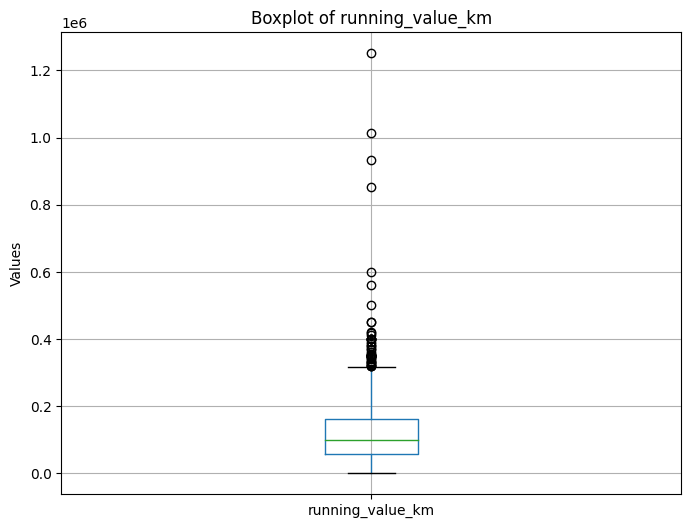

In [13]:
### Check Outliers

for col in data_train.select_dtypes(include='float64').columns.tolist():
    plt.figure(figsize=(8, 6))
    data_train.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')
    plt.show()

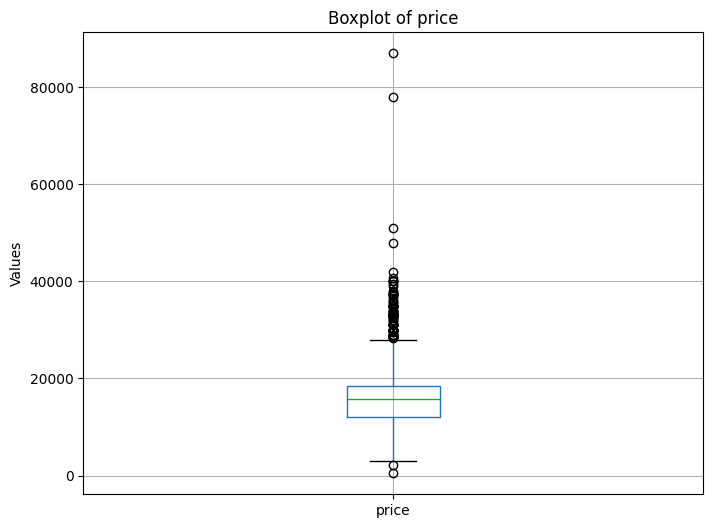

In [14]:
for col in data_train.select_dtypes(include='int64').columns.tolist():
    plt.figure(figsize=(8, 6))
    data_train.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Values')
    plt.show()

In [15]:
# Remove outliers in Running Value
#print(data_train.shape)

#for i in ["running_value_km", "price"]:
#    Q1 = np.percentile(data_train[i], 25)
#    Q3 = np.percentile(data_train[i], 75)
#    IQR = Q3 - Q1
#    data_train = data_train[(data_train[i] >= Q1 - 1.5*IQR) & (data_train[i] <= Q3 + 1.5*IQR)]
    
#print(data_train.shape)

### Remove duplicates


In [16]:
print(data_train.shape)
data_train.drop_duplicates()
print(data_train.shape)

(1642, 10)
(1642, 10)


### Discretize running value km

In [17]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_train["running_value_km"].describe()

count      1642.000
mean     119210.422
std       96766.247
min          10.000
25%       56326.900
50%       98786.038
75%      160913.883
max     1251707.637
Name: running_value_km, dtype: float64

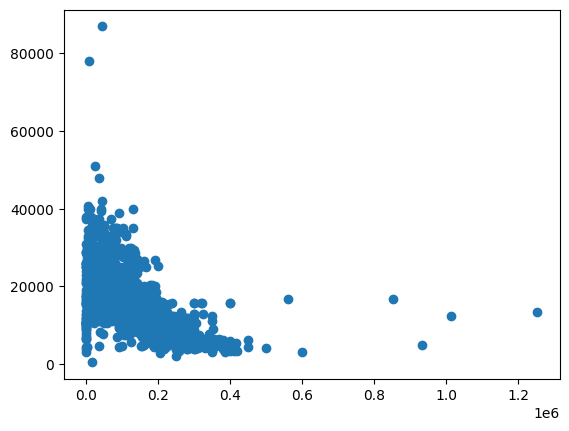

In [18]:
plt.scatter(data_train["running_value_km"], data_train["price"], label='Variable 1')

In [19]:
conditions = [
    (data_train['running_value_km'] >= 0) & (data_train['running_value_km'] <= 60000),
    (data_train['running_value_km'] > 60000) & (data_train['running_value_km'] <= 100000),
    (data_train['running_value_km'] > 100000) & (data_train['running_value_km'] <= 150000),
    (data_train['running_value_km'] > 150000) & (data_train['running_value_km'] <= 200000),
    (data_train['running_value_km'] > 200000)
]

choices = ['xs', 's', 'm', 'l', 'xl'] 

data_train['running_value_km'] = np.select(conditions, choices, default='Other')

In [20]:
conditions = [
    (data_test['running_value_km'] >= 0) & (data_test['running_value_km'] <= 60000),
    (data_test['running_value_km'] > 60000) & (data_test['running_value_km'] <= 100000),
    (data_test['running_value_km'] > 100000) & (data_test['running_value_km'] <= 150000),
    (data_test['running_value_km'] > 150000) & (data_test['running_value_km'] <= 200000),
    (data_test['running_value_km'] > 200000)
]

choices = ['xs', 's', 'm', 'l', 'xl'] 

data_test['running_value_km'] = np.select(conditions, choices, default='Other')

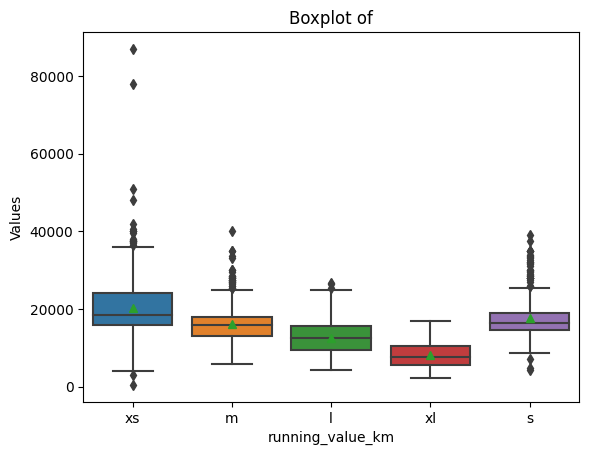

In [21]:
sns.boxplot(
    x = "running_value_km",  
    y = "price",      
    showmeans=True,
    data= data_train)
    
plt.title(f'Boxplot of')
plt.ylabel('Values')
plt.show()

# Modelaje

In [22]:
# Separar data
X_train = data_train.drop(columns = ["price"])
y_train = data_train["price"]

X_test = data_test

In [23]:
# Normalizar columnas numericas
# Dudas: Deberia normalizar la variable de respuesta?
# Esta bien siempre normalizar?

#columnas_a_normalizar = ["running_value_km"]

#X_train_normalizar = X_train[columnas_a_normalizar].copy()

# Normalizar
#mms = MinMaxScaler()
#X_train_normalizar = mms.fit_transform(X_train_normalizar)

# Guardar normalizacion
#X_train[columnas_a_normalizar] = X_train_normalizar

# Normalizar en test
#X_test[columnas_a_normalizar] = mms.transform(X_test[columnas_a_normalizar])

In [24]:
# Separate categorical and numerical columns

categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
non_categorical_cols = data.select_dtypes(exclude='object').columns.tolist()

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform on categorical columns
encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

# Convert to DataFrame
print(encoded_train.shape) 
encoded_train = pd.DataFrame(encoded_train.toarray(), columns = encoder.get_feature_names_out(categorical_cols))
encoded_test = pd.DataFrame(encoded_test.toarray(), columns = encoder.get_feature_names_out(categorical_cols))



(1642, 97)


In [25]:
# Combine encoded categorical DataFrame with original numerical DataFrame
X_train = pd.concat([X_train[numerical_cols].reset_index(drop=True), encoded_train], axis=1)
X_test = pd.concat([X_test[["Id"] + numerical_cols].reset_index(drop=True), encoded_test], axis=1)

print(X_train.shape)

(1642, 97)


In [26]:
X_train

model_hyundai  model_kia  model_mercedes-benz  model_nissan  \
0             0.000      0.000                0.000         0.000   
1             0.000      0.000                1.000         0.000   
2             0.000      1.000                0.000         0.000   
3             0.000      0.000                1.000         0.000   
4             0.000      0.000                1.000         0.000   
...             ...        ...                  ...           ...   
1637          1.000      0.000                0.000         0.000   
1638          0.000      0.000                0.000         0.000   
1639          0.000      0.000                0.000         1.000   
1640          0.000      0.000                0.000         1.000   
1641          0.000      0.000                0.000         0.000   

      model_toyota  year_1987  year_1993  year_1994  year_1995  year_1996  \
0            1.000      0.000      0.000      0.000      0.000      0.000   
1            0.000      0.000      0.000      0.000      0.000      0.000   
2            0.000      0.000      0.000      0.000      0.000      0.000   
3            0.000      0.000      0.000      0.000      0.000      0.000   
4            0.000      0.000      0.000      0.000      0.000      0.000   
...            ...        ...        ...        ...        ...        ...   
1637         0.000      0.000      0.000      0.000      0.000      0.000   
1638         1.000      0.000      0.000      0.000      0.000      0.000   
1639         0.000      0.000      0.000      0.000      0.000      0.000   
1640         0.000      0.000      0.000      0.000      0.000      0.000   
1641         1.000      0.000      0.000      0.000      0.000      0.000   

      ...  motor_volume_2.8  motor_volume_3.0  motor_volume_3.2  \
0     ...             0.000             0.000             0.000   
1     ...             0.000             0.000             0.000   
2     ...             0.000             0.000             0.000   
3     ...             0.000             0.000             1.000   
4     ...             0.000             0.000             0.000   
...   ...               ...               ...               ...   
1637  ...             0.000             0.000             0.000   
1638  ...             0.000             0.000             0.000   
1639  ...             0.000             0.000             0.000   
1640  ...             0.000             0.000             0.000   
1641  ...             0.000             0.000             0.000   

      motor_volume_3.5  motor_volume_4.0  running_value_km_l  \
0                0.000             0.000               0.000   
1                0.000             0.000               0.000   
2                0.000             0.000               1.000   
3                0.000             0.000               0.000   
4                0.000             0.000               0.000   
...                ...               ...                 ...   
1637             0.000             0.000               1.000   
1638             0.000             0.000               1.000   
1639             0.000             0.000               0.000   
1640             0.000             0.000               0.000   
1641             0.000             0.000               0.000   

      running_value_km_m  running_value_km_s  running_value_km_xl  \
0                  0.000               0.000                0.000   
1                  1.000               0.000                0.000   
2                  0.000               0.000                0.000   
3                  0.000               0.000                1.000   
4                  1.000               0.000                0.000   
...                  ...                 ...                  ...   
1637               0.000               0.000                0.000   
1638               0.000               0.000                0.000   
1639               1.000               0.000             

In [27]:
# Crear modelo

#gbr = GradientBoostingRegressor(random_state=0)

# Crear Grid Search
#n_estimators_list = [250, 500,1000]
#learning_rate_list = [0.1,0.05]
#max_depth_list = [5, 10, 15]

#param_grid = {'n_estimators': n_estimators_list,
#              'learning_rate':learning_rate_list,
#              'max_depth': max_depth_list}

#gbr_grid_search = GridSearchCV(gbr, 
#                    param_grid = param_grid, 
#                    cv = 5,
#                    scoring = "neg_mean_squared_error",
#                    n_jobs = -1) # Usar todos los procesadores

#gbr_grid_search.fit(X_train, y_train)


In [28]:
# Crear modelo

catboost_model = CatBoostRegressor(random_state = 42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

catboost_model_grid_search = GridSearchCV(catboost_model, 
                    param_grid = param_grid, 
                    cv = 5,
                    scoring = "neg_mean_squared_error")

catboost_model_grid_search.fit(X_train, y_train)


0:	learn: 7152.1674157	total: 183ms	remaining: 3m 2s
1:	learn: 7128.8031972	total: 187ms	remaining: 1m 33s
2:	learn: 7105.0561041	total: 190ms	remaining: 1m 3s
3:	learn: 7076.5245716	total: 194ms	remaining: 48.2s
4:	learn: 7058.4524508	total: 198ms	remaining: 39.3s
5:	learn: 7038.0974686	total: 201ms	remaining: 33.3s
6:	learn: 7015.7275091	total: 205ms	remaining: 29.1s
7:	learn: 6991.5204421	total: 209ms	remaining: 25.9s
8:	learn: 6969.8347614	total: 212ms	remaining: 23.4s
9:	learn: 6947.1025918	total: 216ms	remaining: 21.4s
10:	learn: 6926.9477796	total: 219ms	remaining: 19.7s
11:	learn: 6905.0420290	total: 223ms	remaining: 18.3s
12:	learn: 6880.2178621	total: 227ms	remaining: 17.2s
13:	learn: 6858.9063132	total: 230ms	remaining: 16.2s
14:	learn: 6831.4909278	total: 234ms	remaining: 15.4s
15:	learn: 6806.7647219	total: 238ms	remaining: 14.6s
16:	learn: 6788.3945509	total: 241ms	remaining: 13.9s
17:	learn: 6763.6274118	total: 245ms	remaining: 13.3s
18:	learn: 6739.1956163	total: 248ms	

218:	learn: 4898.4038022	total: 737ms	remaining: 2.63s
219:	learn: 4894.2450310	total: 740ms	remaining: 2.62s
220:	learn: 4889.9938366	total: 742ms	remaining: 2.62s
221:	learn: 4887.1145962	total: 745ms	remaining: 2.61s
222:	learn: 4882.3482749	total: 748ms	remaining: 2.6s
223:	learn: 4876.6074233	total: 751ms	remaining: 2.6s
224:	learn: 4873.1942185	total: 753ms	remaining: 2.6s
225:	learn: 4869.7108580	total: 756ms	remaining: 2.59s
226:	learn: 4864.7738447	total: 759ms	remaining: 2.58s
227:	learn: 4861.8386689	total: 762ms	remaining: 2.58s
228:	learn: 4857.5305151	total: 765ms	remaining: 2.57s
229:	learn: 4854.8253650	total: 767ms	remaining: 2.57s
230:	learn: 4845.7567249	total: 770ms	remaining: 2.56s
231:	learn: 4838.4783579	total: 773ms	remaining: 2.56s
232:	learn: 4834.0823714	total: 776ms	remaining: 2.55s
233:	learn: 4828.8402470	total: 780ms	remaining: 2.55s
234:	learn: 4826.0737324	total: 783ms	remaining: 2.55s
235:	learn: 4822.4673094	total: 786ms	remaining: 2.54s
236:	learn: 4

427:	learn: 4280.4352999	total: 1.3s	remaining: 1.74s
428:	learn: 4279.0504272	total: 1.31s	remaining: 1.74s
429:	learn: 4277.0334448	total: 1.31s	remaining: 1.73s
430:	learn: 4273.7393862	total: 1.31s	remaining: 1.73s
431:	learn: 4269.8648202	total: 1.31s	remaining: 1.73s
432:	learn: 4268.1829748	total: 1.31s	remaining: 1.72s
433:	learn: 4264.5905296	total: 1.32s	remaining: 1.72s
434:	learn: 4262.8500869	total: 1.32s	remaining: 1.71s
435:	learn: 4261.7506148	total: 1.32s	remaining: 1.71s
436:	learn: 4258.9292246	total: 1.32s	remaining: 1.71s
437:	learn: 4256.6002915	total: 1.33s	remaining: 1.7s
438:	learn: 4255.5093451	total: 1.33s	remaining: 1.7s
439:	learn: 4253.5578237	total: 1.33s	remaining: 1.7s
440:	learn: 4252.6571329	total: 1.33s	remaining: 1.69s
441:	learn: 4250.7317191	total: 1.34s	remaining: 1.69s
442:	learn: 4249.8079001	total: 1.34s	remaining: 1.68s
443:	learn: 4248.0958660	total: 1.34s	remaining: 1.68s
444:	learn: 4246.7323677	total: 1.34s	remaining: 1.67s
445:	learn: 42

579:	learn: 4005.7323479	total: 1.66s	remaining: 1.2s
580:	learn: 4005.2232628	total: 1.66s	remaining: 1.2s
581:	learn: 4000.4040370	total: 1.67s	remaining: 1.2s
582:	learn: 3998.6684164	total: 1.67s	remaining: 1.19s
583:	learn: 3997.6408411	total: 1.67s	remaining: 1.19s
584:	learn: 3993.5979224	total: 1.67s	remaining: 1.19s
585:	learn: 3992.7514522	total: 1.67s	remaining: 1.18s
586:	learn: 3992.0980807	total: 1.68s	remaining: 1.18s
587:	learn: 3991.1972110	total: 1.68s	remaining: 1.18s
588:	learn: 3989.4244469	total: 1.68s	remaining: 1.17s
589:	learn: 3988.2890173	total: 1.68s	remaining: 1.17s
590:	learn: 3984.8028837	total: 1.68s	remaining: 1.17s
591:	learn: 3983.6159293	total: 1.69s	remaining: 1.16s
592:	learn: 3981.6449545	total: 1.69s	remaining: 1.16s
593:	learn: 3979.9249729	total: 1.69s	remaining: 1.15s
594:	learn: 3978.8954108	total: 1.69s	remaining: 1.15s
595:	learn: 3976.7219414	total: 1.69s	remaining: 1.15s
596:	learn: 3973.1625527	total: 1.69s	remaining: 1.14s
597:	learn: 3

739:	learn: 3771.7757718	total: 2.04s	remaining: 715ms
740:	learn: 3770.9987261	total: 2.04s	remaining: 713ms
741:	learn: 3770.1453391	total: 2.04s	remaining: 710ms
742:	learn: 3768.9998730	total: 2.04s	remaining: 707ms
743:	learn: 3768.2245751	total: 2.04s	remaining: 704ms
744:	learn: 3766.9545695	total: 2.05s	remaining: 701ms
745:	learn: 3763.5439684	total: 2.05s	remaining: 698ms
746:	learn: 3762.6131789	total: 2.05s	remaining: 695ms
747:	learn: 3761.6409399	total: 2.05s	remaining: 692ms
748:	learn: 3760.6874016	total: 2.06s	remaining: 689ms
749:	learn: 3757.7235450	total: 2.06s	remaining: 686ms
750:	learn: 3756.9242493	total: 2.06s	remaining: 683ms
751:	learn: 3755.7805369	total: 2.06s	remaining: 680ms
752:	learn: 3754.2024602	total: 2.06s	remaining: 677ms
753:	learn: 3753.3493362	total: 2.07s	remaining: 675ms
754:	learn: 3752.6775015	total: 2.07s	remaining: 672ms
755:	learn: 3751.4735802	total: 2.07s	remaining: 669ms
756:	learn: 3748.2595086	total: 2.08s	remaining: 666ms
757:	learn

905:	learn: 3556.3778814	total: 2.42s	remaining: 251ms
906:	learn: 3555.4859623	total: 2.43s	remaining: 249ms
907:	learn: 3554.4601664	total: 2.43s	remaining: 246ms
908:	learn: 3553.2695617	total: 2.43s	remaining: 243ms
909:	learn: 3551.8680008	total: 2.43s	remaining: 241ms
910:	learn: 3551.0060781	total: 2.44s	remaining: 238ms
911:	learn: 3550.1520304	total: 2.44s	remaining: 235ms
912:	learn: 3549.2490636	total: 2.44s	remaining: 232ms
913:	learn: 3548.4068558	total: 2.44s	remaining: 230ms
914:	learn: 3545.9934927	total: 2.44s	remaining: 227ms
915:	learn: 3545.6699935	total: 2.44s	remaining: 224ms
916:	learn: 3544.6901820	total: 2.45s	remaining: 222ms
917:	learn: 3542.9075560	total: 2.45s	remaining: 219ms
918:	learn: 3541.5079450	total: 2.45s	remaining: 216ms
919:	learn: 3540.9679218	total: 2.45s	remaining: 213ms
920:	learn: 3540.3272647	total: 2.46s	remaining: 211ms
921:	learn: 3539.4229637	total: 2.46s	remaining: 208ms
922:	learn: 3538.6553934	total: 2.46s	remaining: 205ms
923:	learn

97:	learn: 5380.3055515	total: 256ms	remaining: 2.35s
98:	learn: 5370.8587412	total: 259ms	remaining: 2.35s
99:	learn: 5364.5026913	total: 261ms	remaining: 2.35s
100:	learn: 5355.3367059	total: 263ms	remaining: 2.34s
101:	learn: 5346.6879197	total: 265ms	remaining: 2.33s
102:	learn: 5340.0023995	total: 267ms	remaining: 2.32s
103:	learn: 5333.9278122	total: 269ms	remaining: 2.31s
104:	learn: 5324.0437279	total: 271ms	remaining: 2.31s
105:	learn: 5314.1356302	total: 273ms	remaining: 2.3s
106:	learn: 5307.6314197	total: 275ms	remaining: 2.29s
107:	learn: 5300.7120477	total: 277ms	remaining: 2.29s
108:	learn: 5290.8003522	total: 279ms	remaining: 2.28s
109:	learn: 5283.7993823	total: 281ms	remaining: 2.28s
110:	learn: 5274.1826199	total: 284ms	remaining: 2.27s
111:	learn: 5263.4672902	total: 286ms	remaining: 2.27s
112:	learn: 5258.1203880	total: 288ms	remaining: 2.26s
113:	learn: 5252.4570440	total: 290ms	remaining: 2.25s
114:	learn: 5245.8181696	total: 292ms	remaining: 2.25s
115:	learn: 52

272:	learn: 4556.1746990	total: 630ms	remaining: 1.68s
273:	learn: 4553.7755016	total: 633ms	remaining: 1.68s
274:	learn: 4552.1328841	total: 635ms	remaining: 1.67s
275:	learn: 4549.4767168	total: 637ms	remaining: 1.67s
276:	learn: 4546.2415515	total: 639ms	remaining: 1.67s
277:	learn: 4543.9084652	total: 641ms	remaining: 1.66s
278:	learn: 4541.9110212	total: 643ms	remaining: 1.66s
279:	learn: 4539.6283005	total: 644ms	remaining: 1.66s
280:	learn: 4536.9141674	total: 646ms	remaining: 1.65s
281:	learn: 4534.7306590	total: 648ms	remaining: 1.65s
282:	learn: 4532.4752993	total: 650ms	remaining: 1.65s
283:	learn: 4529.9405496	total: 652ms	remaining: 1.64s
284:	learn: 4527.2399807	total: 654ms	remaining: 1.64s
285:	learn: 4525.0386949	total: 657ms	remaining: 1.64s
286:	learn: 4522.7947290	total: 659ms	remaining: 1.64s
287:	learn: 4518.6971613	total: 661ms	remaining: 1.63s
288:	learn: 4515.7712565	total: 663ms	remaining: 1.63s
289:	learn: 4514.3254086	total: 665ms	remaining: 1.63s
290:	learn

434:	learn: 4222.7349871	total: 991ms	remaining: 1.29s
435:	learn: 4221.6674647	total: 994ms	remaining: 1.28s
436:	learn: 4219.8673471	total: 996ms	remaining: 1.28s
437:	learn: 4218.0756880	total: 998ms	remaining: 1.28s
438:	learn: 4216.9675525	total: 1000ms	remaining: 1.28s
439:	learn: 4215.8928111	total: 1s	remaining: 1.27s
440:	learn: 4214.3982156	total: 1s	remaining: 1.27s
441:	learn: 4212.9492652	total: 1s	remaining: 1.27s
442:	learn: 4211.4071607	total: 1.01s	remaining: 1.27s
443:	learn: 4210.5184050	total: 1.01s	remaining: 1.26s
444:	learn: 4210.3395570	total: 1.01s	remaining: 1.26s
445:	learn: 4208.2181486	total: 1.01s	remaining: 1.26s
446:	learn: 4205.9438384	total: 1.01s	remaining: 1.25s
447:	learn: 4204.6204715	total: 1.02s	remaining: 1.25s
448:	learn: 4202.7770656	total: 1.02s	remaining: 1.25s
449:	learn: 4201.5398089	total: 1.02s	remaining: 1.25s
450:	learn: 4200.5880525	total: 1.02s	remaining: 1.25s
451:	learn: 4198.4735278	total: 1.02s	remaining: 1.24s
452:	learn: 4197.4

601:	learn: 4008.6865421	total: 1.35s	remaining: 895ms
602:	learn: 4006.6577166	total: 1.36s	remaining: 893ms
603:	learn: 4005.7093418	total: 1.36s	remaining: 890ms
604:	learn: 4005.1917800	total: 1.36s	remaining: 888ms
605:	learn: 4004.2523989	total: 1.36s	remaining: 885ms
606:	learn: 4002.0933415	total: 1.36s	remaining: 882ms
607:	learn: 3998.4140325	total: 1.36s	remaining: 880ms
608:	learn: 3996.7426117	total: 1.37s	remaining: 877ms
609:	learn: 3996.0182720	total: 1.37s	remaining: 875ms
610:	learn: 3994.9046653	total: 1.37s	remaining: 872ms
611:	learn: 3993.4334019	total: 1.37s	remaining: 869ms
612:	learn: 3992.7143246	total: 1.37s	remaining: 867ms
613:	learn: 3990.9091341	total: 1.37s	remaining: 864ms
614:	learn: 3988.0274078	total: 1.38s	remaining: 862ms
615:	learn: 3986.6381646	total: 1.38s	remaining: 859ms
616:	learn: 3985.7163751	total: 1.38s	remaining: 857ms
617:	learn: 3985.1231571	total: 1.38s	remaining: 855ms
618:	learn: 3984.2070221	total: 1.38s	remaining: 852ms
619:	learn

783:	learn: 3798.7023549	total: 1.73s	remaining: 476ms
784:	learn: 3797.9758335	total: 1.73s	remaining: 474ms
785:	learn: 3796.9185154	total: 1.73s	remaining: 471ms
786:	learn: 3795.9179639	total: 1.73s	remaining: 469ms
787:	learn: 3794.9625692	total: 1.73s	remaining: 467ms
788:	learn: 3793.8679176	total: 1.74s	remaining: 464ms
789:	learn: 3792.9421481	total: 1.74s	remaining: 462ms
790:	learn: 3792.1001268	total: 1.74s	remaining: 460ms
791:	learn: 3790.2537230	total: 1.74s	remaining: 457ms
792:	learn: 3789.0137066	total: 1.74s	remaining: 455ms
793:	learn: 3785.7177563	total: 1.75s	remaining: 453ms
794:	learn: 3784.9625032	total: 1.75s	remaining: 450ms
795:	learn: 3784.4566265	total: 1.75s	remaining: 448ms
796:	learn: 3783.4774199	total: 1.75s	remaining: 446ms
797:	learn: 3781.9496598	total: 1.75s	remaining: 443ms
798:	learn: 3780.9186534	total: 1.75s	remaining: 441ms
799:	learn: 3779.9043367	total: 1.75s	remaining: 439ms
800:	learn: 3779.2718223	total: 1.76s	remaining: 437ms
801:	learn

969:	learn: 3609.6431426	total: 2.09s	remaining: 64.7ms
970:	learn: 3608.8809515	total: 2.1s	remaining: 62.6ms
971:	learn: 3606.5489849	total: 2.1s	remaining: 60.4ms
972:	learn: 3605.5134782	total: 2.1s	remaining: 58.2ms
973:	learn: 3604.6576679	total: 2.1s	remaining: 56.1ms
974:	learn: 3604.1052557	total: 2.1s	remaining: 53.9ms
975:	learn: 3603.4985341	total: 2.1s	remaining: 51.7ms
976:	learn: 3601.9229474	total: 2.1s	remaining: 49.5ms
977:	learn: 3601.4000800	total: 2.1s	remaining: 47.4ms
978:	learn: 3600.7632284	total: 2.11s	remaining: 45.2ms
979:	learn: 3599.9109282	total: 2.11s	remaining: 43ms
980:	learn: 3599.3507988	total: 2.11s	remaining: 40.9ms
981:	learn: 3598.9660247	total: 2.11s	remaining: 38.7ms
982:	learn: 3598.0103407	total: 2.11s	remaining: 36.5ms
983:	learn: 3597.3057236	total: 2.11s	remaining: 34.4ms
984:	learn: 3596.8184214	total: 2.12s	remaining: 32.2ms
985:	learn: 3596.0938948	total: 2.12s	remaining: 30.1ms
986:	learn: 3594.8464590	total: 2.12s	remaining: 27.9ms
98

185:	learn: 5148.5024532	total: 396ms	remaining: 1.73s
186:	learn: 5141.5087095	total: 399ms	remaining: 1.74s
187:	learn: 5136.6622497	total: 401ms	remaining: 1.73s
188:	learn: 5133.9558748	total: 403ms	remaining: 1.73s
189:	learn: 5124.8367057	total: 405ms	remaining: 1.73s
190:	learn: 5120.7453099	total: 407ms	remaining: 1.73s
191:	learn: 5115.6476133	total: 409ms	remaining: 1.72s
192:	learn: 5107.7723783	total: 411ms	remaining: 1.72s
193:	learn: 5099.9020698	total: 413ms	remaining: 1.72s
194:	learn: 5095.5702674	total: 415ms	remaining: 1.71s
195:	learn: 5091.1302409	total: 417ms	remaining: 1.71s
196:	learn: 5086.6352029	total: 419ms	remaining: 1.71s
197:	learn: 5082.4003088	total: 421ms	remaining: 1.71s
198:	learn: 5078.0783428	total: 423ms	remaining: 1.7s
199:	learn: 5074.2476003	total: 425ms	remaining: 1.7s
200:	learn: 5068.6454253	total: 427ms	remaining: 1.7s
201:	learn: 5065.2292630	total: 429ms	remaining: 1.7s
202:	learn: 5062.0976047	total: 431ms	remaining: 1.69s
203:	learn: 50

358:	learn: 4554.4770795	total: 753ms	remaining: 1.34s
359:	learn: 4549.7076650	total: 755ms	remaining: 1.34s
360:	learn: 4547.4568852	total: 757ms	remaining: 1.34s
361:	learn: 4545.9481982	total: 760ms	remaining: 1.34s
362:	learn: 4544.1133878	total: 761ms	remaining: 1.34s
363:	learn: 4541.8128141	total: 763ms	remaining: 1.33s
364:	learn: 4539.9324807	total: 765ms	remaining: 1.33s
365:	learn: 4537.1213372	total: 767ms	remaining: 1.33s
366:	learn: 4536.0370726	total: 768ms	remaining: 1.32s
367:	learn: 4534.5247662	total: 770ms	remaining: 1.32s
368:	learn: 4531.8772460	total: 771ms	remaining: 1.32s
369:	learn: 4530.3436918	total: 772ms	remaining: 1.31s
370:	learn: 4529.0189229	total: 774ms	remaining: 1.31s
371:	learn: 4523.4907802	total: 776ms	remaining: 1.31s
372:	learn: 4522.0120838	total: 778ms	remaining: 1.31s
373:	learn: 4520.6177386	total: 779ms	remaining: 1.3s
374:	learn: 4519.2614796	total: 781ms	remaining: 1.3s
375:	learn: 4515.8341927	total: 783ms	remaining: 1.3s
376:	learn: 4

535:	learn: 4225.4613787	total: 1.13s	remaining: 975ms
536:	learn: 4224.2599917	total: 1.13s	remaining: 973ms
537:	learn: 4223.2002662	total: 1.13s	remaining: 971ms
538:	learn: 4221.8135675	total: 1.13s	remaining: 969ms
539:	learn: 4219.8518522	total: 1.13s	remaining: 967ms
540:	learn: 4217.9637100	total: 1.14s	remaining: 964ms
541:	learn: 4216.2021157	total: 1.14s	remaining: 963ms
542:	learn: 4213.1514873	total: 1.14s	remaining: 960ms
543:	learn: 4211.7105090	total: 1.14s	remaining: 957ms
544:	learn: 4210.5951712	total: 1.14s	remaining: 955ms
545:	learn: 4207.1778856	total: 1.15s	remaining: 952ms
546:	learn: 4206.3261654	total: 1.15s	remaining: 950ms
547:	learn: 4205.4620094	total: 1.15s	remaining: 948ms
548:	learn: 4204.3394061	total: 1.15s	remaining: 945ms
549:	learn: 4202.9481531	total: 1.15s	remaining: 943ms
550:	learn: 4201.2926621	total: 1.15s	remaining: 940ms
551:	learn: 4200.2751841	total: 1.16s	remaining: 938ms
552:	learn: 4198.8704786	total: 1.16s	remaining: 936ms
553:	learn

710:	learn: 3985.6307249	total: 1.49s	remaining: 604ms
711:	learn: 3984.6025628	total: 1.49s	remaining: 602ms
712:	learn: 3983.5293787	total: 1.49s	remaining: 600ms
713:	learn: 3982.8475811	total: 1.49s	remaining: 598ms
714:	learn: 3981.6040377	total: 1.49s	remaining: 596ms
715:	learn: 3981.0820693	total: 1.5s	remaining: 594ms
716:	learn: 3978.1422251	total: 1.5s	remaining: 592ms
717:	learn: 3977.2447049	total: 1.5s	remaining: 590ms
718:	learn: 3976.3354004	total: 1.5s	remaining: 587ms
719:	learn: 3975.5694438	total: 1.5s	remaining: 585ms
720:	learn: 3972.5622090	total: 1.51s	remaining: 583ms
721:	learn: 3971.6847410	total: 1.51s	remaining: 581ms
722:	learn: 3969.5765220	total: 1.51s	remaining: 579ms
723:	learn: 3968.6807632	total: 1.51s	remaining: 577ms
724:	learn: 3967.3618864	total: 1.51s	remaining: 575ms
725:	learn: 3966.1274567	total: 1.52s	remaining: 572ms
726:	learn: 3965.0233689	total: 1.52s	remaining: 570ms
727:	learn: 3962.4846995	total: 1.52s	remaining: 568ms
728:	learn: 396

894:	learn: 3776.1682748	total: 1.86s	remaining: 218ms
895:	learn: 3775.7079448	total: 1.86s	remaining: 216ms
896:	learn: 3774.4517635	total: 1.86s	remaining: 214ms
897:	learn: 3773.4190983	total: 1.86s	remaining: 212ms
898:	learn: 3772.5276632	total: 1.87s	remaining: 210ms
899:	learn: 3771.9976779	total: 1.87s	remaining: 208ms
900:	learn: 3771.4207292	total: 1.87s	remaining: 206ms
901:	learn: 3770.5429939	total: 1.87s	remaining: 204ms
902:	learn: 3769.8563555	total: 1.88s	remaining: 202ms
903:	learn: 3767.8720738	total: 1.88s	remaining: 200ms
904:	learn: 3767.0694724	total: 1.88s	remaining: 197ms
905:	learn: 3765.8793888	total: 1.88s	remaining: 195ms
906:	learn: 3765.3390539	total: 1.88s	remaining: 193ms
907:	learn: 3764.3492613	total: 1.89s	remaining: 191ms
908:	learn: 3762.4114076	total: 1.89s	remaining: 189ms
909:	learn: 3761.4708713	total: 1.89s	remaining: 187ms
910:	learn: 3758.8148393	total: 1.89s	remaining: 185ms
911:	learn: 3758.0732252	total: 1.89s	remaining: 183ms
912:	learn

112:	learn: 5538.1581477	total: 251ms	remaining: 1.97s
113:	learn: 5531.5663373	total: 253ms	remaining: 1.97s
114:	learn: 5525.4987844	total: 255ms	remaining: 1.96s
115:	learn: 5517.5761713	total: 257ms	remaining: 1.96s
116:	learn: 5511.1163507	total: 259ms	remaining: 1.96s
117:	learn: 5503.9156053	total: 261ms	remaining: 1.95s
118:	learn: 5496.7184368	total: 264ms	remaining: 1.95s
119:	learn: 5487.8296032	total: 266ms	remaining: 1.95s
120:	learn: 5478.1965727	total: 268ms	remaining: 1.95s
121:	learn: 5472.0288617	total: 270ms	remaining: 1.94s
122:	learn: 5463.8622089	total: 272ms	remaining: 1.94s
123:	learn: 5455.8290788	total: 274ms	remaining: 1.94s
124:	learn: 5449.1075086	total: 276ms	remaining: 1.93s
125:	learn: 5440.0728780	total: 279ms	remaining: 1.93s
126:	learn: 5434.6373233	total: 281ms	remaining: 1.93s
127:	learn: 5429.1278062	total: 284ms	remaining: 1.94s
128:	learn: 5422.9112208	total: 287ms	remaining: 1.94s
129:	learn: 5416.6974285	total: 289ms	remaining: 1.94s
130:	learn

282:	learn: 4722.3083467	total: 620ms	remaining: 1.57s
283:	learn: 4719.0817927	total: 623ms	remaining: 1.57s
284:	learn: 4716.2155235	total: 625ms	remaining: 1.57s
285:	learn: 4710.4232584	total: 627ms	remaining: 1.56s
286:	learn: 4704.9329116	total: 629ms	remaining: 1.56s
287:	learn: 4703.0136807	total: 631ms	remaining: 1.56s
288:	learn: 4699.7052361	total: 633ms	remaining: 1.56s
289:	learn: 4697.2950156	total: 636ms	remaining: 1.55s
290:	learn: 4694.1124405	total: 638ms	remaining: 1.55s
291:	learn: 4692.3169411	total: 640ms	remaining: 1.55s
292:	learn: 4688.2310234	total: 641ms	remaining: 1.55s
293:	learn: 4686.2771630	total: 643ms	remaining: 1.54s
294:	learn: 4683.9105875	total: 645ms	remaining: 1.54s
295:	learn: 4679.7855021	total: 647ms	remaining: 1.54s
296:	learn: 4676.4761452	total: 649ms	remaining: 1.53s
297:	learn: 4671.7269830	total: 650ms	remaining: 1.53s
298:	learn: 4668.2898925	total: 652ms	remaining: 1.53s
299:	learn: 4663.7043154	total: 654ms	remaining: 1.53s
300:	learn

464:	learn: 4267.9232886	total: 989ms	remaining: 1.14s
465:	learn: 4266.2570185	total: 992ms	remaining: 1.14s
466:	learn: 4265.0435026	total: 994ms	remaining: 1.13s
467:	learn: 4262.7414591	total: 996ms	remaining: 1.13s
468:	learn: 4258.6172725	total: 998ms	remaining: 1.13s
469:	learn: 4256.9371033	total: 1s	remaining: 1.13s
470:	learn: 4255.5286017	total: 1s	remaining: 1.13s
471:	learn: 4254.2392226	total: 1s	remaining: 1.12s
472:	learn: 4252.8496547	total: 1.01s	remaining: 1.12s
473:	learn: 4250.1663930	total: 1.01s	remaining: 1.12s
474:	learn: 4248.3680587	total: 1.01s	remaining: 1.12s
475:	learn: 4247.3703827	total: 1.01s	remaining: 1.11s
476:	learn: 4245.6070318	total: 1.01s	remaining: 1.11s
477:	learn: 4244.3461606	total: 1.02s	remaining: 1.11s
478:	learn: 4242.3783515	total: 1.02s	remaining: 1.11s
479:	learn: 4240.2739688	total: 1.02s	remaining: 1.11s
480:	learn: 4239.0303211	total: 1.02s	remaining: 1.1s
481:	learn: 4237.3050917	total: 1.02s	remaining: 1.1s
482:	learn: 4233.8702

656:	learn: 3975.4617203	total: 1.38s	remaining: 718ms
657:	learn: 3973.8900923	total: 1.38s	remaining: 716ms
658:	learn: 3973.0548998	total: 1.38s	remaining: 714ms
659:	learn: 3971.5346926	total: 1.38s	remaining: 712ms
660:	learn: 3970.0567234	total: 1.38s	remaining: 710ms
661:	learn: 3968.7425578	total: 1.39s	remaining: 707ms
662:	learn: 3967.6246725	total: 1.39s	remaining: 705ms
663:	learn: 3963.7133211	total: 1.39s	remaining: 703ms
664:	learn: 3962.6757805	total: 1.39s	remaining: 701ms
665:	learn: 3961.8015650	total: 1.39s	remaining: 699ms
666:	learn: 3960.9848701	total: 1.4s	remaining: 697ms
667:	learn: 3959.8158329	total: 1.4s	remaining: 695ms
668:	learn: 3959.1226570	total: 1.4s	remaining: 693ms
669:	learn: 3958.2968265	total: 1.4s	remaining: 690ms
670:	learn: 3957.2478156	total: 1.4s	remaining: 688ms
671:	learn: 3955.5962844	total: 1.41s	remaining: 686ms
672:	learn: 3954.8281252	total: 1.41s	remaining: 684ms
673:	learn: 3953.3166224	total: 1.41s	remaining: 682ms
674:	learn: 395

841:	learn: 3750.0897080	total: 1.75s	remaining: 328ms
842:	learn: 3749.0261997	total: 1.75s	remaining: 326ms
843:	learn: 3747.8182915	total: 1.75s	remaining: 324ms
844:	learn: 3746.9707223	total: 1.75s	remaining: 321ms
845:	learn: 3746.2013111	total: 1.75s	remaining: 320ms
846:	learn: 3745.2415462	total: 1.76s	remaining: 317ms
847:	learn: 3744.5204341	total: 1.76s	remaining: 315ms
848:	learn: 3743.7863691	total: 1.76s	remaining: 313ms
849:	learn: 3743.0762173	total: 1.76s	remaining: 311ms
850:	learn: 3741.3576834	total: 1.77s	remaining: 309ms
851:	learn: 3739.9413065	total: 1.77s	remaining: 307ms
852:	learn: 3739.1665332	total: 1.77s	remaining: 305ms
853:	learn: 3738.4499001	total: 1.77s	remaining: 303ms
854:	learn: 3737.4229645	total: 1.77s	remaining: 301ms
855:	learn: 3736.3746964	total: 1.78s	remaining: 299ms
856:	learn: 3735.9646919	total: 1.78s	remaining: 297ms
857:	learn: 3735.0784699	total: 1.78s	remaining: 295ms
858:	learn: 3734.2498281	total: 1.78s	remaining: 293ms
859:	learn

0:	learn: 7280.0158379	total: 2.2ms	remaining: 2.2s
1:	learn: 7251.2206404	total: 4.37ms	remaining: 2.18s
2:	learn: 7230.3089199	total: 6.4ms	remaining: 2.13s
3:	learn: 7198.8680016	total: 8.66ms	remaining: 2.16s
4:	learn: 7167.9096090	total: 11ms	remaining: 2.18s
5:	learn: 7139.4732772	total: 13.2ms	remaining: 2.19s
6:	learn: 7114.9429744	total: 15.6ms	remaining: 2.21s
7:	learn: 7087.6613311	total: 17.8ms	remaining: 2.21s
8:	learn: 7061.4138443	total: 20.1ms	remaining: 2.22s
9:	learn: 7040.4292411	total: 22.4ms	remaining: 2.22s
10:	learn: 7022.3278849	total: 24.6ms	remaining: 2.21s
11:	learn: 6997.7217303	total: 27ms	remaining: 2.23s
12:	learn: 6972.5549006	total: 29.5ms	remaining: 2.24s
13:	learn: 6949.3549000	total: 31.8ms	remaining: 2.24s
14:	learn: 6923.4415841	total: 34.1ms	remaining: 2.24s
15:	learn: 6899.7524364	total: 36.4ms	remaining: 2.24s
16:	learn: 6874.8340350	total: 38.6ms	remaining: 2.23s
17:	learn: 6849.8742077	total: 40.8ms	remaining: 2.22s
18:	learn: 6830.2341686	tot

174:	learn: 5213.5318971	total: 379ms	remaining: 1.79s
175:	learn: 5208.3085475	total: 382ms	remaining: 1.79s
176:	learn: 5201.2103740	total: 384ms	remaining: 1.79s
177:	learn: 5197.4492692	total: 386ms	remaining: 1.78s
178:	learn: 5193.8338833	total: 388ms	remaining: 1.78s
179:	learn: 5190.0326737	total: 390ms	remaining: 1.77s
180:	learn: 5184.7869554	total: 392ms	remaining: 1.77s
181:	learn: 5179.5980751	total: 394ms	remaining: 1.77s
182:	learn: 5176.1483346	total: 396ms	remaining: 1.76s
183:	learn: 5171.2605500	total: 397ms	remaining: 1.76s
184:	learn: 5167.1355593	total: 400ms	remaining: 1.76s
185:	learn: 5163.1344353	total: 402ms	remaining: 1.76s
186:	learn: 5159.4910378	total: 404ms	remaining: 1.75s
187:	learn: 5154.6549970	total: 407ms	remaining: 1.76s
188:	learn: 5150.3510819	total: 409ms	remaining: 1.75s
189:	learn: 5146.9736232	total: 411ms	remaining: 1.75s
190:	learn: 5143.3163434	total: 413ms	remaining: 1.75s
191:	learn: 5138.5088330	total: 415ms	remaining: 1.75s
192:	learn

338:	learn: 4616.6592732	total: 734ms	remaining: 1.43s
339:	learn: 4612.3574961	total: 737ms	remaining: 1.43s
340:	learn: 4610.8964760	total: 738ms	remaining: 1.43s
341:	learn: 4608.4005223	total: 740ms	remaining: 1.42s
342:	learn: 4606.3480931	total: 741ms	remaining: 1.42s
343:	learn: 4602.8414528	total: 742ms	remaining: 1.42s
344:	learn: 4599.6214038	total: 744ms	remaining: 1.41s
345:	learn: 4597.7551037	total: 745ms	remaining: 1.41s
346:	learn: 4595.9725047	total: 746ms	remaining: 1.4s
347:	learn: 4594.2817303	total: 747ms	remaining: 1.4s
348:	learn: 4590.5647857	total: 748ms	remaining: 1.4s
349:	learn: 4588.3358305	total: 749ms	remaining: 1.39s
350:	learn: 4584.1360581	total: 751ms	remaining: 1.39s
351:	learn: 4582.2933078	total: 752ms	remaining: 1.38s
352:	learn: 4579.9680140	total: 753ms	remaining: 1.38s
353:	learn: 4575.1852236	total: 755ms	remaining: 1.38s
354:	learn: 4573.1537520	total: 756ms	remaining: 1.37s
355:	learn: 4571.0503605	total: 759ms	remaining: 1.37s
356:	learn: 4

522:	learn: 4222.3695285	total: 1.11s	remaining: 1.01s
523:	learn: 4219.4371111	total: 1.11s	remaining: 1.01s
524:	learn: 4218.2536195	total: 1.11s	remaining: 1.01s
525:	learn: 4217.4364812	total: 1.11s	remaining: 1s
526:	learn: 4216.3556907	total: 1.11s	remaining: 1s
527:	learn: 4212.2089287	total: 1.12s	remaining: 999ms
528:	learn: 4210.5271041	total: 1.12s	remaining: 997ms
529:	learn: 4209.0948042	total: 1.12s	remaining: 995ms
530:	learn: 4208.7091943	total: 1.12s	remaining: 993ms
531:	learn: 4207.8044121	total: 1.13s	remaining: 991ms
532:	learn: 4204.8548136	total: 1.13s	remaining: 989ms
533:	learn: 4203.2776772	total: 1.13s	remaining: 987ms
534:	learn: 4200.0498752	total: 1.13s	remaining: 985ms
535:	learn: 4198.8848814	total: 1.14s	remaining: 983ms
536:	learn: 4197.4458213	total: 1.14s	remaining: 981ms
537:	learn: 4195.6993291	total: 1.14s	remaining: 979ms
538:	learn: 4194.4389586	total: 1.14s	remaining: 976ms
539:	learn: 4192.4876345	total: 1.14s	remaining: 974ms
540:	learn: 4190

703:	learn: 3948.8368178	total: 1.48s	remaining: 622ms
704:	learn: 3948.0713016	total: 1.48s	remaining: 620ms
705:	learn: 3945.4041753	total: 1.48s	remaining: 618ms
706:	learn: 3943.9095994	total: 1.49s	remaining: 616ms
707:	learn: 3943.0055790	total: 1.49s	remaining: 614ms
708:	learn: 3942.0141287	total: 1.49s	remaining: 612ms
709:	learn: 3941.0371361	total: 1.49s	remaining: 609ms
710:	learn: 3940.5610870	total: 1.49s	remaining: 607ms
711:	learn: 3939.4820431	total: 1.5s	remaining: 605ms
712:	learn: 3938.1028039	total: 1.5s	remaining: 603ms
713:	learn: 3935.8707484	total: 1.5s	remaining: 601ms
714:	learn: 3932.8188651	total: 1.5s	remaining: 599ms
715:	learn: 3931.4444003	total: 1.5s	remaining: 597ms
716:	learn: 3930.0180986	total: 1.51s	remaining: 595ms
717:	learn: 3929.6301939	total: 1.51s	remaining: 592ms
718:	learn: 3927.4384060	total: 1.51s	remaining: 590ms
719:	learn: 3925.2719869	total: 1.51s	remaining: 588ms
720:	learn: 3924.3449526	total: 1.51s	remaining: 586ms
721:	learn: 392

874:	learn: 3711.3001406	total: 1.83s	remaining: 262ms
875:	learn: 3709.3473173	total: 1.84s	remaining: 260ms
876:	learn: 3706.8543008	total: 1.84s	remaining: 258ms
877:	learn: 3704.6180297	total: 1.84s	remaining: 256ms
878:	learn: 3702.3625003	total: 1.84s	remaining: 254ms
879:	learn: 3701.6535886	total: 1.85s	remaining: 252ms
880:	learn: 3699.9335321	total: 1.85s	remaining: 250ms
881:	learn: 3699.1731962	total: 1.85s	remaining: 248ms
882:	learn: 3697.3164839	total: 1.85s	remaining: 246ms
883:	learn: 3696.1971141	total: 1.85s	remaining: 244ms
884:	learn: 3694.9434015	total: 1.86s	remaining: 241ms
885:	learn: 3693.9325162	total: 1.86s	remaining: 239ms
886:	learn: 3693.1576573	total: 1.86s	remaining: 237ms
887:	learn: 3691.5846712	total: 1.86s	remaining: 235ms
888:	learn: 3690.5977455	total: 1.87s	remaining: 233ms
889:	learn: 3689.6941100	total: 1.87s	remaining: 231ms
890:	learn: 3688.5560631	total: 1.87s	remaining: 229ms
891:	learn: 3686.8759862	total: 1.87s	remaining: 227ms
892:	learn

89:	learn: 4194.5180499	total: 205ms	remaining: 2.07s
90:	learn: 4181.4636527	total: 208ms	remaining: 2.07s
91:	learn: 4174.1156468	total: 210ms	remaining: 2.07s
92:	learn: 4165.7396456	total: 212ms	remaining: 2.06s
93:	learn: 4159.2890678	total: 214ms	remaining: 2.06s
94:	learn: 4154.3462433	total: 215ms	remaining: 2.05s
95:	learn: 4149.3787909	total: 217ms	remaining: 2.05s
96:	learn: 4134.1886858	total: 220ms	remaining: 2.04s
97:	learn: 4122.3871335	total: 221ms	remaining: 2.04s
98:	learn: 4102.0670883	total: 223ms	remaining: 2.03s
99:	learn: 4095.7214634	total: 225ms	remaining: 2.03s
100:	learn: 4091.7791802	total: 228ms	remaining: 2.02s
101:	learn: 4074.9532590	total: 230ms	remaining: 2.02s
102:	learn: 4063.5408122	total: 232ms	remaining: 2.02s
103:	learn: 4056.8015406	total: 234ms	remaining: 2.02s
104:	learn: 4051.4330548	total: 236ms	remaining: 2.01s
105:	learn: 4043.7015279	total: 238ms	remaining: 2.01s
106:	learn: 4036.0040165	total: 240ms	remaining: 2.01s
107:	learn: 4031.0049

256:	learn: 3215.9212232	total: 579ms	remaining: 1.67s
257:	learn: 3214.0839577	total: 581ms	remaining: 1.67s
258:	learn: 3211.3208786	total: 583ms	remaining: 1.67s
259:	learn: 3207.0501169	total: 585ms	remaining: 1.67s
260:	learn: 3202.7133784	total: 588ms	remaining: 1.66s
261:	learn: 3199.3851686	total: 589ms	remaining: 1.66s
262:	learn: 3195.7165128	total: 592ms	remaining: 1.66s
263:	learn: 3193.4538953	total: 593ms	remaining: 1.65s
264:	learn: 3191.1964322	total: 595ms	remaining: 1.65s
265:	learn: 3187.0801852	total: 597ms	remaining: 1.65s
266:	learn: 3182.9669699	total: 599ms	remaining: 1.65s
267:	learn: 3179.2892319	total: 602ms	remaining: 1.64s
268:	learn: 3177.2166036	total: 604ms	remaining: 1.64s
269:	learn: 3173.4916122	total: 606ms	remaining: 1.64s
270:	learn: 3171.2373218	total: 608ms	remaining: 1.64s
271:	learn: 3169.6384540	total: 610ms	remaining: 1.63s
272:	learn: 3166.1125370	total: 612ms	remaining: 1.63s
273:	learn: 3164.0752556	total: 614ms	remaining: 1.63s
274:	learn

436:	learn: 2788.1957347	total: 949ms	remaining: 1.22s
437:	learn: 2786.0238211	total: 951ms	remaining: 1.22s
438:	learn: 2785.4042244	total: 953ms	remaining: 1.22s
439:	learn: 2784.8650210	total: 955ms	remaining: 1.21s
440:	learn: 2783.6310265	total: 956ms	remaining: 1.21s
441:	learn: 2781.8573803	total: 958ms	remaining: 1.21s
442:	learn: 2780.5976001	total: 960ms	remaining: 1.21s
443:	learn: 2778.3214301	total: 962ms	remaining: 1.2s
444:	learn: 2776.7038102	total: 964ms	remaining: 1.2s
445:	learn: 2773.7699059	total: 966ms	remaining: 1.2s
446:	learn: 2772.8855343	total: 968ms	remaining: 1.2s
447:	learn: 2771.1334482	total: 970ms	remaining: 1.2s
448:	learn: 2769.8513494	total: 972ms	remaining: 1.19s
449:	learn: 2768.1967621	total: 974ms	remaining: 1.19s
450:	learn: 2765.8162955	total: 975ms	remaining: 1.19s
451:	learn: 2764.2031501	total: 977ms	remaining: 1.18s
452:	learn: 2761.1859389	total: 979ms	remaining: 1.18s
453:	learn: 2758.2353335	total: 980ms	remaining: 1.18s
454:	learn: 275

629:	learn: 2548.3159381	total: 1.32s	remaining: 775ms
630:	learn: 2546.4543347	total: 1.32s	remaining: 773ms
631:	learn: 2545.7431440	total: 1.32s	remaining: 771ms
632:	learn: 2542.1511505	total: 1.33s	remaining: 769ms
633:	learn: 2540.4258158	total: 1.33s	remaining: 767ms
634:	learn: 2540.1138453	total: 1.33s	remaining: 765ms
635:	learn: 2539.7328929	total: 1.33s	remaining: 763ms
636:	learn: 2538.8612822	total: 1.33s	remaining: 761ms
637:	learn: 2537.4141716	total: 1.34s	remaining: 759ms
638:	learn: 2537.1296950	total: 1.34s	remaining: 757ms
639:	learn: 2536.5172191	total: 1.34s	remaining: 755ms
640:	learn: 2535.3773188	total: 1.34s	remaining: 753ms
641:	learn: 2534.8677167	total: 1.35s	remaining: 751ms
642:	learn: 2533.0842872	total: 1.35s	remaining: 749ms
643:	learn: 2532.0461894	total: 1.35s	remaining: 747ms
644:	learn: 2531.1753942	total: 1.35s	remaining: 745ms
645:	learn: 2530.2083514	total: 1.35s	remaining: 743ms
646:	learn: 2528.1788460	total: 1.36s	remaining: 741ms
647:	learn

804:	learn: 2390.1392646	total: 1.69s	remaining: 410ms
805:	learn: 2389.4662433	total: 1.69s	remaining: 408ms
806:	learn: 2388.1597961	total: 1.7s	remaining: 405ms
807:	learn: 2387.3110767	total: 1.7s	remaining: 403ms
808:	learn: 2386.5406751	total: 1.7s	remaining: 401ms
809:	learn: 2386.1013488	total: 1.7s	remaining: 399ms
810:	learn: 2385.4027276	total: 1.7s	remaining: 397ms
811:	learn: 2384.8979743	total: 1.7s	remaining: 395ms
812:	learn: 2383.9095161	total: 1.71s	remaining: 393ms
813:	learn: 2383.6918175	total: 1.71s	remaining: 390ms
814:	learn: 2383.5493287	total: 1.71s	remaining: 388ms
815:	learn: 2382.5326430	total: 1.71s	remaining: 386ms
816:	learn: 2381.6490171	total: 1.71s	remaining: 384ms
817:	learn: 2380.8916373	total: 1.72s	remaining: 382ms
818:	learn: 2380.4271782	total: 1.72s	remaining: 380ms
819:	learn: 2379.3899603	total: 1.72s	remaining: 378ms
820:	learn: 2378.3825194	total: 1.72s	remaining: 376ms
821:	learn: 2377.1311565	total: 1.72s	remaining: 373ms
822:	learn: 2376

994:	learn: 2268.1694030	total: 2.06s	remaining: 10.4ms
995:	learn: 2267.5458170	total: 2.06s	remaining: 8.29ms
996:	learn: 2266.9293230	total: 2.06s	remaining: 6.21ms
997:	learn: 2266.6451693	total: 2.07s	remaining: 4.14ms
998:	learn: 2266.5588452	total: 2.07s	remaining: 2.07ms
999:	learn: 2266.0272714	total: 2.07s	remaining: 0us
0:	learn: 6801.1730276	total: 2.42ms	remaining: 2.42s
1:	learn: 6668.9201389	total: 4.64ms	remaining: 2.31s
2:	learn: 6555.4513316	total: 6.74ms	remaining: 2.24s
3:	learn: 6442.2610015	total: 8.97ms	remaining: 2.23s
4:	learn: 6323.4170647	total: 11.3ms	remaining: 2.24s
5:	learn: 6226.2478177	total: 13.4ms	remaining: 2.23s
6:	learn: 6118.5321846	total: 15.6ms	remaining: 2.21s
7:	learn: 6030.9698938	total: 17.7ms	remaining: 2.19s
8:	learn: 5952.8308275	total: 19.7ms	remaining: 2.17s
9:	learn: 5880.2520348	total: 21.8ms	remaining: 2.15s
10:	learn: 5821.1627021	total: 23.8ms	remaining: 2.14s
11:	learn: 5756.8131162	total: 25.8ms	remaining: 2.12s
12:	learn: 5699.0

211:	learn: 3479.0982675	total: 475ms	remaining: 1.76s
212:	learn: 3476.0752691	total: 477ms	remaining: 1.76s
213:	learn: 3471.2948831	total: 479ms	remaining: 1.76s
214:	learn: 3464.9640457	total: 482ms	remaining: 1.76s
215:	learn: 3456.1548565	total: 484ms	remaining: 1.76s
216:	learn: 3451.1646341	total: 486ms	remaining: 1.75s
217:	learn: 3447.2222375	total: 488ms	remaining: 1.75s
218:	learn: 3443.8605222	total: 490ms	remaining: 1.75s
219:	learn: 3437.4408680	total: 491ms	remaining: 1.74s
220:	learn: 3434.5845612	total: 493ms	remaining: 1.74s
221:	learn: 3431.8477235	total: 495ms	remaining: 1.73s
222:	learn: 3428.6925197	total: 496ms	remaining: 1.73s
223:	learn: 3425.5741568	total: 498ms	remaining: 1.72s
224:	learn: 3422.5060128	total: 500ms	remaining: 1.72s
225:	learn: 3420.1413539	total: 501ms	remaining: 1.72s
226:	learn: 3416.8279208	total: 502ms	remaining: 1.71s
227:	learn: 3411.6561022	total: 505ms	remaining: 1.71s
228:	learn: 3408.8322057	total: 507ms	remaining: 1.71s
229:	learn

389:	learn: 2989.3152869	total: 850ms	remaining: 1.33s
390:	learn: 2987.4407163	total: 853ms	remaining: 1.33s
391:	learn: 2984.0669692	total: 855ms	remaining: 1.33s
392:	learn: 2982.1967965	total: 858ms	remaining: 1.32s
393:	learn: 2979.7477885	total: 860ms	remaining: 1.32s
394:	learn: 2978.5541057	total: 862ms	remaining: 1.32s
395:	learn: 2976.8438678	total: 864ms	remaining: 1.32s
396:	learn: 2974.5136049	total: 866ms	remaining: 1.31s
397:	learn: 2972.0327050	total: 868ms	remaining: 1.31s
398:	learn: 2969.1751590	total: 870ms	remaining: 1.31s
399:	learn: 2968.4083731	total: 872ms	remaining: 1.31s
400:	learn: 2966.5514189	total: 874ms	remaining: 1.3s
401:	learn: 2963.5654737	total: 876ms	remaining: 1.3s
402:	learn: 2962.1385199	total: 878ms	remaining: 1.3s
403:	learn: 2961.0992846	total: 880ms	remaining: 1.3s
404:	learn: 2959.5481181	total: 883ms	remaining: 1.3s
405:	learn: 2957.9746493	total: 885ms	remaining: 1.29s
406:	learn: 2955.7836062	total: 887ms	remaining: 1.29s
407:	learn: 295

573:	learn: 2731.4597798	total: 1.22s	remaining: 905ms
574:	learn: 2730.2705923	total: 1.22s	remaining: 903ms
575:	learn: 2729.2888707	total: 1.22s	remaining: 901ms
576:	learn: 2728.1653528	total: 1.23s	remaining: 899ms
577:	learn: 2727.0303030	total: 1.23s	remaining: 897ms
578:	learn: 2726.6806703	total: 1.23s	remaining: 895ms
579:	learn: 2725.8158320	total: 1.23s	remaining: 893ms
580:	learn: 2725.0116463	total: 1.24s	remaining: 891ms
581:	learn: 2723.2878885	total: 1.24s	remaining: 889ms
582:	learn: 2722.6604815	total: 1.24s	remaining: 887ms
583:	learn: 2722.0076032	total: 1.24s	remaining: 884ms
584:	learn: 2721.3333113	total: 1.24s	remaining: 882ms
585:	learn: 2720.4473860	total: 1.24s	remaining: 879ms
586:	learn: 2720.0619988	total: 1.25s	remaining: 877ms
587:	learn: 2719.2682841	total: 1.25s	remaining: 874ms
588:	learn: 2718.2668590	total: 1.25s	remaining: 872ms
589:	learn: 2717.1582622	total: 1.25s	remaining: 870ms
590:	learn: 2715.5425150	total: 1.25s	remaining: 868ms
591:	learn

757:	learn: 2565.1380964	total: 1.59s	remaining: 509ms
758:	learn: 2563.9129993	total: 1.6s	remaining: 507ms
759:	learn: 2563.3418921	total: 1.6s	remaining: 505ms
760:	learn: 2563.0385406	total: 1.6s	remaining: 503ms
761:	learn: 2562.1535160	total: 1.6s	remaining: 501ms
762:	learn: 2561.1276088	total: 1.61s	remaining: 499ms
763:	learn: 2560.5101062	total: 1.61s	remaining: 497ms
764:	learn: 2559.7975242	total: 1.61s	remaining: 495ms
765:	learn: 2559.4029513	total: 1.61s	remaining: 493ms
766:	learn: 2559.2473387	total: 1.62s	remaining: 491ms
767:	learn: 2558.1002487	total: 1.62s	remaining: 489ms
768:	learn: 2557.8422825	total: 1.62s	remaining: 487ms
769:	learn: 2557.0529306	total: 1.63s	remaining: 485ms
770:	learn: 2556.2646765	total: 1.63s	remaining: 483ms
771:	learn: 2555.3146914	total: 1.63s	remaining: 481ms
772:	learn: 2554.5896681	total: 1.63s	remaining: 479ms
773:	learn: 2554.0486622	total: 1.63s	remaining: 477ms
774:	learn: 2553.6244349	total: 1.64s	remaining: 475ms
775:	learn: 25

920:	learn: 2453.7581130	total: 1.97s	remaining: 169ms
921:	learn: 2453.3053072	total: 1.97s	remaining: 167ms
922:	learn: 2453.0150126	total: 1.97s	remaining: 165ms
923:	learn: 2452.5297243	total: 1.97s	remaining: 162ms
924:	learn: 2451.8376799	total: 1.98s	remaining: 160ms
925:	learn: 2451.0580048	total: 1.98s	remaining: 158ms
926:	learn: 2450.7390925	total: 1.98s	remaining: 156ms
927:	learn: 2450.2342258	total: 1.98s	remaining: 154ms
928:	learn: 2449.0995891	total: 1.99s	remaining: 152ms
929:	learn: 2448.0111024	total: 1.99s	remaining: 150ms
930:	learn: 2447.3938265	total: 1.99s	remaining: 148ms
931:	learn: 2446.8914156	total: 1.99s	remaining: 145ms
932:	learn: 2446.2798925	total: 2s	remaining: 143ms
933:	learn: 2445.9013687	total: 2s	remaining: 141ms
934:	learn: 2443.5193442	total: 2s	remaining: 139ms
935:	learn: 2442.3711441	total: 2s	remaining: 137ms
936:	learn: 2442.0134113	total: 2s	remaining: 135ms
937:	learn: 2441.1631327	total: 2.01s	remaining: 133ms
938:	learn: 2440.3855298	

80:	learn: 4458.9557612	total: 183ms	remaining: 2.08s
81:	learn: 4439.0498979	total: 186ms	remaining: 2.08s
82:	learn: 4424.7452284	total: 188ms	remaining: 2.08s
83:	learn: 4405.7196025	total: 190ms	remaining: 2.08s
84:	learn: 4395.4231163	total: 193ms	remaining: 2.07s
85:	learn: 4384.4897438	total: 195ms	remaining: 2.07s
86:	learn: 4371.1856660	total: 197ms	remaining: 2.07s
87:	learn: 4367.8615763	total: 199ms	remaining: 2.06s
88:	learn: 4355.6523454	total: 201ms	remaining: 2.06s
89:	learn: 4347.9323444	total: 203ms	remaining: 2.06s
90:	learn: 4338.6408870	total: 205ms	remaining: 2.05s
91:	learn: 4333.0135973	total: 208ms	remaining: 2.05s
92:	learn: 4311.6072643	total: 210ms	remaining: 2.05s
93:	learn: 4305.8800758	total: 212ms	remaining: 2.04s
94:	learn: 4301.4586754	total: 214ms	remaining: 2.04s
95:	learn: 4296.3824280	total: 216ms	remaining: 2.04s
96:	learn: 4281.1306854	total: 219ms	remaining: 2.04s
97:	learn: 4271.6949037	total: 221ms	remaining: 2.04s
98:	learn: 4254.9549311	tota

250:	learn: 3483.2584571	total: 561ms	remaining: 1.67s
251:	learn: 3479.9906654	total: 563ms	remaining: 1.67s
252:	learn: 3478.3059700	total: 566ms	remaining: 1.67s
253:	learn: 3476.9409561	total: 568ms	remaining: 1.67s
254:	learn: 3475.8541123	total: 570ms	remaining: 1.67s
255:	learn: 3465.2425998	total: 572ms	remaining: 1.66s
256:	learn: 3462.1853509	total: 574ms	remaining: 1.66s
257:	learn: 3459.3018019	total: 577ms	remaining: 1.66s
258:	learn: 3449.9234566	total: 579ms	remaining: 1.66s
259:	learn: 3446.9094785	total: 581ms	remaining: 1.65s
260:	learn: 3443.3900303	total: 583ms	remaining: 1.65s
261:	learn: 3439.1800611	total: 586ms	remaining: 1.65s
262:	learn: 3436.4235866	total: 588ms	remaining: 1.65s
263:	learn: 3431.0609316	total: 591ms	remaining: 1.65s
264:	learn: 3428.2268280	total: 593ms	remaining: 1.64s
265:	learn: 3419.7889392	total: 595ms	remaining: 1.64s
266:	learn: 3415.8688280	total: 598ms	remaining: 1.64s
267:	learn: 3413.5547415	total: 600ms	remaining: 1.64s
268:	learn

412:	learn: 3025.5576643	total: 920ms	remaining: 1.31s
413:	learn: 3023.8978350	total: 923ms	remaining: 1.31s
414:	learn: 3020.9507219	total: 925ms	remaining: 1.3s
415:	learn: 3019.2365029	total: 928ms	remaining: 1.3s
416:	learn: 3012.1594217	total: 930ms	remaining: 1.3s
417:	learn: 3007.6057152	total: 932ms	remaining: 1.3s
418:	learn: 3005.4435337	total: 934ms	remaining: 1.29s
419:	learn: 3002.8887432	total: 936ms	remaining: 1.29s
420:	learn: 3002.1506312	total: 938ms	remaining: 1.29s
421:	learn: 3000.4176261	total: 940ms	remaining: 1.29s
422:	learn: 2999.8921583	total: 943ms	remaining: 1.28s
423:	learn: 2998.2545490	total: 945ms	remaining: 1.28s
424:	learn: 2995.4401837	total: 947ms	remaining: 1.28s
425:	learn: 2990.5574127	total: 948ms	remaining: 1.28s
426:	learn: 2989.7102400	total: 950ms	remaining: 1.27s
427:	learn: 2987.3185492	total: 952ms	remaining: 1.27s
428:	learn: 2983.4731061	total: 955ms	remaining: 1.27s
429:	learn: 2981.5342433	total: 957ms	remaining: 1.27s
430:	learn: 29

585:	learn: 2718.9628441	total: 1.29s	remaining: 914ms
586:	learn: 2718.1972780	total: 1.3s	remaining: 912ms
587:	learn: 2717.0229185	total: 1.3s	remaining: 910ms
588:	learn: 2714.8494788	total: 1.3s	remaining: 908ms
589:	learn: 2713.4004800	total: 1.3s	remaining: 905ms
590:	learn: 2712.0125161	total: 1.3s	remaining: 903ms
591:	learn: 2711.0377889	total: 1.31s	remaining: 900ms
592:	learn: 2709.7289906	total: 1.31s	remaining: 898ms
593:	learn: 2708.4025785	total: 1.31s	remaining: 896ms
594:	learn: 2707.6651132	total: 1.31s	remaining: 893ms
595:	learn: 2707.3123526	total: 1.31s	remaining: 891ms
596:	learn: 2706.8755062	total: 1.32s	remaining: 888ms
597:	learn: 2705.6388185	total: 1.32s	remaining: 886ms
598:	learn: 2704.3644013	total: 1.32s	remaining: 884ms
599:	learn: 2703.2065333	total: 1.32s	remaining: 882ms
600:	learn: 2702.2224897	total: 1.32s	remaining: 879ms
601:	learn: 2701.3939727	total: 1.33s	remaining: 877ms
602:	learn: 2699.7826849	total: 1.33s	remaining: 875ms
603:	learn: 269

758:	learn: 2531.9567036	total: 1.67s	remaining: 530ms
759:	learn: 2530.7399494	total: 1.67s	remaining: 528ms
760:	learn: 2529.9690995	total: 1.68s	remaining: 526ms
761:	learn: 2529.2924623	total: 1.68s	remaining: 524ms
762:	learn: 2528.1758638	total: 1.68s	remaining: 522ms
763:	learn: 2526.5490742	total: 1.68s	remaining: 520ms
764:	learn: 2523.7911793	total: 1.68s	remaining: 517ms
765:	learn: 2523.0110690	total: 1.69s	remaining: 515ms
766:	learn: 2521.5032241	total: 1.69s	remaining: 513ms
767:	learn: 2520.6569538	total: 1.69s	remaining: 511ms
768:	learn: 2519.6923234	total: 1.69s	remaining: 508ms
769:	learn: 2519.4640924	total: 1.69s	remaining: 506ms
770:	learn: 2519.1530665	total: 1.7s	remaining: 504ms
771:	learn: 2518.5424266	total: 1.7s	remaining: 502ms
772:	learn: 2517.4296065	total: 1.7s	remaining: 500ms
773:	learn: 2515.8216225	total: 1.7s	remaining: 497ms
774:	learn: 2515.0362100	total: 1.71s	remaining: 495ms
775:	learn: 2514.4915772	total: 1.71s	remaining: 493ms
776:	learn: 25

933:	learn: 2404.6648143	total: 2.04s	remaining: 144ms
934:	learn: 2404.0971146	total: 2.05s	remaining: 142ms
935:	learn: 2403.4745049	total: 2.05s	remaining: 140ms
936:	learn: 2402.5896779	total: 2.05s	remaining: 138ms
937:	learn: 2402.1420795	total: 2.05s	remaining: 136ms
938:	learn: 2402.0070564	total: 2.06s	remaining: 134ms
939:	learn: 2401.8775004	total: 2.06s	remaining: 131ms
940:	learn: 2401.4267661	total: 2.06s	remaining: 129ms
941:	learn: 2400.2101029	total: 2.06s	remaining: 127ms
942:	learn: 2400.0054981	total: 2.06s	remaining: 125ms
943:	learn: 2398.2144120	total: 2.06s	remaining: 122ms
944:	learn: 2397.6396136	total: 2.06s	remaining: 120ms
945:	learn: 2396.7853160	total: 2.07s	remaining: 118ms
946:	learn: 2396.4358275	total: 2.07s	remaining: 116ms
947:	learn: 2395.6392485	total: 2.07s	remaining: 114ms
948:	learn: 2394.4501210	total: 2.07s	remaining: 111ms
949:	learn: 2394.0505208	total: 2.08s	remaining: 109ms
950:	learn: 2393.5268233	total: 2.08s	remaining: 107ms
951:	learn

86:	learn: 4296.1599626	total: 191ms	remaining: 2s
87:	learn: 4286.7562201	total: 194ms	remaining: 2.01s
88:	learn: 4278.4639785	total: 196ms	remaining: 2s
89:	learn: 4272.2042074	total: 198ms	remaining: 2s
90:	learn: 4260.9554488	total: 200ms	remaining: 2s
91:	learn: 4247.0480148	total: 202ms	remaining: 2s
92:	learn: 4232.7640973	total: 205ms	remaining: 2s
93:	learn: 4229.2512065	total: 207ms	remaining: 1.99s
94:	learn: 4220.8345655	total: 209ms	remaining: 1.99s
95:	learn: 4213.1709566	total: 212ms	remaining: 1.99s
96:	learn: 4208.0102139	total: 214ms	remaining: 1.99s
97:	learn: 4202.6553298	total: 217ms	remaining: 1.99s
98:	learn: 4194.7936069	total: 219ms	remaining: 1.99s
99:	learn: 4188.1959560	total: 221ms	remaining: 1.99s
100:	learn: 4182.6649400	total: 223ms	remaining: 1.99s
101:	learn: 4175.3302085	total: 225ms	remaining: 1.98s
102:	learn: 4167.3826368	total: 228ms	remaining: 1.98s
103:	learn: 4161.6201529	total: 230ms	remaining: 1.98s
104:	learn: 4155.7277189	total: 232ms	rema

247:	learn: 3405.9960946	total: 552ms	remaining: 1.67s
248:	learn: 3401.9524816	total: 554ms	remaining: 1.67s
249:	learn: 3400.6853513	total: 556ms	remaining: 1.67s
250:	learn: 3396.5230657	total: 558ms	remaining: 1.66s
251:	learn: 3392.6631838	total: 559ms	remaining: 1.66s
252:	learn: 3389.6144845	total: 560ms	remaining: 1.65s
253:	learn: 3384.3661474	total: 562ms	remaining: 1.65s
254:	learn: 3380.7385004	total: 563ms	remaining: 1.65s
255:	learn: 3377.8427075	total: 565ms	remaining: 1.64s
256:	learn: 3370.6737985	total: 566ms	remaining: 1.64s
257:	learn: 3367.6721398	total: 568ms	remaining: 1.63s
258:	learn: 3364.8011169	total: 569ms	remaining: 1.63s
259:	learn: 3362.7185076	total: 571ms	remaining: 1.62s
260:	learn: 3359.4355823	total: 572ms	remaining: 1.62s
261:	learn: 3353.5045528	total: 574ms	remaining: 1.62s
262:	learn: 3350.4321837	total: 576ms	remaining: 1.61s
263:	learn: 3349.4452003	total: 578ms	remaining: 1.61s
264:	learn: 3347.0595947	total: 580ms	remaining: 1.61s
265:	learn

429:	learn: 2928.2933834	total: 924ms	remaining: 1.23s
430:	learn: 2927.4566411	total: 927ms	remaining: 1.22s
431:	learn: 2926.6970673	total: 929ms	remaining: 1.22s
432:	learn: 2926.0866458	total: 931ms	remaining: 1.22s
433:	learn: 2924.6427835	total: 933ms	remaining: 1.22s
434:	learn: 2922.9149483	total: 935ms	remaining: 1.21s
435:	learn: 2920.2115944	total: 937ms	remaining: 1.21s
436:	learn: 2918.2952264	total: 939ms	remaining: 1.21s
437:	learn: 2916.9713935	total: 941ms	remaining: 1.21s
438:	learn: 2915.7033107	total: 942ms	remaining: 1.2s
439:	learn: 2912.9535098	total: 945ms	remaining: 1.2s
440:	learn: 2910.2756336	total: 947ms	remaining: 1.2s
441:	learn: 2908.0163991	total: 949ms	remaining: 1.2s
442:	learn: 2906.6392327	total: 952ms	remaining: 1.2s
443:	learn: 2905.5392916	total: 954ms	remaining: 1.19s
444:	learn: 2903.5203324	total: 956ms	remaining: 1.19s
445:	learn: 2900.4946421	total: 958ms	remaining: 1.19s
446:	learn: 2900.0029725	total: 960ms	remaining: 1.19s
447:	learn: 289

613:	learn: 2672.6021669	total: 1.3s	remaining: 816ms
614:	learn: 2671.3659806	total: 1.3s	remaining: 814ms
615:	learn: 2668.7703706	total: 1.3s	remaining: 811ms
616:	learn: 2667.9819414	total: 1.3s	remaining: 809ms
617:	learn: 2667.1056239	total: 1.3s	remaining: 806ms
618:	learn: 2666.2938903	total: 1.31s	remaining: 804ms
619:	learn: 2664.4943983	total: 1.31s	remaining: 802ms
620:	learn: 2664.2343345	total: 1.31s	remaining: 799ms
621:	learn: 2662.1522262	total: 1.31s	remaining: 797ms
622:	learn: 2660.8080623	total: 1.31s	remaining: 794ms
623:	learn: 2658.7113663	total: 1.31s	remaining: 792ms
624:	learn: 2657.7527235	total: 1.32s	remaining: 790ms
625:	learn: 2656.6425095	total: 1.32s	remaining: 788ms
626:	learn: 2655.5753993	total: 1.32s	remaining: 785ms
627:	learn: 2654.3145398	total: 1.32s	remaining: 783ms
628:	learn: 2653.6525020	total: 1.32s	remaining: 781ms
629:	learn: 2652.7709273	total: 1.32s	remaining: 778ms
630:	learn: 2651.2431642	total: 1.33s	remaining: 776ms
631:	learn: 265

801:	learn: 2493.3422754	total: 1.66s	remaining: 411ms
802:	learn: 2492.2957559	total: 1.67s	remaining: 409ms
803:	learn: 2490.5464325	total: 1.67s	remaining: 406ms
804:	learn: 2489.6813914	total: 1.67s	remaining: 404ms
805:	learn: 2489.5215046	total: 1.67s	remaining: 402ms
806:	learn: 2489.1637829	total: 1.67s	remaining: 400ms
807:	learn: 2488.2657382	total: 1.68s	remaining: 398ms
808:	learn: 2487.2458142	total: 1.68s	remaining: 396ms
809:	learn: 2486.2745019	total: 1.68s	remaining: 394ms
810:	learn: 2485.8879785	total: 1.68s	remaining: 392ms
811:	learn: 2484.8734260	total: 1.68s	remaining: 390ms
812:	learn: 2484.5430866	total: 1.68s	remaining: 387ms
813:	learn: 2483.9371079	total: 1.69s	remaining: 385ms
814:	learn: 2483.1649238	total: 1.69s	remaining: 383ms
815:	learn: 2482.7520448	total: 1.69s	remaining: 381ms
816:	learn: 2481.3097407	total: 1.69s	remaining: 379ms
817:	learn: 2481.1766434	total: 1.69s	remaining: 377ms
818:	learn: 2480.3575495	total: 1.7s	remaining: 375ms
819:	learn:

984:	learn: 2362.8892502	total: 2.04s	remaining: 31ms
985:	learn: 2362.1755017	total: 2.04s	remaining: 28.9ms
986:	learn: 2361.7014301	total: 2.04s	remaining: 26.9ms
987:	learn: 2361.3999404	total: 2.04s	remaining: 24.8ms
988:	learn: 2360.7422464	total: 2.04s	remaining: 22.7ms
989:	learn: 2359.6944817	total: 2.04s	remaining: 20.7ms
990:	learn: 2359.5728009	total: 2.04s	remaining: 18.6ms
991:	learn: 2358.1122546	total: 2.05s	remaining: 16.5ms
992:	learn: 2357.8336410	total: 2.05s	remaining: 14.4ms
993:	learn: 2357.5748988	total: 2.05s	remaining: 12.4ms
994:	learn: 2356.7768790	total: 2.05s	remaining: 10.3ms
995:	learn: 2355.6813373	total: 2.05s	remaining: 8.24ms
996:	learn: 2353.4709584	total: 2.05s	remaining: 6.18ms
997:	learn: 2353.1600769	total: 2.05s	remaining: 4.12ms
998:	learn: 2352.5619502	total: 2.06s	remaining: 2.06ms
999:	learn: 2351.8680491	total: 2.06s	remaining: 0us
0:	learn: 7170.8875745	total: 2.5ms	remaining: 2.49s
1:	learn: 7037.0464038	total: 4.61ms	remaining: 2.3s
2:	

195:	learn: 3545.2167590	total: 450ms	remaining: 1.84s
196:	learn: 3541.6649930	total: 453ms	remaining: 1.85s
197:	learn: 3534.4237285	total: 455ms	remaining: 1.84s
198:	learn: 3531.6238570	total: 457ms	remaining: 1.84s
199:	learn: 3528.4372496	total: 460ms	remaining: 1.84s
200:	learn: 3521.5003310	total: 462ms	remaining: 1.83s
201:	learn: 3517.6732472	total: 464ms	remaining: 1.83s
202:	learn: 3512.1925989	total: 466ms	remaining: 1.83s
203:	learn: 3508.2788865	total: 468ms	remaining: 1.83s
204:	learn: 3496.5856992	total: 470ms	remaining: 1.82s
205:	learn: 3492.1362017	total: 472ms	remaining: 1.82s
206:	learn: 3486.4472781	total: 474ms	remaining: 1.81s
207:	learn: 3480.1568714	total: 476ms	remaining: 1.81s
208:	learn: 3475.3908027	total: 478ms	remaining: 1.81s
209:	learn: 3469.8540287	total: 480ms	remaining: 1.8s
210:	learn: 3461.8437095	total: 482ms	remaining: 1.8s
211:	learn: 3456.6523336	total: 484ms	remaining: 1.8s
212:	learn: 3450.8734362	total: 486ms	remaining: 1.8s
213:	learn: 34

364:	learn: 2968.3031769	total: 824ms	remaining: 1.43s
365:	learn: 2967.3375212	total: 827ms	remaining: 1.43s
366:	learn: 2964.2397552	total: 829ms	remaining: 1.43s
367:	learn: 2962.1775973	total: 832ms	remaining: 1.43s
368:	learn: 2959.8811930	total: 834ms	remaining: 1.43s
369:	learn: 2957.9559915	total: 836ms	remaining: 1.42s
370:	learn: 2956.0216604	total: 839ms	remaining: 1.42s
371:	learn: 2952.7226129	total: 841ms	remaining: 1.42s
372:	learn: 2950.5007332	total: 843ms	remaining: 1.42s
373:	learn: 2949.8426448	total: 845ms	remaining: 1.42s
374:	learn: 2947.3321048	total: 848ms	remaining: 1.41s
375:	learn: 2945.2756022	total: 850ms	remaining: 1.41s
376:	learn: 2943.7668941	total: 853ms	remaining: 1.41s
377:	learn: 2943.1373146	total: 855ms	remaining: 1.41s
378:	learn: 2941.5408618	total: 857ms	remaining: 1.4s
379:	learn: 2939.6998682	total: 860ms	remaining: 1.4s
380:	learn: 2936.7166979	total: 862ms	remaining: 1.4s
381:	learn: 2934.2542572	total: 864ms	remaining: 1.4s
382:	learn: 29

526:	learn: 2684.9937615	total: 1.2s	remaining: 1.07s
527:	learn: 2683.9514838	total: 1.2s	remaining: 1.07s
528:	learn: 2683.4527774	total: 1.2s	remaining: 1.07s
529:	learn: 2682.1039508	total: 1.2s	remaining: 1.07s
530:	learn: 2680.5848036	total: 1.21s	remaining: 1.06s
531:	learn: 2679.4849405	total: 1.21s	remaining: 1.06s
532:	learn: 2679.0952621	total: 1.21s	remaining: 1.06s
533:	learn: 2678.2051540	total: 1.21s	remaining: 1.06s
534:	learn: 2676.7419099	total: 1.21s	remaining: 1.05s
535:	learn: 2675.2962793	total: 1.22s	remaining: 1.05s
536:	learn: 2674.2263611	total: 1.22s	remaining: 1.05s
537:	learn: 2673.7001963	total: 1.22s	remaining: 1.05s
538:	learn: 2672.2598710	total: 1.22s	remaining: 1.04s
539:	learn: 2670.6462985	total: 1.22s	remaining: 1.04s
540:	learn: 2669.7392458	total: 1.23s	remaining: 1.04s
541:	learn: 2669.0285448	total: 1.23s	remaining: 1.04s
542:	learn: 2668.0960289	total: 1.23s	remaining: 1.03s
543:	learn: 2666.7378269	total: 1.23s	remaining: 1.03s
544:	learn: 26

708:	learn: 2493.1512113	total: 1.57s	remaining: 644ms
709:	learn: 2491.9365940	total: 1.57s	remaining: 642ms
710:	learn: 2490.6375754	total: 1.57s	remaining: 640ms
711:	learn: 2488.9517766	total: 1.57s	remaining: 637ms
712:	learn: 2488.6863590	total: 1.58s	remaining: 635ms
713:	learn: 2488.1392034	total: 1.58s	remaining: 633ms
714:	learn: 2487.3702057	total: 1.58s	remaining: 631ms
715:	learn: 2486.4288120	total: 1.58s	remaining: 628ms
716:	learn: 2485.6370852	total: 1.59s	remaining: 626ms
717:	learn: 2484.5627614	total: 1.59s	remaining: 624ms
718:	learn: 2483.4150988	total: 1.59s	remaining: 622ms
719:	learn: 2482.6738339	total: 1.59s	remaining: 619ms
720:	learn: 2482.0745297	total: 1.59s	remaining: 617ms
721:	learn: 2481.3137514	total: 1.6s	remaining: 615ms
722:	learn: 2480.3959647	total: 1.6s	remaining: 613ms
723:	learn: 2479.3328775	total: 1.6s	remaining: 611ms
724:	learn: 2478.4769528	total: 1.6s	remaining: 609ms
725:	learn: 2477.3911081	total: 1.61s	remaining: 606ms
726:	learn: 24

900:	learn: 2336.7897932	total: 1.94s	remaining: 213ms
901:	learn: 2336.0772701	total: 1.95s	remaining: 211ms
902:	learn: 2335.6631870	total: 1.95s	remaining: 209ms
903:	learn: 2334.6819301	total: 1.95s	remaining: 207ms
904:	learn: 2334.1914941	total: 1.95s	remaining: 205ms
905:	learn: 2333.5467000	total: 1.95s	remaining: 203ms
906:	learn: 2333.2246416	total: 1.96s	remaining: 201ms
907:	learn: 2331.5773449	total: 1.96s	remaining: 198ms
908:	learn: 2331.0089902	total: 1.96s	remaining: 196ms
909:	learn: 2330.3013010	total: 1.96s	remaining: 194ms
910:	learn: 2329.3371291	total: 1.96s	remaining: 192ms
911:	learn: 2329.1252789	total: 1.97s	remaining: 190ms
912:	learn: 2328.9446066	total: 1.97s	remaining: 188ms
913:	learn: 2328.4275273	total: 1.97s	remaining: 185ms
914:	learn: 2327.5997759	total: 1.97s	remaining: 183ms
915:	learn: 2326.9869752	total: 1.98s	remaining: 181ms
916:	learn: 2326.6393897	total: 1.98s	remaining: 179ms
917:	learn: 2325.8197186	total: 1.98s	remaining: 177ms
918:	learn

177:	learn: 2950.1903832	total: 288ms	remaining: 1.33s
178:	learn: 2947.1661096	total: 289ms	remaining: 1.32s
179:	learn: 2941.4463911	total: 290ms	remaining: 1.32s
180:	learn: 2938.1113284	total: 291ms	remaining: 1.32s
181:	learn: 2929.8703061	total: 293ms	remaining: 1.31s
182:	learn: 2927.5151513	total: 294ms	remaining: 1.31s
183:	learn: 2924.8285612	total: 295ms	remaining: 1.31s
184:	learn: 2921.9737967	total: 296ms	remaining: 1.3s
185:	learn: 2918.5982349	total: 297ms	remaining: 1.3s
186:	learn: 2917.2116450	total: 299ms	remaining: 1.3s
187:	learn: 2908.2692699	total: 300ms	remaining: 1.29s
188:	learn: 2903.4249137	total: 301ms	remaining: 1.29s
189:	learn: 2899.7456336	total: 302ms	remaining: 1.29s
190:	learn: 2898.6842249	total: 303ms	remaining: 1.28s
191:	learn: 2895.4130660	total: 305ms	remaining: 1.28s
192:	learn: 2891.3904334	total: 306ms	remaining: 1.28s
193:	learn: 2886.2230804	total: 307ms	remaining: 1.27s
194:	learn: 2882.7480863	total: 308ms	remaining: 1.27s
195:	learn: 2

334:	learn: 2491.9546073	total: 473ms	remaining: 939ms
335:	learn: 2491.3662525	total: 474ms	remaining: 937ms
336:	learn: 2489.7752740	total: 475ms	remaining: 935ms
337:	learn: 2488.4242492	total: 477ms	remaining: 933ms
338:	learn: 2486.9839107	total: 478ms	remaining: 931ms
339:	learn: 2484.9485796	total: 479ms	remaining: 929ms
340:	learn: 2483.2469038	total: 480ms	remaining: 927ms
341:	learn: 2482.2094770	total: 481ms	remaining: 925ms
342:	learn: 2480.0609306	total: 482ms	remaining: 923ms
343:	learn: 2477.8630083	total: 483ms	remaining: 922ms
344:	learn: 2475.8043395	total: 485ms	remaining: 920ms
345:	learn: 2473.9857737	total: 486ms	remaining: 918ms
346:	learn: 2471.4949553	total: 487ms	remaining: 917ms
347:	learn: 2469.8419178	total: 488ms	remaining: 915ms
348:	learn: 2468.9635269	total: 489ms	remaining: 913ms
349:	learn: 2466.7994859	total: 491ms	remaining: 911ms
350:	learn: 2466.3468459	total: 492ms	remaining: 909ms
351:	learn: 2464.4798185	total: 493ms	remaining: 908ms
352:	learn

487:	learn: 2278.3059759	total: 656ms	remaining: 688ms
488:	learn: 2276.8012855	total: 657ms	remaining: 687ms
489:	learn: 2275.9428271	total: 659ms	remaining: 686ms
490:	learn: 2274.5082347	total: 660ms	remaining: 684ms
491:	learn: 2273.2955017	total: 661ms	remaining: 683ms
492:	learn: 2271.8333466	total: 662ms	remaining: 681ms
493:	learn: 2270.7949802	total: 664ms	remaining: 680ms
494:	learn: 2270.1791420	total: 665ms	remaining: 679ms
495:	learn: 2269.0698818	total: 667ms	remaining: 677ms
496:	learn: 2268.3270233	total: 668ms	remaining: 676ms
497:	learn: 2268.0567083	total: 669ms	remaining: 674ms
498:	learn: 2267.4352153	total: 670ms	remaining: 673ms
499:	learn: 2267.2250254	total: 672ms	remaining: 672ms
500:	learn: 2266.2110664	total: 673ms	remaining: 670ms
501:	learn: 2264.8059026	total: 674ms	remaining: 669ms
502:	learn: 2264.1888610	total: 675ms	remaining: 667ms
503:	learn: 2263.3617938	total: 677ms	remaining: 666ms
504:	learn: 2262.8757642	total: 678ms	remaining: 664ms
505:	learn

689:	learn: 2114.8265438	total: 1.02s	remaining: 458ms
690:	learn: 2114.4928824	total: 1.02s	remaining: 457ms
691:	learn: 2114.3684109	total: 1.02s	remaining: 456ms
692:	learn: 2113.8259654	total: 1.02s	remaining: 455ms
693:	learn: 2112.8541806	total: 1.03s	remaining: 453ms
694:	learn: 2111.7978168	total: 1.03s	remaining: 452ms
695:	learn: 2111.2050192	total: 1.03s	remaining: 451ms
696:	learn: 2110.9998241	total: 1.03s	remaining: 450ms
697:	learn: 2110.4872441	total: 1.04s	remaining: 449ms
698:	learn: 2110.0454198	total: 1.04s	remaining: 447ms
699:	learn: 2109.8893477	total: 1.04s	remaining: 446ms
700:	learn: 2109.4606875	total: 1.04s	remaining: 445ms
701:	learn: 2109.3836716	total: 1.04s	remaining: 443ms
702:	learn: 2109.2759469	total: 1.05s	remaining: 442ms
703:	learn: 2108.7549693	total: 1.05s	remaining: 441ms
704:	learn: 2108.5189082	total: 1.05s	remaining: 440ms
705:	learn: 2107.5377570	total: 1.05s	remaining: 439ms
706:	learn: 2107.3481835	total: 1.05s	remaining: 437ms
707:	learn

875:	learn: 2024.0961639	total: 1.39s	remaining: 197ms
876:	learn: 2023.4679086	total: 1.39s	remaining: 196ms
877:	learn: 2022.7321842	total: 1.4s	remaining: 194ms
878:	learn: 2021.7614974	total: 1.4s	remaining: 192ms
879:	learn: 2021.2832712	total: 1.4s	remaining: 191ms
880:	learn: 2021.1798015	total: 1.4s	remaining: 189ms
881:	learn: 2020.9642974	total: 1.4s	remaining: 188ms
882:	learn: 2020.6856109	total: 1.4s	remaining: 186ms
883:	learn: 2020.3574876	total: 1.41s	remaining: 184ms
884:	learn: 2020.2820214	total: 1.41s	remaining: 183ms
885:	learn: 2019.3702042	total: 1.41s	remaining: 181ms
886:	learn: 2018.7484100	total: 1.41s	remaining: 180ms
887:	learn: 2018.1197785	total: 1.41s	remaining: 178ms
888:	learn: 2017.6072420	total: 1.41s	remaining: 176ms
889:	learn: 2017.3140211	total: 1.41s	remaining: 175ms
890:	learn: 2016.8657723	total: 1.42s	remaining: 173ms
891:	learn: 2016.7867159	total: 1.42s	remaining: 172ms
892:	learn: 2016.7118092	total: 1.42s	remaining: 170ms
893:	learn: 2015

102:	learn: 3546.3822620	total: 231ms	remaining: 2.01s
103:	learn: 3540.0733349	total: 234ms	remaining: 2.01s
104:	learn: 3533.4325993	total: 236ms	remaining: 2.01s
105:	learn: 3528.1807351	total: 238ms	remaining: 2.01s
106:	learn: 3519.1863763	total: 240ms	remaining: 2s
107:	learn: 3510.6447713	total: 242ms	remaining: 2s
108:	learn: 3505.5471447	total: 245ms	remaining: 2s
109:	learn: 3486.5005651	total: 247ms	remaining: 2s
110:	learn: 3478.6427213	total: 249ms	remaining: 2s
111:	learn: 3470.1325481	total: 252ms	remaining: 2s
112:	learn: 3464.9166890	total: 254ms	remaining: 1.99s
113:	learn: 3452.8390642	total: 256ms	remaining: 1.99s
114:	learn: 3447.4431582	total: 258ms	remaining: 1.99s
115:	learn: 3441.0470749	total: 261ms	remaining: 1.99s
116:	learn: 3437.4766878	total: 263ms	remaining: 1.99s
117:	learn: 3430.4962444	total: 266ms	remaining: 1.99s
118:	learn: 3415.5764670	total: 268ms	remaining: 1.99s
119:	learn: 3410.7836066	total: 270ms	remaining: 1.98s
120:	learn: 3397.1749282	tot

276:	learn: 2771.4165756	total: 604ms	remaining: 1.58s
277:	learn: 2769.9205902	total: 607ms	remaining: 1.58s
278:	learn: 2767.0648761	total: 609ms	remaining: 1.57s
279:	learn: 2766.3545537	total: 611ms	remaining: 1.57s
280:	learn: 2764.5102136	total: 613ms	remaining: 1.57s
281:	learn: 2763.9147508	total: 616ms	remaining: 1.57s
282:	learn: 2761.3130351	total: 618ms	remaining: 1.56s
283:	learn: 2759.0325729	total: 620ms	remaining: 1.56s
284:	learn: 2756.6875253	total: 622ms	remaining: 1.56s
285:	learn: 2754.6120005	total: 624ms	remaining: 1.56s
286:	learn: 2752.8411722	total: 625ms	remaining: 1.55s
287:	learn: 2748.3475186	total: 627ms	remaining: 1.55s
288:	learn: 2746.7415439	total: 630ms	remaining: 1.55s
289:	learn: 2744.2363405	total: 632ms	remaining: 1.55s
290:	learn: 2741.8221545	total: 634ms	remaining: 1.54s
291:	learn: 2739.9186362	total: 635ms	remaining: 1.54s
292:	learn: 2738.3032840	total: 638ms	remaining: 1.54s
293:	learn: 2737.3936943	total: 640ms	remaining: 1.53s
294:	learn

445:	learn: 2482.8205826	total: 977ms	remaining: 1.21s
446:	learn: 2481.3996301	total: 980ms	remaining: 1.21s
447:	learn: 2480.2686985	total: 982ms	remaining: 1.21s
448:	learn: 2476.7782444	total: 984ms	remaining: 1.21s
449:	learn: 2476.3189180	total: 986ms	remaining: 1.21s
450:	learn: 2475.6849794	total: 988ms	remaining: 1.2s
451:	learn: 2474.4014570	total: 991ms	remaining: 1.2s
452:	learn: 2473.5697637	total: 993ms	remaining: 1.2s
453:	learn: 2472.1303017	total: 995ms	remaining: 1.2s
454:	learn: 2471.1697228	total: 997ms	remaining: 1.19s
455:	learn: 2469.9914349	total: 999ms	remaining: 1.19s
456:	learn: 2469.1726412	total: 1s	remaining: 1.19s
457:	learn: 2468.1188083	total: 1s	remaining: 1.19s
458:	learn: 2466.7529137	total: 1.01s	remaining: 1.19s
459:	learn: 2465.6677080	total: 1.01s	remaining: 1.18s
460:	learn: 2465.4295238	total: 1.01s	remaining: 1.18s
461:	learn: 2464.3566087	total: 1.01s	remaining: 1.18s
462:	learn: 2460.7581460	total: 1.01s	remaining: 1.18s
463:	learn: 2458.694

613:	learn: 2321.1322675	total: 1.35s	remaining: 849ms
614:	learn: 2320.4405547	total: 1.35s	remaining: 847ms
615:	learn: 2318.4634996	total: 1.35s	remaining: 845ms
616:	learn: 2317.3128279	total: 1.36s	remaining: 843ms
617:	learn: 2316.8475370	total: 1.36s	remaining: 841ms
618:	learn: 2316.6944203	total: 1.36s	remaining: 839ms
619:	learn: 2316.5844063	total: 1.36s	remaining: 836ms
620:	learn: 2315.3738021	total: 1.37s	remaining: 834ms
621:	learn: 2314.4744015	total: 1.37s	remaining: 832ms
622:	learn: 2312.7701842	total: 1.37s	remaining: 829ms
623:	learn: 2312.2974053	total: 1.37s	remaining: 827ms
624:	learn: 2309.5659343	total: 1.38s	remaining: 825ms
625:	learn: 2308.7156910	total: 1.38s	remaining: 825ms
626:	learn: 2307.9109002	total: 1.38s	remaining: 823ms
627:	learn: 2306.9834085	total: 1.39s	remaining: 822ms
628:	learn: 2305.8981819	total: 1.39s	remaining: 820ms
629:	learn: 2305.1474549	total: 1.39s	remaining: 819ms
630:	learn: 2302.5097850	total: 1.4s	remaining: 817ms
631:	learn:

777:	learn: 2200.2053741	total: 1.71s	remaining: 489ms
778:	learn: 2200.0411975	total: 1.72s	remaining: 487ms
779:	learn: 2196.9107247	total: 1.72s	remaining: 484ms
780:	learn: 2196.5928456	total: 1.72s	remaining: 482ms
781:	learn: 2195.8366169	total: 1.72s	remaining: 480ms
782:	learn: 2195.6809299	total: 1.72s	remaining: 477ms
783:	learn: 2195.4843399	total: 1.72s	remaining: 475ms
784:	learn: 2195.0319524	total: 1.73s	remaining: 473ms
785:	learn: 2194.9291418	total: 1.73s	remaining: 471ms
786:	learn: 2194.2724795	total: 1.73s	remaining: 468ms
787:	learn: 2194.0921382	total: 1.73s	remaining: 466ms
788:	learn: 2193.7267320	total: 1.73s	remaining: 464ms
789:	learn: 2192.6707482	total: 1.74s	remaining: 462ms
790:	learn: 2192.1931624	total: 1.74s	remaining: 460ms
791:	learn: 2191.3149857	total: 1.74s	remaining: 457ms
792:	learn: 2190.7679958	total: 1.74s	remaining: 455ms
793:	learn: 2189.9095680	total: 1.75s	remaining: 453ms
794:	learn: 2189.3011866	total: 1.75s	remaining: 451ms
795:	learn

956:	learn: 2116.9488473	total: 2.08s	remaining: 93.7ms
957:	learn: 2116.5822535	total: 2.09s	remaining: 91.5ms
958:	learn: 2115.9965305	total: 2.09s	remaining: 89.4ms
959:	learn: 2115.5791657	total: 2.09s	remaining: 87.2ms
960:	learn: 2115.4711713	total: 2.09s	remaining: 85ms
961:	learn: 2114.4510747	total: 2.1s	remaining: 82.8ms
962:	learn: 2114.1704435	total: 2.1s	remaining: 80.7ms
963:	learn: 2113.2551711	total: 2.1s	remaining: 78.5ms
964:	learn: 2112.7711872	total: 2.1s	remaining: 76.3ms
965:	learn: 2112.6444728	total: 2.1s	remaining: 74.1ms
966:	learn: 2112.4596955	total: 2.11s	remaining: 71.9ms
967:	learn: 2112.1345055	total: 2.11s	remaining: 69.7ms
968:	learn: 2112.0058535	total: 2.11s	remaining: 67.6ms
969:	learn: 2111.2459098	total: 2.11s	remaining: 65.4ms
970:	learn: 2109.7105708	total: 2.12s	remaining: 63.2ms
971:	learn: 2109.6555337	total: 2.12s	remaining: 61ms
972:	learn: 2109.3837790	total: 2.12s	remaining: 58.8ms
973:	learn: 2108.5481408	total: 2.12s	remaining: 56.6ms
9

185:	learn: 3096.4652935	total: 395ms	remaining: 1.73s
186:	learn: 3088.4136375	total: 398ms	remaining: 1.73s
187:	learn: 3082.8536017	total: 400ms	remaining: 1.73s
188:	learn: 3075.6353826	total: 403ms	remaining: 1.73s
189:	learn: 3074.1492071	total: 404ms	remaining: 1.72s
190:	learn: 3067.7311571	total: 407ms	remaining: 1.72s
191:	learn: 3063.3047174	total: 409ms	remaining: 1.72s
192:	learn: 3055.4831513	total: 412ms	remaining: 1.72s
193:	learn: 3050.8909596	total: 414ms	remaining: 1.72s
194:	learn: 3046.8913477	total: 416ms	remaining: 1.72s
195:	learn: 3043.6887234	total: 418ms	remaining: 1.72s
196:	learn: 3040.6288540	total: 420ms	remaining: 1.71s
197:	learn: 3033.9060708	total: 422ms	remaining: 1.71s
198:	learn: 3031.1702810	total: 425ms	remaining: 1.71s
199:	learn: 3027.4181863	total: 427ms	remaining: 1.71s
200:	learn: 3025.4191906	total: 429ms	remaining: 1.71s
201:	learn: 3022.9506902	total: 431ms	remaining: 1.7s
202:	learn: 3019.1990368	total: 434ms	remaining: 1.7s
203:	learn: 

348:	learn: 2574.8003255	total: 752ms	remaining: 1.4s
349:	learn: 2574.2248471	total: 754ms	remaining: 1.4s
350:	learn: 2572.5757254	total: 757ms	remaining: 1.4s
351:	learn: 2571.9381834	total: 759ms	remaining: 1.4s
352:	learn: 2569.9142093	total: 761ms	remaining: 1.4s
353:	learn: 2568.3111378	total: 763ms	remaining: 1.39s
354:	learn: 2566.5770089	total: 766ms	remaining: 1.39s
355:	learn: 2563.5213626	total: 768ms	remaining: 1.39s
356:	learn: 2561.1681611	total: 770ms	remaining: 1.39s
357:	learn: 2558.1541163	total: 772ms	remaining: 1.38s
358:	learn: 2555.0455689	total: 774ms	remaining: 1.38s
359:	learn: 2553.5141528	total: 776ms	remaining: 1.38s
360:	learn: 2551.8824384	total: 779ms	remaining: 1.38s
361:	learn: 2549.9142965	total: 781ms	remaining: 1.38s
362:	learn: 2548.1125944	total: 783ms	remaining: 1.37s
363:	learn: 2546.2396241	total: 785ms	remaining: 1.37s
364:	learn: 2545.4920852	total: 788ms	remaining: 1.37s
365:	learn: 2543.8910381	total: 790ms	remaining: 1.37s
366:	learn: 254

514:	learn: 2324.7589925	total: 1.11s	remaining: 1.04s
515:	learn: 2322.9069135	total: 1.11s	remaining: 1.04s
516:	learn: 2321.8040376	total: 1.11s	remaining: 1.04s
517:	learn: 2321.1849969	total: 1.11s	remaining: 1.04s
518:	learn: 2319.8903951	total: 1.12s	remaining: 1.03s
519:	learn: 2319.1476677	total: 1.12s	remaining: 1.03s
520:	learn: 2318.0862292	total: 1.12s	remaining: 1.03s
521:	learn: 2317.8006211	total: 1.12s	remaining: 1.03s
522:	learn: 2317.3383699	total: 1.12s	remaining: 1.02s
523:	learn: 2316.5355368	total: 1.13s	remaining: 1.02s
524:	learn: 2316.1972536	total: 1.13s	remaining: 1.02s
525:	learn: 2314.5707288	total: 1.13s	remaining: 1.02s
526:	learn: 2312.8321064	total: 1.13s	remaining: 1.02s
527:	learn: 2310.8345780	total: 1.14s	remaining: 1.02s
528:	learn: 2310.6145220	total: 1.14s	remaining: 1.01s
529:	learn: 2309.1462589	total: 1.14s	remaining: 1.01s
530:	learn: 2307.7543704	total: 1.14s	remaining: 1.01s
531:	learn: 2306.7618125	total: 1.15s	remaining: 1.01s
532:	learn

685:	learn: 2166.1084303	total: 1.48s	remaining: 676ms
686:	learn: 2165.4278569	total: 1.48s	remaining: 674ms
687:	learn: 2164.4431474	total: 1.48s	remaining: 672ms
688:	learn: 2163.9897492	total: 1.48s	remaining: 670ms
689:	learn: 2163.5058706	total: 1.49s	remaining: 668ms
690:	learn: 2162.4433144	total: 1.49s	remaining: 665ms
691:	learn: 2161.9268687	total: 1.49s	remaining: 663ms
692:	learn: 2161.5163267	total: 1.49s	remaining: 661ms
693:	learn: 2161.3968457	total: 1.49s	remaining: 659ms
694:	learn: 2161.2817152	total: 1.5s	remaining: 657ms
695:	learn: 2160.5727197	total: 1.5s	remaining: 654ms
696:	learn: 2160.2713203	total: 1.5s	remaining: 652ms
697:	learn: 2159.4134395	total: 1.5s	remaining: 650ms
698:	learn: 2158.1468922	total: 1.5s	remaining: 648ms
699:	learn: 2157.9480061	total: 1.51s	remaining: 646ms
700:	learn: 2157.3680298	total: 1.51s	remaining: 644ms
701:	learn: 2157.2371385	total: 1.51s	remaining: 642ms
702:	learn: 2156.8314670	total: 1.51s	remaining: 640ms
703:	learn: 215

846:	learn: 2070.2708722	total: 1.84s	remaining: 333ms
847:	learn: 2069.9737855	total: 1.84s	remaining: 330ms
848:	learn: 2069.6212994	total: 1.84s	remaining: 328ms
849:	learn: 2069.1679961	total: 1.85s	remaining: 326ms
850:	learn: 2068.4906764	total: 1.85s	remaining: 324ms
851:	learn: 2067.7832343	total: 1.85s	remaining: 322ms
852:	learn: 2067.1710004	total: 1.85s	remaining: 320ms
853:	learn: 2066.7210204	total: 1.86s	remaining: 317ms
854:	learn: 2065.7693198	total: 1.86s	remaining: 315ms
855:	learn: 2065.7162095	total: 1.86s	remaining: 313ms
856:	learn: 2065.6693706	total: 1.86s	remaining: 311ms
857:	learn: 2065.3069907	total: 1.86s	remaining: 309ms
858:	learn: 2065.1028703	total: 1.87s	remaining: 307ms
859:	learn: 2064.9145323	total: 1.87s	remaining: 304ms
860:	learn: 2064.4172412	total: 1.87s	remaining: 302ms
861:	learn: 2064.0405453	total: 1.87s	remaining: 300ms
862:	learn: 2063.8996428	total: 1.88s	remaining: 298ms
863:	learn: 2063.7144877	total: 1.88s	remaining: 296ms
864:	learn

0:	learn: 6988.6690632	total: 2.07ms	remaining: 2.07s
1:	learn: 6738.8238668	total: 4.22ms	remaining: 2.11s
2:	learn: 6504.3241346	total: 6.3ms	remaining: 2.09s
3:	learn: 6342.1605572	total: 8.33ms	remaining: 2.07s
4:	learn: 6219.8563420	total: 10.5ms	remaining: 2.09s
5:	learn: 6106.2576648	total: 12.5ms	remaining: 2.07s
6:	learn: 5926.8004438	total: 14.5ms	remaining: 2.06s
7:	learn: 5817.3852893	total: 16.7ms	remaining: 2.07s
8:	learn: 5729.4932104	total: 18.7ms	remaining: 2.06s
9:	learn: 5590.5689520	total: 20.7ms	remaining: 2.05s
10:	learn: 5509.2916980	total: 22.7ms	remaining: 2.04s
11:	learn: 5421.5989878	total: 24.8ms	remaining: 2.04s
12:	learn: 5341.0762469	total: 26.8ms	remaining: 2.04s
13:	learn: 5275.3998920	total: 28.9ms	remaining: 2.03s
14:	learn: 5213.7855350	total: 30.9ms	remaining: 2.03s
15:	learn: 5152.5565423	total: 33.2ms	remaining: 2.04s
16:	learn: 5103.5748382	total: 35.4ms	remaining: 2.05s
17:	learn: 5053.8102044	total: 37.8ms	remaining: 2.06s
18:	learn: 5003.49716

173:	learn: 3080.6394406	total: 374ms	remaining: 1.77s
174:	learn: 3076.5721864	total: 377ms	remaining: 1.77s
175:	learn: 3075.1807526	total: 378ms	remaining: 1.77s
176:	learn: 3070.0313404	total: 380ms	remaining: 1.77s
177:	learn: 3064.9568839	total: 382ms	remaining: 1.76s
178:	learn: 3058.0090276	total: 384ms	remaining: 1.76s
179:	learn: 3054.7723791	total: 386ms	remaining: 1.76s
180:	learn: 3047.1633276	total: 388ms	remaining: 1.76s
181:	learn: 3045.8286901	total: 390ms	remaining: 1.75s
182:	learn: 3039.7394365	total: 392ms	remaining: 1.75s
183:	learn: 3035.9186436	total: 394ms	remaining: 1.75s
184:	learn: 3030.4241780	total: 397ms	remaining: 1.75s
185:	learn: 3024.1268551	total: 399ms	remaining: 1.75s
186:	learn: 3020.5517229	total: 402ms	remaining: 1.75s
187:	learn: 3019.3787021	total: 404ms	remaining: 1.75s
188:	learn: 3015.9351767	total: 407ms	remaining: 1.74s
189:	learn: 3012.5151839	total: 409ms	remaining: 1.74s
190:	learn: 3008.3588534	total: 411ms	remaining: 1.74s
191:	learn

347:	learn: 2574.1060041	total: 746ms	remaining: 1.4s
348:	learn: 2573.0083655	total: 748ms	remaining: 1.4s
349:	learn: 2569.5899250	total: 750ms	remaining: 1.39s
350:	learn: 2569.1630096	total: 752ms	remaining: 1.39s
351:	learn: 2566.9019569	total: 754ms	remaining: 1.39s
352:	learn: 2566.2673281	total: 756ms	remaining: 1.39s
353:	learn: 2564.3432529	total: 758ms	remaining: 1.38s
354:	learn: 2562.0809593	total: 760ms	remaining: 1.38s
355:	learn: 2559.4420258	total: 762ms	remaining: 1.38s
356:	learn: 2557.5520229	total: 764ms	remaining: 1.38s
357:	learn: 2556.1071477	total: 766ms	remaining: 1.37s
358:	learn: 2553.5118349	total: 768ms	remaining: 1.37s
359:	learn: 2551.5109037	total: 770ms	remaining: 1.37s
360:	learn: 2547.8701791	total: 772ms	remaining: 1.37s
361:	learn: 2547.5092655	total: 774ms	remaining: 1.36s
362:	learn: 2547.1316435	total: 777ms	remaining: 1.36s
363:	learn: 2544.5269989	total: 779ms	remaining: 1.36s
364:	learn: 2541.3697956	total: 781ms	remaining: 1.36s
365:	learn: 

505:	learn: 2327.7309744	total: 1.1s	remaining: 1.07s
506:	learn: 2326.3396489	total: 1.1s	remaining: 1.07s
507:	learn: 2324.2559362	total: 1.1s	remaining: 1.07s
508:	learn: 2323.1414371	total: 1.1s	remaining: 1.07s
509:	learn: 2322.8694452	total: 1.11s	remaining: 1.06s
510:	learn: 2321.6317492	total: 1.11s	remaining: 1.06s
511:	learn: 2320.3574331	total: 1.11s	remaining: 1.06s
512:	learn: 2320.1185081	total: 1.11s	remaining: 1.05s
513:	learn: 2319.0636884	total: 1.11s	remaining: 1.05s
514:	learn: 2318.3559613	total: 1.11s	remaining: 1.05s
515:	learn: 2317.7048676	total: 1.11s	remaining: 1.04s
516:	learn: 2316.3208596	total: 1.12s	remaining: 1.04s
517:	learn: 2315.1087604	total: 1.12s	remaining: 1.04s
518:	learn: 2314.9232022	total: 1.12s	remaining: 1.04s
519:	learn: 2314.5649034	total: 1.12s	remaining: 1.03s
520:	learn: 2313.1630624	total: 1.12s	remaining: 1.03s
521:	learn: 2311.7182680	total: 1.12s	remaining: 1.03s
522:	learn: 2310.6727302	total: 1.12s	remaining: 1.02s
523:	learn: 23

697:	learn: 2149.0588469	total: 1.49s	remaining: 643ms
698:	learn: 2148.9369879	total: 1.49s	remaining: 641ms
699:	learn: 2148.6673487	total: 1.49s	remaining: 638ms
700:	learn: 2147.0923114	total: 1.49s	remaining: 636ms
701:	learn: 2146.3105658	total: 1.49s	remaining: 634ms
702:	learn: 2145.9871868	total: 1.49s	remaining: 631ms
703:	learn: 2143.2135546	total: 1.5s	remaining: 629ms
704:	learn: 2142.6600007	total: 1.5s	remaining: 627ms
705:	learn: 2142.1358825	total: 1.5s	remaining: 624ms
706:	learn: 2141.1392466	total: 1.5s	remaining: 622ms
707:	learn: 2140.9159717	total: 1.5s	remaining: 619ms
708:	learn: 2140.3145908	total: 1.5s	remaining: 617ms
709:	learn: 2140.0247141	total: 1.5s	remaining: 614ms
710:	learn: 2139.5040587	total: 1.5s	remaining: 612ms
711:	learn: 2139.3952194	total: 1.5s	remaining: 609ms
712:	learn: 2138.9558423	total: 1.51s	remaining: 606ms
713:	learn: 2137.9948418	total: 1.51s	remaining: 604ms
714:	learn: 2137.8709059	total: 1.51s	remaining: 602ms
715:	learn: 2137.04

879:	learn: 2052.5993085	total: 1.86s	remaining: 253ms
880:	learn: 2051.5273004	total: 1.86s	remaining: 251ms
881:	learn: 2050.9778253	total: 1.86s	remaining: 249ms
882:	learn: 2050.2453526	total: 1.86s	remaining: 247ms
883:	learn: 2049.7208895	total: 1.86s	remaining: 245ms
884:	learn: 2049.2281446	total: 1.87s	remaining: 243ms
885:	learn: 2048.8226454	total: 1.87s	remaining: 240ms
886:	learn: 2048.4838004	total: 1.87s	remaining: 238ms
887:	learn: 2048.0931813	total: 1.87s	remaining: 236ms
888:	learn: 2047.5391297	total: 1.87s	remaining: 234ms
889:	learn: 2046.7425485	total: 1.87s	remaining: 232ms
890:	learn: 2046.1993975	total: 1.87s	remaining: 229ms
891:	learn: 2046.1148614	total: 1.88s	remaining: 227ms
892:	learn: 2045.9142789	total: 1.88s	remaining: 225ms
893:	learn: 2045.2962364	total: 1.88s	remaining: 223ms
894:	learn: 2044.8467761	total: 1.88s	remaining: 221ms
895:	learn: 2044.2463644	total: 1.88s	remaining: 218ms
896:	learn: 2043.4243577	total: 1.88s	remaining: 216ms
897:	learn

106:	learn: 3472.6538782	total: 223ms	remaining: 1.86s
107:	learn: 3467.4687647	total: 225ms	remaining: 1.86s
108:	learn: 3460.2936662	total: 227ms	remaining: 1.86s
109:	learn: 3455.5584985	total: 229ms	remaining: 1.85s
110:	learn: 3444.6219441	total: 231ms	remaining: 1.85s
111:	learn: 3438.3833472	total: 233ms	remaining: 1.85s
112:	learn: 3430.2355286	total: 235ms	remaining: 1.84s
113:	learn: 3415.6611114	total: 237ms	remaining: 1.84s
114:	learn: 3407.8455101	total: 239ms	remaining: 1.84s
115:	learn: 3400.2828047	total: 241ms	remaining: 1.84s
116:	learn: 3386.6308586	total: 243ms	remaining: 1.84s
117:	learn: 3370.3642915	total: 246ms	remaining: 1.83s
118:	learn: 3365.6365447	total: 247ms	remaining: 1.83s
119:	learn: 3361.0866483	total: 249ms	remaining: 1.83s
120:	learn: 3354.4198228	total: 251ms	remaining: 1.83s
121:	learn: 3345.5814864	total: 254ms	remaining: 1.82s
122:	learn: 3341.6046570	total: 256ms	remaining: 1.82s
123:	learn: 3332.4601419	total: 258ms	remaining: 1.82s
124:	learn

284:	learn: 2622.9329571	total: 593ms	remaining: 1.49s
285:	learn: 2620.6493897	total: 595ms	remaining: 1.49s
286:	learn: 2619.0763594	total: 597ms	remaining: 1.48s
287:	learn: 2618.2642610	total: 599ms	remaining: 1.48s
288:	learn: 2614.4669652	total: 601ms	remaining: 1.48s
289:	learn: 2613.2788394	total: 603ms	remaining: 1.48s
290:	learn: 2611.3503145	total: 605ms	remaining: 1.47s
291:	learn: 2610.4433554	total: 607ms	remaining: 1.47s
292:	learn: 2608.9261660	total: 609ms	remaining: 1.47s
293:	learn: 2604.8824478	total: 611ms	remaining: 1.47s
294:	learn: 2601.8765891	total: 613ms	remaining: 1.46s
295:	learn: 2598.8343625	total: 615ms	remaining: 1.46s
296:	learn: 2596.9041351	total: 617ms	remaining: 1.46s
297:	learn: 2594.0471933	total: 619ms	remaining: 1.46s
298:	learn: 2591.6696156	total: 621ms	remaining: 1.46s
299:	learn: 2590.2158908	total: 623ms	remaining: 1.45s
300:	learn: 2588.4438950	total: 625ms	remaining: 1.45s
301:	learn: 2587.6229932	total: 627ms	remaining: 1.45s
302:	learn

458:	learn: 2323.6992684	total: 948ms	remaining: 1.12s
459:	learn: 2322.6189820	total: 950ms	remaining: 1.11s
460:	learn: 2321.9397816	total: 952ms	remaining: 1.11s
461:	learn: 2319.3024952	total: 953ms	remaining: 1.11s
462:	learn: 2318.6431172	total: 955ms	remaining: 1.11s
463:	learn: 2316.4200861	total: 956ms	remaining: 1.1s
464:	learn: 2315.8531796	total: 957ms	remaining: 1.1s
465:	learn: 2314.2535714	total: 958ms	remaining: 1.1s
466:	learn: 2312.2399793	total: 960ms	remaining: 1.09s
467:	learn: 2311.1055077	total: 961ms	remaining: 1.09s
468:	learn: 2310.5412855	total: 962ms	remaining: 1.09s
469:	learn: 2309.4392821	total: 963ms	remaining: 1.09s
470:	learn: 2305.4361169	total: 964ms	remaining: 1.08s
471:	learn: 2304.2835449	total: 965ms	remaining: 1.08s
472:	learn: 2302.9767951	total: 967ms	remaining: 1.08s
473:	learn: 2300.5947873	total: 968ms	remaining: 1.07s
474:	learn: 2299.9551079	total: 970ms	remaining: 1.07s
475:	learn: 2299.6543079	total: 971ms	remaining: 1.07s
476:	learn: 2

633:	learn: 2132.0180587	total: 1.31s	remaining: 755ms
634:	learn: 2131.7618286	total: 1.31s	remaining: 753ms
635:	learn: 2131.5504926	total: 1.31s	remaining: 751ms
636:	learn: 2130.2161028	total: 1.31s	remaining: 748ms
637:	learn: 2129.6699158	total: 1.31s	remaining: 746ms
638:	learn: 2128.9440881	total: 1.32s	remaining: 744ms
639:	learn: 2127.9617759	total: 1.32s	remaining: 742ms
640:	learn: 2126.7555575	total: 1.32s	remaining: 740ms
641:	learn: 2125.0107919	total: 1.32s	remaining: 737ms
642:	learn: 2124.6205011	total: 1.32s	remaining: 735ms
643:	learn: 2124.0412496	total: 1.32s	remaining: 733ms
644:	learn: 2123.8592061	total: 1.33s	remaining: 730ms
645:	learn: 2123.5246136	total: 1.33s	remaining: 728ms
646:	learn: 2122.3356029	total: 1.33s	remaining: 726ms
647:	learn: 2121.2544080	total: 1.33s	remaining: 724ms
648:	learn: 2120.5816961	total: 1.33s	remaining: 721ms
649:	learn: 2119.9271201	total: 1.33s	remaining: 719ms
650:	learn: 2119.3247494	total: 1.34s	remaining: 717ms
651:	learn

823:	learn: 2006.9304745	total: 1.68s	remaining: 358ms
824:	learn: 2006.4598176	total: 1.68s	remaining: 356ms
825:	learn: 2006.2745290	total: 1.68s	remaining: 354ms
826:	learn: 2005.7502850	total: 1.68s	remaining: 352ms
827:	learn: 2003.9895501	total: 1.68s	remaining: 350ms
828:	learn: 2002.3275560	total: 1.69s	remaining: 348ms
829:	learn: 2001.0964641	total: 1.69s	remaining: 346ms
830:	learn: 2000.5331200	total: 1.69s	remaining: 344ms
831:	learn: 2000.0543590	total: 1.69s	remaining: 342ms
832:	learn: 1999.4636916	total: 1.69s	remaining: 340ms
833:	learn: 1998.6466522	total: 1.7s	remaining: 337ms
834:	learn: 1998.2271702	total: 1.7s	remaining: 335ms
835:	learn: 1998.1173902	total: 1.7s	remaining: 333ms
836:	learn: 1998.0200385	total: 1.7s	remaining: 331ms
837:	learn: 1997.6359609	total: 1.7s	remaining: 329ms
838:	learn: 1997.2533114	total: 1.7s	remaining: 327ms
839:	learn: 1996.5941440	total: 1.71s	remaining: 325ms
840:	learn: 1995.8163225	total: 1.71s	remaining: 323ms
841:	learn: 1994

0:	learn: 7152.8268216	total: 2.4ms	remaining: 2.39s
1:	learn: 7129.7534772	total: 4.8ms	remaining: 2.4s
2:	learn: 7107.7671427	total: 6.98ms	remaining: 2.32s
3:	learn: 7080.0247759	total: 9.21ms	remaining: 2.29s
4:	learn: 7062.5657677	total: 11.4ms	remaining: 2.27s
5:	learn: 7042.6214325	total: 13.5ms	remaining: 2.24s
6:	learn: 7020.9614264	total: 15.8ms	remaining: 2.24s
7:	learn: 7000.4925707	total: 18ms	remaining: 2.23s
8:	learn: 6980.9161465	total: 20.2ms	remaining: 2.22s
9:	learn: 6959.3389540	total: 22.3ms	remaining: 2.21s
10:	learn: 6940.0688701	total: 24.7ms	remaining: 2.22s
11:	learn: 6914.5378633	total: 26.9ms	remaining: 2.22s
12:	learn: 6890.2084409	total: 29.2ms	remaining: 2.22s
13:	learn: 6864.9302581	total: 31.4ms	remaining: 2.21s
14:	learn: 6838.4001374	total: 33.5ms	remaining: 2.2s
15:	learn: 6814.7342868	total: 35.6ms	remaining: 2.19s
16:	learn: 6795.2566503	total: 37.8ms	remaining: 2.19s
17:	learn: 6771.2413219	total: 40ms	remaining: 2.18s
18:	learn: 6747.8743654	tota

168:	learn: 5366.2600150	total: 362ms	remaining: 1.78s
169:	learn: 5359.5267555	total: 365ms	remaining: 1.78s
170:	learn: 5355.5971742	total: 367ms	remaining: 1.78s
171:	learn: 5354.3856381	total: 369ms	remaining: 1.77s
172:	learn: 5350.0627021	total: 371ms	remaining: 1.77s
173:	learn: 5349.1334414	total: 372ms	remaining: 1.77s
174:	learn: 5343.6796249	total: 374ms	remaining: 1.76s
175:	learn: 5337.2857611	total: 375ms	remaining: 1.76s
176:	learn: 5333.7091642	total: 377ms	remaining: 1.75s
177:	learn: 5329.4141215	total: 379ms	remaining: 1.75s
178:	learn: 5325.8689047	total: 380ms	remaining: 1.74s
179:	learn: 5320.5481706	total: 382ms	remaining: 1.74s
180:	learn: 5318.2142413	total: 383ms	remaining: 1.73s
181:	learn: 5314.0757312	total: 385ms	remaining: 1.73s
182:	learn: 5313.1805099	total: 386ms	remaining: 1.73s
183:	learn: 5307.9771483	total: 388ms	remaining: 1.72s
184:	learn: 5307.0772760	total: 390ms	remaining: 1.72s
185:	learn: 5303.8555290	total: 392ms	remaining: 1.72s
186:	learn

353:	learn: 4820.5566752	total: 736ms	remaining: 1.34s
354:	learn: 4818.5398498	total: 738ms	remaining: 1.34s
355:	learn: 4817.7199483	total: 740ms	remaining: 1.34s
356:	learn: 4816.6638717	total: 742ms	remaining: 1.34s
357:	learn: 4815.3523784	total: 744ms	remaining: 1.33s
358:	learn: 4810.0973708	total: 746ms	remaining: 1.33s
359:	learn: 4807.1011913	total: 748ms	remaining: 1.33s
360:	learn: 4805.4970863	total: 750ms	remaining: 1.33s
361:	learn: 4805.0501043	total: 752ms	remaining: 1.32s
362:	learn: 4801.6002849	total: 754ms	remaining: 1.32s
363:	learn: 4801.1514017	total: 755ms	remaining: 1.32s
364:	learn: 4796.1713906	total: 757ms	remaining: 1.32s
365:	learn: 4794.5757402	total: 759ms	remaining: 1.31s
366:	learn: 4793.2685153	total: 761ms	remaining: 1.31s
367:	learn: 4786.0037921	total: 763ms	remaining: 1.31s
368:	learn: 4785.0358693	total: 766ms	remaining: 1.31s
369:	learn: 4783.0792234	total: 768ms	remaining: 1.31s
370:	learn: 4780.1351405	total: 770ms	remaining: 1.3s
371:	learn:

533:	learn: 4446.2979334	total: 1.11s	remaining: 967ms
534:	learn: 4444.8930639	total: 1.11s	remaining: 966ms
535:	learn: 4442.3108482	total: 1.11s	remaining: 964ms
536:	learn: 4441.6280501	total: 1.11s	remaining: 962ms
537:	learn: 4440.0493647	total: 1.12s	remaining: 960ms
538:	learn: 4438.7745352	total: 1.12s	remaining: 958ms
539:	learn: 4437.2246228	total: 1.12s	remaining: 956ms
540:	learn: 4436.3579132	total: 1.12s	remaining: 954ms
541:	learn: 4435.3549819	total: 1.13s	remaining: 952ms
542:	learn: 4433.7632021	total: 1.13s	remaining: 950ms
543:	learn: 4432.2216400	total: 1.13s	remaining: 948ms
544:	learn: 4430.2539948	total: 1.13s	remaining: 946ms
545:	learn: 4429.1700572	total: 1.13s	remaining: 944ms
546:	learn: 4425.7476643	total: 1.14s	remaining: 942ms
547:	learn: 4423.0475854	total: 1.14s	remaining: 939ms
548:	learn: 4422.7600971	total: 1.14s	remaining: 937ms
549:	learn: 4421.1558981	total: 1.14s	remaining: 934ms
550:	learn: 4420.4339786	total: 1.14s	remaining: 932ms
551:	learn

710:	learn: 4125.7543707	total: 1.47s	remaining: 598ms
711:	learn: 4123.6089108	total: 1.47s	remaining: 596ms
712:	learn: 4120.1027044	total: 1.47s	remaining: 594ms
713:	learn: 4119.3925417	total: 1.48s	remaining: 592ms
714:	learn: 4117.8315736	total: 1.48s	remaining: 589ms
715:	learn: 4117.0956806	total: 1.48s	remaining: 587ms
716:	learn: 4115.9641949	total: 1.48s	remaining: 585ms
717:	learn: 4114.8486335	total: 1.49s	remaining: 583ms
718:	learn: 4113.3354068	total: 1.49s	remaining: 581ms
719:	learn: 4112.6516041	total: 1.49s	remaining: 579ms
720:	learn: 4111.9749806	total: 1.49s	remaining: 577ms
721:	learn: 4110.8379747	total: 1.49s	remaining: 575ms
722:	learn: 4109.5163688	total: 1.5s	remaining: 573ms
723:	learn: 4108.7011156	total: 1.5s	remaining: 571ms
724:	learn: 4107.1837783	total: 1.5s	remaining: 569ms
725:	learn: 4105.9243326	total: 1.5s	remaining: 567ms
726:	learn: 4103.6872997	total: 1.5s	remaining: 565ms
727:	learn: 4102.0133571	total: 1.5s	remaining: 563ms
728:	learn: 4098

881:	learn: 3875.6591725	total: 1.84s	remaining: 247ms
882:	learn: 3875.0005087	total: 1.85s	remaining: 245ms
883:	learn: 3874.4467330	total: 1.85s	remaining: 243ms
884:	learn: 3873.5520699	total: 1.85s	remaining: 241ms
885:	learn: 3871.8422608	total: 1.85s	remaining: 239ms
886:	learn: 3871.0292290	total: 1.86s	remaining: 237ms
887:	learn: 3869.8673302	total: 1.86s	remaining: 234ms
888:	learn: 3868.3498271	total: 1.86s	remaining: 232ms
889:	learn: 3865.3772147	total: 1.86s	remaining: 230ms
890:	learn: 3864.2903399	total: 1.86s	remaining: 228ms
891:	learn: 3863.4120043	total: 1.87s	remaining: 226ms
892:	learn: 3862.6562376	total: 1.87s	remaining: 224ms
893:	learn: 3862.4774139	total: 1.87s	remaining: 222ms
894:	learn: 3861.8211001	total: 1.87s	remaining: 220ms
895:	learn: 3860.0166733	total: 1.88s	remaining: 218ms
896:	learn: 3858.3077166	total: 1.88s	remaining: 216ms
897:	learn: 3857.2346409	total: 1.88s	remaining: 214ms
898:	learn: 3856.5329184	total: 1.88s	remaining: 212ms
899:	learn

94:	learn: 5430.7373418	total: 212ms	remaining: 2.02s
95:	learn: 5420.1216891	total: 215ms	remaining: 2.02s
96:	learn: 5410.1723206	total: 217ms	remaining: 2.02s
97:	learn: 5401.8334750	total: 219ms	remaining: 2.02s
98:	learn: 5392.7440924	total: 221ms	remaining: 2.01s
99:	learn: 5386.5559754	total: 223ms	remaining: 2.01s
100:	learn: 5377.7752061	total: 225ms	remaining: 2.01s
101:	learn: 5369.3692312	total: 227ms	remaining: 2s
102:	learn: 5362.7759564	total: 229ms	remaining: 2s
103:	learn: 5357.1425179	total: 231ms	remaining: 1.99s
104:	learn: 5347.6111664	total: 233ms	remaining: 1.98s
105:	learn: 5339.6913873	total: 234ms	remaining: 1.98s
106:	learn: 5333.2819395	total: 236ms	remaining: 1.97s
107:	learn: 5326.4986683	total: 238ms	remaining: 1.96s
108:	learn: 5318.6052333	total: 239ms	remaining: 1.96s
109:	learn: 5311.6564990	total: 241ms	remaining: 1.95s
110:	learn: 5302.2321561	total: 242ms	remaining: 1.94s
111:	learn: 5291.8014830	total: 244ms	remaining: 1.93s
112:	learn: 5286.90334

268:	learn: 4620.7614557	total: 574ms	remaining: 1.56s
269:	learn: 4618.1662721	total: 577ms	remaining: 1.56s
270:	learn: 4614.9760057	total: 579ms	remaining: 1.56s
271:	learn: 4612.7885408	total: 581ms	remaining: 1.56s
272:	learn: 4609.1113742	total: 584ms	remaining: 1.55s
273:	learn: 4605.4455432	total: 586ms	remaining: 1.55s
274:	learn: 4603.9909603	total: 588ms	remaining: 1.55s
275:	learn: 4601.4208570	total: 590ms	remaining: 1.55s
276:	learn: 4598.2389169	total: 592ms	remaining: 1.54s
277:	learn: 4595.7374830	total: 594ms	remaining: 1.54s
278:	learn: 4593.7127898	total: 596ms	remaining: 1.54s
279:	learn: 4591.5347061	total: 598ms	remaining: 1.54s
280:	learn: 4590.0636035	total: 601ms	remaining: 1.54s
281:	learn: 4588.0251032	total: 603ms	remaining: 1.53s
282:	learn: 4585.9778367	total: 605ms	remaining: 1.53s
283:	learn: 4583.4026108	total: 608ms	remaining: 1.53s
284:	learn: 4581.1968067	total: 610ms	remaining: 1.53s
285:	learn: 4579.0141838	total: 612ms	remaining: 1.53s
286:	learn

435:	learn: 4289.5081807	total: 945ms	remaining: 1.22s
436:	learn: 4287.7799640	total: 948ms	remaining: 1.22s
437:	learn: 4286.1080024	total: 950ms	remaining: 1.22s
438:	learn: 4285.3101222	total: 952ms	remaining: 1.22s
439:	learn: 4284.1898588	total: 954ms	remaining: 1.21s
440:	learn: 4282.6868332	total: 956ms	remaining: 1.21s
441:	learn: 4281.2475649	total: 958ms	remaining: 1.21s
442:	learn: 4279.9750417	total: 960ms	remaining: 1.21s
443:	learn: 4279.1665197	total: 962ms	remaining: 1.21s
444:	learn: 4278.9688530	total: 964ms	remaining: 1.2s
445:	learn: 4276.8860184	total: 966ms	remaining: 1.2s
446:	learn: 4275.0039278	total: 968ms	remaining: 1.2s
447:	learn: 4273.7221677	total: 970ms	remaining: 1.2s
448:	learn: 4271.7390129	total: 972ms	remaining: 1.19s
449:	learn: 4270.9485934	total: 974ms	remaining: 1.19s
450:	learn: 4270.0366297	total: 977ms	remaining: 1.19s
451:	learn: 4267.9873528	total: 979ms	remaining: 1.19s
452:	learn: 4266.8450167	total: 981ms	remaining: 1.19s
453:	learn: 42

608:	learn: 4065.4261632	total: 1.32s	remaining: 849ms
609:	learn: 4064.3878347	total: 1.32s	remaining: 847ms
610:	learn: 4063.6990196	total: 1.33s	remaining: 844ms
611:	learn: 4062.8006532	total: 1.33s	remaining: 842ms
612:	learn: 4059.5019984	total: 1.33s	remaining: 839ms
613:	learn: 4058.8717416	total: 1.33s	remaining: 837ms
614:	learn: 4058.3258646	total: 1.33s	remaining: 834ms
615:	learn: 4057.5573775	total: 1.33s	remaining: 832ms
616:	learn: 4056.5002759	total: 1.33s	remaining: 829ms
617:	learn: 4055.8762776	total: 1.34s	remaining: 826ms
618:	learn: 4054.8406003	total: 1.34s	remaining: 823ms
619:	learn: 4054.3247144	total: 1.34s	remaining: 820ms
620:	learn: 4053.7169863	total: 1.34s	remaining: 818ms
621:	learn: 4052.4563147	total: 1.34s	remaining: 815ms
622:	learn: 4051.7032842	total: 1.34s	remaining: 813ms
623:	learn: 4051.1801655	total: 1.34s	remaining: 810ms
624:	learn: 4050.2714465	total: 1.35s	remaining: 808ms
625:	learn: 4050.0813179	total: 1.35s	remaining: 806ms
626:	learn

798:	learn: 3873.6797939	total: 1.71s	remaining: 429ms
799:	learn: 3872.9594217	total: 1.71s	remaining: 427ms
800:	learn: 3870.7539796	total: 1.71s	remaining: 425ms
801:	learn: 3870.2030755	total: 1.71s	remaining: 423ms
802:	learn: 3869.2705192	total: 1.72s	remaining: 421ms
803:	learn: 3868.0486574	total: 1.72s	remaining: 419ms
804:	learn: 3867.3958070	total: 1.72s	remaining: 417ms
805:	learn: 3865.5889992	total: 1.72s	remaining: 415ms
806:	learn: 3864.9935398	total: 1.72s	remaining: 412ms
807:	learn: 3863.3811515	total: 1.73s	remaining: 410ms
808:	learn: 3862.5073221	total: 1.73s	remaining: 408ms
809:	learn: 3861.9136735	total: 1.73s	remaining: 406ms
810:	learn: 3861.2863710	total: 1.73s	remaining: 404ms
811:	learn: 3860.3271029	total: 1.74s	remaining: 402ms
812:	learn: 3859.5189515	total: 1.74s	remaining: 400ms
813:	learn: 3859.0023372	total: 1.74s	remaining: 398ms
814:	learn: 3858.4276113	total: 1.74s	remaining: 396ms
815:	learn: 3857.8497294	total: 1.74s	remaining: 393ms
816:	learn

968:	learn: 3726.2388006	total: 2.08s	remaining: 66.5ms
969:	learn: 3725.6681237	total: 2.08s	remaining: 64.4ms
970:	learn: 3725.3312748	total: 2.08s	remaining: 62.3ms
971:	learn: 3724.6900153	total: 2.09s	remaining: 60.1ms
972:	learn: 3723.2034901	total: 2.09s	remaining: 58ms
973:	learn: 3722.2104109	total: 2.09s	remaining: 55.8ms
974:	learn: 3721.5105695	total: 2.09s	remaining: 53.7ms
975:	learn: 3719.0898441	total: 2.1s	remaining: 51.5ms
976:	learn: 3718.4542335	total: 2.1s	remaining: 49.4ms
977:	learn: 3717.2103201	total: 2.1s	remaining: 47.2ms
978:	learn: 3716.6517625	total: 2.1s	remaining: 45.1ms
979:	learn: 3715.8152504	total: 2.1s	remaining: 42.9ms
980:	learn: 3714.9139975	total: 2.11s	remaining: 40.8ms
981:	learn: 3714.0478207	total: 2.11s	remaining: 38.7ms
982:	learn: 3713.8452906	total: 2.11s	remaining: 36.5ms
983:	learn: 3713.2421680	total: 2.11s	remaining: 34.4ms
984:	learn: 3712.7895923	total: 2.12s	remaining: 32.2ms
985:	learn: 3711.9005215	total: 2.12s	remaining: 30.1ms

185:	learn: 5398.6240546	total: 402ms	remaining: 1.76s
186:	learn: 5392.1657069	total: 405ms	remaining: 1.76s
187:	learn: 5387.9973703	total: 407ms	remaining: 1.76s
188:	learn: 5384.9742463	total: 409ms	remaining: 1.75s
189:	learn: 5382.2365068	total: 410ms	remaining: 1.75s
190:	learn: 5378.5687611	total: 412ms	remaining: 1.74s
191:	learn: 5375.3783428	total: 413ms	remaining: 1.74s
192:	learn: 5371.9871874	total: 415ms	remaining: 1.73s
193:	learn: 5371.0127927	total: 416ms	remaining: 1.73s
194:	learn: 5367.0938193	total: 418ms	remaining: 1.73s
195:	learn: 5361.9682771	total: 419ms	remaining: 1.72s
196:	learn: 5358.6115216	total: 421ms	remaining: 1.71s
197:	learn: 5351.3036891	total: 422ms	remaining: 1.71s
198:	learn: 5349.9069210	total: 423ms	remaining: 1.7s
199:	learn: 5347.3725433	total: 424ms	remaining: 1.7s
200:	learn: 5342.1563728	total: 426ms	remaining: 1.69s
201:	learn: 5340.1709555	total: 427ms	remaining: 1.69s
202:	learn: 5339.2996511	total: 429ms	remaining: 1.68s
203:	learn: 

366:	learn: 4907.6374938	total: 759ms	remaining: 1.31s
367:	learn: 4904.8042037	total: 762ms	remaining: 1.31s
368:	learn: 4902.5145621	total: 764ms	remaining: 1.3s
369:	learn: 4900.3160687	total: 766ms	remaining: 1.3s
370:	learn: 4899.5919774	total: 767ms	remaining: 1.3s
371:	learn: 4897.3502936	total: 769ms	remaining: 1.3s
372:	learn: 4895.1260947	total: 771ms	remaining: 1.3s
373:	learn: 4894.6015177	total: 773ms	remaining: 1.29s
374:	learn: 4892.1372242	total: 775ms	remaining: 1.29s
375:	learn: 4890.5743908	total: 777ms	remaining: 1.29s
376:	learn: 4888.4997298	total: 779ms	remaining: 1.29s
377:	learn: 4887.5711233	total: 781ms	remaining: 1.28s
378:	learn: 4885.4920033	total: 783ms	remaining: 1.28s
379:	learn: 4883.1104487	total: 785ms	remaining: 1.28s
380:	learn: 4879.7845649	total: 787ms	remaining: 1.28s
381:	learn: 4876.0221288	total: 789ms	remaining: 1.28s
382:	learn: 4874.5846182	total: 791ms	remaining: 1.27s
383:	learn: 4873.0761345	total: 793ms	remaining: 1.27s
384:	learn: 486

548:	learn: 4534.7631908	total: 1.13s	remaining: 932ms
549:	learn: 4532.0984834	total: 1.14s	remaining: 930ms
550:	learn: 4526.7891433	total: 1.14s	remaining: 928ms
551:	learn: 4525.6836843	total: 1.14s	remaining: 926ms
552:	learn: 4523.1413533	total: 1.14s	remaining: 924ms
553:	learn: 4520.5771563	total: 1.15s	remaining: 922ms
554:	learn: 4518.7675313	total: 1.15s	remaining: 920ms
555:	learn: 4515.4163629	total: 1.15s	remaining: 918ms
556:	learn: 4513.9371689	total: 1.15s	remaining: 916ms
557:	learn: 4512.5638557	total: 1.15s	remaining: 914ms
558:	learn: 4511.5995775	total: 1.16s	remaining: 912ms
559:	learn: 4510.9651011	total: 1.16s	remaining: 910ms
560:	learn: 4509.4565706	total: 1.16s	remaining: 908ms
561:	learn: 4507.5700533	total: 1.16s	remaining: 906ms
562:	learn: 4507.2050258	total: 1.17s	remaining: 906ms
563:	learn: 4506.9113400	total: 1.17s	remaining: 905ms
564:	learn: 4504.9293360	total: 1.17s	remaining: 903ms
565:	learn: 4504.1933681	total: 1.18s	remaining: 901ms
566:	learn

730:	learn: 4277.2492585	total: 1.51s	remaining: 556ms
731:	learn: 4276.1840163	total: 1.51s	remaining: 554ms
732:	learn: 4272.0759547	total: 1.52s	remaining: 552ms
733:	learn: 4271.0949605	total: 1.52s	remaining: 550ms
734:	learn: 4270.5361221	total: 1.52s	remaining: 548ms
735:	learn: 4269.9990077	total: 1.52s	remaining: 546ms
736:	learn: 4269.0138833	total: 1.52s	remaining: 544ms
737:	learn: 4266.9387760	total: 1.53s	remaining: 542ms
738:	learn: 4265.8358291	total: 1.53s	remaining: 540ms
739:	learn: 4264.4742947	total: 1.53s	remaining: 538ms
740:	learn: 4263.2183796	total: 1.53s	remaining: 536ms
741:	learn: 4263.0329204	total: 1.53s	remaining: 534ms
742:	learn: 4259.8472957	total: 1.54s	remaining: 532ms
743:	learn: 4258.8128779	total: 1.54s	remaining: 530ms
744:	learn: 4257.9692274	total: 1.54s	remaining: 528ms
745:	learn: 4256.4494861	total: 1.54s	remaining: 526ms
746:	learn: 4255.5711255	total: 1.55s	remaining: 524ms
747:	learn: 4254.7752470	total: 1.55s	remaining: 522ms
748:	learn

912:	learn: 4061.8379502	total: 1.88s	remaining: 179ms
913:	learn: 4061.1773378	total: 1.88s	remaining: 177ms
914:	learn: 4059.9792861	total: 1.88s	remaining: 175ms
915:	learn: 4058.1792279	total: 1.89s	remaining: 173ms
916:	learn: 4057.8267577	total: 1.89s	remaining: 171ms
917:	learn: 4057.2919852	total: 1.89s	remaining: 169ms
918:	learn: 4055.7407231	total: 1.89s	remaining: 167ms
919:	learn: 4054.9988403	total: 1.89s	remaining: 165ms
920:	learn: 4054.5049764	total: 1.89s	remaining: 163ms
921:	learn: 4053.8306241	total: 1.9s	remaining: 160ms
922:	learn: 4052.7018130	total: 1.9s	remaining: 158ms
923:	learn: 4051.9847836	total: 1.9s	remaining: 156ms
924:	learn: 4050.3827144	total: 1.9s	remaining: 154ms
925:	learn: 4049.7707979	total: 1.9s	remaining: 152ms
926:	learn: 4049.2105330	total: 1.9s	remaining: 150ms
927:	learn: 4047.8897009	total: 1.91s	remaining: 148ms
928:	learn: 4047.0865232	total: 1.91s	remaining: 146ms
929:	learn: 4045.7232674	total: 1.91s	remaining: 144ms
930:	learn: 4043

128:	learn: 5600.0958766	total: 282ms	remaining: 1.91s
129:	learn: 5596.5858449	total: 285ms	remaining: 1.91s
130:	learn: 5595.4318565	total: 287ms	remaining: 1.91s
131:	learn: 5594.3128610	total: 289ms	remaining: 1.9s
132:	learn: 5588.4984661	total: 291ms	remaining: 1.9s
133:	learn: 5580.3107180	total: 294ms	remaining: 1.9s
134:	learn: 5573.9007874	total: 296ms	remaining: 1.9s
135:	learn: 5570.0820357	total: 298ms	remaining: 1.89s
136:	learn: 5564.0849354	total: 300ms	remaining: 1.89s
137:	learn: 5562.9721894	total: 302ms	remaining: 1.89s
138:	learn: 5555.2222790	total: 304ms	remaining: 1.89s
139:	learn: 5548.8729016	total: 307ms	remaining: 1.88s
140:	learn: 5543.5858215	total: 309ms	remaining: 1.88s
141:	learn: 5540.1801280	total: 311ms	remaining: 1.88s
142:	learn: 5532.4341121	total: 313ms	remaining: 1.88s
143:	learn: 5531.3471613	total: 316ms	remaining: 1.88s
144:	learn: 5526.8269402	total: 318ms	remaining: 1.88s
145:	learn: 5521.7928200	total: 321ms	remaining: 1.87s
146:	learn: 55

301:	learn: 4992.7702349	total: 655ms	remaining: 1.51s
302:	learn: 4990.9915396	total: 657ms	remaining: 1.51s
303:	learn: 4989.5861241	total: 659ms	remaining: 1.51s
304:	learn: 4984.7240413	total: 661ms	remaining: 1.5s
305:	learn: 4984.1525210	total: 663ms	remaining: 1.5s
306:	learn: 4982.7008819	total: 665ms	remaining: 1.5s
307:	learn: 4980.4223719	total: 667ms	remaining: 1.5s
308:	learn: 4978.0298144	total: 668ms	remaining: 1.49s
309:	learn: 4974.9463855	total: 670ms	remaining: 1.49s
310:	learn: 4974.3999505	total: 672ms	remaining: 1.49s
311:	learn: 4973.8549502	total: 674ms	remaining: 1.49s
312:	learn: 4973.3222770	total: 676ms	remaining: 1.48s
313:	learn: 4972.7579623	total: 678ms	remaining: 1.48s
314:	learn: 4970.6846517	total: 680ms	remaining: 1.48s
315:	learn: 4969.8205083	total: 682ms	remaining: 1.48s
316:	learn: 4965.2496997	total: 684ms	remaining: 1.47s
317:	learn: 4962.3216446	total: 686ms	remaining: 1.47s
318:	learn: 4959.9449560	total: 688ms	remaining: 1.47s
319:	learn: 49

483:	learn: 4584.8115631	total: 1.02s	remaining: 1.08s
484:	learn: 4582.4376680	total: 1.02s	remaining: 1.08s
485:	learn: 4579.9579857	total: 1.02s	remaining: 1.08s
486:	learn: 4577.8270284	total: 1.02s	remaining: 1.08s
487:	learn: 4575.6856027	total: 1.03s	remaining: 1.08s
488:	learn: 4574.1586395	total: 1.03s	remaining: 1.07s
489:	learn: 4572.3088452	total: 1.03s	remaining: 1.07s
490:	learn: 4571.7303209	total: 1.03s	remaining: 1.07s
491:	learn: 4570.8843058	total: 1.03s	remaining: 1.07s
492:	learn: 4569.1092947	total: 1.04s	remaining: 1.06s
493:	learn: 4568.3039901	total: 1.04s	remaining: 1.06s
494:	learn: 4567.0295737	total: 1.04s	remaining: 1.06s
495:	learn: 4561.8948457	total: 1.04s	remaining: 1.06s
496:	learn: 4559.1195350	total: 1.04s	remaining: 1.06s
497:	learn: 4558.1224803	total: 1.04s	remaining: 1.05s
498:	learn: 4555.1694145	total: 1.05s	remaining: 1.05s
499:	learn: 4551.8921595	total: 1.05s	remaining: 1.05s
500:	learn: 4550.1485375	total: 1.05s	remaining: 1.05s
501:	learn

664:	learn: 4277.0375969	total: 1.39s	remaining: 699ms
665:	learn: 4276.8431772	total: 1.39s	remaining: 697ms
666:	learn: 4274.8602227	total: 1.39s	remaining: 695ms
667:	learn: 4273.3314040	total: 1.39s	remaining: 693ms
668:	learn: 4272.1531144	total: 1.4s	remaining: 690ms
669:	learn: 4271.9043527	total: 1.4s	remaining: 688ms
670:	learn: 4270.5771319	total: 1.4s	remaining: 686ms
671:	learn: 4269.6070882	total: 1.4s	remaining: 684ms
672:	learn: 4268.8187146	total: 1.4s	remaining: 681ms
673:	learn: 4266.0063588	total: 1.4s	remaining: 679ms
674:	learn: 4264.6600801	total: 1.41s	remaining: 677ms
675:	learn: 4263.5011547	total: 1.41s	remaining: 675ms
676:	learn: 4261.9802126	total: 1.41s	remaining: 673ms
677:	learn: 4259.6404914	total: 1.41s	remaining: 671ms
678:	learn: 4258.3428523	total: 1.41s	remaining: 669ms
679:	learn: 4255.5079479	total: 1.42s	remaining: 666ms
680:	learn: 4253.2665742	total: 1.42s	remaining: 664ms
681:	learn: 4252.6758911	total: 1.42s	remaining: 662ms
682:	learn: 4250

849:	learn: 4051.9292873	total: 1.76s	remaining: 310ms
850:	learn: 4051.1238605	total: 1.76s	remaining: 308ms
851:	learn: 4050.5896838	total: 1.76s	remaining: 306ms
852:	learn: 4048.9917804	total: 1.76s	remaining: 304ms
853:	learn: 4047.4492526	total: 1.76s	remaining: 302ms
854:	learn: 4046.6945053	total: 1.76s	remaining: 299ms
855:	learn: 4045.1171302	total: 1.77s	remaining: 297ms
856:	learn: 4042.1791987	total: 1.77s	remaining: 295ms
857:	learn: 4041.7334201	total: 1.77s	remaining: 293ms
858:	learn: 4040.2914995	total: 1.77s	remaining: 291ms
859:	learn: 4039.5752612	total: 1.77s	remaining: 288ms
860:	learn: 4038.6698598	total: 1.77s	remaining: 286ms
861:	learn: 4037.0385547	total: 1.77s	remaining: 284ms
862:	learn: 4036.1917704	total: 1.77s	remaining: 282ms
863:	learn: 4034.9431560	total: 1.78s	remaining: 280ms
864:	learn: 4034.3145777	total: 1.78s	remaining: 277ms
865:	learn: 4033.5394191	total: 1.78s	remaining: 275ms
866:	learn: 4032.4241595	total: 1.78s	remaining: 273ms
867:	learn

1:	learn: 7250.3093249	total: 5.37ms	remaining: 2.68s
2:	learn: 7230.2170192	total: 7.9ms	remaining: 2.62s
3:	learn: 7199.6961040	total: 9.79ms	remaining: 2.44s
4:	learn: 7169.6315041	total: 12ms	remaining: 2.38s
5:	learn: 7140.9924021	total: 14.1ms	remaining: 2.34s
6:	learn: 7117.9721797	total: 16.1ms	remaining: 2.28s
7:	learn: 7090.9392943	total: 18.3ms	remaining: 2.26s
8:	learn: 7066.0029796	total: 20.4ms	remaining: 2.25s
9:	learn: 7046.4685704	total: 22.5ms	remaining: 2.23s
10:	learn: 7025.4378621	total: 24.7ms	remaining: 2.22s
11:	learn: 7003.8581889	total: 27ms	remaining: 2.23s
12:	learn: 6982.4401098	total: 29ms	remaining: 2.2s
13:	learn: 6960.4422336	total: 31.3ms	remaining: 2.2s
14:	learn: 6935.5334461	total: 33.5ms	remaining: 2.2s
15:	learn: 6917.2488115	total: 36ms	remaining: 2.21s
16:	learn: 6893.3096505	total: 38.2ms	remaining: 2.21s
17:	learn: 6869.2396643	total: 40.5ms	remaining: 2.21s
18:	learn: 6850.0114416	total: 42.4ms	remaining: 2.19s
19:	learn: 6833.9076182	total: 

179:	learn: 5413.4445610	total: 380ms	remaining: 1.73s
180:	learn: 5408.8951421	total: 383ms	remaining: 1.73s
181:	learn: 5407.1605119	total: 385ms	remaining: 1.73s
182:	learn: 5405.5076129	total: 387ms	remaining: 1.73s
183:	learn: 5401.5706833	total: 389ms	remaining: 1.72s
184:	learn: 5397.4594507	total: 391ms	remaining: 1.72s
185:	learn: 5391.3675545	total: 392ms	remaining: 1.72s
186:	learn: 5385.3057755	total: 395ms	remaining: 1.72s
187:	learn: 5380.7357442	total: 397ms	remaining: 1.71s
188:	learn: 5378.7104406	total: 399ms	remaining: 1.71s
189:	learn: 5377.7114493	total: 400ms	remaining: 1.71s
190:	learn: 5375.1554745	total: 403ms	remaining: 1.7s
191:	learn: 5372.0621452	total: 405ms	remaining: 1.7s
192:	learn: 5366.6134913	total: 406ms	remaining: 1.7s
193:	learn: 5361.8588818	total: 408ms	remaining: 1.7s
194:	learn: 5358.4509590	total: 410ms	remaining: 1.69s
195:	learn: 5357.3177135	total: 412ms	remaining: 1.69s
196:	learn: 5355.2991898	total: 414ms	remaining: 1.69s
197:	learn: 53

363:	learn: 4869.4718999	total: 751ms	remaining: 1.31s
364:	learn: 4867.1878394	total: 754ms	remaining: 1.31s
365:	learn: 4862.1292996	total: 756ms	remaining: 1.31s
366:	learn: 4860.5587776	total: 758ms	remaining: 1.31s
367:	learn: 4857.0133320	total: 760ms	remaining: 1.3s
368:	learn: 4855.2143538	total: 762ms	remaining: 1.3s
369:	learn: 4852.5271751	total: 765ms	remaining: 1.3s
370:	learn: 4848.4962150	total: 767ms	remaining: 1.3s
371:	learn: 4846.2476116	total: 769ms	remaining: 1.3s
372:	learn: 4843.6710540	total: 770ms	remaining: 1.29s
373:	learn: 4840.8779181	total: 773ms	remaining: 1.29s
374:	learn: 4839.7376515	total: 775ms	remaining: 1.29s
375:	learn: 4839.2550471	total: 777ms	remaining: 1.29s
376:	learn: 4835.4798013	total: 779ms	remaining: 1.29s
377:	learn: 4833.1161517	total: 781ms	remaining: 1.28s
378:	learn: 4830.8876552	total: 783ms	remaining: 1.28s
379:	learn: 4829.9107974	total: 785ms	remaining: 1.28s
380:	learn: 4827.7904387	total: 787ms	remaining: 1.28s
381:	learn: 482

553:	learn: 4479.8900333	total: 1.13s	remaining: 913ms
554:	learn: 4478.3676581	total: 1.14s	remaining: 911ms
555:	learn: 4477.2971046	total: 1.14s	remaining: 909ms
556:	learn: 4475.7931809	total: 1.14s	remaining: 906ms
557:	learn: 4474.6239952	total: 1.14s	remaining: 904ms
558:	learn: 4473.3258241	total: 1.14s	remaining: 901ms
559:	learn: 4471.3331385	total: 1.14s	remaining: 899ms
560:	learn: 4468.0911692	total: 1.15s	remaining: 897ms
561:	learn: 4466.6856344	total: 1.15s	remaining: 894ms
562:	learn: 4465.1961336	total: 1.15s	remaining: 892ms
563:	learn: 4463.1825377	total: 1.15s	remaining: 889ms
564:	learn: 4460.9356315	total: 1.15s	remaining: 887ms
565:	learn: 4459.7344541	total: 1.15s	remaining: 884ms
566:	learn: 4459.4381226	total: 1.15s	remaining: 882ms
567:	learn: 4457.7336795	total: 1.16s	remaining: 879ms
568:	learn: 4455.6999517	total: 1.16s	remaining: 876ms
569:	learn: 4454.9541008	total: 1.17s	remaining: 880ms
570:	learn: 4453.4894549	total: 1.17s	remaining: 879ms
571:	learn

738:	learn: 4219.2310338	total: 1.51s	remaining: 532ms
739:	learn: 4216.3986783	total: 1.51s	remaining: 530ms
740:	learn: 4213.1666016	total: 1.51s	remaining: 528ms
741:	learn: 4211.4643106	total: 1.51s	remaining: 527ms
742:	learn: 4209.8537507	total: 1.52s	remaining: 525ms
743:	learn: 4209.4179523	total: 1.52s	remaining: 522ms
744:	learn: 4208.7684936	total: 1.52s	remaining: 520ms
745:	learn: 4207.9585838	total: 1.52s	remaining: 518ms
746:	learn: 4207.0403008	total: 1.52s	remaining: 516ms
747:	learn: 4206.2248245	total: 1.53s	remaining: 514ms
748:	learn: 4205.5732731	total: 1.53s	remaining: 512ms
749:	learn: 4203.9091284	total: 1.53s	remaining: 510ms
750:	learn: 4201.4043476	total: 1.53s	remaining: 508ms
751:	learn: 4200.3660039	total: 1.53s	remaining: 506ms
752:	learn: 4199.0462501	total: 1.54s	remaining: 504ms
753:	learn: 4195.9956124	total: 1.54s	remaining: 502ms
754:	learn: 4194.7322866	total: 1.54s	remaining: 501ms
755:	learn: 4190.6223687	total: 1.54s	remaining: 499ms
756:	learn

916:	learn: 3960.6092968	total: 1.88s	remaining: 170ms
917:	learn: 3959.7553208	total: 1.88s	remaining: 168ms
918:	learn: 3958.0356803	total: 1.89s	remaining: 166ms
919:	learn: 3956.4503350	total: 1.89s	remaining: 164ms
920:	learn: 3953.4228927	total: 1.89s	remaining: 162ms
921:	learn: 3951.1102172	total: 1.89s	remaining: 160ms
922:	learn: 3949.8682946	total: 1.89s	remaining: 158ms
923:	learn: 3948.2233547	total: 1.89s	remaining: 156ms
924:	learn: 3946.5096701	total: 1.9s	remaining: 154ms
925:	learn: 3945.8361194	total: 1.9s	remaining: 152ms
926:	learn: 3944.7687588	total: 1.9s	remaining: 150ms
927:	learn: 3942.8429613	total: 1.9s	remaining: 147ms
928:	learn: 3941.0658808	total: 1.9s	remaining: 145ms
929:	learn: 3940.1228113	total: 1.9s	remaining: 143ms
930:	learn: 3938.2018126	total: 1.9s	remaining: 141ms
931:	learn: 3936.9715927	total: 1.91s	remaining: 139ms
932:	learn: 3935.8749199	total: 1.91s	remaining: 137ms
933:	learn: 3934.7183906	total: 1.91s	remaining: 135ms
934:	learn: 3933.

86:	learn: 4666.2960357	total: 188ms	remaining: 1.97s
87:	learn: 4661.7763156	total: 190ms	remaining: 1.97s
88:	learn: 4648.5724119	total: 193ms	remaining: 1.97s
89:	learn: 4625.2820232	total: 195ms	remaining: 1.97s
90:	learn: 4613.6737090	total: 197ms	remaining: 1.96s
91:	learn: 4611.5815376	total: 199ms	remaining: 1.96s
92:	learn: 4605.8667429	total: 201ms	remaining: 1.96s
93:	learn: 4572.0179231	total: 202ms	remaining: 1.95s
94:	learn: 4558.5800737	total: 204ms	remaining: 1.94s
95:	learn: 4548.9906500	total: 206ms	remaining: 1.94s
96:	learn: 4532.4551132	total: 207ms	remaining: 1.93s
97:	learn: 4526.4952473	total: 209ms	remaining: 1.92s
98:	learn: 4516.2863912	total: 210ms	remaining: 1.91s
99:	learn: 4503.4342283	total: 212ms	remaining: 1.9s
100:	learn: 4496.3704938	total: 213ms	remaining: 1.9s
101:	learn: 4489.6762810	total: 215ms	remaining: 1.89s
102:	learn: 4480.3622185	total: 216ms	remaining: 1.88s
103:	learn: 4462.5949004	total: 218ms	remaining: 1.88s
104:	learn: 4461.3906723	t

257:	learn: 3458.0972026	total: 545ms	remaining: 1.57s
258:	learn: 3451.7727098	total: 548ms	remaining: 1.57s
259:	learn: 3448.9734631	total: 550ms	remaining: 1.57s
260:	learn: 3445.6101642	total: 552ms	remaining: 1.56s
261:	learn: 3442.5574601	total: 555ms	remaining: 1.56s
262:	learn: 3437.0307483	total: 557ms	remaining: 1.56s
263:	learn: 3431.9119827	total: 559ms	remaining: 1.56s
264:	learn: 3429.4503714	total: 561ms	remaining: 1.55s
265:	learn: 3426.5740132	total: 563ms	remaining: 1.55s
266:	learn: 3423.0119734	total: 565ms	remaining: 1.55s
267:	learn: 3420.1784630	total: 567ms	remaining: 1.55s
268:	learn: 3415.5494010	total: 569ms	remaining: 1.55s
269:	learn: 3412.1483002	total: 572ms	remaining: 1.54s
270:	learn: 3409.7204090	total: 574ms	remaining: 1.54s
271:	learn: 3404.7454924	total: 576ms	remaining: 1.54s
272:	learn: 3404.1792037	total: 578ms	remaining: 1.54s
273:	learn: 3400.7289764	total: 581ms	remaining: 1.54s
274:	learn: 3398.3373502	total: 583ms	remaining: 1.54s
275:	learn

431:	learn: 3010.0851480	total: 914ms	remaining: 1.2s
432:	learn: 3007.0995442	total: 917ms	remaining: 1.2s
433:	learn: 3005.4731898	total: 919ms	remaining: 1.2s
434:	learn: 3004.1368889	total: 921ms	remaining: 1.2s
435:	learn: 3001.9261481	total: 923ms	remaining: 1.19s
436:	learn: 3001.3837043	total: 926ms	remaining: 1.19s
437:	learn: 3001.0967024	total: 928ms	remaining: 1.19s
438:	learn: 3000.5362625	total: 930ms	remaining: 1.19s
439:	learn: 3000.2234510	total: 932ms	remaining: 1.19s
440:	learn: 2998.8297711	total: 935ms	remaining: 1.18s
441:	learn: 2995.8911954	total: 937ms	remaining: 1.18s
442:	learn: 2995.5856052	total: 940ms	remaining: 1.18s
443:	learn: 2992.9452129	total: 942ms	remaining: 1.18s
444:	learn: 2990.0705816	total: 944ms	remaining: 1.18s
445:	learn: 2989.2536627	total: 947ms	remaining: 1.18s
446:	learn: 2986.7732003	total: 949ms	remaining: 1.17s
447:	learn: 2985.0165713	total: 951ms	remaining: 1.17s
448:	learn: 2984.1997488	total: 954ms	remaining: 1.17s
449:	learn: 29

601:	learn: 2794.8746868	total: 1.28s	remaining: 850ms
602:	learn: 2794.3454237	total: 1.29s	remaining: 848ms
603:	learn: 2792.9673312	total: 1.29s	remaining: 846ms
604:	learn: 2791.6066808	total: 1.29s	remaining: 844ms
605:	learn: 2791.1423705	total: 1.29s	remaining: 841ms
606:	learn: 2790.3777778	total: 1.3s	remaining: 839ms
607:	learn: 2788.7918371	total: 1.3s	remaining: 837ms
608:	learn: 2787.2386447	total: 1.3s	remaining: 835ms
609:	learn: 2785.3874997	total: 1.3s	remaining: 833ms
610:	learn: 2784.2044520	total: 1.3s	remaining: 831ms
611:	learn: 2782.7967439	total: 1.31s	remaining: 829ms
612:	learn: 2782.4916885	total: 1.31s	remaining: 827ms
613:	learn: 2782.0640954	total: 1.31s	remaining: 824ms
614:	learn: 2780.5809921	total: 1.31s	remaining: 822ms
615:	learn: 2780.0478606	total: 1.31s	remaining: 820ms
616:	learn: 2779.8256770	total: 1.32s	remaining: 818ms
617:	learn: 2778.1093216	total: 1.32s	remaining: 816ms
618:	learn: 2777.0340123	total: 1.32s	remaining: 814ms
619:	learn: 277

775:	learn: 2636.4417862	total: 1.66s	remaining: 480ms
776:	learn: 2636.2054510	total: 1.67s	remaining: 478ms
777:	learn: 2635.0321779	total: 1.67s	remaining: 476ms
778:	learn: 2634.8239874	total: 1.67s	remaining: 473ms
779:	learn: 2634.6643072	total: 1.67s	remaining: 471ms
780:	learn: 2633.3711551	total: 1.67s	remaining: 469ms
781:	learn: 2632.4987130	total: 1.67s	remaining: 467ms
782:	learn: 2631.2393638	total: 1.68s	remaining: 464ms
783:	learn: 2629.5939154	total: 1.68s	remaining: 462ms
784:	learn: 2629.3404086	total: 1.68s	remaining: 460ms
785:	learn: 2628.2090091	total: 1.68s	remaining: 458ms
786:	learn: 2627.5075433	total: 1.68s	remaining: 456ms
787:	learn: 2627.3592808	total: 1.69s	remaining: 454ms
788:	learn: 2626.4291087	total: 1.69s	remaining: 451ms
789:	learn: 2626.0139418	total: 1.69s	remaining: 449ms
790:	learn: 2625.4179942	total: 1.69s	remaining: 447ms
791:	learn: 2625.1804639	total: 1.69s	remaining: 445ms
792:	learn: 2624.4229441	total: 1.7s	remaining: 443ms
793:	learn:

950:	learn: 2518.9334145	total: 2.04s	remaining: 105ms
951:	learn: 2518.6152136	total: 2.04s	remaining: 103ms
952:	learn: 2518.2807180	total: 2.04s	remaining: 101ms
953:	learn: 2518.1579086	total: 2.04s	remaining: 98.6ms
954:	learn: 2517.9856512	total: 2.05s	remaining: 96.4ms
955:	learn: 2517.8783285	total: 2.05s	remaining: 94.3ms
956:	learn: 2516.5526004	total: 2.05s	remaining: 92.1ms
957:	learn: 2516.4414790	total: 2.05s	remaining: 90ms
958:	learn: 2515.7466952	total: 2.05s	remaining: 87.8ms
959:	learn: 2514.8868638	total: 2.06s	remaining: 85.7ms
960:	learn: 2514.6274347	total: 2.06s	remaining: 83.5ms
961:	learn: 2513.9846018	total: 2.06s	remaining: 81.4ms
962:	learn: 2513.8296120	total: 2.06s	remaining: 79.2ms
963:	learn: 2512.7789463	total: 2.06s	remaining: 77ms
964:	learn: 2512.0348038	total: 2.06s	remaining: 74.9ms
965:	learn: 2511.8176477	total: 2.07s	remaining: 72.7ms
966:	learn: 2511.5162884	total: 2.07s	remaining: 70.6ms
967:	learn: 2511.4152322	total: 2.07s	remaining: 68.4ms

172:	learn: 3805.3845245	total: 374ms	remaining: 1.79s
173:	learn: 3802.7248953	total: 376ms	remaining: 1.78s
174:	learn: 3800.1467543	total: 378ms	remaining: 1.78s
175:	learn: 3798.4334933	total: 379ms	remaining: 1.77s
176:	learn: 3794.0717144	total: 381ms	remaining: 1.77s
177:	learn: 3787.7295287	total: 382ms	remaining: 1.77s
178:	learn: 3779.7599670	total: 384ms	remaining: 1.76s
179:	learn: 3776.0052705	total: 386ms	remaining: 1.76s
180:	learn: 3773.9383253	total: 387ms	remaining: 1.75s
181:	learn: 3769.6571190	total: 389ms	remaining: 1.75s
182:	learn: 3766.5440940	total: 390ms	remaining: 1.74s
183:	learn: 3763.5849431	total: 391ms	remaining: 1.74s
184:	learn: 3757.7719998	total: 393ms	remaining: 1.73s
185:	learn: 3753.2986997	total: 394ms	remaining: 1.72s
186:	learn: 3749.3488701	total: 395ms	remaining: 1.72s
187:	learn: 3745.1360195	total: 396ms	remaining: 1.71s
188:	learn: 3741.5438488	total: 398ms	remaining: 1.71s
189:	learn: 3738.5504599	total: 399ms	remaining: 1.7s
190:	learn:

359:	learn: 3230.2067313	total: 736ms	remaining: 1.31s
360:	learn: 3228.1498816	total: 739ms	remaining: 1.31s
361:	learn: 3226.3142742	total: 741ms	remaining: 1.3s
362:	learn: 3224.6255961	total: 743ms	remaining: 1.3s
363:	learn: 3223.4941907	total: 745ms	remaining: 1.3s
364:	learn: 3221.5126338	total: 747ms	remaining: 1.3s
365:	learn: 3219.7998131	total: 749ms	remaining: 1.3s
366:	learn: 3218.2853954	total: 751ms	remaining: 1.29s
367:	learn: 3216.1762944	total: 753ms	remaining: 1.29s
368:	learn: 3215.2878513	total: 755ms	remaining: 1.29s
369:	learn: 3214.8901045	total: 756ms	remaining: 1.29s
370:	learn: 3212.1003056	total: 758ms	remaining: 1.28s
371:	learn: 3210.7712996	total: 760ms	remaining: 1.28s
372:	learn: 3208.6724602	total: 761ms	remaining: 1.28s
373:	learn: 3205.2628393	total: 763ms	remaining: 1.28s
374:	learn: 3204.4749933	total: 764ms	remaining: 1.27s
375:	learn: 3202.5668295	total: 766ms	remaining: 1.27s
376:	learn: 3200.9637767	total: 767ms	remaining: 1.27s
377:	learn: 319

531:	learn: 2969.4738075	total: 1.09s	remaining: 961ms
532:	learn: 2968.5006015	total: 1.09s	remaining: 959ms
533:	learn: 2966.2020777	total: 1.1s	remaining: 958ms
534:	learn: 2964.9529171	total: 1.1s	remaining: 955ms
535:	learn: 2963.5321064	total: 1.1s	remaining: 953ms
536:	learn: 2962.4476086	total: 1.1s	remaining: 951ms
537:	learn: 2961.2948574	total: 1.1s	remaining: 950ms
538:	learn: 2961.0692023	total: 1.11s	remaining: 947ms
539:	learn: 2960.3714465	total: 1.11s	remaining: 945ms
540:	learn: 2959.0263227	total: 1.11s	remaining: 942ms
541:	learn: 2956.4679915	total: 1.11s	remaining: 940ms
542:	learn: 2956.2477836	total: 1.11s	remaining: 938ms
543:	learn: 2953.7614547	total: 1.11s	remaining: 935ms
544:	learn: 2953.5008646	total: 1.12s	remaining: 933ms
545:	learn: 2952.8096427	total: 1.12s	remaining: 930ms
546:	learn: 2951.6608477	total: 1.12s	remaining: 928ms
547:	learn: 2949.1951849	total: 1.12s	remaining: 925ms
548:	learn: 2948.3283305	total: 1.12s	remaining: 923ms
549:	learn: 294

707:	learn: 2801.7524737	total: 1.47s	remaining: 605ms
708:	learn: 2801.0460161	total: 1.47s	remaining: 603ms
709:	learn: 2800.1058672	total: 1.47s	remaining: 601ms
710:	learn: 2799.9402558	total: 1.47s	remaining: 599ms
711:	learn: 2797.6553003	total: 1.48s	remaining: 597ms
712:	learn: 2796.8144893	total: 1.48s	remaining: 595ms
713:	learn: 2796.5871505	total: 1.48s	remaining: 593ms
714:	learn: 2795.5407894	total: 1.48s	remaining: 591ms
715:	learn: 2794.7535923	total: 1.49s	remaining: 589ms
716:	learn: 2793.8325976	total: 1.49s	remaining: 587ms
717:	learn: 2793.1675936	total: 1.49s	remaining: 585ms
718:	learn: 2792.5449920	total: 1.49s	remaining: 583ms
719:	learn: 2791.8165397	total: 1.49s	remaining: 581ms
720:	learn: 2790.9963297	total: 1.5s	remaining: 579ms
721:	learn: 2790.0046433	total: 1.5s	remaining: 576ms
722:	learn: 2789.3637891	total: 1.5s	remaining: 574ms
723:	learn: 2788.5724572	total: 1.5s	remaining: 572ms
724:	learn: 2787.7275121	total: 1.5s	remaining: 570ms
725:	learn: 278

897:	learn: 2679.2880324	total: 1.84s	remaining: 209ms
898:	learn: 2678.7103526	total: 1.84s	remaining: 207ms
899:	learn: 2678.2025965	total: 1.85s	remaining: 205ms
900:	learn: 2677.7053395	total: 1.85s	remaining: 203ms
901:	learn: 2677.5922425	total: 1.85s	remaining: 201ms
902:	learn: 2677.4826106	total: 1.85s	remaining: 199ms
903:	learn: 2676.9324880	total: 1.85s	remaining: 197ms
904:	learn: 2675.9057364	total: 1.86s	remaining: 195ms
905:	learn: 2675.5017825	total: 1.86s	remaining: 193ms
906:	learn: 2674.8808637	total: 1.86s	remaining: 191ms
907:	learn: 2674.3686696	total: 1.86s	remaining: 189ms
908:	learn: 2673.4801361	total: 1.86s	remaining: 187ms
909:	learn: 2671.9614443	total: 1.87s	remaining: 185ms
910:	learn: 2671.1909384	total: 1.87s	remaining: 182ms
911:	learn: 2670.6199120	total: 1.87s	remaining: 180ms
912:	learn: 2668.9420355	total: 1.87s	remaining: 178ms
913:	learn: 2668.4028656	total: 1.87s	remaining: 176ms
914:	learn: 2667.9310180	total: 1.88s	remaining: 174ms
915:	learn

132:	learn: 4402.6846131	total: 271ms	remaining: 1.77s
133:	learn: 4399.2561750	total: 274ms	remaining: 1.77s
134:	learn: 4388.3851505	total: 276ms	remaining: 1.77s
135:	learn: 4383.2613730	total: 278ms	remaining: 1.77s
136:	learn: 4377.4323984	total: 280ms	remaining: 1.76s
137:	learn: 4372.0093842	total: 282ms	remaining: 1.76s
138:	learn: 4360.7465939	total: 285ms	remaining: 1.76s
139:	learn: 4357.9237058	total: 287ms	remaining: 1.76s
140:	learn: 4349.8427409	total: 289ms	remaining: 1.76s
141:	learn: 4344.4480836	total: 292ms	remaining: 1.76s
142:	learn: 4341.9360388	total: 294ms	remaining: 1.76s
143:	learn: 4337.2054163	total: 296ms	remaining: 1.76s
144:	learn: 4329.7422477	total: 298ms	remaining: 1.76s
145:	learn: 4324.6770611	total: 300ms	remaining: 1.76s
146:	learn: 4301.6722312	total: 302ms	remaining: 1.75s
147:	learn: 4295.2073753	total: 304ms	remaining: 1.75s
148:	learn: 4293.7495182	total: 306ms	remaining: 1.75s
149:	learn: 4287.1876202	total: 309ms	remaining: 1.75s
150:	learn

312:	learn: 3587.7574623	total: 655ms	remaining: 1.44s
313:	learn: 3584.4141885	total: 658ms	remaining: 1.44s
314:	learn: 3583.5697961	total: 660ms	remaining: 1.43s
315:	learn: 3581.0881708	total: 662ms	remaining: 1.43s
316:	learn: 3578.8234482	total: 664ms	remaining: 1.43s
317:	learn: 3576.8092985	total: 666ms	remaining: 1.43s
318:	learn: 3576.2507706	total: 668ms	remaining: 1.43s
319:	learn: 3574.9310180	total: 670ms	remaining: 1.42s
320:	learn: 3565.3051964	total: 672ms	remaining: 1.42s
321:	learn: 3562.5595169	total: 674ms	remaining: 1.42s
322:	learn: 3561.9823107	total: 676ms	remaining: 1.42s
323:	learn: 3557.0283474	total: 678ms	remaining: 1.41s
324:	learn: 3554.3366896	total: 680ms	remaining: 1.41s
325:	learn: 3551.1903385	total: 682ms	remaining: 1.41s
326:	learn: 3549.0732173	total: 685ms	remaining: 1.41s
327:	learn: 3546.2868305	total: 687ms	remaining: 1.41s
328:	learn: 3536.8755694	total: 689ms	remaining: 1.4s
329:	learn: 3534.6901226	total: 691ms	remaining: 1.4s
330:	learn: 

481:	learn: 3167.9750422	total: 1.02s	remaining: 1.1s
482:	learn: 3166.1944214	total: 1.02s	remaining: 1.1s
483:	learn: 3164.9452833	total: 1.03s	remaining: 1.09s
484:	learn: 3162.8738362	total: 1.03s	remaining: 1.09s
485:	learn: 3160.1117197	total: 1.03s	remaining: 1.09s
486:	learn: 3158.2596552	total: 1.03s	remaining: 1.09s
487:	learn: 3157.7057511	total: 1.03s	remaining: 1.08s
488:	learn: 3155.4260311	total: 1.04s	remaining: 1.08s
489:	learn: 3152.8737486	total: 1.04s	remaining: 1.08s
490:	learn: 3152.5633828	total: 1.04s	remaining: 1.08s
491:	learn: 3150.4038134	total: 1.04s	remaining: 1.08s
492:	learn: 3148.8198446	total: 1.04s	remaining: 1.07s
493:	learn: 3146.4066465	total: 1.05s	remaining: 1.07s
494:	learn: 3143.0162322	total: 1.05s	remaining: 1.07s
495:	learn: 3141.3118477	total: 1.05s	remaining: 1.07s
496:	learn: 3140.5194418	total: 1.05s	remaining: 1.06s
497:	learn: 3138.3853447	total: 1.05s	remaining: 1.06s
498:	learn: 3136.7528255	total: 1.05s	remaining: 1.06s
499:	learn: 

664:	learn: 2893.6995237	total: 1.39s	remaining: 700ms
665:	learn: 2892.5356797	total: 1.39s	remaining: 698ms
666:	learn: 2892.3327265	total: 1.39s	remaining: 696ms
667:	learn: 2892.1322772	total: 1.4s	remaining: 694ms
668:	learn: 2890.8007329	total: 1.4s	remaining: 692ms
669:	learn: 2889.0906615	total: 1.4s	remaining: 690ms
670:	learn: 2887.8372362	total: 1.4s	remaining: 688ms
671:	learn: 2886.5174156	total: 1.41s	remaining: 686ms
672:	learn: 2885.8831959	total: 1.41s	remaining: 684ms
673:	learn: 2885.3751116	total: 1.41s	remaining: 682ms
674:	learn: 2883.9464337	total: 1.41s	remaining: 680ms
675:	learn: 2882.6885311	total: 1.41s	remaining: 678ms
676:	learn: 2881.5039061	total: 1.42s	remaining: 675ms
677:	learn: 2879.9498768	total: 1.42s	remaining: 673ms
678:	learn: 2879.3284494	total: 1.42s	remaining: 671ms
679:	learn: 2878.2893888	total: 1.42s	remaining: 669ms
680:	learn: 2878.1260741	total: 1.42s	remaining: 667ms
681:	learn: 2876.1713135	total: 1.43s	remaining: 665ms
682:	learn: 28

845:	learn: 2708.6079593	total: 1.76s	remaining: 320ms
846:	learn: 2707.7319419	total: 1.76s	remaining: 318ms
847:	learn: 2705.5079380	total: 1.76s	remaining: 316ms
848:	learn: 2704.7164156	total: 1.76s	remaining: 314ms
849:	learn: 2704.4794577	total: 1.77s	remaining: 312ms
850:	learn: 2703.7307178	total: 1.77s	remaining: 310ms
851:	learn: 2702.7027839	total: 1.77s	remaining: 308ms
852:	learn: 2702.4799163	total: 1.77s	remaining: 305ms
853:	learn: 2702.2697355	total: 1.77s	remaining: 303ms
854:	learn: 2701.5255710	total: 1.78s	remaining: 301ms
855:	learn: 2700.3629581	total: 1.78s	remaining: 299ms
856:	learn: 2698.9841140	total: 1.78s	remaining: 297ms
857:	learn: 2698.2995176	total: 1.78s	remaining: 295ms
858:	learn: 2697.0465823	total: 1.78s	remaining: 293ms
859:	learn: 2696.7500772	total: 1.79s	remaining: 291ms
860:	learn: 2696.6132683	total: 1.79s	remaining: 289ms
861:	learn: 2696.4080577	total: 1.79s	remaining: 287ms
862:	learn: 2695.4516543	total: 1.79s	remaining: 285ms
863:	learn

0:	learn: 7109.4108100	total: 1.37ms	remaining: 1.37s
1:	learn: 6976.7057994	total: 2.56ms	remaining: 1.28s
2:	learn: 6838.4090091	total: 3.82ms	remaining: 1.27s
3:	learn: 6721.2111782	total: 5.05ms	remaining: 1.26s
4:	learn: 6634.9443051	total: 6.49ms	remaining: 1.29s
5:	learn: 6560.3336014	total: 8.42ms	remaining: 1.39s
6:	learn: 6450.7300916	total: 10.1ms	remaining: 1.44s
7:	learn: 6364.4895791	total: 12.3ms	remaining: 1.52s
8:	learn: 6295.3679420	total: 14.5ms	remaining: 1.59s
9:	learn: 6230.5121294	total: 16.7ms	remaining: 1.65s
10:	learn: 6157.9779902	total: 18.9ms	remaining: 1.7s
11:	learn: 6079.7900408	total: 21.2ms	remaining: 1.74s
12:	learn: 5997.6433507	total: 23.3ms	remaining: 1.77s
13:	learn: 5944.4509826	total: 25.5ms	remaining: 1.8s
14:	learn: 5894.1720594	total: 27.7ms	remaining: 1.82s
15:	learn: 5850.8371636	total: 29.9ms	remaining: 1.84s
16:	learn: 5804.4314729	total: 32ms	remaining: 1.85s
17:	learn: 5762.5953227	total: 34ms	remaining: 1.86s
18:	learn: 5717.5085875	to

181:	learn: 3921.9578279	total: 386ms	remaining: 1.74s
182:	learn: 3920.2213408	total: 389ms	remaining: 1.74s
183:	learn: 3916.3883008	total: 391ms	remaining: 1.73s
184:	learn: 3912.9459247	total: 393ms	remaining: 1.73s
185:	learn: 3907.1190019	total: 395ms	remaining: 1.73s
186:	learn: 3905.4620804	total: 397ms	remaining: 1.73s
187:	learn: 3895.7149345	total: 399ms	remaining: 1.73s
188:	learn: 3892.5730933	total: 402ms	remaining: 1.72s
189:	learn: 3886.8477664	total: 404ms	remaining: 1.72s
190:	learn: 3882.7111258	total: 406ms	remaining: 1.72s
191:	learn: 3878.7220075	total: 408ms	remaining: 1.72s
192:	learn: 3874.5061958	total: 410ms	remaining: 1.71s
193:	learn: 3871.2973787	total: 412ms	remaining: 1.71s
194:	learn: 3869.6401055	total: 414ms	remaining: 1.71s
195:	learn: 3862.4924070	total: 416ms	remaining: 1.71s
196:	learn: 3854.0743127	total: 418ms	remaining: 1.71s
197:	learn: 3848.1944517	total: 421ms	remaining: 1.71s
198:	learn: 3844.2368180	total: 424ms	remaining: 1.7s
199:	learn:

358:	learn: 3347.6237026	total: 759ms	remaining: 1.35s
359:	learn: 3344.2277498	total: 761ms	remaining: 1.35s
360:	learn: 3341.6116318	total: 764ms	remaining: 1.35s
361:	learn: 3339.5007935	total: 766ms	remaining: 1.35s
362:	learn: 3336.4904057	total: 768ms	remaining: 1.35s
363:	learn: 3331.1726691	total: 771ms	remaining: 1.35s
364:	learn: 3325.3434869	total: 773ms	remaining: 1.34s
365:	learn: 3323.3803722	total: 775ms	remaining: 1.34s
366:	learn: 3320.9175627	total: 778ms	remaining: 1.34s
367:	learn: 3319.9476804	total: 780ms	remaining: 1.34s
368:	learn: 3316.9860280	total: 782ms	remaining: 1.34s
369:	learn: 3316.5877400	total: 784ms	remaining: 1.33s
370:	learn: 3315.4509649	total: 786ms	remaining: 1.33s
371:	learn: 3312.6210852	total: 788ms	remaining: 1.33s
372:	learn: 3310.7729667	total: 791ms	remaining: 1.33s
373:	learn: 3309.0808155	total: 793ms	remaining: 1.33s
374:	learn: 3308.6217748	total: 795ms	remaining: 1.32s
375:	learn: 3305.7795967	total: 798ms	remaining: 1.32s
376:	learn

532:	learn: 3017.5787169	total: 1.13s	remaining: 993ms
533:	learn: 3015.5602532	total: 1.14s	remaining: 991ms
534:	learn: 3012.8115103	total: 1.14s	remaining: 989ms
535:	learn: 3012.5564725	total: 1.14s	remaining: 986ms
536:	learn: 3012.3078071	total: 1.14s	remaining: 984ms
537:	learn: 3011.3251905	total: 1.14s	remaining: 982ms
538:	learn: 3010.4438822	total: 1.15s	remaining: 980ms
539:	learn: 3010.2008493	total: 1.15s	remaining: 977ms
540:	learn: 3008.1812835	total: 1.15s	remaining: 975ms
541:	learn: 3006.3482547	total: 1.15s	remaining: 973ms
542:	learn: 3006.1177467	total: 1.15s	remaining: 971ms
543:	learn: 3004.3991755	total: 1.16s	remaining: 969ms
544:	learn: 3003.3296096	total: 1.16s	remaining: 967ms
545:	learn: 3003.1058301	total: 1.16s	remaining: 964ms
546:	learn: 3001.2527574	total: 1.16s	remaining: 962ms
547:	learn: 2999.3605267	total: 1.16s	remaining: 961ms
548:	learn: 2997.8457017	total: 1.17s	remaining: 959ms
549:	learn: 2996.3760451	total: 1.17s	remaining: 957ms
550:	learn

702:	learn: 2816.1587849	total: 1.5s	remaining: 635ms
703:	learn: 2815.0939529	total: 1.5s	remaining: 633ms
704:	learn: 2814.5670776	total: 1.51s	remaining: 631ms
705:	learn: 2813.4797395	total: 1.51s	remaining: 629ms
706:	learn: 2812.4556129	total: 1.51s	remaining: 627ms
707:	learn: 2812.3033391	total: 1.51s	remaining: 624ms
708:	learn: 2811.2050441	total: 1.52s	remaining: 622ms
709:	learn: 2810.4825843	total: 1.52s	remaining: 620ms
710:	learn: 2808.9039166	total: 1.52s	remaining: 618ms
711:	learn: 2808.1566254	total: 1.52s	remaining: 616ms
712:	learn: 2807.4581015	total: 1.52s	remaining: 614ms
713:	learn: 2806.4873891	total: 1.53s	remaining: 611ms
714:	learn: 2806.0373470	total: 1.53s	remaining: 609ms
715:	learn: 2804.7631991	total: 1.53s	remaining: 607ms
716:	learn: 2804.4230992	total: 1.53s	remaining: 605ms
717:	learn: 2803.4632059	total: 1.53s	remaining: 603ms
718:	learn: 2801.9595083	total: 1.54s	remaining: 601ms
719:	learn: 2801.1051319	total: 1.54s	remaining: 599ms
720:	learn: 

878:	learn: 2663.0189667	total: 1.88s	remaining: 258ms
879:	learn: 2662.6144533	total: 1.88s	remaining: 256ms
880:	learn: 2661.7460719	total: 1.88s	remaining: 254ms
881:	learn: 2661.2003570	total: 1.88s	remaining: 252ms
882:	learn: 2659.3494950	total: 1.88s	remaining: 250ms
883:	learn: 2657.8819498	total: 1.88s	remaining: 247ms
884:	learn: 2657.7523675	total: 1.89s	remaining: 245ms
885:	learn: 2657.0582297	total: 1.89s	remaining: 243ms
886:	learn: 2656.9056276	total: 1.89s	remaining: 241ms
887:	learn: 2656.8069336	total: 1.89s	remaining: 238ms
888:	learn: 2656.0671354	total: 1.89s	remaining: 236ms
889:	learn: 2655.4647415	total: 1.89s	remaining: 234ms
890:	learn: 2655.3530077	total: 1.89s	remaining: 232ms
891:	learn: 2654.7723298	total: 1.9s	remaining: 229ms
892:	learn: 2654.0308767	total: 1.9s	remaining: 227ms
893:	learn: 2653.9261605	total: 1.9s	remaining: 225ms
894:	learn: 2652.8558884	total: 1.9s	remaining: 223ms
895:	learn: 2652.2569140	total: 1.9s	remaining: 221ms
896:	learn: 265

104:	learn: 4524.3901203	total: 228ms	remaining: 1.95s
105:	learn: 4521.1478281	total: 231ms	remaining: 1.95s
106:	learn: 4513.7635284	total: 233ms	remaining: 1.94s
107:	learn: 4502.5617205	total: 235ms	remaining: 1.94s
108:	learn: 4485.7571654	total: 237ms	remaining: 1.94s
109:	learn: 4480.1981885	total: 239ms	remaining: 1.94s
110:	learn: 4473.0267943	total: 242ms	remaining: 1.94s
111:	learn: 4467.7631801	total: 244ms	remaining: 1.93s
112:	learn: 4461.5406374	total: 246ms	remaining: 1.93s
113:	learn: 4455.2100056	total: 248ms	remaining: 1.93s
114:	learn: 4453.5924839	total: 250ms	remaining: 1.93s
115:	learn: 4432.0055339	total: 253ms	remaining: 1.93s
116:	learn: 4425.4382107	total: 255ms	remaining: 1.92s
117:	learn: 4414.8722685	total: 257ms	remaining: 1.92s
118:	learn: 4413.7863836	total: 258ms	remaining: 1.91s
119:	learn: 4407.3396449	total: 260ms	remaining: 1.91s
120:	learn: 4400.8428135	total: 263ms	remaining: 1.91s
121:	learn: 4399.8806504	total: 265ms	remaining: 1.9s
122:	learn:

269:	learn: 3544.8693183	total: 588ms	remaining: 1.59s
270:	learn: 3543.2319334	total: 590ms	remaining: 1.58s
271:	learn: 3538.5790269	total: 591ms	remaining: 1.58s
272:	learn: 3536.3461407	total: 593ms	remaining: 1.58s
273:	learn: 3533.6307036	total: 594ms	remaining: 1.57s
274:	learn: 3529.5534798	total: 596ms	remaining: 1.57s
275:	learn: 3521.2915023	total: 598ms	remaining: 1.57s
276:	learn: 3516.7894341	total: 600ms	remaining: 1.56s
277:	learn: 3513.9271922	total: 601ms	remaining: 1.56s
278:	learn: 3513.3612354	total: 603ms	remaining: 1.56s
279:	learn: 3510.6348821	total: 605ms	remaining: 1.55s
280:	learn: 3507.9020044	total: 607ms	remaining: 1.55s
281:	learn: 3504.1324106	total: 608ms	remaining: 1.55s
282:	learn: 3498.4105447	total: 610ms	remaining: 1.54s
283:	learn: 3494.9870628	total: 611ms	remaining: 1.54s
284:	learn: 3489.6160296	total: 612ms	remaining: 1.54s
285:	learn: 3487.3396209	total: 614ms	remaining: 1.53s
286:	learn: 3482.8269262	total: 616ms	remaining: 1.53s
287:	learn

450:	learn: 3071.4616766	total: 959ms	remaining: 1.17s
451:	learn: 3069.1967090	total: 962ms	remaining: 1.17s
452:	learn: 3068.8701818	total: 964ms	remaining: 1.16s
453:	learn: 3066.7317310	total: 966ms	remaining: 1.16s
454:	learn: 3064.5352608	total: 968ms	remaining: 1.16s
455:	learn: 3062.1494628	total: 970ms	remaining: 1.16s
456:	learn: 3059.0540602	total: 972ms	remaining: 1.15s
457:	learn: 3056.3588497	total: 974ms	remaining: 1.15s
458:	learn: 3054.0014228	total: 976ms	remaining: 1.15s
459:	learn: 3052.3120139	total: 978ms	remaining: 1.15s
460:	learn: 3050.7906150	total: 980ms	remaining: 1.15s
461:	learn: 3047.0263656	total: 982ms	remaining: 1.14s
462:	learn: 3045.1846950	total: 984ms	remaining: 1.14s
463:	learn: 3043.8640096	total: 987ms	remaining: 1.14s
464:	learn: 3043.5466283	total: 989ms	remaining: 1.14s
465:	learn: 3042.3253820	total: 991ms	remaining: 1.14s
466:	learn: 3040.8106253	total: 993ms	remaining: 1.13s
467:	learn: 3039.1007151	total: 994ms	remaining: 1.13s
468:	learn

633:	learn: 2796.0668224	total: 1.33s	remaining: 771ms
634:	learn: 2795.8659903	total: 1.34s	remaining: 769ms
635:	learn: 2794.3997544	total: 1.34s	remaining: 767ms
636:	learn: 2793.5230637	total: 1.34s	remaining: 764ms
637:	learn: 2791.5830698	total: 1.34s	remaining: 762ms
638:	learn: 2789.5990942	total: 1.34s	remaining: 760ms
639:	learn: 2788.4663121	total: 1.35s	remaining: 758ms
640:	learn: 2787.4199399	total: 1.35s	remaining: 756ms
641:	learn: 2786.4107186	total: 1.35s	remaining: 754ms
642:	learn: 2785.0871168	total: 1.35s	remaining: 752ms
643:	learn: 2784.5498214	total: 1.36s	remaining: 750ms
644:	learn: 2782.0126756	total: 1.36s	remaining: 748ms
645:	learn: 2781.2359777	total: 1.36s	remaining: 746ms
646:	learn: 2780.7340162	total: 1.36s	remaining: 743ms
647:	learn: 2779.4675404	total: 1.36s	remaining: 741ms
648:	learn: 2777.0735233	total: 1.37s	remaining: 739ms
649:	learn: 2776.8820581	total: 1.37s	remaining: 737ms
650:	learn: 2774.4986875	total: 1.37s	remaining: 735ms
651:	learn

808:	learn: 2626.0859059	total: 1.7s	remaining: 402ms
809:	learn: 2625.3378943	total: 1.7s	remaining: 400ms
810:	learn: 2624.6251718	total: 1.71s	remaining: 398ms
811:	learn: 2623.6084997	total: 1.71s	remaining: 396ms
812:	learn: 2622.9455860	total: 1.71s	remaining: 393ms
813:	learn: 2622.4693709	total: 1.71s	remaining: 391ms
814:	learn: 2621.6677152	total: 1.71s	remaining: 389ms
815:	learn: 2620.4118695	total: 1.72s	remaining: 387ms
816:	learn: 2620.2335451	total: 1.72s	remaining: 385ms
817:	learn: 2619.4918811	total: 1.72s	remaining: 383ms
818:	learn: 2618.8557897	total: 1.72s	remaining: 381ms
819:	learn: 2618.0305777	total: 1.72s	remaining: 379ms
820:	learn: 2616.8219261	total: 1.73s	remaining: 376ms
821:	learn: 2616.1626025	total: 1.73s	remaining: 374ms
822:	learn: 2615.2820824	total: 1.73s	remaining: 372ms
823:	learn: 2614.4396847	total: 1.73s	remaining: 370ms
824:	learn: 2614.0862020	total: 1.73s	remaining: 368ms
825:	learn: 2613.6392856	total: 1.74s	remaining: 366ms
826:	learn: 

992:	learn: 2498.7924661	total: 2.08s	remaining: 14.7ms
993:	learn: 2498.2509924	total: 2.08s	remaining: 12.6ms
994:	learn: 2497.7098340	total: 2.08s	remaining: 10.5ms
995:	learn: 2497.2007488	total: 2.08s	remaining: 8.37ms
996:	learn: 2496.5842108	total: 2.08s	remaining: 6.28ms
997:	learn: 2495.9201721	total: 2.09s	remaining: 4.18ms
998:	learn: 2495.3784692	total: 2.09s	remaining: 2.09ms
999:	learn: 2494.3705836	total: 2.09s	remaining: 0us
0:	learn: 6898.8280146	total: 2.33ms	remaining: 2.33s
1:	learn: 6705.7843144	total: 4.6ms	remaining: 2.29s
2:	learn: 6525.8512362	total: 6.75ms	remaining: 2.24s
3:	learn: 6349.6155917	total: 8.91ms	remaining: 2.22s
4:	learn: 6211.3936008	total: 11.2ms	remaining: 2.22s
5:	learn: 6115.6602039	total: 13.4ms	remaining: 2.22s
6:	learn: 6040.4215543	total: 15.4ms	remaining: 2.19s
7:	learn: 5938.5024769	total: 17.6ms	remaining: 2.18s
8:	learn: 5848.3845124	total: 19.9ms	remaining: 2.19s
9:	learn: 5768.6779052	total: 22.2ms	remaining: 2.19s
10:	learn: 5704.

229:	learn: 2964.2596215	total: 478ms	remaining: 1.6s
230:	learn: 2963.0174666	total: 481ms	remaining: 1.6s
231:	learn: 2961.9429335	total: 483ms	remaining: 1.6s
232:	learn: 2956.0828511	total: 485ms	remaining: 1.59s
233:	learn: 2954.1293295	total: 486ms	remaining: 1.59s
234:	learn: 2953.0160649	total: 488ms	remaining: 1.59s
235:	learn: 2949.9758437	total: 490ms	remaining: 1.58s
236:	learn: 2946.5953746	total: 492ms	remaining: 1.58s
237:	learn: 2942.9603587	total: 494ms	remaining: 1.58s
238:	learn: 2942.4686049	total: 495ms	remaining: 1.58s
239:	learn: 2940.4056044	total: 497ms	remaining: 1.57s
240:	learn: 2932.5442087	total: 499ms	remaining: 1.57s
241:	learn: 2929.3728816	total: 501ms	remaining: 1.57s
242:	learn: 2926.9460080	total: 503ms	remaining: 1.57s
243:	learn: 2923.8484293	total: 505ms	remaining: 1.56s
244:	learn: 2917.5748878	total: 507ms	remaining: 1.56s
245:	learn: 2912.8354813	total: 509ms	remaining: 1.56s
246:	learn: 2909.1835070	total: 511ms	remaining: 1.56s
247:	learn: 2

405:	learn: 2589.2221648	total: 837ms	remaining: 1.22s
406:	learn: 2586.6399843	total: 839ms	remaining: 1.22s
407:	learn: 2585.1077283	total: 841ms	remaining: 1.22s
408:	learn: 2583.5592563	total: 845ms	remaining: 1.22s
409:	learn: 2581.8667065	total: 847ms	remaining: 1.22s
410:	learn: 2579.9296975	total: 849ms	remaining: 1.22s
411:	learn: 2578.5270107	total: 851ms	remaining: 1.21s
412:	learn: 2575.7489234	total: 853ms	remaining: 1.21s
413:	learn: 2575.0209766	total: 855ms	remaining: 1.21s
414:	learn: 2574.7536880	total: 858ms	remaining: 1.21s
415:	learn: 2572.5894604	total: 860ms	remaining: 1.21s
416:	learn: 2568.2915172	total: 862ms	remaining: 1.2s
417:	learn: 2566.2919541	total: 864ms	remaining: 1.2s
418:	learn: 2563.9621405	total: 866ms	remaining: 1.2s
419:	learn: 2563.5366812	total: 868ms	remaining: 1.2s
420:	learn: 2561.5589177	total: 871ms	remaining: 1.2s
421:	learn: 2559.4183546	total: 873ms	remaining: 1.2s
422:	learn: 2558.3561033	total: 875ms	remaining: 1.19s
423:	learn: 2557

579:	learn: 2381.9170142	total: 1.21s	remaining: 876ms
580:	learn: 2381.0179061	total: 1.21s	remaining: 874ms
581:	learn: 2379.8981707	total: 1.21s	remaining: 872ms
582:	learn: 2379.1975403	total: 1.22s	remaining: 870ms
583:	learn: 2378.2384526	total: 1.22s	remaining: 868ms
584:	learn: 2377.5584505	total: 1.22s	remaining: 866ms
585:	learn: 2376.2849105	total: 1.22s	remaining: 864ms
586:	learn: 2376.1515648	total: 1.22s	remaining: 862ms
587:	learn: 2375.7445925	total: 1.23s	remaining: 860ms
588:	learn: 2375.5783132	total: 1.23s	remaining: 857ms
589:	learn: 2374.0559582	total: 1.23s	remaining: 855ms
590:	learn: 2373.0540941	total: 1.23s	remaining: 853ms
591:	learn: 2371.9898614	total: 1.23s	remaining: 851ms
592:	learn: 2370.8792578	total: 1.24s	remaining: 849ms
593:	learn: 2369.9284780	total: 1.24s	remaining: 846ms
594:	learn: 2369.7808868	total: 1.25s	remaining: 853ms
595:	learn: 2368.7936586	total: 1.25s	remaining: 850ms
596:	learn: 2367.8798700	total: 1.25s	remaining: 848ms
597:	learn

764:	learn: 2257.1849880	total: 1.58s	remaining: 486ms
765:	learn: 2254.7110918	total: 1.58s	remaining: 484ms
766:	learn: 2254.4272956	total: 1.59s	remaining: 482ms
767:	learn: 2253.7175601	total: 1.59s	remaining: 480ms
768:	learn: 2253.2845737	total: 1.59s	remaining: 478ms
769:	learn: 2252.0632241	total: 1.59s	remaining: 476ms
770:	learn: 2250.9671843	total: 1.59s	remaining: 474ms
771:	learn: 2249.9705204	total: 1.6s	remaining: 472ms
772:	learn: 2249.3797412	total: 1.6s	remaining: 470ms
773:	learn: 2249.3180496	total: 1.6s	remaining: 468ms
774:	learn: 2248.8982861	total: 1.6s	remaining: 466ms
775:	learn: 2248.7294494	total: 1.6s	remaining: 463ms
776:	learn: 2247.8418395	total: 1.61s	remaining: 461ms
777:	learn: 2247.4488055	total: 1.61s	remaining: 459ms
778:	learn: 2247.3642992	total: 1.61s	remaining: 457ms
779:	learn: 2246.8557882	total: 1.61s	remaining: 455ms
780:	learn: 2246.6201006	total: 1.61s	remaining: 453ms
781:	learn: 2246.5505229	total: 1.62s	remaining: 451ms
782:	learn: 224

941:	learn: 2168.0725406	total: 1.94s	remaining: 120ms
942:	learn: 2167.6445625	total: 1.94s	remaining: 117ms
943:	learn: 2166.8233723	total: 1.95s	remaining: 115ms
944:	learn: 2166.2973505	total: 1.95s	remaining: 113ms
945:	learn: 2166.2458206	total: 1.95s	remaining: 111ms
946:	learn: 2166.0443120	total: 1.95s	remaining: 109ms
947:	learn: 2165.3486753	total: 1.95s	remaining: 107ms
948:	learn: 2165.2965686	total: 1.96s	remaining: 105ms
949:	learn: 2164.7212854	total: 1.96s	remaining: 103ms
950:	learn: 2164.2648067	total: 1.96s	remaining: 101ms
951:	learn: 2163.7345089	total: 1.96s	remaining: 98.9ms
952:	learn: 2163.2402716	total: 1.96s	remaining: 96.9ms
953:	learn: 2163.1942562	total: 1.97s	remaining: 94.8ms
954:	learn: 2162.8553508	total: 1.97s	remaining: 92.7ms
955:	learn: 2162.8242871	total: 1.97s	remaining: 90.7ms
956:	learn: 2162.3639462	total: 1.97s	remaining: 88.6ms
957:	learn: 2161.7795508	total: 1.97s	remaining: 86.6ms
958:	learn: 2161.4293450	total: 1.98s	remaining: 84.5ms
95

175:	learn: 3263.9150294	total: 377ms	remaining: 1.76s
176:	learn: 3254.2059193	total: 380ms	remaining: 1.77s
177:	learn: 3248.6059200	total: 382ms	remaining: 1.77s
178:	learn: 3237.9989838	total: 385ms	remaining: 1.76s
179:	learn: 3232.9561554	total: 387ms	remaining: 1.76s
180:	learn: 3225.8020715	total: 389ms	remaining: 1.76s
181:	learn: 3217.5035465	total: 392ms	remaining: 1.76s
182:	learn: 3214.7162148	total: 394ms	remaining: 1.76s
183:	learn: 3211.3263245	total: 397ms	remaining: 1.76s
184:	learn: 3206.3574285	total: 399ms	remaining: 1.76s
185:	learn: 3203.4125410	total: 401ms	remaining: 1.76s
186:	learn: 3198.9330229	total: 403ms	remaining: 1.75s
187:	learn: 3194.6497859	total: 405ms	remaining: 1.75s
188:	learn: 3192.4893089	total: 407ms	remaining: 1.75s
189:	learn: 3188.8076504	total: 409ms	remaining: 1.74s
190:	learn: 3180.8940717	total: 410ms	remaining: 1.74s
191:	learn: 3176.9893748	total: 412ms	remaining: 1.73s
192:	learn: 3176.2708358	total: 414ms	remaining: 1.73s
193:	learn

346:	learn: 2814.1393099	total: 751ms	remaining: 1.41s
347:	learn: 2811.9939541	total: 754ms	remaining: 1.41s
348:	learn: 2810.4330780	total: 756ms	remaining: 1.41s
349:	learn: 2809.9313342	total: 758ms	remaining: 1.41s
350:	learn: 2807.8361876	total: 760ms	remaining: 1.4s
351:	learn: 2805.9167720	total: 762ms	remaining: 1.4s
352:	learn: 2802.9754747	total: 763ms	remaining: 1.4s
353:	learn: 2798.0681440	total: 765ms	remaining: 1.4s
354:	learn: 2797.6946326	total: 767ms	remaining: 1.39s
355:	learn: 2796.4913174	total: 769ms	remaining: 1.39s
356:	learn: 2794.8264804	total: 771ms	remaining: 1.39s
357:	learn: 2792.2892294	total: 773ms	remaining: 1.39s
358:	learn: 2790.3176661	total: 775ms	remaining: 1.38s
359:	learn: 2787.0610292	total: 776ms	remaining: 1.38s
360:	learn: 2784.6201581	total: 778ms	remaining: 1.38s
361:	learn: 2783.7955714	total: 780ms	remaining: 1.38s
362:	learn: 2782.5924017	total: 782ms	remaining: 1.37s
363:	learn: 2781.6307255	total: 784ms	remaining: 1.37s
364:	learn: 27

516:	learn: 2596.5948842	total: 1.13s	remaining: 1.05s
517:	learn: 2595.6172068	total: 1.13s	remaining: 1.05s
518:	learn: 2593.3911621	total: 1.13s	remaining: 1.05s
519:	learn: 2592.3511956	total: 1.13s	remaining: 1.04s
520:	learn: 2591.3844596	total: 1.13s	remaining: 1.04s
521:	learn: 2590.6730932	total: 1.14s	remaining: 1.04s
522:	learn: 2590.3232014	total: 1.14s	remaining: 1.04s
523:	learn: 2589.5023404	total: 1.14s	remaining: 1.04s
524:	learn: 2588.2898911	total: 1.14s	remaining: 1.03s
525:	learn: 2587.3275885	total: 1.15s	remaining: 1.03s
526:	learn: 2586.3561744	total: 1.15s	remaining: 1.03s
527:	learn: 2585.3183853	total: 1.15s	remaining: 1.03s
528:	learn: 2581.4161925	total: 1.15s	remaining: 1.02s
529:	learn: 2580.4046965	total: 1.15s	remaining: 1.02s
530:	learn: 2579.6876472	total: 1.16s	remaining: 1.02s
531:	learn: 2578.6692316	total: 1.16s	remaining: 1.02s
532:	learn: 2578.0984866	total: 1.16s	remaining: 1.02s
533:	learn: 2575.7737083	total: 1.16s	remaining: 1.01s
534:	learn

686:	learn: 2440.6831544	total: 1.5s	remaining: 685ms
687:	learn: 2438.4699724	total: 1.5s	remaining: 683ms
688:	learn: 2438.0108589	total: 1.51s	remaining: 681ms
689:	learn: 2437.7584966	total: 1.51s	remaining: 679ms
690:	learn: 2437.3584141	total: 1.51s	remaining: 676ms
691:	learn: 2436.9737467	total: 1.51s	remaining: 674ms
692:	learn: 2435.9408358	total: 1.52s	remaining: 672ms
693:	learn: 2434.8815546	total: 1.52s	remaining: 670ms
694:	learn: 2434.2644164	total: 1.52s	remaining: 668ms
695:	learn: 2433.8436053	total: 1.52s	remaining: 665ms
696:	learn: 2433.1099562	total: 1.52s	remaining: 663ms
697:	learn: 2432.4028548	total: 1.53s	remaining: 661ms
698:	learn: 2431.8762169	total: 1.53s	remaining: 659ms
699:	learn: 2430.7356649	total: 1.53s	remaining: 656ms
700:	learn: 2429.4248564	total: 1.53s	remaining: 654ms
701:	learn: 2427.1422208	total: 1.54s	remaining: 652ms
702:	learn: 2426.6559970	total: 1.54s	remaining: 650ms
703:	learn: 2425.1457401	total: 1.54s	remaining: 648ms
704:	learn: 

853:	learn: 2329.7268358	total: 1.87s	remaining: 321ms
854:	learn: 2329.4302916	total: 1.88s	remaining: 318ms
855:	learn: 2328.7612381	total: 1.88s	remaining: 316ms
856:	learn: 2327.7764490	total: 1.88s	remaining: 314ms
857:	learn: 2327.4207504	total: 1.88s	remaining: 312ms
858:	learn: 2326.7025044	total: 1.89s	remaining: 310ms
859:	learn: 2326.6442000	total: 1.89s	remaining: 307ms
860:	learn: 2325.8698329	total: 1.89s	remaining: 305ms
861:	learn: 2325.7771842	total: 1.89s	remaining: 303ms
862:	learn: 2325.0543259	total: 1.89s	remaining: 301ms
863:	learn: 2324.2576237	total: 1.9s	remaining: 298ms
864:	learn: 2324.1955101	total: 1.9s	remaining: 296ms
865:	learn: 2323.8687703	total: 1.9s	remaining: 294ms
866:	learn: 2323.2236458	total: 1.9s	remaining: 292ms
867:	learn: 2323.1365846	total: 1.9s	remaining: 289ms
868:	learn: 2322.3852537	total: 1.9s	remaining: 287ms
869:	learn: 2322.3164123	total: 1.9s	remaining: 285ms
870:	learn: 2321.9148620	total: 1.91s	remaining: 282ms
871:	learn: 2321.

87:	learn: 4100.7001345	total: 195ms	remaining: 2.02s
88:	learn: 4095.6868566	total: 198ms	remaining: 2.02s
89:	learn: 4087.1694372	total: 200ms	remaining: 2.02s
90:	learn: 4070.5617825	total: 202ms	remaining: 2.02s
91:	learn: 4067.1627923	total: 204ms	remaining: 2.01s
92:	learn: 4038.7919032	total: 206ms	remaining: 2.01s
93:	learn: 4024.6921967	total: 209ms	remaining: 2.01s
94:	learn: 4015.6202114	total: 211ms	remaining: 2.01s
95:	learn: 4007.5764499	total: 213ms	remaining: 2s
96:	learn: 4002.2661760	total: 215ms	remaining: 2s
97:	learn: 3991.3762058	total: 217ms	remaining: 2s
98:	learn: 3978.5109525	total: 220ms	remaining: 2s
99:	learn: 3952.0810471	total: 222ms	remaining: 2s
100:	learn: 3943.9324802	total: 224ms	remaining: 1.99s
101:	learn: 3930.4818825	total: 226ms	remaining: 1.99s
102:	learn: 3915.8747128	total: 228ms	remaining: 1.99s
103:	learn: 3908.9418569	total: 230ms	remaining: 1.98s
104:	learn: 3904.8102572	total: 233ms	remaining: 1.98s
105:	learn: 3901.4287674	total: 235ms	

251:	learn: 3096.6905005	total: 565ms	remaining: 1.68s
252:	learn: 3093.3822016	total: 568ms	remaining: 1.68s
253:	learn: 3089.9486895	total: 570ms	remaining: 1.68s
254:	learn: 3089.3820541	total: 572ms	remaining: 1.67s
255:	learn: 3084.0530799	total: 574ms	remaining: 1.67s
256:	learn: 3081.2485587	total: 577ms	remaining: 1.67s
257:	learn: 3078.0568350	total: 579ms	remaining: 1.67s
258:	learn: 3070.7138193	total: 581ms	remaining: 1.66s
259:	learn: 3064.8476974	total: 583ms	remaining: 1.66s
260:	learn: 3062.4714441	total: 585ms	remaining: 1.66s
261:	learn: 3060.9948604	total: 587ms	remaining: 1.65s
262:	learn: 3057.9132107	total: 589ms	remaining: 1.65s
263:	learn: 3055.6914657	total: 591ms	remaining: 1.65s
264:	learn: 3052.7874086	total: 594ms	remaining: 1.65s
265:	learn: 3047.2306155	total: 596ms	remaining: 1.64s
266:	learn: 3044.7436884	total: 598ms	remaining: 1.64s
267:	learn: 3040.9427874	total: 600ms	remaining: 1.64s
268:	learn: 3035.6580085	total: 603ms	remaining: 1.64s
269:	learn

422:	learn: 2682.8116468	total: 934ms	remaining: 1.27s
423:	learn: 2681.0246252	total: 937ms	remaining: 1.27s
424:	learn: 2678.5639229	total: 940ms	remaining: 1.27s
425:	learn: 2678.2731211	total: 942ms	remaining: 1.27s
426:	learn: 2676.7784240	total: 944ms	remaining: 1.27s
427:	learn: 2675.2922550	total: 946ms	remaining: 1.26s
428:	learn: 2674.3762186	total: 948ms	remaining: 1.26s
429:	learn: 2672.3251712	total: 950ms	remaining: 1.26s
430:	learn: 2671.1935802	total: 952ms	remaining: 1.26s
431:	learn: 2670.5229827	total: 954ms	remaining: 1.25s
432:	learn: 2670.2431351	total: 956ms	remaining: 1.25s
433:	learn: 2668.6752136	total: 957ms	remaining: 1.25s
434:	learn: 2668.4090156	total: 959ms	remaining: 1.25s
435:	learn: 2668.0793491	total: 960ms	remaining: 1.24s
436:	learn: 2667.0091603	total: 962ms	remaining: 1.24s
437:	learn: 2664.7844340	total: 963ms	remaining: 1.24s
438:	learn: 2662.6789708	total: 965ms	remaining: 1.23s
439:	learn: 2661.7510534	total: 966ms	remaining: 1.23s
440:	learn

593:	learn: 2449.4531014	total: 1.29s	remaining: 886ms
594:	learn: 2449.2923961	total: 1.3s	remaining: 883ms
595:	learn: 2447.7295503	total: 1.3s	remaining: 881ms
596:	learn: 2447.5175938	total: 1.3s	remaining: 878ms
597:	learn: 2447.3555537	total: 1.3s	remaining: 876ms
598:	learn: 2446.2829688	total: 1.3s	remaining: 873ms
599:	learn: 2445.5681194	total: 1.3s	remaining: 870ms
600:	learn: 2445.2849369	total: 1.31s	remaining: 868ms
601:	learn: 2445.1257913	total: 1.31s	remaining: 865ms
602:	learn: 2444.4135584	total: 1.31s	remaining: 863ms
603:	learn: 2444.2344894	total: 1.31s	remaining: 860ms
604:	learn: 2443.1518632	total: 1.31s	remaining: 857ms
605:	learn: 2443.0177111	total: 1.31s	remaining: 855ms
606:	learn: 2442.0962399	total: 1.32s	remaining: 852ms
607:	learn: 2441.1031688	total: 1.32s	remaining: 850ms
608:	learn: 2440.3434296	total: 1.32s	remaining: 847ms
609:	learn: 2439.1752360	total: 1.32s	remaining: 845ms
610:	learn: 2436.5434900	total: 1.32s	remaining: 842ms
611:	learn: 2435

784:	learn: 2270.6332494	total: 1.66s	remaining: 455ms
785:	learn: 2269.8762081	total: 1.66s	remaining: 453ms
786:	learn: 2269.4008187	total: 1.66s	remaining: 450ms
787:	learn: 2269.2890373	total: 1.67s	remaining: 448ms
788:	learn: 2268.8056797	total: 1.67s	remaining: 446ms
789:	learn: 2268.6738258	total: 1.67s	remaining: 444ms
790:	learn: 2267.9987427	total: 1.67s	remaining: 441ms
791:	learn: 2266.4477788	total: 1.67s	remaining: 439ms
792:	learn: 2266.2863284	total: 1.67s	remaining: 437ms
793:	learn: 2265.5676162	total: 1.67s	remaining: 434ms
794:	learn: 2264.4922355	total: 1.68s	remaining: 432ms
795:	learn: 2264.1085290	total: 1.68s	remaining: 430ms
796:	learn: 2263.3840958	total: 1.68s	remaining: 427ms
797:	learn: 2262.7855692	total: 1.68s	remaining: 425ms
798:	learn: 2260.9423798	total: 1.68s	remaining: 423ms
799:	learn: 2260.7841286	total: 1.68s	remaining: 420ms
800:	learn: 2259.4521385	total: 1.68s	remaining: 418ms
801:	learn: 2258.7316577	total: 1.68s	remaining: 416ms
802:	learn

971:	learn: 2161.0483510	total: 2.03s	remaining: 58.6ms
972:	learn: 2157.1050897	total: 2.04s	remaining: 56.5ms
973:	learn: 2157.0242690	total: 2.04s	remaining: 54.4ms
974:	learn: 2156.5713855	total: 2.04s	remaining: 52.3ms
975:	learn: 2155.9899316	total: 2.04s	remaining: 50.2ms
976:	learn: 2155.6451488	total: 2.04s	remaining: 48.1ms
977:	learn: 2155.0543976	total: 2.04s	remaining: 46ms
978:	learn: 2154.9590131	total: 2.05s	remaining: 43.9ms
979:	learn: 2151.4168347	total: 2.05s	remaining: 41.8ms
980:	learn: 2151.2287080	total: 2.05s	remaining: 39.7ms
981:	learn: 2150.7155449	total: 2.05s	remaining: 37.6ms
982:	learn: 2150.3294346	total: 2.05s	remaining: 35.5ms
983:	learn: 2149.8471627	total: 2.05s	remaining: 33.4ms
984:	learn: 2149.7876663	total: 2.05s	remaining: 31.3ms
985:	learn: 2149.4919895	total: 2.05s	remaining: 29.2ms
986:	learn: 2149.4180603	total: 2.06s	remaining: 27.1ms
987:	learn: 2148.9828379	total: 2.06s	remaining: 25ms
988:	learn: 2148.6569974	total: 2.06s	remaining: 22.

195:	learn: 3269.2843126	total: 423ms	remaining: 1.74s
196:	learn: 3265.1658254	total: 426ms	remaining: 1.74s
197:	learn: 3256.8978897	total: 428ms	remaining: 1.74s
198:	learn: 3255.7818137	total: 430ms	remaining: 1.73s
199:	learn: 3248.1525189	total: 432ms	remaining: 1.73s
200:	learn: 3243.6973168	total: 435ms	remaining: 1.73s
201:	learn: 3240.4042082	total: 437ms	remaining: 1.73s
202:	learn: 3239.5638701	total: 438ms	remaining: 1.72s
203:	learn: 3236.6171068	total: 440ms	remaining: 1.72s
204:	learn: 3235.8681552	total: 442ms	remaining: 1.71s
205:	learn: 3228.0486667	total: 444ms	remaining: 1.71s
206:	learn: 3221.7986377	total: 446ms	remaining: 1.71s
207:	learn: 3217.0127506	total: 448ms	remaining: 1.71s
208:	learn: 3212.0791433	total: 450ms	remaining: 1.7s
209:	learn: 3207.9525961	total: 452ms	remaining: 1.7s
210:	learn: 3203.8728759	total: 454ms	remaining: 1.7s
211:	learn: 3203.1245489	total: 456ms	remaining: 1.7s
212:	learn: 3199.5926789	total: 458ms	remaining: 1.69s
213:	learn: 31

366:	learn: 2789.4137515	total: 795ms	remaining: 1.37s
367:	learn: 2787.2067580	total: 798ms	remaining: 1.37s
368:	learn: 2785.2344329	total: 800ms	remaining: 1.37s
369:	learn: 2783.3177576	total: 802ms	remaining: 1.36s
370:	learn: 2780.5337901	total: 804ms	remaining: 1.36s
371:	learn: 2779.1640377	total: 807ms	remaining: 1.36s
372:	learn: 2778.8770770	total: 809ms	remaining: 1.36s
373:	learn: 2775.1903316	total: 811ms	remaining: 1.36s
374:	learn: 2772.1833307	total: 813ms	remaining: 1.35s
375:	learn: 2769.7781037	total: 815ms	remaining: 1.35s
376:	learn: 2768.9709778	total: 817ms	remaining: 1.35s
377:	learn: 2767.9170707	total: 819ms	remaining: 1.35s
378:	learn: 2767.5164468	total: 821ms	remaining: 1.34s
379:	learn: 2765.2074302	total: 823ms	remaining: 1.34s
380:	learn: 2763.7061616	total: 825ms	remaining: 1.34s
381:	learn: 2762.9301090	total: 827ms	remaining: 1.34s
382:	learn: 2758.4404661	total: 830ms	remaining: 1.34s
383:	learn: 2757.1519456	total: 832ms	remaining: 1.33s
384:	learn

541:	learn: 2530.8846342	total: 1.17s	remaining: 988ms
542:	learn: 2529.5866470	total: 1.17s	remaining: 986ms
543:	learn: 2527.0058799	total: 1.17s	remaining: 984ms
544:	learn: 2526.7944532	total: 1.18s	remaining: 982ms
545:	learn: 2525.5836829	total: 1.18s	remaining: 979ms
546:	learn: 2524.2285209	total: 1.18s	remaining: 977ms
547:	learn: 2523.0053428	total: 1.18s	remaining: 975ms
548:	learn: 2522.3475858	total: 1.18s	remaining: 973ms
549:	learn: 2521.1910791	total: 1.19s	remaining: 971ms
550:	learn: 2519.5766670	total: 1.19s	remaining: 969ms
551:	learn: 2518.4061042	total: 1.19s	remaining: 966ms
552:	learn: 2518.2770391	total: 1.19s	remaining: 964ms
553:	learn: 2517.6913265	total: 1.19s	remaining: 961ms
554:	learn: 2516.9003540	total: 1.2s	remaining: 959ms
555:	learn: 2515.9048535	total: 1.2s	remaining: 956ms
556:	learn: 2514.9579422	total: 1.2s	remaining: 954ms
557:	learn: 2514.2074556	total: 1.2s	remaining: 951ms
558:	learn: 2512.8084203	total: 1.2s	remaining: 949ms
559:	learn: 251

706:	learn: 2374.6708683	total: 1.53s	remaining: 634ms
707:	learn: 2374.5299421	total: 1.53s	remaining: 632ms
708:	learn: 2374.0262458	total: 1.53s	remaining: 630ms
709:	learn: 2371.7286354	total: 1.54s	remaining: 628ms
710:	learn: 2369.6872513	total: 1.54s	remaining: 626ms
711:	learn: 2369.1493295	total: 1.54s	remaining: 624ms
712:	learn: 2366.9309856	total: 1.54s	remaining: 622ms
713:	learn: 2366.4156805	total: 1.55s	remaining: 620ms
714:	learn: 2365.7799117	total: 1.55s	remaining: 618ms
715:	learn: 2363.9919025	total: 1.55s	remaining: 616ms
716:	learn: 2363.8211847	total: 1.55s	remaining: 614ms
717:	learn: 2363.0914335	total: 1.56s	remaining: 611ms
718:	learn: 2362.9848241	total: 1.56s	remaining: 609ms
719:	learn: 2362.5593773	total: 1.56s	remaining: 607ms
720:	learn: 2361.9704979	total: 1.56s	remaining: 605ms
721:	learn: 2360.9889123	total: 1.56s	remaining: 603ms
722:	learn: 2360.8292444	total: 1.57s	remaining: 601ms
723:	learn: 2359.5724489	total: 1.57s	remaining: 599ms
724:	learn

883:	learn: 2243.8784738	total: 1.9s	remaining: 250ms
884:	learn: 2243.4028007	total: 1.91s	remaining: 248ms
885:	learn: 2243.0077736	total: 1.91s	remaining: 245ms
886:	learn: 2242.7698894	total: 1.91s	remaining: 243ms
887:	learn: 2240.9294479	total: 1.91s	remaining: 241ms
888:	learn: 2240.4508443	total: 1.91s	remaining: 239ms
889:	learn: 2239.8985318	total: 1.91s	remaining: 237ms
890:	learn: 2239.0740785	total: 1.92s	remaining: 234ms
891:	learn: 2238.7009860	total: 1.92s	remaining: 232ms
892:	learn: 2237.9010561	total: 1.92s	remaining: 230ms
893:	learn: 2237.8156445	total: 1.92s	remaining: 228ms
894:	learn: 2237.0186405	total: 1.92s	remaining: 225ms
895:	learn: 2235.2214070	total: 1.92s	remaining: 223ms
896:	learn: 2234.9735747	total: 1.92s	remaining: 221ms
897:	learn: 2234.3156859	total: 1.93s	remaining: 219ms
898:	learn: 2234.0824354	total: 1.93s	remaining: 217ms
899:	learn: 2234.0058441	total: 1.93s	remaining: 214ms
900:	learn: 2233.9365664	total: 1.93s	remaining: 212ms
901:	learn:

108:	learn: 3732.0899410	total: 233ms	remaining: 1.9s
109:	learn: 3725.0211034	total: 235ms	remaining: 1.9s
110:	learn: 3723.4273428	total: 238ms	remaining: 1.9s
111:	learn: 3711.7363183	total: 240ms	remaining: 1.9s
112:	learn: 3701.9455649	total: 242ms	remaining: 1.9s
113:	learn: 3694.5567120	total: 244ms	remaining: 1.9s
114:	learn: 3693.0335399	total: 246ms	remaining: 1.89s
115:	learn: 3684.4801936	total: 248ms	remaining: 1.89s
116:	learn: 3676.5147201	total: 250ms	remaining: 1.89s
117:	learn: 3659.2649940	total: 252ms	remaining: 1.89s
118:	learn: 3649.2496012	total: 254ms	remaining: 1.88s
119:	learn: 3642.7038981	total: 256ms	remaining: 1.88s
120:	learn: 3637.0062112	total: 258ms	remaining: 1.88s
121:	learn: 3625.1809328	total: 260ms	remaining: 1.87s
122:	learn: 3618.4492179	total: 262ms	remaining: 1.87s
123:	learn: 3608.8060409	total: 264ms	remaining: 1.87s
124:	learn: 3600.0779730	total: 266ms	remaining: 1.86s
125:	learn: 3596.1064375	total: 268ms	remaining: 1.86s
126:	learn: 3594

286:	learn: 2853.6470966	total: 603ms	remaining: 1.5s
287:	learn: 2851.7593512	total: 606ms	remaining: 1.5s
288:	learn: 2847.9667061	total: 608ms	remaining: 1.5s
289:	learn: 2843.5825761	total: 610ms	remaining: 1.49s
290:	learn: 2841.0919892	total: 611ms	remaining: 1.49s
291:	learn: 2838.8690459	total: 613ms	remaining: 1.49s
292:	learn: 2835.3257599	total: 615ms	remaining: 1.48s
293:	learn: 2834.1472972	total: 617ms	remaining: 1.48s
294:	learn: 2829.7438933	total: 618ms	remaining: 1.48s
295:	learn: 2829.2514230	total: 620ms	remaining: 1.47s
296:	learn: 2828.7834529	total: 621ms	remaining: 1.47s
297:	learn: 2827.0701471	total: 623ms	remaining: 1.47s
298:	learn: 2824.4524233	total: 624ms	remaining: 1.46s
299:	learn: 2821.9429690	total: 626ms	remaining: 1.46s
300:	learn: 2819.1946537	total: 627ms	remaining: 1.46s
301:	learn: 2818.5279501	total: 628ms	remaining: 1.45s
302:	learn: 2816.4735497	total: 630ms	remaining: 1.45s
303:	learn: 2812.4752563	total: 632ms	remaining: 1.45s
304:	learn: 2

467:	learn: 2530.2265857	total: 977ms	remaining: 1.11s
468:	learn: 2528.6133218	total: 980ms	remaining: 1.11s
469:	learn: 2527.3977157	total: 982ms	remaining: 1.11s
470:	learn: 2525.6631177	total: 984ms	remaining: 1.1s
471:	learn: 2523.4294039	total: 986ms	remaining: 1.1s
472:	learn: 2521.8389779	total: 988ms	remaining: 1.1s
473:	learn: 2520.9896237	total: 990ms	remaining: 1.1s
474:	learn: 2518.9591144	total: 992ms	remaining: 1.1s
475:	learn: 2517.4354994	total: 994ms	remaining: 1.09s
476:	learn: 2516.4546262	total: 996ms	remaining: 1.09s
477:	learn: 2516.2261939	total: 998ms	remaining: 1.09s
478:	learn: 2514.3240726	total: 1000ms	remaining: 1.09s
479:	learn: 2513.0427542	total: 1s	remaining: 1.08s
480:	learn: 2511.5184604	total: 1s	remaining: 1.08s
481:	learn: 2509.7453647	total: 1s	remaining: 1.08s
482:	learn: 2509.1775058	total: 1.01s	remaining: 1.08s
483:	learn: 2507.3846447	total: 1.01s	remaining: 1.08s
484:	learn: 2506.1113007	total: 1.01s	remaining: 1.07s
485:	learn: 2504.766502

651:	learn: 2345.7094868	total: 1.35s	remaining: 720ms
652:	learn: 2345.0903763	total: 1.35s	remaining: 718ms
653:	learn: 2344.5013502	total: 1.35s	remaining: 716ms
654:	learn: 2343.6059466	total: 1.35s	remaining: 714ms
655:	learn: 2343.1324602	total: 1.36s	remaining: 712ms
656:	learn: 2342.3994968	total: 1.36s	remaining: 710ms
657:	learn: 2342.1283788	total: 1.36s	remaining: 708ms
658:	learn: 2341.6088898	total: 1.36s	remaining: 705ms
659:	learn: 2341.0718748	total: 1.36s	remaining: 703ms
660:	learn: 2339.6473194	total: 1.37s	remaining: 702ms
661:	learn: 2338.8276251	total: 1.37s	remaining: 700ms
662:	learn: 2337.4178906	total: 1.37s	remaining: 698ms
663:	learn: 2337.1575478	total: 1.37s	remaining: 696ms
664:	learn: 2336.3702794	total: 1.38s	remaining: 694ms
665:	learn: 2335.2659867	total: 1.38s	remaining: 692ms
666:	learn: 2334.9232828	total: 1.38s	remaining: 690ms
667:	learn: 2333.4852785	total: 1.38s	remaining: 688ms
668:	learn: 2332.6052816	total: 1.39s	remaining: 689ms
669:	learn

825:	learn: 2222.8630229	total: 1.71s	remaining: 359ms
826:	learn: 2222.3106651	total: 1.71s	remaining: 358ms
827:	learn: 2221.9112384	total: 1.71s	remaining: 355ms
828:	learn: 2221.4014047	total: 1.71s	remaining: 353ms
829:	learn: 2221.0186882	total: 1.72s	remaining: 351ms
830:	learn: 2220.3879699	total: 1.72s	remaining: 349ms
831:	learn: 2219.8459115	total: 1.72s	remaining: 347ms
832:	learn: 2219.4891445	total: 1.72s	remaining: 345ms
833:	learn: 2219.0921536	total: 1.72s	remaining: 343ms
834:	learn: 2218.5649657	total: 1.73s	remaining: 341ms
835:	learn: 2218.2206008	total: 1.73s	remaining: 339ms
836:	learn: 2217.8167873	total: 1.73s	remaining: 337ms
837:	learn: 2217.1090179	total: 1.73s	remaining: 335ms
838:	learn: 2216.4497454	total: 1.73s	remaining: 333ms
839:	learn: 2215.8270423	total: 1.74s	remaining: 331ms
840:	learn: 2215.2975111	total: 1.74s	remaining: 329ms
841:	learn: 2214.9188201	total: 1.74s	remaining: 327ms
842:	learn: 2213.5785931	total: 1.74s	remaining: 325ms
843:	learn

0:	learn: 7153.4515331	total: 2.39ms	remaining: 2.39s
1:	learn: 7130.8580628	total: 4.79ms	remaining: 2.39s
2:	learn: 7111.6323200	total: 7.11ms	remaining: 2.36s
3:	learn: 7084.6095518	total: 9.57ms	remaining: 2.38s
4:	learn: 7065.6289276	total: 11.9ms	remaining: 2.37s
5:	learn: 7046.0436848	total: 14ms	remaining: 2.33s
6:	learn: 7024.9896464	total: 16.2ms	remaining: 2.29s
7:	learn: 7005.0829170	total: 18.3ms	remaining: 2.27s
8:	learn: 6986.1604520	total: 20.6ms	remaining: 2.27s
9:	learn: 6964.9605849	total: 22.7ms	remaining: 2.25s
10:	learn: 6947.4017850	total: 24.9ms	remaining: 2.24s
11:	learn: 6922.7554878	total: 27ms	remaining: 2.23s
12:	learn: 6898.8488996	total: 29.2ms	remaining: 2.22s
13:	learn: 6874.0628907	total: 31.4ms	remaining: 2.21s
14:	learn: 6848.2015053	total: 33.8ms	remaining: 2.22s
15:	learn: 6825.3514888	total: 36ms	remaining: 2.21s
16:	learn: 6806.2234346	total: 38.2ms	remaining: 2.21s
17:	learn: 6782.6514247	total: 40.5ms	remaining: 2.21s
18:	learn: 6760.0527441	to

173:	learn: 5530.1103706	total: 376ms	remaining: 1.78s
174:	learn: 5526.6635828	total: 378ms	remaining: 1.78s
175:	learn: 5519.4493375	total: 380ms	remaining: 1.78s
176:	learn: 5518.6785535	total: 382ms	remaining: 1.77s
177:	learn: 5510.7644969	total: 384ms	remaining: 1.77s
178:	learn: 5510.0392479	total: 385ms	remaining: 1.76s
179:	learn: 5509.1120658	total: 386ms	remaining: 1.76s
180:	learn: 5508.3323390	total: 388ms	remaining: 1.75s
181:	learn: 5507.5545091	total: 389ms	remaining: 1.75s
182:	learn: 5499.3583353	total: 391ms	remaining: 1.74s
183:	learn: 5496.4279112	total: 392ms	remaining: 1.74s
184:	learn: 5491.1925962	total: 393ms	remaining: 1.73s
185:	learn: 5490.4748679	total: 394ms	remaining: 1.72s
186:	learn: 5487.9106787	total: 394ms	remaining: 1.72s
187:	learn: 5485.1318303	total: 395ms	remaining: 1.71s
188:	learn: 5482.3244905	total: 396ms	remaining: 1.7s
189:	learn: 5481.4034096	total: 397ms	remaining: 1.69s
190:	learn: 5480.6500007	total: 398ms	remaining: 1.69s
191:	learn:

373:	learn: 5070.3966857	total: 749ms	remaining: 1.25s
374:	learn: 5069.7119058	total: 752ms	remaining: 1.25s
375:	learn: 5069.1423663	total: 754ms	remaining: 1.25s
376:	learn: 5068.6742551	total: 756ms	remaining: 1.25s
377:	learn: 5068.2546194	total: 758ms	remaining: 1.25s
378:	learn: 5066.6129294	total: 760ms	remaining: 1.24s
379:	learn: 5066.0524013	total: 762ms	remaining: 1.24s
380:	learn: 5062.2792126	total: 764ms	remaining: 1.24s
381:	learn: 5061.8436564	total: 766ms	remaining: 1.24s
382:	learn: 5061.4303369	total: 767ms	remaining: 1.24s
383:	learn: 5061.0075655	total: 769ms	remaining: 1.23s
384:	learn: 5058.0370590	total: 771ms	remaining: 1.23s
385:	learn: 5057.6057908	total: 772ms	remaining: 1.23s
386:	learn: 5057.1837766	total: 774ms	remaining: 1.23s
387:	learn: 5055.4267972	total: 776ms	remaining: 1.22s
388:	learn: 5053.5575549	total: 777ms	remaining: 1.22s
389:	learn: 5053.1412860	total: 779ms	remaining: 1.22s
390:	learn: 5052.5792749	total: 780ms	remaining: 1.22s
391:	learn

553:	learn: 4746.4382038	total: 1.12s	remaining: 903ms
554:	learn: 4746.0564887	total: 1.12s	remaining: 902ms
555:	learn: 4745.6901386	total: 1.13s	remaining: 900ms
556:	learn: 4743.4019879	total: 1.13s	remaining: 898ms
557:	learn: 4743.1227784	total: 1.13s	remaining: 896ms
558:	learn: 4738.8964664	total: 1.13s	remaining: 894ms
559:	learn: 4736.7507622	total: 1.14s	remaining: 892ms
560:	learn: 4736.3789773	total: 1.14s	remaining: 890ms
561:	learn: 4735.6135037	total: 1.14s	remaining: 888ms
562:	learn: 4735.2117934	total: 1.14s	remaining: 886ms
563:	learn: 4733.3327303	total: 1.14s	remaining: 884ms
564:	learn: 4729.3080560	total: 1.15s	remaining: 882ms
565:	learn: 4725.5538172	total: 1.15s	remaining: 880ms
566:	learn: 4725.2919707	total: 1.15s	remaining: 878ms
567:	learn: 4725.0354917	total: 1.15s	remaining: 876ms
568:	learn: 4724.7762958	total: 1.15s	remaining: 873ms
569:	learn: 4723.2940164	total: 1.16s	remaining: 872ms
570:	learn: 4722.9251306	total: 1.16s	remaining: 870ms
571:	learn

729:	learn: 4458.1357725	total: 1.49s	remaining: 552ms
730:	learn: 4457.8815550	total: 1.5s	remaining: 550ms
731:	learn: 4456.6929493	total: 1.5s	remaining: 548ms
732:	learn: 4453.5196449	total: 1.5s	remaining: 546ms
733:	learn: 4453.2281921	total: 1.5s	remaining: 544ms
734:	learn: 4448.0416738	total: 1.5s	remaining: 541ms
735:	learn: 4447.4514833	total: 1.5s	remaining: 539ms
736:	learn: 4445.9124248	total: 1.5s	remaining: 537ms
737:	learn: 4445.7304426	total: 1.5s	remaining: 535ms
738:	learn: 4444.0015637	total: 1.51s	remaining: 532ms
739:	learn: 4443.4836827	total: 1.51s	remaining: 530ms
740:	learn: 4441.8112780	total: 1.51s	remaining: 528ms
741:	learn: 4441.0170550	total: 1.51s	remaining: 525ms
742:	learn: 4440.2801147	total: 1.51s	remaining: 523ms
743:	learn: 4440.0299090	total: 1.51s	remaining: 521ms
744:	learn: 4439.4853684	total: 1.51s	remaining: 518ms
745:	learn: 4439.2632064	total: 1.51s	remaining: 516ms
746:	learn: 4436.3323755	total: 1.52s	remaining: 514ms
747:	learn: 4435.7

922:	learn: 4215.9791282	total: 1.87s	remaining: 156ms
923:	learn: 4215.2590388	total: 1.87s	remaining: 154ms
924:	learn: 4214.2679238	total: 1.87s	remaining: 152ms
925:	learn: 4212.6247121	total: 1.87s	remaining: 150ms
926:	learn: 4209.9782594	total: 1.88s	remaining: 148ms
927:	learn: 4208.9053214	total: 1.88s	remaining: 146ms
928:	learn: 4207.3585571	total: 1.88s	remaining: 144ms
929:	learn: 4206.6487964	total: 1.88s	remaining: 142ms
930:	learn: 4203.2399506	total: 1.88s	remaining: 140ms
931:	learn: 4201.8459496	total: 1.89s	remaining: 138ms
932:	learn: 4197.3524023	total: 1.89s	remaining: 136ms
933:	learn: 4194.0374567	total: 1.89s	remaining: 134ms
934:	learn: 4193.2823272	total: 1.89s	remaining: 132ms
935:	learn: 4191.2769864	total: 1.89s	remaining: 130ms
936:	learn: 4190.2381966	total: 1.9s	remaining: 127ms
937:	learn: 4185.8455744	total: 1.9s	remaining: 125ms
938:	learn: 4181.7136846	total: 1.9s	remaining: 123ms
939:	learn: 4181.0358510	total: 1.9s	remaining: 121ms
940:	learn: 41

86:	learn: 5530.0489465	total: 195ms	remaining: 2.05s
87:	learn: 5521.5815186	total: 198ms	remaining: 2.05s
88:	learn: 5513.1548385	total: 200ms	remaining: 2.05s
89:	learn: 5505.1626031	total: 203ms	remaining: 2.05s
90:	learn: 5497.1792667	total: 204ms	remaining: 2.04s
91:	learn: 5488.4875155	total: 206ms	remaining: 2.04s
92:	learn: 5478.6245169	total: 208ms	remaining: 2.03s
93:	learn: 5469.4540691	total: 210ms	remaining: 2.03s
94:	learn: 5462.9346907	total: 213ms	remaining: 2.02s
95:	learn: 5452.3617641	total: 214ms	remaining: 2.02s
96:	learn: 5442.6158511	total: 217ms	remaining: 2.02s
97:	learn: 5434.4351354	total: 219ms	remaining: 2.01s
98:	learn: 5425.5260907	total: 221ms	remaining: 2.01s
99:	learn: 5419.3780718	total: 223ms	remaining: 2s
100:	learn: 5410.8676256	total: 225ms	remaining: 2s
101:	learn: 5402.5611361	total: 227ms	remaining: 2s
102:	learn: 5395.9505547	total: 229ms	remaining: 1.99s
103:	learn: 5389.7778785	total: 231ms	remaining: 1.99s
104:	learn: 5380.3752318	total: 2

264:	learn: 4676.1954437	total: 570ms	remaining: 1.58s
265:	learn: 4672.7879797	total: 573ms	remaining: 1.58s
266:	learn: 4670.2327712	total: 575ms	remaining: 1.58s
267:	learn: 4667.6946404	total: 577ms	remaining: 1.57s
268:	learn: 4665.9730285	total: 579ms	remaining: 1.57s
269:	learn: 4663.4662402	total: 581ms	remaining: 1.57s
270:	learn: 4660.4767608	total: 584ms	remaining: 1.57s
271:	learn: 4658.3668225	total: 586ms	remaining: 1.57s
272:	learn: 4654.8788292	total: 588ms	remaining: 1.56s
273:	learn: 4651.4912066	total: 590ms	remaining: 1.56s
274:	learn: 4650.1195723	total: 592ms	remaining: 1.56s
275:	learn: 4647.9106609	total: 594ms	remaining: 1.56s
276:	learn: 4644.8226173	total: 596ms	remaining: 1.55s
277:	learn: 4642.2860912	total: 598ms	remaining: 1.55s
278:	learn: 4639.8429184	total: 601ms	remaining: 1.55s
279:	learn: 4637.7229205	total: 603ms	remaining: 1.55s
280:	learn: 4636.3555168	total: 605ms	remaining: 1.55s
281:	learn: 4634.4011692	total: 608ms	remaining: 1.55s
282:	learn

431:	learn: 4353.0469799	total: 943ms	remaining: 1.24s
432:	learn: 4351.7782731	total: 946ms	remaining: 1.24s
433:	learn: 4348.6214052	total: 948ms	remaining: 1.24s
434:	learn: 4347.6391455	total: 950ms	remaining: 1.23s
435:	learn: 4346.6839284	total: 952ms	remaining: 1.23s
436:	learn: 4345.3549651	total: 954ms	remaining: 1.23s
437:	learn: 4343.7310225	total: 956ms	remaining: 1.23s
438:	learn: 4342.7272250	total: 958ms	remaining: 1.22s
439:	learn: 4341.5595686	total: 960ms	remaining: 1.22s
440:	learn: 4339.7885406	total: 962ms	remaining: 1.22s
441:	learn: 4338.4185182	total: 964ms	remaining: 1.22s
442:	learn: 4337.1432017	total: 966ms	remaining: 1.22s
443:	learn: 4336.3671180	total: 968ms	remaining: 1.21s
444:	learn: 4336.1774883	total: 970ms	remaining: 1.21s
445:	learn: 4334.1493972	total: 972ms	remaining: 1.21s
446:	learn: 4331.8029674	total: 973ms	remaining: 1.2s
447:	learn: 4330.5575683	total: 975ms	remaining: 1.2s
448:	learn: 4328.5495220	total: 977ms	remaining: 1.2s
449:	learn: 4

632:	learn: 4111.3956269	total: 1.32s	remaining: 763ms
633:	learn: 4110.6510849	total: 1.32s	remaining: 761ms
634:	learn: 4108.8598014	total: 1.32s	remaining: 759ms
635:	learn: 4107.8814368	total: 1.32s	remaining: 757ms
636:	learn: 4107.4909505	total: 1.32s	remaining: 755ms
637:	learn: 4106.4980948	total: 1.33s	remaining: 753ms
638:	learn: 4104.9457146	total: 1.33s	remaining: 750ms
639:	learn: 4102.7630624	total: 1.33s	remaining: 748ms
640:	learn: 4101.5993302	total: 1.33s	remaining: 746ms
641:	learn: 4099.9509211	total: 1.33s	remaining: 743ms
642:	learn: 4098.3351385	total: 1.33s	remaining: 741ms
643:	learn: 4097.8412939	total: 1.33s	remaining: 738ms
644:	learn: 4097.0326338	total: 1.34s	remaining: 736ms
645:	learn: 4096.6728470	total: 1.34s	remaining: 733ms
646:	learn: 4095.6937613	total: 1.34s	remaining: 731ms
647:	learn: 4094.8243213	total: 1.34s	remaining: 728ms
648:	learn: 4093.7916134	total: 1.34s	remaining: 726ms
649:	learn: 4091.9072210	total: 1.34s	remaining: 723ms
650:	learn

829:	learn: 3920.0982443	total: 1.69s	remaining: 346ms
830:	learn: 3919.3884083	total: 1.69s	remaining: 344ms
831:	learn: 3918.8889389	total: 1.69s	remaining: 342ms
832:	learn: 3917.9604858	total: 1.7s	remaining: 340ms
833:	learn: 3916.8340194	total: 1.7s	remaining: 338ms
834:	learn: 3915.8380798	total: 1.7s	remaining: 336ms
835:	learn: 3912.9689446	total: 1.7s	remaining: 334ms
836:	learn: 3912.2166488	total: 1.7s	remaining: 332ms
837:	learn: 3910.7495931	total: 1.71s	remaining: 330ms
838:	learn: 3908.6340568	total: 1.71s	remaining: 328ms
839:	learn: 3907.5646151	total: 1.71s	remaining: 326ms
840:	learn: 3906.5576586	total: 1.71s	remaining: 323ms
841:	learn: 3905.3860461	total: 1.71s	remaining: 321ms
842:	learn: 3902.6001281	total: 1.71s	remaining: 319ms
843:	learn: 3901.9353346	total: 1.72s	remaining: 317ms
844:	learn: 3899.3798421	total: 1.72s	remaining: 315ms
845:	learn: 3899.1483134	total: 1.72s	remaining: 313ms
846:	learn: 3897.9383775	total: 1.72s	remaining: 311ms
847:	learn: 389

0:	learn: 7205.3679099	total: 2.14ms	remaining: 2.14s
1:	learn: 7182.9231090	total: 4.32ms	remaining: 2.16s
2:	learn: 7158.0860196	total: 6.34ms	remaining: 2.11s
3:	learn: 7130.9946185	total: 8.4ms	remaining: 2.09s
4:	learn: 7113.7998535	total: 10.5ms	remaining: 2.1s
5:	learn: 7094.0055036	total: 12.7ms	remaining: 2.1s
6:	learn: 7067.1203584	total: 14.8ms	remaining: 2.1s
7:	learn: 7040.6399480	total: 16.9ms	remaining: 2.1s
8:	learn: 7020.9100643	total: 19.1ms	remaining: 2.1s
9:	learn: 6998.9071681	total: 21.1ms	remaining: 2.09s
10:	learn: 6974.9386562	total: 23.2ms	remaining: 2.09s
11:	learn: 6951.4969379	total: 25.3ms	remaining: 2.08s
12:	learn: 6928.7304177	total: 27.4ms	remaining: 2.08s
13:	learn: 6904.8419515	total: 29.6ms	remaining: 2.09s
14:	learn: 6884.7824646	total: 31.7ms	remaining: 2.08s
15:	learn: 6865.7156699	total: 33.8ms	remaining: 2.08s
16:	learn: 6841.8932281	total: 35.9ms	remaining: 2.08s
17:	learn: 6819.1794934	total: 38ms	remaining: 2.07s
18:	learn: 6796.8690840	tota

171:	learn: 5609.6466169	total: 368ms	remaining: 1.77s
172:	learn: 5605.1472645	total: 371ms	remaining: 1.77s
173:	learn: 5604.3810866	total: 373ms	remaining: 1.77s
174:	learn: 5599.2898249	total: 375ms	remaining: 1.77s
175:	learn: 5591.8767039	total: 377ms	remaining: 1.77s
176:	learn: 5588.9317479	total: 380ms	remaining: 1.76s
177:	learn: 5584.2928459	total: 382ms	remaining: 1.76s
178:	learn: 5580.2709849	total: 384ms	remaining: 1.76s
179:	learn: 5577.8981324	total: 386ms	remaining: 1.76s
180:	learn: 5577.1787408	total: 388ms	remaining: 1.75s
181:	learn: 5572.5175937	total: 390ms	remaining: 1.75s
182:	learn: 5571.8112119	total: 392ms	remaining: 1.75s
183:	learn: 5570.8313219	total: 394ms	remaining: 1.75s
184:	learn: 5566.5940323	total: 396ms	remaining: 1.75s
185:	learn: 5561.9327823	total: 399ms	remaining: 1.75s
186:	learn: 5559.5954031	total: 401ms	remaining: 1.74s
187:	learn: 5557.9712114	total: 403ms	remaining: 1.74s
188:	learn: 5555.2608179	total: 406ms	remaining: 1.74s
189:	learn

355:	learn: 5208.0923563	total: 743ms	remaining: 1.34s
356:	learn: 5206.4785949	total: 745ms	remaining: 1.34s
357:	learn: 5205.9860182	total: 747ms	remaining: 1.34s
358:	learn: 5204.6321971	total: 749ms	remaining: 1.34s
359:	learn: 5204.1795910	total: 751ms	remaining: 1.33s
360:	learn: 5202.8628076	total: 752ms	remaining: 1.33s
361:	learn: 5201.0489775	total: 754ms	remaining: 1.33s
362:	learn: 5200.5993040	total: 756ms	remaining: 1.33s
363:	learn: 5200.1618170	total: 757ms	remaining: 1.32s
364:	learn: 5199.7234637	total: 759ms	remaining: 1.32s
365:	learn: 5199.2674675	total: 761ms	remaining: 1.32s
366:	learn: 5192.1276057	total: 763ms	remaining: 1.31s
367:	learn: 5191.6165585	total: 765ms	remaining: 1.31s
368:	learn: 5191.1634335	total: 766ms	remaining: 1.31s
369:	learn: 5187.6626145	total: 768ms	remaining: 1.31s
370:	learn: 5187.1969624	total: 770ms	remaining: 1.3s
371:	learn: 5184.3939441	total: 772ms	remaining: 1.3s
372:	learn: 5181.7123857	total: 774ms	remaining: 1.3s
373:	learn: 5

542:	learn: 4879.7542702	total: 1.11s	remaining: 938ms
543:	learn: 4878.2435977	total: 1.12s	remaining: 937ms
544:	learn: 4876.2653835	total: 1.12s	remaining: 934ms
545:	learn: 4874.5969088	total: 1.12s	remaining: 932ms
546:	learn: 4872.1740431	total: 1.12s	remaining: 930ms
547:	learn: 4870.4255556	total: 1.12s	remaining: 928ms
548:	learn: 4867.8918167	total: 1.13s	remaining: 926ms
549:	learn: 4867.5911286	total: 1.13s	remaining: 923ms
550:	learn: 4866.6864384	total: 1.13s	remaining: 921ms
551:	learn: 4864.4749170	total: 1.13s	remaining: 919ms
552:	learn: 4864.1845197	total: 1.13s	remaining: 917ms
553:	learn: 4860.6365441	total: 1.14s	remaining: 915ms
554:	learn: 4860.3183948	total: 1.14s	remaining: 913ms
555:	learn: 4859.1491787	total: 1.14s	remaining: 910ms
556:	learn: 4855.7146079	total: 1.14s	remaining: 908ms
557:	learn: 4855.3987516	total: 1.14s	remaining: 906ms
558:	learn: 4852.5358663	total: 1.15s	remaining: 904ms
559:	learn: 4852.2622537	total: 1.15s	remaining: 902ms
560:	learn

730:	learn: 4635.1138406	total: 1.49s	remaining: 547ms
731:	learn: 4634.3586194	total: 1.49s	remaining: 545ms
732:	learn: 4632.9733174	total: 1.49s	remaining: 543ms
733:	learn: 4631.6826738	total: 1.49s	remaining: 541ms
734:	learn: 4629.9428696	total: 1.5s	remaining: 539ms
735:	learn: 4628.9758577	total: 1.5s	remaining: 537ms
736:	learn: 4628.7446194	total: 1.5s	remaining: 535ms
737:	learn: 4627.4389325	total: 1.5s	remaining: 533ms
738:	learn: 4626.4722732	total: 1.5s	remaining: 531ms
739:	learn: 4625.6052024	total: 1.5s	remaining: 529ms
740:	learn: 4624.4545751	total: 1.5s	remaining: 526ms
741:	learn: 4623.1946972	total: 1.51s	remaining: 524ms
742:	learn: 4622.3053745	total: 1.51s	remaining: 522ms
743:	learn: 4621.1784497	total: 1.51s	remaining: 520ms
744:	learn: 4619.5766598	total: 1.51s	remaining: 517ms
745:	learn: 4619.2406640	total: 1.51s	remaining: 515ms
746:	learn: 4618.5269160	total: 1.51s	remaining: 513ms
747:	learn: 4618.2740910	total: 1.51s	remaining: 511ms
748:	learn: 4616.

914:	learn: 4434.5441060	total: 1.86s	remaining: 173ms
915:	learn: 4434.0476808	total: 1.86s	remaining: 171ms
916:	learn: 4432.8452508	total: 1.86s	remaining: 169ms
917:	learn: 4431.7388281	total: 1.87s	remaining: 167ms
918:	learn: 4431.5846058	total: 1.87s	remaining: 165ms
919:	learn: 4430.0887407	total: 1.87s	remaining: 163ms
920:	learn: 4429.8238496	total: 1.87s	remaining: 161ms
921:	learn: 4429.3233930	total: 1.87s	remaining: 159ms
922:	learn: 4428.1412403	total: 1.88s	remaining: 157ms
923:	learn: 4427.5422393	total: 1.88s	remaining: 155ms
924:	learn: 4424.9653086	total: 1.88s	remaining: 153ms
925:	learn: 4423.7986549	total: 1.88s	remaining: 150ms
926:	learn: 4422.8410330	total: 1.89s	remaining: 148ms
927:	learn: 4420.8025172	total: 1.89s	remaining: 146ms
928:	learn: 4420.4998723	total: 1.89s	remaining: 144ms
929:	learn: 4420.3516463	total: 1.89s	remaining: 142ms
930:	learn: 4417.8583671	total: 1.89s	remaining: 140ms
931:	learn: 4416.6108350	total: 1.9s	remaining: 138ms
932:	learn:

89:	learn: 5843.7948628	total: 202ms	remaining: 2.04s
90:	learn: 5840.0653137	total: 204ms	remaining: 2.04s
91:	learn: 5833.8305126	total: 206ms	remaining: 2.04s
92:	learn: 5832.9188852	total: 208ms	remaining: 2.03s
93:	learn: 5825.7410101	total: 210ms	remaining: 2.03s
94:	learn: 5820.6810346	total: 212ms	remaining: 2.02s
95:	learn: 5819.7778413	total: 214ms	remaining: 2.01s
96:	learn: 5813.8352170	total: 216ms	remaining: 2.01s
97:	learn: 5812.9074453	total: 218ms	remaining: 2s
98:	learn: 5807.1853816	total: 220ms	remaining: 2s
99:	learn: 5806.2755445	total: 222ms	remaining: 2s
100:	learn: 5805.3321604	total: 224ms	remaining: 1.99s
101:	learn: 5799.1229849	total: 226ms	remaining: 1.99s
102:	learn: 5794.6729953	total: 228ms	remaining: 1.99s
103:	learn: 5782.7613568	total: 230ms	remaining: 1.98s
104:	learn: 5777.4803215	total: 232ms	remaining: 1.98s
105:	learn: 5770.2752341	total: 234ms	remaining: 1.98s
106:	learn: 5769.2436185	total: 236ms	remaining: 1.97s
107:	learn: 5768.3554921	total

268:	learn: 5315.6789400	total: 574ms	remaining: 1.56s
269:	learn: 5315.0885955	total: 577ms	remaining: 1.56s
270:	learn: 5313.4210507	total: 579ms	remaining: 1.56s
271:	learn: 5312.8338273	total: 581ms	remaining: 1.55s
272:	learn: 5312.2254519	total: 583ms	remaining: 1.55s
273:	learn: 5309.6291910	total: 585ms	remaining: 1.55s
274:	learn: 5305.1678513	total: 587ms	remaining: 1.55s
275:	learn: 5300.1429314	total: 590ms	remaining: 1.55s
276:	learn: 5295.3310755	total: 592ms	remaining: 1.54s
277:	learn: 5289.2395627	total: 594ms	remaining: 1.54s
278:	learn: 5288.6824060	total: 596ms	remaining: 1.54s
279:	learn: 5288.0862739	total: 598ms	remaining: 1.54s
280:	learn: 5287.2186333	total: 600ms	remaining: 1.53s
281:	learn: 5284.5949316	total: 602ms	remaining: 1.53s
282:	learn: 5284.0133894	total: 605ms	remaining: 1.53s
283:	learn: 5283.4554120	total: 607ms	remaining: 1.53s
284:	learn: 5274.8323025	total: 609ms	remaining: 1.53s
285:	learn: 5274.0722936	total: 611ms	remaining: 1.53s
286:	learn

433:	learn: 4977.1188568	total: 930ms	remaining: 1.21s
434:	learn: 4975.1006259	total: 933ms	remaining: 1.21s
435:	learn: 4972.9149594	total: 935ms	remaining: 1.21s
436:	learn: 4968.6659068	total: 937ms	remaining: 1.21s
437:	learn: 4968.0677376	total: 939ms	remaining: 1.21s
438:	learn: 4966.3446224	total: 941ms	remaining: 1.2s
439:	learn: 4965.7185244	total: 943ms	remaining: 1.2s
440:	learn: 4965.1268763	total: 945ms	remaining: 1.2s
441:	learn: 4960.7053026	total: 948ms	remaining: 1.2s
442:	learn: 4955.3760572	total: 950ms	remaining: 1.19s
443:	learn: 4953.3855530	total: 952ms	remaining: 1.19s
444:	learn: 4953.0238986	total: 954ms	remaining: 1.19s
445:	learn: 4951.2671723	total: 957ms	remaining: 1.19s
446:	learn: 4950.9019098	total: 959ms	remaining: 1.19s
447:	learn: 4948.7620868	total: 961ms	remaining: 1.18s
448:	learn: 4948.3965300	total: 963ms	remaining: 1.18s
449:	learn: 4946.8292183	total: 965ms	remaining: 1.18s
450:	learn: 4944.5969777	total: 967ms	remaining: 1.18s
451:	learn: 49

608:	learn: 4693.7708885	total: 1.3s	remaining: 836ms
609:	learn: 4693.1123726	total: 1.3s	remaining: 834ms
610:	learn: 4692.8741455	total: 1.31s	remaining: 832ms
611:	learn: 4692.6490674	total: 1.31s	remaining: 829ms
612:	learn: 4689.4461799	total: 1.31s	remaining: 827ms
613:	learn: 4688.3076484	total: 1.31s	remaining: 825ms
614:	learn: 4684.3465639	total: 1.31s	remaining: 823ms
615:	learn: 4680.2034560	total: 1.32s	remaining: 820ms
616:	learn: 4679.9175876	total: 1.32s	remaining: 818ms
617:	learn: 4679.2659750	total: 1.32s	remaining: 816ms
618:	learn: 4678.3015119	total: 1.32s	remaining: 814ms
619:	learn: 4674.2142245	total: 1.32s	remaining: 811ms
620:	learn: 4673.8147972	total: 1.32s	remaining: 809ms
621:	learn: 4673.5785147	total: 1.33s	remaining: 807ms
622:	learn: 4672.6034360	total: 1.33s	remaining: 804ms
623:	learn: 4672.3648852	total: 1.33s	remaining: 802ms
624:	learn: 4670.2147329	total: 1.33s	remaining: 800ms
625:	learn: 4668.6283710	total: 1.33s	remaining: 798ms
626:	learn: 

792:	learn: 4444.3201711	total: 1.68s	remaining: 437ms
793:	learn: 4444.1687701	total: 1.68s	remaining: 435ms
794:	learn: 4443.7001837	total: 1.68s	remaining: 433ms
795:	learn: 4443.5447573	total: 1.68s	remaining: 431ms
796:	learn: 4442.7932523	total: 1.68s	remaining: 429ms
797:	learn: 4441.7033074	total: 1.69s	remaining: 427ms
798:	learn: 4440.5657872	total: 1.69s	remaining: 425ms
799:	learn: 4439.5876453	total: 1.69s	remaining: 423ms
800:	learn: 4436.7055664	total: 1.69s	remaining: 420ms
801:	learn: 4435.6402579	total: 1.69s	remaining: 418ms
802:	learn: 4435.3837051	total: 1.7s	remaining: 416ms
803:	learn: 4432.4001447	total: 1.7s	remaining: 414ms
804:	learn: 4431.0842007	total: 1.7s	remaining: 412ms
805:	learn: 4430.0221337	total: 1.7s	remaining: 410ms
806:	learn: 4429.5980402	total: 1.7s	remaining: 408ms
807:	learn: 4429.4505576	total: 1.71s	remaining: 405ms
808:	learn: 4428.3596198	total: 1.71s	remaining: 403ms
809:	learn: 4425.7119367	total: 1.71s	remaining: 401ms
810:	learn: 442

963:	learn: 4247.9530483	total: 2.04s	remaining: 76ms
964:	learn: 4247.1209397	total: 2.04s	remaining: 73.9ms
965:	learn: 4245.7137597	total: 2.04s	remaining: 71.8ms
966:	learn: 4245.0688225	total: 2.04s	remaining: 69.7ms
967:	learn: 4243.8595472	total: 2.04s	remaining: 67.6ms
968:	learn: 4243.2727118	total: 2.05s	remaining: 65.5ms
969:	learn: 4243.1522265	total: 2.05s	remaining: 63.4ms
970:	learn: 4241.7701955	total: 2.05s	remaining: 61.2ms
971:	learn: 4240.9652674	total: 2.05s	remaining: 59.1ms
972:	learn: 4240.1819549	total: 2.05s	remaining: 57ms
973:	learn: 4239.3430625	total: 2.06s	remaining: 54.9ms
974:	learn: 4238.2165554	total: 2.06s	remaining: 52.8ms
975:	learn: 4237.0635022	total: 2.06s	remaining: 50.7ms
976:	learn: 4236.2922795	total: 2.06s	remaining: 48.6ms
977:	learn: 4235.7893317	total: 2.06s	remaining: 46.4ms
978:	learn: 4233.7352580	total: 2.07s	remaining: 44.3ms
979:	learn: 4232.9754256	total: 2.07s	remaining: 42.2ms
980:	learn: 4232.4847591	total: 2.07s	remaining: 40.

177:	learn: 5563.4844038	total: 402ms	remaining: 1.86s
178:	learn: 5558.7842409	total: 405ms	remaining: 1.86s
179:	learn: 5555.2468348	total: 407ms	remaining: 1.85s
180:	learn: 5552.1785944	total: 410ms	remaining: 1.85s
181:	learn: 5550.3099866	total: 412ms	remaining: 1.85s
182:	learn: 5548.6833473	total: 414ms	remaining: 1.85s
183:	learn: 5547.9076590	total: 416ms	remaining: 1.84s
184:	learn: 5544.9828963	total: 418ms	remaining: 1.84s
185:	learn: 5544.2788149	total: 419ms	remaining: 1.83s
186:	learn: 5543.5149016	total: 421ms	remaining: 1.83s
187:	learn: 5542.7450232	total: 423ms	remaining: 1.83s
188:	learn: 5536.8834939	total: 424ms	remaining: 1.82s
189:	learn: 5530.2630821	total: 426ms	remaining: 1.82s
190:	learn: 5526.1273567	total: 428ms	remaining: 1.81s
191:	learn: 5525.3365496	total: 429ms	remaining: 1.81s
192:	learn: 5520.8306327	total: 431ms	remaining: 1.8s
193:	learn: 5511.6260545	total: 432ms	remaining: 1.8s
194:	learn: 5507.0859211	total: 434ms	remaining: 1.79s
195:	learn: 

364:	learn: 5135.4735813	total: 777ms	remaining: 1.35s
365:	learn: 5135.0164927	total: 779ms	remaining: 1.35s
366:	learn: 5132.2918826	total: 782ms	remaining: 1.35s
367:	learn: 5131.7926505	total: 784ms	remaining: 1.35s
368:	learn: 5128.6022262	total: 786ms	remaining: 1.34s
369:	learn: 5122.9024179	total: 788ms	remaining: 1.34s
370:	learn: 5121.5905778	total: 790ms	remaining: 1.34s
371:	learn: 5121.1078114	total: 792ms	remaining: 1.34s
372:	learn: 5120.2587805	total: 794ms	remaining: 1.33s
373:	learn: 5118.9855559	total: 796ms	remaining: 1.33s
374:	learn: 5114.2872469	total: 798ms	remaining: 1.33s
375:	learn: 5113.8182751	total: 800ms	remaining: 1.33s
376:	learn: 5113.4009159	total: 802ms	remaining: 1.32s
377:	learn: 5112.9814239	total: 804ms	remaining: 1.32s
378:	learn: 5109.4517412	total: 806ms	remaining: 1.32s
379:	learn: 5106.1874533	total: 809ms	remaining: 1.32s
380:	learn: 5102.5261926	total: 811ms	remaining: 1.32s
381:	learn: 5100.7963623	total: 813ms	remaining: 1.31s
382:	learn

536:	learn: 4828.2397345	total: 1.15s	remaining: 992ms
537:	learn: 4826.6780914	total: 1.15s	remaining: 990ms
538:	learn: 4825.2008814	total: 1.15s	remaining: 988ms
539:	learn: 4824.1921044	total: 1.16s	remaining: 985ms
540:	learn: 4822.0965062	total: 1.16s	remaining: 982ms
541:	learn: 4820.3999711	total: 1.16s	remaining: 980ms
542:	learn: 4819.9969728	total: 1.16s	remaining: 977ms
543:	learn: 4819.6740843	total: 1.16s	remaining: 975ms
544:	learn: 4813.5325676	total: 1.17s	remaining: 973ms
545:	learn: 4812.7598703	total: 1.17s	remaining: 970ms
546:	learn: 4812.4769914	total: 1.17s	remaining: 968ms
547:	learn: 4810.8919227	total: 1.17s	remaining: 965ms
548:	learn: 4809.2570102	total: 1.17s	remaining: 963ms
549:	learn: 4808.3297455	total: 1.17s	remaining: 960ms
550:	learn: 4806.1949403	total: 1.18s	remaining: 958ms
551:	learn: 4804.8166614	total: 1.18s	remaining: 955ms
552:	learn: 4804.4974872	total: 1.18s	remaining: 952ms
553:	learn: 4800.1066535	total: 1.18s	remaining: 950ms
554:	learn

721:	learn: 4550.6569914	total: 1.52s	remaining: 586ms
722:	learn: 4549.8371922	total: 1.52s	remaining: 584ms
723:	learn: 4549.5808258	total: 1.53s	remaining: 582ms
724:	learn: 4549.3568223	total: 1.53s	remaining: 580ms
725:	learn: 4548.4734443	total: 1.53s	remaining: 578ms
726:	learn: 4547.0066601	total: 1.53s	remaining: 576ms
727:	learn: 4545.8373836	total: 1.53s	remaining: 574ms
728:	learn: 4545.6154730	total: 1.54s	remaining: 572ms
729:	learn: 4541.7374938	total: 1.54s	remaining: 569ms
730:	learn: 4541.2620950	total: 1.54s	remaining: 567ms
731:	learn: 4540.4697749	total: 1.54s	remaining: 565ms
732:	learn: 4539.6337852	total: 1.54s	remaining: 563ms
733:	learn: 4538.7043887	total: 1.55s	remaining: 561ms
734:	learn: 4538.4904859	total: 1.55s	remaining: 559ms
735:	learn: 4538.2674077	total: 1.55s	remaining: 557ms
736:	learn: 4537.7819380	total: 1.55s	remaining: 555ms
737:	learn: 4537.1535242	total: 1.56s	remaining: 553ms
738:	learn: 4536.9154990	total: 1.56s	remaining: 550ms
739:	learn

892:	learn: 4369.0264785	total: 1.88s	remaining: 225ms
893:	learn: 4368.8790512	total: 1.88s	remaining: 223ms
894:	learn: 4367.9289897	total: 1.88s	remaining: 221ms
895:	learn: 4367.7677918	total: 1.89s	remaining: 219ms
896:	learn: 4367.5578126	total: 1.89s	remaining: 217ms
897:	learn: 4365.5300515	total: 1.89s	remaining: 215ms
898:	learn: 4364.5643048	total: 1.89s	remaining: 213ms
899:	learn: 4364.2792637	total: 1.89s	remaining: 210ms
900:	learn: 4364.0783260	total: 1.9s	remaining: 208ms
901:	learn: 4363.7505040	total: 1.9s	remaining: 206ms
902:	learn: 4359.6830068	total: 1.9s	remaining: 204ms
903:	learn: 4359.5392569	total: 1.9s	remaining: 202ms
904:	learn: 4358.3828774	total: 1.9s	remaining: 200ms
905:	learn: 4357.6796211	total: 1.91s	remaining: 198ms
906:	learn: 4356.3234029	total: 1.91s	remaining: 196ms
907:	learn: 4354.8462724	total: 1.91s	remaining: 193ms
908:	learn: 4354.1422599	total: 1.91s	remaining: 191ms
909:	learn: 4353.5848148	total: 1.91s	remaining: 189ms
910:	learn: 435

127:	learn: 4619.9451296	total: 270ms	remaining: 1.84s
128:	learn: 4610.9256142	total: 273ms	remaining: 1.84s
129:	learn: 4598.4344013	total: 275ms	remaining: 1.84s
130:	learn: 4591.6113753	total: 277ms	remaining: 1.84s
131:	learn: 4590.0280380	total: 279ms	remaining: 1.83s
132:	learn: 4586.3266470	total: 281ms	remaining: 1.83s
133:	learn: 4585.3180381	total: 283ms	remaining: 1.83s
134:	learn: 4573.6632395	total: 285ms	remaining: 1.83s
135:	learn: 4568.4109481	total: 288ms	remaining: 1.83s
136:	learn: 4562.4217393	total: 290ms	remaining: 1.82s
137:	learn: 4556.9354872	total: 292ms	remaining: 1.82s
138:	learn: 4549.9582424	total: 294ms	remaining: 1.82s
139:	learn: 4547.6146772	total: 296ms	remaining: 1.82s
140:	learn: 4539.6080871	total: 298ms	remaining: 1.81s
141:	learn: 4536.5194632	total: 300ms	remaining: 1.81s
142:	learn: 4535.0023794	total: 302ms	remaining: 1.81s
143:	learn: 4525.9084129	total: 304ms	remaining: 1.81s
144:	learn: 4520.9911376	total: 306ms	remaining: 1.8s
145:	learn:

312:	learn: 3516.3721631	total: 646ms	remaining: 1.42s
313:	learn: 3515.9391671	total: 649ms	remaining: 1.42s
314:	learn: 3509.3941820	total: 651ms	remaining: 1.42s
315:	learn: 3506.6312810	total: 653ms	remaining: 1.41s
316:	learn: 3502.9268275	total: 656ms	remaining: 1.41s
317:	learn: 3499.1826815	total: 658ms	remaining: 1.41s
318:	learn: 3495.7574378	total: 660ms	remaining: 1.41s
319:	learn: 3490.2001471	total: 662ms	remaining: 1.41s
320:	learn: 3485.0372771	total: 664ms	remaining: 1.41s
321:	learn: 3482.9079444	total: 667ms	remaining: 1.4s
322:	learn: 3480.4041568	total: 669ms	remaining: 1.4s
323:	learn: 3473.1072540	total: 671ms	remaining: 1.4s
324:	learn: 3469.2084483	total: 673ms	remaining: 1.4s
325:	learn: 3466.3588367	total: 675ms	remaining: 1.4s
326:	learn: 3465.9622091	total: 677ms	remaining: 1.39s
327:	learn: 3464.0440912	total: 679ms	remaining: 1.39s
328:	learn: 3461.3949606	total: 681ms	remaining: 1.39s
329:	learn: 3457.9961416	total: 683ms	remaining: 1.39s
330:	learn: 345

496:	learn: 3086.3019974	total: 1.02s	remaining: 1.03s
497:	learn: 3086.0305407	total: 1.02s	remaining: 1.03s
498:	learn: 3084.6186248	total: 1.02s	remaining: 1.02s
499:	learn: 3083.2759124	total: 1.02s	remaining: 1.02s
500:	learn: 3082.3377788	total: 1.02s	remaining: 1.02s
501:	learn: 3082.1134134	total: 1.02s	remaining: 1.02s
502:	learn: 3081.2873097	total: 1.03s	remaining: 1.01s
503:	learn: 3077.8485957	total: 1.03s	remaining: 1.01s
504:	learn: 3075.0992633	total: 1.03s	remaining: 1.01s
505:	learn: 3072.4084648	total: 1.03s	remaining: 1.01s
506:	learn: 3071.4040091	total: 1.03s	remaining: 1s
507:	learn: 3070.3395953	total: 1.03s	remaining: 1s
508:	learn: 3069.7215982	total: 1.04s	remaining: 1000ms
509:	learn: 3069.3003817	total: 1.04s	remaining: 997ms
510:	learn: 3066.9073236	total: 1.04s	remaining: 995ms
511:	learn: 3063.3372391	total: 1.04s	remaining: 992ms
512:	learn: 3061.7763622	total: 1.04s	remaining: 990ms
513:	learn: 3060.1745778	total: 1.04s	remaining: 987ms
514:	learn: 305

676:	learn: 2861.3632610	total: 1.38s	remaining: 657ms
677:	learn: 2861.0314970	total: 1.38s	remaining: 655ms
678:	learn: 2859.6775093	total: 1.38s	remaining: 653ms
679:	learn: 2858.9971111	total: 1.38s	remaining: 651ms
680:	learn: 2858.2854766	total: 1.38s	remaining: 648ms
681:	learn: 2855.6432498	total: 1.39s	remaining: 646ms
682:	learn: 2854.7487348	total: 1.39s	remaining: 644ms
683:	learn: 2853.7300108	total: 1.39s	remaining: 642ms
684:	learn: 2853.5716228	total: 1.39s	remaining: 639ms
685:	learn: 2852.3093172	total: 1.39s	remaining: 637ms
686:	learn: 2850.6855685	total: 1.39s	remaining: 635ms
687:	learn: 2850.1924577	total: 1.39s	remaining: 632ms
688:	learn: 2849.0049136	total: 1.4s	remaining: 630ms
689:	learn: 2847.8435538	total: 1.4s	remaining: 628ms
690:	learn: 2845.8738875	total: 1.4s	remaining: 625ms
691:	learn: 2844.2569799	total: 1.4s	remaining: 623ms
692:	learn: 2843.9408466	total: 1.4s	remaining: 621ms
693:	learn: 2842.6690253	total: 1.4s	remaining: 618ms
694:	learn: 2842

871:	learn: 2702.7532056	total: 1.75s	remaining: 256ms
872:	learn: 2702.3069251	total: 1.75s	remaining: 254ms
873:	learn: 2701.4853233	total: 1.75s	remaining: 252ms
874:	learn: 2700.5259154	total: 1.75s	remaining: 250ms
875:	learn: 2699.3065004	total: 1.75s	remaining: 248ms
876:	learn: 2698.9883498	total: 1.76s	remaining: 246ms
877:	learn: 2697.8048972	total: 1.76s	remaining: 244ms
878:	learn: 2696.9007757	total: 1.76s	remaining: 242ms
879:	learn: 2696.6567833	total: 1.76s	remaining: 240ms
880:	learn: 2696.4974164	total: 1.76s	remaining: 238ms
881:	learn: 2695.1663550	total: 1.77s	remaining: 236ms
882:	learn: 2694.8823577	total: 1.77s	remaining: 234ms
883:	learn: 2693.9945824	total: 1.77s	remaining: 232ms
884:	learn: 2691.9585666	total: 1.77s	remaining: 230ms
885:	learn: 2691.1144647	total: 1.77s	remaining: 228ms
886:	learn: 2690.9986891	total: 1.78s	remaining: 226ms
887:	learn: 2690.0930109	total: 1.78s	remaining: 224ms
888:	learn: 2689.4869732	total: 1.78s	remaining: 222ms
889:	learn

97:	learn: 4276.6150239	total: 215ms	remaining: 1.98s
98:	learn: 4270.1829988	total: 217ms	remaining: 1.98s
99:	learn: 4265.0629813	total: 219ms	remaining: 1.97s
100:	learn: 4256.4967829	total: 221ms	remaining: 1.97s
101:	learn: 4250.3544752	total: 224ms	remaining: 1.97s
102:	learn: 4241.1889118	total: 226ms	remaining: 1.97s
103:	learn: 4237.4622608	total: 228ms	remaining: 1.96s
104:	learn: 4228.3677532	total: 230ms	remaining: 1.96s
105:	learn: 4223.7834645	total: 232ms	remaining: 1.96s
106:	learn: 4217.8720689	total: 235ms	remaining: 1.96s
107:	learn: 4193.1341142	total: 237ms	remaining: 1.96s
108:	learn: 4174.7964438	total: 239ms	remaining: 1.95s
109:	learn: 4172.5349463	total: 241ms	remaining: 1.95s
110:	learn: 4168.5503295	total: 243ms	remaining: 1.95s
111:	learn: 4163.6437547	total: 245ms	remaining: 1.94s
112:	learn: 4159.8351641	total: 247ms	remaining: 1.94s
113:	learn: 4156.6402581	total: 249ms	remaining: 1.94s
114:	learn: 4153.5208721	total: 251ms	remaining: 1.93s
115:	learn: 4

262:	learn: 3551.5706238	total: 576ms	remaining: 1.61s
263:	learn: 3548.5556751	total: 579ms	remaining: 1.61s
264:	learn: 3545.7679203	total: 581ms	remaining: 1.61s
265:	learn: 3544.0184784	total: 583ms	remaining: 1.61s
266:	learn: 3540.3503262	total: 585ms	remaining: 1.61s
267:	learn: 3537.7812071	total: 587ms	remaining: 1.6s
268:	learn: 3534.1761611	total: 590ms	remaining: 1.6s
269:	learn: 3525.5613232	total: 592ms	remaining: 1.6s
270:	learn: 3523.0608156	total: 594ms	remaining: 1.6s
271:	learn: 3520.1533823	total: 596ms	remaining: 1.59s
272:	learn: 3519.7884548	total: 598ms	remaining: 1.59s
273:	learn: 3518.0105870	total: 600ms	remaining: 1.59s
274:	learn: 3513.8450339	total: 602ms	remaining: 1.59s
275:	learn: 3512.1681532	total: 604ms	remaining: 1.58s
276:	learn: 3510.6236808	total: 606ms	remaining: 1.58s
277:	learn: 3505.5975388	total: 608ms	remaining: 1.58s
278:	learn: 3502.2975255	total: 610ms	remaining: 1.58s
279:	learn: 3501.1422591	total: 612ms	remaining: 1.57s
280:	learn: 34

435:	learn: 3193.2719672	total: 948ms	remaining: 1.23s
436:	learn: 3192.6528270	total: 951ms	remaining: 1.23s
437:	learn: 3190.9201621	total: 953ms	remaining: 1.22s
438:	learn: 3189.5459698	total: 955ms	remaining: 1.22s
439:	learn: 3188.4506945	total: 957ms	remaining: 1.22s
440:	learn: 3187.0876197	total: 959ms	remaining: 1.22s
441:	learn: 3186.5509637	total: 962ms	remaining: 1.21s
442:	learn: 3185.2348987	total: 964ms	remaining: 1.21s
443:	learn: 3184.3981687	total: 966ms	remaining: 1.21s
444:	learn: 3183.5941701	total: 968ms	remaining: 1.21s
445:	learn: 3181.9197148	total: 970ms	remaining: 1.2s
446:	learn: 3180.3206546	total: 972ms	remaining: 1.2s
447:	learn: 3179.0435333	total: 974ms	remaining: 1.2s
448:	learn: 3176.4032957	total: 976ms	remaining: 1.2s
449:	learn: 3176.1681768	total: 978ms	remaining: 1.2s
450:	learn: 3173.9434846	total: 980ms	remaining: 1.19s
451:	learn: 3172.6692509	total: 982ms	remaining: 1.19s
452:	learn: 3171.2865904	total: 984ms	remaining: 1.19s
453:	learn: 316

618:	learn: 2980.5118761	total: 1.33s	remaining: 820ms
619:	learn: 2980.3058083	total: 1.33s	remaining: 818ms
620:	learn: 2980.1546707	total: 1.34s	remaining: 816ms
621:	learn: 2978.9219534	total: 1.34s	remaining: 813ms
622:	learn: 2977.5117605	total: 1.34s	remaining: 811ms
623:	learn: 2977.2787768	total: 1.34s	remaining: 809ms
624:	learn: 2976.5741372	total: 1.34s	remaining: 807ms
625:	learn: 2976.4037589	total: 1.35s	remaining: 804ms
626:	learn: 2975.6921317	total: 1.35s	remaining: 802ms
627:	learn: 2974.9164030	total: 1.35s	remaining: 800ms
628:	learn: 2973.3255482	total: 1.35s	remaining: 797ms
629:	learn: 2972.1538300	total: 1.35s	remaining: 795ms
630:	learn: 2970.9704375	total: 1.35s	remaining: 793ms
631:	learn: 2970.2679771	total: 1.36s	remaining: 791ms
632:	learn: 2969.5820281	total: 1.36s	remaining: 788ms
633:	learn: 2969.0741301	total: 1.36s	remaining: 786ms
634:	learn: 2968.6854919	total: 1.36s	remaining: 784ms
635:	learn: 2967.5576056	total: 1.36s	remaining: 782ms
636:	learn

807:	learn: 2833.5010253	total: 1.7s	remaining: 405ms
808:	learn: 2833.2726855	total: 1.71s	remaining: 403ms
809:	learn: 2832.6112578	total: 1.71s	remaining: 401ms
810:	learn: 2831.5076191	total: 1.71s	remaining: 399ms
811:	learn: 2830.4332736	total: 1.71s	remaining: 396ms
812:	learn: 2829.5228256	total: 1.71s	remaining: 394ms
813:	learn: 2828.6848142	total: 1.72s	remaining: 392ms
814:	learn: 2827.7172733	total: 1.72s	remaining: 390ms
815:	learn: 2827.5078492	total: 1.72s	remaining: 388ms
816:	learn: 2826.2056242	total: 1.72s	remaining: 386ms
817:	learn: 2825.2720963	total: 1.72s	remaining: 384ms
818:	learn: 2824.3027198	total: 1.73s	remaining: 381ms
819:	learn: 2824.1865958	total: 1.73s	remaining: 379ms
820:	learn: 2824.0203662	total: 1.73s	remaining: 377ms
821:	learn: 2823.8960459	total: 1.73s	remaining: 375ms
822:	learn: 2823.4028826	total: 1.73s	remaining: 373ms
823:	learn: 2822.8194859	total: 1.74s	remaining: 371ms
824:	learn: 2822.1248286	total: 1.74s	remaining: 369ms
825:	learn:

989:	learn: 2726.3001069	total: 2.07s	remaining: 21ms
990:	learn: 2726.1532405	total: 2.08s	remaining: 18.9ms
991:	learn: 2725.6757141	total: 2.08s	remaining: 16.8ms
992:	learn: 2724.8238173	total: 2.08s	remaining: 14.7ms
993:	learn: 2723.8920667	total: 2.08s	remaining: 12.6ms
994:	learn: 2723.5285716	total: 2.08s	remaining: 10.5ms
995:	learn: 2723.1250218	total: 2.09s	remaining: 8.38ms
996:	learn: 2722.6239203	total: 2.09s	remaining: 6.29ms
997:	learn: 2721.9783942	total: 2.09s	remaining: 4.19ms
998:	learn: 2721.1840355	total: 2.09s	remaining: 2.1ms
999:	learn: 2720.2106993	total: 2.1s	remaining: 0us
0:	learn: 7094.5684726	total: 2.42ms	remaining: 2.42s
1:	learn: 6990.4109284	total: 4.66ms	remaining: 2.33s
2:	learn: 6880.1840083	total: 6.87ms	remaining: 2.28s
3:	learn: 6778.3715461	total: 9.14ms	remaining: 2.28s
4:	learn: 6691.9416891	total: 11.5ms	remaining: 2.29s
5:	learn: 6616.5839209	total: 13.9ms	remaining: 2.31s
6:	learn: 6528.9701336	total: 16.1ms	remaining: 2.29s
7:	learn: 643

207:	learn: 4280.1433697	total: 452ms	remaining: 1.72s
208:	learn: 4268.7943894	total: 455ms	remaining: 1.72s
209:	learn: 4263.6417476	total: 457ms	remaining: 1.72s
210:	learn: 4259.5001098	total: 459ms	remaining: 1.72s
211:	learn: 4250.8720590	total: 462ms	remaining: 1.72s
212:	learn: 4242.9559739	total: 464ms	remaining: 1.71s
213:	learn: 4240.0452288	total: 466ms	remaining: 1.71s
214:	learn: 4236.5340938	total: 468ms	remaining: 1.71s
215:	learn: 4231.2240483	total: 470ms	remaining: 1.71s
216:	learn: 4229.3905502	total: 473ms	remaining: 1.71s
217:	learn: 4221.2667304	total: 475ms	remaining: 1.7s
218:	learn: 4206.0701131	total: 477ms	remaining: 1.7s
219:	learn: 4201.6034852	total: 479ms	remaining: 1.7s
220:	learn: 4196.3890089	total: 482ms	remaining: 1.7s
221:	learn: 4193.4713308	total: 484ms	remaining: 1.7s
222:	learn: 4187.2068740	total: 486ms	remaining: 1.69s
223:	learn: 4183.7612395	total: 488ms	remaining: 1.69s
224:	learn: 4176.7337763	total: 490ms	remaining: 1.69s
225:	learn: 416

389:	learn: 3622.2160130	total: 825ms	remaining: 1.29s
390:	learn: 3614.1386071	total: 828ms	remaining: 1.29s
391:	learn: 3611.6720927	total: 830ms	remaining: 1.29s
392:	learn: 3611.2471706	total: 832ms	remaining: 1.28s
393:	learn: 3609.3075574	total: 834ms	remaining: 1.28s
394:	learn: 3605.2698947	total: 837ms	remaining: 1.28s
395:	learn: 3603.2666017	total: 839ms	remaining: 1.28s
396:	learn: 3602.1788965	total: 841ms	remaining: 1.28s
397:	learn: 3598.6768953	total: 843ms	remaining: 1.27s
398:	learn: 3594.7453701	total: 846ms	remaining: 1.27s
399:	learn: 3591.0549002	total: 848ms	remaining: 1.27s
400:	learn: 3585.6215963	total: 850ms	remaining: 1.27s
401:	learn: 3578.7550092	total: 853ms	remaining: 1.27s
402:	learn: 3576.6513181	total: 855ms	remaining: 1.26s
403:	learn: 3575.0302449	total: 856ms	remaining: 1.26s
404:	learn: 3572.6521625	total: 859ms	remaining: 1.26s
405:	learn: 3570.2959566	total: 861ms	remaining: 1.26s
406:	learn: 3567.1071220	total: 863ms	remaining: 1.26s
407:	learn

564:	learn: 3224.2950865	total: 1.19s	remaining: 920ms
565:	learn: 3224.0196793	total: 1.2s	remaining: 918ms
566:	learn: 3220.3614539	total: 1.2s	remaining: 916ms
567:	learn: 3219.3017063	total: 1.2s	remaining: 914ms
568:	learn: 3216.9387441	total: 1.2s	remaining: 912ms
569:	learn: 3215.4926731	total: 1.21s	remaining: 910ms
570:	learn: 3212.7009280	total: 1.21s	remaining: 908ms
571:	learn: 3212.4323718	total: 1.21s	remaining: 906ms
572:	learn: 3208.2964661	total: 1.21s	remaining: 903ms
573:	learn: 3205.0488303	total: 1.21s	remaining: 901ms
574:	learn: 3203.2133804	total: 1.22s	remaining: 899ms
575:	learn: 3201.9414103	total: 1.22s	remaining: 896ms
576:	learn: 3201.5736847	total: 1.22s	remaining: 894ms
577:	learn: 3199.8734927	total: 1.22s	remaining: 892ms
578:	learn: 3199.6362109	total: 1.22s	remaining: 889ms
579:	learn: 3198.1595294	total: 1.22s	remaining: 887ms
580:	learn: 3196.0196183	total: 1.23s	remaining: 884ms
581:	learn: 3194.9158589	total: 1.23s	remaining: 882ms
582:	learn: 31

743:	learn: 2986.2799307	total: 1.57s	remaining: 540ms
744:	learn: 2985.9637713	total: 1.57s	remaining: 538ms
745:	learn: 2984.7722119	total: 1.57s	remaining: 536ms
746:	learn: 2984.6431388	total: 1.57s	remaining: 534ms
747:	learn: 2983.7856669	total: 1.58s	remaining: 532ms
748:	learn: 2982.1052669	total: 1.58s	remaining: 529ms
749:	learn: 2980.0078373	total: 1.58s	remaining: 527ms
750:	learn: 2979.8774398	total: 1.58s	remaining: 525ms
751:	learn: 2979.1311621	total: 1.58s	remaining: 523ms
752:	learn: 2976.8488296	total: 1.59s	remaining: 521ms
753:	learn: 2975.9232482	total: 1.59s	remaining: 519ms
754:	learn: 2973.9398259	total: 1.59s	remaining: 516ms
755:	learn: 2972.9927423	total: 1.59s	remaining: 514ms
756:	learn: 2972.7457554	total: 1.59s	remaining: 512ms
757:	learn: 2972.4414739	total: 1.59s	remaining: 509ms
758:	learn: 2972.3005729	total: 1.6s	remaining: 507ms
759:	learn: 2971.3898047	total: 1.6s	remaining: 505ms
760:	learn: 2970.6953412	total: 1.6s	remaining: 503ms
761:	learn: 2

913:	learn: 2826.4281961	total: 1.93s	remaining: 182ms
914:	learn: 2826.3208244	total: 1.93s	remaining: 179ms
915:	learn: 2825.4637285	total: 1.93s	remaining: 177ms
916:	learn: 2823.8858571	total: 1.94s	remaining: 175ms
917:	learn: 2822.9937916	total: 1.94s	remaining: 173ms
918:	learn: 2822.1444734	total: 1.94s	remaining: 171ms
919:	learn: 2820.8774174	total: 1.94s	remaining: 169ms
920:	learn: 2820.0711960	total: 1.94s	remaining: 167ms
921:	learn: 2819.3462501	total: 1.95s	remaining: 165ms
922:	learn: 2818.9053448	total: 1.95s	remaining: 163ms
923:	learn: 2818.7219483	total: 1.95s	remaining: 160ms
924:	learn: 2818.1377195	total: 1.95s	remaining: 158ms
925:	learn: 2816.5309753	total: 1.95s	remaining: 156ms
926:	learn: 2815.2559948	total: 1.96s	remaining: 154ms
927:	learn: 2814.7277649	total: 1.96s	remaining: 152ms
928:	learn: 2814.2008101	total: 1.96s	remaining: 150ms
929:	learn: 2813.9715305	total: 1.96s	remaining: 148ms
930:	learn: 2813.2764213	total: 1.97s	remaining: 146ms
931:	learn

136:	learn: 4551.1525540	total: 299ms	remaining: 1.88s
137:	learn: 4548.0208536	total: 301ms	remaining: 1.88s
138:	learn: 4544.0845962	total: 303ms	remaining: 1.88s
139:	learn: 4541.7457237	total: 304ms	remaining: 1.87s
140:	learn: 4540.7931330	total: 306ms	remaining: 1.86s
141:	learn: 4535.5087845	total: 308ms	remaining: 1.86s
142:	learn: 4529.4213858	total: 309ms	remaining: 1.85s
143:	learn: 4528.4222463	total: 311ms	remaining: 1.85s
144:	learn: 4522.7368495	total: 312ms	remaining: 1.84s
145:	learn: 4517.3274964	total: 314ms	remaining: 1.83s
146:	learn: 4516.1942068	total: 315ms	remaining: 1.83s
147:	learn: 4510.4359725	total: 316ms	remaining: 1.82s
148:	learn: 4504.5833458	total: 318ms	remaining: 1.81s
149:	learn: 4503.7412843	total: 319ms	remaining: 1.81s
150:	learn: 4502.7893294	total: 320ms	remaining: 1.8s
151:	learn: 4501.9335527	total: 321ms	remaining: 1.79s
152:	learn: 4499.9235250	total: 322ms	remaining: 1.78s
153:	learn: 4499.1036469	total: 323ms	remaining: 1.77s
154:	learn:

325:	learn: 3661.1227588	total: 673ms	remaining: 1.39s
326:	learn: 3660.7892319	total: 675ms	remaining: 1.39s
327:	learn: 3657.8986110	total: 678ms	remaining: 1.39s
328:	learn: 3653.4759443	total: 680ms	remaining: 1.39s
329:	learn: 3651.1867601	total: 682ms	remaining: 1.38s
330:	learn: 3648.4983113	total: 684ms	remaining: 1.38s
331:	learn: 3645.8843244	total: 686ms	remaining: 1.38s
332:	learn: 3645.5571319	total: 688ms	remaining: 1.38s
333:	learn: 3642.7798890	total: 691ms	remaining: 1.38s
334:	learn: 3636.8237517	total: 693ms	remaining: 1.37s
335:	learn: 3635.2344581	total: 695ms	remaining: 1.37s
336:	learn: 3633.1736349	total: 697ms	remaining: 1.37s
337:	learn: 3629.0592718	total: 699ms	remaining: 1.37s
338:	learn: 3626.3842666	total: 701ms	remaining: 1.37s
339:	learn: 3619.2004399	total: 703ms	remaining: 1.36s
340:	learn: 3613.7805296	total: 706ms	remaining: 1.36s
341:	learn: 3612.7826819	total: 708ms	remaining: 1.36s
342:	learn: 3610.0534640	total: 710ms	remaining: 1.36s
343:	learn

498:	learn: 3288.6303158	total: 1.05s	remaining: 1.05s
499:	learn: 3286.3923462	total: 1.05s	remaining: 1.05s
500:	learn: 3286.1813553	total: 1.05s	remaining: 1.05s
501:	learn: 3283.7491592	total: 1.05s	remaining: 1.04s
502:	learn: 3282.0450368	total: 1.05s	remaining: 1.04s
503:	learn: 3279.7356270	total: 1.06s	remaining: 1.04s
504:	learn: 3278.5199117	total: 1.06s	remaining: 1.04s
505:	learn: 3277.2638743	total: 1.06s	remaining: 1.04s
506:	learn: 3276.0595630	total: 1.06s	remaining: 1.03s
507:	learn: 3274.8940255	total: 1.07s	remaining: 1.03s
508:	learn: 3272.2994982	total: 1.07s	remaining: 1.03s
509:	learn: 3270.4869957	total: 1.07s	remaining: 1.03s
510:	learn: 3268.2826766	total: 1.07s	remaining: 1.03s
511:	learn: 3267.6867811	total: 1.07s	remaining: 1.02s
512:	learn: 3265.5806721	total: 1.08s	remaining: 1.02s
513:	learn: 3265.2590912	total: 1.08s	remaining: 1.02s
514:	learn: 3264.9298666	total: 1.08s	remaining: 1.02s
515:	learn: 3261.8258543	total: 1.08s	remaining: 1.02s
516:	learn

672:	learn: 3044.4810284	total: 1.42s	remaining: 690ms
673:	learn: 3044.3308566	total: 1.42s	remaining: 688ms
674:	learn: 3044.1842498	total: 1.43s	remaining: 686ms
675:	learn: 3043.7831361	total: 1.43s	remaining: 684ms
676:	learn: 3042.6431202	total: 1.43s	remaining: 682ms
677:	learn: 3041.3820375	total: 1.43s	remaining: 680ms
678:	learn: 3040.2774169	total: 1.43s	remaining: 678ms
679:	learn: 3039.6277802	total: 1.44s	remaining: 676ms
680:	learn: 3038.3896102	total: 1.44s	remaining: 674ms
681:	learn: 3036.7403190	total: 1.44s	remaining: 672ms
682:	learn: 3035.0440316	total: 1.44s	remaining: 670ms
683:	learn: 3034.2033042	total: 1.44s	remaining: 667ms
684:	learn: 3032.9815750	total: 1.45s	remaining: 665ms
685:	learn: 3031.5825235	total: 1.45s	remaining: 663ms
686:	learn: 3029.5930745	total: 1.45s	remaining: 661ms
687:	learn: 3028.8560938	total: 1.45s	remaining: 659ms
688:	learn: 3027.7331233	total: 1.46s	remaining: 657ms
689:	learn: 3026.1733022	total: 1.46s	remaining: 655ms
690:	learn

852:	learn: 2867.0067974	total: 1.79s	remaining: 309ms
853:	learn: 2864.8437986	total: 1.8s	remaining: 307ms
854:	learn: 2864.7300990	total: 1.8s	remaining: 305ms
855:	learn: 2863.9571603	total: 1.8s	remaining: 303ms
856:	learn: 2862.9372989	total: 1.8s	remaining: 301ms
857:	learn: 2861.7490221	total: 1.81s	remaining: 299ms
858:	learn: 2859.7740891	total: 1.81s	remaining: 297ms
859:	learn: 2858.2137746	total: 1.81s	remaining: 295ms
860:	learn: 2856.4142793	total: 1.81s	remaining: 293ms
861:	learn: 2856.3136811	total: 1.81s	remaining: 290ms
862:	learn: 2855.5652687	total: 1.82s	remaining: 288ms
863:	learn: 2854.9016467	total: 1.82s	remaining: 286ms
864:	learn: 2854.7975225	total: 1.82s	remaining: 284ms
865:	learn: 2854.3548730	total: 1.82s	remaining: 282ms
866:	learn: 2853.6540694	total: 1.82s	remaining: 280ms
867:	learn: 2853.5525200	total: 1.83s	remaining: 278ms
868:	learn: 2852.7140056	total: 1.83s	remaining: 276ms
869:	learn: 2852.6048196	total: 1.83s	remaining: 274ms
870:	learn: 28

100:	learn: 4890.8903512	total: 199ms	remaining: 1.77s
101:	learn: 4880.8547447	total: 201ms	remaining: 1.77s
102:	learn: 4876.3309419	total: 203ms	remaining: 1.77s
103:	learn: 4874.6426856	total: 205ms	remaining: 1.77s
104:	learn: 4873.2316011	total: 207ms	remaining: 1.76s
105:	learn: 4858.7984720	total: 209ms	remaining: 1.76s
106:	learn: 4851.6737947	total: 211ms	remaining: 1.76s
107:	learn: 4843.8564972	total: 213ms	remaining: 1.75s
108:	learn: 4831.9551418	total: 215ms	remaining: 1.75s
109:	learn: 4820.9871192	total: 217ms	remaining: 1.75s
110:	learn: 4813.5928497	total: 219ms	remaining: 1.75s
111:	learn: 4811.9892891	total: 221ms	remaining: 1.75s
112:	learn: 4809.0986705	total: 222ms	remaining: 1.75s
113:	learn: 4807.5873759	total: 225ms	remaining: 1.75s
114:	learn: 4795.5607803	total: 227ms	remaining: 1.74s
115:	learn: 4775.0058775	total: 229ms	remaining: 1.74s
116:	learn: 4773.5263610	total: 231ms	remaining: 1.74s
117:	learn: 4770.6886059	total: 232ms	remaining: 1.74s
118:	learn

275:	learn: 3759.6994990	total: 568ms	remaining: 1.49s
276:	learn: 3757.4609636	total: 570ms	remaining: 1.49s
277:	learn: 3756.9727040	total: 572ms	remaining: 1.49s
278:	learn: 3752.7030701	total: 574ms	remaining: 1.48s
279:	learn: 3751.5411128	total: 576ms	remaining: 1.48s
280:	learn: 3747.6164115	total: 578ms	remaining: 1.48s
281:	learn: 3743.5694972	total: 580ms	remaining: 1.48s
282:	learn: 3739.0349526	total: 582ms	remaining: 1.47s
283:	learn: 3738.5556511	total: 584ms	remaining: 1.47s
284:	learn: 3734.2185467	total: 586ms	remaining: 1.47s
285:	learn: 3732.0778778	total: 588ms	remaining: 1.47s
286:	learn: 3728.5156577	total: 590ms	remaining: 1.47s
287:	learn: 3723.8101705	total: 592ms	remaining: 1.46s
288:	learn: 3719.8915106	total: 594ms	remaining: 1.46s
289:	learn: 3717.1402589	total: 596ms	remaining: 1.46s
290:	learn: 3711.1075057	total: 598ms	remaining: 1.46s
291:	learn: 3707.7263247	total: 600ms	remaining: 1.45s
292:	learn: 3704.0487420	total: 602ms	remaining: 1.45s
293:	learn

446:	learn: 3260.6593927	total: 941ms	remaining: 1.16s
447:	learn: 3259.2603224	total: 944ms	remaining: 1.16s
448:	learn: 3258.2303516	total: 946ms	remaining: 1.16s
449:	learn: 3256.6878364	total: 948ms	remaining: 1.16s
450:	learn: 3254.5043330	total: 950ms	remaining: 1.16s
451:	learn: 3253.2719147	total: 951ms	remaining: 1.15s
452:	learn: 3250.9274697	total: 953ms	remaining: 1.15s
453:	learn: 3246.7315549	total: 955ms	remaining: 1.15s
454:	learn: 3246.4277983	total: 956ms	remaining: 1.15s
455:	learn: 3242.7717519	total: 958ms	remaining: 1.14s
456:	learn: 3242.4891208	total: 959ms	remaining: 1.14s
457:	learn: 3239.9569061	total: 960ms	remaining: 1.14s
458:	learn: 3238.3744504	total: 962ms	remaining: 1.13s
459:	learn: 3238.0800231	total: 963ms	remaining: 1.13s
460:	learn: 3236.7771514	total: 964ms	remaining: 1.13s
461:	learn: 3234.3849218	total: 966ms	remaining: 1.12s
462:	learn: 3231.1092291	total: 967ms	remaining: 1.12s
463:	learn: 3228.4078373	total: 968ms	remaining: 1.12s
464:	learn

631:	learn: 2948.0140156	total: 1.31s	remaining: 766ms
632:	learn: 2947.4913434	total: 1.32s	remaining: 764ms
633:	learn: 2947.3005133	total: 1.32s	remaining: 762ms
634:	learn: 2945.9517191	total: 1.32s	remaining: 760ms
635:	learn: 2944.9356096	total: 1.32s	remaining: 758ms
636:	learn: 2943.8644287	total: 1.32s	remaining: 756ms
637:	learn: 2942.1855587	total: 1.33s	remaining: 753ms
638:	learn: 2942.0004167	total: 1.33s	remaining: 751ms
639:	learn: 2940.3470970	total: 1.33s	remaining: 749ms
640:	learn: 2939.0541631	total: 1.33s	remaining: 748ms
641:	learn: 2937.5973269	total: 1.34s	remaining: 746ms
642:	learn: 2936.0837502	total: 1.34s	remaining: 744ms
643:	learn: 2935.3473735	total: 1.34s	remaining: 741ms
644:	learn: 2933.9835743	total: 1.34s	remaining: 740ms
645:	learn: 2931.6648843	total: 1.34s	remaining: 738ms
646:	learn: 2931.4217639	total: 1.35s	remaining: 735ms
647:	learn: 2930.1858034	total: 1.35s	remaining: 734ms
648:	learn: 2928.2021393	total: 1.35s	remaining: 731ms
649:	learn

814:	learn: 2762.8183991	total: 1.69s	remaining: 383ms
815:	learn: 2762.6880892	total: 1.69s	remaining: 381ms
816:	learn: 2761.9106648	total: 1.69s	remaining: 379ms
817:	learn: 2761.4171146	total: 1.69s	remaining: 377ms
818:	learn: 2759.8317450	total: 1.7s	remaining: 375ms
819:	learn: 2759.7020240	total: 1.7s	remaining: 373ms
820:	learn: 2759.4229734	total: 1.7s	remaining: 371ms
821:	learn: 2756.4821835	total: 1.7s	remaining: 369ms
822:	learn: 2755.8958570	total: 1.7s	remaining: 367ms
823:	learn: 2754.8517212	total: 1.71s	remaining: 364ms
824:	learn: 2753.2140167	total: 1.71s	remaining: 362ms
825:	learn: 2752.0127730	total: 1.71s	remaining: 360ms
826:	learn: 2751.3051998	total: 1.71s	remaining: 358ms
827:	learn: 2749.8194548	total: 1.71s	remaining: 356ms
828:	learn: 2748.7765550	total: 1.72s	remaining: 354ms
829:	learn: 2748.1269860	total: 1.72s	remaining: 352ms
830:	learn: 2746.7291422	total: 1.72s	remaining: 350ms
831:	learn: 2745.7510851	total: 1.72s	remaining: 348ms
832:	learn: 274

0:	learn: 6904.7455292	total: 2.26ms	remaining: 2.26s
1:	learn: 6714.9670176	total: 4.68ms	remaining: 2.33s
2:	learn: 6541.5952044	total: 6.75ms	remaining: 2.24s
3:	learn: 6370.9795423	total: 8.91ms	remaining: 2.22s
4:	learn: 6236.1088367	total: 11.1ms	remaining: 2.21s
5:	learn: 6141.7516806	total: 13.3ms	remaining: 2.2s
6:	learn: 6071.8433896	total: 15.3ms	remaining: 2.17s
7:	learn: 5975.1936356	total: 17.5ms	remaining: 2.17s
8:	learn: 5890.2374377	total: 19.9ms	remaining: 2.19s
9:	learn: 5848.9470153	total: 21.8ms	remaining: 2.15s
10:	learn: 5782.7694524	total: 23.7ms	remaining: 2.13s
11:	learn: 5695.0211661	total: 25.7ms	remaining: 2.12s
12:	learn: 5647.2489785	total: 27.6ms	remaining: 2.1s
13:	learn: 5639.3744453	total: 29.5ms	remaining: 2.08s
14:	learn: 5585.3098131	total: 31.6ms	remaining: 2.08s
15:	learn: 5577.3119163	total: 33.6ms	remaining: 2.06s
16:	learn: 5569.8560819	total: 35.6ms	remaining: 2.06s
17:	learn: 5545.3412772	total: 37.6ms	remaining: 2.05s
18:	learn: 5538.058309

174:	learn: 3402.4213000	total: 372ms	remaining: 1.75s
175:	learn: 3396.2315932	total: 375ms	remaining: 1.75s
176:	learn: 3395.6212465	total: 377ms	remaining: 1.75s
177:	learn: 3388.4815589	total: 379ms	remaining: 1.75s
178:	learn: 3384.0037184	total: 381ms	remaining: 1.75s
179:	learn: 3378.5857368	total: 383ms	remaining: 1.74s
180:	learn: 3374.3802785	total: 385ms	remaining: 1.74s
181:	learn: 3370.6363269	total: 387ms	remaining: 1.74s
182:	learn: 3359.4622014	total: 390ms	remaining: 1.74s
183:	learn: 3358.7903596	total: 392ms	remaining: 1.74s
184:	learn: 3348.9696941	total: 394ms	remaining: 1.74s
185:	learn: 3344.6985781	total: 396ms	remaining: 1.73s
186:	learn: 3339.1813523	total: 398ms	remaining: 1.73s
187:	learn: 3333.0526385	total: 400ms	remaining: 1.73s
188:	learn: 3326.1405902	total: 402ms	remaining: 1.72s
189:	learn: 3322.3143433	total: 404ms	remaining: 1.72s
190:	learn: 3318.6618628	total: 406ms	remaining: 1.72s
191:	learn: 3313.2180051	total: 408ms	remaining: 1.72s
192:	learn

361:	learn: 2800.3691353	total: 741ms	remaining: 1.3s
362:	learn: 2799.8395612	total: 743ms	remaining: 1.3s
363:	learn: 2799.5662882	total: 745ms	remaining: 1.3s
364:	learn: 2797.3242103	total: 746ms	remaining: 1.3s
365:	learn: 2796.1115138	total: 748ms	remaining: 1.29s
366:	learn: 2795.4441519	total: 749ms	remaining: 1.29s
367:	learn: 2791.7276358	total: 750ms	remaining: 1.29s
368:	learn: 2788.7347206	total: 751ms	remaining: 1.28s
369:	learn: 2787.5593687	total: 753ms	remaining: 1.28s
370:	learn: 2785.8362472	total: 754ms	remaining: 1.28s
371:	learn: 2783.8234638	total: 755ms	remaining: 1.27s
372:	learn: 2779.4945131	total: 756ms	remaining: 1.27s
373:	learn: 2777.3996915	total: 757ms	remaining: 1.27s
374:	learn: 2775.3931382	total: 758ms	remaining: 1.26s
375:	learn: 2774.3000478	total: 760ms	remaining: 1.26s
376:	learn: 2772.7897252	total: 761ms	remaining: 1.26s
377:	learn: 2771.4295821	total: 762ms	remaining: 1.25s
378:	learn: 2770.9441802	total: 764ms	remaining: 1.25s
379:	learn: 27

548:	learn: 2553.5950843	total: 1.11s	remaining: 914ms
549:	learn: 2553.4114906	total: 1.11s	remaining: 912ms
550:	learn: 2553.2272765	total: 1.12s	remaining: 910ms
551:	learn: 2551.5901658	total: 1.12s	remaining: 907ms
552:	learn: 2550.6300521	total: 1.12s	remaining: 904ms
553:	learn: 2548.4303566	total: 1.12s	remaining: 902ms
554:	learn: 2548.2256837	total: 1.12s	remaining: 899ms
555:	learn: 2547.9397435	total: 1.12s	remaining: 897ms
556:	learn: 2547.7509977	total: 1.12s	remaining: 894ms
557:	learn: 2546.2309874	total: 1.13s	remaining: 892ms
558:	learn: 2544.5650708	total: 1.13s	remaining: 889ms
559:	learn: 2543.2115739	total: 1.13s	remaining: 886ms
560:	learn: 2542.6850162	total: 1.13s	remaining: 884ms
561:	learn: 2542.3878275	total: 1.13s	remaining: 881ms
562:	learn: 2541.4307986	total: 1.13s	remaining: 878ms
563:	learn: 2539.7757464	total: 1.13s	remaining: 875ms
564:	learn: 2537.4708071	total: 1.13s	remaining: 873ms
565:	learn: 2536.6586193	total: 1.13s	remaining: 870ms
566:	learn

737:	learn: 2382.2397399	total: 1.48s	remaining: 526ms
738:	learn: 2382.1463062	total: 1.48s	remaining: 524ms
739:	learn: 2380.7975770	total: 1.49s	remaining: 522ms
740:	learn: 2380.4157154	total: 1.49s	remaining: 520ms
741:	learn: 2379.5781535	total: 1.49s	remaining: 518ms
742:	learn: 2379.0505443	total: 1.49s	remaining: 516ms
743:	learn: 2378.0423716	total: 1.49s	remaining: 514ms
744:	learn: 2377.2988926	total: 1.49s	remaining: 512ms
745:	learn: 2377.2213433	total: 1.5s	remaining: 510ms
746:	learn: 2377.1476720	total: 1.5s	remaining: 508ms
747:	learn: 2376.2107618	total: 1.5s	remaining: 506ms
748:	learn: 2375.8410042	total: 1.5s	remaining: 504ms
749:	learn: 2373.5915254	total: 1.5s	remaining: 501ms
750:	learn: 2372.5856539	total: 1.51s	remaining: 499ms
751:	learn: 2371.1558223	total: 1.51s	remaining: 498ms
752:	learn: 2370.3806767	total: 1.51s	remaining: 496ms
753:	learn: 2367.6316507	total: 1.51s	remaining: 494ms
754:	learn: 2367.1422795	total: 1.51s	remaining: 492ms
755:	learn: 236

925:	learn: 2274.2996510	total: 1.86s	remaining: 149ms
926:	learn: 2273.9766718	total: 1.86s	remaining: 147ms
927:	learn: 2272.8191983	total: 1.86s	remaining: 145ms
928:	learn: 2272.1496626	total: 1.87s	remaining: 143ms
929:	learn: 2271.6604385	total: 1.87s	remaining: 141ms
930:	learn: 2271.3878470	total: 1.87s	remaining: 139ms
931:	learn: 2271.1201551	total: 1.87s	remaining: 137ms
932:	learn: 2270.4171592	total: 1.87s	remaining: 135ms
933:	learn: 2269.9402036	total: 1.87s	remaining: 132ms
934:	learn: 2269.6855471	total: 1.88s	remaining: 130ms
935:	learn: 2269.1024258	total: 1.88s	remaining: 128ms
936:	learn: 2268.6269349	total: 1.88s	remaining: 126ms
937:	learn: 2268.0604905	total: 1.88s	remaining: 124ms
938:	learn: 2267.7145896	total: 1.88s	remaining: 122ms
939:	learn: 2267.6564784	total: 1.88s	remaining: 120ms
940:	learn: 2267.2265106	total: 1.88s	remaining: 118ms
941:	learn: 2266.7139563	total: 1.88s	remaining: 116ms
942:	learn: 2266.6614198	total: 1.89s	remaining: 114ms
943:	learn

89:	learn: 3835.5984405	total: 194ms	remaining: 1.96s
90:	learn: 3830.2406834	total: 196ms	remaining: 1.96s
91:	learn: 3815.2966300	total: 198ms	remaining: 1.96s
92:	learn: 3802.9233476	total: 200ms	remaining: 1.95s
93:	learn: 3794.6715515	total: 202ms	remaining: 1.95s
94:	learn: 3788.7574919	total: 205ms	remaining: 1.95s
95:	learn: 3786.5621111	total: 207ms	remaining: 1.95s
96:	learn: 3778.3130663	total: 209ms	remaining: 1.94s
97:	learn: 3769.3384926	total: 211ms	remaining: 1.94s
98:	learn: 3761.3536216	total: 213ms	remaining: 1.94s
99:	learn: 3753.8667634	total: 215ms	remaining: 1.94s
100:	learn: 3749.4328890	total: 217ms	remaining: 1.93s
101:	learn: 3742.2787069	total: 219ms	remaining: 1.93s
102:	learn: 3733.6942963	total: 222ms	remaining: 1.93s
103:	learn: 3730.5014062	total: 223ms	remaining: 1.92s
104:	learn: 3717.1547688	total: 226ms	remaining: 1.92s
105:	learn: 3714.1326747	total: 228ms	remaining: 1.92s
106:	learn: 3708.7176084	total: 230ms	remaining: 1.92s
107:	learn: 3700.3131

272:	learn: 3053.9258279	total: 565ms	remaining: 1.5s
273:	learn: 3052.4996407	total: 567ms	remaining: 1.5s
274:	learn: 3051.5453719	total: 569ms	remaining: 1.5s
275:	learn: 3049.3401644	total: 571ms	remaining: 1.5s
276:	learn: 3047.1438805	total: 573ms	remaining: 1.49s
277:	learn: 3046.4194071	total: 575ms	remaining: 1.49s
278:	learn: 3044.2841932	total: 576ms	remaining: 1.49s
279:	learn: 3043.7852794	total: 578ms	remaining: 1.49s
280:	learn: 3041.4943561	total: 579ms	remaining: 1.48s
281:	learn: 3039.3538785	total: 581ms	remaining: 1.48s
282:	learn: 3036.6760209	total: 582ms	remaining: 1.48s
283:	learn: 3036.3617162	total: 584ms	remaining: 1.47s
284:	learn: 3035.1343736	total: 585ms	remaining: 1.47s
285:	learn: 3033.6328112	total: 586ms	remaining: 1.46s
286:	learn: 3029.3251617	total: 587ms	remaining: 1.46s
287:	learn: 3025.0022789	total: 589ms	remaining: 1.46s
288:	learn: 3022.4705568	total: 590ms	remaining: 1.45s
289:	learn: 3020.3255621	total: 592ms	remaining: 1.45s
290:	learn: 30

444:	learn: 2781.7954827	total: 918ms	remaining: 1.14s
445:	learn: 2780.5937194	total: 920ms	remaining: 1.14s
446:	learn: 2779.0869715	total: 922ms	remaining: 1.14s
447:	learn: 2777.9153879	total: 924ms	remaining: 1.14s
448:	learn: 2776.8870319	total: 925ms	remaining: 1.14s
449:	learn: 2775.7973776	total: 927ms	remaining: 1.13s
450:	learn: 2774.8320376	total: 929ms	remaining: 1.13s
451:	learn: 2773.4762080	total: 932ms	remaining: 1.13s
452:	learn: 2772.5532784	total: 934ms	remaining: 1.13s
453:	learn: 2771.3609403	total: 936ms	remaining: 1.13s
454:	learn: 2770.4806879	total: 938ms	remaining: 1.12s
455:	learn: 2768.1806551	total: 940ms	remaining: 1.12s
456:	learn: 2767.2810178	total: 942ms	remaining: 1.12s
457:	learn: 2766.2105514	total: 943ms	remaining: 1.12s
458:	learn: 2764.5776530	total: 945ms	remaining: 1.11s
459:	learn: 2763.1597468	total: 947ms	remaining: 1.11s
460:	learn: 2761.3568488	total: 948ms	remaining: 1.11s
461:	learn: 2760.3587207	total: 950ms	remaining: 1.11s
462:	learn

637:	learn: 2597.5428165	total: 1.29s	remaining: 733ms
638:	learn: 2596.4196423	total: 1.29s	remaining: 731ms
639:	learn: 2596.2273170	total: 1.29s	remaining: 729ms
640:	learn: 2596.1047753	total: 1.3s	remaining: 726ms
641:	learn: 2595.4553938	total: 1.3s	remaining: 724ms
642:	learn: 2594.4262116	total: 1.3s	remaining: 722ms
643:	learn: 2593.5438333	total: 1.3s	remaining: 720ms
644:	learn: 2593.0886008	total: 1.3s	remaining: 718ms
645:	learn: 2591.3151429	total: 1.31s	remaining: 716ms
646:	learn: 2590.9695330	total: 1.31s	remaining: 714ms
647:	learn: 2590.8743421	total: 1.31s	remaining: 712ms
648:	learn: 2589.8838413	total: 1.31s	remaining: 709ms
649:	learn: 2588.9274104	total: 1.31s	remaining: 707ms
650:	learn: 2588.2700775	total: 1.31s	remaining: 705ms
651:	learn: 2587.5170509	total: 1.32s	remaining: 703ms
652:	learn: 2587.3437525	total: 1.32s	remaining: 701ms
653:	learn: 2586.8968060	total: 1.32s	remaining: 698ms
654:	learn: 2585.4778304	total: 1.32s	remaining: 696ms
655:	learn: 258

833:	learn: 2469.8102202	total: 1.67s	remaining: 332ms
834:	learn: 2469.5515887	total: 1.67s	remaining: 330ms
835:	learn: 2468.4486137	total: 1.67s	remaining: 328ms
836:	learn: 2468.3688918	total: 1.68s	remaining: 326ms
837:	learn: 2467.8189339	total: 1.68s	remaining: 324ms
838:	learn: 2467.1261148	total: 1.68s	remaining: 322ms
839:	learn: 2465.9200546	total: 1.68s	remaining: 320ms
840:	learn: 2465.6234886	total: 1.68s	remaining: 318ms
841:	learn: 2464.9949436	total: 1.68s	remaining: 316ms
842:	learn: 2464.9349167	total: 1.69s	remaining: 314ms
843:	learn: 2464.1229351	total: 1.69s	remaining: 312ms
844:	learn: 2463.5881991	total: 1.69s	remaining: 310ms
845:	learn: 2463.1162901	total: 1.69s	remaining: 308ms
846:	learn: 2462.6810080	total: 1.69s	remaining: 306ms
847:	learn: 2461.7394181	total: 1.7s	remaining: 304ms
848:	learn: 2459.5724141	total: 1.7s	remaining: 302ms
849:	learn: 2458.7008606	total: 1.7s	remaining: 300ms
850:	learn: 2458.2436820	total: 1.7s	remaining: 298ms
851:	learn: 24

0:	learn: 6959.8285871	total: 2.47ms	remaining: 2.47s
1:	learn: 6771.1894256	total: 4.9ms	remaining: 2.44s
2:	learn: 6553.1835948	total: 7.23ms	remaining: 2.4s
3:	learn: 6413.3273233	total: 9.55ms	remaining: 2.38s
4:	learn: 6309.2098818	total: 11.9ms	remaining: 2.37s
5:	learn: 6188.8676259	total: 14.1ms	remaining: 2.33s
6:	learn: 6115.9193416	total: 16.2ms	remaining: 2.29s
7:	learn: 6036.8289304	total: 18.4ms	remaining: 2.29s
8:	learn: 5958.7370896	total: 20.8ms	remaining: 2.29s
9:	learn: 5891.5173453	total: 22.8ms	remaining: 2.26s
10:	learn: 5881.9547003	total: 25ms	remaining: 2.25s
11:	learn: 5873.5084611	total: 27.1ms	remaining: 2.23s
12:	learn: 5821.5152075	total: 29.3ms	remaining: 2.22s
13:	learn: 5813.5560341	total: 31.4ms	remaining: 2.21s
14:	learn: 5752.0066116	total: 33.9ms	remaining: 2.23s
15:	learn: 5688.1617736	total: 36.2ms	remaining: 2.22s
16:	learn: 5680.2904522	total: 38.5ms	remaining: 2.23s
17:	learn: 5655.3189413	total: 40.9ms	remaining: 2.23s
18:	learn: 5647.1408677	

233:	learn: 3390.3168152	total: 370ms	remaining: 1.21s
234:	learn: 3386.7602565	total: 372ms	remaining: 1.21s
235:	learn: 3383.1945566	total: 374ms	remaining: 1.21s
236:	learn: 3382.4752371	total: 375ms	remaining: 1.21s
237:	learn: 3377.5999896	total: 376ms	remaining: 1.2s
238:	learn: 3372.9555343	total: 378ms	remaining: 1.2s
239:	learn: 3362.8745742	total: 379ms	remaining: 1.2s
240:	learn: 3357.3213508	total: 380ms	remaining: 1.2s
241:	learn: 3354.9866738	total: 382ms	remaining: 1.2s
242:	learn: 3352.8359848	total: 383ms	remaining: 1.19s
243:	learn: 3351.2709924	total: 384ms	remaining: 1.19s
244:	learn: 3350.4531430	total: 385ms	remaining: 1.19s
245:	learn: 3346.7857684	total: 386ms	remaining: 1.18s
246:	learn: 3341.7591359	total: 387ms	remaining: 1.18s
247:	learn: 3340.6631850	total: 388ms	remaining: 1.18s
248:	learn: 3336.0892522	total: 390ms	remaining: 1.18s
249:	learn: 3333.0056828	total: 391ms	remaining: 1.17s
250:	learn: 3329.7904199	total: 392ms	remaining: 1.17s
251:	learn: 332

425:	learn: 2885.5032531	total: 745ms	remaining: 1s
426:	learn: 2883.1455107	total: 747ms	remaining: 1s
427:	learn: 2879.9402893	total: 748ms	remaining: 1s
428:	learn: 2879.6240993	total: 750ms	remaining: 998ms
429:	learn: 2879.3718863	total: 751ms	remaining: 995ms
430:	learn: 2874.3598136	total: 753ms	remaining: 994ms
431:	learn: 2872.8734239	total: 754ms	remaining: 992ms
432:	learn: 2871.3318876	total: 756ms	remaining: 989ms
433:	learn: 2868.3213384	total: 757ms	remaining: 987ms
434:	learn: 2866.6417275	total: 758ms	remaining: 985ms
435:	learn: 2866.4136594	total: 759ms	remaining: 982ms
436:	learn: 2865.6954041	total: 760ms	remaining: 980ms
437:	learn: 2865.4096438	total: 761ms	remaining: 977ms
438:	learn: 2860.4362169	total: 763ms	remaining: 975ms
439:	learn: 2858.3156673	total: 764ms	remaining: 972ms
440:	learn: 2856.4911681	total: 765ms	remaining: 969ms
441:	learn: 2855.3548950	total: 766ms	remaining: 967ms
442:	learn: 2851.9644079	total: 767ms	remaining: 964ms
443:	learn: 2851.74

629:	learn: 2593.4310244	total: 1.1s	remaining: 645ms
630:	learn: 2592.8350848	total: 1.1s	remaining: 643ms
631:	learn: 2592.0732234	total: 1.1s	remaining: 642ms
632:	learn: 2591.8065720	total: 1.1s	remaining: 640ms
633:	learn: 2591.5785163	total: 1.1s	remaining: 637ms
634:	learn: 2591.4279717	total: 1.1s	remaining: 635ms
635:	learn: 2590.4005138	total: 1.11s	remaining: 633ms
636:	learn: 2589.2594427	total: 1.11s	remaining: 632ms
637:	learn: 2588.4243199	total: 1.11s	remaining: 630ms
638:	learn: 2587.7443443	total: 1.11s	remaining: 628ms
639:	learn: 2587.1382937	total: 1.11s	remaining: 625ms
640:	learn: 2586.3717405	total: 1.11s	remaining: 623ms
641:	learn: 2586.2460687	total: 1.11s	remaining: 621ms
642:	learn: 2586.0261158	total: 1.11s	remaining: 619ms
643:	learn: 2585.4577470	total: 1.12s	remaining: 617ms
644:	learn: 2584.8033663	total: 1.12s	remaining: 615ms
645:	learn: 2584.6314221	total: 1.12s	remaining: 613ms
646:	learn: 2584.2245745	total: 1.12s	remaining: 611ms
647:	learn: 2582

830:	learn: 2422.3275319	total: 1.47s	remaining: 299ms
831:	learn: 2421.1860973	total: 1.47s	remaining: 297ms
832:	learn: 2420.1174911	total: 1.47s	remaining: 296ms
833:	learn: 2420.0312083	total: 1.48s	remaining: 294ms
834:	learn: 2419.9288836	total: 1.48s	remaining: 292ms
835:	learn: 2419.1276103	total: 1.48s	remaining: 291ms
836:	learn: 2415.7356277	total: 1.48s	remaining: 289ms
837:	learn: 2414.4235613	total: 1.48s	remaining: 287ms
838:	learn: 2413.5027589	total: 1.49s	remaining: 285ms
839:	learn: 2411.9946574	total: 1.49s	remaining: 284ms
840:	learn: 2411.2939884	total: 1.49s	remaining: 282ms
841:	learn: 2410.2214512	total: 1.49s	remaining: 280ms
842:	learn: 2409.5759988	total: 1.5s	remaining: 279ms
843:	learn: 2408.8772764	total: 1.5s	remaining: 277ms
844:	learn: 2408.7731956	total: 1.5s	remaining: 275ms
845:	learn: 2407.4673437	total: 1.5s	remaining: 273ms
846:	learn: 2407.0135073	total: 1.5s	remaining: 272ms
847:	learn: 2406.4120559	total: 1.5s	remaining: 270ms
848:	learn: 2406

0:	learn: 7000.9417889	total: 2.28ms	remaining: 2.28s
1:	learn: 6759.5168862	total: 4.41ms	remaining: 2.2s
2:	learn: 6521.9030497	total: 6.52ms	remaining: 2.17s
3:	learn: 6368.0806278	total: 8.85ms	remaining: 2.2s
4:	learn: 6241.1435879	total: 11ms	remaining: 2.19s
5:	learn: 6139.1078438	total: 13.2ms	remaining: 2.19s
6:	learn: 5977.9461833	total: 15.4ms	remaining: 2.19s
7:	learn: 5885.7383693	total: 17.6ms	remaining: 2.18s
8:	learn: 5802.1525137	total: 19.6ms	remaining: 2.16s
9:	learn: 5751.7013778	total: 21.9ms	remaining: 2.17s
10:	learn: 5693.1803680	total: 24ms	remaining: 2.16s
11:	learn: 5619.1348377	total: 26.5ms	remaining: 2.18s
12:	learn: 5610.5036064	total: 28.5ms	remaining: 2.16s
13:	learn: 5566.7091832	total: 30.7ms	remaining: 2.16s
14:	learn: 5558.5053837	total: 32.9ms	remaining: 2.16s
15:	learn: 5517.8796710	total: 35ms	remaining: 2.15s
16:	learn: 5510.1829508	total: 37.2ms	remaining: 2.15s
17:	learn: 5502.6368775	total: 39.3ms	remaining: 2.14s
18:	learn: 5495.3332992	tota

180:	learn: 3525.5876625	total: 383ms	remaining: 1.73s
181:	learn: 3513.0392960	total: 386ms	remaining: 1.73s
182:	learn: 3508.1338704	total: 388ms	remaining: 1.73s
183:	learn: 3507.5299872	total: 390ms	remaining: 1.73s
184:	learn: 3503.4947360	total: 392ms	remaining: 1.73s
185:	learn: 3502.9033087	total: 393ms	remaining: 1.72s
186:	learn: 3499.8238535	total: 395ms	remaining: 1.72s
187:	learn: 3499.2505552	total: 397ms	remaining: 1.71s
188:	learn: 3495.0167893	total: 399ms	remaining: 1.71s
189:	learn: 3486.8594377	total: 401ms	remaining: 1.71s
190:	learn: 3481.7407941	total: 403ms	remaining: 1.71s
191:	learn: 3478.2749308	total: 405ms	remaining: 1.7s
192:	learn: 3468.1043692	total: 407ms	remaining: 1.7s
193:	learn: 3463.8106840	total: 409ms	remaining: 1.7s
194:	learn: 3458.6433498	total: 411ms	remaining: 1.7s
195:	learn: 3455.9567834	total: 413ms	remaining: 1.7s
196:	learn: 3446.7889847	total: 416ms	remaining: 1.69s
197:	learn: 3441.8719248	total: 417ms	remaining: 1.69s
198:	learn: 343

360:	learn: 2958.0973476	total: 755ms	remaining: 1.34s
361:	learn: 2955.9950155	total: 757ms	remaining: 1.33s
362:	learn: 2955.7041259	total: 759ms	remaining: 1.33s
363:	learn: 2954.1102224	total: 761ms	remaining: 1.33s
364:	learn: 2952.6006409	total: 763ms	remaining: 1.33s
365:	learn: 2952.3165949	total: 765ms	remaining: 1.32s
366:	learn: 2950.1770062	total: 767ms	remaining: 1.32s
367:	learn: 2944.3881987	total: 770ms	remaining: 1.32s
368:	learn: 2943.0282092	total: 772ms	remaining: 1.32s
369:	learn: 2940.8769122	total: 774ms	remaining: 1.32s
370:	learn: 2939.2435417	total: 776ms	remaining: 1.31s
371:	learn: 2939.0025543	total: 778ms	remaining: 1.31s
372:	learn: 2937.4288486	total: 780ms	remaining: 1.31s
373:	learn: 2934.3138913	total: 782ms	remaining: 1.31s
374:	learn: 2931.6581723	total: 784ms	remaining: 1.31s
375:	learn: 2928.4916095	total: 786ms	remaining: 1.3s
376:	learn: 2928.2161932	total: 788ms	remaining: 1.3s
377:	learn: 2927.9500015	total: 790ms	remaining: 1.3s
378:	learn: 2

550:	learn: 2669.9923325	total: 1.13s	remaining: 917ms
551:	learn: 2668.9153173	total: 1.13s	remaining: 916ms
552:	learn: 2668.1304891	total: 1.13s	remaining: 914ms
553:	learn: 2667.1815454	total: 1.13s	remaining: 912ms
554:	learn: 2666.8214121	total: 1.13s	remaining: 909ms
555:	learn: 2665.5170336	total: 1.14s	remaining: 907ms
556:	learn: 2663.0571629	total: 1.14s	remaining: 905ms
557:	learn: 2661.8893389	total: 1.14s	remaining: 903ms
558:	learn: 2657.3245957	total: 1.14s	remaining: 901ms
559:	learn: 2657.1633622	total: 1.14s	remaining: 899ms
560:	learn: 2657.0241275	total: 1.15s	remaining: 897ms
561:	learn: 2654.6312431	total: 1.15s	remaining: 895ms
562:	learn: 2654.4903034	total: 1.15s	remaining: 893ms
563:	learn: 2654.2881376	total: 1.15s	remaining: 891ms
564:	learn: 2653.9293805	total: 1.15s	remaining: 888ms
565:	learn: 2652.5788328	total: 1.16s	remaining: 886ms
566:	learn: 2652.3735173	total: 1.16s	remaining: 883ms
567:	learn: 2651.2359024	total: 1.16s	remaining: 881ms
568:	learn

737:	learn: 2493.1126687	total: 1.5s	remaining: 531ms
738:	learn: 2492.2857392	total: 1.5s	remaining: 529ms
739:	learn: 2490.4851743	total: 1.5s	remaining: 527ms
740:	learn: 2490.2596232	total: 1.5s	remaining: 525ms
741:	learn: 2490.1862385	total: 1.5s	remaining: 523ms
742:	learn: 2489.4373356	total: 1.5s	remaining: 521ms
743:	learn: 2489.3029801	total: 1.51s	remaining: 519ms
744:	learn: 2488.5151584	total: 1.51s	remaining: 517ms
745:	learn: 2487.2865079	total: 1.51s	remaining: 515ms
746:	learn: 2487.1131263	total: 1.51s	remaining: 513ms
747:	learn: 2486.1617476	total: 1.51s	remaining: 511ms
748:	learn: 2485.3519397	total: 1.52s	remaining: 509ms
749:	learn: 2484.9914596	total: 1.52s	remaining: 507ms
750:	learn: 2484.0776768	total: 1.52s	remaining: 505ms
751:	learn: 2483.1850564	total: 1.52s	remaining: 503ms
752:	learn: 2482.0693929	total: 1.53s	remaining: 501ms
753:	learn: 2480.7642815	total: 1.53s	remaining: 499ms
754:	learn: 2478.7968895	total: 1.53s	remaining: 497ms
755:	learn: 2477

908:	learn: 2375.7580784	total: 1.86s	remaining: 186ms
909:	learn: 2375.0203670	total: 1.86s	remaining: 184ms
910:	learn: 2374.1866417	total: 1.86s	remaining: 182ms
911:	learn: 2374.0949280	total: 1.86s	remaining: 180ms
912:	learn: 2373.3210003	total: 1.86s	remaining: 178ms
913:	learn: 2372.6442273	total: 1.87s	remaining: 176ms
914:	learn: 2372.1064698	total: 1.87s	remaining: 174ms
915:	learn: 2371.1627936	total: 1.87s	remaining: 172ms
916:	learn: 2369.6093053	total: 1.87s	remaining: 170ms
917:	learn: 2369.3423637	total: 1.88s	remaining: 168ms
918:	learn: 2369.2480613	total: 1.88s	remaining: 166ms
919:	learn: 2368.9334018	total: 1.88s	remaining: 163ms
920:	learn: 2368.4287062	total: 1.88s	remaining: 161ms
921:	learn: 2367.9186441	total: 1.88s	remaining: 159ms
922:	learn: 2367.8617039	total: 1.89s	remaining: 157ms
923:	learn: 2367.7973993	total: 1.89s	remaining: 155ms
924:	learn: 2366.9228400	total: 1.89s	remaining: 153ms
925:	learn: 2366.8195339	total: 1.89s	remaining: 151ms
926:	learn

139:	learn: 3701.5153163	total: 285ms	remaining: 1.75s
140:	learn: 3693.4598882	total: 287ms	remaining: 1.75s
141:	learn: 3686.1275368	total: 289ms	remaining: 1.74s
142:	learn: 3683.9038106	total: 291ms	remaining: 1.74s
143:	learn: 3669.9786219	total: 292ms	remaining: 1.74s
144:	learn: 3661.0603314	total: 294ms	remaining: 1.73s
145:	learn: 3655.2376901	total: 296ms	remaining: 1.73s
146:	learn: 3649.6320379	total: 298ms	remaining: 1.73s
147:	learn: 3637.5141227	total: 299ms	remaining: 1.72s
148:	learn: 3632.3093756	total: 301ms	remaining: 1.72s
149:	learn: 3625.6435676	total: 302ms	remaining: 1.71s
150:	learn: 3607.9348083	total: 304ms	remaining: 1.71s
151:	learn: 3604.3178519	total: 305ms	remaining: 1.7s
152:	learn: 3598.2299995	total: 306ms	remaining: 1.7s
153:	learn: 3597.3685162	total: 307ms	remaining: 1.69s
154:	learn: 3586.8149025	total: 309ms	remaining: 1.68s
155:	learn: 3577.4258657	total: 310ms	remaining: 1.68s
156:	learn: 3570.4696965	total: 311ms	remaining: 1.67s
157:	learn: 

326:	learn: 2908.4581991	total: 660ms	remaining: 1.36s
327:	learn: 2905.0987214	total: 663ms	remaining: 1.36s
328:	learn: 2904.7368774	total: 665ms	remaining: 1.36s
329:	learn: 2900.9635884	total: 667ms	remaining: 1.35s
330:	learn: 2897.0888386	total: 669ms	remaining: 1.35s
331:	learn: 2896.4486430	total: 671ms	remaining: 1.35s
332:	learn: 2894.4835565	total: 673ms	remaining: 1.35s
333:	learn: 2892.2605528	total: 675ms	remaining: 1.35s
334:	learn: 2890.6622858	total: 677ms	remaining: 1.34s
335:	learn: 2886.7639417	total: 679ms	remaining: 1.34s
336:	learn: 2883.9383237	total: 682ms	remaining: 1.34s
337:	learn: 2883.5866706	total: 683ms	remaining: 1.34s
338:	learn: 2880.4770845	total: 686ms	remaining: 1.34s
339:	learn: 2876.1572710	total: 688ms	remaining: 1.33s
340:	learn: 2874.8949244	total: 690ms	remaining: 1.33s
341:	learn: 2872.6190924	total: 692ms	remaining: 1.33s
342:	learn: 2870.0332446	total: 694ms	remaining: 1.33s
343:	learn: 2867.6060166	total: 696ms	remaining: 1.33s
344:	learn

523:	learn: 2599.0016777	total: 1.03s	remaining: 935ms
524:	learn: 2598.8273292	total: 1.03s	remaining: 933ms
525:	learn: 2597.0755921	total: 1.03s	remaining: 932ms
526:	learn: 2596.4694520	total: 1.03s	remaining: 930ms
527:	learn: 2594.5285511	total: 1.04s	remaining: 928ms
528:	learn: 2594.1992226	total: 1.04s	remaining: 926ms
529:	learn: 2592.8861055	total: 1.04s	remaining: 924ms
530:	learn: 2592.5285704	total: 1.04s	remaining: 922ms
531:	learn: 2591.8991636	total: 1.04s	remaining: 920ms
532:	learn: 2590.8551100	total: 1.05s	remaining: 918ms
533:	learn: 2589.7950728	total: 1.05s	remaining: 916ms
534:	learn: 2588.4517088	total: 1.05s	remaining: 914ms
535:	learn: 2588.1215473	total: 1.05s	remaining: 912ms
536:	learn: 2586.7647391	total: 1.05s	remaining: 910ms
537:	learn: 2585.6124534	total: 1.06s	remaining: 908ms
538:	learn: 2583.8211714	total: 1.06s	remaining: 906ms
539:	learn: 2583.5080001	total: 1.06s	remaining: 904ms
540:	learn: 2581.4593352	total: 1.06s	remaining: 902ms
541:	learn

712:	learn: 2416.2856214	total: 1.4s	remaining: 563ms
713:	learn: 2415.6698281	total: 1.4s	remaining: 561ms
714:	learn: 2414.3500368	total: 1.4s	remaining: 559ms
715:	learn: 2413.4981697	total: 1.4s	remaining: 557ms
716:	learn: 2412.7936971	total: 1.41s	remaining: 555ms
717:	learn: 2412.0017216	total: 1.41s	remaining: 553ms
718:	learn: 2411.4265569	total: 1.41s	remaining: 551ms
719:	learn: 2409.9987544	total: 1.41s	remaining: 548ms
720:	learn: 2409.8948681	total: 1.41s	remaining: 546ms
721:	learn: 2409.1679872	total: 1.41s	remaining: 544ms
722:	learn: 2408.4275669	total: 1.41s	remaining: 542ms
723:	learn: 2408.3256882	total: 1.42s	remaining: 540ms
724:	learn: 2408.2255455	total: 1.42s	remaining: 537ms
725:	learn: 2407.6594352	total: 1.42s	remaining: 535ms
726:	learn: 2407.2301766	total: 1.42s	remaining: 533ms
727:	learn: 2406.4645719	total: 1.42s	remaining: 530ms
728:	learn: 2405.4143750	total: 1.42s	remaining: 528ms
729:	learn: 2404.4427815	total: 1.42s	remaining: 526ms
730:	learn: 24

915:	learn: 2285.5405433	total: 1.77s	remaining: 162ms
916:	learn: 2285.4711538	total: 1.77s	remaining: 160ms
917:	learn: 2284.9386235	total: 1.77s	remaining: 158ms
918:	learn: 2284.6955801	total: 1.77s	remaining: 156ms
919:	learn: 2284.6406571	total: 1.78s	remaining: 154ms
920:	learn: 2284.1561953	total: 1.78s	remaining: 153ms
921:	learn: 2283.8867292	total: 1.78s	remaining: 151ms
922:	learn: 2282.8895180	total: 1.78s	remaining: 149ms
923:	learn: 2282.1111679	total: 1.78s	remaining: 147ms
924:	learn: 2282.0192488	total: 1.78s	remaining: 145ms
925:	learn: 2281.5159817	total: 1.79s	remaining: 143ms
926:	learn: 2280.9214211	total: 1.79s	remaining: 141ms
927:	learn: 2280.6504204	total: 1.79s	remaining: 139ms
928:	learn: 2280.3570707	total: 1.79s	remaining: 137ms
929:	learn: 2279.7552553	total: 1.79s	remaining: 135ms
930:	learn: 2279.6015075	total: 1.79s	remaining: 133ms
931:	learn: 2279.1583255	total: 1.8s	remaining: 131ms
932:	learn: 2278.4539981	total: 1.8s	remaining: 129ms
933:	learn: 

123:	learn: 5031.3295871	total: 387ms	remaining: 2.73s
124:	learn: 5021.7237295	total: 390ms	remaining: 2.73s
125:	learn: 5009.9676521	total: 393ms	remaining: 2.73s
126:	learn: 5001.4286301	total: 396ms	remaining: 2.72s
127:	learn: 4994.2543194	total: 399ms	remaining: 2.72s
128:	learn: 4985.5535474	total: 402ms	remaining: 2.71s
129:	learn: 4980.0156050	total: 405ms	remaining: 2.71s
130:	learn: 4974.0883500	total: 408ms	remaining: 2.71s
131:	learn: 4963.5254368	total: 412ms	remaining: 2.71s
132:	learn: 4955.0301172	total: 415ms	remaining: 2.7s
133:	learn: 4947.6577260	total: 418ms	remaining: 2.7s
134:	learn: 4939.9714064	total: 421ms	remaining: 2.7s
135:	learn: 4932.2980270	total: 424ms	remaining: 2.69s
136:	learn: 4924.0634997	total: 427ms	remaining: 2.69s
137:	learn: 4915.8800972	total: 430ms	remaining: 2.69s
138:	learn: 4908.3175709	total: 433ms	remaining: 2.68s
139:	learn: 4901.7604857	total: 436ms	remaining: 2.68s
140:	learn: 4894.8643960	total: 439ms	remaining: 2.68s
141:	learn: 4

320:	learn: 4067.9797525	total: 971ms	remaining: 2.05s
321:	learn: 4066.3175516	total: 975ms	remaining: 2.05s
322:	learn: 4062.1728546	total: 978ms	remaining: 2.05s
323:	learn: 4059.4786551	total: 981ms	remaining: 2.05s
324:	learn: 4057.0143763	total: 984ms	remaining: 2.04s
325:	learn: 4055.3039206	total: 987ms	remaining: 2.04s
326:	learn: 4053.6886849	total: 990ms	remaining: 2.04s
327:	learn: 4049.4608891	total: 993ms	remaining: 2.03s
328:	learn: 4046.4191241	total: 996ms	remaining: 2.03s
329:	learn: 4044.6301429	total: 999ms	remaining: 2.03s
330:	learn: 4042.3173065	total: 1s	remaining: 2.02s
331:	learn: 4039.8590902	total: 1s	remaining: 2.02s
332:	learn: 4037.1392038	total: 1.01s	remaining: 2.02s
333:	learn: 4034.2369446	total: 1.01s	remaining: 2.02s
334:	learn: 4032.5660213	total: 1.01s	remaining: 2.01s
335:	learn: 4029.3468049	total: 1.02s	remaining: 2.01s
336:	learn: 4027.5794142	total: 1.02s	remaining: 2.01s
337:	learn: 4025.6402898	total: 1.02s	remaining: 2s
338:	learn: 4023.30

502:	learn: 3642.4292069	total: 1.53s	remaining: 1.51s
503:	learn: 3640.1911843	total: 1.53s	remaining: 1.51s
504:	learn: 3637.6910079	total: 1.53s	remaining: 1.5s
505:	learn: 3636.6226809	total: 1.54s	remaining: 1.5s
506:	learn: 3634.7387603	total: 1.54s	remaining: 1.5s
507:	learn: 3631.4899698	total: 1.54s	remaining: 1.49s
508:	learn: 3630.1515761	total: 1.55s	remaining: 1.49s
509:	learn: 3627.1855015	total: 1.55s	remaining: 1.49s
510:	learn: 3625.4716070	total: 1.55s	remaining: 1.49s
511:	learn: 3623.5398849	total: 1.55s	remaining: 1.48s
512:	learn: 3622.1361358	total: 1.56s	remaining: 1.48s
513:	learn: 3621.0496988	total: 1.56s	remaining: 1.48s
514:	learn: 3619.9183080	total: 1.56s	remaining: 1.47s
515:	learn: 3618.1687001	total: 1.57s	remaining: 1.47s
516:	learn: 3616.6112639	total: 1.57s	remaining: 1.47s
517:	learn: 3615.1127513	total: 1.57s	remaining: 1.46s
518:	learn: 3614.2663900	total: 1.58s	remaining: 1.46s
519:	learn: 3613.0389022	total: 1.58s	remaining: 1.46s
520:	learn: 3

691:	learn: 3361.0033565	total: 2.11s	remaining: 940ms
692:	learn: 3358.9677985	total: 2.11s	remaining: 937ms
693:	learn: 3358.1059377	total: 2.12s	remaining: 934ms
694:	learn: 3356.0432868	total: 2.12s	remaining: 931ms
695:	learn: 3354.6026263	total: 2.12s	remaining: 928ms
696:	learn: 3353.2755682	total: 2.13s	remaining: 925ms
697:	learn: 3351.3182490	total: 2.13s	remaining: 922ms
698:	learn: 3350.1198993	total: 2.13s	remaining: 918ms
699:	learn: 3349.3940392	total: 2.13s	remaining: 915ms
700:	learn: 3347.7590928	total: 2.14s	remaining: 912ms
701:	learn: 3347.1326656	total: 2.14s	remaining: 908ms
702:	learn: 3346.1161595	total: 2.14s	remaining: 905ms
703:	learn: 3344.1623591	total: 2.14s	remaining: 902ms
704:	learn: 3342.8310439	total: 2.15s	remaining: 898ms
705:	learn: 3341.8189338	total: 2.15s	remaining: 894ms
706:	learn: 3340.8567130	total: 2.15s	remaining: 891ms
707:	learn: 3340.0323984	total: 2.15s	remaining: 887ms
708:	learn: 3339.3192326	total: 2.15s	remaining: 884ms
709:	learn

879:	learn: 3123.8606714	total: 2.66s	remaining: 362ms
880:	learn: 3122.5294194	total: 2.66s	remaining: 359ms
881:	learn: 3121.2773246	total: 2.66s	remaining: 356ms
882:	learn: 3120.6404999	total: 2.67s	remaining: 353ms
883:	learn: 3119.8001352	total: 2.67s	remaining: 350ms
884:	learn: 3117.8545050	total: 2.67s	remaining: 347ms
885:	learn: 3117.1066884	total: 2.67s	remaining: 344ms
886:	learn: 3115.6605024	total: 2.68s	remaining: 341ms
887:	learn: 3114.8407042	total: 2.68s	remaining: 338ms
888:	learn: 3114.3854342	total: 2.68s	remaining: 335ms
889:	learn: 3113.6467647	total: 2.69s	remaining: 332ms
890:	learn: 3112.7131587	total: 2.69s	remaining: 329ms
891:	learn: 3111.7271058	total: 2.69s	remaining: 326ms
892:	learn: 3110.8196792	total: 2.69s	remaining: 323ms
893:	learn: 3109.2313342	total: 2.7s	remaining: 320ms
894:	learn: 3107.8948974	total: 2.7s	remaining: 317ms
895:	learn: 3106.5816144	total: 2.7s	remaining: 314ms
896:	learn: 3105.9000485	total: 2.71s	remaining: 311ms
897:	learn: 3

62:	learn: 5555.6755503	total: 202ms	remaining: 3.01s
63:	learn: 5542.6043869	total: 206ms	remaining: 3.01s
64:	learn: 5528.7655956	total: 209ms	remaining: 3.01s
65:	learn: 5512.7665366	total: 212ms	remaining: 3s
66:	learn: 5504.0267198	total: 215ms	remaining: 3s
67:	learn: 5488.9985291	total: 219ms	remaining: 3s
68:	learn: 5472.4501795	total: 222ms	remaining: 2.99s
69:	learn: 5457.3451002	total: 225ms	remaining: 2.99s
70:	learn: 5441.8478364	total: 228ms	remaining: 2.99s
71:	learn: 5425.3922545	total: 231ms	remaining: 2.98s
72:	learn: 5409.9777775	total: 234ms	remaining: 2.97s
73:	learn: 5399.0933340	total: 236ms	remaining: 2.96s
74:	learn: 5385.2173230	total: 239ms	remaining: 2.94s
75:	learn: 5371.9276848	total: 241ms	remaining: 2.93s
76:	learn: 5356.7090035	total: 243ms	remaining: 2.91s
77:	learn: 5342.2126924	total: 246ms	remaining: 2.9s
78:	learn: 5328.8615735	total: 248ms	remaining: 2.89s
79:	learn: 5317.9507236	total: 252ms	remaining: 2.89s
80:	learn: 5309.1067629	total: 255ms	r

247:	learn: 4264.5132672	total: 775ms	remaining: 2.35s
248:	learn: 4261.6029644	total: 779ms	remaining: 2.35s
249:	learn: 4256.3348763	total: 782ms	remaining: 2.35s
250:	learn: 4251.5267599	total: 785ms	remaining: 2.34s
251:	learn: 4247.7021634	total: 788ms	remaining: 2.34s
252:	learn: 4244.7822749	total: 791ms	remaining: 2.34s
253:	learn: 4242.0046138	total: 794ms	remaining: 2.33s
254:	learn: 4238.8665088	total: 797ms	remaining: 2.33s
255:	learn: 4235.2779789	total: 799ms	remaining: 2.32s
256:	learn: 4230.8880458	total: 801ms	remaining: 2.32s
257:	learn: 4226.6363288	total: 804ms	remaining: 2.31s
258:	learn: 4223.7561750	total: 806ms	remaining: 2.3s
259:	learn: 4218.4348027	total: 808ms	remaining: 2.3s
260:	learn: 4216.4684736	total: 810ms	remaining: 2.29s
261:	learn: 4214.6207046	total: 822ms	remaining: 2.32s
262:	learn: 4210.0613347	total: 825ms	remaining: 2.31s
263:	learn: 4208.4767300	total: 827ms	remaining: 2.31s
264:	learn: 4206.3270593	total: 829ms	remaining: 2.3s
265:	learn: 4

443:	learn: 3800.8942182	total: 1.35s	remaining: 1.69s
444:	learn: 3799.6395140	total: 1.35s	remaining: 1.69s
445:	learn: 3797.5505838	total: 1.35s	remaining: 1.68s
446:	learn: 3794.7691411	total: 1.36s	remaining: 1.68s
447:	learn: 3793.0279290	total: 1.36s	remaining: 1.68s
448:	learn: 3791.5003010	total: 1.36s	remaining: 1.67s
449:	learn: 3787.9799578	total: 1.37s	remaining: 1.67s
450:	learn: 3787.0710726	total: 1.37s	remaining: 1.67s
451:	learn: 3785.1311262	total: 1.37s	remaining: 1.67s
452:	learn: 3781.8995011	total: 1.38s	remaining: 1.66s
453:	learn: 3779.5888460	total: 1.38s	remaining: 1.66s
454:	learn: 3776.6069221	total: 1.38s	remaining: 1.66s
455:	learn: 3775.0454090	total: 1.39s	remaining: 1.65s
456:	learn: 3774.5227020	total: 1.39s	remaining: 1.65s
457:	learn: 3772.6331054	total: 1.39s	remaining: 1.65s
458:	learn: 3769.9605654	total: 1.4s	remaining: 1.65s
459:	learn: 3768.9452686	total: 1.4s	remaining: 1.64s
460:	learn: 3768.5014092	total: 1.4s	remaining: 1.64s
461:	learn: 3

634:	learn: 3525.7558416	total: 1.93s	remaining: 1.11s
635:	learn: 3524.7415971	total: 1.93s	remaining: 1.11s
636:	learn: 3522.3750735	total: 1.94s	remaining: 1.1s
637:	learn: 3520.5422461	total: 1.94s	remaining: 1.1s
638:	learn: 3518.1055469	total: 1.94s	remaining: 1.1s
639:	learn: 3517.0081208	total: 1.95s	remaining: 1.09s
640:	learn: 3516.1200977	total: 1.95s	remaining: 1.09s
641:	learn: 3514.4716963	total: 1.95s	remaining: 1.09s
642:	learn: 3512.9849883	total: 1.95s	remaining: 1.08s
643:	learn: 3512.2381590	total: 1.96s	remaining: 1.08s
644:	learn: 3511.6997506	total: 1.96s	remaining: 1.08s
645:	learn: 3509.8062718	total: 1.96s	remaining: 1.07s
646:	learn: 3507.1595549	total: 1.97s	remaining: 1.07s
647:	learn: 3505.4574335	total: 1.97s	remaining: 1.07s
648:	learn: 3502.7887711	total: 1.97s	remaining: 1.06s
649:	learn: 3501.6607339	total: 1.97s	remaining: 1.06s
650:	learn: 3500.5624662	total: 1.98s	remaining: 1.06s
651:	learn: 3499.9290441	total: 1.98s	remaining: 1.06s
652:	learn: 3

834:	learn: 3286.6959409	total: 2.5s	remaining: 495ms
835:	learn: 3286.2414232	total: 2.5s	remaining: 492ms
836:	learn: 3284.8997782	total: 2.51s	remaining: 488ms
837:	learn: 3283.0358406	total: 2.51s	remaining: 485ms
838:	learn: 3281.0856230	total: 2.51s	remaining: 482ms
839:	learn: 3280.0793122	total: 2.51s	remaining: 479ms
840:	learn: 3278.4064241	total: 2.52s	remaining: 476ms
841:	learn: 3276.6744366	total: 2.52s	remaining: 473ms
842:	learn: 3275.6967740	total: 2.52s	remaining: 469ms
843:	learn: 3274.1909704	total: 2.52s	remaining: 466ms
844:	learn: 3272.1978369	total: 2.52s	remaining: 463ms
845:	learn: 3270.6392450	total: 2.52s	remaining: 460ms
846:	learn: 3269.5910771	total: 2.53s	remaining: 457ms
847:	learn: 3268.3984244	total: 2.53s	remaining: 453ms
848:	learn: 3266.8838309	total: 2.53s	remaining: 450ms
849:	learn: 3265.7335797	total: 2.53s	remaining: 447ms
850:	learn: 3263.7833782	total: 2.53s	remaining: 444ms
851:	learn: 3262.1157700	total: 2.54s	remaining: 441ms
852:	learn: 

0:	learn: 7202.5513912	total: 3.33ms	remaining: 3.33s
1:	learn: 7177.0627743	total: 6.67ms	remaining: 3.33s
2:	learn: 7144.0073594	total: 9.52ms	remaining: 3.16s
3:	learn: 7118.0794991	total: 12.6ms	remaining: 3.14s
4:	learn: 7087.8989232	total: 15.8ms	remaining: 3.15s
5:	learn: 7055.3363542	total: 18.8ms	remaining: 3.12s
6:	learn: 7031.5091469	total: 21.8ms	remaining: 3.09s
7:	learn: 7006.3607150	total: 24.6ms	remaining: 3.05s
8:	learn: 6975.3989181	total: 27.7ms	remaining: 3.05s
9:	learn: 6946.8553644	total: 30.8ms	remaining: 3.04s
10:	learn: 6918.3457631	total: 33.7ms	remaining: 3.03s
11:	learn: 6895.6449102	total: 36.9ms	remaining: 3.04s
12:	learn: 6867.5877608	total: 40.2ms	remaining: 3.05s
13:	learn: 6839.4373895	total: 44ms	remaining: 3.1s
14:	learn: 6810.6485391	total: 47ms	remaining: 3.09s
15:	learn: 6781.6852262	total: 50.2ms	remaining: 3.09s
16:	learn: 6754.8825378	total: 53.4ms	remaining: 3.09s
17:	learn: 6728.6475985	total: 56.8ms	remaining: 3.1s
18:	learn: 6701.2851244	to

186:	learn: 4707.5511817	total: 582ms	remaining: 2.53s
187:	learn: 4701.3606653	total: 585ms	remaining: 2.53s
188:	learn: 4696.9376305	total: 588ms	remaining: 2.52s
189:	learn: 4692.0485338	total: 591ms	remaining: 2.52s
190:	learn: 4686.9506055	total: 593ms	remaining: 2.51s
191:	learn: 4682.4713758	total: 595ms	remaining: 2.5s
192:	learn: 4677.9000246	total: 597ms	remaining: 2.5s
193:	learn: 4674.7030609	total: 600ms	remaining: 2.49s
194:	learn: 4666.4714091	total: 602ms	remaining: 2.48s
195:	learn: 4662.6049917	total: 603ms	remaining: 2.48s
196:	learn: 4657.2725673	total: 605ms	remaining: 2.47s
197:	learn: 4653.7916480	total: 607ms	remaining: 2.46s
198:	learn: 4647.6083387	total: 609ms	remaining: 2.45s
199:	learn: 4639.6238290	total: 610ms	remaining: 2.44s
200:	learn: 4633.6579359	total: 612ms	remaining: 2.43s
201:	learn: 4629.4325090	total: 614ms	remaining: 2.43s
202:	learn: 4624.1472167	total: 616ms	remaining: 2.42s
203:	learn: 4618.3977256	total: 619ms	remaining: 2.41s
204:	learn: 

382:	learn: 4025.6947640	total: 1.15s	remaining: 1.86s
383:	learn: 4021.4393278	total: 1.16s	remaining: 1.86s
384:	learn: 4019.5810431	total: 1.16s	remaining: 1.85s
385:	learn: 4017.0909099	total: 1.16s	remaining: 1.85s
386:	learn: 4014.8425139	total: 1.17s	remaining: 1.85s
387:	learn: 4013.1790796	total: 1.17s	remaining: 1.84s
388:	learn: 4009.9089126	total: 1.17s	remaining: 1.84s
389:	learn: 4007.8538146	total: 1.18s	remaining: 1.84s
390:	learn: 4006.5903295	total: 1.18s	remaining: 1.83s
391:	learn: 4004.6514320	total: 1.18s	remaining: 1.83s
392:	learn: 4000.7845123	total: 1.18s	remaining: 1.83s
393:	learn: 3999.2049706	total: 1.18s	remaining: 1.82s
394:	learn: 3998.5314560	total: 1.19s	remaining: 1.82s
395:	learn: 3995.8562190	total: 1.19s	remaining: 1.81s
396:	learn: 3994.6060952	total: 1.19s	remaining: 1.81s
397:	learn: 3993.3762200	total: 1.19s	remaining: 1.8s
398:	learn: 3991.4040382	total: 1.19s	remaining: 1.8s
399:	learn: 3989.6243331	total: 1.2s	remaining: 1.79s
400:	learn: 3

533:	learn: 3748.1718030	total: 1.54s	remaining: 1.35s
534:	learn: 3745.7221544	total: 1.55s	remaining: 1.34s
535:	learn: 3743.9542314	total: 1.55s	remaining: 1.34s
536:	learn: 3740.8621021	total: 1.55s	remaining: 1.34s
537:	learn: 3739.3930917	total: 1.55s	remaining: 1.33s
538:	learn: 3737.0487648	total: 1.56s	remaining: 1.33s
539:	learn: 3734.6904528	total: 1.56s	remaining: 1.33s
540:	learn: 3733.8209035	total: 1.56s	remaining: 1.32s
541:	learn: 3732.3778329	total: 1.56s	remaining: 1.32s
542:	learn: 3729.0560426	total: 1.56s	remaining: 1.32s
543:	learn: 3727.0487337	total: 1.56s	remaining: 1.31s
544:	learn: 3726.2008310	total: 1.57s	remaining: 1.31s
545:	learn: 3724.3700073	total: 1.57s	remaining: 1.3s
546:	learn: 3723.1454372	total: 1.57s	remaining: 1.3s
547:	learn: 3722.3719032	total: 1.57s	remaining: 1.3s
548:	learn: 3721.1949329	total: 1.57s	remaining: 1.29s
549:	learn: 3719.8705733	total: 1.58s	remaining: 1.29s
550:	learn: 3717.4720548	total: 1.58s	remaining: 1.29s
551:	learn: 3

740:	learn: 3464.9386205	total: 2.13s	remaining: 743ms
741:	learn: 3464.4167493	total: 2.13s	remaining: 740ms
742:	learn: 3463.5133745	total: 2.13s	remaining: 737ms
743:	learn: 3461.8704426	total: 2.13s	remaining: 734ms
744:	learn: 3458.6032629	total: 2.14s	remaining: 731ms
745:	learn: 3456.0117285	total: 2.14s	remaining: 728ms
746:	learn: 3454.2437163	total: 2.14s	remaining: 726ms
747:	learn: 3452.8998161	total: 2.15s	remaining: 723ms
748:	learn: 3452.1681220	total: 2.15s	remaining: 720ms
749:	learn: 3450.8552704	total: 2.15s	remaining: 717ms
750:	learn: 3448.9320068	total: 2.15s	remaining: 714ms
751:	learn: 3447.8262849	total: 2.16s	remaining: 711ms
752:	learn: 3445.9237822	total: 2.16s	remaining: 708ms
753:	learn: 3445.5035078	total: 2.16s	remaining: 706ms
754:	learn: 3443.6090460	total: 2.17s	remaining: 703ms
755:	learn: 3442.6676258	total: 2.17s	remaining: 700ms
756:	learn: 3442.0239389	total: 2.17s	remaining: 697ms
757:	learn: 3440.6372159	total: 2.17s	remaining: 694ms
758:	learn

941:	learn: 3212.9300911	total: 2.7s	remaining: 166ms
942:	learn: 3211.0861982	total: 2.7s	remaining: 163ms
943:	learn: 3210.0401743	total: 2.7s	remaining: 160ms
944:	learn: 3208.8468898	total: 2.71s	remaining: 158ms
945:	learn: 3207.5024972	total: 2.71s	remaining: 155ms
946:	learn: 3205.8446117	total: 2.71s	remaining: 152ms
947:	learn: 3203.6814671	total: 2.71s	remaining: 149ms
948:	learn: 3202.7839763	total: 2.72s	remaining: 146ms
949:	learn: 3201.3707162	total: 2.72s	remaining: 143ms
950:	learn: 3200.3861370	total: 2.72s	remaining: 140ms
951:	learn: 3198.8894190	total: 2.73s	remaining: 137ms
952:	learn: 3198.2377447	total: 2.73s	remaining: 135ms
953:	learn: 3197.9531547	total: 2.73s	remaining: 132ms
954:	learn: 3197.3419103	total: 2.73s	remaining: 129ms
955:	learn: 3196.0976014	total: 2.74s	remaining: 126ms
956:	learn: 3194.2215432	total: 2.74s	remaining: 123ms
957:	learn: 3192.7042523	total: 2.74s	remaining: 120ms
958:	learn: 3191.1310940	total: 2.75s	remaining: 117ms
959:	learn: 3

127:	learn: 5085.3272001	total: 394ms	remaining: 2.69s
128:	learn: 5074.8975398	total: 398ms	remaining: 2.69s
129:	learn: 5068.4676774	total: 401ms	remaining: 2.68s
130:	learn: 5060.3382589	total: 404ms	remaining: 2.68s
131:	learn: 5049.9996198	total: 407ms	remaining: 2.68s
132:	learn: 5043.6387043	total: 410ms	remaining: 2.67s
133:	learn: 5038.3489642	total: 413ms	remaining: 2.67s
134:	learn: 5028.6985413	total: 416ms	remaining: 2.67s
135:	learn: 5017.4629989	total: 419ms	remaining: 2.66s
136:	learn: 5007.8375200	total: 422ms	remaining: 2.66s
137:	learn: 4999.6463953	total: 425ms	remaining: 2.66s
138:	learn: 4993.2644315	total: 428ms	remaining: 2.65s
139:	learn: 4987.0972216	total: 431ms	remaining: 2.65s
140:	learn: 4980.0915929	total: 434ms	remaining: 2.65s
141:	learn: 4972.7931411	total: 454ms	remaining: 2.74s
142:	learn: 4964.2627023	total: 456ms	remaining: 2.73s
143:	learn: 4954.8719822	total: 459ms	remaining: 2.73s
144:	learn: 4946.3912307	total: 461ms	remaining: 2.72s
145:	learn

318:	learn: 4156.1087375	total: 979ms	remaining: 2.09s
319:	learn: 4152.9693552	total: 983ms	remaining: 2.09s
320:	learn: 4151.2048589	total: 986ms	remaining: 2.08s
321:	learn: 4148.8015421	total: 989ms	remaining: 2.08s
322:	learn: 4147.1432222	total: 992ms	remaining: 2.08s
323:	learn: 4144.2251654	total: 995ms	remaining: 2.08s
324:	learn: 4142.1453845	total: 997ms	remaining: 2.07s
325:	learn: 4139.7607745	total: 1s	remaining: 2.07s
326:	learn: 4138.0941234	total: 1s	remaining: 2.06s
327:	learn: 4134.1778145	total: 1.01s	remaining: 2.06s
328:	learn: 4130.6624594	total: 1.01s	remaining: 2.06s
329:	learn: 4126.9837140	total: 1.01s	remaining: 2.06s
330:	learn: 4124.2032759	total: 1.01s	remaining: 2.05s
331:	learn: 4119.8768010	total: 1.02s	remaining: 2.05s
332:	learn: 4117.3796950	total: 1.02s	remaining: 2.04s
333:	learn: 4112.2224868	total: 1.02s	remaining: 2.04s
334:	learn: 4110.5134103	total: 1.03s	remaining: 2.04s
335:	learn: 4107.3836353	total: 1.03s	remaining: 2.04s
336:	learn: 4104

516:	learn: 3715.4898898	total: 1.55s	remaining: 1.45s
517:	learn: 3712.7216604	total: 1.55s	remaining: 1.44s
518:	learn: 3711.8428078	total: 1.55s	remaining: 1.44s
519:	learn: 3710.7337457	total: 1.56s	remaining: 1.44s
520:	learn: 3709.7696547	total: 1.56s	remaining: 1.43s
521:	learn: 3707.0680020	total: 1.56s	remaining: 1.43s
522:	learn: 3705.3317062	total: 1.56s	remaining: 1.43s
523:	learn: 3700.6367437	total: 1.57s	remaining: 1.43s
524:	learn: 3698.2166055	total: 1.57s	remaining: 1.42s
525:	learn: 3697.6362633	total: 1.57s	remaining: 1.42s
526:	learn: 3695.0479114	total: 1.58s	remaining: 1.42s
527:	learn: 3693.7942644	total: 1.58s	remaining: 1.41s
528:	learn: 3691.3357589	total: 1.58s	remaining: 1.41s
529:	learn: 3690.2423956	total: 1.59s	remaining: 1.41s
530:	learn: 3688.2287289	total: 1.59s	remaining: 1.4s
531:	learn: 3686.9852633	total: 1.59s	remaining: 1.4s
532:	learn: 3686.1243356	total: 1.59s	remaining: 1.4s
533:	learn: 3683.5714655	total: 1.6s	remaining: 1.39s
534:	learn: 36

718:	learn: 3432.8084149	total: 2.12s	remaining: 828ms
719:	learn: 3430.7814176	total: 2.12s	remaining: 826ms
720:	learn: 3429.9643150	total: 2.13s	remaining: 823ms
721:	learn: 3428.1504809	total: 2.13s	remaining: 820ms
722:	learn: 3427.3255063	total: 2.13s	remaining: 817ms
723:	learn: 3426.5383434	total: 2.13s	remaining: 814ms
724:	learn: 3424.5744872	total: 2.14s	remaining: 811ms
725:	learn: 3423.4009059	total: 2.14s	remaining: 808ms
726:	learn: 3422.9101467	total: 2.14s	remaining: 805ms
727:	learn: 3422.2091885	total: 2.15s	remaining: 802ms
728:	learn: 3421.0371900	total: 2.15s	remaining: 799ms
729:	learn: 3419.9522917	total: 2.15s	remaining: 796ms
730:	learn: 3418.1009296	total: 2.15s	remaining: 793ms
731:	learn: 3417.0804058	total: 2.16s	remaining: 790ms
732:	learn: 3416.2464370	total: 2.16s	remaining: 787ms
733:	learn: 3414.9974554	total: 2.16s	remaining: 784ms
734:	learn: 3414.0773353	total: 2.16s	remaining: 780ms
735:	learn: 3413.0679938	total: 2.17s	remaining: 777ms
736:	learn

918:	learn: 3184.0218168	total: 2.69s	remaining: 237ms
919:	learn: 3181.6586144	total: 2.69s	remaining: 234ms
920:	learn: 3179.7961635	total: 2.69s	remaining: 231ms
921:	learn: 3178.9755836	total: 2.7s	remaining: 228ms
922:	learn: 3178.2935856	total: 2.7s	remaining: 225ms
923:	learn: 3177.7457635	total: 2.7s	remaining: 222ms
924:	learn: 3176.3150477	total: 2.7s	remaining: 219ms
925:	learn: 3174.8431287	total: 2.7s	remaining: 216ms
926:	learn: 3173.6988128	total: 2.71s	remaining: 213ms
927:	learn: 3172.2433995	total: 2.71s	remaining: 210ms
928:	learn: 3171.3202236	total: 2.71s	remaining: 207ms
929:	learn: 3169.6326003	total: 2.71s	remaining: 204ms
930:	learn: 3168.6090090	total: 2.71s	remaining: 201ms
931:	learn: 3167.3648850	total: 2.71s	remaining: 198ms
932:	learn: 3166.7155113	total: 2.72s	remaining: 195ms
933:	learn: 3165.0140850	total: 2.72s	remaining: 192ms
934:	learn: 3164.1543886	total: 2.72s	remaining: 189ms
935:	learn: 3163.4819626	total: 2.72s	remaining: 186ms
936:	learn: 316

77:	learn: 5631.7792808	total: 238ms	remaining: 2.81s
78:	learn: 5618.3806053	total: 242ms	remaining: 2.82s
79:	learn: 5607.0917954	total: 245ms	remaining: 2.81s
80:	learn: 5594.2846934	total: 248ms	remaining: 2.81s
81:	learn: 5586.6755375	total: 250ms	remaining: 2.79s
82:	learn: 5576.9568305	total: 253ms	remaining: 2.79s
83:	learn: 5563.2568265	total: 256ms	remaining: 2.79s
84:	learn: 5549.9500667	total: 259ms	remaining: 2.79s
85:	learn: 5537.0889105	total: 262ms	remaining: 2.79s
86:	learn: 5527.3489615	total: 265ms	remaining: 2.78s
87:	learn: 5513.8874028	total: 268ms	remaining: 2.78s
88:	learn: 5504.7331749	total: 271ms	remaining: 2.78s
89:	learn: 5491.3362303	total: 274ms	remaining: 2.77s
90:	learn: 5481.7814779	total: 277ms	remaining: 2.77s
91:	learn: 5468.3826551	total: 281ms	remaining: 2.77s
92:	learn: 5455.7809383	total: 285ms	remaining: 2.77s
93:	learn: 5446.5853345	total: 288ms	remaining: 2.77s
94:	learn: 5436.0513081	total: 291ms	remaining: 2.77s
95:	learn: 5425.5844642	tota

263:	learn: 4340.3517689	total: 794ms	remaining: 2.21s
264:	learn: 4335.7548582	total: 797ms	remaining: 2.21s
265:	learn: 4331.2013489	total: 800ms	remaining: 2.21s
266:	learn: 4327.1222643	total: 803ms	remaining: 2.2s
267:	learn: 4321.8473186	total: 806ms	remaining: 2.2s
268:	learn: 4317.0862644	total: 808ms	remaining: 2.2s
269:	learn: 4313.9656797	total: 811ms	remaining: 2.19s
270:	learn: 4309.3450758	total: 814ms	remaining: 2.19s
271:	learn: 4303.9529092	total: 817ms	remaining: 2.19s
272:	learn: 4301.1371205	total: 820ms	remaining: 2.18s
273:	learn: 4297.2179896	total: 822ms	remaining: 2.18s
274:	learn: 4294.5494950	total: 825ms	remaining: 2.17s
275:	learn: 4293.6490781	total: 827ms	remaining: 2.17s
276:	learn: 4289.9947754	total: 829ms	remaining: 2.16s
277:	learn: 4285.6092192	total: 832ms	remaining: 2.16s
278:	learn: 4283.7235807	total: 835ms	remaining: 2.16s
279:	learn: 4280.7204481	total: 839ms	remaining: 2.16s
280:	learn: 4278.0446402	total: 842ms	remaining: 2.15s
281:	learn: 4

472:	learn: 3784.8864742	total: 1.37s	remaining: 1.53s
473:	learn: 3781.6546543	total: 1.38s	remaining: 1.53s
474:	learn: 3779.9029640	total: 1.38s	remaining: 1.52s
475:	learn: 3775.6753374	total: 1.38s	remaining: 1.52s
476:	learn: 3774.1439403	total: 1.38s	remaining: 1.52s
477:	learn: 3771.4967541	total: 1.39s	remaining: 1.51s
478:	learn: 3770.4813139	total: 1.39s	remaining: 1.51s
479:	learn: 3768.4544007	total: 1.39s	remaining: 1.51s
480:	learn: 3765.2712612	total: 1.4s	remaining: 1.51s
481:	learn: 3763.1968195	total: 1.4s	remaining: 1.5s
482:	learn: 3758.4541243	total: 1.4s	remaining: 1.5s
483:	learn: 3756.2845681	total: 1.4s	remaining: 1.5s
484:	learn: 3753.9153889	total: 1.41s	remaining: 1.49s
485:	learn: 3752.0686272	total: 1.41s	remaining: 1.49s
486:	learn: 3750.2825362	total: 1.41s	remaining: 1.49s
487:	learn: 3748.6474139	total: 1.41s	remaining: 1.48s
488:	learn: 3747.4010033	total: 1.41s	remaining: 1.48s
489:	learn: 3744.6779892	total: 1.42s	remaining: 1.47s
490:	learn: 3743.

686:	learn: 3430.5421746	total: 1.94s	remaining: 885ms
687:	learn: 3429.1676279	total: 1.95s	remaining: 882ms
688:	learn: 3428.6550121	total: 1.95s	remaining: 879ms
689:	learn: 3426.8066618	total: 1.95s	remaining: 877ms
690:	learn: 3426.0026799	total: 1.95s	remaining: 874ms
691:	learn: 3424.9488373	total: 1.96s	remaining: 871ms
692:	learn: 3422.3310028	total: 1.96s	remaining: 868ms
693:	learn: 3421.5041750	total: 1.96s	remaining: 865ms
694:	learn: 3420.5267762	total: 1.96s	remaining: 862ms
695:	learn: 3419.8847133	total: 1.97s	remaining: 859ms
696:	learn: 3418.2005295	total: 1.97s	remaining: 856ms
697:	learn: 3416.4443015	total: 1.97s	remaining: 853ms
698:	learn: 3414.8400885	total: 1.97s	remaining: 850ms
699:	learn: 3413.7244305	total: 1.98s	remaining: 847ms
700:	learn: 3412.7682973	total: 1.98s	remaining: 844ms
701:	learn: 3411.3394444	total: 1.98s	remaining: 841ms
702:	learn: 3409.3706342	total: 1.98s	remaining: 838ms
703:	learn: 3408.4293845	total: 1.99s	remaining: 835ms
704:	learn

887:	learn: 3147.3827339	total: 2.52s	remaining: 318ms
888:	learn: 3145.9931385	total: 2.52s	remaining: 315ms
889:	learn: 3143.4920433	total: 2.53s	remaining: 312ms
890:	learn: 3142.3376736	total: 2.53s	remaining: 310ms
891:	learn: 3141.5335306	total: 2.53s	remaining: 307ms
892:	learn: 3140.1359925	total: 2.54s	remaining: 304ms
893:	learn: 3138.5812820	total: 2.54s	remaining: 301ms
894:	learn: 3136.6794421	total: 2.54s	remaining: 298ms
895:	learn: 3135.6272311	total: 2.54s	remaining: 295ms
896:	learn: 3134.1286657	total: 2.55s	remaining: 293ms
897:	learn: 3132.5995764	total: 2.55s	remaining: 290ms
898:	learn: 3131.5079827	total: 2.55s	remaining: 287ms
899:	learn: 3130.5749331	total: 2.56s	remaining: 284ms
900:	learn: 3128.7948899	total: 2.56s	remaining: 281ms
901:	learn: 3127.5044599	total: 2.56s	remaining: 278ms
902:	learn: 3126.5662498	total: 2.56s	remaining: 275ms
903:	learn: 3125.1075484	total: 2.56s	remaining: 272ms
904:	learn: 3123.9146310	total: 2.57s	remaining: 269ms
905:	learn

63:	learn: 4069.8292505	total: 199ms	remaining: 2.9s
64:	learn: 4043.6750628	total: 202ms	remaining: 2.91s
65:	learn: 4035.1240179	total: 205ms	remaining: 2.91s
66:	learn: 4013.2555228	total: 209ms	remaining: 2.9s
67:	learn: 4004.3057210	total: 212ms	remaining: 2.9s
68:	learn: 3994.9464009	total: 215ms	remaining: 2.89s
69:	learn: 3977.2750754	total: 218ms	remaining: 2.89s
70:	learn: 3962.7784762	total: 221ms	remaining: 2.89s
71:	learn: 3949.5395820	total: 224ms	remaining: 2.89s
72:	learn: 3939.0882441	total: 227ms	remaining: 2.88s
73:	learn: 3925.0176565	total: 230ms	remaining: 2.88s
74:	learn: 3912.4893229	total: 233ms	remaining: 2.88s
75:	learn: 3898.0825753	total: 237ms	remaining: 2.88s
76:	learn: 3887.6195309	total: 240ms	remaining: 2.87s
77:	learn: 3870.3718517	total: 248ms	remaining: 2.93s
78:	learn: 3858.6039530	total: 251ms	remaining: 2.92s
79:	learn: 3844.0414100	total: 254ms	remaining: 2.92s
80:	learn: 3823.4424113	total: 256ms	remaining: 2.91s
81:	learn: 3815.8414184	total: 

252:	learn: 2741.6956262	total: 767ms	remaining: 2.27s
253:	learn: 2735.3219546	total: 771ms	remaining: 2.26s
254:	learn: 2732.2307553	total: 774ms	remaining: 2.26s
255:	learn: 2731.1095868	total: 777ms	remaining: 2.26s
256:	learn: 2726.9733431	total: 780ms	remaining: 2.26s
257:	learn: 2722.0900170	total: 784ms	remaining: 2.25s
258:	learn: 2719.2963560	total: 787ms	remaining: 2.25s
259:	learn: 2715.9032798	total: 790ms	remaining: 2.25s
260:	learn: 2713.8586667	total: 793ms	remaining: 2.25s
261:	learn: 2708.9721723	total: 796ms	remaining: 2.24s
262:	learn: 2706.2708490	total: 800ms	remaining: 2.24s
263:	learn: 2705.2476483	total: 803ms	remaining: 2.24s
264:	learn: 2702.0557099	total: 806ms	remaining: 2.23s
265:	learn: 2698.4496720	total: 809ms	remaining: 2.23s
266:	learn: 2696.6111115	total: 813ms	remaining: 2.23s
267:	learn: 2693.4957750	total: 816ms	remaining: 2.23s
268:	learn: 2688.0111518	total: 819ms	remaining: 2.23s
269:	learn: 2685.1033014	total: 822ms	remaining: 2.22s
270:	learn

440:	learn: 2286.6659463	total: 1.32s	remaining: 1.68s
441:	learn: 2284.9655751	total: 1.32s	remaining: 1.67s
442:	learn: 2282.5936102	total: 1.33s	remaining: 1.67s
443:	learn: 2281.9868262	total: 1.33s	remaining: 1.67s
444:	learn: 2280.9221155	total: 1.33s	remaining: 1.66s
445:	learn: 2280.0584106	total: 1.33s	remaining: 1.66s
446:	learn: 2278.1393441	total: 1.34s	remaining: 1.65s
447:	learn: 2276.6167312	total: 1.34s	remaining: 1.65s
448:	learn: 2275.1592235	total: 1.34s	remaining: 1.65s
449:	learn: 2273.5002224	total: 1.34s	remaining: 1.64s
450:	learn: 2271.8478659	total: 1.34s	remaining: 1.64s
451:	learn: 2270.8061201	total: 1.34s	remaining: 1.63s
452:	learn: 2269.9939970	total: 1.35s	remaining: 1.63s
453:	learn: 2268.3743016	total: 1.35s	remaining: 1.62s
454:	learn: 2266.9745827	total: 1.35s	remaining: 1.62s
455:	learn: 2265.5175875	total: 1.35s	remaining: 1.61s
456:	learn: 2263.5961901	total: 1.35s	remaining: 1.61s
457:	learn: 2262.1357511	total: 1.36s	remaining: 1.6s
458:	learn:

646:	learn: 2046.9505367	total: 1.91s	remaining: 1.04s
647:	learn: 2046.6334683	total: 1.91s	remaining: 1.04s
648:	learn: 2045.7968742	total: 1.91s	remaining: 1.03s
649:	learn: 2045.6461138	total: 1.92s	remaining: 1.03s
650:	learn: 2044.6472760	total: 1.92s	remaining: 1.03s
651:	learn: 2044.2828714	total: 1.92s	remaining: 1.03s
652:	learn: 2042.4246256	total: 1.93s	remaining: 1.02s
653:	learn: 2041.4508309	total: 1.93s	remaining: 1.02s
654:	learn: 2040.5015377	total: 1.93s	remaining: 1.02s
655:	learn: 2039.8609765	total: 1.93s	remaining: 1.01s
656:	learn: 2039.2519119	total: 1.94s	remaining: 1.01s
657:	learn: 2038.1417875	total: 1.94s	remaining: 1.01s
658:	learn: 2037.4562567	total: 1.94s	remaining: 1s
659:	learn: 2036.5464087	total: 1.94s	remaining: 1s
660:	learn: 2036.4065736	total: 1.94s	remaining: 997ms
661:	learn: 2035.6045335	total: 1.94s	remaining: 993ms
662:	learn: 2034.6539542	total: 1.95s	remaining: 990ms
663:	learn: 2033.5955912	total: 1.95s	remaining: 986ms
664:	learn: 2032

842:	learn: 1905.9636415	total: 2.48s	remaining: 462ms
843:	learn: 1905.3929475	total: 2.48s	remaining: 459ms
844:	learn: 1905.0405504	total: 2.49s	remaining: 457ms
845:	learn: 1904.7741375	total: 2.49s	remaining: 454ms
846:	learn: 1904.1366019	total: 2.5s	remaining: 451ms
847:	learn: 1903.4978492	total: 2.5s	remaining: 448ms
848:	learn: 1903.1140198	total: 2.5s	remaining: 445ms
849:	learn: 1902.4007749	total: 2.5s	remaining: 442ms
850:	learn: 1901.7758368	total: 2.51s	remaining: 439ms
851:	learn: 1901.2611978	total: 2.51s	remaining: 436ms
852:	learn: 1901.0712952	total: 2.51s	remaining: 433ms
853:	learn: 1900.0156922	total: 2.51s	remaining: 430ms
854:	learn: 1899.4806703	total: 2.52s	remaining: 427ms
855:	learn: 1898.4107873	total: 2.52s	remaining: 424ms
856:	learn: 1897.7970530	total: 2.52s	remaining: 421ms
857:	learn: 1897.6129316	total: 2.52s	remaining: 417ms
858:	learn: 1897.5316856	total: 2.52s	remaining: 414ms
859:	learn: 1897.4385916	total: 2.53s	remaining: 411ms
860:	learn: 18

0:	learn: 6791.7935884	total: 3.48ms	remaining: 3.48s
1:	learn: 6646.9987427	total: 6.24ms	remaining: 3.11s
2:	learn: 6506.7182301	total: 8.91ms	remaining: 2.96s
3:	learn: 6369.2514965	total: 11.5ms	remaining: 2.87s
4:	learn: 6235.6748021	total: 14.3ms	remaining: 2.84s
5:	learn: 6114.1407467	total: 17.2ms	remaining: 2.84s
6:	learn: 5988.0339356	total: 19.8ms	remaining: 2.81s
7:	learn: 5895.6181064	total: 22.7ms	remaining: 2.82s
8:	learn: 5804.8374746	total: 25.6ms	remaining: 2.82s
9:	learn: 5714.2098606	total: 28.4ms	remaining: 2.81s
10:	learn: 5634.4398481	total: 31.4ms	remaining: 2.82s
11:	learn: 5543.2707423	total: 34.4ms	remaining: 2.83s
12:	learn: 5463.9782530	total: 37.4ms	remaining: 2.83s
13:	learn: 5392.8613583	total: 40.2ms	remaining: 2.83s
14:	learn: 5336.5022096	total: 43.1ms	remaining: 2.83s
15:	learn: 5261.3640721	total: 46.2ms	remaining: 2.84s
16:	learn: 5210.2358785	total: 49.2ms	remaining: 2.84s
17:	learn: 5175.4089959	total: 52ms	remaining: 2.84s
18:	learn: 5132.226327

210:	learn: 3069.6595524	total: 568ms	remaining: 2.12s
211:	learn: 3064.0942385	total: 571ms	remaining: 2.12s
212:	learn: 3058.0601784	total: 574ms	remaining: 2.12s
213:	learn: 3051.0699840	total: 577ms	remaining: 2.12s
214:	learn: 3044.8894636	total: 580ms	remaining: 2.12s
215:	learn: 3036.2552858	total: 583ms	remaining: 2.12s
216:	learn: 3029.8668914	total: 586ms	remaining: 2.12s
217:	learn: 3025.8229953	total: 589ms	remaining: 2.11s
218:	learn: 3019.6712855	total: 593ms	remaining: 2.11s
219:	learn: 3013.8146833	total: 596ms	remaining: 2.11s
220:	learn: 3009.6766689	total: 599ms	remaining: 2.11s
221:	learn: 3003.8560062	total: 601ms	remaining: 2.11s
222:	learn: 3000.3618153	total: 603ms	remaining: 2.1s
223:	learn: 2994.6467699	total: 606ms	remaining: 2.1s
224:	learn: 2991.5649355	total: 608ms	remaining: 2.09s
225:	learn: 2987.7843639	total: 610ms	remaining: 2.09s
226:	learn: 2984.4520049	total: 613ms	remaining: 2.09s
227:	learn: 2982.2664976	total: 615ms	remaining: 2.08s
228:	learn: 

412:	learn: 2501.2266565	total: 1.13s	remaining: 1.61s
413:	learn: 2500.0596505	total: 1.14s	remaining: 1.61s
414:	learn: 2497.5643403	total: 1.14s	remaining: 1.61s
415:	learn: 2495.6914448	total: 1.14s	remaining: 1.6s
416:	learn: 2492.7043723	total: 1.15s	remaining: 1.6s
417:	learn: 2490.3774132	total: 1.15s	remaining: 1.6s
418:	learn: 2487.9636296	total: 1.15s	remaining: 1.6s
419:	learn: 2486.2884440	total: 1.15s	remaining: 1.59s
420:	learn: 2484.1770758	total: 1.16s	remaining: 1.59s
421:	learn: 2481.4774859	total: 1.16s	remaining: 1.59s
422:	learn: 2478.2601322	total: 1.16s	remaining: 1.59s
423:	learn: 2476.7695042	total: 1.17s	remaining: 1.58s
424:	learn: 2475.3809019	total: 1.17s	remaining: 1.58s
425:	learn: 2475.0393362	total: 1.17s	remaining: 1.58s
426:	learn: 2473.3228894	total: 1.17s	remaining: 1.57s
427:	learn: 2471.8581233	total: 1.18s	remaining: 1.57s
428:	learn: 2469.3458130	total: 1.19s	remaining: 1.59s
429:	learn: 2466.7972799	total: 1.2s	remaining: 1.58s
430:	learn: 246

619:	learn: 2210.1556656	total: 1.7s	remaining: 1.04s
620:	learn: 2209.0340883	total: 1.71s	remaining: 1.04s
621:	learn: 2208.0795903	total: 1.71s	remaining: 1.04s
622:	learn: 2206.8308973	total: 1.71s	remaining: 1.04s
623:	learn: 2206.1393936	total: 1.71s	remaining: 1.03s
624:	learn: 2205.7719093	total: 1.72s	remaining: 1.03s
625:	learn: 2205.1218222	total: 1.72s	remaining: 1.03s
626:	learn: 2201.7857675	total: 1.72s	remaining: 1.02s
627:	learn: 2201.0306594	total: 1.73s	remaining: 1.02s
628:	learn: 2198.3277997	total: 1.73s	remaining: 1.02s
629:	learn: 2196.8044220	total: 1.73s	remaining: 1.02s
630:	learn: 2195.8657348	total: 1.73s	remaining: 1.01s
631:	learn: 2195.7055484	total: 1.73s	remaining: 1.01s
632:	learn: 2194.9635282	total: 1.74s	remaining: 1.01s
633:	learn: 2194.5007922	total: 1.74s	remaining: 1s
634:	learn: 2194.3759773	total: 1.74s	remaining: 1s
635:	learn: 2193.6898231	total: 1.74s	remaining: 998ms
636:	learn: 2192.2327129	total: 1.75s	remaining: 995ms
637:	learn: 2191.

810:	learn: 2041.8809640	total: 2.26s	remaining: 526ms
811:	learn: 2041.2323448	total: 2.26s	remaining: 524ms
812:	learn: 2040.7677623	total: 2.26s	remaining: 521ms
813:	learn: 2039.8810855	total: 2.27s	remaining: 518ms
814:	learn: 2038.5768034	total: 2.27s	remaining: 515ms
815:	learn: 2038.3066599	total: 2.27s	remaining: 512ms
816:	learn: 2038.1044548	total: 2.27s	remaining: 509ms
817:	learn: 2037.9392146	total: 2.28s	remaining: 507ms
818:	learn: 2037.6221786	total: 2.28s	remaining: 504ms
819:	learn: 2037.3332128	total: 2.28s	remaining: 501ms
820:	learn: 2036.9432377	total: 2.28s	remaining: 498ms
821:	learn: 2036.2092099	total: 2.29s	remaining: 495ms
822:	learn: 2035.8132959	total: 2.29s	remaining: 492ms
823:	learn: 2035.0041778	total: 2.29s	remaining: 490ms
824:	learn: 2034.5600395	total: 2.29s	remaining: 487ms
825:	learn: 2034.2113990	total: 2.3s	remaining: 484ms
826:	learn: 2033.7578434	total: 2.3s	remaining: 481ms
827:	learn: 2031.3287561	total: 2.3s	remaining: 478ms
828:	learn: 2

0:	learn: 7080.6375603	total: 3.33ms	remaining: 3.32s
1:	learn: 6960.6617671	total: 7.01ms	remaining: 3.5s
2:	learn: 6811.0919292	total: 10ms	remaining: 3.32s
3:	learn: 6711.6897074	total: 13ms	remaining: 3.24s
4:	learn: 6586.1438954	total: 16.1ms	remaining: 3.21s
5:	learn: 6457.2130310	total: 19.3ms	remaining: 3.19s
6:	learn: 6370.6148537	total: 22.3ms	remaining: 3.17s
7:	learn: 6273.8436462	total: 25.4ms	remaining: 3.15s
8:	learn: 6194.2103146	total: 29ms	remaining: 3.19s
9:	learn: 6095.0410297	total: 31.9ms	remaining: 3.16s
10:	learn: 6000.6845469	total: 34.9ms	remaining: 3.14s
11:	learn: 5933.2949443	total: 38ms	remaining: 3.13s
12:	learn: 5879.8694081	total: 41ms	remaining: 3.11s
13:	learn: 5787.8587385	total: 44.3ms	remaining: 3.12s
14:	learn: 5707.6553865	total: 47.3ms	remaining: 3.11s
15:	learn: 5635.4321720	total: 50.7ms	remaining: 3.12s
16:	learn: 5564.5433274	total: 53.9ms	remaining: 3.11s
17:	learn: 5492.5266323	total: 56.8ms	remaining: 3.1s
18:	learn: 5442.8883985	total: 5

198:	learn: 3155.7435457	total: 581ms	remaining: 2.34s
199:	learn: 3151.2248581	total: 585ms	remaining: 2.34s
200:	learn: 3146.6401791	total: 588ms	remaining: 2.34s
201:	learn: 3141.6812981	total: 592ms	remaining: 2.34s
202:	learn: 3136.8827699	total: 595ms	remaining: 2.33s
203:	learn: 3135.2971327	total: 598ms	remaining: 2.33s
204:	learn: 3131.3541776	total: 601ms	remaining: 2.33s
205:	learn: 3122.4408982	total: 604ms	remaining: 2.33s
206:	learn: 3116.4515719	total: 607ms	remaining: 2.33s
207:	learn: 3111.4961076	total: 610ms	remaining: 2.32s
208:	learn: 3107.1924940	total: 613ms	remaining: 2.32s
209:	learn: 3103.6928397	total: 616ms	remaining: 2.32s
210:	learn: 3096.7584763	total: 619ms	remaining: 2.32s
211:	learn: 3093.3296504	total: 622ms	remaining: 2.31s
212:	learn: 3079.4942653	total: 626ms	remaining: 2.31s
213:	learn: 3073.9764385	total: 629ms	remaining: 2.31s
214:	learn: 3068.5789612	total: 633ms	remaining: 2.31s
215:	learn: 3064.8149099	total: 636ms	remaining: 2.31s
216:	learn

405:	learn: 2427.8951911	total: 1.16s	remaining: 1.7s
406:	learn: 2424.7635937	total: 1.16s	remaining: 1.7s
407:	learn: 2421.9620196	total: 1.17s	remaining: 1.69s
408:	learn: 2419.3022103	total: 1.17s	remaining: 1.69s
409:	learn: 2417.0188470	total: 1.17s	remaining: 1.69s
410:	learn: 2415.8301092	total: 1.18s	remaining: 1.68s
411:	learn: 2415.2796274	total: 1.18s	remaining: 1.68s
412:	learn: 2412.7779565	total: 1.18s	remaining: 1.68s
413:	learn: 2411.0004836	total: 1.18s	remaining: 1.67s
414:	learn: 2408.6744995	total: 1.18s	remaining: 1.67s
415:	learn: 2406.2378434	total: 1.19s	remaining: 1.67s
416:	learn: 2404.0233012	total: 1.19s	remaining: 1.66s
417:	learn: 2402.8735627	total: 1.19s	remaining: 1.66s
418:	learn: 2399.5791113	total: 1.19s	remaining: 1.66s
419:	learn: 2397.4680565	total: 1.2s	remaining: 1.65s
420:	learn: 2395.7036904	total: 1.2s	remaining: 1.65s
421:	learn: 2392.8547275	total: 1.2s	remaining: 1.64s
422:	learn: 2389.9452541	total: 1.2s	remaining: 1.64s
423:	learn: 2388

606:	learn: 2119.8796300	total: 1.73s	remaining: 1.12s
607:	learn: 2118.6041345	total: 1.74s	remaining: 1.12s
608:	learn: 2117.4311589	total: 1.74s	remaining: 1.12s
609:	learn: 2116.6728859	total: 1.74s	remaining: 1.11s
610:	learn: 2115.4285330	total: 1.75s	remaining: 1.11s
611:	learn: 2114.3304530	total: 1.75s	remaining: 1.11s
612:	learn: 2114.1460018	total: 1.75s	remaining: 1.11s
613:	learn: 2112.6270257	total: 1.75s	remaining: 1.1s
614:	learn: 2109.7308842	total: 1.76s	remaining: 1.1s
615:	learn: 2107.4846523	total: 1.76s	remaining: 1.1s
616:	learn: 2105.9484201	total: 1.76s	remaining: 1.09s
617:	learn: 2105.7670261	total: 1.76s	remaining: 1.09s
618:	learn: 2104.7030448	total: 1.76s	remaining: 1.09s
619:	learn: 2103.8805984	total: 1.77s	remaining: 1.08s
620:	learn: 2103.0915855	total: 1.77s	remaining: 1.08s
621:	learn: 2102.6830599	total: 1.77s	remaining: 1.08s
622:	learn: 2102.0781717	total: 1.77s	remaining: 1.07s
623:	learn: 2101.3365141	total: 1.77s	remaining: 1.07s
624:	learn: 2

815:	learn: 1946.5658484	total: 2.3s	remaining: 520ms
816:	learn: 1945.9351730	total: 2.31s	remaining: 517ms
817:	learn: 1944.8540013	total: 2.31s	remaining: 514ms
818:	learn: 1944.3492640	total: 2.31s	remaining: 511ms
819:	learn: 1943.9435438	total: 2.31s	remaining: 508ms
820:	learn: 1942.8414512	total: 2.32s	remaining: 505ms
821:	learn: 1942.3004470	total: 2.32s	remaining: 502ms
822:	learn: 1941.4505886	total: 2.32s	remaining: 499ms
823:	learn: 1940.7591127	total: 2.32s	remaining: 496ms
824:	learn: 1939.2467576	total: 2.32s	remaining: 493ms
825:	learn: 1938.7175945	total: 2.33s	remaining: 490ms
826:	learn: 1937.4887776	total: 2.33s	remaining: 487ms
827:	learn: 1936.8486526	total: 2.33s	remaining: 484ms
828:	learn: 1936.7285262	total: 2.33s	remaining: 481ms
829:	learn: 1935.5586783	total: 2.33s	remaining: 478ms
830:	learn: 1935.0787378	total: 2.33s	remaining: 475ms
831:	learn: 1934.8041639	total: 2.34s	remaining: 472ms
832:	learn: 1934.7250082	total: 2.34s	remaining: 469ms
833:	learn:

0:	learn: 7096.6921166	total: 3.27ms	remaining: 3.27s
1:	learn: 6935.6111043	total: 6.42ms	remaining: 3.2s
2:	learn: 6789.3434971	total: 9.57ms	remaining: 3.18s
3:	learn: 6658.4025584	total: 12.8ms	remaining: 3.18s
4:	learn: 6518.8161503	total: 15.7ms	remaining: 3.13s
5:	learn: 6398.7601639	total: 19.3ms	remaining: 3.19s
6:	learn: 6300.2851846	total: 23ms	remaining: 3.26s
7:	learn: 6203.5609468	total: 26.3ms	remaining: 3.26s
8:	learn: 6087.2446109	total: 29.3ms	remaining: 3.23s
9:	learn: 6015.8465973	total: 32.5ms	remaining: 3.22s
10:	learn: 5902.0454873	total: 35.7ms	remaining: 3.21s
11:	learn: 5814.4679371	total: 39ms	remaining: 3.21s
12:	learn: 5736.4871121	total: 42ms	remaining: 3.19s
13:	learn: 5656.4444978	total: 45.3ms	remaining: 3.19s
14:	learn: 5573.6338279	total: 48.5ms	remaining: 3.18s
15:	learn: 5513.3150232	total: 51.7ms	remaining: 3.18s
16:	learn: 5455.6223350	total: 54.8ms	remaining: 3.17s
17:	learn: 5406.3302179	total: 58ms	remaining: 3.16s
18:	learn: 5353.7700312	total

176:	learn: 3241.7558539	total: 553ms	remaining: 2.57s
177:	learn: 3239.9370963	total: 556ms	remaining: 2.57s
178:	learn: 3236.2477615	total: 559ms	remaining: 2.56s
179:	learn: 3221.3599262	total: 562ms	remaining: 2.56s
180:	learn: 3216.2101415	total: 565ms	remaining: 2.56s
181:	learn: 3210.3407529	total: 568ms	remaining: 2.55s
182:	learn: 3204.5598285	total: 571ms	remaining: 2.55s
183:	learn: 3202.1754811	total: 575ms	remaining: 2.55s
184:	learn: 3199.6418936	total: 577ms	remaining: 2.54s
185:	learn: 3193.8705306	total: 580ms	remaining: 2.54s
186:	learn: 3191.2097163	total: 584ms	remaining: 2.54s
187:	learn: 3186.5932862	total: 586ms	remaining: 2.53s
188:	learn: 3183.0809306	total: 589ms	remaining: 2.53s
189:	learn: 3172.5084703	total: 592ms	remaining: 2.52s
190:	learn: 3167.4129281	total: 595ms	remaining: 2.52s
191:	learn: 3162.4033967	total: 599ms	remaining: 2.52s
192:	learn: 3155.9046463	total: 602ms	remaining: 2.52s
193:	learn: 3147.8118319	total: 606ms	remaining: 2.52s
194:	learn

366:	learn: 2546.7919825	total: 1.12s	remaining: 1.93s
367:	learn: 2544.5538473	total: 1.12s	remaining: 1.93s
368:	learn: 2542.7307301	total: 1.13s	remaining: 1.93s
369:	learn: 2539.2446996	total: 1.13s	remaining: 1.92s
370:	learn: 2537.8216927	total: 1.13s	remaining: 1.92s
371:	learn: 2537.3545551	total: 1.14s	remaining: 1.92s
372:	learn: 2535.2812405	total: 1.14s	remaining: 1.91s
373:	learn: 2531.5155964	total: 1.14s	remaining: 1.91s
374:	learn: 2530.2895490	total: 1.14s	remaining: 1.9s
375:	learn: 2527.6309316	total: 1.14s	remaining: 1.9s
376:	learn: 2524.6960637	total: 1.15s	remaining: 1.89s
377:	learn: 2524.2133625	total: 1.15s	remaining: 1.89s
378:	learn: 2520.9533271	total: 1.15s	remaining: 1.88s
379:	learn: 2519.7305969	total: 1.15s	remaining: 1.88s
380:	learn: 2517.6592875	total: 1.15s	remaining: 1.87s
381:	learn: 2514.7799003	total: 1.16s	remaining: 1.87s
382:	learn: 2513.1856675	total: 1.17s	remaining: 1.88s
383:	learn: 2511.7950575	total: 1.17s	remaining: 1.88s
384:	learn: 

580:	learn: 2220.7296003	total: 1.69s	remaining: 1.22s
581:	learn: 2218.7204393	total: 1.7s	remaining: 1.22s
582:	learn: 2216.8374670	total: 1.7s	remaining: 1.21s
583:	learn: 2214.7286264	total: 1.7s	remaining: 1.21s
584:	learn: 2213.2688476	total: 1.7s	remaining: 1.21s
585:	learn: 2212.1908607	total: 1.71s	remaining: 1.21s
586:	learn: 2210.8785832	total: 1.71s	remaining: 1.2s
587:	learn: 2210.4656036	total: 1.71s	remaining: 1.2s
588:	learn: 2209.4441437	total: 1.72s	remaining: 1.2s
589:	learn: 2208.9317171	total: 1.72s	remaining: 1.19s
590:	learn: 2207.0352301	total: 1.72s	remaining: 1.19s
591:	learn: 2205.5530559	total: 1.73s	remaining: 1.19s
592:	learn: 2204.7461621	total: 1.73s	remaining: 1.19s
593:	learn: 2204.1250764	total: 1.73s	remaining: 1.18s
594:	learn: 2203.5923934	total: 1.73s	remaining: 1.18s
595:	learn: 2202.8659324	total: 1.74s	remaining: 1.18s
596:	learn: 2200.3908120	total: 1.74s	remaining: 1.17s
597:	learn: 2200.1573530	total: 1.74s	remaining: 1.17s
598:	learn: 2199.

772:	learn: 2032.0428773	total: 2.26s	remaining: 665ms
773:	learn: 2031.3809504	total: 2.27s	remaining: 662ms
774:	learn: 2030.6352931	total: 2.27s	remaining: 659ms
775:	learn: 2030.5197443	total: 2.27s	remaining: 656ms
776:	learn: 2029.6499601	total: 2.28s	remaining: 653ms
777:	learn: 2028.9381195	total: 2.28s	remaining: 650ms
778:	learn: 2028.1125697	total: 2.28s	remaining: 647ms
779:	learn: 2027.7342603	total: 2.29s	remaining: 645ms
780:	learn: 2027.0261981	total: 2.29s	remaining: 642ms
781:	learn: 2026.4931669	total: 2.29s	remaining: 639ms
782:	learn: 2025.7513461	total: 2.29s	remaining: 636ms
783:	learn: 2025.2334079	total: 2.3s	remaining: 633ms
784:	learn: 2024.9825893	total: 2.3s	remaining: 630ms
785:	learn: 2024.6298357	total: 2.3s	remaining: 627ms
786:	learn: 2023.3345723	total: 2.31s	remaining: 624ms
787:	learn: 2022.6174152	total: 2.31s	remaining: 622ms
788:	learn: 2021.4834746	total: 2.31s	remaining: 619ms
789:	learn: 2020.9791893	total: 2.32s	remaining: 616ms
790:	learn: 2

959:	learn: 1907.4624926	total: 2.84s	remaining: 118ms
960:	learn: 1907.1457829	total: 2.85s	remaining: 115ms
961:	learn: 1906.4365781	total: 2.85s	remaining: 113ms
962:	learn: 1906.2106140	total: 2.85s	remaining: 110ms
963:	learn: 1905.7833229	total: 2.85s	remaining: 107ms
964:	learn: 1905.7032663	total: 2.86s	remaining: 104ms
965:	learn: 1904.8181756	total: 2.86s	remaining: 101ms
966:	learn: 1904.2009321	total: 2.86s	remaining: 97.7ms
967:	learn: 1903.7164742	total: 2.87s	remaining: 94.8ms
968:	learn: 1903.5830572	total: 2.87s	remaining: 91.8ms
969:	learn: 1903.3723299	total: 2.87s	remaining: 88.9ms
970:	learn: 1902.9787927	total: 2.88s	remaining: 85.9ms
971:	learn: 1902.6243130	total: 2.88s	remaining: 82.9ms
972:	learn: 1901.6710808	total: 2.88s	remaining: 80ms
973:	learn: 1901.4398455	total: 2.88s	remaining: 77ms
974:	learn: 1901.2328397	total: 2.89s	remaining: 74.1ms
975:	learn: 1900.2668239	total: 2.89s	remaining: 71.1ms
976:	learn: 1900.1201953	total: 2.89s	remaining: 68.1ms
977

126:	learn: 3490.4667994	total: 386ms	remaining: 2.65s
127:	learn: 3486.6226284	total: 389ms	remaining: 2.65s
128:	learn: 3479.0636341	total: 392ms	remaining: 2.65s
129:	learn: 3469.8121685	total: 394ms	remaining: 2.64s
130:	learn: 3465.2448233	total: 397ms	remaining: 2.63s
131:	learn: 3459.0810954	total: 400ms	remaining: 2.63s
132:	learn: 3453.7546683	total: 403ms	remaining: 2.63s
133:	learn: 3450.0787104	total: 406ms	remaining: 2.62s
134:	learn: 3444.4356169	total: 409ms	remaining: 2.62s
135:	learn: 3436.2040703	total: 412ms	remaining: 2.62s
136:	learn: 3433.0571377	total: 415ms	remaining: 2.61s
137:	learn: 3423.4889980	total: 418ms	remaining: 2.61s
138:	learn: 3416.6362617	total: 421ms	remaining: 2.61s
139:	learn: 3412.7661750	total: 424ms	remaining: 2.6s
140:	learn: 3404.7041945	total: 427ms	remaining: 2.6s
141:	learn: 3394.6333359	total: 430ms	remaining: 2.6s
142:	learn: 3389.0778513	total: 433ms	remaining: 2.6s
143:	learn: 3385.2149693	total: 436ms	remaining: 2.59s
144:	learn: 33

334:	learn: 2484.5959188	total: 957ms	remaining: 1.9s
335:	learn: 2483.8808657	total: 960ms	remaining: 1.9s
336:	learn: 2480.5267221	total: 963ms	remaining: 1.89s
337:	learn: 2477.2398413	total: 966ms	remaining: 1.89s
338:	learn: 2476.6446802	total: 969ms	remaining: 1.89s
339:	learn: 2473.6835795	total: 972ms	remaining: 1.89s
340:	learn: 2472.1695980	total: 975ms	remaining: 1.88s
341:	learn: 2469.3111809	total: 978ms	remaining: 1.88s
342:	learn: 2466.9835290	total: 980ms	remaining: 1.88s
343:	learn: 2464.2589691	total: 983ms	remaining: 1.87s
344:	learn: 2461.7230638	total: 985ms	remaining: 1.87s
345:	learn: 2460.1752537	total: 987ms	remaining: 1.86s
346:	learn: 2458.7746352	total: 989ms	remaining: 1.86s
347:	learn: 2456.3435494	total: 991ms	remaining: 1.86s
348:	learn: 2454.1845872	total: 993ms	remaining: 1.85s
349:	learn: 2450.5087618	total: 995ms	remaining: 1.85s
350:	learn: 2447.6792979	total: 997ms	remaining: 1.84s
351:	learn: 2443.7086281	total: 999ms	remaining: 1.84s
352:	learn: 

544:	learn: 2111.7910166	total: 1.54s	remaining: 1.28s
545:	learn: 2110.6302123	total: 1.54s	remaining: 1.28s
546:	learn: 2110.0673377	total: 1.54s	remaining: 1.28s
547:	learn: 2109.2578393	total: 1.55s	remaining: 1.28s
548:	learn: 2108.1763770	total: 1.55s	remaining: 1.27s
549:	learn: 2107.4362169	total: 1.55s	remaining: 1.27s
550:	learn: 2107.0079279	total: 1.56s	remaining: 1.27s
551:	learn: 2105.6441157	total: 1.56s	remaining: 1.27s
552:	learn: 2104.1875150	total: 1.56s	remaining: 1.26s
553:	learn: 2102.9985942	total: 1.57s	remaining: 1.26s
554:	learn: 2101.6478851	total: 1.57s	remaining: 1.26s
555:	learn: 2099.6646891	total: 1.57s	remaining: 1.25s
556:	learn: 2099.3890655	total: 1.57s	remaining: 1.25s
557:	learn: 2097.6274397	total: 1.58s	remaining: 1.25s
558:	learn: 2094.6498970	total: 1.58s	remaining: 1.25s
559:	learn: 2093.3575613	total: 1.58s	remaining: 1.24s
560:	learn: 2092.4472870	total: 1.59s	remaining: 1.24s
561:	learn: 2091.7786642	total: 1.59s	remaining: 1.24s
562:	learn

751:	learn: 1909.9472070	total: 2.11s	remaining: 697ms
752:	learn: 1909.2103966	total: 2.12s	remaining: 694ms
753:	learn: 1908.2233664	total: 2.12s	remaining: 692ms
754:	learn: 1907.2381078	total: 2.12s	remaining: 689ms
755:	learn: 1906.7245678	total: 2.13s	remaining: 686ms
756:	learn: 1905.5827353	total: 2.13s	remaining: 683ms
757:	learn: 1904.9624319	total: 2.13s	remaining: 680ms
758:	learn: 1904.4771924	total: 2.13s	remaining: 678ms
759:	learn: 1903.8407409	total: 2.14s	remaining: 675ms
760:	learn: 1901.7018444	total: 2.14s	remaining: 672ms
761:	learn: 1901.4969843	total: 2.14s	remaining: 669ms
762:	learn: 1900.3994144	total: 2.15s	remaining: 666ms
763:	learn: 1899.9235010	total: 2.15s	remaining: 664ms
764:	learn: 1898.8487642	total: 2.15s	remaining: 661ms
765:	learn: 1898.0276843	total: 2.15s	remaining: 658ms
766:	learn: 1896.6593575	total: 2.15s	remaining: 655ms
767:	learn: 1896.0350985	total: 2.16s	remaining: 652ms
768:	learn: 1895.7186766	total: 2.16s	remaining: 649ms
769:	learn

956:	learn: 1768.8393615	total: 2.68s	remaining: 121ms
957:	learn: 1768.4282398	total: 2.69s	remaining: 118ms
958:	learn: 1768.0164975	total: 2.69s	remaining: 115ms
959:	learn: 1767.6284347	total: 2.69s	remaining: 112ms
960:	learn: 1767.3942083	total: 2.69s	remaining: 109ms
961:	learn: 1766.5494846	total: 2.69s	remaining: 106ms
962:	learn: 1766.2164912	total: 2.7s	remaining: 104ms
963:	learn: 1766.1592436	total: 2.7s	remaining: 101ms
964:	learn: 1765.7918083	total: 2.7s	remaining: 97.9ms
965:	learn: 1765.4333674	total: 2.7s	remaining: 95.1ms
966:	learn: 1765.3602685	total: 2.7s	remaining: 92.2ms
967:	learn: 1765.2326495	total: 2.7s	remaining: 89.4ms
968:	learn: 1764.9708660	total: 2.71s	remaining: 86.6ms
969:	learn: 1764.6580674	total: 2.71s	remaining: 83.7ms
970:	learn: 1764.3021978	total: 2.71s	remaining: 80.9ms
971:	learn: 1763.9006786	total: 2.71s	remaining: 78.1ms
972:	learn: 1763.3981405	total: 2.71s	remaining: 75.3ms
973:	learn: 1762.9712661	total: 2.71s	remaining: 72.5ms
974:	l

126:	learn: 2724.8749083	total: 393ms	remaining: 2.7s
127:	learn: 2714.2230781	total: 397ms	remaining: 2.7s
128:	learn: 2709.1540414	total: 400ms	remaining: 2.7s
129:	learn: 2706.2600780	total: 403ms	remaining: 2.69s
130:	learn: 2700.9317972	total: 405ms	remaining: 2.69s
131:	learn: 2695.9321343	total: 408ms	remaining: 2.68s
132:	learn: 2690.9538732	total: 410ms	remaining: 2.67s
133:	learn: 2684.3453334	total: 413ms	remaining: 2.67s
134:	learn: 2675.7861007	total: 415ms	remaining: 2.66s
135:	learn: 2665.3614311	total: 417ms	remaining: 2.65s
136:	learn: 2660.0232069	total: 419ms	remaining: 2.64s
137:	learn: 2658.3027658	total: 421ms	remaining: 2.63s
138:	learn: 2648.4832825	total: 422ms	remaining: 2.62s
139:	learn: 2641.6231108	total: 424ms	remaining: 2.6s
140:	learn: 2633.6315616	total: 426ms	remaining: 2.59s
141:	learn: 2628.6658485	total: 427ms	remaining: 2.58s
142:	learn: 2622.6433789	total: 430ms	remaining: 2.58s
143:	learn: 2614.7098623	total: 431ms	remaining: 2.56s
144:	learn: 26

338:	learn: 2027.1614842	total: 972ms	remaining: 1.89s
339:	learn: 2026.4116165	total: 975ms	remaining: 1.89s
340:	learn: 2025.0775270	total: 978ms	remaining: 1.89s
341:	learn: 2024.5643415	total: 981ms	remaining: 1.89s
342:	learn: 2022.7844938	total: 984ms	remaining: 1.88s
343:	learn: 2022.5309791	total: 987ms	remaining: 1.88s
344:	learn: 2021.4317490	total: 990ms	remaining: 1.88s
345:	learn: 2018.1045938	total: 993ms	remaining: 1.88s
346:	learn: 2017.0544101	total: 996ms	remaining: 1.87s
347:	learn: 2013.9960748	total: 999ms	remaining: 1.87s
348:	learn: 2013.2202198	total: 1s	remaining: 1.87s
349:	learn: 2013.0102527	total: 1s	remaining: 1.86s
350:	learn: 2010.9485222	total: 1.01s	remaining: 1.86s
351:	learn: 2008.9655580	total: 1.01s	remaining: 1.86s
352:	learn: 2006.9130700	total: 1.01s	remaining: 1.86s
353:	learn: 2005.4740327	total: 1.02s	remaining: 1.85s
354:	learn: 2004.0981289	total: 1.02s	remaining: 1.85s
355:	learn: 2003.0173210	total: 1.02s	remaining: 1.85s
356:	learn: 2002

550:	learn: 1795.5691370	total: 1.55s	remaining: 1.26s
551:	learn: 1794.8254216	total: 1.55s	remaining: 1.26s
552:	learn: 1793.2611060	total: 1.56s	remaining: 1.26s
553:	learn: 1793.1842083	total: 1.56s	remaining: 1.26s
554:	learn: 1792.4051914	total: 1.56s	remaining: 1.25s
555:	learn: 1792.0370847	total: 1.57s	remaining: 1.25s
556:	learn: 1790.9570045	total: 1.57s	remaining: 1.25s
557:	learn: 1789.5751834	total: 1.57s	remaining: 1.25s
558:	learn: 1789.0032995	total: 1.57s	remaining: 1.24s
559:	learn: 1788.2813039	total: 1.58s	remaining: 1.24s
560:	learn: 1787.8016121	total: 1.58s	remaining: 1.24s
561:	learn: 1786.6097556	total: 1.58s	remaining: 1.23s
562:	learn: 1786.0979463	total: 1.59s	remaining: 1.23s
563:	learn: 1785.9114822	total: 1.59s	remaining: 1.23s
564:	learn: 1784.3659216	total: 1.59s	remaining: 1.23s
565:	learn: 1782.7223840	total: 1.6s	remaining: 1.22s
566:	learn: 1782.6521021	total: 1.6s	remaining: 1.22s
567:	learn: 1781.9307432	total: 1.6s	remaining: 1.22s
568:	learn: 1

746:	learn: 1684.5211773	total: 2.12s	remaining: 718ms
747:	learn: 1683.7972347	total: 2.12s	remaining: 716ms
748:	learn: 1683.4961937	total: 2.13s	remaining: 713ms
749:	learn: 1683.0788658	total: 2.13s	remaining: 710ms
750:	learn: 1682.7292149	total: 2.13s	remaining: 707ms
751:	learn: 1682.6783262	total: 2.14s	remaining: 704ms
752:	learn: 1682.6381261	total: 2.14s	remaining: 702ms
753:	learn: 1682.3209986	total: 2.14s	remaining: 699ms
754:	learn: 1681.8542143	total: 2.14s	remaining: 696ms
755:	learn: 1681.3792353	total: 2.15s	remaining: 693ms
756:	learn: 1681.2716317	total: 2.15s	remaining: 690ms
757:	learn: 1680.9936654	total: 2.15s	remaining: 687ms
758:	learn: 1680.7271843	total: 2.15s	remaining: 685ms
759:	learn: 1680.3921596	total: 2.16s	remaining: 682ms
760:	learn: 1680.0839797	total: 2.16s	remaining: 679ms
761:	learn: 1679.6012719	total: 2.16s	remaining: 676ms
762:	learn: 1678.6528613	total: 2.17s	remaining: 673ms
763:	learn: 1677.5981866	total: 2.17s	remaining: 670ms
764:	learn

942:	learn: 1622.3911209	total: 2.7s	remaining: 163ms
943:	learn: 1622.3491623	total: 2.71s	remaining: 161ms
944:	learn: 1622.3094617	total: 2.71s	remaining: 158ms
945:	learn: 1621.9083717	total: 2.71s	remaining: 155ms
946:	learn: 1621.7927897	total: 2.71s	remaining: 152ms
947:	learn: 1621.5164510	total: 2.72s	remaining: 149ms
948:	learn: 1621.4787229	total: 2.72s	remaining: 146ms
949:	learn: 1621.4585655	total: 2.72s	remaining: 143ms
950:	learn: 1621.1739768	total: 2.73s	remaining: 141ms
951:	learn: 1621.0585692	total: 2.73s	remaining: 138ms
952:	learn: 1620.8538516	total: 2.73s	remaining: 135ms
953:	learn: 1620.3584338	total: 2.74s	remaining: 132ms
954:	learn: 1620.1301333	total: 2.74s	remaining: 129ms
955:	learn: 1619.9918649	total: 2.74s	remaining: 126ms
956:	learn: 1619.7087400	total: 2.74s	remaining: 123ms
957:	learn: 1619.3271096	total: 2.75s	remaining: 120ms
958:	learn: 1619.3091520	total: 2.75s	remaining: 118ms
959:	learn: 1619.1281957	total: 2.75s	remaining: 115ms
960:	learn:

128:	learn: 2867.2223936	total: 390ms	remaining: 2.63s
129:	learn: 2861.3643395	total: 394ms	remaining: 2.64s
130:	learn: 2853.9195891	total: 398ms	remaining: 2.64s
131:	learn: 2849.6682555	total: 400ms	remaining: 2.63s
132:	learn: 2845.6847506	total: 403ms	remaining: 2.63s
133:	learn: 2838.6631867	total: 406ms	remaining: 2.62s
134:	learn: 2833.2618235	total: 409ms	remaining: 2.62s
135:	learn: 2827.4032109	total: 412ms	remaining: 2.62s
136:	learn: 2819.7080364	total: 415ms	remaining: 2.61s
137:	learn: 2816.8494494	total: 417ms	remaining: 2.6s
138:	learn: 2811.3509824	total: 420ms	remaining: 2.6s
139:	learn: 2807.4101541	total: 422ms	remaining: 2.59s
140:	learn: 2800.7407661	total: 424ms	remaining: 2.58s
141:	learn: 2797.5313878	total: 426ms	remaining: 2.57s
142:	learn: 2792.8255018	total: 428ms	remaining: 2.56s
143:	learn: 2786.2344519	total: 430ms	remaining: 2.55s
144:	learn: 2773.4568749	total: 432ms	remaining: 2.54s
145:	learn: 2765.7578049	total: 433ms	remaining: 2.54s
146:	learn: 

339:	learn: 2138.4324815	total: 958ms	remaining: 1.86s
340:	learn: 2136.5789877	total: 961ms	remaining: 1.86s
341:	learn: 2135.2433668	total: 963ms	remaining: 1.85s
342:	learn: 2133.0502931	total: 965ms	remaining: 1.85s
343:	learn: 2131.7598545	total: 967ms	remaining: 1.84s
344:	learn: 2130.8750825	total: 969ms	remaining: 1.84s
345:	learn: 2129.4056270	total: 972ms	remaining: 1.84s
346:	learn: 2128.0944371	total: 973ms	remaining: 1.83s
347:	learn: 2126.8660424	total: 975ms	remaining: 1.83s
348:	learn: 2124.9084254	total: 977ms	remaining: 1.82s
349:	learn: 2122.8030063	total: 978ms	remaining: 1.82s
350:	learn: 2121.7352630	total: 980ms	remaining: 1.81s
351:	learn: 2117.2078451	total: 981ms	remaining: 1.81s
352:	learn: 2116.1911829	total: 982ms	remaining: 1.8s
353:	learn: 2115.7821844	total: 984ms	remaining: 1.79s
354:	learn: 2114.0266803	total: 986ms	remaining: 1.79s
355:	learn: 2112.8081665	total: 987ms	remaining: 1.79s
356:	learn: 2110.2521134	total: 989ms	remaining: 1.78s
357:	learn:

492:	learn: 1939.5940286	total: 1.35s	remaining: 1.39s
493:	learn: 1938.7027785	total: 1.35s	remaining: 1.38s
494:	learn: 1938.1138070	total: 1.35s	remaining: 1.38s
495:	learn: 1936.0933144	total: 1.36s	remaining: 1.38s
496:	learn: 1935.4329701	total: 1.36s	remaining: 1.38s
497:	learn: 1933.8062636	total: 1.36s	remaining: 1.37s
498:	learn: 1933.5259585	total: 1.36s	remaining: 1.37s
499:	learn: 1931.6015637	total: 1.37s	remaining: 1.37s
500:	learn: 1929.8351526	total: 1.37s	remaining: 1.36s
501:	learn: 1929.3359611	total: 1.37s	remaining: 1.36s
502:	learn: 1927.5332895	total: 1.38s	remaining: 1.36s
503:	learn: 1926.8524556	total: 1.38s	remaining: 1.36s
504:	learn: 1926.1581781	total: 1.38s	remaining: 1.35s
505:	learn: 1925.5954603	total: 1.38s	remaining: 1.35s
506:	learn: 1924.8419569	total: 1.39s	remaining: 1.35s
507:	learn: 1923.8455102	total: 1.39s	remaining: 1.35s
508:	learn: 1923.0311672	total: 1.39s	remaining: 1.34s
509:	learn: 1922.9366942	total: 1.4s	remaining: 1.34s
510:	learn:

692:	learn: 1788.1777746	total: 1.91s	remaining: 848ms
693:	learn: 1787.9403692	total: 1.92s	remaining: 846ms
694:	learn: 1787.6732620	total: 1.92s	remaining: 843ms
695:	learn: 1787.1359653	total: 1.92s	remaining: 840ms
696:	learn: 1786.6591825	total: 1.92s	remaining: 837ms
697:	learn: 1786.3959432	total: 1.93s	remaining: 833ms
698:	learn: 1785.6103112	total: 1.93s	remaining: 830ms
699:	learn: 1785.2786284	total: 1.93s	remaining: 827ms
700:	learn: 1785.1295713	total: 1.93s	remaining: 824ms
701:	learn: 1784.5037114	total: 1.93s	remaining: 821ms
702:	learn: 1783.7522424	total: 1.93s	remaining: 817ms
703:	learn: 1783.4691306	total: 1.94s	remaining: 814ms
704:	learn: 1783.3548890	total: 1.94s	remaining: 811ms
705:	learn: 1782.5160066	total: 1.94s	remaining: 807ms
706:	learn: 1781.8560249	total: 1.94s	remaining: 804ms
707:	learn: 1778.8829044	total: 1.94s	remaining: 801ms
708:	learn: 1778.4378008	total: 1.94s	remaining: 798ms
709:	learn: 1778.2943914	total: 1.94s	remaining: 794ms
710:	learn

899:	learn: 1691.4995978	total: 2.49s	remaining: 276ms
900:	learn: 1690.6917379	total: 2.49s	remaining: 274ms
901:	learn: 1690.5762108	total: 2.49s	remaining: 271ms
902:	learn: 1690.4678169	total: 2.5s	remaining: 268ms
903:	learn: 1690.2634823	total: 2.5s	remaining: 265ms
904:	learn: 1690.2440548	total: 2.5s	remaining: 263ms
905:	learn: 1690.1164343	total: 2.5s	remaining: 260ms
906:	learn: 1689.4844637	total: 2.51s	remaining: 257ms
907:	learn: 1689.2884491	total: 2.51s	remaining: 254ms
908:	learn: 1689.2782906	total: 2.51s	remaining: 251ms
909:	learn: 1688.9553692	total: 2.51s	remaining: 249ms
910:	learn: 1688.4354913	total: 2.52s	remaining: 246ms
911:	learn: 1687.8842308	total: 2.52s	remaining: 243ms
912:	learn: 1687.5366978	total: 2.52s	remaining: 240ms
913:	learn: 1687.4988451	total: 2.52s	remaining: 238ms
914:	learn: 1687.4359963	total: 2.53s	remaining: 235ms
915:	learn: 1687.0273088	total: 2.53s	remaining: 232ms
916:	learn: 1686.7480667	total: 2.53s	remaining: 229ms
917:	learn: 16

67:	learn: 3516.9684167	total: 202ms	remaining: 2.77s
68:	learn: 3504.0856292	total: 205ms	remaining: 2.76s
69:	learn: 3491.1515757	total: 208ms	remaining: 2.76s
70:	learn: 3469.1048696	total: 210ms	remaining: 2.75s
71:	learn: 3461.4251154	total: 213ms	remaining: 2.74s
72:	learn: 3450.7300227	total: 215ms	remaining: 2.73s
73:	learn: 3437.3256884	total: 218ms	remaining: 2.72s
74:	learn: 3419.1581800	total: 220ms	remaining: 2.71s
75:	learn: 3410.8153244	total: 222ms	remaining: 2.7s
76:	learn: 3404.6959551	total: 224ms	remaining: 2.68s
77:	learn: 3392.2113551	total: 225ms	remaining: 2.66s
78:	learn: 3381.0779041	total: 227ms	remaining: 2.65s
79:	learn: 3370.4272097	total: 229ms	remaining: 2.63s
80:	learn: 3350.9926541	total: 230ms	remaining: 2.61s
81:	learn: 3334.3523155	total: 232ms	remaining: 2.6s
82:	learn: 3321.0597073	total: 234ms	remaining: 2.58s
83:	learn: 3312.3151474	total: 236ms	remaining: 2.57s
84:	learn: 3300.1033107	total: 238ms	remaining: 2.56s
85:	learn: 3290.4265307	total:

257:	learn: 2236.8908226	total: 755ms	remaining: 2.17s
258:	learn: 2230.1883057	total: 760ms	remaining: 2.17s
259:	learn: 2227.1459354	total: 763ms	remaining: 2.17s
260:	learn: 2222.7436312	total: 766ms	remaining: 2.17s
261:	learn: 2218.0986413	total: 769ms	remaining: 2.17s
262:	learn: 2215.0106057	total: 772ms	remaining: 2.16s
263:	learn: 2212.9858454	total: 775ms	remaining: 2.16s
264:	learn: 2207.9914110	total: 778ms	remaining: 2.16s
265:	learn: 2204.1190479	total: 780ms	remaining: 2.15s
266:	learn: 2202.9442831	total: 782ms	remaining: 2.15s
267:	learn: 2200.3945821	total: 784ms	remaining: 2.14s
268:	learn: 2197.6537776	total: 786ms	remaining: 2.14s
269:	learn: 2197.2398498	total: 788ms	remaining: 2.13s
270:	learn: 2194.6752622	total: 790ms	remaining: 2.12s
271:	learn: 2192.7505376	total: 791ms	remaining: 2.12s
272:	learn: 2190.2849219	total: 793ms	remaining: 2.11s
273:	learn: 2184.4761284	total: 795ms	remaining: 2.1s
274:	learn: 2180.7840700	total: 797ms	remaining: 2.1s
275:	learn: 

449:	learn: 1871.7360982	total: 1.32s	remaining: 1.62s
450:	learn: 1870.9192898	total: 1.33s	remaining: 1.61s
451:	learn: 1870.5802329	total: 1.33s	remaining: 1.61s
452:	learn: 1869.1665372	total: 1.33s	remaining: 1.61s
453:	learn: 1867.6491163	total: 1.34s	remaining: 1.61s
454:	learn: 1867.5052449	total: 1.34s	remaining: 1.6s
455:	learn: 1866.7617679	total: 1.34s	remaining: 1.6s
456:	learn: 1863.9141254	total: 1.34s	remaining: 1.6s
457:	learn: 1861.6480186	total: 1.35s	remaining: 1.59s
458:	learn: 1860.7413790	total: 1.35s	remaining: 1.59s
459:	learn: 1860.4246868	total: 1.35s	remaining: 1.59s
460:	learn: 1859.4625699	total: 1.36s	remaining: 1.59s
461:	learn: 1858.9884805	total: 1.36s	remaining: 1.58s
462:	learn: 1856.7285955	total: 1.36s	remaining: 1.58s
463:	learn: 1855.0764638	total: 1.37s	remaining: 1.58s
464:	learn: 1852.6637092	total: 1.37s	remaining: 1.57s
465:	learn: 1849.7857912	total: 1.37s	remaining: 1.57s
466:	learn: 1848.5550201	total: 1.38s	remaining: 1.57s
467:	learn: 1

643:	learn: 1697.4423087	total: 1.89s	remaining: 1.05s
644:	learn: 1696.8183477	total: 1.9s	remaining: 1.04s
645:	learn: 1696.4519938	total: 1.9s	remaining: 1.04s
646:	learn: 1696.0044384	total: 1.9s	remaining: 1.04s
647:	learn: 1695.2943278	total: 1.91s	remaining: 1.04s
648:	learn: 1695.0858110	total: 1.91s	remaining: 1.03s
649:	learn: 1694.5952924	total: 1.91s	remaining: 1.03s
650:	learn: 1694.5548877	total: 1.92s	remaining: 1.03s
651:	learn: 1694.3227224	total: 1.92s	remaining: 1.02s
652:	learn: 1693.7940439	total: 1.92s	remaining: 1.02s
653:	learn: 1693.4153847	total: 1.93s	remaining: 1.02s
654:	learn: 1693.0570847	total: 1.93s	remaining: 1.02s
655:	learn: 1692.8260317	total: 1.93s	remaining: 1.01s
656:	learn: 1692.6542083	total: 1.94s	remaining: 1.01s
657:	learn: 1692.3486766	total: 1.94s	remaining: 1.01s
658:	learn: 1691.2830534	total: 1.94s	remaining: 1s
659:	learn: 1691.1878550	total: 1.94s	remaining: 1s
660:	learn: 1690.8477235	total: 1.95s	remaining: 1s
661:	learn: 1690.30327

848:	learn: 1601.1004144	total: 2.46s	remaining: 438ms
849:	learn: 1601.0474283	total: 2.47s	remaining: 435ms
850:	learn: 1600.7315754	total: 2.47s	remaining: 432ms
851:	learn: 1600.6100169	total: 2.47s	remaining: 429ms
852:	learn: 1600.3767735	total: 2.47s	remaining: 426ms
853:	learn: 1600.0828459	total: 2.48s	remaining: 424ms
854:	learn: 1599.6426730	total: 2.48s	remaining: 421ms
855:	learn: 1599.3438080	total: 2.48s	remaining: 418ms
856:	learn: 1598.8997711	total: 2.48s	remaining: 415ms
857:	learn: 1598.0332748	total: 2.49s	remaining: 412ms
858:	learn: 1597.8175962	total: 2.49s	remaining: 409ms
859:	learn: 1597.7571470	total: 2.49s	remaining: 406ms
860:	learn: 1597.6938346	total: 2.5s	remaining: 403ms
861:	learn: 1597.6605148	total: 2.5s	remaining: 400ms
862:	learn: 1597.0993497	total: 2.5s	remaining: 397ms
863:	learn: 1596.7691804	total: 2.51s	remaining: 394ms
864:	learn: 1596.4232794	total: 2.51s	remaining: 392ms
865:	learn: 1596.2145936	total: 2.51s	remaining: 389ms
866:	learn: 1

15:	learn: 4786.9512644	total: 58.4ms	remaining: 3.59s
16:	learn: 4719.4273418	total: 62.7ms	remaining: 3.62s
17:	learn: 4650.5582770	total: 66.7ms	remaining: 3.64s
18:	learn: 4567.6695869	total: 70.8ms	remaining: 3.65s
19:	learn: 4527.2479641	total: 74.9ms	remaining: 3.67s
20:	learn: 4471.8390666	total: 79ms	remaining: 3.68s
21:	learn: 4433.3139142	total: 82.8ms	remaining: 3.68s
22:	learn: 4392.0884942	total: 87.2ms	remaining: 3.7s
23:	learn: 4366.1249477	total: 91.1ms	remaining: 3.71s
24:	learn: 4321.2386754	total: 95.1ms	remaining: 3.71s
25:	learn: 4286.4631344	total: 99.2ms	remaining: 3.71s
26:	learn: 4258.3524507	total: 102ms	remaining: 3.68s
27:	learn: 4201.0144824	total: 105ms	remaining: 3.65s
28:	learn: 4184.0508726	total: 108ms	remaining: 3.63s
29:	learn: 4158.6884308	total: 111ms	remaining: 3.6s
30:	learn: 4136.6065006	total: 115ms	remaining: 3.61s
31:	learn: 4123.9963756	total: 119ms	remaining: 3.6s
32:	learn: 4108.2764332	total: 122ms	remaining: 3.58s
33:	learn: 4083.296584

205:	learn: 2429.0435219	total: 627ms	remaining: 2.42s
206:	learn: 2422.8643752	total: 631ms	remaining: 2.42s
207:	learn: 2419.3518208	total: 634ms	remaining: 2.41s
208:	learn: 2414.6583298	total: 637ms	remaining: 2.41s
209:	learn: 2412.0254319	total: 639ms	remaining: 2.4s
210:	learn: 2410.9213740	total: 642ms	remaining: 2.4s
211:	learn: 2407.5905088	total: 645ms	remaining: 2.4s
212:	learn: 2406.9607766	total: 648ms	remaining: 2.39s
213:	learn: 2404.9543199	total: 651ms	remaining: 2.39s
214:	learn: 2400.3862375	total: 654ms	remaining: 2.39s
215:	learn: 2395.5938424	total: 657ms	remaining: 2.38s
216:	learn: 2390.7560979	total: 660ms	remaining: 2.38s
217:	learn: 2388.8043099	total: 663ms	remaining: 2.38s
218:	learn: 2383.4568009	total: 666ms	remaining: 2.37s
219:	learn: 2377.5623677	total: 669ms	remaining: 2.37s
220:	learn: 2376.7060263	total: 671ms	remaining: 2.37s
221:	learn: 2374.4816148	total: 674ms	remaining: 2.36s
222:	learn: 2371.6399682	total: 678ms	remaining: 2.36s
223:	learn: 2

399:	learn: 1993.4986044	total: 1.2s	remaining: 1.79s
400:	learn: 1992.3044252	total: 1.2s	remaining: 1.79s
401:	learn: 1991.1919284	total: 1.2s	remaining: 1.79s
402:	learn: 1990.1989781	total: 1.2s	remaining: 1.78s
403:	learn: 1989.3112034	total: 1.21s	remaining: 1.78s
404:	learn: 1987.3185390	total: 1.21s	remaining: 1.78s
405:	learn: 1986.0194858	total: 1.21s	remaining: 1.77s
406:	learn: 1985.3946689	total: 1.21s	remaining: 1.77s
407:	learn: 1984.4452556	total: 1.22s	remaining: 1.76s
408:	learn: 1984.2100925	total: 1.22s	remaining: 1.76s
409:	learn: 1983.4333629	total: 1.22s	remaining: 1.76s
410:	learn: 1982.7752920	total: 1.23s	remaining: 1.76s
411:	learn: 1980.3405265	total: 1.23s	remaining: 1.75s
412:	learn: 1978.3318640	total: 1.23s	remaining: 1.75s
413:	learn: 1977.6417045	total: 1.23s	remaining: 1.75s
414:	learn: 1976.7389671	total: 1.24s	remaining: 1.74s
415:	learn: 1976.5018084	total: 1.24s	remaining: 1.74s
416:	learn: 1975.6405278	total: 1.24s	remaining: 1.74s
417:	learn: 19

595:	learn: 1805.0281660	total: 1.75s	remaining: 1.19s
596:	learn: 1804.6296388	total: 1.76s	remaining: 1.19s
597:	learn: 1804.0216984	total: 1.76s	remaining: 1.18s
598:	learn: 1803.3623584	total: 1.76s	remaining: 1.18s
599:	learn: 1802.2159638	total: 1.76s	remaining: 1.18s
600:	learn: 1801.1321961	total: 1.77s	remaining: 1.17s
601:	learn: 1800.5126744	total: 1.77s	remaining: 1.17s
602:	learn: 1799.9542640	total: 1.77s	remaining: 1.17s
603:	learn: 1798.8421449	total: 1.77s	remaining: 1.16s
604:	learn: 1797.3186349	total: 1.77s	remaining: 1.16s
605:	learn: 1796.8917693	total: 1.77s	remaining: 1.15s
606:	learn: 1796.8168507	total: 1.78s	remaining: 1.15s
607:	learn: 1796.3568345	total: 1.78s	remaining: 1.15s
608:	learn: 1795.7363288	total: 1.78s	remaining: 1.14s
609:	learn: 1795.4747105	total: 1.78s	remaining: 1.14s
610:	learn: 1794.9115734	total: 1.78s	remaining: 1.13s
611:	learn: 1794.2933683	total: 1.78s	remaining: 1.13s
612:	learn: 1794.1064663	total: 1.78s	remaining: 1.13s
613:	learn

812:	learn: 1679.6840835	total: 2.33s	remaining: 535ms
813:	learn: 1679.5682025	total: 2.33s	remaining: 532ms
814:	learn: 1679.0357327	total: 2.33s	remaining: 529ms
815:	learn: 1678.8401072	total: 2.33s	remaining: 526ms
816:	learn: 1678.6723862	total: 2.34s	remaining: 523ms
817:	learn: 1678.2445490	total: 2.34s	remaining: 520ms
818:	learn: 1677.3632721	total: 2.34s	remaining: 517ms
819:	learn: 1677.2935907	total: 2.34s	remaining: 515ms
820:	learn: 1677.0528297	total: 2.35s	remaining: 511ms
821:	learn: 1676.8910391	total: 2.35s	remaining: 508ms
822:	learn: 1676.1879115	total: 2.35s	remaining: 505ms
823:	learn: 1676.0553462	total: 2.35s	remaining: 502ms
824:	learn: 1675.9122507	total: 2.35s	remaining: 499ms
825:	learn: 1675.4925187	total: 2.35s	remaining: 496ms
826:	learn: 1674.9469229	total: 2.36s	remaining: 493ms
827:	learn: 1674.7568003	total: 2.36s	remaining: 490ms
828:	learn: 1674.6074047	total: 2.36s	remaining: 487ms
829:	learn: 1673.5086254	total: 2.36s	remaining: 484ms
830:	learn

0:	learn: 6963.5514832	total: 3.2ms	remaining: 3.2s
1:	learn: 6713.6244354	total: 6.34ms	remaining: 3.16s
2:	learn: 6446.1089595	total: 9.56ms	remaining: 3.18s
3:	learn: 6280.4351758	total: 12.7ms	remaining: 3.16s
4:	learn: 6051.6515788	total: 15.9ms	remaining: 3.16s
5:	learn: 5892.1086473	total: 19ms	remaining: 3.15s
6:	learn: 5754.8336656	total: 22.2ms	remaining: 3.15s
7:	learn: 5651.5818625	total: 25.5ms	remaining: 3.16s
8:	learn: 5507.1868850	total: 29ms	remaining: 3.19s
9:	learn: 5359.3191230	total: 32.2ms	remaining: 3.18s
10:	learn: 5263.0859837	total: 35.2ms	remaining: 3.16s
11:	learn: 5131.2173463	total: 38.2ms	remaining: 3.15s
12:	learn: 5036.8291427	total: 41.4ms	remaining: 3.14s
13:	learn: 4957.0463412	total: 44.6ms	remaining: 3.14s
14:	learn: 4864.3335510	total: 47.7ms	remaining: 3.13s
15:	learn: 4797.2776818	total: 50.8ms	remaining: 3.12s
16:	learn: 4727.9458184	total: 54.1ms	remaining: 3.13s
17:	learn: 4650.1509321	total: 57.5ms	remaining: 3.13s
18:	learn: 4581.4958680	to

206:	learn: 2339.5108931	total: 583ms	remaining: 2.23s
207:	learn: 2338.2278870	total: 586ms	remaining: 2.23s
208:	learn: 2334.1785363	total: 588ms	remaining: 2.22s
209:	learn: 2332.7382047	total: 590ms	remaining: 2.22s
210:	learn: 2329.9288008	total: 591ms	remaining: 2.21s
211:	learn: 2325.0063099	total: 593ms	remaining: 2.21s
212:	learn: 2318.2624136	total: 595ms	remaining: 2.2s
213:	learn: 2312.8817666	total: 597ms	remaining: 2.19s
214:	learn: 2307.5626969	total: 598ms	remaining: 2.18s
215:	learn: 2304.0343155	total: 600ms	remaining: 2.18s
216:	learn: 2301.0399006	total: 602ms	remaining: 2.17s
217:	learn: 2299.4628981	total: 603ms	remaining: 2.16s
218:	learn: 2296.6155684	total: 604ms	remaining: 2.15s
219:	learn: 2294.3284131	total: 606ms	remaining: 2.15s
220:	learn: 2288.3746149	total: 607ms	remaining: 2.14s
221:	learn: 2283.6598204	total: 609ms	remaining: 2.13s
222:	learn: 2281.6250929	total: 610ms	remaining: 2.13s
223:	learn: 2278.5430040	total: 612ms	remaining: 2.12s
224:	learn:

414:	learn: 1866.1440191	total: 1.15s	remaining: 1.62s
415:	learn: 1865.3210927	total: 1.15s	remaining: 1.62s
416:	learn: 1863.1925387	total: 1.16s	remaining: 1.61s
417:	learn: 1861.9495287	total: 1.16s	remaining: 1.61s
418:	learn: 1860.3368811	total: 1.16s	remaining: 1.61s
419:	learn: 1860.0650629	total: 1.16s	remaining: 1.61s
420:	learn: 1857.9849765	total: 1.17s	remaining: 1.6s
421:	learn: 1856.1440787	total: 1.17s	remaining: 1.6s
422:	learn: 1855.1705766	total: 1.17s	remaining: 1.6s
423:	learn: 1854.2304123	total: 1.18s	remaining: 1.6s
424:	learn: 1852.3974395	total: 1.18s	remaining: 1.59s
425:	learn: 1850.7378668	total: 1.18s	remaining: 1.59s
426:	learn: 1850.2277110	total: 1.19s	remaining: 1.59s
427:	learn: 1849.0234963	total: 1.19s	remaining: 1.59s
428:	learn: 1848.1254254	total: 1.19s	remaining: 1.58s
429:	learn: 1847.3706630	total: 1.19s	remaining: 1.58s
430:	learn: 1847.0095362	total: 1.2s	remaining: 1.58s
431:	learn: 1845.6126843	total: 1.2s	remaining: 1.58s
432:	learn: 1843

624:	learn: 1662.7527139	total: 1.73s	remaining: 1.04s
625:	learn: 1661.4949539	total: 1.74s	remaining: 1.04s
626:	learn: 1660.3216685	total: 1.74s	remaining: 1.03s
627:	learn: 1659.6742901	total: 1.74s	remaining: 1.03s
628:	learn: 1659.3625614	total: 1.74s	remaining: 1.03s
629:	learn: 1658.8974229	total: 1.75s	remaining: 1.03s
630:	learn: 1658.0017148	total: 1.75s	remaining: 1.02s
631:	learn: 1657.3166385	total: 1.75s	remaining: 1.02s
632:	learn: 1656.6929244	total: 1.75s	remaining: 1.02s
633:	learn: 1656.1266715	total: 1.76s	remaining: 1.01s
634:	learn: 1654.9672137	total: 1.76s	remaining: 1.01s
635:	learn: 1654.6984851	total: 1.76s	remaining: 1.01s
636:	learn: 1654.3801724	total: 1.76s	remaining: 1.01s
637:	learn: 1654.0156665	total: 1.77s	remaining: 1s
638:	learn: 1653.5163976	total: 1.77s	remaining: 1s
639:	learn: 1652.7735597	total: 1.77s	remaining: 998ms
640:	learn: 1652.4890432	total: 1.77s	remaining: 995ms
641:	learn: 1652.2051657	total: 1.78s	remaining: 992ms
642:	learn: 1651

836:	learn: 1546.4470962	total: 2.3s	remaining: 448ms
837:	learn: 1544.5271846	total: 2.31s	remaining: 446ms
838:	learn: 1544.1062476	total: 2.31s	remaining: 443ms
839:	learn: 1543.6907219	total: 2.31s	remaining: 440ms
840:	learn: 1543.3773712	total: 2.31s	remaining: 437ms
841:	learn: 1543.0836279	total: 2.32s	remaining: 435ms
842:	learn: 1542.7531521	total: 2.32s	remaining: 432ms
843:	learn: 1541.5925320	total: 2.32s	remaining: 429ms
844:	learn: 1541.4393273	total: 2.32s	remaining: 426ms
845:	learn: 1540.9773401	total: 2.33s	remaining: 424ms
846:	learn: 1540.6743987	total: 2.33s	remaining: 421ms
847:	learn: 1540.4196886	total: 2.33s	remaining: 418ms
848:	learn: 1539.9662495	total: 2.33s	remaining: 415ms
849:	learn: 1539.9379169	total: 2.34s	remaining: 413ms
850:	learn: 1539.7990055	total: 2.34s	remaining: 410ms
851:	learn: 1539.7722868	total: 2.34s	remaining: 407ms
852:	learn: 1539.5805239	total: 2.35s	remaining: 404ms
853:	learn: 1539.4664092	total: 2.35s	remaining: 402ms
854:	learn:

9:	learn: 6891.8967803	total: 34.2ms	remaining: 3.38s
10:	learn: 6873.7174634	total: 37.7ms	remaining: 3.39s
11:	learn: 6843.1934857	total: 41.1ms	remaining: 3.38s
12:	learn: 6821.3358966	total: 44.3ms	remaining: 3.36s
13:	learn: 6793.1194966	total: 47.9ms	remaining: 3.37s
14:	learn: 6765.2533211	total: 51ms	remaining: 3.35s
15:	learn: 6737.2174025	total: 54.2ms	remaining: 3.33s
16:	learn: 6711.4654217	total: 57.3ms	remaining: 3.31s
17:	learn: 6687.3008907	total: 60.9ms	remaining: 3.32s
18:	learn: 6664.0823707	total: 63.9ms	remaining: 3.3s
19:	learn: 6638.2510364	total: 67.1ms	remaining: 3.29s
20:	learn: 6614.5510430	total: 70.3ms	remaining: 3.28s
21:	learn: 6593.0327843	total: 73.2ms	remaining: 3.25s
22:	learn: 6567.1142872	total: 76.4ms	remaining: 3.25s
23:	learn: 6543.4393539	total: 79.4ms	remaining: 3.23s
24:	learn: 6518.6141232	total: 82.6ms	remaining: 3.22s
25:	learn: 6493.0562908	total: 86.1ms	remaining: 3.22s
26:	learn: 6468.3207563	total: 89.9ms	remaining: 3.24s
27:	learn: 644

198:	learn: 4889.1882407	total: 586ms	remaining: 2.36s
199:	learn: 4886.9271812	total: 589ms	remaining: 2.36s
200:	learn: 4886.0181064	total: 592ms	remaining: 2.35s
201:	learn: 4880.9175397	total: 594ms	remaining: 2.35s
202:	learn: 4876.9754413	total: 597ms	remaining: 2.34s
203:	learn: 4876.0101225	total: 600ms	remaining: 2.34s
204:	learn: 4870.7509366	total: 602ms	remaining: 2.33s
205:	learn: 4865.5482356	total: 605ms	remaining: 2.33s
206:	learn: 4862.0708695	total: 607ms	remaining: 2.33s
207:	learn: 4857.3207749	total: 610ms	remaining: 2.32s
208:	learn: 4855.6696788	total: 613ms	remaining: 2.32s
209:	learn: 4848.8528789	total: 615ms	remaining: 2.31s
210:	learn: 4845.9981755	total: 618ms	remaining: 2.31s
211:	learn: 4842.3629146	total: 620ms	remaining: 2.31s
212:	learn: 4840.4068766	total: 623ms	remaining: 2.3s
213:	learn: 4832.2255449	total: 626ms	remaining: 2.3s
214:	learn: 4826.7355497	total: 628ms	remaining: 2.29s
215:	learn: 4824.4317836	total: 631ms	remaining: 2.29s
216:	learn: 

405:	learn: 4293.7451724	total: 1.15s	remaining: 1.69s
406:	learn: 4292.1056859	total: 1.16s	remaining: 1.69s
407:	learn: 4289.9807855	total: 1.16s	remaining: 1.68s
408:	learn: 4287.6540328	total: 1.16s	remaining: 1.68s
409:	learn: 4284.7070784	total: 1.16s	remaining: 1.68s
410:	learn: 4282.7225535	total: 1.17s	remaining: 1.67s
411:	learn: 4279.7145428	total: 1.17s	remaining: 1.67s
412:	learn: 4275.7980887	total: 1.17s	remaining: 1.67s
413:	learn: 4274.5907838	total: 1.18s	remaining: 1.67s
414:	learn: 4272.4233291	total: 1.18s	remaining: 1.66s
415:	learn: 4271.1449458	total: 1.18s	remaining: 1.66s
416:	learn: 4270.0042362	total: 1.18s	remaining: 1.66s
417:	learn: 4267.1148633	total: 1.19s	remaining: 1.65s
418:	learn: 4264.8699973	total: 1.19s	remaining: 1.65s
419:	learn: 4262.7484209	total: 1.19s	remaining: 1.65s
420:	learn: 4260.5129769	total: 1.2s	remaining: 1.64s
421:	learn: 4259.4373712	total: 1.2s	remaining: 1.64s
422:	learn: 4258.7373830	total: 1.2s	remaining: 1.64s
423:	learn: 4

606:	learn: 3911.9520729	total: 1.71s	remaining: 1.11s
607:	learn: 3910.0958455	total: 1.72s	remaining: 1.11s
608:	learn: 3908.9420513	total: 1.72s	remaining: 1.1s
609:	learn: 3907.3919823	total: 1.72s	remaining: 1.1s
610:	learn: 3906.4004182	total: 1.73s	remaining: 1.1s
611:	learn: 3905.8022306	total: 1.73s	remaining: 1.1s
612:	learn: 3904.3591671	total: 1.73s	remaining: 1.09s
613:	learn: 3901.4768486	total: 1.74s	remaining: 1.09s
614:	learn: 3900.3960772	total: 1.74s	remaining: 1.09s
615:	learn: 3898.4727799	total: 1.74s	remaining: 1.08s
616:	learn: 3897.8424280	total: 1.75s	remaining: 1.08s
617:	learn: 3896.8181292	total: 1.75s	remaining: 1.08s
618:	learn: 3895.4757280	total: 1.75s	remaining: 1.08s
619:	learn: 3892.9247628	total: 1.75s	remaining: 1.07s
620:	learn: 3892.6812443	total: 1.76s	remaining: 1.07s
621:	learn: 3891.4370567	total: 1.76s	remaining: 1.07s
622:	learn: 3891.1578139	total: 1.76s	remaining: 1.07s
623:	learn: 3888.4011271	total: 1.77s	remaining: 1.06s
624:	learn: 38

798:	learn: 3590.8623241	total: 2.28s	remaining: 574ms
799:	learn: 3589.3639483	total: 2.28s	remaining: 571ms
800:	learn: 3588.2698406	total: 2.29s	remaining: 568ms
801:	learn: 3586.5103384	total: 2.29s	remaining: 565ms
802:	learn: 3583.3688206	total: 2.29s	remaining: 562ms
803:	learn: 3582.8876339	total: 2.29s	remaining: 560ms
804:	learn: 3582.2002027	total: 2.3s	remaining: 557ms
805:	learn: 3580.7887690	total: 2.3s	remaining: 554ms
806:	learn: 3579.4753431	total: 2.3s	remaining: 551ms
807:	learn: 3578.1248921	total: 2.31s	remaining: 548ms
808:	learn: 3575.4333704	total: 2.31s	remaining: 545ms
809:	learn: 3574.5244935	total: 2.31s	remaining: 543ms
810:	learn: 3573.6398394	total: 2.31s	remaining: 540ms
811:	learn: 3571.4501804	total: 2.32s	remaining: 537ms
812:	learn: 3570.2011223	total: 2.32s	remaining: 534ms
813:	learn: 3568.4226903	total: 2.32s	remaining: 531ms
814:	learn: 3566.6016331	total: 2.33s	remaining: 528ms
815:	learn: 3566.0582337	total: 2.33s	remaining: 525ms
816:	learn: 3

994:	learn: 3332.7492546	total: 2.86s	remaining: 14.4ms
995:	learn: 3331.2341458	total: 2.86s	remaining: 11.5ms
996:	learn: 3330.3445544	total: 2.87s	remaining: 8.63ms
997:	learn: 3328.8952616	total: 2.87s	remaining: 5.75ms
998:	learn: 3327.4980378	total: 2.87s	remaining: 2.88ms
999:	learn: 3326.0782958	total: 2.88s	remaining: 0us
0:	learn: 6881.3113019	total: 3.3ms	remaining: 3.29s
1:	learn: 6854.4714142	total: 6.41ms	remaining: 3.2s
2:	learn: 6822.8564163	total: 9.49ms	remaining: 3.15s
3:	learn: 6792.4366789	total: 12.6ms	remaining: 3.13s
4:	learn: 6765.0409553	total: 15.6ms	remaining: 3.11s
5:	learn: 6740.4819386	total: 18.6ms	remaining: 3.09s
6:	learn: 6712.8227610	total: 21.7ms	remaining: 3.08s
7:	learn: 6686.6606534	total: 24.7ms	remaining: 3.06s
8:	learn: 6660.9433154	total: 27.8ms	remaining: 3.06s
9:	learn: 6631.2713092	total: 30.9ms	remaining: 3.06s
10:	learn: 6606.3101543	total: 34ms	remaining: 3.06s
11:	learn: 6576.8331552	total: 37.1ms	remaining: 3.06s
12:	learn: 6553.09754

203:	learn: 4499.2461305	total: 648ms	remaining: 2.53s
204:	learn: 4495.4792468	total: 651ms	remaining: 2.52s
205:	learn: 4491.3542359	total: 654ms	remaining: 2.52s
206:	learn: 4487.9961548	total: 657ms	remaining: 2.52s
207:	learn: 4484.7124256	total: 659ms	remaining: 2.51s
208:	learn: 4481.1360164	total: 662ms	remaining: 2.51s
209:	learn: 4477.0678515	total: 665ms	remaining: 2.5s
210:	learn: 4473.8670796	total: 668ms	remaining: 2.5s
211:	learn: 4469.4050446	total: 670ms	remaining: 2.49s
212:	learn: 4464.7141103	total: 673ms	remaining: 2.49s
213:	learn: 4459.4735372	total: 676ms	remaining: 2.48s
214:	learn: 4456.5519946	total: 679ms	remaining: 2.48s
215:	learn: 4452.4024175	total: 682ms	remaining: 2.48s
216:	learn: 4449.8063162	total: 685ms	remaining: 2.47s
217:	learn: 4447.0741830	total: 688ms	remaining: 2.47s
218:	learn: 4442.1495917	total: 691ms	remaining: 2.46s
219:	learn: 4437.0221044	total: 693ms	remaining: 2.46s
220:	learn: 4433.5399056	total: 696ms	remaining: 2.45s
221:	learn: 

401:	learn: 3995.4795998	total: 1.22s	remaining: 1.81s
402:	learn: 3994.5843854	total: 1.22s	remaining: 1.81s
403:	learn: 3992.7234556	total: 1.22s	remaining: 1.81s
404:	learn: 3991.0331223	total: 1.23s	remaining: 1.8s
405:	learn: 3989.5605147	total: 1.23s	remaining: 1.8s
406:	learn: 3987.9981604	total: 1.23s	remaining: 1.8s
407:	learn: 3985.1504035	total: 1.24s	remaining: 1.79s
408:	learn: 3983.8165012	total: 1.24s	remaining: 1.79s
409:	learn: 3982.6916946	total: 1.24s	remaining: 1.79s
410:	learn: 3980.9640388	total: 1.24s	remaining: 1.78s
411:	learn: 3978.4613526	total: 1.25s	remaining: 1.78s
412:	learn: 3976.3150600	total: 1.25s	remaining: 1.78s
413:	learn: 3975.1512195	total: 1.25s	remaining: 1.77s
414:	learn: 3971.4102180	total: 1.26s	remaining: 1.77s
415:	learn: 3970.4662996	total: 1.26s	remaining: 1.77s
416:	learn: 3968.7856990	total: 1.26s	remaining: 1.77s
417:	learn: 3965.3674802	total: 1.27s	remaining: 1.76s
418:	learn: 3963.9427405	total: 1.27s	remaining: 1.76s
419:	learn: 3

588:	learn: 3735.1167401	total: 1.79s	remaining: 1.25s
589:	learn: 3734.3015336	total: 1.8s	remaining: 1.25s
590:	learn: 3732.2797754	total: 1.8s	remaining: 1.25s
591:	learn: 3731.2756525	total: 1.8s	remaining: 1.24s
592:	learn: 3728.5689717	total: 1.81s	remaining: 1.24s
593:	learn: 3727.5786706	total: 1.81s	remaining: 1.24s
594:	learn: 3726.5923349	total: 1.81s	remaining: 1.24s
595:	learn: 3725.7280599	total: 1.82s	remaining: 1.23s
596:	learn: 3724.7541883	total: 1.82s	remaining: 1.23s
597:	learn: 3724.2777897	total: 1.82s	remaining: 1.23s
598:	learn: 3723.0870319	total: 1.83s	remaining: 1.22s
599:	learn: 3722.6520361	total: 1.83s	remaining: 1.22s
600:	learn: 3722.0685789	total: 1.83s	remaining: 1.22s
601:	learn: 3720.1610714	total: 1.84s	remaining: 1.22s
602:	learn: 3719.0321237	total: 1.84s	remaining: 1.21s
603:	learn: 3716.8280529	total: 1.84s	remaining: 1.21s
604:	learn: 3714.6274361	total: 1.85s	remaining: 1.21s
605:	learn: 3712.7784830	total: 1.85s	remaining: 1.2s
606:	learn: 37

785:	learn: 3519.0056895	total: 2.36s	remaining: 643ms
786:	learn: 3518.0159571	total: 2.37s	remaining: 640ms
787:	learn: 3516.3965427	total: 2.37s	remaining: 637ms
788:	learn: 3515.7713832	total: 2.37s	remaining: 634ms
789:	learn: 3513.4808890	total: 2.37s	remaining: 631ms
790:	learn: 3513.1665789	total: 2.38s	remaining: 628ms
791:	learn: 3512.5312057	total: 2.38s	remaining: 625ms
792:	learn: 3510.4854842	total: 2.38s	remaining: 622ms
793:	learn: 3510.0183818	total: 2.39s	remaining: 619ms
794:	learn: 3508.0776888	total: 2.39s	remaining: 616ms
795:	learn: 3507.1160271	total: 2.39s	remaining: 613ms
796:	learn: 3506.8075346	total: 2.4s	remaining: 610ms
797:	learn: 3505.0410925	total: 2.4s	remaining: 607ms
798:	learn: 3504.5042915	total: 2.4s	remaining: 604ms
799:	learn: 3503.4203318	total: 2.4s	remaining: 601ms
800:	learn: 3501.8191987	total: 2.4s	remaining: 598ms
801:	learn: 3500.6038106	total: 2.41s	remaining: 594ms
802:	learn: 3499.2777631	total: 2.41s	remaining: 591ms
803:	learn: 349

973:	learn: 3326.5456899	total: 2.93s	remaining: 78.2ms
974:	learn: 3325.4167999	total: 2.93s	remaining: 75.2ms
975:	learn: 3324.3765256	total: 2.93s	remaining: 72.1ms
976:	learn: 3323.4856542	total: 2.94s	remaining: 69.1ms
977:	learn: 3323.3326076	total: 2.94s	remaining: 66.1ms
978:	learn: 3322.2155437	total: 2.94s	remaining: 63.1ms
979:	learn: 3321.1646978	total: 2.94s	remaining: 60ms
980:	learn: 3319.7010447	total: 2.94s	remaining: 57ms
981:	learn: 3318.7104900	total: 2.94s	remaining: 54ms
982:	learn: 3317.5211281	total: 2.95s	remaining: 51ms
983:	learn: 3316.0996778	total: 2.95s	remaining: 47.9ms
984:	learn: 3315.4249344	total: 2.95s	remaining: 44.9ms
985:	learn: 3314.8281613	total: 2.95s	remaining: 41.9ms
986:	learn: 3313.3820802	total: 2.95s	remaining: 38.9ms
987:	learn: 3312.8210335	total: 2.96s	remaining: 35.9ms
988:	learn: 3311.7640304	total: 2.96s	remaining: 32.9ms
989:	learn: 3311.1281834	total: 2.96s	remaining: 29.9ms
990:	learn: 3310.4611376	total: 2.96s	remaining: 26.9ms


141:	learn: 5233.5301851	total: 411ms	remaining: 2.48s
142:	learn: 5232.1646910	total: 414ms	remaining: 2.48s
143:	learn: 5229.4840629	total: 417ms	remaining: 2.48s
144:	learn: 5225.4344816	total: 419ms	remaining: 2.47s
145:	learn: 5222.1937199	total: 421ms	remaining: 2.46s
146:	learn: 5217.9006851	total: 423ms	remaining: 2.46s
147:	learn: 5216.8522834	total: 425ms	remaining: 2.44s
148:	learn: 5213.4709085	total: 427ms	remaining: 2.44s
149:	learn: 5212.3507812	total: 429ms	remaining: 2.43s
150:	learn: 5205.5418116	total: 430ms	remaining: 2.42s
151:	learn: 5199.7938968	total: 432ms	remaining: 2.41s
152:	learn: 5188.9216620	total: 434ms	remaining: 2.4s
153:	learn: 5183.0483003	total: 436ms	remaining: 2.39s
154:	learn: 5181.8224361	total: 437ms	remaining: 2.38s
155:	learn: 5179.3613388	total: 439ms	remaining: 2.37s
156:	learn: 5178.3965942	total: 440ms	remaining: 2.36s
157:	learn: 5169.7778120	total: 442ms	remaining: 2.35s
158:	learn: 5164.4309544	total: 443ms	remaining: 2.35s
159:	learn:

363:	learn: 4518.4041386	total: 979ms	remaining: 1.71s
364:	learn: 4516.6145412	total: 982ms	remaining: 1.71s
365:	learn: 4515.0243920	total: 985ms	remaining: 1.71s
366:	learn: 4512.2634250	total: 988ms	remaining: 1.7s
367:	learn: 4510.4746772	total: 991ms	remaining: 1.7s
368:	learn: 4508.8045257	total: 994ms	remaining: 1.7s
369:	learn: 4505.5407810	total: 997ms	remaining: 1.7s
370:	learn: 4502.6894582	total: 999ms	remaining: 1.69s
371:	learn: 4501.2671367	total: 1s	remaining: 1.69s
372:	learn: 4497.9568365	total: 1s	remaining: 1.69s
373:	learn: 4495.5748734	total: 1.01s	remaining: 1.69s
374:	learn: 4492.8586365	total: 1.01s	remaining: 1.68s
375:	learn: 4489.7323847	total: 1.01s	remaining: 1.68s
376:	learn: 4486.5788221	total: 1.01s	remaining: 1.68s
377:	learn: 4483.0062977	total: 1.02s	remaining: 1.67s
378:	learn: 4479.9248990	total: 1.02s	remaining: 1.67s
379:	learn: 4479.4531600	total: 1.02s	remaining: 1.67s
380:	learn: 4477.6600645	total: 1.02s	remaining: 1.66s
381:	learn: 4472.978

570:	learn: 4091.1412306	total: 1.54s	remaining: 1.16s
571:	learn: 4090.8336865	total: 1.55s	remaining: 1.16s
572:	learn: 4090.0057298	total: 1.55s	remaining: 1.15s
573:	learn: 4087.7746429	total: 1.55s	remaining: 1.15s
574:	learn: 4086.3344703	total: 1.55s	remaining: 1.15s
575:	learn: 4085.0608815	total: 1.56s	remaining: 1.15s
576:	learn: 4083.1732841	total: 1.56s	remaining: 1.14s
577:	learn: 4081.5127620	total: 1.56s	remaining: 1.14s
578:	learn: 4080.0399114	total: 1.57s	remaining: 1.14s
579:	learn: 4079.0270338	total: 1.57s	remaining: 1.14s
580:	learn: 4077.9788248	total: 1.57s	remaining: 1.13s
581:	learn: 4075.3246746	total: 1.57s	remaining: 1.13s
582:	learn: 4072.4165159	total: 1.58s	remaining: 1.13s
583:	learn: 4071.8090964	total: 1.58s	remaining: 1.13s
584:	learn: 4069.2147260	total: 1.58s	remaining: 1.12s
585:	learn: 4068.7600832	total: 1.59s	remaining: 1.12s
586:	learn: 4065.0537744	total: 1.59s	remaining: 1.12s
587:	learn: 4062.6801067	total: 1.59s	remaining: 1.12s
588:	learn

769:	learn: 3804.9637761	total: 2.1s	remaining: 628ms
770:	learn: 3803.3648120	total: 2.1s	remaining: 625ms
771:	learn: 3802.0536545	total: 2.11s	remaining: 622ms
772:	learn: 3799.5793896	total: 2.11s	remaining: 620ms
773:	learn: 3798.1432156	total: 2.11s	remaining: 617ms
774:	learn: 3797.6637233	total: 2.12s	remaining: 614ms
775:	learn: 3797.0322317	total: 2.12s	remaining: 611ms
776:	learn: 3795.9827293	total: 2.12s	remaining: 608ms
777:	learn: 3794.7754238	total: 2.12s	remaining: 606ms
778:	learn: 3793.8642514	total: 2.12s	remaining: 603ms
779:	learn: 3792.1498382	total: 2.13s	remaining: 600ms
780:	learn: 3791.8119098	total: 2.13s	remaining: 597ms
781:	learn: 3790.9177550	total: 2.13s	remaining: 595ms
782:	learn: 3789.5540313	total: 2.13s	remaining: 592ms
783:	learn: 3786.8280390	total: 2.14s	remaining: 589ms
784:	learn: 3785.3194331	total: 2.14s	remaining: 586ms
785:	learn: 3784.1439310	total: 2.14s	remaining: 583ms
786:	learn: 3783.4798368	total: 2.14s	remaining: 580ms
787:	learn: 

970:	learn: 3559.8544910	total: 2.67s	remaining: 79.8ms
971:	learn: 3558.2978261	total: 2.67s	remaining: 77ms
972:	learn: 3556.7940525	total: 2.68s	remaining: 74.3ms
973:	learn: 3556.5980358	total: 2.68s	remaining: 71.5ms
974:	learn: 3555.5297427	total: 2.68s	remaining: 68.8ms
975:	learn: 3553.8713333	total: 2.69s	remaining: 66ms
976:	learn: 3553.0223368	total: 2.69s	remaining: 63.3ms
977:	learn: 3552.4702113	total: 2.69s	remaining: 60.5ms
978:	learn: 3551.1255377	total: 2.69s	remaining: 57.8ms
979:	learn: 3550.7973121	total: 2.7s	remaining: 55ms
980:	learn: 3549.3231431	total: 2.7s	remaining: 52.3ms
981:	learn: 3548.0021628	total: 2.7s	remaining: 49.5ms
982:	learn: 3547.8412111	total: 2.7s	remaining: 46.7ms
983:	learn: 3546.9233431	total: 2.7s	remaining: 44ms
984:	learn: 3546.5255534	total: 2.71s	remaining: 41.2ms
985:	learn: 3545.2570633	total: 2.71s	remaining: 38.5ms
986:	learn: 3544.3665400	total: 2.71s	remaining: 35.7ms
987:	learn: 3542.1221415	total: 2.71s	remaining: 32.9ms
988:	

135:	learn: 5217.8464351	total: 391ms	remaining: 2.48s
136:	learn: 5210.3760336	total: 394ms	remaining: 2.48s
137:	learn: 5207.6560890	total: 397ms	remaining: 2.48s
138:	learn: 5204.9765139	total: 399ms	remaining: 2.47s
139:	learn: 5195.6854091	total: 402ms	remaining: 2.47s
140:	learn: 5188.9790890	total: 404ms	remaining: 2.46s
141:	learn: 5181.7769291	total: 406ms	remaining: 2.46s
142:	learn: 5180.7157633	total: 408ms	remaining: 2.44s
143:	learn: 5175.1996479	total: 410ms	remaining: 2.44s
144:	learn: 5170.8660935	total: 412ms	remaining: 2.43s
145:	learn: 5166.7210589	total: 414ms	remaining: 2.42s
146:	learn: 5165.6711242	total: 415ms	remaining: 2.4s
147:	learn: 5160.1911643	total: 417ms	remaining: 2.4s
148:	learn: 5157.0630836	total: 418ms	remaining: 2.39s
149:	learn: 5150.7320603	total: 419ms	remaining: 2.38s
150:	learn: 5149.6691395	total: 421ms	remaining: 2.37s
151:	learn: 5141.7203924	total: 422ms	remaining: 2.36s
152:	learn: 5134.1413528	total: 424ms	remaining: 2.35s
153:	learn: 

347:	learn: 4465.6429618	total: 962ms	remaining: 1.8s
348:	learn: 4461.2627651	total: 965ms	remaining: 1.8s
349:	learn: 4458.6561644	total: 967ms	remaining: 1.8s
350:	learn: 4455.3174085	total: 970ms	remaining: 1.79s
351:	learn: 4451.7311509	total: 971ms	remaining: 1.79s
352:	learn: 4448.4597187	total: 974ms	remaining: 1.78s
353:	learn: 4445.1095695	total: 976ms	remaining: 1.78s
354:	learn: 4442.6770961	total: 977ms	remaining: 1.77s
355:	learn: 4440.4185057	total: 979ms	remaining: 1.77s
356:	learn: 4438.0868675	total: 981ms	remaining: 1.77s
357:	learn: 4435.3806889	total: 983ms	remaining: 1.76s
358:	learn: 4431.2470588	total: 984ms	remaining: 1.76s
359:	learn: 4428.3912168	total: 986ms	remaining: 1.75s
360:	learn: 4426.6857340	total: 988ms	remaining: 1.75s
361:	learn: 4421.6419228	total: 989ms	remaining: 1.74s
362:	learn: 4418.4376523	total: 991ms	remaining: 1.74s
363:	learn: 4416.6469904	total: 993ms	remaining: 1.74s
364:	learn: 4414.4988190	total: 995ms	remaining: 1.73s
365:	learn: 4

563:	learn: 4024.0248490	total: 1.53s	remaining: 1.18s
564:	learn: 4021.8310844	total: 1.53s	remaining: 1.18s
565:	learn: 4020.4260092	total: 1.53s	remaining: 1.18s
566:	learn: 4017.4718809	total: 1.54s	remaining: 1.17s
567:	learn: 4016.1598870	total: 1.54s	remaining: 1.17s
568:	learn: 4015.7068547	total: 1.54s	remaining: 1.17s
569:	learn: 4014.3851015	total: 1.55s	remaining: 1.17s
570:	learn: 4012.7766224	total: 1.55s	remaining: 1.16s
571:	learn: 4011.3765756	total: 1.55s	remaining: 1.16s
572:	learn: 4010.3754781	total: 1.55s	remaining: 1.16s
573:	learn: 4009.2762160	total: 1.56s	remaining: 1.16s
574:	learn: 4007.6506788	total: 1.56s	remaining: 1.15s
575:	learn: 4006.9879478	total: 1.56s	remaining: 1.15s
576:	learn: 4006.5241007	total: 1.56s	remaining: 1.15s
577:	learn: 4004.8120311	total: 1.57s	remaining: 1.14s
578:	learn: 4003.3431616	total: 1.57s	remaining: 1.14s
579:	learn: 4001.9683226	total: 1.57s	remaining: 1.14s
580:	learn: 4000.5836947	total: 1.58s	remaining: 1.14s
581:	learn

755:	learn: 3756.3769785	total: 2.08s	remaining: 673ms
756:	learn: 3753.8213338	total: 2.09s	remaining: 670ms
757:	learn: 3753.0040034	total: 2.09s	remaining: 668ms
758:	learn: 3751.3870871	total: 2.09s	remaining: 665ms
759:	learn: 3750.7079928	total: 2.1s	remaining: 662ms
760:	learn: 3749.1062174	total: 2.1s	remaining: 660ms
761:	learn: 3748.2271170	total: 2.1s	remaining: 657ms
762:	learn: 3747.0101913	total: 2.11s	remaining: 654ms
763:	learn: 3746.0345187	total: 2.11s	remaining: 652ms
764:	learn: 3745.8881144	total: 2.11s	remaining: 649ms
765:	learn: 3743.6669083	total: 2.11s	remaining: 646ms
766:	learn: 3741.2416821	total: 2.12s	remaining: 643ms
767:	learn: 3740.5366332	total: 2.12s	remaining: 641ms
768:	learn: 3738.1992001	total: 2.12s	remaining: 638ms
769:	learn: 3737.1492621	total: 2.13s	remaining: 635ms
770:	learn: 3736.2307221	total: 2.13s	remaining: 633ms
771:	learn: 3734.0820582	total: 2.13s	remaining: 630ms
772:	learn: 3732.2427760	total: 2.13s	remaining: 627ms
773:	learn: 3

962:	learn: 3512.0865029	total: 2.67s	remaining: 102ms
963:	learn: 3511.5196439	total: 2.67s	remaining: 99.7ms
964:	learn: 3508.9793174	total: 2.67s	remaining: 96.9ms
965:	learn: 3508.0002060	total: 2.67s	remaining: 94.2ms
966:	learn: 3507.4815947	total: 2.68s	remaining: 91.4ms
967:	learn: 3505.5651040	total: 2.68s	remaining: 88.6ms
968:	learn: 3505.0780364	total: 2.68s	remaining: 85.8ms
969:	learn: 3503.8204085	total: 2.68s	remaining: 83ms
970:	learn: 3502.4886064	total: 2.69s	remaining: 80.3ms
971:	learn: 3500.9687807	total: 2.69s	remaining: 77.5ms
972:	learn: 3499.6753483	total: 2.69s	remaining: 74.7ms
973:	learn: 3498.8342804	total: 2.69s	remaining: 71.9ms
974:	learn: 3498.6338330	total: 2.69s	remaining: 69.1ms
975:	learn: 3497.1014414	total: 2.7s	remaining: 66.3ms
976:	learn: 3496.1742208	total: 2.7s	remaining: 63.6ms
977:	learn: 3495.6123292	total: 2.7s	remaining: 60.8ms
978:	learn: 3494.5890392	total: 2.7s	remaining: 58ms
979:	learn: 3492.5678223	total: 2.7s	remaining: 55.2ms
98

135:	learn: 5276.7129456	total: 401ms	remaining: 2.55s
136:	learn: 5270.0234515	total: 405ms	remaining: 2.55s
137:	learn: 5264.4047608	total: 407ms	remaining: 2.54s
138:	learn: 5256.7182981	total: 410ms	remaining: 2.54s
139:	learn: 5250.2226881	total: 413ms	remaining: 2.54s
140:	learn: 5247.2319704	total: 416ms	remaining: 2.53s
141:	learn: 5242.8045675	total: 419ms	remaining: 2.53s
142:	learn: 5235.1559846	total: 422ms	remaining: 2.53s
143:	learn: 5231.6779328	total: 424ms	remaining: 2.52s
144:	learn: 5224.6245320	total: 427ms	remaining: 2.52s
145:	learn: 5217.6032715	total: 430ms	remaining: 2.52s
146:	learn: 5210.1116250	total: 433ms	remaining: 2.51s
147:	learn: 5204.3547507	total: 436ms	remaining: 2.51s
148:	learn: 5200.4273044	total: 439ms	remaining: 2.51s
149:	learn: 5195.5035064	total: 442ms	remaining: 2.5s
150:	learn: 5189.0313206	total: 445ms	remaining: 2.5s
151:	learn: 5187.9076395	total: 448ms	remaining: 2.5s
152:	learn: 5186.8955367	total: 449ms	remaining: 2.49s
153:	learn: 5

339:	learn: 4528.0364362	total: 969ms	remaining: 1.88s
340:	learn: 4525.2935650	total: 973ms	remaining: 1.88s
341:	learn: 4522.3900781	total: 976ms	remaining: 1.88s
342:	learn: 4517.5117572	total: 979ms	remaining: 1.87s
343:	learn: 4516.2042831	total: 981ms	remaining: 1.87s
344:	learn: 4515.6453602	total: 984ms	remaining: 1.87s
345:	learn: 4511.7557318	total: 987ms	remaining: 1.87s
346:	learn: 4505.4682390	total: 990ms	remaining: 1.86s
347:	learn: 4501.5289478	total: 994ms	remaining: 1.86s
348:	learn: 4498.4890714	total: 997ms	remaining: 1.86s
349:	learn: 4493.5011702	total: 1s	remaining: 1.86s
350:	learn: 4492.0628772	total: 1s	remaining: 1.85s
351:	learn: 4491.0373582	total: 1.01s	remaining: 1.85s
352:	learn: 4487.9028918	total: 1.01s	remaining: 1.85s
353:	learn: 4485.5600994	total: 1.01s	remaining: 1.85s
354:	learn: 4480.0909133	total: 1.01s	remaining: 1.84s
355:	learn: 4477.2482158	total: 1.02s	remaining: 1.84s
356:	learn: 4475.2790552	total: 1.02s	remaining: 1.84s
357:	learn: 4472

541:	learn: 4089.7059588	total: 1.53s	remaining: 1.29s
542:	learn: 4087.6758816	total: 1.53s	remaining: 1.29s
543:	learn: 4085.3549830	total: 1.53s	remaining: 1.29s
544:	learn: 4081.0270306	total: 1.54s	remaining: 1.28s
545:	learn: 4078.0066080	total: 1.54s	remaining: 1.28s
546:	learn: 4075.1893822	total: 1.54s	remaining: 1.28s
547:	learn: 4070.3303595	total: 1.55s	remaining: 1.28s
548:	learn: 4067.5557943	total: 1.55s	remaining: 1.27s
549:	learn: 4066.6248536	total: 1.55s	remaining: 1.27s
550:	learn: 4065.8640411	total: 1.55s	remaining: 1.27s
551:	learn: 4063.9490735	total: 1.56s	remaining: 1.26s
552:	learn: 4062.5263557	total: 1.56s	remaining: 1.26s
553:	learn: 4061.5254105	total: 1.56s	remaining: 1.26s
554:	learn: 4057.5676867	total: 1.56s	remaining: 1.25s
555:	learn: 4055.4962004	total: 1.57s	remaining: 1.25s
556:	learn: 4053.5497731	total: 1.57s	remaining: 1.25s
557:	learn: 4049.4707927	total: 1.57s	remaining: 1.24s
558:	learn: 4047.9466584	total: 1.57s	remaining: 1.24s
559:	learn

750:	learn: 3740.0300772	total: 2.1s	remaining: 695ms
751:	learn: 3736.3723653	total: 2.1s	remaining: 692ms
752:	learn: 3734.4114939	total: 2.1s	remaining: 690ms
753:	learn: 3733.8278771	total: 2.1s	remaining: 687ms
754:	learn: 3733.0064180	total: 2.11s	remaining: 684ms
755:	learn: 3731.2667862	total: 2.11s	remaining: 681ms
756:	learn: 3730.0898825	total: 2.11s	remaining: 678ms
757:	learn: 3727.1954426	total: 2.11s	remaining: 675ms
758:	learn: 3725.2608207	total: 2.12s	remaining: 672ms
759:	learn: 3722.7675614	total: 2.12s	remaining: 669ms
760:	learn: 3721.0419801	total: 2.12s	remaining: 666ms
761:	learn: 3719.3618812	total: 2.12s	remaining: 663ms
762:	learn: 3718.6415989	total: 2.13s	remaining: 660ms
763:	learn: 3717.1001237	total: 2.13s	remaining: 657ms
764:	learn: 3715.9559803	total: 2.13s	remaining: 654ms
765:	learn: 3714.8080785	total: 2.13s	remaining: 651ms
766:	learn: 3712.7950075	total: 2.13s	remaining: 649ms
767:	learn: 3711.8576723	total: 2.14s	remaining: 646ms
768:	learn: 37

965:	learn: 3411.0654002	total: 2.67s	remaining: 93.8ms
966:	learn: 3409.7065901	total: 2.67s	remaining: 91.1ms
967:	learn: 3408.3256531	total: 2.67s	remaining: 88.3ms
968:	learn: 3406.6917348	total: 2.67s	remaining: 85.5ms
969:	learn: 3404.9033452	total: 2.67s	remaining: 82.8ms
970:	learn: 3403.3394926	total: 2.68s	remaining: 80ms
971:	learn: 3402.0613112	total: 2.68s	remaining: 77.2ms
972:	learn: 3400.4890334	total: 2.68s	remaining: 74.4ms
973:	learn: 3399.7694708	total: 2.69s	remaining: 71.7ms
974:	learn: 3397.8286017	total: 2.69s	remaining: 68.9ms
975:	learn: 3396.2456745	total: 2.69s	remaining: 66.1ms
976:	learn: 3394.8220525	total: 2.69s	remaining: 63.4ms
977:	learn: 3393.7767585	total: 2.69s	remaining: 60.6ms
978:	learn: 3393.6128079	total: 2.7s	remaining: 57.8ms
979:	learn: 3392.3799980	total: 2.7s	remaining: 55.1ms
980:	learn: 3391.4711802	total: 2.7s	remaining: 52.3ms
981:	learn: 3390.3443077	total: 2.7s	remaining: 49.6ms
982:	learn: 3390.1811854	total: 2.71s	remaining: 46.8m

125:	learn: 3854.7548438	total: 378ms	remaining: 2.62s
126:	learn: 3838.0862655	total: 382ms	remaining: 2.63s
127:	learn: 3830.5464267	total: 385ms	remaining: 2.62s
128:	learn: 3825.9842469	total: 389ms	remaining: 2.62s
129:	learn: 3823.4709343	total: 392ms	remaining: 2.62s
130:	learn: 3809.8813477	total: 395ms	remaining: 2.62s
131:	learn: 3806.3490038	total: 399ms	remaining: 2.62s
132:	learn: 3805.0702922	total: 402ms	remaining: 2.62s
133:	learn: 3797.7757243	total: 405ms	remaining: 2.62s
134:	learn: 3786.3519199	total: 408ms	remaining: 2.61s
135:	learn: 3780.0572528	total: 411ms	remaining: 2.61s
136:	learn: 3771.6175636	total: 414ms	remaining: 2.61s
137:	learn: 3759.0754163	total: 417ms	remaining: 2.61s
138:	learn: 3748.5529018	total: 420ms	remaining: 2.6s
139:	learn: 3744.8859202	total: 423ms	remaining: 2.6s
140:	learn: 3739.1492905	total: 426ms	remaining: 2.6s
141:	learn: 3721.9217001	total: 430ms	remaining: 2.6s
142:	learn: 3716.8285087	total: 433ms	remaining: 2.6s
143:	learn: 370

306:	learn: 2882.3553451	total: 941ms	remaining: 2.12s
307:	learn: 2878.9988676	total: 944ms	remaining: 2.12s
308:	learn: 2877.6959020	total: 947ms	remaining: 2.12s
309:	learn: 2873.3740558	total: 950ms	remaining: 2.12s
310:	learn: 2868.8566194	total: 953ms	remaining: 2.11s
311:	learn: 2866.5830316	total: 956ms	remaining: 2.11s
312:	learn: 2862.6896373	total: 959ms	remaining: 2.1s
313:	learn: 2860.0577123	total: 962ms	remaining: 2.1s
314:	learn: 2858.5306860	total: 964ms	remaining: 2.1s
315:	learn: 2856.1306275	total: 967ms	remaining: 2.09s
316:	learn: 2853.5414315	total: 970ms	remaining: 2.09s
317:	learn: 2850.7229728	total: 973ms	remaining: 2.08s
318:	learn: 2848.2926597	total: 975ms	remaining: 2.08s
319:	learn: 2845.4151253	total: 978ms	remaining: 2.08s
320:	learn: 2840.3634831	total: 981ms	remaining: 2.08s
321:	learn: 2837.2751338	total: 984ms	remaining: 2.07s
322:	learn: 2833.2708421	total: 987ms	remaining: 2.07s
323:	learn: 2830.1954593	total: 990ms	remaining: 2.06s
324:	learn: 2

501:	learn: 2488.7414826	total: 1.51s	remaining: 1.5s
502:	learn: 2487.6968619	total: 1.51s	remaining: 1.5s
503:	learn: 2485.2959179	total: 1.52s	remaining: 1.49s
504:	learn: 2484.1332669	total: 1.52s	remaining: 1.49s
505:	learn: 2481.8322042	total: 1.52s	remaining: 1.49s
506:	learn: 2480.8159268	total: 1.52s	remaining: 1.48s
507:	learn: 2478.9822238	total: 1.53s	remaining: 1.48s
508:	learn: 2478.7805895	total: 1.53s	remaining: 1.47s
509:	learn: 2477.1155254	total: 1.53s	remaining: 1.47s
510:	learn: 2475.1025512	total: 1.53s	remaining: 1.47s
511:	learn: 2473.9968283	total: 1.53s	remaining: 1.46s
512:	learn: 2472.5577886	total: 1.53s	remaining: 1.46s
513:	learn: 2471.0421538	total: 1.54s	remaining: 1.45s
514:	learn: 2468.7801737	total: 1.54s	remaining: 1.45s
515:	learn: 2466.7303660	total: 1.54s	remaining: 1.44s
516:	learn: 2466.4133545	total: 1.54s	remaining: 1.44s
517:	learn: 2465.0699682	total: 1.54s	remaining: 1.43s
518:	learn: 2463.1006407	total: 1.54s	remaining: 1.43s
519:	learn: 

706:	learn: 2273.5202583	total: 2.08s	remaining: 864ms
707:	learn: 2271.6654987	total: 2.09s	remaining: 861ms
708:	learn: 2269.6081436	total: 2.09s	remaining: 858ms
709:	learn: 2267.4893831	total: 2.09s	remaining: 856ms
710:	learn: 2266.6956051	total: 2.1s	remaining: 853ms
711:	learn: 2265.4311537	total: 2.1s	remaining: 850ms
712:	learn: 2264.5286125	total: 2.1s	remaining: 846ms
713:	learn: 2263.0648772	total: 2.1s	remaining: 844ms
714:	learn: 2262.2942110	total: 2.11s	remaining: 841ms
715:	learn: 2261.6807221	total: 2.11s	remaining: 838ms
716:	learn: 2260.8315654	total: 2.11s	remaining: 835ms
717:	learn: 2259.4785217	total: 2.12s	remaining: 832ms
718:	learn: 2258.3733662	total: 2.12s	remaining: 829ms
719:	learn: 2256.8113493	total: 2.12s	remaining: 826ms
720:	learn: 2256.7158497	total: 2.13s	remaining: 823ms
721:	learn: 2255.2173505	total: 2.13s	remaining: 820ms
722:	learn: 2254.1927285	total: 2.13s	remaining: 818ms
723:	learn: 2253.4029577	total: 2.14s	remaining: 815ms
724:	learn: 22

886:	learn: 2135.4288471	total: 2.64s	remaining: 337ms
887:	learn: 2135.3648713	total: 2.65s	remaining: 334ms
888:	learn: 2135.1415236	total: 2.65s	remaining: 331ms
889:	learn: 2134.8042145	total: 2.65s	remaining: 328ms
890:	learn: 2134.4584439	total: 2.66s	remaining: 325ms
891:	learn: 2134.3937407	total: 2.66s	remaining: 322ms
892:	learn: 2133.7842878	total: 2.66s	remaining: 319ms
893:	learn: 2133.7231169	total: 2.67s	remaining: 316ms
894:	learn: 2132.5036986	total: 2.67s	remaining: 313ms
895:	learn: 2131.9379667	total: 2.67s	remaining: 310ms
896:	learn: 2131.8610355	total: 2.67s	remaining: 307ms
897:	learn: 2131.3142511	total: 2.68s	remaining: 304ms
898:	learn: 2130.5064545	total: 2.68s	remaining: 301ms
899:	learn: 2130.1570847	total: 2.68s	remaining: 298ms
900:	learn: 2129.6171765	total: 2.69s	remaining: 295ms
901:	learn: 2127.5462380	total: 2.69s	remaining: 292ms
902:	learn: 2126.9707591	total: 2.69s	remaining: 289ms
903:	learn: 2126.6574058	total: 2.7s	remaining: 286ms
904:	learn:

64:	learn: 4193.4700474	total: 206ms	remaining: 2.96s
65:	learn: 4184.9273564	total: 210ms	remaining: 2.97s
66:	learn: 4176.6226466	total: 213ms	remaining: 2.96s
67:	learn: 4159.3806265	total: 216ms	remaining: 2.96s
68:	learn: 4150.0517265	total: 221ms	remaining: 2.98s
69:	learn: 4138.1755309	total: 224ms	remaining: 2.98s
70:	learn: 4129.4070474	total: 227ms	remaining: 2.97s
71:	learn: 4120.6248010	total: 230ms	remaining: 2.97s
72:	learn: 4107.1384823	total: 234ms	remaining: 2.97s
73:	learn: 4101.5007293	total: 237ms	remaining: 2.97s
74:	learn: 4087.6492668	total: 241ms	remaining: 2.97s
75:	learn: 4080.1034251	total: 244ms	remaining: 2.97s
76:	learn: 4067.8765505	total: 248ms	remaining: 2.97s
77:	learn: 4056.6016396	total: 251ms	remaining: 2.97s
78:	learn: 4049.0951849	total: 255ms	remaining: 2.97s
79:	learn: 4042.0492989	total: 259ms	remaining: 2.98s
80:	learn: 4035.8038876	total: 262ms	remaining: 2.97s
81:	learn: 4020.1876803	total: 266ms	remaining: 2.97s
82:	learn: 4014.5013217	tota

248:	learn: 3118.7646753	total: 766ms	remaining: 2.31s
249:	learn: 3115.8664508	total: 769ms	remaining: 2.31s
250:	learn: 3112.1708922	total: 772ms	remaining: 2.3s
251:	learn: 3109.6325195	total: 775ms	remaining: 2.3s
252:	learn: 3106.2658605	total: 779ms	remaining: 2.3s
253:	learn: 3104.0443099	total: 782ms	remaining: 2.29s
254:	learn: 3101.1243984	total: 785ms	remaining: 2.29s
255:	learn: 3098.2268181	total: 788ms	remaining: 2.29s
256:	learn: 3094.3554822	total: 791ms	remaining: 2.29s
257:	learn: 3088.9891161	total: 794ms	remaining: 2.28s
258:	learn: 3085.8146176	total: 797ms	remaining: 2.28s
259:	learn: 3083.8889474	total: 800ms	remaining: 2.28s
260:	learn: 3077.0091436	total: 803ms	remaining: 2.27s
261:	learn: 3073.1432844	total: 806ms	remaining: 2.27s
262:	learn: 3070.9638093	total: 809ms	remaining: 2.27s
263:	learn: 3070.4817675	total: 812ms	remaining: 2.26s
264:	learn: 3068.2780263	total: 815ms	remaining: 2.26s
265:	learn: 3065.2266440	total: 818ms	remaining: 2.26s
266:	learn: 3

433:	learn: 2676.5787202	total: 1.34s	remaining: 1.75s
434:	learn: 2675.0150350	total: 1.34s	remaining: 1.74s
435:	learn: 2673.1852872	total: 1.34s	remaining: 1.74s
436:	learn: 2672.2834396	total: 1.34s	remaining: 1.73s
437:	learn: 2670.8867501	total: 1.35s	remaining: 1.73s
438:	learn: 2669.5900223	total: 1.35s	remaining: 1.72s
439:	learn: 2667.7272946	total: 1.35s	remaining: 1.72s
440:	learn: 2666.1253959	total: 1.35s	remaining: 1.72s
441:	learn: 2664.8023629	total: 1.36s	remaining: 1.71s
442:	learn: 2662.4445391	total: 1.36s	remaining: 1.71s
443:	learn: 2662.1194004	total: 1.36s	remaining: 1.7s
444:	learn: 2660.8669495	total: 1.36s	remaining: 1.7s
445:	learn: 2660.6473387	total: 1.37s	remaining: 1.7s
446:	learn: 2659.3190813	total: 1.37s	remaining: 1.69s
447:	learn: 2657.7956102	total: 1.37s	remaining: 1.69s
448:	learn: 2656.5892808	total: 1.37s	remaining: 1.68s
449:	learn: 2654.0222322	total: 1.37s	remaining: 1.68s
450:	learn: 2653.7922940	total: 1.38s	remaining: 1.68s
451:	learn: 2

643:	learn: 2423.6391274	total: 1.9s	remaining: 1.05s
644:	learn: 2422.5619811	total: 1.9s	remaining: 1.05s
645:	learn: 2421.6184813	total: 1.91s	remaining: 1.04s
646:	learn: 2421.3320921	total: 1.91s	remaining: 1.04s
647:	learn: 2420.3430320	total: 1.91s	remaining: 1.04s
648:	learn: 2418.9859029	total: 1.91s	remaining: 1.03s
649:	learn: 2417.8991958	total: 1.92s	remaining: 1.03s
650:	learn: 2417.1733700	total: 1.92s	remaining: 1.03s
651:	learn: 2415.9832678	total: 1.92s	remaining: 1.03s
652:	learn: 2414.6178586	total: 1.93s	remaining: 1.02s
653:	learn: 2413.0279700	total: 1.93s	remaining: 1.02s
654:	learn: 2412.2834806	total: 1.93s	remaining: 1.02s
655:	learn: 2411.4368780	total: 1.94s	remaining: 1.01s
656:	learn: 2410.4771461	total: 1.94s	remaining: 1.01s
657:	learn: 2409.5968844	total: 1.94s	remaining: 1.01s
658:	learn: 2408.9335337	total: 1.94s	remaining: 1.01s
659:	learn: 2408.1482503	total: 1.95s	remaining: 1s
660:	learn: 2406.4130553	total: 1.95s	remaining: 1s
661:	learn: 2406.2

840:	learn: 2256.7465080	total: 2.45s	remaining: 464ms
841:	learn: 2256.4148797	total: 2.46s	remaining: 461ms
842:	learn: 2255.8706836	total: 2.46s	remaining: 458ms
843:	learn: 2255.7948843	total: 2.46s	remaining: 455ms
844:	learn: 2255.1945699	total: 2.46s	remaining: 452ms
845:	learn: 2255.1209052	total: 2.47s	remaining: 449ms
846:	learn: 2254.5110715	total: 2.47s	remaining: 446ms
847:	learn: 2254.4257759	total: 2.47s	remaining: 443ms
848:	learn: 2253.5297275	total: 2.47s	remaining: 440ms
849:	learn: 2252.9658154	total: 2.47s	remaining: 437ms
850:	learn: 2252.5220780	total: 2.48s	remaining: 434ms
851:	learn: 2252.0275028	total: 2.48s	remaining: 430ms
852:	learn: 2251.3254174	total: 2.48s	remaining: 427ms
853:	learn: 2249.9006673	total: 2.48s	remaining: 424ms
854:	learn: 2248.6225947	total: 2.48s	remaining: 421ms
855:	learn: 2248.2365602	total: 2.48s	remaining: 418ms
856:	learn: 2247.7086813	total: 2.49s	remaining: 415ms
857:	learn: 2247.6263119	total: 2.49s	remaining: 412ms
858:	learn

14:	learn: 5796.4759272	total: 47.1ms	remaining: 3.09s
15:	learn: 5730.3870898	total: 50.4ms	remaining: 3.1s
16:	learn: 5669.8085061	total: 53.6ms	remaining: 3.1s
17:	learn: 5620.1836177	total: 56.7ms	remaining: 3.09s
18:	learn: 5566.9757122	total: 59.9ms	remaining: 3.09s
19:	learn: 5512.8517319	total: 63.3ms	remaining: 3.1s
20:	learn: 5459.7595717	total: 66.5ms	remaining: 3.1s
21:	learn: 5426.3146354	total: 69.5ms	remaining: 3.09s
22:	learn: 5389.4927751	total: 72.8ms	remaining: 3.09s
23:	learn: 5352.2285768	total: 75.9ms	remaining: 3.09s
24:	learn: 5315.0750717	total: 78.9ms	remaining: 3.08s
25:	learn: 5272.4392849	total: 82ms	remaining: 3.07s
26:	learn: 5256.9945548	total: 85.2ms	remaining: 3.07s
27:	learn: 5223.8781016	total: 88.5ms	remaining: 3.07s
28:	learn: 5201.2624066	total: 91.7ms	remaining: 3.07s
29:	learn: 5196.3845295	total: 93.3ms	remaining: 3.02s
30:	learn: 5185.4404729	total: 96.4ms	remaining: 3.01s
31:	learn: 5172.0302766	total: 99.9ms	remaining: 3.02s
32:	learn: 5167.

197:	learn: 3544.7145551	total: 616ms	remaining: 2.5s
198:	learn: 3538.6212641	total: 619ms	remaining: 2.49s
199:	learn: 3537.6745245	total: 622ms	remaining: 2.49s
200:	learn: 3535.8935878	total: 625ms	remaining: 2.48s
201:	learn: 3525.8706512	total: 628ms	remaining: 2.48s
202:	learn: 3524.7700115	total: 631ms	remaining: 2.48s
203:	learn: 3519.4673332	total: 634ms	remaining: 2.47s
204:	learn: 3511.6408975	total: 637ms	remaining: 2.47s
205:	learn: 3507.9031176	total: 640ms	remaining: 2.47s
206:	learn: 3504.4619516	total: 643ms	remaining: 2.46s
207:	learn: 3503.7300654	total: 647ms	remaining: 2.46s
208:	learn: 3499.6990326	total: 650ms	remaining: 2.46s
209:	learn: 3493.8496983	total: 653ms	remaining: 2.46s
210:	learn: 3490.8011306	total: 656ms	remaining: 2.45s
211:	learn: 3482.9660187	total: 659ms	remaining: 2.45s
212:	learn: 3477.5328466	total: 662ms	remaining: 2.45s
213:	learn: 3472.1419114	total: 665ms	remaining: 2.44s
214:	learn: 3470.3710932	total: 668ms	remaining: 2.44s
215:	learn:

371:	learn: 2868.5622345	total: 1.16s	remaining: 1.96s
372:	learn: 2867.9976603	total: 1.16s	remaining: 1.95s
373:	learn: 2864.0396846	total: 1.17s	remaining: 1.95s
374:	learn: 2862.5372282	total: 1.17s	remaining: 1.95s
375:	learn: 2858.9447039	total: 1.17s	remaining: 1.94s
376:	learn: 2856.2889114	total: 1.17s	remaining: 1.94s
377:	learn: 2855.8473891	total: 1.18s	remaining: 1.94s
378:	learn: 2855.4250179	total: 1.18s	remaining: 1.93s
379:	learn: 2854.2469455	total: 1.18s	remaining: 1.93s
380:	learn: 2852.0808463	total: 1.19s	remaining: 1.93s
381:	learn: 2850.3045159	total: 1.19s	remaining: 1.93s
382:	learn: 2847.7387910	total: 1.19s	remaining: 1.92s
383:	learn: 2847.0872363	total: 1.2s	remaining: 1.92s
384:	learn: 2845.0683792	total: 1.2s	remaining: 1.92s
385:	learn: 2841.1984409	total: 1.2s	remaining: 1.91s
386:	learn: 2838.6305969	total: 1.21s	remaining: 1.91s
387:	learn: 2836.1537867	total: 1.21s	remaining: 1.91s
388:	learn: 2832.9596292	total: 1.21s	remaining: 1.91s
389:	learn: 2

551:	learn: 2511.3776068	total: 1.73s	remaining: 1.4s
552:	learn: 2511.1962271	total: 1.73s	remaining: 1.4s
553:	learn: 2508.6800518	total: 1.73s	remaining: 1.4s
554:	learn: 2506.4747476	total: 1.74s	remaining: 1.39s
555:	learn: 2505.4569286	total: 1.74s	remaining: 1.39s
556:	learn: 2502.5492442	total: 1.74s	remaining: 1.38s
557:	learn: 2500.3138337	total: 1.74s	remaining: 1.38s
558:	learn: 2498.2788270	total: 1.74s	remaining: 1.38s
559:	learn: 2497.2397431	total: 1.75s	remaining: 1.37s
560:	learn: 2494.9856344	total: 1.75s	remaining: 1.37s
561:	learn: 2494.2928561	total: 1.75s	remaining: 1.36s
562:	learn: 2492.2346906	total: 1.75s	remaining: 1.36s
563:	learn: 2491.2159748	total: 1.75s	remaining: 1.35s
564:	learn: 2490.1478748	total: 1.75s	remaining: 1.35s
565:	learn: 2489.9322596	total: 1.75s	remaining: 1.34s
566:	learn: 2487.9753585	total: 1.76s	remaining: 1.34s
567:	learn: 2485.8571703	total: 1.76s	remaining: 1.34s
568:	learn: 2484.3117428	total: 1.76s	remaining: 1.33s
569:	learn: 2

741:	learn: 2271.3929516	total: 2.29s	remaining: 796ms
742:	learn: 2270.8497542	total: 2.29s	remaining: 793ms
743:	learn: 2270.4060067	total: 2.29s	remaining: 790ms
744:	learn: 2268.3034516	total: 2.3s	remaining: 787ms
745:	learn: 2266.9966085	total: 2.3s	remaining: 784ms
746:	learn: 2264.6246442	total: 2.31s	remaining: 781ms
747:	learn: 2263.8964618	total: 2.31s	remaining: 778ms
748:	learn: 2263.0340741	total: 2.31s	remaining: 775ms
749:	learn: 2262.0370888	total: 2.31s	remaining: 772ms
750:	learn: 2261.9281575	total: 2.32s	remaining: 769ms
751:	learn: 2260.5500338	total: 2.32s	remaining: 765ms
752:	learn: 2259.1321101	total: 2.32s	remaining: 762ms
753:	learn: 2258.0835843	total: 2.33s	remaining: 759ms
754:	learn: 2257.2743999	total: 2.33s	remaining: 756ms
755:	learn: 2256.0283687	total: 2.33s	remaining: 753ms
756:	learn: 2255.1700447	total: 2.34s	remaining: 750ms
757:	learn: 2254.1271580	total: 2.34s	remaining: 747ms
758:	learn: 2252.2553464	total: 2.34s	remaining: 744ms
759:	learn: 

948:	learn: 2109.8445504	total: 2.88s	remaining: 155ms
949:	learn: 2109.4852928	total: 2.89s	remaining: 152ms
950:	learn: 2109.3723220	total: 2.89s	remaining: 149ms
951:	learn: 2108.4162700	total: 2.89s	remaining: 146ms
952:	learn: 2107.1309184	total: 2.9s	remaining: 143ms
953:	learn: 2107.0459462	total: 2.9s	remaining: 140ms
954:	learn: 2106.6406704	total: 2.9s	remaining: 137ms
955:	learn: 2105.7868239	total: 2.91s	remaining: 134ms
956:	learn: 2105.6905648	total: 2.91s	remaining: 131ms
957:	learn: 2105.0923346	total: 2.91s	remaining: 128ms
958:	learn: 2104.3581944	total: 2.92s	remaining: 125ms
959:	learn: 2103.2733275	total: 2.92s	remaining: 122ms
960:	learn: 2101.5965607	total: 2.92s	remaining: 119ms
961:	learn: 2101.5262578	total: 2.92s	remaining: 116ms
962:	learn: 2100.7855308	total: 2.93s	remaining: 113ms
963:	learn: 2099.7764688	total: 2.93s	remaining: 109ms
964:	learn: 2099.0663732	total: 2.93s	remaining: 106ms
965:	learn: 2098.9705959	total: 2.94s	remaining: 103ms
966:	learn: 2

122:	learn: 3935.1814938	total: 381ms	remaining: 2.72s
123:	learn: 3922.0856190	total: 384ms	remaining: 2.71s
124:	learn: 3908.5446010	total: 388ms	remaining: 2.71s
125:	learn: 3903.3773344	total: 390ms	remaining: 2.71s
126:	learn: 3891.4738974	total: 393ms	remaining: 2.7s
127:	learn: 3886.9242791	total: 396ms	remaining: 2.7s
128:	learn: 3881.2740109	total: 399ms	remaining: 2.7s
129:	learn: 3878.0456453	total: 402ms	remaining: 2.69s
130:	learn: 3871.6210137	total: 406ms	remaining: 2.69s
131:	learn: 3862.2168154	total: 408ms	remaining: 2.69s
132:	learn: 3856.9990609	total: 412ms	remaining: 2.68s
133:	learn: 3846.5996704	total: 415ms	remaining: 2.68s
134:	learn: 3841.4507467	total: 418ms	remaining: 2.68s
135:	learn: 3837.2032380	total: 421ms	remaining: 2.67s
136:	learn: 3834.9278111	total: 423ms	remaining: 2.67s
137:	learn: 3823.8000043	total: 426ms	remaining: 2.66s
138:	learn: 3817.9956065	total: 430ms	remaining: 2.66s
139:	learn: 3813.1081836	total: 433ms	remaining: 2.66s
140:	learn: 3

310:	learn: 3017.5771056	total: 952ms	remaining: 2.11s
311:	learn: 3017.2045727	total: 956ms	remaining: 2.11s
312:	learn: 3016.8155825	total: 959ms	remaining: 2.1s
313:	learn: 3014.9158838	total: 962ms	remaining: 2.1s
314:	learn: 3011.8453003	total: 965ms	remaining: 2.1s
315:	learn: 3008.8004189	total: 968ms	remaining: 2.1s
316:	learn: 3005.8486240	total: 971ms	remaining: 2.09s
317:	learn: 3005.4940724	total: 973ms	remaining: 2.09s
318:	learn: 3000.8984350	total: 976ms	remaining: 2.08s
319:	learn: 2997.4019546	total: 978ms	remaining: 2.08s
320:	learn: 2994.7062055	total: 980ms	remaining: 2.07s
321:	learn: 2989.9802597	total: 982ms	remaining: 2.07s
322:	learn: 2988.4656639	total: 984ms	remaining: 2.06s
323:	learn: 2983.9380429	total: 986ms	remaining: 2.06s
324:	learn: 2981.1992950	total: 988ms	remaining: 2.05s
325:	learn: 2978.5408022	total: 990ms	remaining: 2.04s
326:	learn: 2976.2496592	total: 991ms	remaining: 2.04s
327:	learn: 2972.0758499	total: 993ms	remaining: 2.04s
328:	learn: 29

502:	learn: 2614.0861003	total: 1.54s	remaining: 1.52s
503:	learn: 2613.8117052	total: 1.54s	remaining: 1.51s
504:	learn: 2612.5560210	total: 1.54s	remaining: 1.51s
505:	learn: 2612.3452241	total: 1.54s	remaining: 1.51s
506:	learn: 2610.0792727	total: 1.54s	remaining: 1.5s
507:	learn: 2607.6912319	total: 1.55s	remaining: 1.5s
508:	learn: 2606.0923223	total: 1.55s	remaining: 1.5s
509:	learn: 2603.4166109	total: 1.55s	remaining: 1.49s
510:	learn: 2601.1391879	total: 1.55s	remaining: 1.49s
511:	learn: 2600.9323054	total: 1.55s	remaining: 1.48s
512:	learn: 2600.7520341	total: 1.56s	remaining: 1.48s
513:	learn: 2600.1361320	total: 1.56s	remaining: 1.47s
514:	learn: 2599.9627781	total: 1.56s	remaining: 1.47s
515:	learn: 2597.3456469	total: 1.56s	remaining: 1.46s
516:	learn: 2597.1132317	total: 1.56s	remaining: 1.46s
517:	learn: 2596.9536354	total: 1.56s	remaining: 1.45s
518:	learn: 2595.3471530	total: 1.56s	remaining: 1.45s
519:	learn: 2593.9574918	total: 1.57s	remaining: 1.45s
520:	learn: 2

712:	learn: 2361.9784866	total: 2.1s	remaining: 844ms
713:	learn: 2360.6049277	total: 2.1s	remaining: 841ms
714:	learn: 2360.5096391	total: 2.1s	remaining: 838ms
715:	learn: 2358.5436470	total: 2.1s	remaining: 835ms
716:	learn: 2357.8882579	total: 2.11s	remaining: 832ms
717:	learn: 2357.4502597	total: 2.11s	remaining: 829ms
718:	learn: 2356.3350381	total: 2.11s	remaining: 826ms
719:	learn: 2355.6753899	total: 2.12s	remaining: 823ms
720:	learn: 2354.6297319	total: 2.12s	remaining: 820ms
721:	learn: 2354.3452801	total: 2.12s	remaining: 817ms
722:	learn: 2354.0252077	total: 2.12s	remaining: 814ms
723:	learn: 2352.4319077	total: 2.13s	remaining: 811ms
724:	learn: 2351.0685522	total: 2.13s	remaining: 808ms
725:	learn: 2350.1175101	total: 2.13s	remaining: 805ms
726:	learn: 2348.7587151	total: 2.13s	remaining: 802ms
727:	learn: 2348.6769836	total: 2.14s	remaining: 798ms
728:	learn: 2347.7295372	total: 2.14s	remaining: 795ms
729:	learn: 2345.6873797	total: 2.14s	remaining: 792ms
730:	learn: 23

911:	learn: 2189.3791703	total: 2.67s	remaining: 257ms
912:	learn: 2188.7724879	total: 2.67s	remaining: 254ms
913:	learn: 2187.9804814	total: 2.67s	remaining: 251ms
914:	learn: 2186.6646605	total: 2.67s	remaining: 248ms
915:	learn: 2185.7773500	total: 2.67s	remaining: 245ms
916:	learn: 2185.2393153	total: 2.68s	remaining: 242ms
917:	learn: 2185.0549892	total: 2.68s	remaining: 239ms
918:	learn: 2184.9953655	total: 2.68s	remaining: 236ms
919:	learn: 2184.8650812	total: 2.68s	remaining: 233ms
920:	learn: 2184.5621046	total: 2.69s	remaining: 230ms
921:	learn: 2184.2007263	total: 2.69s	remaining: 227ms
922:	learn: 2183.8409653	total: 2.69s	remaining: 224ms
923:	learn: 2183.3867888	total: 2.69s	remaining: 221ms
924:	learn: 2182.9195816	total: 2.69s	remaining: 218ms
925:	learn: 2182.8317265	total: 2.69s	remaining: 215ms
926:	learn: 2182.1780301	total: 2.69s	remaining: 212ms
927:	learn: 2182.0549770	total: 2.7s	remaining: 209ms
928:	learn: 2181.5200001	total: 2.7s	remaining: 206ms
929:	learn: 

89:	learn: 4290.2126106	total: 264ms	remaining: 2.67s
90:	learn: 4271.3493798	total: 267ms	remaining: 2.67s
91:	learn: 4250.5548534	total: 270ms	remaining: 2.67s
92:	learn: 4243.8523684	total: 273ms	remaining: 2.66s
93:	learn: 4231.4852749	total: 276ms	remaining: 2.66s
94:	learn: 4216.5726477	total: 279ms	remaining: 2.66s
95:	learn: 4205.5665674	total: 282ms	remaining: 2.66s
96:	learn: 4195.0774744	total: 285ms	remaining: 2.65s
97:	learn: 4186.6980874	total: 289ms	remaining: 2.65s
98:	learn: 4175.2946420	total: 291ms	remaining: 2.65s
99:	learn: 4158.9166245	total: 294ms	remaining: 2.65s
100:	learn: 4150.0884112	total: 297ms	remaining: 2.65s
101:	learn: 4145.5158874	total: 300ms	remaining: 2.64s
102:	learn: 4122.8938164	total: 303ms	remaining: 2.64s
103:	learn: 4114.1686242	total: 306ms	remaining: 2.64s
104:	learn: 4101.6040699	total: 309ms	remaining: 2.63s
105:	learn: 4091.5883551	total: 312ms	remaining: 2.63s
106:	learn: 4083.9105330	total: 315ms	remaining: 2.63s
107:	learn: 4075.2313

286:	learn: 3023.4100472	total: 835ms	remaining: 2.07s
287:	learn: 3018.5817304	total: 838ms	remaining: 2.07s
288:	learn: 3016.2194572	total: 841ms	remaining: 2.07s
289:	learn: 3015.7033478	total: 843ms	remaining: 2.06s
290:	learn: 3013.1130373	total: 846ms	remaining: 2.06s
291:	learn: 3007.4250659	total: 849ms	remaining: 2.06s
292:	learn: 3004.1924631	total: 852ms	remaining: 2.06s
293:	learn: 3001.3321762	total: 855ms	remaining: 2.05s
294:	learn: 3000.8285267	total: 857ms	remaining: 2.05s
295:	learn: 2998.8109151	total: 860ms	remaining: 2.04s
296:	learn: 2995.6950007	total: 863ms	remaining: 2.04s
297:	learn: 2989.9550597	total: 866ms	remaining: 2.04s
298:	learn: 2987.1562456	total: 868ms	remaining: 2.04s
299:	learn: 2984.3329744	total: 871ms	remaining: 2.03s
300:	learn: 2981.2869904	total: 874ms	remaining: 2.03s
301:	learn: 2977.9715997	total: 876ms	remaining: 2.02s
302:	learn: 2975.8298879	total: 879ms	remaining: 2.02s
303:	learn: 2975.3403307	total: 882ms	remaining: 2.02s
304:	learn

497:	learn: 2492.7505534	total: 1.39s	remaining: 1.4s
498:	learn: 2491.8584430	total: 1.4s	remaining: 1.4s
499:	learn: 2490.1641599	total: 1.4s	remaining: 1.4s
500:	learn: 2488.4697060	total: 1.4s	remaining: 1.4s
501:	learn: 2488.2277311	total: 1.4s	remaining: 1.39s
502:	learn: 2485.9262089	total: 1.41s	remaining: 1.39s
503:	learn: 2483.5789880	total: 1.41s	remaining: 1.39s
504:	learn: 2481.2662283	total: 1.41s	remaining: 1.39s
505:	learn: 2480.1095497	total: 1.42s	remaining: 1.38s
506:	learn: 2477.9434896	total: 1.42s	remaining: 1.38s
507:	learn: 2477.6636984	total: 1.42s	remaining: 1.38s
508:	learn: 2477.1620377	total: 1.43s	remaining: 1.37s
509:	learn: 2475.2265931	total: 1.43s	remaining: 1.37s
510:	learn: 2473.9926785	total: 1.43s	remaining: 1.37s
511:	learn: 2471.2383291	total: 1.43s	remaining: 1.37s
512:	learn: 2469.5571477	total: 1.44s	remaining: 1.36s
513:	learn: 2469.3315030	total: 1.44s	remaining: 1.36s
514:	learn: 2466.2882697	total: 1.44s	remaining: 1.36s
515:	learn: 2464.7

704:	learn: 2238.7407954	total: 1.98s	remaining: 828ms
705:	learn: 2237.8760793	total: 1.98s	remaining: 825ms
706:	learn: 2237.7308746	total: 1.98s	remaining: 822ms
707:	learn: 2236.5793290	total: 1.99s	remaining: 820ms
708:	learn: 2235.6684749	total: 1.99s	remaining: 817ms
709:	learn: 2235.5277652	total: 1.99s	remaining: 814ms
710:	learn: 2234.1182961	total: 2s	remaining: 811ms
711:	learn: 2231.9683585	total: 2s	remaining: 808ms
712:	learn: 2230.8914396	total: 2s	remaining: 806ms
713:	learn: 2229.9266797	total: 2s	remaining: 803ms
714:	learn: 2228.9067113	total: 2.01s	remaining: 800ms
715:	learn: 2228.0026652	total: 2.01s	remaining: 797ms
716:	learn: 2226.8453536	total: 2.01s	remaining: 794ms
717:	learn: 2226.2694075	total: 2.01s	remaining: 791ms
718:	learn: 2225.4400825	total: 2.02s	remaining: 788ms
719:	learn: 2224.9124658	total: 2.02s	remaining: 786ms
720:	learn: 2223.8885021	total: 2.02s	remaining: 783ms
721:	learn: 2223.0369647	total: 2.02s	remaining: 780ms
722:	learn: 2221.73963

914:	learn: 2060.1832523	total: 2.55s	remaining: 237ms
915:	learn: 2059.1677015	total: 2.55s	remaining: 234ms
916:	learn: 2058.1157390	total: 2.56s	remaining: 231ms
917:	learn: 2057.1441830	total: 2.56s	remaining: 229ms
918:	learn: 2056.3779599	total: 2.56s	remaining: 226ms
919:	learn: 2056.0072993	total: 2.56s	remaining: 223ms
920:	learn: 2055.7371718	total: 2.57s	remaining: 220ms
921:	learn: 2054.8323005	total: 2.57s	remaining: 217ms
922:	learn: 2054.4188421	total: 2.57s	remaining: 215ms
923:	learn: 2054.1342459	total: 2.58s	remaining: 212ms
924:	learn: 2052.6510101	total: 2.58s	remaining: 209ms
925:	learn: 2052.0610108	total: 2.58s	remaining: 206ms
926:	learn: 2051.6712130	total: 2.58s	remaining: 203ms
927:	learn: 2051.5825373	total: 2.59s	remaining: 201ms
928:	learn: 2051.1476185	total: 2.59s	remaining: 198ms
929:	learn: 2050.5053349	total: 2.59s	remaining: 195ms
930:	learn: 2049.9999081	total: 2.59s	remaining: 192ms
931:	learn: 2049.6494195	total: 2.59s	remaining: 189ms
932:	learn

73:	learn: 3639.3583854	total: 232ms	remaining: 2.9s
74:	learn: 3621.0114112	total: 236ms	remaining: 2.91s
75:	learn: 3619.4696838	total: 238ms	remaining: 2.9s
76:	learn: 3600.8803191	total: 241ms	remaining: 2.89s
77:	learn: 3589.0069738	total: 244ms	remaining: 2.89s
78:	learn: 3579.8898184	total: 248ms	remaining: 2.89s
79:	learn: 3559.0606203	total: 251ms	remaining: 2.88s
80:	learn: 3546.4001863	total: 254ms	remaining: 2.88s
81:	learn: 3534.5565388	total: 257ms	remaining: 2.87s
82:	learn: 3527.5423328	total: 260ms	remaining: 2.87s
83:	learn: 3512.8429905	total: 263ms	remaining: 2.87s
84:	learn: 3502.6672064	total: 266ms	remaining: 2.86s
85:	learn: 3494.9028342	total: 269ms	remaining: 2.86s
86:	learn: 3490.9031151	total: 272ms	remaining: 2.85s
87:	learn: 3471.7274227	total: 275ms	remaining: 2.85s
88:	learn: 3463.9499692	total: 278ms	remaining: 2.85s
89:	learn: 3448.0792419	total: 281ms	remaining: 2.84s
90:	learn: 3438.6250845	total: 284ms	remaining: 2.84s
91:	learn: 3422.5500900	total:

250:	learn: 2470.2978240	total: 772ms	remaining: 2.3s
251:	learn: 2466.9691912	total: 776ms	remaining: 2.3s
252:	learn: 2466.4502818	total: 779ms	remaining: 2.3s
253:	learn: 2461.0110358	total: 782ms	remaining: 2.3s
254:	learn: 2456.9152594	total: 785ms	remaining: 2.29s
255:	learn: 2455.4534089	total: 788ms	remaining: 2.29s
256:	learn: 2454.5635345	total: 791ms	remaining: 2.29s
257:	learn: 2451.0808175	total: 794ms	remaining: 2.28s
258:	learn: 2448.1589900	total: 797ms	remaining: 2.28s
259:	learn: 2444.9002782	total: 800ms	remaining: 2.28s
260:	learn: 2440.7673852	total: 803ms	remaining: 2.27s
261:	learn: 2436.9298572	total: 807ms	remaining: 2.27s
262:	learn: 2435.1277288	total: 810ms	remaining: 2.27s
263:	learn: 2433.4374479	total: 813ms	remaining: 2.27s
264:	learn: 2431.9904064	total: 816ms	remaining: 2.26s
265:	learn: 2428.4585666	total: 819ms	remaining: 2.26s
266:	learn: 2426.2521620	total: 822ms	remaining: 2.26s
267:	learn: 2425.3614098	total: 825ms	remaining: 2.25s
268:	learn: 24

445:	learn: 2115.6659936	total: 1.34s	remaining: 1.67s
446:	learn: 2113.5140617	total: 1.35s	remaining: 1.67s
447:	learn: 2112.4712232	total: 1.35s	remaining: 1.66s
448:	learn: 2111.8945580	total: 1.35s	remaining: 1.66s
449:	learn: 2111.1510622	total: 1.35s	remaining: 1.66s
450:	learn: 2110.5115962	total: 1.36s	remaining: 1.65s
451:	learn: 2108.6772052	total: 1.36s	remaining: 1.65s
452:	learn: 2108.4779814	total: 1.36s	remaining: 1.64s
453:	learn: 2106.3828105	total: 1.36s	remaining: 1.64s
454:	learn: 2105.8255479	total: 1.36s	remaining: 1.63s
455:	learn: 2105.3944969	total: 1.36s	remaining: 1.63s
456:	learn: 2102.6298171	total: 1.37s	remaining: 1.62s
457:	learn: 2102.5022794	total: 1.37s	remaining: 1.62s
458:	learn: 2101.5505729	total: 1.37s	remaining: 1.61s
459:	learn: 2101.4236716	total: 1.37s	remaining: 1.61s
460:	learn: 2100.5138845	total: 1.37s	remaining: 1.6s
461:	learn: 2099.7368473	total: 1.38s	remaining: 1.6s
462:	learn: 2099.6001502	total: 1.38s	remaining: 1.6s
463:	learn: 2

647:	learn: 1933.3081191	total: 1.91s	remaining: 1.04s
648:	learn: 1931.7256197	total: 1.92s	remaining: 1.04s
649:	learn: 1931.3472446	total: 1.92s	remaining: 1.03s
650:	learn: 1931.2991045	total: 1.92s	remaining: 1.03s
651:	learn: 1930.6842986	total: 1.93s	remaining: 1.03s
652:	learn: 1930.6260304	total: 1.93s	remaining: 1.02s
653:	learn: 1929.6297492	total: 1.93s	remaining: 1.02s
654:	learn: 1928.2087368	total: 1.93s	remaining: 1.02s
655:	learn: 1927.9577546	total: 1.94s	remaining: 1.01s
656:	learn: 1927.7082926	total: 1.94s	remaining: 1.01s
657:	learn: 1927.1805572	total: 1.94s	remaining: 1.01s
658:	learn: 1926.2848924	total: 1.95s	remaining: 1.01s
659:	learn: 1925.9604080	total: 1.95s	remaining: 1s
660:	learn: 1925.1846881	total: 1.95s	remaining: 1s
661:	learn: 1924.5275990	total: 1.95s	remaining: 998ms
662:	learn: 1924.4769709	total: 1.96s	remaining: 995ms
663:	learn: 1923.6471727	total: 1.96s	remaining: 991ms
664:	learn: 1922.2646754	total: 1.96s	remaining: 988ms
665:	learn: 1921

832:	learn: 1827.0244137	total: 2.47s	remaining: 495ms
833:	learn: 1826.2115980	total: 2.47s	remaining: 492ms
834:	learn: 1826.1791018	total: 2.48s	remaining: 489ms
835:	learn: 1824.6723243	total: 2.48s	remaining: 486ms
836:	learn: 1824.6446196	total: 2.48s	remaining: 483ms
837:	learn: 1824.3708505	total: 2.48s	remaining: 480ms
838:	learn: 1823.4744802	total: 2.49s	remaining: 478ms
839:	learn: 1823.2333612	total: 2.49s	remaining: 475ms
840:	learn: 1822.5008588	total: 2.49s	remaining: 472ms
841:	learn: 1820.2123999	total: 2.5s	remaining: 469ms
842:	learn: 1819.5319214	total: 2.5s	remaining: 466ms
843:	learn: 1819.5052400	total: 2.5s	remaining: 463ms
844:	learn: 1818.8907826	total: 2.51s	remaining: 460ms
845:	learn: 1818.4180902	total: 2.51s	remaining: 457ms
846:	learn: 1818.3921115	total: 2.51s	remaining: 454ms
847:	learn: 1818.3699335	total: 2.52s	remaining: 451ms
848:	learn: 1817.7001529	total: 2.52s	remaining: 448ms
849:	learn: 1817.1532467	total: 2.52s	remaining: 445ms
850:	learn: 1

0:	learn: 6635.1405521	total: 2.16ms	remaining: 2.16s
1:	learn: 6402.2127633	total: 4.51ms	remaining: 2.25s
2:	learn: 6138.3904835	total: 6.91ms	remaining: 2.3s
3:	learn: 5969.3609311	total: 9.57ms	remaining: 2.38s
4:	learn: 5773.0582465	total: 12.1ms	remaining: 2.4s
5:	learn: 5592.0382481	total: 15.2ms	remaining: 2.52s
6:	learn: 5433.2535418	total: 18.4ms	remaining: 2.61s
7:	learn: 5325.5313198	total: 21.6ms	remaining: 2.68s
8:	learn: 5209.5079294	total: 25.3ms	remaining: 2.78s
9:	learn: 5117.2262574	total: 28.8ms	remaining: 2.85s
10:	learn: 5024.9490425	total: 32.1ms	remaining: 2.89s
11:	learn: 4939.2156000	total: 35.3ms	remaining: 2.9s
12:	learn: 4862.7172050	total: 38.7ms	remaining: 2.94s
13:	learn: 4807.4525596	total: 41.8ms	remaining: 2.95s
14:	learn: 4762.7560564	total: 44.9ms	remaining: 2.95s
15:	learn: 4698.3421112	total: 48ms	remaining: 2.95s
16:	learn: 4665.4702038	total: 51.2ms	remaining: 2.96s
17:	learn: 4624.8180640	total: 54.4ms	remaining: 2.97s
18:	learn: 4595.6527430	t

174:	learn: 2854.1103207	total: 570ms	remaining: 2.69s
175:	learn: 2849.1787726	total: 573ms	remaining: 2.68s
176:	learn: 2841.7256005	total: 575ms	remaining: 2.67s
177:	learn: 2838.0588630	total: 577ms	remaining: 2.67s
178:	learn: 2834.5760621	total: 579ms	remaining: 2.66s
179:	learn: 2833.6755898	total: 581ms	remaining: 2.65s
180:	learn: 2829.4587975	total: 582ms	remaining: 2.63s
181:	learn: 2826.9681757	total: 584ms	remaining: 2.62s
182:	learn: 2821.7139522	total: 585ms	remaining: 2.61s
183:	learn: 2814.3635094	total: 587ms	remaining: 2.6s
184:	learn: 2810.5934218	total: 588ms	remaining: 2.59s
185:	learn: 2807.7273037	total: 590ms	remaining: 2.58s
186:	learn: 2804.0304160	total: 591ms	remaining: 2.57s
187:	learn: 2800.2662919	total: 593ms	remaining: 2.56s
188:	learn: 2796.5317388	total: 595ms	remaining: 2.55s
189:	learn: 2791.4017672	total: 596ms	remaining: 2.54s
190:	learn: 2785.2581258	total: 598ms	remaining: 2.53s
191:	learn: 2784.0231165	total: 600ms	remaining: 2.52s
192:	learn:

377:	learn: 2317.6605151	total: 1.16s	remaining: 1.9s
378:	learn: 2314.9782926	total: 1.16s	remaining: 1.9s
379:	learn: 2313.2220821	total: 1.16s	remaining: 1.9s
380:	learn: 2312.4361348	total: 1.17s	remaining: 1.89s
381:	learn: 2311.4057305	total: 1.17s	remaining: 1.89s
382:	learn: 2309.4476770	total: 1.17s	remaining: 1.89s
383:	learn: 2306.5928118	total: 1.17s	remaining: 1.88s
384:	learn: 2304.8133399	total: 1.18s	remaining: 1.88s
385:	learn: 2303.3092021	total: 1.18s	remaining: 1.88s
386:	learn: 2300.7999903	total: 1.18s	remaining: 1.88s
387:	learn: 2299.1946628	total: 1.19s	remaining: 1.87s
388:	learn: 2297.9345678	total: 1.19s	remaining: 1.87s
389:	learn: 2296.5963362	total: 1.19s	remaining: 1.86s
390:	learn: 2295.5570337	total: 1.2s	remaining: 1.86s
391:	learn: 2294.1038925	total: 1.2s	remaining: 1.86s
392:	learn: 2293.5175111	total: 1.2s	remaining: 1.85s
393:	learn: 2291.9115615	total: 1.2s	remaining: 1.85s
394:	learn: 2290.5316685	total: 1.2s	remaining: 1.84s
395:	learn: 2288.8

584:	learn: 2089.8774158	total: 1.73s	remaining: 1.22s
585:	learn: 2088.7559991	total: 1.73s	remaining: 1.22s
586:	learn: 2088.1627014	total: 1.73s	remaining: 1.22s
587:	learn: 2087.8124534	total: 1.74s	remaining: 1.22s
588:	learn: 2086.1871958	total: 1.74s	remaining: 1.21s
589:	learn: 2086.0789931	total: 1.74s	remaining: 1.21s
590:	learn: 2085.3450193	total: 1.74s	remaining: 1.21s
591:	learn: 2084.5493626	total: 1.75s	remaining: 1.2s
592:	learn: 2083.2886594	total: 1.75s	remaining: 1.2s
593:	learn: 2082.0662117	total: 1.75s	remaining: 1.2s
594:	learn: 2080.9082133	total: 1.75s	remaining: 1.19s
595:	learn: 2080.2381327	total: 1.75s	remaining: 1.19s
596:	learn: 2080.1567610	total: 1.76s	remaining: 1.19s
597:	learn: 2079.9251414	total: 1.76s	remaining: 1.18s
598:	learn: 2078.9186839	total: 1.76s	remaining: 1.18s
599:	learn: 2076.1253086	total: 1.76s	remaining: 1.17s
600:	learn: 2075.9408174	total: 1.76s	remaining: 1.17s
601:	learn: 2074.3604856	total: 1.76s	remaining: 1.17s
602:	learn: 2

793:	learn: 1934.6618180	total: 2.32s	remaining: 601ms
794:	learn: 1934.5800237	total: 2.32s	remaining: 599ms
795:	learn: 1934.0604026	total: 2.32s	remaining: 595ms
796:	learn: 1933.6444548	total: 2.33s	remaining: 592ms
797:	learn: 1932.9868284	total: 2.33s	remaining: 589ms
798:	learn: 1932.6597169	total: 2.33s	remaining: 586ms
799:	learn: 1931.5338933	total: 2.33s	remaining: 583ms
800:	learn: 1930.5977828	total: 2.33s	remaining: 580ms
801:	learn: 1929.9119194	total: 2.33s	remaining: 577ms
802:	learn: 1929.6540131	total: 2.34s	remaining: 573ms
803:	learn: 1928.7863517	total: 2.34s	remaining: 570ms
804:	learn: 1926.7440899	total: 2.34s	remaining: 567ms
805:	learn: 1926.7266030	total: 2.34s	remaining: 564ms
806:	learn: 1926.7032079	total: 2.34s	remaining: 560ms
807:	learn: 1926.6620327	total: 2.34s	remaining: 557ms
808:	learn: 1925.8644290	total: 2.35s	remaining: 554ms
809:	learn: 1925.4670696	total: 2.35s	remaining: 551ms
810:	learn: 1924.9818666	total: 2.35s	remaining: 548ms
811:	learn

999:	learn: 1838.8261033	total: 2.88s	remaining: 0us
0:	learn: 6942.0511868	total: 3.47ms	remaining: 3.47s
1:	learn: 6673.3535426	total: 6.65ms	remaining: 3.32s
2:	learn: 6425.1836461	total: 9.82ms	remaining: 3.26s
3:	learn: 6251.7367830	total: 13.1ms	remaining: 3.25s
4:	learn: 6063.4444487	total: 16.3ms	remaining: 3.24s
5:	learn: 5907.6086003	total: 19.5ms	remaining: 3.23s
6:	learn: 5810.0058492	total: 22.7ms	remaining: 3.21s
7:	learn: 5665.6775849	total: 25.9ms	remaining: 3.22s
8:	learn: 5547.8338333	total: 29.3ms	remaining: 3.22s
9:	learn: 5451.5586103	total: 32.6ms	remaining: 3.22s
10:	learn: 5397.5143705	total: 35.7ms	remaining: 3.21s
11:	learn: 5334.1424007	total: 38.9ms	remaining: 3.2s
12:	learn: 5320.8651776	total: 41.1ms	remaining: 3.12s
13:	learn: 5296.1162196	total: 44.3ms	remaining: 3.12s
14:	learn: 5229.0048502	total: 47.5ms	remaining: 3.12s
15:	learn: 5147.1578316	total: 50.7ms	remaining: 3.12s
16:	learn: 5086.3779979	total: 53.9ms	remaining: 3.12s
17:	learn: 5047.1178215

151:	learn: 3054.1250554	total: 470ms	remaining: 2.62s
152:	learn: 3048.5451585	total: 473ms	remaining: 2.62s
153:	learn: 3037.0114636	total: 476ms	remaining: 2.61s
154:	learn: 3028.9315726	total: 479ms	remaining: 2.61s
155:	learn: 3027.9201245	total: 482ms	remaining: 2.6s
156:	learn: 3021.1628623	total: 485ms	remaining: 2.6s
157:	learn: 3015.5074940	total: 488ms	remaining: 2.6s
158:	learn: 3008.8647873	total: 491ms	remaining: 2.59s
159:	learn: 2993.8170646	total: 493ms	remaining: 2.59s
160:	learn: 2990.1240036	total: 497ms	remaining: 2.59s
161:	learn: 2978.5614349	total: 500ms	remaining: 2.58s
162:	learn: 2975.8330442	total: 502ms	remaining: 2.58s
163:	learn: 2970.2922424	total: 505ms	remaining: 2.58s
164:	learn: 2963.8836436	total: 508ms	remaining: 2.57s
165:	learn: 2958.7171110	total: 511ms	remaining: 2.57s
166:	learn: 2952.5546211	total: 514ms	remaining: 2.56s
167:	learn: 2947.4039310	total: 517ms	remaining: 2.56s
168:	learn: 2938.4374459	total: 520ms	remaining: 2.56s
169:	learn: 2

342:	learn: 2317.9208306	total: 1.01s	remaining: 1.94s
343:	learn: 2317.6181479	total: 1.01s	remaining: 1.93s
344:	learn: 2315.8300523	total: 1.02s	remaining: 1.93s
345:	learn: 2315.5730751	total: 1.02s	remaining: 1.93s
346:	learn: 2313.7718402	total: 1.02s	remaining: 1.93s
347:	learn: 2312.3801369	total: 1.03s	remaining: 1.92s
348:	learn: 2308.7260034	total: 1.03s	remaining: 1.92s
349:	learn: 2304.5925554	total: 1.03s	remaining: 1.92s
350:	learn: 2304.2133714	total: 1.03s	remaining: 1.91s
351:	learn: 2302.0867816	total: 1.04s	remaining: 1.91s
352:	learn: 2300.1339796	total: 1.04s	remaining: 1.91s
353:	learn: 2298.3573197	total: 1.04s	remaining: 1.9s
354:	learn: 2294.0417940	total: 1.05s	remaining: 1.9s
355:	learn: 2291.6151956	total: 1.05s	remaining: 1.9s
356:	learn: 2290.5909936	total: 1.05s	remaining: 1.9s
357:	learn: 2290.3219423	total: 1.05s	remaining: 1.89s
358:	learn: 2288.4061446	total: 1.06s	remaining: 1.89s
359:	learn: 2285.6860344	total: 1.06s	remaining: 1.89s
360:	learn: 22

550:	learn: 2015.2158673	total: 1.58s	remaining: 1.29s
551:	learn: 2015.1252363	total: 1.58s	remaining: 1.29s
552:	learn: 2015.0319861	total: 1.59s	remaining: 1.28s
553:	learn: 2014.1991802	total: 1.59s	remaining: 1.28s
554:	learn: 2013.8768228	total: 1.59s	remaining: 1.28s
555:	learn: 2013.3712026	total: 1.59s	remaining: 1.27s
556:	learn: 2012.3267545	total: 1.6s	remaining: 1.27s
557:	learn: 2010.7763529	total: 1.6s	remaining: 1.27s
558:	learn: 2010.1382755	total: 1.6s	remaining: 1.26s
559:	learn: 2009.4711820	total: 1.6s	remaining: 1.26s
560:	learn: 2008.6741404	total: 1.61s	remaining: 1.26s
561:	learn: 2007.7254560	total: 1.61s	remaining: 1.25s
562:	learn: 2006.0743103	total: 1.61s	remaining: 1.25s
563:	learn: 2005.7184859	total: 1.61s	remaining: 1.25s
564:	learn: 2003.8841021	total: 1.62s	remaining: 1.25s
565:	learn: 2003.1133028	total: 1.62s	remaining: 1.24s
566:	learn: 2002.8115147	total: 1.62s	remaining: 1.24s
567:	learn: 2002.3640498	total: 1.62s	remaining: 1.24s
568:	learn: 20

764:	learn: 1843.5237330	total: 2.16s	remaining: 665ms
765:	learn: 1843.4841843	total: 2.17s	remaining: 662ms
766:	learn: 1842.5876870	total: 2.17s	remaining: 659ms
767:	learn: 1841.8476533	total: 2.17s	remaining: 656ms
768:	learn: 1841.8033268	total: 2.17s	remaining: 653ms
769:	learn: 1841.5894873	total: 2.18s	remaining: 650ms
770:	learn: 1841.3837369	total: 2.18s	remaining: 647ms
771:	learn: 1840.5247908	total: 2.18s	remaining: 644ms
772:	learn: 1840.4837594	total: 2.18s	remaining: 641ms
773:	learn: 1840.4433719	total: 2.19s	remaining: 638ms
774:	learn: 1839.6382158	total: 2.19s	remaining: 635ms
775:	learn: 1839.3125416	total: 2.19s	remaining: 632ms
776:	learn: 1839.2833449	total: 2.19s	remaining: 629ms
777:	learn: 1839.2374104	total: 2.19s	remaining: 626ms
778:	learn: 1839.1963087	total: 2.2s	remaining: 623ms
779:	learn: 1838.7486264	total: 2.2s	remaining: 620ms
780:	learn: 1838.3610823	total: 2.2s	remaining: 618ms
781:	learn: 1837.4333389	total: 2.2s	remaining: 615ms
782:	learn: 18

954:	learn: 1744.4450956	total: 2.72s	remaining: 128ms
955:	learn: 1744.1697025	total: 2.72s	remaining: 125ms
956:	learn: 1743.2919638	total: 2.73s	remaining: 123ms
957:	learn: 1742.9542114	total: 2.73s	remaining: 120ms
958:	learn: 1742.8697569	total: 2.73s	remaining: 117ms
959:	learn: 1742.7541784	total: 2.74s	remaining: 114ms
960:	learn: 1742.7376930	total: 2.74s	remaining: 111ms
961:	learn: 1741.8609425	total: 2.74s	remaining: 108ms
962:	learn: 1741.5580250	total: 2.75s	remaining: 105ms
963:	learn: 1740.9734175	total: 2.75s	remaining: 103ms
964:	learn: 1739.6240844	total: 2.75s	remaining: 99.8ms
965:	learn: 1739.6015687	total: 2.75s	remaining: 97ms
966:	learn: 1738.7918673	total: 2.76s	remaining: 94.1ms
967:	learn: 1737.9524700	total: 2.76s	remaining: 91.3ms
968:	learn: 1737.7973918	total: 2.76s	remaining: 88.4ms
969:	learn: 1737.7719986	total: 2.77s	remaining: 85.6ms
970:	learn: 1737.3801872	total: 2.77s	remaining: 82.7ms
971:	learn: 1736.7383754	total: 2.77s	remaining: 79.9ms
972:

130:	learn: 3151.6198353	total: 392ms	remaining: 2.6s
131:	learn: 3139.6406978	total: 396ms	remaining: 2.6s
132:	learn: 3133.3307125	total: 399ms	remaining: 2.6s
133:	learn: 3132.2301843	total: 401ms	remaining: 2.59s
134:	learn: 3126.5838965	total: 404ms	remaining: 2.59s
135:	learn: 3118.2181456	total: 407ms	remaining: 2.59s
136:	learn: 3109.9075055	total: 410ms	remaining: 2.58s
137:	learn: 3105.5486350	total: 413ms	remaining: 2.58s
138:	learn: 3097.2821841	total: 416ms	remaining: 2.58s
139:	learn: 3086.7594185	total: 419ms	remaining: 2.58s
140:	learn: 3077.2027071	total: 422ms	remaining: 2.57s
141:	learn: 3063.9419615	total: 426ms	remaining: 2.57s
142:	learn: 3062.6934690	total: 428ms	remaining: 2.57s
143:	learn: 3048.1115068	total: 431ms	remaining: 2.56s
144:	learn: 3047.0527953	total: 434ms	remaining: 2.56s
145:	learn: 3045.7448671	total: 437ms	remaining: 2.56s
146:	learn: 3037.5624687	total: 440ms	remaining: 2.55s
147:	learn: 3032.6089062	total: 443ms	remaining: 2.55s
148:	learn: 3

313:	learn: 2451.5133214	total: 955ms	remaining: 2.08s
314:	learn: 2446.5167841	total: 957ms	remaining: 2.08s
315:	learn: 2444.3224092	total: 960ms	remaining: 2.08s
316:	learn: 2441.3666416	total: 962ms	remaining: 2.07s
317:	learn: 2441.1267365	total: 965ms	remaining: 2.07s
318:	learn: 2436.5998369	total: 967ms	remaining: 2.06s
319:	learn: 2434.1174742	total: 970ms	remaining: 2.06s
320:	learn: 2432.2441394	total: 973ms	remaining: 2.06s
321:	learn: 2431.7605413	total: 975ms	remaining: 2.05s
322:	learn: 2429.5022151	total: 978ms	remaining: 2.05s
323:	learn: 2426.4377484	total: 980ms	remaining: 2.04s
324:	learn: 2424.6028863	total: 983ms	remaining: 2.04s
325:	learn: 2422.9172993	total: 985ms	remaining: 2.04s
326:	learn: 2420.6220957	total: 988ms	remaining: 2.03s
327:	learn: 2420.3813335	total: 991ms	remaining: 2.03s
328:	learn: 2420.1422204	total: 993ms	remaining: 2.02s
329:	learn: 2417.4319984	total: 996ms	remaining: 2.02s
330:	learn: 2412.3739186	total: 998ms	remaining: 2.02s
331:	learn

512:	learn: 2117.5844274	total: 1.52s	remaining: 1.45s
513:	learn: 2115.6422941	total: 1.53s	remaining: 1.44s
514:	learn: 2115.1459759	total: 1.53s	remaining: 1.44s
515:	learn: 2114.9525977	total: 1.53s	remaining: 1.44s
516:	learn: 2112.8577077	total: 1.53s	remaining: 1.43s
517:	learn: 2110.5833707	total: 1.54s	remaining: 1.43s
518:	learn: 2109.6941469	total: 1.54s	remaining: 1.43s
519:	learn: 2107.4670445	total: 1.54s	remaining: 1.43s
520:	learn: 2107.0352174	total: 1.55s	remaining: 1.42s
521:	learn: 2105.4143858	total: 1.55s	remaining: 1.42s
522:	learn: 2103.5682634	total: 1.55s	remaining: 1.42s
523:	learn: 2103.0018575	total: 1.55s	remaining: 1.41s
524:	learn: 2101.6377458	total: 1.56s	remaining: 1.41s
525:	learn: 2098.8997358	total: 1.56s	remaining: 1.41s
526:	learn: 2096.6825681	total: 1.56s	remaining: 1.4s
527:	learn: 2096.5911262	total: 1.57s	remaining: 1.4s
528:	learn: 2096.4871899	total: 1.57s	remaining: 1.4s
529:	learn: 2095.5326906	total: 1.57s	remaining: 1.39s
530:	learn: 2

710:	learn: 1912.2380741	total: 2.09s	remaining: 851ms
711:	learn: 1911.8994830	total: 2.1s	remaining: 849ms
712:	learn: 1910.1772854	total: 2.1s	remaining: 846ms
713:	learn: 1909.7057824	total: 2.1s	remaining: 843ms
714:	learn: 1908.6758809	total: 2.11s	remaining: 840ms
715:	learn: 1908.0740015	total: 2.11s	remaining: 837ms
716:	learn: 1907.4114988	total: 2.11s	remaining: 834ms
717:	learn: 1906.2212138	total: 2.12s	remaining: 831ms
718:	learn: 1905.6002770	total: 2.12s	remaining: 828ms
719:	learn: 1904.5248043	total: 2.12s	remaining: 825ms
720:	learn: 1904.4562825	total: 2.12s	remaining: 822ms
721:	learn: 1903.5160542	total: 2.13s	remaining: 819ms
722:	learn: 1902.6702485	total: 2.13s	remaining: 816ms
723:	learn: 1902.5984604	total: 2.13s	remaining: 813ms
724:	learn: 1902.3852108	total: 2.13s	remaining: 810ms
725:	learn: 1901.6426582	total: 2.14s	remaining: 807ms
726:	learn: 1900.1905264	total: 2.14s	remaining: 804ms
727:	learn: 1899.3956793	total: 2.14s	remaining: 801ms
728:	learn: 1

909:	learn: 1797.9924809	total: 2.67s	remaining: 264ms
910:	learn: 1797.5081617	total: 2.67s	remaining: 261ms
911:	learn: 1796.9225378	total: 2.67s	remaining: 258ms
912:	learn: 1796.0892147	total: 2.67s	remaining: 255ms
913:	learn: 1795.7706869	total: 2.68s	remaining: 252ms
914:	learn: 1795.1148908	total: 2.68s	remaining: 249ms
915:	learn: 1794.8756932	total: 2.68s	remaining: 246ms
916:	learn: 1794.0803318	total: 2.69s	remaining: 243ms
917:	learn: 1793.2450490	total: 2.69s	remaining: 240ms
918:	learn: 1792.9546879	total: 2.69s	remaining: 237ms
919:	learn: 1792.6577724	total: 2.7s	remaining: 234ms
920:	learn: 1792.2813106	total: 2.7s	remaining: 232ms
921:	learn: 1792.0730142	total: 2.7s	remaining: 229ms
922:	learn: 1791.1701714	total: 2.71s	remaining: 226ms
923:	learn: 1790.9302528	total: 2.71s	remaining: 223ms
924:	learn: 1790.8006168	total: 2.71s	remaining: 220ms
925:	learn: 1790.7776990	total: 2.71s	remaining: 217ms
926:	learn: 1790.1777612	total: 2.72s	remaining: 214ms
927:	learn: 1

67:	learn: 3914.6690197	total: 214ms	remaining: 2.93s
68:	learn: 3898.6541479	total: 218ms	remaining: 2.94s
69:	learn: 3889.2033065	total: 221ms	remaining: 2.93s
70:	learn: 3881.0356989	total: 223ms	remaining: 2.92s
71:	learn: 3874.6517713	total: 226ms	remaining: 2.91s
72:	learn: 3861.2729368	total: 229ms	remaining: 2.9s
73:	learn: 3846.3880338	total: 231ms	remaining: 2.9s
74:	learn: 3814.6825247	total: 234ms	remaining: 2.89s
75:	learn: 3795.1530732	total: 237ms	remaining: 2.88s
76:	learn: 3786.7649124	total: 240ms	remaining: 2.87s
77:	learn: 3745.3930445	total: 242ms	remaining: 2.87s
78:	learn: 3728.5696217	total: 245ms	remaining: 2.86s
79:	learn: 3726.0297689	total: 248ms	remaining: 2.85s
80:	learn: 3697.1937596	total: 250ms	remaining: 2.84s
81:	learn: 3684.3795297	total: 252ms	remaining: 2.83s
82:	learn: 3677.3249390	total: 255ms	remaining: 2.81s
83:	learn: 3672.2017619	total: 257ms	remaining: 2.8s
84:	learn: 3664.9835005	total: 259ms	remaining: 2.79s
85:	learn: 3639.0757130	total: 

283:	learn: 2396.3765049	total: 775ms	remaining: 1.95s
284:	learn: 2393.0900655	total: 778ms	remaining: 1.95s
285:	learn: 2389.6673923	total: 780ms	remaining: 1.95s
286:	learn: 2388.1478946	total: 782ms	remaining: 1.94s
287:	learn: 2384.5884620	total: 784ms	remaining: 1.94s
288:	learn: 2384.2370342	total: 786ms	remaining: 1.93s
289:	learn: 2382.5284238	total: 787ms	remaining: 1.93s
290:	learn: 2378.2104909	total: 789ms	remaining: 1.92s
291:	learn: 2372.0592644	total: 790ms	remaining: 1.92s
292:	learn: 2369.6958378	total: 792ms	remaining: 1.91s
293:	learn: 2367.9648860	total: 794ms	remaining: 1.91s
294:	learn: 2366.9148383	total: 795ms	remaining: 1.9s
295:	learn: 2363.2352011	total: 797ms	remaining: 1.89s
296:	learn: 2359.9273344	total: 798ms	remaining: 1.89s
297:	learn: 2357.4578460	total: 800ms	remaining: 1.88s
298:	learn: 2357.0758199	total: 801ms	remaining: 1.88s
299:	learn: 2352.2115246	total: 803ms	remaining: 1.87s
300:	learn: 2349.6423186	total: 805ms	remaining: 1.87s
301:	learn:

439:	learn: 2087.8178407	total: 1.15s	remaining: 1.46s
440:	learn: 2086.9697218	total: 1.15s	remaining: 1.46s
441:	learn: 2085.3500345	total: 1.15s	remaining: 1.46s
442:	learn: 2084.6244947	total: 1.16s	remaining: 1.45s
443:	learn: 2084.4534020	total: 1.16s	remaining: 1.45s
444:	learn: 2083.0790998	total: 1.16s	remaining: 1.45s
445:	learn: 2081.2205577	total: 1.16s	remaining: 1.44s
446:	learn: 2078.7846085	total: 1.16s	remaining: 1.44s
447:	learn: 2075.9787913	total: 1.17s	remaining: 1.44s
448:	learn: 2075.0986554	total: 1.17s	remaining: 1.43s
449:	learn: 2074.1569228	total: 1.17s	remaining: 1.43s
450:	learn: 2073.9844535	total: 1.17s	remaining: 1.42s
451:	learn: 2072.0475172	total: 1.17s	remaining: 1.42s
452:	learn: 2069.2827140	total: 1.17s	remaining: 1.42s
453:	learn: 2069.1337081	total: 1.18s	remaining: 1.41s
454:	learn: 2067.9174947	total: 1.18s	remaining: 1.41s
455:	learn: 2064.1539357	total: 1.18s	remaining: 1.41s
456:	learn: 2062.2864591	total: 1.18s	remaining: 1.4s
457:	learn:

645:	learn: 1851.0150283	total: 1.69s	remaining: 928ms
646:	learn: 1850.1053920	total: 1.7s	remaining: 926ms
647:	learn: 1849.4415338	total: 1.7s	remaining: 923ms
648:	learn: 1848.0955287	total: 1.7s	remaining: 920ms
649:	learn: 1846.7717823	total: 1.7s	remaining: 917ms
650:	learn: 1845.7042846	total: 1.71s	remaining: 914ms
651:	learn: 1845.2315387	total: 1.71s	remaining: 911ms
652:	learn: 1845.1064289	total: 1.71s	remaining: 908ms
653:	learn: 1843.3283799	total: 1.71s	remaining: 905ms
654:	learn: 1841.9672669	total: 1.71s	remaining: 902ms
655:	learn: 1840.9890410	total: 1.71s	remaining: 899ms
656:	learn: 1838.9920390	total: 1.72s	remaining: 896ms
657:	learn: 1838.3749378	total: 1.72s	remaining: 892ms
658:	learn: 1837.8717002	total: 1.72s	remaining: 889ms
659:	learn: 1837.3198634	total: 1.72s	remaining: 886ms
660:	learn: 1836.5307358	total: 1.72s	remaining: 883ms
661:	learn: 1836.1012483	total: 1.72s	remaining: 880ms
662:	learn: 1835.6994632	total: 1.72s	remaining: 877ms
663:	learn: 18

868:	learn: 1710.7936604	total: 2.25s	remaining: 340ms
869:	learn: 1710.5342405	total: 2.26s	remaining: 337ms
870:	learn: 1710.1770231	total: 2.26s	remaining: 335ms
871:	learn: 1709.0400454	total: 2.26s	remaining: 332ms
872:	learn: 1708.6761177	total: 2.26s	remaining: 329ms
873:	learn: 1708.0531940	total: 2.27s	remaining: 327ms
874:	learn: 1707.8345744	total: 2.27s	remaining: 324ms
875:	learn: 1707.5086421	total: 2.27s	remaining: 321ms
876:	learn: 1706.9637058	total: 2.27s	remaining: 318ms
877:	learn: 1706.7200114	total: 2.27s	remaining: 316ms
878:	learn: 1706.2000632	total: 2.27s	remaining: 313ms
879:	learn: 1705.9217676	total: 2.27s	remaining: 310ms
880:	learn: 1705.5124766	total: 2.27s	remaining: 307ms
881:	learn: 1704.7624167	total: 2.28s	remaining: 305ms
882:	learn: 1704.6496002	total: 2.28s	remaining: 302ms
883:	learn: 1704.3267509	total: 2.28s	remaining: 299ms
884:	learn: 1703.5849076	total: 2.28s	remaining: 296ms
885:	learn: 1702.6831814	total: 2.28s	remaining: 294ms
886:	learn

61:	learn: 5892.5793166	total: 191ms	remaining: 2.89s
62:	learn: 5875.4855737	total: 194ms	remaining: 2.89s
63:	learn: 5865.0376641	total: 196ms	remaining: 2.87s
64:	learn: 5849.6450418	total: 198ms	remaining: 2.85s
65:	learn: 5838.8556147	total: 200ms	remaining: 2.83s
66:	learn: 5824.1118697	total: 202ms	remaining: 2.81s
67:	learn: 5810.6255636	total: 204ms	remaining: 2.79s
68:	learn: 5796.3161620	total: 205ms	remaining: 2.77s
69:	learn: 5785.5418280	total: 207ms	remaining: 2.75s
70:	learn: 5773.2622163	total: 208ms	remaining: 2.72s
71:	learn: 5762.3505082	total: 210ms	remaining: 2.7s
72:	learn: 5750.7101158	total: 211ms	remaining: 2.68s
73:	learn: 5736.5698076	total: 213ms	remaining: 2.66s
74:	learn: 5726.7311164	total: 214ms	remaining: 2.64s
75:	learn: 5714.9628555	total: 215ms	remaining: 2.62s
76:	learn: 5701.7317297	total: 217ms	remaining: 2.6s
77:	learn: 5689.8888723	total: 218ms	remaining: 2.58s
78:	learn: 5681.7938672	total: 220ms	remaining: 2.56s
79:	learn: 5668.6474828	total:

278:	learn: 4923.0463158	total: 759ms	remaining: 1.96s
279:	learn: 4919.7974222	total: 763ms	remaining: 1.96s
280:	learn: 4918.5332526	total: 766ms	remaining: 1.96s
281:	learn: 4917.3341845	total: 769ms	remaining: 1.96s
282:	learn: 4909.4491710	total: 772ms	remaining: 1.96s
283:	learn: 4904.7171576	total: 776ms	remaining: 1.96s
284:	learn: 4904.1135941	total: 779ms	remaining: 1.95s
285:	learn: 4902.4971171	total: 782ms	remaining: 1.95s
286:	learn: 4901.9222977	total: 785ms	remaining: 1.95s
287:	learn: 4901.3420199	total: 787ms	remaining: 1.95s
288:	learn: 4896.4911216	total: 790ms	remaining: 1.94s
289:	learn: 4895.8396016	total: 793ms	remaining: 1.94s
290:	learn: 4895.2084884	total: 795ms	remaining: 1.94s
291:	learn: 4890.1006088	total: 798ms	remaining: 1.94s
292:	learn: 4888.7459967	total: 800ms	remaining: 1.93s
293:	learn: 4882.4090470	total: 803ms	remaining: 1.93s
294:	learn: 4878.8985883	total: 805ms	remaining: 1.92s
295:	learn: 4877.6762335	total: 807ms	remaining: 1.92s
296:	learn

477:	learn: 4513.6174695	total: 1.31s	remaining: 1.43s
478:	learn: 4510.3713384	total: 1.31s	remaining: 1.43s
479:	learn: 4506.8542299	total: 1.32s	remaining: 1.43s
480:	learn: 4506.3988410	total: 1.32s	remaining: 1.43s
481:	learn: 4506.0905316	total: 1.32s	remaining: 1.42s
482:	learn: 4503.9685622	total: 1.32s	remaining: 1.42s
483:	learn: 4501.8324666	total: 1.33s	remaining: 1.42s
484:	learn: 4499.3491774	total: 1.33s	remaining: 1.41s
485:	learn: 4498.9729068	total: 1.33s	remaining: 1.41s
486:	learn: 4498.6278918	total: 1.33s	remaining: 1.41s
487:	learn: 4496.7644363	total: 1.34s	remaining: 1.4s
488:	learn: 4494.8336285	total: 1.34s	remaining: 1.4s
489:	learn: 4494.5202886	total: 1.34s	remaining: 1.39s
490:	learn: 4492.9515968	total: 1.34s	remaining: 1.39s
491:	learn: 4492.6480013	total: 1.34s	remaining: 1.39s
492:	learn: 4492.0908799	total: 1.34s	remaining: 1.38s
493:	learn: 4488.6763757	total: 1.34s	remaining: 1.38s
494:	learn: 4488.3228640	total: 1.35s	remaining: 1.37s
495:	learn: 

693:	learn: 4157.1978319	total: 1.88s	remaining: 827ms
694:	learn: 4154.8590455	total: 1.88s	remaining: 825ms
695:	learn: 4153.4713462	total: 1.88s	remaining: 822ms
696:	learn: 4152.0402714	total: 1.89s	remaining: 819ms
697:	learn: 4148.7287710	total: 1.89s	remaining: 817ms
698:	learn: 4145.0253634	total: 1.89s	remaining: 814ms
699:	learn: 4144.7926884	total: 1.89s	remaining: 812ms
700:	learn: 4142.7007979	total: 1.9s	remaining: 809ms
701:	learn: 4138.9018534	total: 1.9s	remaining: 806ms
702:	learn: 4138.6165450	total: 1.9s	remaining: 803ms
703:	learn: 4138.4549454	total: 1.9s	remaining: 800ms
704:	learn: 4136.9056493	total: 1.91s	remaining: 797ms
705:	learn: 4136.7450546	total: 1.91s	remaining: 794ms
706:	learn: 4134.0149813	total: 1.91s	remaining: 791ms
707:	learn: 4133.8231227	total: 1.91s	remaining: 789ms
708:	learn: 4132.8086118	total: 1.92s	remaining: 786ms
709:	learn: 4132.1052346	total: 1.92s	remaining: 783ms
710:	learn: 4127.8978526	total: 1.92s	remaining: 781ms
711:	learn: 41

895:	learn: 3837.0409881	total: 2.44s	remaining: 283ms
896:	learn: 3836.1371938	total: 2.44s	remaining: 280ms
897:	learn: 3834.1445915	total: 2.44s	remaining: 277ms
898:	learn: 3832.8931803	total: 2.44s	remaining: 275ms
899:	learn: 3831.5615294	total: 2.45s	remaining: 272ms
900:	learn: 3829.9655691	total: 2.45s	remaining: 269ms
901:	learn: 3829.7110939	total: 2.45s	remaining: 267ms
902:	learn: 3827.8443681	total: 2.46s	remaining: 264ms
903:	learn: 3827.5692601	total: 2.46s	remaining: 261ms
904:	learn: 3826.3121069	total: 2.46s	remaining: 259ms
905:	learn: 3823.4610013	total: 2.46s	remaining: 256ms
906:	learn: 3823.3211388	total: 2.47s	remaining: 253ms
907:	learn: 3823.1422929	total: 2.47s	remaining: 250ms
908:	learn: 3821.5526467	total: 2.47s	remaining: 248ms
909:	learn: 3819.1607095	total: 2.48s	remaining: 245ms
910:	learn: 3818.1683832	total: 2.48s	remaining: 242ms
911:	learn: 3816.8991864	total: 2.48s	remaining: 240ms
912:	learn: 3815.6104680	total: 2.49s	remaining: 237ms
913:	learn

60:	learn: 5671.8952407	total: 200ms	remaining: 3.08s
61:	learn: 5655.0310864	total: 203ms	remaining: 3.08s
62:	learn: 5643.1732829	total: 206ms	remaining: 3.07s
63:	learn: 5630.6873617	total: 209ms	remaining: 3.06s
64:	learn: 5616.7540839	total: 212ms	remaining: 3.05s
65:	learn: 5601.5213285	total: 215ms	remaining: 3.04s
66:	learn: 5591.0455931	total: 218ms	remaining: 3.03s
67:	learn: 5577.2273297	total: 220ms	remaining: 3.02s
68:	learn: 5562.0746684	total: 223ms	remaining: 3.01s
69:	learn: 5547.9524281	total: 226ms	remaining: 3s
70:	learn: 5536.4113705	total: 229ms	remaining: 3s
71:	learn: 5521.1901184	total: 232ms	remaining: 2.99s
72:	learn: 5507.1256430	total: 235ms	remaining: 2.98s
73:	learn: 5496.5012308	total: 238ms	remaining: 2.97s
74:	learn: 5483.9245483	total: 241ms	remaining: 2.97s
75:	learn: 5471.1034549	total: 244ms	remaining: 2.96s
76:	learn: 5457.9862989	total: 246ms	remaining: 2.95s
77:	learn: 5444.5997538	total: 249ms	remaining: 2.94s
78:	learn: 5431.8581669	total: 253

265:	learn: 4385.0812556	total: 767ms	remaining: 2.12s
266:	learn: 4382.9548887	total: 771ms	remaining: 2.12s
267:	learn: 4379.2421967	total: 774ms	remaining: 2.12s
268:	learn: 4376.3213647	total: 778ms	remaining: 2.11s
269:	learn: 4373.2222260	total: 781ms	remaining: 2.11s
270:	learn: 4371.1116129	total: 784ms	remaining: 2.11s
271:	learn: 4368.8686139	total: 787ms	remaining: 2.1s
272:	learn: 4364.4298800	total: 790ms	remaining: 2.1s
273:	learn: 4360.8992869	total: 793ms	remaining: 2.1s
274:	learn: 4356.5600056	total: 797ms	remaining: 2.1s
275:	learn: 4353.8845722	total: 800ms	remaining: 2.1s
276:	learn: 4351.3351391	total: 803ms	remaining: 2.1s
277:	learn: 4349.1708428	total: 806ms	remaining: 2.09s
278:	learn: 4347.0966010	total: 809ms	remaining: 2.09s
279:	learn: 4345.6212412	total: 812ms	remaining: 2.09s
280:	learn: 4342.0943846	total: 815ms	remaining: 2.09s
281:	learn: 4340.2880162	total: 818ms	remaining: 2.08s
282:	learn: 4337.2546141	total: 820ms	remaining: 2.08s
283:	learn: 4335

460:	learn: 3984.6729948	total: 1.34s	remaining: 1.56s
461:	learn: 3981.1922126	total: 1.34s	remaining: 1.56s
462:	learn: 3978.9417299	total: 1.34s	remaining: 1.56s
463:	learn: 3977.7661338	total: 1.35s	remaining: 1.56s
464:	learn: 3976.1250746	total: 1.35s	remaining: 1.55s
465:	learn: 3974.8172967	total: 1.35s	remaining: 1.55s
466:	learn: 3973.6027923	total: 1.36s	remaining: 1.55s
467:	learn: 3972.0217912	total: 1.36s	remaining: 1.54s
468:	learn: 3969.5338290	total: 1.36s	remaining: 1.54s
469:	learn: 3968.0140546	total: 1.36s	remaining: 1.54s
470:	learn: 3966.8878215	total: 1.37s	remaining: 1.54s
471:	learn: 3965.3000635	total: 1.37s	remaining: 1.53s
472:	learn: 3964.5559155	total: 1.37s	remaining: 1.53s
473:	learn: 3963.1110264	total: 1.38s	remaining: 1.53s
474:	learn: 3962.0690989	total: 1.38s	remaining: 1.52s
475:	learn: 3960.0474887	total: 1.38s	remaining: 1.52s
476:	learn: 3958.7232414	total: 1.39s	remaining: 1.52s
477:	learn: 3957.5243170	total: 1.39s	remaining: 1.52s
478:	learn

660:	learn: 3729.7592189	total: 1.91s	remaining: 980ms
661:	learn: 3728.9433902	total: 1.91s	remaining: 978ms
662:	learn: 3726.8347910	total: 1.92s	remaining: 975ms
663:	learn: 3726.4350085	total: 1.92s	remaining: 972ms
664:	learn: 3725.1911721	total: 1.92s	remaining: 969ms
665:	learn: 3724.5526416	total: 1.93s	remaining: 967ms
666:	learn: 3723.4737372	total: 1.93s	remaining: 964ms
667:	learn: 3722.3845782	total: 1.93s	remaining: 961ms
668:	learn: 3721.0792399	total: 1.94s	remaining: 958ms
669:	learn: 3717.9269144	total: 1.94s	remaining: 956ms
670:	learn: 3717.4338516	total: 1.94s	remaining: 953ms
671:	learn: 3715.9648559	total: 1.95s	remaining: 950ms
672:	learn: 3714.7855838	total: 1.95s	remaining: 947ms
673:	learn: 3713.9824502	total: 1.95s	remaining: 944ms
674:	learn: 3713.1396661	total: 1.95s	remaining: 941ms
675:	learn: 3712.4370365	total: 1.96s	remaining: 938ms
676:	learn: 3711.2301482	total: 1.96s	remaining: 935ms
677:	learn: 3709.6902324	total: 1.96s	remaining: 932ms
678:	learn

850:	learn: 3546.2456329	total: 2.46s	remaining: 430ms
851:	learn: 3545.2193793	total: 2.46s	remaining: 427ms
852:	learn: 3544.6555104	total: 2.46s	remaining: 425ms
853:	learn: 3542.8973168	total: 2.46s	remaining: 422ms
854:	learn: 3541.2556513	total: 2.47s	remaining: 419ms
855:	learn: 3540.2092354	total: 2.47s	remaining: 416ms
856:	learn: 3540.0396675	total: 2.47s	remaining: 413ms
857:	learn: 3539.9535118	total: 2.47s	remaining: 410ms
858:	learn: 3539.2549962	total: 2.48s	remaining: 406ms
859:	learn: 3537.9315929	total: 2.48s	remaining: 403ms
860:	learn: 3537.4249536	total: 2.48s	remaining: 400ms
861:	learn: 3536.8201400	total: 2.48s	remaining: 397ms
862:	learn: 3535.7966336	total: 2.48s	remaining: 394ms
863:	learn: 3534.9388562	total: 2.48s	remaining: 391ms
864:	learn: 3533.3791984	total: 2.49s	remaining: 388ms
865:	learn: 3532.3729942	total: 2.49s	remaining: 385ms
866:	learn: 3531.4478270	total: 2.49s	remaining: 382ms
867:	learn: 3530.0353003	total: 2.49s	remaining: 379ms
868:	learn

22:	learn: 6649.2003802	total: 75.1ms	remaining: 3.19s
23:	learn: 6625.9088410	total: 78.7ms	remaining: 3.2s
24:	learn: 6609.1703941	total: 81.8ms	remaining: 3.19s
25:	learn: 6587.5439992	total: 85.1ms	remaining: 3.19s
26:	learn: 6565.9977357	total: 88.3ms	remaining: 3.18s
27:	learn: 6542.4158463	total: 91.4ms	remaining: 3.17s
28:	learn: 6519.2987182	total: 94.5ms	remaining: 3.17s
29:	learn: 6501.3525168	total: 97.8ms	remaining: 3.16s
30:	learn: 6486.2832584	total: 101ms	remaining: 3.15s
31:	learn: 6466.1278400	total: 104ms	remaining: 3.15s
32:	learn: 6447.9167824	total: 108ms	remaining: 3.15s
33:	learn: 6425.7366779	total: 111ms	remaining: 3.15s
34:	learn: 6406.9037100	total: 114ms	remaining: 3.14s
35:	learn: 6386.6063571	total: 117ms	remaining: 3.14s
36:	learn: 6368.7169315	total: 120ms	remaining: 3.12s
37:	learn: 6348.4013861	total: 123ms	remaining: 3.1s
38:	learn: 6330.4394367	total: 125ms	remaining: 3.08s
39:	learn: 6310.5784077	total: 128ms	remaining: 3.07s
40:	learn: 6294.906827

230:	learn: 5164.7333481	total: 653ms	remaining: 2.17s
231:	learn: 5163.9365253	total: 655ms	remaining: 2.17s
232:	learn: 5162.4958391	total: 658ms	remaining: 2.17s
233:	learn: 5158.5422781	total: 661ms	remaining: 2.16s
234:	learn: 5153.7303366	total: 664ms	remaining: 2.16s
235:	learn: 5150.2180086	total: 666ms	remaining: 2.16s
236:	learn: 5148.7864262	total: 669ms	remaining: 2.15s
237:	learn: 5143.5688615	total: 672ms	remaining: 2.15s
238:	learn: 5142.9417956	total: 675ms	remaining: 2.15s
239:	learn: 5142.1109093	total: 678ms	remaining: 2.15s
240:	learn: 5138.9582200	total: 680ms	remaining: 2.14s
241:	learn: 5129.3605677	total: 683ms	remaining: 2.14s
242:	learn: 5127.9694767	total: 685ms	remaining: 2.13s
243:	learn: 5126.5799400	total: 688ms	remaining: 2.13s
244:	learn: 5125.9726738	total: 690ms	remaining: 2.13s
245:	learn: 5119.3504845	total: 693ms	remaining: 2.12s
246:	learn: 5118.6634704	total: 696ms	remaining: 2.12s
247:	learn: 5116.3211508	total: 699ms	remaining: 2.12s
248:	learn

449:	learn: 4702.2674526	total: 1.23s	remaining: 1.5s
450:	learn: 4701.2782000	total: 1.23s	remaining: 1.5s
451:	learn: 4697.2380003	total: 1.23s	remaining: 1.49s
452:	learn: 4696.8265054	total: 1.24s	remaining: 1.49s
453:	learn: 4696.4277024	total: 1.24s	remaining: 1.49s
454:	learn: 4696.0773812	total: 1.24s	remaining: 1.49s
455:	learn: 4693.9370511	total: 1.24s	remaining: 1.48s
456:	learn: 4691.1104297	total: 1.25s	remaining: 1.48s
457:	learn: 4683.6259330	total: 1.25s	remaining: 1.48s
458:	learn: 4683.2806163	total: 1.25s	remaining: 1.48s
459:	learn: 4681.1807381	total: 1.25s	remaining: 1.47s
460:	learn: 4680.7832776	total: 1.26s	remaining: 1.47s
461:	learn: 4680.4365559	total: 1.26s	remaining: 1.47s
462:	learn: 4679.1223378	total: 1.26s	remaining: 1.46s
463:	learn: 4676.1000412	total: 1.26s	remaining: 1.46s
464:	learn: 4674.6166777	total: 1.27s	remaining: 1.46s
465:	learn: 4672.2091216	total: 1.27s	remaining: 1.46s
466:	learn: 4671.8455011	total: 1.27s	remaining: 1.45s
467:	learn: 

600:	learn: 4473.4772778	total: 1.6s	remaining: 1.06s
601:	learn: 4471.1720413	total: 1.61s	remaining: 1.06s
602:	learn: 4470.3607661	total: 1.61s	remaining: 1.06s
603:	learn: 4469.2823811	total: 1.61s	remaining: 1.06s
604:	learn: 4469.0682405	total: 1.61s	remaining: 1.05s
605:	learn: 4468.0731039	total: 1.62s	remaining: 1.05s
606:	learn: 4464.1317259	total: 1.62s	remaining: 1.05s
607:	learn: 4463.4305008	total: 1.62s	remaining: 1.05s
608:	learn: 4460.8774427	total: 1.63s	remaining: 1.04s
609:	learn: 4458.7425782	total: 1.63s	remaining: 1.04s
610:	learn: 4454.4403615	total: 1.63s	remaining: 1.04s
611:	learn: 4451.1902965	total: 1.63s	remaining: 1.04s
612:	learn: 4450.2031473	total: 1.64s	remaining: 1.03s
613:	learn: 4448.8445042	total: 1.64s	remaining: 1.03s
614:	learn: 4448.6193565	total: 1.64s	remaining: 1.03s
615:	learn: 4447.5589695	total: 1.64s	remaining: 1.02s
616:	learn: 4445.1037014	total: 1.65s	remaining: 1.02s
617:	learn: 4443.3749233	total: 1.65s	remaining: 1.02s
618:	learn:

814:	learn: 4188.6261667	total: 2.17s	remaining: 492ms
815:	learn: 4186.9010519	total: 2.17s	remaining: 490ms
816:	learn: 4186.7679306	total: 2.17s	remaining: 487ms
817:	learn: 4185.2106232	total: 2.17s	remaining: 484ms
818:	learn: 4182.9594865	total: 2.18s	remaining: 482ms
819:	learn: 4182.8056963	total: 2.18s	remaining: 479ms
820:	learn: 4179.6566787	total: 2.18s	remaining: 476ms
821:	learn: 4178.1760879	total: 2.19s	remaining: 474ms
822:	learn: 4176.0549843	total: 2.19s	remaining: 471ms
823:	learn: 4175.4134913	total: 2.19s	remaining: 468ms
824:	learn: 4174.7019554	total: 2.2s	remaining: 466ms
825:	learn: 4173.4748647	total: 2.2s	remaining: 463ms
826:	learn: 4173.2341161	total: 2.2s	remaining: 461ms
827:	learn: 4171.9873553	total: 2.2s	remaining: 458ms
828:	learn: 4171.5353965	total: 2.21s	remaining: 455ms
829:	learn: 4170.3343137	total: 2.21s	remaining: 453ms
830:	learn: 4169.4199181	total: 2.21s	remaining: 450ms
831:	learn: 4169.3070283	total: 2.21s	remaining: 447ms
832:	learn: 41

0:	learn: 7205.2110933	total: 3.35ms	remaining: 3.35s
1:	learn: 7177.2138859	total: 6.42ms	remaining: 3.2s
2:	learn: 7147.0316736	total: 9.43ms	remaining: 3.13s
3:	learn: 7118.5309964	total: 12.5ms	remaining: 3.12s
4:	learn: 7089.9602923	total: 15.7ms	remaining: 3.12s
5:	learn: 7062.2608274	total: 18.7ms	remaining: 3.1s
6:	learn: 7031.2726903	total: 21.7ms	remaining: 3.08s
7:	learn: 7008.8879175	total: 24.9ms	remaining: 3.08s
8:	learn: 6978.8508686	total: 28.2ms	remaining: 3.1s
9:	learn: 6949.4562400	total: 31.6ms	remaining: 3.13s
10:	learn: 6920.4552260	total: 34.8ms	remaining: 3.13s
11:	learn: 6891.6740537	total: 38ms	remaining: 3.13s
12:	learn: 6874.0220403	total: 40.3ms	remaining: 3.06s
13:	learn: 6845.5796347	total: 43.6ms	remaining: 3.07s
14:	learn: 6818.5403122	total: 46.9ms	remaining: 3.08s
15:	learn: 6789.6854542	total: 50.2ms	remaining: 3.08s
16:	learn: 6763.3079281	total: 53.3ms	remaining: 3.08s
17:	learn: 6738.4231896	total: 56.4ms	remaining: 3.08s
18:	learn: 6714.1389024	t

195:	learn: 5181.0658919	total: 571ms	remaining: 2.34s
196:	learn: 5180.3063385	total: 575ms	remaining: 2.34s
197:	learn: 5179.5749477	total: 577ms	remaining: 2.34s
198:	learn: 5171.2874424	total: 580ms	remaining: 2.33s
199:	learn: 5169.6795536	total: 583ms	remaining: 2.33s
200:	learn: 5167.1211417	total: 585ms	remaining: 2.33s
201:	learn: 5166.3833512	total: 588ms	remaining: 2.32s
202:	learn: 5165.6812429	total: 591ms	remaining: 2.32s
203:	learn: 5161.9853390	total: 593ms	remaining: 2.31s
204:	learn: 5161.2756193	total: 596ms	remaining: 2.31s
205:	learn: 5155.0292118	total: 599ms	remaining: 2.31s
206:	learn: 5145.9617593	total: 602ms	remaining: 2.3s
207:	learn: 5139.2358778	total: 604ms	remaining: 2.3s
208:	learn: 5132.0795342	total: 607ms	remaining: 2.3s
209:	learn: 5126.0838072	total: 610ms	remaining: 2.29s
210:	learn: 5123.8339116	total: 612ms	remaining: 2.29s
211:	learn: 5117.9641147	total: 615ms	remaining: 2.29s
212:	learn: 5117.2927824	total: 617ms	remaining: 2.28s
213:	learn: 5

411:	learn: 4652.6698182	total: 1.14s	remaining: 1.63s
412:	learn: 4652.2695021	total: 1.14s	remaining: 1.62s
413:	learn: 4649.4652386	total: 1.15s	remaining: 1.62s
414:	learn: 4646.3673408	total: 1.15s	remaining: 1.62s
415:	learn: 4645.9522873	total: 1.15s	remaining: 1.61s
416:	learn: 4644.8633184	total: 1.15s	remaining: 1.61s
417:	learn: 4644.4695415	total: 1.16s	remaining: 1.61s
418:	learn: 4644.0608503	total: 1.16s	remaining: 1.6s
419:	learn: 4641.3403981	total: 1.16s	remaining: 1.6s
420:	learn: 4637.3001695	total: 1.16s	remaining: 1.6s
421:	learn: 4634.9978429	total: 1.16s	remaining: 1.59s
422:	learn: 4633.8229710	total: 1.17s	remaining: 1.59s
423:	learn: 4630.8266975	total: 1.17s	remaining: 1.59s
424:	learn: 4624.7840429	total: 1.17s	remaining: 1.58s
425:	learn: 4624.3674898	total: 1.17s	remaining: 1.58s
426:	learn: 4620.6986266	total: 1.18s	remaining: 1.58s
427:	learn: 4616.3690963	total: 1.18s	remaining: 1.57s
428:	learn: 4613.0908167	total: 1.18s	remaining: 1.57s
429:	learn: 4

626:	learn: 4315.2805168	total: 1.7s	remaining: 1.01s
627:	learn: 4312.3968491	total: 1.7s	remaining: 1.01s
628:	learn: 4309.1664653	total: 1.7s	remaining: 1s
629:	learn: 4307.0064406	total: 1.71s	remaining: 1s
630:	learn: 4306.1641883	total: 1.71s	remaining: 1s
631:	learn: 4305.1891328	total: 1.71s	remaining: 998ms
632:	learn: 4304.9766374	total: 1.72s	remaining: 995ms
633:	learn: 4304.1191005	total: 1.72s	remaining: 992ms
634:	learn: 4303.8761938	total: 1.72s	remaining: 989ms
635:	learn: 4303.0979101	total: 1.72s	remaining: 987ms
636:	learn: 4302.8895665	total: 1.73s	remaining: 984ms
637:	learn: 4301.9835521	total: 1.73s	remaining: 981ms
638:	learn: 4299.1628760	total: 1.73s	remaining: 979ms
639:	learn: 4298.9437767	total: 1.73s	remaining: 975ms
640:	learn: 4294.3042903	total: 1.74s	remaining: 973ms
641:	learn: 4294.0989296	total: 1.74s	remaining: 969ms
642:	learn: 4290.8989030	total: 1.74s	remaining: 967ms
643:	learn: 4287.1375499	total: 1.74s	remaining: 964ms
644:	learn: 4286.16637

837:	learn: 4037.3675606	total: 2.28s	remaining: 441ms
838:	learn: 4036.1444413	total: 2.29s	remaining: 439ms
839:	learn: 4035.9951562	total: 2.29s	remaining: 436ms
840:	learn: 4034.9386647	total: 2.29s	remaining: 433ms
841:	learn: 4033.6079092	total: 2.29s	remaining: 431ms
842:	learn: 4033.4668097	total: 2.3s	remaining: 428ms
843:	learn: 4031.5528636	total: 2.3s	remaining: 425ms
844:	learn: 4030.3367746	total: 2.3s	remaining: 422ms
845:	learn: 4029.3779310	total: 2.31s	remaining: 420ms
846:	learn: 4028.3902233	total: 2.31s	remaining: 417ms
847:	learn: 4028.0283646	total: 2.31s	remaining: 414ms
848:	learn: 4027.2322661	total: 2.31s	remaining: 412ms
849:	learn: 4026.9273585	total: 2.32s	remaining: 409ms
850:	learn: 4024.9732960	total: 2.32s	remaining: 406ms
851:	learn: 4024.6837365	total: 2.32s	remaining: 404ms
852:	learn: 4022.9270162	total: 2.33s	remaining: 401ms
853:	learn: 4022.5867541	total: 2.33s	remaining: 398ms
854:	learn: 4021.4416087	total: 2.33s	remaining: 395ms
855:	learn: 4

0:	learn: 7273.5338726	total: 4.4ms	remaining: 4.39s
1:	learn: 7247.6509742	total: 7.87ms	remaining: 3.93s
2:	learn: 7218.5988254	total: 10.8ms	remaining: 3.59s
3:	learn: 7188.9765593	total: 13.6ms	remaining: 3.38s
4:	learn: 7163.3185280	total: 15.8ms	remaining: 3.14s
5:	learn: 7132.6453811	total: 18.9ms	remaining: 3.12s
6:	learn: 7107.7444509	total: 20.9ms	remaining: 2.96s
7:	learn: 7081.2869374	total: 24ms	remaining: 2.98s
8:	learn: 7051.9822113	total: 27.3ms	remaining: 3s
9:	learn: 7022.8896088	total: 30.7ms	remaining: 3.04s
10:	learn: 6995.5758311	total: 33.8ms	remaining: 3.04s
11:	learn: 6970.1623239	total: 36.8ms	remaining: 3.03s
12:	learn: 6943.6478155	total: 39.9ms	remaining: 3.03s
13:	learn: 6923.0886506	total: 42.8ms	remaining: 3.01s
14:	learn: 6896.9777759	total: 45.3ms	remaining: 2.97s
15:	learn: 6873.0885864	total: 47.9ms	remaining: 2.95s
16:	learn: 6850.1854918	total: 50.6ms	remaining: 2.92s
17:	learn: 6823.8892137	total: 52.8ms	remaining: 2.88s
18:	learn: 6797.1383048	to

192:	learn: 5255.8407265	total: 567ms	remaining: 2.37s
193:	learn: 5255.1542129	total: 569ms	remaining: 2.36s
194:	learn: 5254.4656643	total: 570ms	remaining: 2.35s
195:	learn: 5252.6890554	total: 573ms	remaining: 2.35s
196:	learn: 5248.3743865	total: 576ms	remaining: 2.35s
197:	learn: 5246.6242792	total: 579ms	remaining: 2.34s
198:	learn: 5245.9461462	total: 580ms	remaining: 2.33s
199:	learn: 5238.7822121	total: 582ms	remaining: 2.33s
200:	learn: 5238.1075459	total: 584ms	remaining: 2.32s
201:	learn: 5234.9019404	total: 586ms	remaining: 2.31s
202:	learn: 5229.0310739	total: 588ms	remaining: 2.31s
203:	learn: 5226.4140260	total: 590ms	remaining: 2.3s
204:	learn: 5223.2899857	total: 592ms	remaining: 2.3s
205:	learn: 5221.5459953	total: 595ms	remaining: 2.29s
206:	learn: 5217.8472554	total: 596ms	remaining: 2.28s
207:	learn: 5213.4860808	total: 598ms	remaining: 2.28s
208:	learn: 5209.5379561	total: 600ms	remaining: 2.27s
209:	learn: 5208.8555764	total: 601ms	remaining: 2.26s
210:	learn: 

412:	learn: 4707.8132652	total: 1.13s	remaining: 1.61s
413:	learn: 4705.2554492	total: 1.14s	remaining: 1.61s
414:	learn: 4703.5752443	total: 1.14s	remaining: 1.61s
415:	learn: 4703.1961631	total: 1.14s	remaining: 1.6s
416:	learn: 4702.7563477	total: 1.14s	remaining: 1.6s
417:	learn: 4701.5663595	total: 1.15s	remaining: 1.6s
418:	learn: 4701.1922599	total: 1.15s	remaining: 1.59s
419:	learn: 4700.8193854	total: 1.15s	remaining: 1.59s
420:	learn: 4700.4191762	total: 1.15s	remaining: 1.58s
421:	learn: 4697.5283433	total: 1.15s	remaining: 1.58s
422:	learn: 4697.0991733	total: 1.16s	remaining: 1.58s
423:	learn: 4696.6981646	total: 1.16s	remaining: 1.57s
424:	learn: 4691.7257182	total: 1.16s	remaining: 1.57s
425:	learn: 4689.1559189	total: 1.17s	remaining: 1.57s
426:	learn: 4688.7725556	total: 1.17s	remaining: 1.57s
427:	learn: 4686.7914029	total: 1.17s	remaining: 1.56s
428:	learn: 4686.0293512	total: 1.17s	remaining: 1.56s
429:	learn: 4685.6666157	total: 1.17s	remaining: 1.56s
430:	learn: 4

565:	learn: 4447.2659538	total: 1.51s	remaining: 1.16s
566:	learn: 4445.9080589	total: 1.51s	remaining: 1.15s
567:	learn: 4444.4987249	total: 1.51s	remaining: 1.15s
568:	learn: 4444.1246344	total: 1.52s	remaining: 1.15s
569:	learn: 4442.6481448	total: 1.52s	remaining: 1.15s
570:	learn: 4442.3188882	total: 1.52s	remaining: 1.14s
571:	learn: 4436.9243341	total: 1.52s	remaining: 1.14s
572:	learn: 4436.6363881	total: 1.53s	remaining: 1.14s
573:	learn: 4436.3906661	total: 1.53s	remaining: 1.13s
574:	learn: 4436.1056748	total: 1.53s	remaining: 1.13s
575:	learn: 4434.9461500	total: 1.53s	remaining: 1.13s
576:	learn: 4432.8471168	total: 1.53s	remaining: 1.13s
577:	learn: 4431.1914319	total: 1.54s	remaining: 1.12s
578:	learn: 4430.4756176	total: 1.54s	remaining: 1.12s
579:	learn: 4428.8203322	total: 1.54s	remaining: 1.12s
580:	learn: 4423.2971614	total: 1.55s	remaining: 1.11s
581:	learn: 4422.3708312	total: 1.55s	remaining: 1.11s
582:	learn: 4421.8153834	total: 1.55s	remaining: 1.11s
583:	learn

716:	learn: 4234.4175673	total: 1.89s	remaining: 744ms
717:	learn: 4230.4119497	total: 1.89s	remaining: 742ms
718:	learn: 4228.1320476	total: 1.89s	remaining: 740ms
719:	learn: 4224.7790519	total: 1.9s	remaining: 737ms
720:	learn: 4224.2012706	total: 1.9s	remaining: 735ms
721:	learn: 4219.9210168	total: 1.9s	remaining: 732ms
722:	learn: 4217.0684253	total: 1.9s	remaining: 730ms
723:	learn: 4215.8237777	total: 1.91s	remaining: 727ms
724:	learn: 4215.6633839	total: 1.91s	remaining: 724ms
725:	learn: 4215.3289798	total: 1.91s	remaining: 722ms
726:	learn: 4213.5868386	total: 1.91s	remaining: 719ms
727:	learn: 4211.0415170	total: 1.92s	remaining: 716ms
728:	learn: 4210.7841442	total: 1.92s	remaining: 714ms
729:	learn: 4209.7352412	total: 1.92s	remaining: 711ms
730:	learn: 4207.5662517	total: 1.93s	remaining: 709ms
731:	learn: 4207.4091739	total: 1.93s	remaining: 706ms
732:	learn: 4207.0018908	total: 1.93s	remaining: 703ms
733:	learn: 4205.6649097	total: 1.93s	remaining: 700ms
734:	learn: 42

919:	learn: 3994.9547676	total: 2.44s	remaining: 212ms
920:	learn: 3994.8333675	total: 2.44s	remaining: 210ms
921:	learn: 3994.4512934	total: 2.45s	remaining: 207ms
922:	learn: 3992.7134580	total: 2.45s	remaining: 204ms
923:	learn: 3990.2469804	total: 2.45s	remaining: 202ms
924:	learn: 3990.1052487	total: 2.45s	remaining: 199ms
925:	learn: 3989.7718349	total: 2.46s	remaining: 196ms
926:	learn: 3988.4179887	total: 2.46s	remaining: 194ms
927:	learn: 3987.5787593	total: 2.46s	remaining: 191ms
928:	learn: 3987.4249972	total: 2.46s	remaining: 188ms
929:	learn: 3987.2752067	total: 2.47s	remaining: 186ms
930:	learn: 3985.0200709	total: 2.47s	remaining: 183ms
931:	learn: 3983.7590980	total: 2.47s	remaining: 180ms
932:	learn: 3981.3793458	total: 2.47s	remaining: 178ms
933:	learn: 3980.2914822	total: 2.48s	remaining: 175ms
934:	learn: 3980.1642827	total: 2.48s	remaining: 172ms
935:	learn: 3977.8106200	total: 2.48s	remaining: 169ms
936:	learn: 3975.2978912	total: 2.48s	remaining: 167ms
937:	learn

89:	learn: 4509.4899034	total: 251ms	remaining: 2.54s
90:	learn: 4495.7573282	total: 254ms	remaining: 2.54s
91:	learn: 4493.9034625	total: 257ms	remaining: 2.54s
92:	learn: 4492.0537577	total: 259ms	remaining: 2.52s
93:	learn: 4473.4666894	total: 261ms	remaining: 2.52s
94:	learn: 4467.1196060	total: 264ms	remaining: 2.51s
95:	learn: 4449.5532593	total: 266ms	remaining: 2.5s
96:	learn: 4435.8931966	total: 268ms	remaining: 2.5s
97:	learn: 4429.9589597	total: 271ms	remaining: 2.49s
98:	learn: 4428.1908953	total: 273ms	remaining: 2.49s
99:	learn: 4409.3418413	total: 276ms	remaining: 2.48s
100:	learn: 4407.6046942	total: 278ms	remaining: 2.48s
101:	learn: 4406.0824084	total: 280ms	remaining: 2.47s
102:	learn: 4392.9282293	total: 283ms	remaining: 2.46s
103:	learn: 4391.3004708	total: 285ms	remaining: 2.46s
104:	learn: 4381.2473749	total: 288ms	remaining: 2.45s
105:	learn: 4379.2589501	total: 290ms	remaining: 2.44s
106:	learn: 4358.8520115	total: 293ms	remaining: 2.44s
107:	learn: 4357.323869

293:	learn: 3206.0225091	total: 808ms	remaining: 1.94s
294:	learn: 3203.2227468	total: 812ms	remaining: 1.94s
295:	learn: 3197.9325121	total: 815ms	remaining: 1.94s
296:	learn: 3194.6524120	total: 818ms	remaining: 1.94s
297:	learn: 3187.1470844	total: 820ms	remaining: 1.93s
298:	learn: 3183.7369177	total: 823ms	remaining: 1.93s
299:	learn: 3179.2580642	total: 825ms	remaining: 1.93s
300:	learn: 3174.6202151	total: 827ms	remaining: 1.92s
301:	learn: 3170.2845550	total: 829ms	remaining: 1.92s
302:	learn: 3169.9501040	total: 832ms	remaining: 1.91s
303:	learn: 3167.3356975	total: 834ms	remaining: 1.91s
304:	learn: 3163.8993278	total: 835ms	remaining: 1.9s
305:	learn: 3159.9005365	total: 837ms	remaining: 1.9s
306:	learn: 3159.5081307	total: 838ms	remaining: 1.89s
307:	learn: 3155.8483218	total: 840ms	remaining: 1.89s
308:	learn: 3147.7339253	total: 842ms	remaining: 1.88s
309:	learn: 3147.3553935	total: 844ms	remaining: 1.88s
310:	learn: 3144.6187494	total: 845ms	remaining: 1.87s
311:	learn: 

496:	learn: 2691.2339681	total: 1.38s	remaining: 1.4s
497:	learn: 2689.8097580	total: 1.38s	remaining: 1.39s
498:	learn: 2687.4115399	total: 1.38s	remaining: 1.39s
499:	learn: 2685.3224229	total: 1.39s	remaining: 1.39s
500:	learn: 2684.0302503	total: 1.39s	remaining: 1.38s
501:	learn: 2680.9850663	total: 1.39s	remaining: 1.38s
502:	learn: 2680.5535599	total: 1.39s	remaining: 1.38s
503:	learn: 2678.7486905	total: 1.39s	remaining: 1.37s
504:	learn: 2678.4959662	total: 1.4s	remaining: 1.37s
505:	learn: 2678.2500971	total: 1.4s	remaining: 1.36s
506:	learn: 2676.3974581	total: 1.4s	remaining: 1.36s
507:	learn: 2674.1669452	total: 1.4s	remaining: 1.36s
508:	learn: 2671.2458484	total: 1.4s	remaining: 1.35s
509:	learn: 2670.4126221	total: 1.4s	remaining: 1.35s
510:	learn: 2670.0948721	total: 1.4s	remaining: 1.34s
511:	learn: 2668.1835414	total: 1.41s	remaining: 1.34s
512:	learn: 2667.4809604	total: 1.41s	remaining: 1.34s
513:	learn: 2663.9702907	total: 1.41s	remaining: 1.33s
514:	learn: 2663.3

705:	learn: 2442.7197384	total: 1.94s	remaining: 806ms
706:	learn: 2441.8403062	total: 1.94s	remaining: 804ms
707:	learn: 2441.4139773	total: 1.94s	remaining: 801ms
708:	learn: 2441.3260448	total: 1.94s	remaining: 798ms
709:	learn: 2441.0862457	total: 1.95s	remaining: 795ms
710:	learn: 2440.0708477	total: 1.95s	remaining: 793ms
711:	learn: 2438.6991692	total: 1.95s	remaining: 790ms
712:	learn: 2437.4612333	total: 1.96s	remaining: 787ms
713:	learn: 2436.1089403	total: 1.96s	remaining: 785ms
714:	learn: 2434.5611198	total: 1.96s	remaining: 782ms
715:	learn: 2434.1810111	total: 1.97s	remaining: 779ms
716:	learn: 2434.0588155	total: 1.97s	remaining: 777ms
717:	learn: 2433.1339328	total: 1.97s	remaining: 774ms
718:	learn: 2432.9145434	total: 1.97s	remaining: 771ms
719:	learn: 2431.9787919	total: 1.98s	remaining: 769ms
720:	learn: 2431.7896610	total: 1.98s	remaining: 766ms
721:	learn: 2430.2447678	total: 1.98s	remaining: 763ms
722:	learn: 2429.4896223	total: 1.99s	remaining: 761ms
723:	learn

924:	learn: 2267.3268961	total: 2.51s	remaining: 203ms
925:	learn: 2267.2647375	total: 2.51s	remaining: 201ms
926:	learn: 2267.1990304	total: 2.51s	remaining: 198ms
927:	learn: 2266.7675443	total: 2.52s	remaining: 195ms
928:	learn: 2266.4529031	total: 2.52s	remaining: 193ms
929:	learn: 2265.6959840	total: 2.52s	remaining: 190ms
930:	learn: 2265.1957163	total: 2.52s	remaining: 187ms
931:	learn: 2264.0595816	total: 2.53s	remaining: 185ms
932:	learn: 2263.7545708	total: 2.53s	remaining: 182ms
933:	learn: 2262.9799225	total: 2.54s	remaining: 179ms
934:	learn: 2261.7258773	total: 2.54s	remaining: 176ms
935:	learn: 2261.6562066	total: 2.54s	remaining: 174ms
936:	learn: 2261.5887794	total: 2.54s	remaining: 171ms
937:	learn: 2261.1401773	total: 2.54s	remaining: 168ms
938:	learn: 2261.0407774	total: 2.55s	remaining: 166ms
939:	learn: 2260.4150719	total: 2.55s	remaining: 163ms
940:	learn: 2259.6935976	total: 2.55s	remaining: 160ms
941:	learn: 2258.7030194	total: 2.56s	remaining: 157ms
942:	learn

85:	learn: 4074.7382179	total: 275ms	remaining: 2.93s
86:	learn: 4066.8654758	total: 279ms	remaining: 2.92s
87:	learn: 4062.3499346	total: 281ms	remaining: 2.91s
88:	learn: 4046.1537283	total: 283ms	remaining: 2.9s
89:	learn: 4037.8360012	total: 286ms	remaining: 2.89s
90:	learn: 4030.9710381	total: 288ms	remaining: 2.87s
91:	learn: 4024.3367131	total: 289ms	remaining: 2.85s
92:	learn: 4013.2847477	total: 291ms	remaining: 2.84s
93:	learn: 4009.0501464	total: 293ms	remaining: 2.82s
94:	learn: 3997.7879907	total: 294ms	remaining: 2.8s
95:	learn: 3995.1282018	total: 296ms	remaining: 2.79s
96:	learn: 3988.0136174	total: 298ms	remaining: 2.77s
97:	learn: 3981.1093792	total: 299ms	remaining: 2.76s
98:	learn: 3972.6875812	total: 301ms	remaining: 2.74s
99:	learn: 3959.1853112	total: 303ms	remaining: 2.73s
100:	learn: 3955.3222228	total: 305ms	remaining: 2.71s
101:	learn: 3951.1173547	total: 306ms	remaining: 2.7s
102:	learn: 3945.2928497	total: 308ms	remaining: 2.68s
103:	learn: 3941.4071669	tot

273:	learn: 3182.0925190	total: 835ms	remaining: 2.21s
274:	learn: 3179.2658752	total: 839ms	remaining: 2.21s
275:	learn: 3176.6534549	total: 842ms	remaining: 2.21s
276:	learn: 3173.8672213	total: 845ms	remaining: 2.21s
277:	learn: 3171.3859289	total: 849ms	remaining: 2.2s
278:	learn: 3168.6151414	total: 852ms	remaining: 2.2s
279:	learn: 3166.8120810	total: 855ms	remaining: 2.2s
280:	learn: 3161.9650329	total: 859ms	remaining: 2.2s
281:	learn: 3160.1884403	total: 862ms	remaining: 2.19s
282:	learn: 3157.6712793	total: 865ms	remaining: 2.19s
283:	learn: 3154.1036521	total: 868ms	remaining: 2.19s
284:	learn: 3153.7430922	total: 871ms	remaining: 2.18s
285:	learn: 3151.7155799	total: 874ms	remaining: 2.18s
286:	learn: 3149.5277480	total: 877ms	remaining: 2.18s
287:	learn: 3147.1671200	total: 880ms	remaining: 2.18s
288:	learn: 3144.7984270	total: 884ms	remaining: 2.17s
289:	learn: 3142.5357125	total: 887ms	remaining: 2.17s
290:	learn: 3139.8721554	total: 890ms	remaining: 2.17s
291:	learn: 31

483:	learn: 2762.3546698	total: 1.41s	remaining: 1.51s
484:	learn: 2762.1380178	total: 1.42s	remaining: 1.5s
485:	learn: 2760.7971438	total: 1.42s	remaining: 1.5s
486:	learn: 2759.5287256	total: 1.42s	remaining: 1.5s
487:	learn: 2757.9024338	total: 1.43s	remaining: 1.5s
488:	learn: 2756.2424326	total: 1.43s	remaining: 1.49s
489:	learn: 2755.1212026	total: 1.43s	remaining: 1.49s
490:	learn: 2754.9206770	total: 1.43s	remaining: 1.49s
491:	learn: 2753.1024284	total: 1.44s	remaining: 1.48s
492:	learn: 2751.3470278	total: 1.44s	remaining: 1.48s
493:	learn: 2750.0567991	total: 1.44s	remaining: 1.48s
494:	learn: 2749.2785891	total: 1.44s	remaining: 1.47s
495:	learn: 2747.8614250	total: 1.45s	remaining: 1.47s
496:	learn: 2746.8290641	total: 1.45s	remaining: 1.47s
497:	learn: 2744.1065491	total: 1.45s	remaining: 1.46s
498:	learn: 2741.3944481	total: 1.45s	remaining: 1.46s
499:	learn: 2739.3570803	total: 1.46s	remaining: 1.46s
500:	learn: 2737.6721218	total: 1.46s	remaining: 1.45s
501:	learn: 27

683:	learn: 2537.0695460	total: 1.98s	remaining: 916ms
684:	learn: 2535.2188149	total: 1.99s	remaining: 914ms
685:	learn: 2534.4556036	total: 1.99s	remaining: 910ms
686:	learn: 2533.2481143	total: 1.99s	remaining: 907ms
687:	learn: 2532.2570122	total: 1.99s	remaining: 904ms
688:	learn: 2531.1100600	total: 2s	remaining: 901ms
689:	learn: 2530.1114317	total: 2s	remaining: 898ms
690:	learn: 2529.9471911	total: 2s	remaining: 894ms
691:	learn: 2529.1845882	total: 2s	remaining: 891ms
692:	learn: 2527.2742677	total: 2s	remaining: 888ms
693:	learn: 2525.7285916	total: 2s	remaining: 884ms
694:	learn: 2524.7004449	total: 2.01s	remaining: 881ms
695:	learn: 2523.6108223	total: 2.01s	remaining: 878ms
696:	learn: 2522.8941674	total: 2.01s	remaining: 874ms
697:	learn: 2522.7254912	total: 2.01s	remaining: 871ms
698:	learn: 2522.1237989	total: 2.01s	remaining: 868ms
699:	learn: 2521.9477363	total: 2.02s	remaining: 864ms
700:	learn: 2520.7730015	total: 2.02s	remaining: 861ms
701:	learn: 2520.2095365	tot

889:	learn: 2383.1890807	total: 2.55s	remaining: 315ms
890:	learn: 2382.3663693	total: 2.56s	remaining: 313ms
891:	learn: 2381.8178012	total: 2.56s	remaining: 310ms
892:	learn: 2381.3645026	total: 2.56s	remaining: 307ms
893:	learn: 2381.0492808	total: 2.56s	remaining: 304ms
894:	learn: 2379.8122401	total: 2.57s	remaining: 301ms
895:	learn: 2379.0528784	total: 2.57s	remaining: 298ms
896:	learn: 2378.9586683	total: 2.57s	remaining: 295ms
897:	learn: 2378.4805933	total: 2.57s	remaining: 292ms
898:	learn: 2377.7107949	total: 2.58s	remaining: 290ms
899:	learn: 2377.6200802	total: 2.58s	remaining: 287ms
900:	learn: 2376.6737576	total: 2.58s	remaining: 284ms
901:	learn: 2375.8466642	total: 2.58s	remaining: 281ms
902:	learn: 2374.9073023	total: 2.59s	remaining: 278ms
903:	learn: 2374.4138265	total: 2.59s	remaining: 275ms
904:	learn: 2374.2013988	total: 2.59s	remaining: 272ms
905:	learn: 2374.1145632	total: 2.6s	remaining: 269ms
906:	learn: 2372.9154494	total: 2.6s	remaining: 266ms
907:	learn: 

74:	learn: 4803.9848674	total: 203ms	remaining: 2.51s
75:	learn: 4801.9334980	total: 206ms	remaining: 2.5s
76:	learn: 4791.5437701	total: 208ms	remaining: 2.5s
77:	learn: 4771.8521274	total: 211ms	remaining: 2.5s
78:	learn: 4763.2387028	total: 214ms	remaining: 2.5s
79:	learn: 4736.8096429	total: 217ms	remaining: 2.5s
80:	learn: 4727.8394787	total: 221ms	remaining: 2.5s
81:	learn: 4722.8004806	total: 224ms	remaining: 2.5s
82:	learn: 4719.7940019	total: 226ms	remaining: 2.49s
83:	learn: 4707.3321670	total: 229ms	remaining: 2.49s
84:	learn: 4692.6710496	total: 231ms	remaining: 2.49s
85:	learn: 4685.8954332	total: 234ms	remaining: 2.49s
86:	learn: 4666.5968218	total: 237ms	remaining: 2.49s
87:	learn: 4664.6935474	total: 240ms	remaining: 2.48s
88:	learn: 4644.9073261	total: 243ms	remaining: 2.48s
89:	learn: 4636.6672027	total: 245ms	remaining: 2.48s
90:	learn: 4632.4303053	total: 248ms	remaining: 2.48s
91:	learn: 4629.7202943	total: 251ms	remaining: 2.47s
92:	learn: 4626.6526258	total: 253m

282:	learn: 3462.6040152	total: 774ms	remaining: 1.96s
283:	learn: 3457.3687182	total: 778ms	remaining: 1.96s
284:	learn: 3453.8902356	total: 780ms	remaining: 1.96s
285:	learn: 3448.2371089	total: 783ms	remaining: 1.96s
286:	learn: 3440.8152268	total: 786ms	remaining: 1.95s
287:	learn: 3436.9189981	total: 790ms	remaining: 1.95s
288:	learn: 3429.2216537	total: 793ms	remaining: 1.95s
289:	learn: 3424.7390521	total: 796ms	remaining: 1.95s
290:	learn: 3420.3928473	total: 799ms	remaining: 1.95s
291:	learn: 3416.6029301	total: 802ms	remaining: 1.94s
292:	learn: 3412.9238292	total: 805ms	remaining: 1.94s
293:	learn: 3408.5044500	total: 808ms	remaining: 1.94s
294:	learn: 3403.3603366	total: 811ms	remaining: 1.94s
295:	learn: 3399.1125688	total: 814ms	remaining: 1.94s
296:	learn: 3396.4635791	total: 817ms	remaining: 1.93s
297:	learn: 3393.8286134	total: 820ms	remaining: 1.93s
298:	learn: 3390.4719765	total: 823ms	remaining: 1.93s
299:	learn: 3388.0374248	total: 826ms	remaining: 1.93s
300:	learn

479:	learn: 2887.6541920	total: 1.33s	remaining: 1.44s
480:	learn: 2887.3759485	total: 1.33s	remaining: 1.44s
481:	learn: 2887.1016460	total: 1.33s	remaining: 1.43s
482:	learn: 2882.6577434	total: 1.34s	remaining: 1.43s
483:	learn: 2880.6562801	total: 1.34s	remaining: 1.43s
484:	learn: 2878.1797591	total: 1.34s	remaining: 1.43s
485:	learn: 2875.9202149	total: 1.35s	remaining: 1.42s
486:	learn: 2875.6720626	total: 1.35s	remaining: 1.42s
487:	learn: 2874.5703050	total: 1.35s	remaining: 1.42s
488:	learn: 2873.0097360	total: 1.35s	remaining: 1.42s
489:	learn: 2870.4150481	total: 1.36s	remaining: 1.41s
490:	learn: 2868.9667045	total: 1.36s	remaining: 1.41s
491:	learn: 2863.8442567	total: 1.36s	remaining: 1.41s
492:	learn: 2859.9033076	total: 1.36s	remaining: 1.4s
493:	learn: 2855.9371327	total: 1.36s	remaining: 1.4s
494:	learn: 2854.2325971	total: 1.37s	remaining: 1.39s
495:	learn: 2852.1373218	total: 1.37s	remaining: 1.39s
496:	learn: 2851.8790705	total: 1.37s	remaining: 1.39s
497:	learn: 

683:	learn: 2557.9205070	total: 1.9s	remaining: 877ms
684:	learn: 2555.8728123	total: 1.9s	remaining: 874ms
685:	learn: 2555.2963406	total: 1.9s	remaining: 871ms
686:	learn: 2554.7810977	total: 1.9s	remaining: 868ms
687:	learn: 2553.0807784	total: 1.91s	remaining: 865ms
688:	learn: 2552.8316609	total: 1.91s	remaining: 861ms
689:	learn: 2550.8963854	total: 1.91s	remaining: 858ms
690:	learn: 2549.8037559	total: 1.91s	remaining: 855ms
691:	learn: 2547.9144225	total: 1.91s	remaining: 852ms
692:	learn: 2547.7346969	total: 1.91s	remaining: 848ms
693:	learn: 2547.5736721	total: 1.92s	remaining: 845ms
694:	learn: 2545.1392095	total: 1.92s	remaining: 842ms
695:	learn: 2543.5509879	total: 1.92s	remaining: 839ms
696:	learn: 2541.6721516	total: 1.92s	remaining: 836ms
697:	learn: 2541.4925967	total: 1.92s	remaining: 832ms
698:	learn: 2540.1955190	total: 1.93s	remaining: 829ms
699:	learn: 2540.0451279	total: 1.93s	remaining: 826ms
700:	learn: 2538.9197151	total: 1.93s	remaining: 823ms
701:	learn: 25

897:	learn: 2363.4200456	total: 2.45s	remaining: 278ms
898:	learn: 2362.5156602	total: 2.45s	remaining: 276ms
899:	learn: 2360.5300254	total: 2.46s	remaining: 273ms
900:	learn: 2359.3442934	total: 2.46s	remaining: 270ms
901:	learn: 2358.5726645	total: 2.46s	remaining: 268ms
902:	learn: 2357.5867209	total: 2.47s	remaining: 265ms
903:	learn: 2356.3164407	total: 2.47s	remaining: 262ms
904:	learn: 2355.0706777	total: 2.47s	remaining: 260ms
905:	learn: 2355.0014769	total: 2.48s	remaining: 257ms
906:	learn: 2354.6891735	total: 2.48s	remaining: 254ms
907:	learn: 2353.5281697	total: 2.48s	remaining: 251ms
908:	learn: 2352.0749194	total: 2.48s	remaining: 249ms
909:	learn: 2351.5318848	total: 2.49s	remaining: 246ms
910:	learn: 2350.4822053	total: 2.49s	remaining: 243ms
911:	learn: 2349.2370529	total: 2.49s	remaining: 241ms
912:	learn: 2349.1603622	total: 2.5s	remaining: 238ms
913:	learn: 2348.2191595	total: 2.5s	remaining: 235ms
914:	learn: 2347.7229382	total: 2.5s	remaining: 233ms
915:	learn: 2

67:	learn: 4858.8495491	total: 199ms	remaining: 2.73s
68:	learn: 4831.3598991	total: 203ms	remaining: 2.73s
69:	learn: 4807.6309763	total: 205ms	remaining: 2.73s
70:	learn: 4790.3726627	total: 209ms	remaining: 2.73s
71:	learn: 4775.7291052	total: 212ms	remaining: 2.73s
72:	learn: 4745.7894613	total: 215ms	remaining: 2.73s
73:	learn: 4711.0332053	total: 218ms	remaining: 2.72s
74:	learn: 4686.1309026	total: 221ms	remaining: 2.72s
75:	learn: 4681.9898700	total: 223ms	remaining: 2.71s
76:	learn: 4679.8811933	total: 225ms	remaining: 2.7s
77:	learn: 4663.4397402	total: 228ms	remaining: 2.69s
78:	learn: 4639.7442819	total: 231ms	remaining: 2.69s
79:	learn: 4637.6021819	total: 234ms	remaining: 2.69s
80:	learn: 4634.3677896	total: 237ms	remaining: 2.68s
81:	learn: 4610.1524244	total: 239ms	remaining: 2.68s
82:	learn: 4608.1827171	total: 241ms	remaining: 2.66s
83:	learn: 4605.1700172	total: 243ms	remaining: 2.65s
84:	learn: 4599.3922552	total: 246ms	remaining: 2.65s
85:	learn: 4580.3117166	total

282:	learn: 3454.0655626	total: 766ms	remaining: 1.94s
283:	learn: 3448.6090999	total: 769ms	remaining: 1.94s
284:	learn: 3439.4745249	total: 772ms	remaining: 1.94s
285:	learn: 3433.2788952	total: 775ms	remaining: 1.94s
286:	learn: 3429.8625741	total: 778ms	remaining: 1.93s
287:	learn: 3426.4952954	total: 781ms	remaining: 1.93s
288:	learn: 3420.7110452	total: 784ms	remaining: 1.93s
289:	learn: 3420.3347058	total: 786ms	remaining: 1.93s
290:	learn: 3415.0937495	total: 789ms	remaining: 1.92s
291:	learn: 3412.2952499	total: 792ms	remaining: 1.92s
292:	learn: 3410.1812092	total: 795ms	remaining: 1.92s
293:	learn: 3407.9921473	total: 798ms	remaining: 1.92s
294:	learn: 3407.6434623	total: 800ms	remaining: 1.91s
295:	learn: 3403.5880579	total: 803ms	remaining: 1.91s
296:	learn: 3399.1724649	total: 806ms	remaining: 1.91s
297:	learn: 3398.7280631	total: 809ms	remaining: 1.91s
298:	learn: 3398.3981198	total: 811ms	remaining: 1.9s
299:	learn: 3391.4501039	total: 813ms	remaining: 1.9s
300:	learn: 

496:	learn: 2879.8581936	total: 1.33s	remaining: 1.34s
497:	learn: 2878.1418827	total: 1.33s	remaining: 1.34s
498:	learn: 2875.2872855	total: 1.33s	remaining: 1.34s
499:	learn: 2873.1914164	total: 1.33s	remaining: 1.33s
500:	learn: 2872.4200757	total: 1.34s	remaining: 1.33s
501:	learn: 2869.9048783	total: 1.34s	remaining: 1.33s
502:	learn: 2867.1166811	total: 1.34s	remaining: 1.32s
503:	learn: 2866.1761518	total: 1.34s	remaining: 1.32s
504:	learn: 2863.9529785	total: 1.34s	remaining: 1.32s
505:	learn: 2861.6627616	total: 1.34s	remaining: 1.31s
506:	learn: 2859.2077616	total: 1.35s	remaining: 1.31s
507:	learn: 2858.9972023	total: 1.35s	remaining: 1.31s
508:	learn: 2858.7921419	total: 1.35s	remaining: 1.3s
509:	learn: 2858.5798165	total: 1.35s	remaining: 1.3s
510:	learn: 2855.0118998	total: 1.35s	remaining: 1.29s
511:	learn: 2853.7005826	total: 1.35s	remaining: 1.29s
512:	learn: 2852.5096472	total: 1.36s	remaining: 1.29s
513:	learn: 2850.0762062	total: 1.36s	remaining: 1.28s
514:	learn: 

710:	learn: 2598.3377265	total: 1.92s	remaining: 780ms
711:	learn: 2597.5709837	total: 1.92s	remaining: 777ms
712:	learn: 2596.4189146	total: 1.92s	remaining: 774ms
713:	learn: 2596.1523769	total: 1.92s	remaining: 771ms
714:	learn: 2596.0571780	total: 1.93s	remaining: 768ms
715:	learn: 2594.7765766	total: 1.93s	remaining: 765ms
716:	learn: 2593.8541774	total: 1.93s	remaining: 762ms
717:	learn: 2592.4311470	total: 1.93s	remaining: 759ms
718:	learn: 2591.3699763	total: 1.93s	remaining: 756ms
719:	learn: 2589.2443900	total: 1.93s	remaining: 752ms
720:	learn: 2588.3033443	total: 1.94s	remaining: 749ms
721:	learn: 2588.1883284	total: 1.94s	remaining: 746ms
722:	learn: 2586.4034356	total: 1.94s	remaining: 743ms
723:	learn: 2584.5946197	total: 1.94s	remaining: 740ms
724:	learn: 2584.4977727	total: 1.94s	remaining: 737ms
725:	learn: 2582.6840762	total: 1.95s	remaining: 734ms
726:	learn: 2581.2589830	total: 1.95s	remaining: 731ms
727:	learn: 2581.1642902	total: 1.95s	remaining: 728ms
728:	learn

899:	learn: 2421.4394321	total: 2.47s	remaining: 274ms
900:	learn: 2420.0896565	total: 2.47s	remaining: 272ms
901:	learn: 2420.0250552	total: 2.47s	remaining: 269ms
902:	learn: 2419.4202101	total: 2.48s	remaining: 266ms
903:	learn: 2418.4036033	total: 2.48s	remaining: 263ms
904:	learn: 2417.7338003	total: 2.48s	remaining: 260ms
905:	learn: 2417.1235673	total: 2.48s	remaining: 258ms
906:	learn: 2415.9808089	total: 2.48s	remaining: 255ms
907:	learn: 2415.9255728	total: 2.49s	remaining: 252ms
908:	learn: 2414.5909047	total: 2.49s	remaining: 249ms
909:	learn: 2414.4846499	total: 2.49s	remaining: 246ms
910:	learn: 2413.6485062	total: 2.49s	remaining: 243ms
911:	learn: 2412.8467694	total: 2.49s	remaining: 241ms
912:	learn: 2412.7726260	total: 2.49s	remaining: 238ms
913:	learn: 2412.7116656	total: 2.5s	remaining: 235ms
914:	learn: 2412.6360391	total: 2.5s	remaining: 232ms
915:	learn: 2411.9932722	total: 2.5s	remaining: 229ms
916:	learn: 2411.2480380	total: 2.5s	remaining: 226ms
917:	learn: 24

79:	learn: 4674.3535844	total: 232ms	remaining: 2.67s
80:	learn: 4672.4240391	total: 233ms	remaining: 2.65s
81:	learn: 4670.5258259	total: 235ms	remaining: 2.63s
82:	learn: 4668.5703132	total: 236ms	remaining: 2.61s
83:	learn: 4666.4799151	total: 237ms	remaining: 2.59s
84:	learn: 4635.5079665	total: 239ms	remaining: 2.58s
85:	learn: 4633.6620856	total: 240ms	remaining: 2.56s
86:	learn: 4627.4557967	total: 242ms	remaining: 2.54s
87:	learn: 4625.4854953	total: 243ms	remaining: 2.52s
88:	learn: 4612.9799789	total: 244ms	remaining: 2.5s
89:	learn: 4595.2874871	total: 246ms	remaining: 2.48s
90:	learn: 4593.1753940	total: 247ms	remaining: 2.47s
91:	learn: 4577.5292460	total: 249ms	remaining: 2.45s
92:	learn: 4575.7638988	total: 249ms	remaining: 2.43s
93:	learn: 4558.4020041	total: 251ms	remaining: 2.42s
94:	learn: 4556.8450659	total: 251ms	remaining: 2.39s
95:	learn: 4548.1706989	total: 252ms	remaining: 2.38s
96:	learn: 4546.4170594	total: 254ms	remaining: 2.36s
97:	learn: 4540.2813675	total

237:	learn: 3502.9923676	total: 597ms	remaining: 1.91s
238:	learn: 3501.4466357	total: 601ms	remaining: 1.91s
239:	learn: 3494.3206820	total: 604ms	remaining: 1.91s
240:	learn: 3485.8176950	total: 607ms	remaining: 1.91s
241:	learn: 3482.4899686	total: 610ms	remaining: 1.91s
242:	learn: 3479.6283202	total: 613ms	remaining: 1.91s
243:	learn: 3473.8871820	total: 617ms	remaining: 1.91s
244:	learn: 3472.0777467	total: 620ms	remaining: 1.91s
245:	learn: 3467.2581944	total: 623ms	remaining: 1.91s
246:	learn: 3465.3895613	total: 626ms	remaining: 1.91s
247:	learn: 3464.9178048	total: 629ms	remaining: 1.91s
248:	learn: 3464.4542180	total: 632ms	remaining: 1.91s
249:	learn: 3459.1277963	total: 634ms	remaining: 1.9s
250:	learn: 3455.4529123	total: 636ms	remaining: 1.9s
251:	learn: 3453.5858896	total: 639ms	remaining: 1.9s
252:	learn: 3453.1378487	total: 641ms	remaining: 1.89s
253:	learn: 3446.8652622	total: 643ms	remaining: 1.89s
254:	learn: 3442.4464955	total: 645ms	remaining: 1.88s
255:	learn: 3

441:	learn: 2832.4107731	total: 1.15s	remaining: 1.46s
442:	learn: 2829.8334033	total: 1.16s	remaining: 1.45s
443:	learn: 2827.6644547	total: 1.16s	remaining: 1.45s
444:	learn: 2823.3012305	total: 1.16s	remaining: 1.45s
445:	learn: 2820.9236206	total: 1.16s	remaining: 1.44s
446:	learn: 2817.9785678	total: 1.16s	remaining: 1.44s
447:	learn: 2817.7327579	total: 1.16s	remaining: 1.43s
448:	learn: 2814.6733667	total: 1.17s	remaining: 1.43s
449:	learn: 2814.4339116	total: 1.17s	remaining: 1.43s
450:	learn: 2811.8817472	total: 1.17s	remaining: 1.42s
451:	learn: 2807.8257516	total: 1.17s	remaining: 1.42s
452:	learn: 2807.5926026	total: 1.17s	remaining: 1.41s
453:	learn: 2805.5540777	total: 1.17s	remaining: 1.41s
454:	learn: 2804.1927520	total: 1.17s	remaining: 1.41s
455:	learn: 2803.9645679	total: 1.17s	remaining: 1.4s
456:	learn: 2802.6181423	total: 1.18s	remaining: 1.4s
457:	learn: 2799.2648219	total: 1.18s	remaining: 1.39s
458:	learn: 2798.9987332	total: 1.18s	remaining: 1.39s
459:	learn: 

597:	learn: 2547.0757708	total: 1.53s	remaining: 1.03s
598:	learn: 2545.3354306	total: 1.54s	remaining: 1.03s
599:	learn: 2543.7537065	total: 1.54s	remaining: 1.03s
600:	learn: 2542.3541877	total: 1.54s	remaining: 1.02s
601:	learn: 2541.4080977	total: 1.55s	remaining: 1.02s
602:	learn: 2539.8068383	total: 1.55s	remaining: 1.02s
603:	learn: 2538.6930868	total: 1.55s	remaining: 1.02s
604:	learn: 2537.9270982	total: 1.55s	remaining: 1.01s
605:	learn: 2537.1569622	total: 1.56s	remaining: 1.01s
606:	learn: 2536.0314964	total: 1.56s	remaining: 1.01s
607:	learn: 2535.4332230	total: 1.56s	remaining: 1.01s
608:	learn: 2533.6484037	total: 1.56s	remaining: 1s
609:	learn: 2532.3733343	total: 1.56s	remaining: 1s
610:	learn: 2531.8656667	total: 1.57s	remaining: 998ms
611:	learn: 2530.3923762	total: 1.57s	remaining: 996ms
612:	learn: 2529.2656006	total: 1.57s	remaining: 993ms
613:	learn: 2528.3461005	total: 1.57s	remaining: 990ms
614:	learn: 2528.2035496	total: 1.58s	remaining: 987ms
615:	learn: 2527

804:	learn: 2325.0084850	total: 2.09s	remaining: 507ms
805:	learn: 2323.0312986	total: 2.1s	remaining: 505ms
806:	learn: 2321.6794026	total: 2.1s	remaining: 502ms
807:	learn: 2321.1719923	total: 2.1s	remaining: 500ms
808:	learn: 2320.1047141	total: 2.1s	remaining: 497ms
809:	learn: 2319.1429952	total: 2.11s	remaining: 495ms
810:	learn: 2317.8011863	total: 2.11s	remaining: 492ms
811:	learn: 2317.6991365	total: 2.11s	remaining: 489ms
812:	learn: 2317.1344371	total: 2.12s	remaining: 487ms
813:	learn: 2316.2600221	total: 2.12s	remaining: 484ms
814:	learn: 2315.5390707	total: 2.12s	remaining: 482ms
815:	learn: 2315.1823750	total: 2.13s	remaining: 479ms
816:	learn: 2314.7017772	total: 2.13s	remaining: 477ms
817:	learn: 2313.7262209	total: 2.13s	remaining: 474ms
818:	learn: 2312.4786269	total: 2.13s	remaining: 471ms
819:	learn: 2310.4714900	total: 2.13s	remaining: 468ms
820:	learn: 2309.7382163	total: 2.14s	remaining: 466ms
821:	learn: 2309.1422466	total: 2.14s	remaining: 463ms
822:	learn: 23

0:	learn: 6871.9984989	total: 3.06ms	remaining: 3.06s
1:	learn: 6603.1382228	total: 6.19ms	remaining: 3.09s
2:	learn: 6371.2543768	total: 9.11ms	remaining: 3.03s
3:	learn: 6197.2844842	total: 12.3ms	remaining: 3.07s
4:	learn: 6060.1650748	total: 15.7ms	remaining: 3.12s
5:	learn: 5864.0658133	total: 18.7ms	remaining: 3.09s
6:	learn: 5772.2864882	total: 21.6ms	remaining: 3.06s
7:	learn: 5632.8182777	total: 24.6ms	remaining: 3.05s
8:	learn: 5559.5249895	total: 27.5ms	remaining: 3.03s
9:	learn: 5455.4582246	total: 30.4ms	remaining: 3.01s
10:	learn: 5407.2520722	total: 33.2ms	remaining: 2.99s
11:	learn: 5336.4296118	total: 36.1ms	remaining: 2.97s
12:	learn: 5327.7739996	total: 38ms	remaining: 2.89s
13:	learn: 5307.9802581	total: 40.8ms	remaining: 2.88s
14:	learn: 5278.0363831	total: 43.6ms	remaining: 2.87s
15:	learn: 5215.7162637	total: 46.6ms	remaining: 2.87s
16:	learn: 5160.5843396	total: 49.5ms	remaining: 2.86s
17:	learn: 5152.7575434	total: 52.3ms	remaining: 2.85s
18:	learn: 5145.107711

201:	learn: 2906.0043900	total: 567ms	remaining: 2.24s
202:	learn: 2902.2336533	total: 571ms	remaining: 2.24s
203:	learn: 2895.2497432	total: 574ms	remaining: 2.24s
204:	learn: 2893.7242911	total: 577ms	remaining: 2.24s
205:	learn: 2889.1851764	total: 580ms	remaining: 2.23s
206:	learn: 2883.5342356	total: 583ms	remaining: 2.23s
207:	learn: 2879.4056956	total: 586ms	remaining: 2.23s
208:	learn: 2876.6992118	total: 589ms	remaining: 2.23s
209:	learn: 2873.6503458	total: 592ms	remaining: 2.23s
210:	learn: 2865.3777628	total: 594ms	remaining: 2.22s
211:	learn: 2864.8863371	total: 597ms	remaining: 2.22s
212:	learn: 2858.1051389	total: 599ms	remaining: 2.21s
213:	learn: 2851.3649343	total: 602ms	remaining: 2.21s
214:	learn: 2847.2014940	total: 604ms	remaining: 2.21s
215:	learn: 2843.1862126	total: 607ms	remaining: 2.2s
216:	learn: 2833.6021458	total: 609ms	remaining: 2.2s
217:	learn: 2829.1231164	total: 612ms	remaining: 2.19s
218:	learn: 2824.6665093	total: 614ms	remaining: 2.19s
219:	learn: 

401:	learn: 2380.2817976	total: 1.13s	remaining: 1.69s
402:	learn: 2380.0605544	total: 1.14s	remaining: 1.68s
403:	learn: 2379.8453968	total: 1.14s	remaining: 1.68s
404:	learn: 2379.0034449	total: 1.14s	remaining: 1.68s
405:	learn: 2376.3413776	total: 1.14s	remaining: 1.67s
406:	learn: 2374.4248922	total: 1.15s	remaining: 1.67s
407:	learn: 2374.0080675	total: 1.15s	remaining: 1.67s
408:	learn: 2373.8240553	total: 1.15s	remaining: 1.66s
409:	learn: 2372.3500856	total: 1.15s	remaining: 1.66s
410:	learn: 2372.1881333	total: 1.15s	remaining: 1.65s
411:	learn: 2370.8781972	total: 1.16s	remaining: 1.65s
412:	learn: 2368.0074060	total: 1.16s	remaining: 1.65s
413:	learn: 2364.4910536	total: 1.16s	remaining: 1.64s
414:	learn: 2364.2940968	total: 1.16s	remaining: 1.64s
415:	learn: 2362.5117304	total: 1.16s	remaining: 1.63s
416:	learn: 2359.9696532	total: 1.16s	remaining: 1.63s
417:	learn: 2358.7359896	total: 1.17s	remaining: 1.62s
418:	learn: 2356.8548444	total: 1.17s	remaining: 1.62s
419:	learn

590:	learn: 2146.7436355	total: 1.68s	remaining: 1.17s
591:	learn: 2146.3424950	total: 1.69s	remaining: 1.16s
592:	learn: 2144.7714922	total: 1.69s	remaining: 1.16s
593:	learn: 2142.6140248	total: 1.69s	remaining: 1.16s
594:	learn: 2140.6367252	total: 1.7s	remaining: 1.16s
595:	learn: 2138.0391720	total: 1.7s	remaining: 1.15s
596:	learn: 2136.0681287	total: 1.7s	remaining: 1.15s
597:	learn: 2135.2137731	total: 1.71s	remaining: 1.15s
598:	learn: 2134.1101933	total: 1.71s	remaining: 1.14s
599:	learn: 2134.0215862	total: 1.71s	remaining: 1.14s
600:	learn: 2132.6019292	total: 1.72s	remaining: 1.14s
601:	learn: 2132.0979475	total: 1.72s	remaining: 1.14s
602:	learn: 2131.6652940	total: 1.72s	remaining: 1.13s
603:	learn: 2130.0527492	total: 1.73s	remaining: 1.13s
604:	learn: 2129.3424445	total: 1.73s	remaining: 1.13s
605:	learn: 2128.2492087	total: 1.73s	remaining: 1.13s
606:	learn: 2128.1633797	total: 1.73s	remaining: 1.12s
607:	learn: 2127.4802256	total: 1.74s	remaining: 1.12s
608:	learn: 2

778:	learn: 2004.7977995	total: 2.27s	remaining: 643ms
779:	learn: 2004.2874415	total: 2.27s	remaining: 641ms
780:	learn: 2004.2473747	total: 2.27s	remaining: 638ms
781:	learn: 2003.4347652	total: 2.28s	remaining: 635ms
782:	learn: 2003.4010830	total: 2.28s	remaining: 631ms
783:	learn: 2002.9586942	total: 2.28s	remaining: 628ms
784:	learn: 2002.9279773	total: 2.28s	remaining: 625ms
785:	learn: 2001.4283655	total: 2.28s	remaining: 622ms
786:	learn: 2001.3943044	total: 2.29s	remaining: 619ms
787:	learn: 2001.3556132	total: 2.29s	remaining: 616ms
788:	learn: 2001.1927016	total: 2.29s	remaining: 612ms
789:	learn: 2001.1588731	total: 2.29s	remaining: 609ms
790:	learn: 1999.6594403	total: 2.29s	remaining: 606ms
791:	learn: 1999.6282682	total: 2.29s	remaining: 603ms
792:	learn: 1998.7932702	total: 2.3s	remaining: 599ms
793:	learn: 1998.7539241	total: 2.3s	remaining: 596ms
794:	learn: 1997.7920894	total: 2.3s	remaining: 593ms
795:	learn: 1996.9122051	total: 2.3s	remaining: 590ms
796:	learn: 19

984:	learn: 1900.2059225	total: 2.83s	remaining: 43ms
985:	learn: 1899.9489444	total: 2.83s	remaining: 40.2ms
986:	learn: 1899.9219497	total: 2.83s	remaining: 37.3ms
987:	learn: 1899.6150213	total: 2.83s	remaining: 34.4ms
988:	learn: 1899.5532381	total: 2.84s	remaining: 31.6ms
989:	learn: 1898.8027884	total: 2.84s	remaining: 28.7ms
990:	learn: 1898.0461752	total: 2.84s	remaining: 25.8ms
991:	learn: 1898.0249662	total: 2.85s	remaining: 23ms
992:	learn: 1897.9998263	total: 2.85s	remaining: 20.1ms
993:	learn: 1897.9783078	total: 2.85s	remaining: 17.2ms
994:	learn: 1897.4624493	total: 2.86s	remaining: 14.4ms
995:	learn: 1897.3883452	total: 2.86s	remaining: 11.5ms
996:	learn: 1896.8842808	total: 2.86s	remaining: 8.61ms
997:	learn: 1896.5147894	total: 2.87s	remaining: 5.74ms
998:	learn: 1896.0011647	total: 2.87s	remaining: 2.87ms
999:	learn: 1895.9779107	total: 2.87s	remaining: 0us
0:	learn: 6608.4013036	total: 3.62ms	remaining: 3.62s
1:	learn: 6383.5059411	total: 6.83ms	remaining: 3.41s
2:	

143:	learn: 3155.6548175	total: 435ms	remaining: 2.58s
144:	learn: 3150.3860619	total: 438ms	remaining: 2.58s
145:	learn: 3146.7448269	total: 441ms	remaining: 2.58s
146:	learn: 3134.2186059	total: 444ms	remaining: 2.58s
147:	learn: 3122.7701145	total: 447ms	remaining: 2.57s
148:	learn: 3116.4176075	total: 450ms	remaining: 2.57s
149:	learn: 3111.6864172	total: 453ms	remaining: 2.57s
150:	learn: 3106.9971007	total: 456ms	remaining: 2.56s
151:	learn: 3102.8813360	total: 460ms	remaining: 2.56s
152:	learn: 3096.6838171	total: 463ms	remaining: 2.56s
153:	learn: 3096.1265645	total: 466ms	remaining: 2.56s
154:	learn: 3090.9533442	total: 470ms	remaining: 2.56s
155:	learn: 3086.9975434	total: 473ms	remaining: 2.56s
156:	learn: 3080.5685469	total: 476ms	remaining: 2.56s
157:	learn: 3077.7198286	total: 479ms	remaining: 2.55s
158:	learn: 3074.8060200	total: 482ms	remaining: 2.55s
159:	learn: 3070.4364261	total: 485ms	remaining: 2.54s
160:	learn: 3062.7678504	total: 488ms	remaining: 2.54s
161:	learn

335:	learn: 2552.6167088	total: 1s	remaining: 1.98s
336:	learn: 2550.0999464	total: 1s	remaining: 1.98s
337:	learn: 2547.6229632	total: 1.01s	remaining: 1.97s
338:	learn: 2547.3883319	total: 1.01s	remaining: 1.97s
339:	learn: 2544.7052286	total: 1.01s	remaining: 1.96s
340:	learn: 2542.9395569	total: 1.01s	remaining: 1.96s
341:	learn: 2541.8072664	total: 1.01s	remaining: 1.95s
342:	learn: 2539.1308982	total: 1.02s	remaining: 1.95s
343:	learn: 2536.8415561	total: 1.02s	remaining: 1.94s
344:	learn: 2536.2063941	total: 1.02s	remaining: 1.94s
345:	learn: 2533.8317413	total: 1.02s	remaining: 1.93s
346:	learn: 2533.2332217	total: 1.02s	remaining: 1.93s
347:	learn: 2531.8291230	total: 1.02s	remaining: 1.92s
348:	learn: 2530.4321010	total: 1.03s	remaining: 1.91s
349:	learn: 2529.6945969	total: 1.03s	remaining: 1.91s
350:	learn: 2526.2243718	total: 1.03s	remaining: 1.9s
351:	learn: 2524.7199551	total: 1.03s	remaining: 1.9s
352:	learn: 2521.6419377	total: 1.03s	remaining: 1.89s
353:	learn: 2520.7

540:	learn: 2282.3260006	total: 1.57s	remaining: 1.33s
541:	learn: 2281.0544190	total: 1.57s	remaining: 1.33s
542:	learn: 2278.6280524	total: 1.57s	remaining: 1.32s
543:	learn: 2277.1497731	total: 1.57s	remaining: 1.32s
544:	learn: 2275.9086358	total: 1.58s	remaining: 1.32s
545:	learn: 2275.5134728	total: 1.58s	remaining: 1.31s
546:	learn: 2274.0152668	total: 1.58s	remaining: 1.31s
547:	learn: 2272.9628242	total: 1.58s	remaining: 1.3s
548:	learn: 2271.3774965	total: 1.58s	remaining: 1.3s
549:	learn: 2270.2330287	total: 1.59s	remaining: 1.3s
550:	learn: 2269.5165809	total: 1.59s	remaining: 1.29s
551:	learn: 2268.4518867	total: 1.59s	remaining: 1.29s
552:	learn: 2268.3028011	total: 1.59s	remaining: 1.29s
553:	learn: 2266.6945565	total: 1.6s	remaining: 1.28s
554:	learn: 2266.5825716	total: 1.6s	remaining: 1.28s
555:	learn: 2264.8530268	total: 1.6s	remaining: 1.28s
556:	learn: 2263.6947652	total: 1.6s	remaining: 1.27s
557:	learn: 2263.5933558	total: 1.61s	remaining: 1.27s
558:	learn: 2263.

747:	learn: 2094.1662216	total: 2.14s	remaining: 722ms
748:	learn: 2094.1215785	total: 2.15s	remaining: 719ms
749:	learn: 2093.5038768	total: 2.15s	remaining: 717ms
750:	learn: 2092.9587172	total: 2.15s	remaining: 714ms
751:	learn: 2092.7526500	total: 2.15s	remaining: 710ms
752:	learn: 2091.9684469	total: 2.16s	remaining: 707ms
753:	learn: 2090.3158161	total: 2.16s	remaining: 704ms
754:	learn: 2089.3669444	total: 2.16s	remaining: 701ms
755:	learn: 2089.1108730	total: 2.16s	remaining: 698ms
756:	learn: 2088.0244675	total: 2.16s	remaining: 694ms
757:	learn: 2087.7944349	total: 2.17s	remaining: 691ms
758:	learn: 2087.2656375	total: 2.17s	remaining: 688ms
759:	learn: 2087.1398645	total: 2.17s	remaining: 685ms
760:	learn: 2086.2786987	total: 2.17s	remaining: 682ms
761:	learn: 2086.1437682	total: 2.17s	remaining: 678ms
762:	learn: 2085.1795734	total: 2.17s	remaining: 675ms
763:	learn: 2085.1478832	total: 2.17s	remaining: 672ms
764:	learn: 2084.6006552	total: 2.18s	remaining: 669ms
765:	learn

962:	learn: 1988.4674761	total: 2.74s	remaining: 105ms
963:	learn: 1988.1876454	total: 2.74s	remaining: 103ms
964:	learn: 1987.2125380	total: 2.75s	remaining: 99.7ms
965:	learn: 1986.4311196	total: 2.75s	remaining: 96.8ms
966:	learn: 1986.4160412	total: 2.75s	remaining: 94ms
967:	learn: 1985.7458499	total: 2.76s	remaining: 91.1ms
968:	learn: 1985.2659678	total: 2.76s	remaining: 88.3ms
969:	learn: 1984.5653932	total: 2.76s	remaining: 85.4ms
970:	learn: 1984.3705645	total: 2.77s	remaining: 82.6ms
971:	learn: 1983.9009229	total: 2.77s	remaining: 79.8ms
972:	learn: 1983.3906847	total: 2.77s	remaining: 76.9ms
973:	learn: 1983.2503061	total: 2.77s	remaining: 74.1ms
974:	learn: 1983.2088523	total: 2.78s	remaining: 71.2ms
975:	learn: 1983.0009944	total: 2.78s	remaining: 68.4ms
976:	learn: 1982.6371009	total: 2.78s	remaining: 65.5ms
977:	learn: 1981.2985332	total: 2.79s	remaining: 62.7ms
978:	learn: 1979.9363751	total: 2.79s	remaining: 59.9ms
979:	learn: 1979.2696662	total: 2.79s	remaining: 57m

133:	learn: 3570.2045412	total: 379ms	remaining: 2.45s
134:	learn: 3567.6402154	total: 382ms	remaining: 2.44s
135:	learn: 3559.8105512	total: 384ms	remaining: 2.44s
136:	learn: 3533.6772701	total: 386ms	remaining: 2.43s
137:	learn: 3527.1948707	total: 388ms	remaining: 2.42s
138:	learn: 3526.2838514	total: 390ms	remaining: 2.41s
139:	learn: 3523.4511907	total: 391ms	remaining: 2.4s
140:	learn: 3516.3665685	total: 393ms	remaining: 2.39s
141:	learn: 3505.4407611	total: 395ms	remaining: 2.38s
142:	learn: 3498.6987185	total: 396ms	remaining: 2.38s
143:	learn: 3478.5718472	total: 398ms	remaining: 2.37s
144:	learn: 3470.4658071	total: 399ms	remaining: 2.35s
145:	learn: 3459.5168024	total: 401ms	remaining: 2.34s
146:	learn: 3451.7403625	total: 402ms	remaining: 2.33s
147:	learn: 3445.6652875	total: 404ms	remaining: 2.32s
148:	learn: 3444.1553079	total: 405ms	remaining: 2.31s
149:	learn: 3428.2315742	total: 407ms	remaining: 2.31s
150:	learn: 3410.4726911	total: 409ms	remaining: 2.3s
151:	learn: 

323:	learn: 2620.5957152	total: 933ms	remaining: 1.95s
324:	learn: 2617.8054118	total: 936ms	remaining: 1.94s
325:	learn: 2616.2786977	total: 939ms	remaining: 1.94s
326:	learn: 2615.8457654	total: 942ms	remaining: 1.94s
327:	learn: 2613.6132660	total: 944ms	remaining: 1.93s
328:	learn: 2611.6678567	total: 947ms	remaining: 1.93s
329:	learn: 2611.3291029	total: 949ms	remaining: 1.93s
330:	learn: 2608.8034670	total: 951ms	remaining: 1.92s
331:	learn: 2604.8446964	total: 953ms	remaining: 1.92s
332:	learn: 2602.3814060	total: 955ms	remaining: 1.91s
333:	learn: 2599.0461426	total: 957ms	remaining: 1.91s
334:	learn: 2595.5771494	total: 959ms	remaining: 1.9s
335:	learn: 2595.2449894	total: 960ms	remaining: 1.9s
336:	learn: 2594.0991298	total: 962ms	remaining: 1.89s
337:	learn: 2593.4327140	total: 963ms	remaining: 1.89s
338:	learn: 2590.6951678	total: 965ms	remaining: 1.88s
339:	learn: 2587.5944579	total: 967ms	remaining: 1.88s
340:	learn: 2586.2356059	total: 968ms	remaining: 1.87s
341:	learn: 

533:	learn: 2248.9700119	total: 1.5s	remaining: 1.31s
534:	learn: 2248.4677302	total: 1.5s	remaining: 1.31s
535:	learn: 2247.3998238	total: 1.51s	remaining: 1.3s
536:	learn: 2246.0168934	total: 1.51s	remaining: 1.3s
537:	learn: 2244.1960810	total: 1.51s	remaining: 1.3s
538:	learn: 2243.1424549	total: 1.52s	remaining: 1.3s
539:	learn: 2241.4086587	total: 1.52s	remaining: 1.29s
540:	learn: 2240.4998318	total: 1.52s	remaining: 1.29s
541:	learn: 2239.7370250	total: 1.52s	remaining: 1.29s
542:	learn: 2237.0887840	total: 1.53s	remaining: 1.29s
543:	learn: 2235.5169434	total: 1.53s	remaining: 1.28s
544:	learn: 2234.8181393	total: 1.53s	remaining: 1.28s
545:	learn: 2232.1386378	total: 1.54s	remaining: 1.28s
546:	learn: 2230.6597398	total: 1.54s	remaining: 1.28s
547:	learn: 2229.7689162	total: 1.54s	remaining: 1.27s
548:	learn: 2228.9108716	total: 1.55s	remaining: 1.27s
549:	learn: 2228.7968741	total: 1.55s	remaining: 1.27s
550:	learn: 2227.8515871	total: 1.55s	remaining: 1.26s
551:	learn: 2227

736:	learn: 2034.7684654	total: 2.09s	remaining: 746ms
737:	learn: 2034.7040033	total: 2.09s	remaining: 743ms
738:	learn: 2034.2142071	total: 2.1s	remaining: 740ms
739:	learn: 2033.2017308	total: 2.1s	remaining: 738ms
740:	learn: 2033.0776496	total: 2.1s	remaining: 735ms
741:	learn: 2032.1363872	total: 2.1s	remaining: 732ms
742:	learn: 2031.5704466	total: 2.11s	remaining: 729ms
743:	learn: 2029.8071713	total: 2.11s	remaining: 726ms
744:	learn: 2029.3288963	total: 2.11s	remaining: 723ms
745:	learn: 2029.2743631	total: 2.12s	remaining: 720ms
746:	learn: 2029.2200731	total: 2.12s	remaining: 717ms
747:	learn: 2028.4807126	total: 2.12s	remaining: 715ms
748:	learn: 2027.2918939	total: 2.12s	remaining: 712ms
749:	learn: 2025.8491382	total: 2.13s	remaining: 709ms
750:	learn: 2024.0707332	total: 2.13s	remaining: 706ms
751:	learn: 2023.2877628	total: 2.13s	remaining: 703ms
752:	learn: 2022.6130067	total: 2.13s	remaining: 700ms
753:	learn: 2022.3943348	total: 2.14s	remaining: 697ms
754:	learn: 20

932:	learn: 1897.7997727	total: 2.67s	remaining: 192ms
933:	learn: 1897.4160571	total: 2.68s	remaining: 189ms
934:	learn: 1896.0455873	total: 2.68s	remaining: 186ms
935:	learn: 1895.7394001	total: 2.68s	remaining: 183ms
936:	learn: 1895.7053849	total: 2.69s	remaining: 181ms
937:	learn: 1895.2343595	total: 2.69s	remaining: 178ms
938:	learn: 1894.4438986	total: 2.69s	remaining: 175ms
939:	learn: 1893.6076654	total: 2.69s	remaining: 172ms
940:	learn: 1893.4938715	total: 2.7s	remaining: 169ms
941:	learn: 1893.2234603	total: 2.7s	remaining: 166ms
942:	learn: 1892.6642233	total: 2.7s	remaining: 163ms
943:	learn: 1892.4675828	total: 2.71s	remaining: 161ms
944:	learn: 1891.6240605	total: 2.71s	remaining: 158ms
945:	learn: 1891.3416917	total: 2.71s	remaining: 155ms
946:	learn: 1889.2533133	total: 2.72s	remaining: 152ms
947:	learn: 1887.6599394	total: 2.72s	remaining: 149ms
948:	learn: 1886.5705491	total: 2.72s	remaining: 146ms
949:	learn: 1885.0706651	total: 2.73s	remaining: 144ms
950:	learn: 1

141:	learn: 3389.7428580	total: 434ms	remaining: 2.62s
142:	learn: 3384.6470783	total: 438ms	remaining: 2.62s
143:	learn: 3371.3264977	total: 441ms	remaining: 2.62s
144:	learn: 3370.5912694	total: 444ms	remaining: 2.62s
145:	learn: 3369.9732074	total: 447ms	remaining: 2.61s
146:	learn: 3360.0458063	total: 450ms	remaining: 2.61s
147:	learn: 3350.0156917	total: 453ms	remaining: 2.61s
148:	learn: 3340.8206951	total: 456ms	remaining: 2.61s
149:	learn: 3333.0503585	total: 460ms	remaining: 2.6s
150:	learn: 3326.9149746	total: 462ms	remaining: 2.6s
151:	learn: 3318.0181730	total: 465ms	remaining: 2.6s
152:	learn: 3313.2213256	total: 468ms	remaining: 2.59s
153:	learn: 3304.4436780	total: 471ms	remaining: 2.59s
154:	learn: 3288.1504130	total: 474ms	remaining: 2.58s
155:	learn: 3274.7531718	total: 477ms	remaining: 2.58s
156:	learn: 3266.6455750	total: 480ms	remaining: 2.58s
157:	learn: 3265.9244450	total: 483ms	remaining: 2.57s
158:	learn: 3265.3008224	total: 485ms	remaining: 2.57s
159:	learn: 3

344:	learn: 2609.3509709	total: 1s	remaining: 1.9s
345:	learn: 2608.9751611	total: 1s	remaining: 1.9s
346:	learn: 2606.3806606	total: 1.01s	remaining: 1.9s
347:	learn: 2600.9011926	total: 1.01s	remaining: 1.89s
348:	learn: 2598.4227115	total: 1.01s	remaining: 1.89s
349:	learn: 2596.0696626	total: 1.01s	remaining: 1.89s
350:	learn: 2595.8643837	total: 1.02s	remaining: 1.88s
351:	learn: 2595.6323373	total: 1.02s	remaining: 1.88s
352:	learn: 2591.1128796	total: 1.02s	remaining: 1.87s
353:	learn: 2587.6649033	total: 1.02s	remaining: 1.87s
354:	learn: 2583.7878336	total: 1.03s	remaining: 1.86s
355:	learn: 2580.6589957	total: 1.03s	remaining: 1.86s
356:	learn: 2578.8658898	total: 1.03s	remaining: 1.86s
357:	learn: 2578.6250389	total: 1.03s	remaining: 1.85s
358:	learn: 2575.4208205	total: 1.03s	remaining: 1.85s
359:	learn: 2570.6635121	total: 1.04s	remaining: 1.84s
360:	learn: 2570.4767609	total: 1.04s	remaining: 1.84s
361:	learn: 2570.2829886	total: 1.04s	remaining: 1.84s
362:	learn: 2567.97

496:	learn: 2334.0761882	total: 1.39s	remaining: 1.4s
497:	learn: 2332.8862595	total: 1.39s	remaining: 1.4s
498:	learn: 2332.1821497	total: 1.39s	remaining: 1.4s
499:	learn: 2330.7488263	total: 1.39s	remaining: 1.39s
500:	learn: 2330.5420842	total: 1.4s	remaining: 1.39s
501:	learn: 2329.0083351	total: 1.4s	remaining: 1.39s
502:	learn: 2327.8039328	total: 1.4s	remaining: 1.39s
503:	learn: 2325.8158367	total: 1.41s	remaining: 1.38s
504:	learn: 2324.7155362	total: 1.41s	remaining: 1.38s
505:	learn: 2323.1722590	total: 1.41s	remaining: 1.38s
506:	learn: 2320.2883965	total: 1.41s	remaining: 1.37s
507:	learn: 2317.1095843	total: 1.42s	remaining: 1.37s
508:	learn: 2316.2040514	total: 1.42s	remaining: 1.37s
509:	learn: 2314.0557689	total: 1.42s	remaining: 1.37s
510:	learn: 2312.4544342	total: 1.43s	remaining: 1.36s
511:	learn: 2310.5362863	total: 1.43s	remaining: 1.36s
512:	learn: 2308.4498925	total: 1.43s	remaining: 1.36s
513:	learn: 2308.3460251	total: 1.43s	remaining: 1.36s
514:	learn: 2307

693:	learn: 2120.2825489	total: 1.95s	remaining: 858ms
694:	learn: 2119.5712893	total: 1.95s	remaining: 856ms
695:	learn: 2118.2296374	total: 1.95s	remaining: 853ms
696:	learn: 2117.8166408	total: 1.96s	remaining: 850ms
697:	learn: 2117.7662501	total: 1.96s	remaining: 847ms
698:	learn: 2115.4092423	total: 1.96s	remaining: 845ms
699:	learn: 2115.1599757	total: 1.96s	remaining: 842ms
700:	learn: 2114.9977353	total: 1.97s	remaining: 839ms
701:	learn: 2114.2851853	total: 1.97s	remaining: 836ms
702:	learn: 2113.6837510	total: 1.97s	remaining: 833ms
703:	learn: 2113.2029031	total: 1.98s	remaining: 831ms
704:	learn: 2113.0580659	total: 1.98s	remaining: 828ms
705:	learn: 2111.7798075	total: 1.98s	remaining: 825ms
706:	learn: 2111.2893152	total: 1.98s	remaining: 822ms
707:	learn: 2109.8008443	total: 1.99s	remaining: 820ms
708:	learn: 2109.5513574	total: 1.99s	remaining: 817ms
709:	learn: 2108.9168530	total: 1.99s	remaining: 814ms
710:	learn: 2108.3604009	total: 2s	remaining: 811ms
711:	learn: 2

847:	learn: 2005.6389340	total: 2.32s	remaining: 417ms
848:	learn: 2004.5259505	total: 2.33s	remaining: 414ms
849:	learn: 2003.3414584	total: 2.33s	remaining: 411ms
850:	learn: 2002.8750081	total: 2.33s	remaining: 409ms
851:	learn: 2001.9710752	total: 2.34s	remaining: 406ms
852:	learn: 2001.2876882	total: 2.34s	remaining: 403ms
853:	learn: 2001.1631906	total: 2.34s	remaining: 401ms
854:	learn: 2000.4303175	total: 2.35s	remaining: 398ms
855:	learn: 1998.8564489	total: 2.35s	remaining: 395ms
856:	learn: 1998.8054721	total: 2.35s	remaining: 392ms
857:	learn: 1998.1114412	total: 2.35s	remaining: 389ms
858:	learn: 1997.6655292	total: 2.35s	remaining: 386ms
859:	learn: 1996.7603154	total: 2.36s	remaining: 384ms
860:	learn: 1995.5979859	total: 2.36s	remaining: 381ms
861:	learn: 1995.4691396	total: 2.36s	remaining: 378ms
862:	learn: 1994.9026595	total: 2.36s	remaining: 375ms
863:	learn: 1993.4892692	total: 2.36s	remaining: 372ms
864:	learn: 1992.4638133	total: 2.36s	remaining: 369ms
865:	learn

33:	learn: 4865.7753172	total: 86.6ms	remaining: 2.46s
34:	learn: 4855.0873706	total: 90.2ms	remaining: 2.49s
35:	learn: 4850.2953552	total: 93.4ms	remaining: 2.5s
36:	learn: 4800.7786441	total: 96.5ms	remaining: 2.51s
37:	learn: 4796.5657612	total: 98ms	remaining: 2.48s
38:	learn: 4772.3055588	total: 101ms	remaining: 2.48s
39:	learn: 4768.1087473	total: 103ms	remaining: 2.46s
40:	learn: 4764.1514403	total: 105ms	remaining: 2.45s
41:	learn: 4759.9638913	total: 108ms	remaining: 2.46s
42:	learn: 4721.2786855	total: 110ms	remaining: 2.45s
43:	learn: 4716.9838935	total: 111ms	remaining: 2.41s
44:	learn: 4678.3847717	total: 113ms	remaining: 2.4s
45:	learn: 4636.2861225	total: 115ms	remaining: 2.38s
46:	learn: 4632.9095730	total: 116ms	remaining: 2.36s
47:	learn: 4629.6728933	total: 118ms	remaining: 2.34s
48:	learn: 4614.2839860	total: 119ms	remaining: 2.31s
49:	learn: 4577.7403627	total: 121ms	remaining: 2.29s
50:	learn: 4548.7439551	total: 122ms	remaining: 2.27s
51:	learn: 4539.6345143	tot

258:	learn: 2667.9274589	total: 659ms	remaining: 1.88s
259:	learn: 2661.3599094	total: 663ms	remaining: 1.89s
260:	learn: 2654.6439243	total: 665ms	remaining: 1.88s
261:	learn: 2650.8751868	total: 667ms	remaining: 1.88s
262:	learn: 2648.9710556	total: 669ms	remaining: 1.87s
263:	learn: 2643.3889836	total: 670ms	remaining: 1.87s
264:	learn: 2639.4210495	total: 672ms	remaining: 1.86s
265:	learn: 2635.6873945	total: 674ms	remaining: 1.86s
266:	learn: 2635.2601422	total: 676ms	remaining: 1.86s
267:	learn: 2632.8076747	total: 678ms	remaining: 1.85s
268:	learn: 2630.5515517	total: 680ms	remaining: 1.85s
269:	learn: 2626.4054832	total: 682ms	remaining: 1.84s
270:	learn: 2620.6973614	total: 684ms	remaining: 1.84s
271:	learn: 2618.6980479	total: 686ms	remaining: 1.83s
272:	learn: 2616.8162334	total: 688ms	remaining: 1.83s
273:	learn: 2613.6689413	total: 690ms	remaining: 1.83s
274:	learn: 2613.2926340	total: 692ms	remaining: 1.82s
275:	learn: 2608.3528366	total: 693ms	remaining: 1.82s
276:	learn

458:	learn: 2245.2410248	total: 1.03s	remaining: 1.21s
459:	learn: 2243.3857627	total: 1.03s	remaining: 1.21s
460:	learn: 2241.5987711	total: 1.03s	remaining: 1.21s
461:	learn: 2240.6449260	total: 1.03s	remaining: 1.21s
462:	learn: 2237.9541903	total: 1.04s	remaining: 1.2s
463:	learn: 2236.5116516	total: 1.04s	remaining: 1.2s
464:	learn: 2233.9174708	total: 1.04s	remaining: 1.2s
465:	learn: 2233.7498767	total: 1.04s	remaining: 1.19s
466:	learn: 2232.9470562	total: 1.04s	remaining: 1.19s
467:	learn: 2230.2139671	total: 1.05s	remaining: 1.19s
468:	learn: 2228.9970389	total: 1.05s	remaining: 1.19s
469:	learn: 2227.6839018	total: 1.05s	remaining: 1.18s
470:	learn: 2226.5840522	total: 1.05s	remaining: 1.18s
471:	learn: 2226.4376902	total: 1.05s	remaining: 1.18s
472:	learn: 2224.8159318	total: 1.06s	remaining: 1.18s
473:	learn: 2223.7262055	total: 1.06s	remaining: 1.17s
474:	learn: 2222.4010008	total: 1.06s	remaining: 1.17s
475:	learn: 2222.2810661	total: 1.06s	remaining: 1.17s
476:	learn: 2

645:	learn: 2017.6911448	total: 1.4s	remaining: 765ms
646:	learn: 2016.8984651	total: 1.4s	remaining: 763ms
647:	learn: 2015.2664009	total: 1.4s	remaining: 761ms
648:	learn: 2014.8282901	total: 1.4s	remaining: 758ms
649:	learn: 2013.9056924	total: 1.4s	remaining: 756ms
650:	learn: 2012.8566090	total: 1.41s	remaining: 753ms
651:	learn: 2012.7795167	total: 1.41s	remaining: 751ms
652:	learn: 2012.6878151	total: 1.41s	remaining: 749ms
653:	learn: 2011.3067322	total: 1.41s	remaining: 746ms
654:	learn: 2010.7513416	total: 1.41s	remaining: 744ms
655:	learn: 2010.1056786	total: 1.41s	remaining: 741ms
656:	learn: 2009.1584729	total: 1.42s	remaining: 739ms
657:	learn: 2007.7233488	total: 1.42s	remaining: 737ms
658:	learn: 2006.6756764	total: 1.42s	remaining: 734ms
659:	learn: 2006.5914576	total: 1.42s	remaining: 732ms
660:	learn: 2005.7316196	total: 1.42s	remaining: 730ms
661:	learn: 2005.5069265	total: 1.42s	remaining: 727ms
662:	learn: 2004.7120393	total: 1.43s	remaining: 725ms
663:	learn: 200

850:	learn: 1896.6619664	total: 1.78s	remaining: 311ms
851:	learn: 1895.5876450	total: 1.78s	remaining: 309ms
852:	learn: 1894.5790822	total: 1.78s	remaining: 307ms
853:	learn: 1894.0547062	total: 1.78s	remaining: 305ms
854:	learn: 1894.0201151	total: 1.78s	remaining: 302ms
855:	learn: 1893.8136350	total: 1.78s	remaining: 300ms
856:	learn: 1893.5161007	total: 1.79s	remaining: 298ms
857:	learn: 1893.0244675	total: 1.79s	remaining: 296ms
858:	learn: 1892.5949706	total: 1.79s	remaining: 294ms
859:	learn: 1892.0726977	total: 1.79s	remaining: 292ms
860:	learn: 1891.5583217	total: 1.8s	remaining: 290ms
861:	learn: 1891.0868445	total: 1.8s	remaining: 288ms
862:	learn: 1890.5253540	total: 1.8s	remaining: 286ms
863:	learn: 1890.2009199	total: 1.8s	remaining: 284ms
864:	learn: 1890.1597866	total: 1.8s	remaining: 281ms
865:	learn: 1889.9815413	total: 1.8s	remaining: 279ms
866:	learn: 1889.5427652	total: 1.81s	remaining: 277ms
867:	learn: 1889.0697272	total: 1.81s	remaining: 275ms
868:	learn: 1888

15:	learn: 6658.7035249	total: 44.6ms	remaining: 2.74s
16:	learn: 6627.9153325	total: 48.3ms	remaining: 2.79s
17:	learn: 6599.4321369	total: 51.8ms	remaining: 2.83s
18:	learn: 6571.5781527	total: 54.5ms	remaining: 2.81s
19:	learn: 6541.7601334	total: 57.5ms	remaining: 2.82s
20:	learn: 6514.1771263	total: 60.5ms	remaining: 2.82s
21:	learn: 6486.0367992	total: 63.6ms	remaining: 2.83s
22:	learn: 6457.0578600	total: 66.7ms	remaining: 2.83s
23:	learn: 6430.1390172	total: 70ms	remaining: 2.84s
24:	learn: 6404.8367753	total: 73ms	remaining: 2.85s
25:	learn: 6376.8392995	total: 76.2ms	remaining: 2.85s
26:	learn: 6347.0276509	total: 79ms	remaining: 2.85s
27:	learn: 6323.9262026	total: 81.3ms	remaining: 2.82s
28:	learn: 6296.0354480	total: 84.3ms	remaining: 2.82s
29:	learn: 6271.6584533	total: 86.5ms	remaining: 2.8s
30:	learn: 6249.6326594	total: 89.1ms	remaining: 2.78s
31:	learn: 6225.2102781	total: 92.2ms	remaining: 2.79s
32:	learn: 6200.5501392	total: 95.2ms	remaining: 2.79s
33:	learn: 6179.6

169:	learn: 4439.3111118	total: 618ms	remaining: 3.02s
170:	learn: 4431.2323515	total: 623ms	remaining: 3.02s
171:	learn: 4425.2384564	total: 627ms	remaining: 3.02s
172:	learn: 4418.2604231	total: 631ms	remaining: 3.02s
173:	learn: 4409.7445646	total: 636ms	remaining: 3.02s
174:	learn: 4401.2525208	total: 640ms	remaining: 3.02s
175:	learn: 4394.5345889	total: 645ms	remaining: 3.02s
176:	learn: 4388.5962689	total: 649ms	remaining: 3.02s
177:	learn: 4381.7080473	total: 653ms	remaining: 3.02s
178:	learn: 4375.7152586	total: 657ms	remaining: 3.01s
179:	learn: 4369.9989855	total: 661ms	remaining: 3.01s
180:	learn: 4365.0170786	total: 665ms	remaining: 3.01s
181:	learn: 4360.7252077	total: 668ms	remaining: 3s
182:	learn: 4352.2139718	total: 671ms	remaining: 3s
183:	learn: 4346.5695139	total: 674ms	remaining: 2.99s
184:	learn: 4340.7009013	total: 677ms	remaining: 2.98s
185:	learn: 4335.2131041	total: 681ms	remaining: 2.98s
186:	learn: 4328.1065757	total: 685ms	remaining: 2.98s
187:	learn: 4322

363:	learn: 3633.0276642	total: 1.39s	remaining: 2.43s
364:	learn: 3631.2685457	total: 1.4s	remaining: 2.43s
365:	learn: 3627.8219980	total: 1.4s	remaining: 2.42s
366:	learn: 3625.3828884	total: 1.4s	remaining: 2.42s
367:	learn: 3621.7184700	total: 1.41s	remaining: 2.42s
368:	learn: 3620.3607348	total: 1.41s	remaining: 2.42s
369:	learn: 3617.3147712	total: 1.42s	remaining: 2.41s
370:	learn: 3615.0726065	total: 1.42s	remaining: 2.41s
371:	learn: 3612.1449885	total: 1.42s	remaining: 2.4s
372:	learn: 3609.3072517	total: 1.43s	remaining: 2.4s
373:	learn: 3607.5421556	total: 1.43s	remaining: 2.4s
374:	learn: 3605.1032412	total: 1.43s	remaining: 2.39s
375:	learn: 3603.7348031	total: 1.44s	remaining: 2.38s
376:	learn: 3601.3290812	total: 1.44s	remaining: 2.38s
377:	learn: 3599.1836744	total: 1.44s	remaining: 2.37s
378:	learn: 3596.9362432	total: 1.44s	remaining: 2.37s
379:	learn: 3595.3735765	total: 1.45s	remaining: 2.36s
380:	learn: 3593.6933156	total: 1.45s	remaining: 2.35s
381:	learn: 3589

549:	learn: 3267.6896459	total: 2.15s	remaining: 1.76s
550:	learn: 3266.1953100	total: 2.16s	remaining: 1.76s
551:	learn: 3264.4351503	total: 2.16s	remaining: 1.75s
552:	learn: 3263.4230107	total: 2.16s	remaining: 1.75s
553:	learn: 3260.8786215	total: 2.17s	remaining: 1.75s
554:	learn: 3258.2558031	total: 2.17s	remaining: 1.74s
555:	learn: 3257.1475034	total: 2.18s	remaining: 1.74s
556:	learn: 3256.0906250	total: 2.18s	remaining: 1.73s
557:	learn: 3254.7051056	total: 2.18s	remaining: 1.73s
558:	learn: 3253.6937873	total: 2.19s	remaining: 1.72s
559:	learn: 3250.4662942	total: 2.19s	remaining: 1.72s
560:	learn: 3248.6938428	total: 2.19s	remaining: 1.72s
561:	learn: 3247.1054499	total: 2.2s	remaining: 1.71s
562:	learn: 3245.4778519	total: 2.2s	remaining: 1.71s
563:	learn: 3243.9847170	total: 2.2s	remaining: 1.7s
564:	learn: 3243.6435664	total: 2.2s	remaining: 1.7s
565:	learn: 3241.2300605	total: 2.21s	remaining: 1.69s
566:	learn: 3240.2574224	total: 2.21s	remaining: 1.69s
567:	learn: 3238

741:	learn: 2979.1794800	total: 2.92s	remaining: 1.02s
742:	learn: 2978.3685108	total: 2.93s	remaining: 1.01s
743:	learn: 2977.6491412	total: 2.93s	remaining: 1.01s
744:	learn: 2975.8884917	total: 2.94s	remaining: 1s
745:	learn: 2974.8360636	total: 2.94s	remaining: 1s
746:	learn: 2972.9447218	total: 2.94s	remaining: 997ms
747:	learn: 2972.1198491	total: 2.95s	remaining: 993ms
748:	learn: 2969.6662028	total: 2.95s	remaining: 989ms
749:	learn: 2968.7200174	total: 2.96s	remaining: 985ms
750:	learn: 2968.1616101	total: 2.96s	remaining: 982ms
751:	learn: 2966.6985446	total: 2.96s	remaining: 978ms
752:	learn: 2965.3212035	total: 2.97s	remaining: 974ms
753:	learn: 2963.9363380	total: 2.97s	remaining: 970ms
754:	learn: 2962.9102632	total: 2.98s	remaining: 965ms
755:	learn: 2961.0155355	total: 2.98s	remaining: 961ms
756:	learn: 2960.2356752	total: 2.98s	remaining: 957ms
757:	learn: 2959.2208340	total: 2.98s	remaining: 953ms
758:	learn: 2958.4860115	total: 2.99s	remaining: 949ms
759:	learn: 2956

938:	learn: 2721.7542259	total: 3.72s	remaining: 242ms
939:	learn: 2720.5535715	total: 3.73s	remaining: 238ms
940:	learn: 2719.0283452	total: 3.73s	remaining: 234ms
941:	learn: 2718.7356137	total: 3.74s	remaining: 230ms
942:	learn: 2718.3254785	total: 3.74s	remaining: 226ms
943:	learn: 2717.0472611	total: 3.75s	remaining: 222ms
944:	learn: 2715.5822426	total: 3.75s	remaining: 218ms
945:	learn: 2715.2327578	total: 3.75s	remaining: 214ms
946:	learn: 2714.0631108	total: 3.76s	remaining: 210ms
947:	learn: 2712.9064589	total: 3.76s	remaining: 206ms
948:	learn: 2711.7631079	total: 3.77s	remaining: 202ms
949:	learn: 2710.8517266	total: 3.77s	remaining: 198ms
950:	learn: 2710.0005433	total: 3.77s	remaining: 194ms
951:	learn: 2709.0401626	total: 3.77s	remaining: 190ms
952:	learn: 2707.9484697	total: 3.78s	remaining: 186ms
953:	learn: 2707.1817656	total: 3.78s	remaining: 182ms
954:	learn: 2705.8196566	total: 3.78s	remaining: 178ms
955:	learn: 2705.1060154	total: 3.79s	remaining: 174ms
956:	learn

91:	learn: 5015.6743752	total: 395ms	remaining: 3.9s
92:	learn: 5000.1869997	total: 399ms	remaining: 3.89s
93:	learn: 4985.8616551	total: 403ms	remaining: 3.88s
94:	learn: 4971.7467716	total: 407ms	remaining: 3.87s
95:	learn: 4960.2736903	total: 410ms	remaining: 3.86s
96:	learn: 4947.8064357	total: 414ms	remaining: 3.85s
97:	learn: 4935.7096530	total: 418ms	remaining: 3.85s
98:	learn: 4923.6649612	total: 422ms	remaining: 3.84s
99:	learn: 4911.1523062	total: 426ms	remaining: 3.83s
100:	learn: 4899.2344015	total: 430ms	remaining: 3.82s
101:	learn: 4888.1291490	total: 433ms	remaining: 3.81s
102:	learn: 4874.7055770	total: 437ms	remaining: 3.81s
103:	learn: 4864.7483117	total: 441ms	remaining: 3.79s
104:	learn: 4853.1568398	total: 444ms	remaining: 3.79s
105:	learn: 4841.4736773	total: 448ms	remaining: 3.78s
106:	learn: 4830.3681396	total: 452ms	remaining: 3.77s
107:	learn: 4822.1085190	total: 455ms	remaining: 3.76s
108:	learn: 4811.1438210	total: 460ms	remaining: 3.76s
109:	learn: 4799.392

286:	learn: 3838.9519063	total: 1.18s	remaining: 2.92s
287:	learn: 3837.5308948	total: 1.18s	remaining: 2.92s
288:	learn: 3834.0246149	total: 1.18s	remaining: 2.91s
289:	learn: 3831.5997381	total: 1.19s	remaining: 2.9s
290:	learn: 3830.1736754	total: 1.19s	remaining: 2.9s
291:	learn: 3828.0105143	total: 1.19s	remaining: 2.9s
292:	learn: 3825.1837232	total: 1.2s	remaining: 2.89s
293:	learn: 3821.7199180	total: 1.2s	remaining: 2.88s
294:	learn: 3816.5003068	total: 1.21s	remaining: 2.88s
295:	learn: 3812.3972835	total: 1.21s	remaining: 2.88s
296:	learn: 3809.8765358	total: 1.21s	remaining: 2.87s
297:	learn: 3805.9480746	total: 1.22s	remaining: 2.87s
298:	learn: 3802.9792384	total: 1.22s	remaining: 2.86s
299:	learn: 3800.1201414	total: 1.23s	remaining: 2.86s
300:	learn: 3795.1229389	total: 1.23s	remaining: 2.86s
301:	learn: 3793.1276695	total: 1.23s	remaining: 2.85s
302:	learn: 3790.9258174	total: 1.24s	remaining: 2.85s
303:	learn: 3787.6620653	total: 1.24s	remaining: 2.85s
304:	learn: 378

468:	learn: 3444.2103812	total: 1.94s	remaining: 2.19s
469:	learn: 3441.4702092	total: 1.94s	remaining: 2.19s
470:	learn: 3440.7115470	total: 1.95s	remaining: 2.19s
471:	learn: 3439.5734648	total: 1.95s	remaining: 2.18s
472:	learn: 3437.2312452	total: 1.96s	remaining: 2.18s
473:	learn: 3435.6489370	total: 1.96s	remaining: 2.18s
474:	learn: 3433.9593111	total: 1.97s	remaining: 2.17s
475:	learn: 3432.2928388	total: 1.97s	remaining: 2.17s
476:	learn: 3431.4452428	total: 1.98s	remaining: 2.17s
477:	learn: 3430.0287897	total: 1.98s	remaining: 2.16s
478:	learn: 3429.1681387	total: 1.98s	remaining: 2.16s
479:	learn: 3428.1828186	total: 1.99s	remaining: 2.15s
480:	learn: 3426.7998341	total: 1.99s	remaining: 2.15s
481:	learn: 3425.4486964	total: 2s	remaining: 2.14s
482:	learn: 3424.0196018	total: 2s	remaining: 2.14s
483:	learn: 3422.0287552	total: 2s	remaining: 2.14s
484:	learn: 3420.1040933	total: 2.01s	remaining: 2.13s
485:	learn: 3418.6410994	total: 2.01s	remaining: 2.13s
486:	learn: 3414.82

646:	learn: 3180.1398957	total: 2.7s	remaining: 1.47s
647:	learn: 3179.4299581	total: 2.71s	remaining: 1.47s
648:	learn: 3178.0458824	total: 2.71s	remaining: 1.47s
649:	learn: 3177.3860340	total: 2.71s	remaining: 1.46s
650:	learn: 3176.4853301	total: 2.72s	remaining: 1.46s
651:	learn: 3174.0640585	total: 2.72s	remaining: 1.45s
652:	learn: 3173.6095840	total: 2.73s	remaining: 1.45s
653:	learn: 3171.6235075	total: 2.73s	remaining: 1.45s
654:	learn: 3169.7029064	total: 2.74s	remaining: 1.44s
655:	learn: 3167.9849738	total: 2.74s	remaining: 1.44s
656:	learn: 3167.4478799	total: 2.74s	remaining: 1.43s
657:	learn: 3166.4162373	total: 2.75s	remaining: 1.43s
658:	learn: 3165.7576301	total: 2.75s	remaining: 1.42s
659:	learn: 3163.5416178	total: 2.76s	remaining: 1.42s
660:	learn: 3160.9133337	total: 2.76s	remaining: 1.42s
661:	learn: 3159.8638328	total: 2.77s	remaining: 1.41s
662:	learn: 3159.0264093	total: 2.77s	remaining: 1.41s
663:	learn: 3158.3336272	total: 2.77s	remaining: 1.4s
664:	learn: 

844:	learn: 2920.0172767	total: 3.52s	remaining: 645ms
845:	learn: 2918.8546826	total: 3.52s	remaining: 641ms
846:	learn: 2917.7980864	total: 3.53s	remaining: 637ms
847:	learn: 2916.6373614	total: 3.53s	remaining: 633ms
848:	learn: 2914.6576444	total: 3.54s	remaining: 629ms
849:	learn: 2913.7147999	total: 3.54s	remaining: 624ms
850:	learn: 2913.1958442	total: 3.54s	remaining: 620ms
851:	learn: 2912.5010488	total: 3.54s	remaining: 616ms
852:	learn: 2911.2754710	total: 3.55s	remaining: 611ms
853:	learn: 2910.4438334	total: 3.55s	remaining: 607ms
854:	learn: 2909.2297804	total: 3.55s	remaining: 602ms
855:	learn: 2907.7629560	total: 3.55s	remaining: 598ms
856:	learn: 2906.3945231	total: 3.56s	remaining: 593ms
857:	learn: 2905.0381474	total: 3.56s	remaining: 589ms
858:	learn: 2903.9516043	total: 3.56s	remaining: 585ms
859:	learn: 2901.7921984	total: 3.56s	remaining: 580ms
860:	learn: 2900.9444260	total: 3.58s	remaining: 578ms
861:	learn: 2899.8581723	total: 3.58s	remaining: 574ms
862:	learn

996:	learn: 2735.9836846	total: 4.11s	remaining: 12.4ms
997:	learn: 2733.8498470	total: 4.11s	remaining: 8.24ms
998:	learn: 2732.4033499	total: 4.12s	remaining: 4.12ms
999:	learn: 2731.9127736	total: 4.12s	remaining: 0us
0:	learn: 7198.6302467	total: 5.69ms	remaining: 5.68s
1:	learn: 7161.1303036	total: 11.3ms	remaining: 5.62s
2:	learn: 7131.4756942	total: 17.4ms	remaining: 5.77s
3:	learn: 7097.4170369	total: 23.7ms	remaining: 5.91s
4:	learn: 7063.0859631	total: 30.1ms	remaining: 5.99s
5:	learn: 7031.1448108	total: 36.5ms	remaining: 6.05s
6:	learn: 6998.7153904	total: 42ms	remaining: 5.96s
7:	learn: 6970.4080765	total: 46.8ms	remaining: 5.8s
8:	learn: 6937.4638689	total: 52.3ms	remaining: 5.76s
9:	learn: 6905.2306456	total: 57.9ms	remaining: 5.73s
10:	learn: 6874.7672696	total: 62.1ms	remaining: 5.58s
11:	learn: 6844.4906835	total: 66.4ms	remaining: 5.46s
12:	learn: 6812.3730025	total: 70.9ms	remaining: 5.38s
13:	learn: 6790.4851681	total: 75.2ms	remaining: 5.3s
14:	learn: 6761.5002427

181:	learn: 4444.4474664	total: 804ms	remaining: 3.61s
182:	learn: 4439.0654022	total: 808ms	remaining: 3.61s
183:	learn: 4435.2363157	total: 812ms	remaining: 3.6s
184:	learn: 4428.0351367	total: 816ms	remaining: 3.6s
185:	learn: 4422.4571247	total: 821ms	remaining: 3.59s
186:	learn: 4418.7209243	total: 825ms	remaining: 3.59s
187:	learn: 4411.4090549	total: 830ms	remaining: 3.58s
188:	learn: 4404.7358088	total: 834ms	remaining: 3.58s
189:	learn: 4400.2980956	total: 837ms	remaining: 3.57s
190:	learn: 4392.2703295	total: 842ms	remaining: 3.56s
191:	learn: 4389.6496256	total: 845ms	remaining: 3.55s
192:	learn: 4383.5571980	total: 849ms	remaining: 3.55s
193:	learn: 4379.6705959	total: 853ms	remaining: 3.54s
194:	learn: 4373.5723570	total: 858ms	remaining: 3.54s
195:	learn: 4366.4630757	total: 862ms	remaining: 3.54s
196:	learn: 4360.8796495	total: 866ms	remaining: 3.53s
197:	learn: 4354.2485776	total: 872ms	remaining: 3.53s
198:	learn: 4348.6925523	total: 877ms	remaining: 3.53s
199:	learn: 

374:	learn: 3716.3242333	total: 1.59s	remaining: 2.66s
375:	learn: 3713.9071900	total: 1.6s	remaining: 2.65s
376:	learn: 3710.9597432	total: 1.6s	remaining: 2.65s
377:	learn: 3708.0452448	total: 1.61s	remaining: 2.64s
378:	learn: 3705.4670804	total: 1.61s	remaining: 2.64s
379:	learn: 3702.6875616	total: 1.61s	remaining: 2.63s
380:	learn: 3701.8383617	total: 1.62s	remaining: 2.63s
381:	learn: 3699.4789255	total: 1.62s	remaining: 2.62s
382:	learn: 3696.8648583	total: 1.62s	remaining: 2.62s
383:	learn: 3694.3622375	total: 1.63s	remaining: 2.61s
384:	learn: 3692.6688630	total: 1.63s	remaining: 2.6s
385:	learn: 3689.3016884	total: 1.63s	remaining: 2.6s
386:	learn: 3687.6669840	total: 1.64s	remaining: 2.59s
387:	learn: 3685.0622514	total: 1.64s	remaining: 2.59s
388:	learn: 3683.2467049	total: 1.64s	remaining: 2.58s
389:	learn: 3681.5993842	total: 1.65s	remaining: 2.58s
390:	learn: 3676.9617915	total: 1.65s	remaining: 2.57s
391:	learn: 3675.6557001	total: 1.66s	remaining: 2.57s
392:	learn: 36

569:	learn: 3330.5558773	total: 2.37s	remaining: 1.79s
570:	learn: 3328.4414124	total: 2.38s	remaining: 1.78s
571:	learn: 3327.0973620	total: 2.38s	remaining: 1.78s
572:	learn: 3326.2841613	total: 2.38s	remaining: 1.78s
573:	learn: 3325.5855002	total: 2.39s	remaining: 1.77s
574:	learn: 3323.7538002	total: 2.39s	remaining: 1.77s
575:	learn: 3322.0577035	total: 2.4s	remaining: 1.76s
576:	learn: 3320.9047266	total: 2.4s	remaining: 1.76s
577:	learn: 3320.3030129	total: 2.4s	remaining: 1.75s
578:	learn: 3318.8839053	total: 2.41s	remaining: 1.75s
579:	learn: 3318.1287371	total: 2.41s	remaining: 1.75s
580:	learn: 3315.8541370	total: 2.42s	remaining: 1.74s
581:	learn: 3315.0338380	total: 2.42s	remaining: 1.74s
582:	learn: 3313.8897289	total: 2.42s	remaining: 1.73s
583:	learn: 3311.9372061	total: 2.43s	remaining: 1.73s
584:	learn: 3309.9688739	total: 2.43s	remaining: 1.72s
585:	learn: 3308.8859147	total: 2.43s	remaining: 1.72s
586:	learn: 3306.2968927	total: 2.44s	remaining: 1.71s
587:	learn: 3

723:	learn: 3103.8778646	total: 2.96s	remaining: 1.13s
724:	learn: 3102.8807132	total: 2.96s	remaining: 1.12s
725:	learn: 3099.9781645	total: 2.96s	remaining: 1.12s
726:	learn: 3098.8102374	total: 2.97s	remaining: 1.11s
727:	learn: 3097.0731616	total: 2.97s	remaining: 1.11s
728:	learn: 3094.3728724	total: 2.98s	remaining: 1.11s
729:	learn: 3093.4540968	total: 2.98s	remaining: 1.1s
730:	learn: 3091.7401871	total: 2.99s	remaining: 1.1s
731:	learn: 3090.5128750	total: 2.99s	remaining: 1.09s
732:	learn: 3089.0282822	total: 2.99s	remaining: 1.09s
733:	learn: 3086.8607905	total: 3s	remaining: 1.09s
734:	learn: 3086.1198388	total: 3s	remaining: 1.08s
735:	learn: 3084.4118772	total: 3.01s	remaining: 1.08s
736:	learn: 3083.6430287	total: 3.01s	remaining: 1.07s
737:	learn: 3082.7633103	total: 3.02s	remaining: 1.07s
738:	learn: 3081.8633279	total: 3.02s	remaining: 1.07s
739:	learn: 3078.8122140	total: 3.02s	remaining: 1.06s
740:	learn: 3077.9331934	total: 3.03s	remaining: 1.06s
741:	learn: 3076.1

911:	learn: 2853.9610502	total: 3.75s	remaining: 362ms
912:	learn: 2853.0910044	total: 3.75s	remaining: 357ms
913:	learn: 2852.2849555	total: 3.75s	remaining: 353ms
914:	learn: 2851.1907769	total: 3.76s	remaining: 349ms
915:	learn: 2850.6248692	total: 3.76s	remaining: 345ms
916:	learn: 2849.0960328	total: 3.77s	remaining: 341ms
917:	learn: 2847.6538035	total: 3.77s	remaining: 337ms
918:	learn: 2846.2927269	total: 3.78s	remaining: 333ms
919:	learn: 2845.0107321	total: 3.78s	remaining: 329ms
920:	learn: 2844.1196383	total: 3.79s	remaining: 325ms
921:	learn: 2841.9364670	total: 3.79s	remaining: 321ms
922:	learn: 2840.5058041	total: 3.79s	remaining: 316ms
923:	learn: 2839.5257531	total: 3.8s	remaining: 312ms
924:	learn: 2838.3674288	total: 3.8s	remaining: 308ms
925:	learn: 2837.3388558	total: 3.81s	remaining: 304ms
926:	learn: 2836.0955943	total: 3.81s	remaining: 300ms
927:	learn: 2834.5601465	total: 3.81s	remaining: 296ms
928:	learn: 2833.1600373	total: 3.82s	remaining: 292ms
929:	learn: 

91:	learn: 5225.9752086	total: 397ms	remaining: 3.92s
92:	learn: 5214.8565136	total: 402ms	remaining: 3.92s
93:	learn: 5201.6283532	total: 406ms	remaining: 3.91s
94:	learn: 5187.1540661	total: 410ms	remaining: 3.91s
95:	learn: 5175.6714330	total: 414ms	remaining: 3.9s
96:	learn: 5163.6944240	total: 418ms	remaining: 3.89s
97:	learn: 5152.8375430	total: 421ms	remaining: 3.87s
98:	learn: 5140.1843353	total: 424ms	remaining: 3.86s
99:	learn: 5127.5914718	total: 428ms	remaining: 3.85s
100:	learn: 5118.2509548	total: 431ms	remaining: 3.83s
101:	learn: 5107.3981915	total: 434ms	remaining: 3.82s
102:	learn: 5097.3839198	total: 437ms	remaining: 3.81s
103:	learn: 5083.9082357	total: 440ms	remaining: 3.79s
104:	learn: 5076.6079163	total: 443ms	remaining: 3.77s
105:	learn: 5066.3816453	total: 446ms	remaining: 3.76s
106:	learn: 5053.1014341	total: 448ms	remaining: 3.74s
107:	learn: 5046.2212081	total: 450ms	remaining: 3.72s
108:	learn: 5038.9898107	total: 454ms	remaining: 3.71s
109:	learn: 5027.026

241:	learn: 4103.4080927	total: 991ms	remaining: 3.1s
242:	learn: 4098.8851348	total: 996ms	remaining: 3.1s
243:	learn: 4097.0963589	total: 999ms	remaining: 3.09s
244:	learn: 4093.6488149	total: 1s	remaining: 3.09s
245:	learn: 4090.8683373	total: 1.01s	remaining: 3.08s
246:	learn: 4086.2708553	total: 1.01s	remaining: 3.08s
247:	learn: 4082.8878841	total: 1.01s	remaining: 3.08s
248:	learn: 4074.9706022	total: 1.02s	remaining: 3.07s
249:	learn: 4071.0025147	total: 1.02s	remaining: 3.06s
250:	learn: 4065.2425214	total: 1.02s	remaining: 3.06s
251:	learn: 4060.6840396	total: 1.03s	remaining: 3.05s
252:	learn: 4057.6043126	total: 1.03s	remaining: 3.04s
253:	learn: 4055.1168792	total: 1.03s	remaining: 3.03s
254:	learn: 4052.0219397	total: 1.03s	remaining: 3.02s
255:	learn: 4048.6252724	total: 1.04s	remaining: 3.02s
256:	learn: 4043.8541375	total: 1.04s	remaining: 3.01s
257:	learn: 4040.7372328	total: 1.04s	remaining: 3s
258:	learn: 4037.6681651	total: 1.04s	remaining: 2.99s
259:	learn: 4034.4

395:	learn: 3625.5956647	total: 1.59s	remaining: 2.42s
396:	learn: 3622.3731756	total: 1.59s	remaining: 2.41s
397:	learn: 3621.2311075	total: 1.59s	remaining: 2.41s
398:	learn: 3617.4252607	total: 1.59s	remaining: 2.4s
399:	learn: 3615.9841242	total: 1.6s	remaining: 2.4s
400:	learn: 3613.9646406	total: 1.6s	remaining: 2.39s
401:	learn: 3611.8906903	total: 1.6s	remaining: 2.39s
402:	learn: 3609.1678225	total: 1.61s	remaining: 2.38s
403:	learn: 3605.6711586	total: 1.61s	remaining: 2.38s
404:	learn: 3601.5728862	total: 1.61s	remaining: 2.37s
405:	learn: 3598.0629187	total: 1.62s	remaining: 2.37s
406:	learn: 3596.5413801	total: 1.62s	remaining: 2.36s
407:	learn: 3593.0227377	total: 1.63s	remaining: 2.36s
408:	learn: 3591.1923857	total: 1.63s	remaining: 2.35s
409:	learn: 3589.4413819	total: 1.63s	remaining: 2.35s
410:	learn: 3586.2247996	total: 1.64s	remaining: 2.35s
411:	learn: 3584.1875884	total: 1.64s	remaining: 2.34s
412:	learn: 3582.3516081	total: 1.65s	remaining: 2.34s
413:	learn: 358

547:	learn: 3354.0758951	total: 2.18s	remaining: 1.79s
548:	learn: 3352.4281949	total: 2.18s	remaining: 1.79s
549:	learn: 3351.6451864	total: 2.19s	remaining: 1.79s
550:	learn: 3349.3153012	total: 2.19s	remaining: 1.78s
551:	learn: 3348.0542318	total: 2.19s	remaining: 1.78s
552:	learn: 3345.8573532	total: 2.2s	remaining: 1.78s
553:	learn: 3343.9453189	total: 2.2s	remaining: 1.77s
554:	learn: 3343.1419378	total: 2.21s	remaining: 1.77s
555:	learn: 3341.9925843	total: 2.21s	remaining: 1.76s
556:	learn: 3341.0553088	total: 2.21s	remaining: 1.76s
557:	learn: 3339.5790579	total: 2.22s	remaining: 1.76s
558:	learn: 3338.4512109	total: 2.22s	remaining: 1.75s
559:	learn: 3336.9616469	total: 2.23s	remaining: 1.75s
560:	learn: 3335.8204915	total: 2.23s	remaining: 1.75s
561:	learn: 3333.8938531	total: 2.23s	remaining: 1.74s
562:	learn: 3332.8418303	total: 2.24s	remaining: 1.74s
563:	learn: 3328.8348838	total: 2.24s	remaining: 1.73s
564:	learn: 3327.2859622	total: 2.24s	remaining: 1.73s
565:	learn: 

735:	learn: 3084.2712239	total: 2.95s	remaining: 1.06s
736:	learn: 3083.1102889	total: 2.95s	remaining: 1.05s
737:	learn: 3081.5038374	total: 2.96s	remaining: 1.05s
738:	learn: 3080.7322141	total: 2.96s	remaining: 1.05s
739:	learn: 3078.1230927	total: 2.97s	remaining: 1.04s
740:	learn: 3076.7718807	total: 2.97s	remaining: 1.04s
741:	learn: 3074.6128407	total: 2.98s	remaining: 1.03s
742:	learn: 3073.3002703	total: 2.98s	remaining: 1.03s
743:	learn: 3071.4472418	total: 2.98s	remaining: 1.03s
744:	learn: 3070.3235728	total: 2.99s	remaining: 1.02s
745:	learn: 3069.3456352	total: 2.99s	remaining: 1.02s
746:	learn: 3068.1278945	total: 3s	remaining: 1.01s
747:	learn: 3067.1217620	total: 3s	remaining: 1.01s
748:	learn: 3065.6176485	total: 3.01s	remaining: 1.01s
749:	learn: 3065.0329436	total: 3.01s	remaining: 1s
750:	learn: 3062.7491096	total: 3.01s	remaining: 999ms
751:	learn: 3061.0850529	total: 3.02s	remaining: 995ms
752:	learn: 3059.6673326	total: 3.02s	remaining: 992ms
753:	learn: 3058.98

926:	learn: 2825.2063630	total: 3.73s	remaining: 293ms
927:	learn: 2824.0839245	total: 3.73s	remaining: 289ms
928:	learn: 2822.9570077	total: 3.73s	remaining: 285ms
929:	learn: 2822.1185402	total: 3.74s	remaining: 281ms
930:	learn: 2820.7961568	total: 3.74s	remaining: 277ms
931:	learn: 2820.0818978	total: 3.75s	remaining: 273ms
932:	learn: 2818.7114997	total: 3.75s	remaining: 269ms
933:	learn: 2817.8457781	total: 3.75s	remaining: 265ms
934:	learn: 2816.3490662	total: 3.76s	remaining: 261ms
935:	learn: 2815.3048066	total: 3.76s	remaining: 257ms
936:	learn: 2813.4242456	total: 3.76s	remaining: 253ms
937:	learn: 2813.0773885	total: 3.77s	remaining: 249ms
938:	learn: 2812.5339521	total: 3.77s	remaining: 245ms
939:	learn: 2811.1133221	total: 3.77s	remaining: 241ms
940:	learn: 2809.6775051	total: 3.77s	remaining: 237ms
941:	learn: 2807.9683017	total: 3.78s	remaining: 233ms
942:	learn: 2807.0818238	total: 3.78s	remaining: 229ms
943:	learn: 2805.5865549	total: 3.79s	remaining: 225ms
944:	learn

96:	learn: 5204.7478608	total: 392ms	remaining: 3.65s
97:	learn: 5192.1415276	total: 396ms	remaining: 3.65s
98:	learn: 5181.6743726	total: 400ms	remaining: 3.64s
99:	learn: 5166.5834633	total: 403ms	remaining: 3.63s
100:	learn: 5154.8563770	total: 407ms	remaining: 3.62s
101:	learn: 5147.1506303	total: 409ms	remaining: 3.6s
102:	learn: 5137.3413705	total: 412ms	remaining: 3.59s
103:	learn: 5126.3376323	total: 416ms	remaining: 3.58s
104:	learn: 5113.6609303	total: 419ms	remaining: 3.57s
105:	learn: 5105.8007366	total: 421ms	remaining: 3.55s
106:	learn: 5091.6223589	total: 424ms	remaining: 3.54s
107:	learn: 5079.3438761	total: 427ms	remaining: 3.53s
108:	learn: 5068.0638456	total: 431ms	remaining: 3.52s
109:	learn: 5056.2797300	total: 434ms	remaining: 3.51s
110:	learn: 5045.9362570	total: 437ms	remaining: 3.5s
111:	learn: 5043.5552821	total: 438ms	remaining: 3.47s
112:	learn: 5032.4558878	total: 441ms	remaining: 3.46s
113:	learn: 5020.8514554	total: 444ms	remaining: 3.45s
114:	learn: 5008

251:	learn: 4077.6238920	total: 987ms	remaining: 2.93s
252:	learn: 4073.2827472	total: 991ms	remaining: 2.93s
253:	learn: 4068.4996733	total: 995ms	remaining: 2.92s
254:	learn: 4063.2578101	total: 999ms	remaining: 2.92s
255:	learn: 4059.1459475	total: 1s	remaining: 2.92s
256:	learn: 4055.3585180	total: 1.01s	remaining: 2.91s
257:	learn: 4050.5557089	total: 1.01s	remaining: 2.91s
258:	learn: 4048.7321250	total: 1.01s	remaining: 2.91s
259:	learn: 4044.9497657	total: 1.02s	remaining: 2.9s
260:	learn: 4040.2109651	total: 1.02s	remaining: 2.9s
261:	learn: 4037.8007449	total: 1.03s	remaining: 2.89s
262:	learn: 4034.6759375	total: 1.03s	remaining: 2.88s
263:	learn: 4030.1683393	total: 1.03s	remaining: 2.88s
264:	learn: 4025.1618495	total: 1.03s	remaining: 2.87s
265:	learn: 4021.8185344	total: 1.04s	remaining: 2.86s
266:	learn: 4016.9173150	total: 1.04s	remaining: 2.86s
267:	learn: 4012.6318957	total: 1.04s	remaining: 2.85s
268:	learn: 4009.6481228	total: 1.04s	remaining: 2.84s
269:	learn: 400

445:	learn: 3511.1421563	total: 1.76s	remaining: 2.19s
446:	learn: 3508.7219052	total: 1.76s	remaining: 2.18s
447:	learn: 3505.9871293	total: 1.77s	remaining: 2.18s
448:	learn: 3503.9906410	total: 1.77s	remaining: 2.17s
449:	learn: 3502.5317314	total: 1.77s	remaining: 2.17s
450:	learn: 3500.5286411	total: 1.78s	remaining: 2.17s
451:	learn: 3499.0750830	total: 1.78s	remaining: 2.16s
452:	learn: 3498.0781111	total: 1.78s	remaining: 2.15s
453:	learn: 3495.4166248	total: 1.79s	remaining: 2.15s
454:	learn: 3492.9130177	total: 1.79s	remaining: 2.14s
455:	learn: 3491.5248641	total: 1.79s	remaining: 2.14s
456:	learn: 3489.8490719	total: 1.79s	remaining: 2.13s
457:	learn: 3487.2574528	total: 1.8s	remaining: 2.13s
458:	learn: 3485.7236403	total: 1.8s	remaining: 2.12s
459:	learn: 3482.8324295	total: 1.8s	remaining: 2.12s
460:	learn: 3480.6229580	total: 1.8s	remaining: 2.11s
461:	learn: 3478.3064134	total: 1.81s	remaining: 2.1s
462:	learn: 3475.4761167	total: 1.81s	remaining: 2.1s
463:	learn: 3470

608:	learn: 3216.5223921	total: 2.36s	remaining: 1.51s
609:	learn: 3213.9804833	total: 2.36s	remaining: 1.51s
610:	learn: 3212.9166595	total: 2.37s	remaining: 1.51s
611:	learn: 3210.3703388	total: 2.37s	remaining: 1.5s
612:	learn: 3209.4961964	total: 2.38s	remaining: 1.5s
613:	learn: 3206.7526072	total: 2.38s	remaining: 1.5s
614:	learn: 3205.0249651	total: 2.38s	remaining: 1.49s
615:	learn: 3204.3445353	total: 2.39s	remaining: 1.49s
616:	learn: 3202.2329486	total: 2.39s	remaining: 1.48s
617:	learn: 3200.9117914	total: 2.39s	remaining: 1.48s
618:	learn: 3199.9526372	total: 2.4s	remaining: 1.47s
619:	learn: 3199.3825548	total: 2.4s	remaining: 1.47s
620:	learn: 3198.1550351	total: 2.4s	remaining: 1.47s
621:	learn: 3196.2480247	total: 2.4s	remaining: 1.46s
622:	learn: 3194.0364285	total: 2.41s	remaining: 1.46s
623:	learn: 3192.7371556	total: 2.41s	remaining: 1.45s
624:	learn: 3191.7457352	total: 2.42s	remaining: 1.45s
625:	learn: 3190.4478053	total: 2.43s	remaining: 1.45s
626:	learn: 3189.

801:	learn: 2914.5502950	total: 3.13s	remaining: 774ms
802:	learn: 2913.2219478	total: 3.14s	remaining: 770ms
803:	learn: 2912.6565884	total: 3.14s	remaining: 766ms
804:	learn: 2910.8030616	total: 3.15s	remaining: 762ms
805:	learn: 2907.9847536	total: 3.15s	remaining: 758ms
806:	learn: 2907.1351061	total: 3.15s	remaining: 754ms
807:	learn: 2905.2341589	total: 3.16s	remaining: 750ms
808:	learn: 2903.4932782	total: 3.16s	remaining: 746ms
809:	learn: 2902.8743605	total: 3.16s	remaining: 742ms
810:	learn: 2901.3379791	total: 3.17s	remaining: 738ms
811:	learn: 2900.4737242	total: 3.17s	remaining: 734ms
812:	learn: 2898.2898759	total: 3.17s	remaining: 730ms
813:	learn: 2897.2652015	total: 3.18s	remaining: 726ms
814:	learn: 2895.9039440	total: 3.18s	remaining: 722ms
815:	learn: 2894.9862778	total: 3.18s	remaining: 717ms
816:	learn: 2893.1595283	total: 3.18s	remaining: 713ms
817:	learn: 2891.4841317	total: 3.19s	remaining: 709ms
818:	learn: 2889.8239581	total: 3.19s	remaining: 705ms
819:	learn

992:	learn: 2649.5687630	total: 3.91s	remaining: 27.5ms
993:	learn: 2647.9703930	total: 3.91s	remaining: 23.6ms
994:	learn: 2646.4083883	total: 3.92s	remaining: 19.7ms
995:	learn: 2645.5160755	total: 3.92s	remaining: 15.7ms
996:	learn: 2643.9966641	total: 3.92s	remaining: 11.8ms
997:	learn: 2642.3587478	total: 3.93s	remaining: 7.87ms
998:	learn: 2641.8008791	total: 3.93s	remaining: 3.94ms
999:	learn: 2640.0728428	total: 3.94s	remaining: 0us
0:	learn: 7002.5245311	total: 4.71ms	remaining: 4.71s
1:	learn: 6830.2274668	total: 9.22ms	remaining: 4.6s
2:	learn: 6661.9009088	total: 13.9ms	remaining: 4.61s
3:	learn: 6519.4504700	total: 18.5ms	remaining: 4.6s
4:	learn: 6377.2908995	total: 23ms	remaining: 4.58s
5:	learn: 6246.1097291	total: 27.5ms	remaining: 4.55s
6:	learn: 6143.5710276	total: 32ms	remaining: 4.54s
7:	learn: 6045.5548301	total: 35.7ms	remaining: 4.42s
8:	learn: 5933.5092327	total: 40ms	remaining: 4.4s
9:	learn: 5809.9302649	total: 45.2ms	remaining: 4.47s
10:	learn: 5689.9612566	

151:	learn: 2928.0224088	total: 608ms	remaining: 3.39s
152:	learn: 2923.8810113	total: 613ms	remaining: 3.39s
153:	learn: 2914.7588376	total: 616ms	remaining: 3.39s
154:	learn: 2902.3988744	total: 621ms	remaining: 3.38s
155:	learn: 2897.9593955	total: 625ms	remaining: 3.38s
156:	learn: 2892.5331566	total: 629ms	remaining: 3.38s
157:	learn: 2886.9797830	total: 632ms	remaining: 3.37s
158:	learn: 2875.9746062	total: 637ms	remaining: 3.37s
159:	learn: 2870.5882738	total: 641ms	remaining: 3.37s
160:	learn: 2865.7896503	total: 645ms	remaining: 3.36s
161:	learn: 2859.1417712	total: 648ms	remaining: 3.35s
162:	learn: 2851.4714445	total: 652ms	remaining: 3.35s
163:	learn: 2844.7041011	total: 655ms	remaining: 3.34s
164:	learn: 2837.6999088	total: 657ms	remaining: 3.33s
165:	learn: 2829.2322854	total: 660ms	remaining: 3.31s
166:	learn: 2826.7715454	total: 663ms	remaining: 3.3s
167:	learn: 2821.6723334	total: 665ms	remaining: 3.29s
168:	learn: 2815.1572938	total: 668ms	remaining: 3.29s
169:	learn:

340:	learn: 2141.8248522	total: 1.37s	remaining: 2.65s
341:	learn: 2138.4842145	total: 1.38s	remaining: 2.65s
342:	learn: 2135.5332215	total: 1.38s	remaining: 2.64s
343:	learn: 2132.8231990	total: 1.38s	remaining: 2.64s
344:	learn: 2130.5010992	total: 1.39s	remaining: 2.64s
345:	learn: 2128.4352955	total: 1.39s	remaining: 2.63s
346:	learn: 2127.0730671	total: 1.4s	remaining: 2.63s
347:	learn: 2124.1987355	total: 1.4s	remaining: 2.63s
348:	learn: 2123.2319026	total: 1.4s	remaining: 2.62s
349:	learn: 2122.2077165	total: 1.41s	remaining: 2.61s
350:	learn: 2119.8105542	total: 1.41s	remaining: 2.61s
351:	learn: 2117.5311450	total: 1.41s	remaining: 2.6s
352:	learn: 2114.5643590	total: 1.42s	remaining: 2.59s
353:	learn: 2113.4292308	total: 1.42s	remaining: 2.59s
354:	learn: 2113.0607937	total: 1.42s	remaining: 2.58s
355:	learn: 2111.5705210	total: 1.42s	remaining: 2.57s
356:	learn: 2109.2679989	total: 1.43s	remaining: 2.57s
357:	learn: 2106.0350189	total: 1.43s	remaining: 2.56s
358:	learn: 21

535:	learn: 1859.2102286	total: 2.15s	remaining: 1.86s
536:	learn: 1858.1065298	total: 2.16s	remaining: 1.86s
537:	learn: 1857.5073178	total: 2.16s	remaining: 1.86s
538:	learn: 1856.2712556	total: 2.17s	remaining: 1.85s
539:	learn: 1855.7735423	total: 2.17s	remaining: 1.85s
540:	learn: 1854.6119855	total: 2.17s	remaining: 1.85s
541:	learn: 1853.2123832	total: 2.18s	remaining: 1.84s
542:	learn: 1851.4201612	total: 2.18s	remaining: 1.84s
543:	learn: 1849.3026449	total: 2.19s	remaining: 1.83s
544:	learn: 1847.8895119	total: 2.19s	remaining: 1.83s
545:	learn: 1846.6770125	total: 2.2s	remaining: 1.83s
546:	learn: 1845.5544571	total: 2.2s	remaining: 1.82s
547:	learn: 1845.1421026	total: 2.21s	remaining: 1.82s
548:	learn: 1843.0820041	total: 2.21s	remaining: 1.81s
549:	learn: 1842.8962465	total: 2.21s	remaining: 1.81s
550:	learn: 1841.8086282	total: 2.22s	remaining: 1.81s
551:	learn: 1841.3583036	total: 2.22s	remaining: 1.8s
552:	learn: 1839.9158534	total: 2.23s	remaining: 1.8s
553:	learn: 18

725:	learn: 1707.4350659	total: 2.93s	remaining: 1.11s
726:	learn: 1707.0538406	total: 2.94s	remaining: 1.1s
727:	learn: 1706.0543235	total: 2.94s	remaining: 1.1s
728:	learn: 1705.2900260	total: 2.94s	remaining: 1.09s
729:	learn: 1705.0312489	total: 2.95s	remaining: 1.09s
730:	learn: 1704.8000742	total: 2.95s	remaining: 1.09s
731:	learn: 1704.4101713	total: 2.96s	remaining: 1.08s
732:	learn: 1703.7960053	total: 2.96s	remaining: 1.08s
733:	learn: 1703.4214918	total: 2.96s	remaining: 1.07s
734:	learn: 1702.7798419	total: 2.96s	remaining: 1.07s
735:	learn: 1702.6860100	total: 2.97s	remaining: 1.06s
736:	learn: 1701.6531515	total: 2.97s	remaining: 1.06s
737:	learn: 1700.7690246	total: 2.97s	remaining: 1.05s
738:	learn: 1700.3337408	total: 2.97s	remaining: 1.05s
739:	learn: 1699.3876579	total: 2.98s	remaining: 1.04s
740:	learn: 1698.2882564	total: 2.98s	remaining: 1.04s
741:	learn: 1698.0049681	total: 2.98s	remaining: 1.04s
742:	learn: 1697.2182103	total: 2.98s	remaining: 1.03s
743:	learn: 

876:	learn: 1634.4101132	total: 3.52s	remaining: 493ms
877:	learn: 1634.3748408	total: 3.52s	remaining: 489ms
878:	learn: 1633.8303080	total: 3.52s	remaining: 485ms
879:	learn: 1632.8499046	total: 3.53s	remaining: 481ms
880:	learn: 1632.3040801	total: 3.54s	remaining: 478ms
881:	learn: 1632.1009049	total: 3.54s	remaining: 474ms
882:	learn: 1631.9301349	total: 3.54s	remaining: 470ms
883:	learn: 1631.7133748	total: 3.55s	remaining: 466ms
884:	learn: 1631.6780392	total: 3.55s	remaining: 462ms
885:	learn: 1631.3501322	total: 3.56s	remaining: 458ms
886:	learn: 1630.6020205	total: 3.56s	remaining: 454ms
887:	learn: 1630.4448519	total: 3.56s	remaining: 450ms
888:	learn: 1629.9465144	total: 3.57s	remaining: 445ms
889:	learn: 1629.3717312	total: 3.57s	remaining: 441ms
890:	learn: 1629.3384208	total: 3.57s	remaining: 437ms
891:	learn: 1629.2681857	total: 3.57s	remaining: 433ms
892:	learn: 1628.7347128	total: 3.58s	remaining: 429ms
893:	learn: 1628.2978076	total: 3.58s	remaining: 425ms
894:	learn

45:	learn: 4077.7160696	total: 203ms	remaining: 4.21s
46:	learn: 4056.1270287	total: 207ms	remaining: 4.21s
47:	learn: 4031.7133805	total: 212ms	remaining: 4.2s
48:	learn: 4017.1496558	total: 216ms	remaining: 4.18s
49:	learn: 4000.1573797	total: 220ms	remaining: 4.18s
50:	learn: 3979.8089863	total: 224ms	remaining: 4.17s
51:	learn: 3956.5282111	total: 229ms	remaining: 4.17s
52:	learn: 3940.1095400	total: 234ms	remaining: 4.17s
53:	learn: 3911.4976384	total: 238ms	remaining: 4.17s
54:	learn: 3897.0202082	total: 243ms	remaining: 4.17s
55:	learn: 3889.0308215	total: 248ms	remaining: 4.17s
56:	learn: 3877.2530042	total: 252ms	remaining: 4.16s
57:	learn: 3870.0719333	total: 255ms	remaining: 4.13s
58:	learn: 3857.1183011	total: 258ms	remaining: 4.12s
59:	learn: 3846.2086609	total: 261ms	remaining: 4.09s
60:	learn: 3832.7681287	total: 264ms	remaining: 4.07s
61:	learn: 3821.1193534	total: 268ms	remaining: 4.05s
62:	learn: 3810.3255111	total: 270ms	remaining: 4.01s
63:	learn: 3793.9423674	total

245:	learn: 2522.2588595	total: 983ms	remaining: 3.01s
246:	learn: 2520.3462265	total: 988ms	remaining: 3.01s
247:	learn: 2515.6262718	total: 992ms	remaining: 3.01s
248:	learn: 2510.8813740	total: 996ms	remaining: 3s
249:	learn: 2505.2825096	total: 1s	remaining: 3s
250:	learn: 2501.3882767	total: 1s	remaining: 3s
251:	learn: 2495.5392794	total: 1.01s	remaining: 3s
252:	learn: 2493.3181071	total: 1.01s	remaining: 2.99s
253:	learn: 2488.6709046	total: 1.02s	remaining: 2.99s
254:	learn: 2484.7574481	total: 1.02s	remaining: 2.98s
255:	learn: 2481.9327180	total: 1.02s	remaining: 2.98s
256:	learn: 2477.0426183	total: 1.03s	remaining: 2.98s
257:	learn: 2474.6164006	total: 1.03s	remaining: 2.97s
258:	learn: 2470.8003054	total: 1.03s	remaining: 2.96s
259:	learn: 2469.6560690	total: 1.04s	remaining: 2.96s
260:	learn: 2465.4417166	total: 1.04s	remaining: 2.95s
261:	learn: 2462.9599307	total: 1.04s	remaining: 2.94s
262:	learn: 2458.8879886	total: 1.05s	remaining: 2.93s
263:	learn: 2457.5250370	tot

395:	learn: 2127.2226512	total: 1.56s	remaining: 2.39s
396:	learn: 2125.1837846	total: 1.57s	remaining: 2.38s
397:	learn: 2123.0571604	total: 1.57s	remaining: 2.38s
398:	learn: 2120.9002455	total: 1.58s	remaining: 2.38s
399:	learn: 2119.9413357	total: 1.58s	remaining: 2.37s
400:	learn: 2118.0017257	total: 1.59s	remaining: 2.37s
401:	learn: 2114.6272963	total: 1.59s	remaining: 2.37s
402:	learn: 2112.9537483	total: 1.59s	remaining: 2.36s
403:	learn: 2110.8281765	total: 1.6s	remaining: 2.36s
404:	learn: 2108.9360195	total: 1.6s	remaining: 2.35s
405:	learn: 2107.3573978	total: 1.6s	remaining: 2.35s
406:	learn: 2105.8551022	total: 1.6s	remaining: 2.34s
407:	learn: 2103.4427222	total: 1.61s	remaining: 2.33s
408:	learn: 2102.2205071	total: 1.61s	remaining: 2.33s
409:	learn: 2101.2344820	total: 1.61s	remaining: 2.32s
410:	learn: 2098.7741241	total: 1.61s	remaining: 2.31s
411:	learn: 2097.3625063	total: 1.62s	remaining: 2.31s
412:	learn: 2096.3715349	total: 1.62s	remaining: 2.3s
413:	learn: 209

582:	learn: 1883.2431864	total: 2.34s	remaining: 1.67s
583:	learn: 1882.2177708	total: 2.34s	remaining: 1.67s
584:	learn: 1881.6444575	total: 2.35s	remaining: 1.66s
585:	learn: 1880.6443171	total: 2.35s	remaining: 1.66s
586:	learn: 1879.0459860	total: 2.35s	remaining: 1.65s
587:	learn: 1878.3725425	total: 2.35s	remaining: 1.65s
588:	learn: 1876.6743365	total: 2.36s	remaining: 1.64s
589:	learn: 1876.0472007	total: 2.36s	remaining: 1.64s
590:	learn: 1873.9220446	total: 2.36s	remaining: 1.63s
591:	learn: 1873.1650014	total: 2.36s	remaining: 1.63s
592:	learn: 1872.3035631	total: 2.37s	remaining: 1.62s
593:	learn: 1871.1988955	total: 2.37s	remaining: 1.62s
594:	learn: 1869.7767734	total: 2.37s	remaining: 1.61s
595:	learn: 1868.8157423	total: 2.37s	remaining: 1.61s
596:	learn: 1868.1646270	total: 2.38s	remaining: 1.6s
597:	learn: 1867.1653164	total: 2.38s	remaining: 1.6s
598:	learn: 1866.6841296	total: 2.38s	remaining: 1.59s
599:	learn: 1865.6769803	total: 2.38s	remaining: 1.59s
600:	learn: 

741:	learn: 1758.5671810	total: 2.92s	remaining: 1.01s
742:	learn: 1758.0873668	total: 2.92s	remaining: 1.01s
743:	learn: 1757.8302450	total: 2.92s	remaining: 1.01s
744:	learn: 1757.1710083	total: 2.93s	remaining: 1s
745:	learn: 1756.6592390	total: 2.93s	remaining: 998ms
746:	learn: 1755.7621790	total: 2.94s	remaining: 994ms
747:	learn: 1755.4626827	total: 2.94s	remaining: 990ms
748:	learn: 1755.1051120	total: 2.94s	remaining: 985ms
749:	learn: 1754.2854553	total: 2.94s	remaining: 981ms
750:	learn: 1753.0219731	total: 2.94s	remaining: 977ms
751:	learn: 1752.6383742	total: 2.95s	remaining: 972ms
752:	learn: 1752.5734756	total: 2.95s	remaining: 967ms
753:	learn: 1752.4633946	total: 2.95s	remaining: 963ms
754:	learn: 1751.4352079	total: 2.95s	remaining: 958ms
755:	learn: 1750.9989671	total: 2.96s	remaining: 954ms
756:	learn: 1750.4045396	total: 2.96s	remaining: 949ms
757:	learn: 1749.7610526	total: 2.96s	remaining: 945ms
758:	learn: 1749.6981856	total: 2.96s	remaining: 941ms
759:	learn: 1

892:	learn: 1681.9259554	total: 3.49s	remaining: 418ms
893:	learn: 1681.8684033	total: 3.49s	remaining: 414ms
894:	learn: 1681.4325815	total: 3.5s	remaining: 411ms
895:	learn: 1680.8190844	total: 3.5s	remaining: 407ms
896:	learn: 1679.9192068	total: 3.51s	remaining: 403ms
897:	learn: 1679.1278063	total: 3.51s	remaining: 399ms
898:	learn: 1678.8914657	total: 3.52s	remaining: 395ms
899:	learn: 1678.4786838	total: 3.52s	remaining: 391ms
900:	learn: 1678.1602705	total: 3.52s	remaining: 387ms
901:	learn: 1678.0940086	total: 3.53s	remaining: 383ms
902:	learn: 1677.4167687	total: 3.53s	remaining: 379ms
903:	learn: 1677.0632443	total: 3.54s	remaining: 376ms
904:	learn: 1676.9054901	total: 3.54s	remaining: 372ms
905:	learn: 1676.6143066	total: 3.54s	remaining: 368ms
906:	learn: 1676.4689083	total: 3.55s	remaining: 364ms
907:	learn: 1675.7547284	total: 3.55s	remaining: 360ms
908:	learn: 1675.4587364	total: 3.56s	remaining: 356ms
909:	learn: 1675.2779948	total: 3.56s	remaining: 352ms
910:	learn: 

43:	learn: 4246.1611806	total: 197ms	remaining: 4.27s
44:	learn: 4217.2181796	total: 201ms	remaining: 4.27s
45:	learn: 4182.8728184	total: 206ms	remaining: 4.27s
46:	learn: 4159.7434540	total: 211ms	remaining: 4.27s
47:	learn: 4146.6159380	total: 215ms	remaining: 4.26s
48:	learn: 4123.9952577	total: 220ms	remaining: 4.26s
49:	learn: 4112.4431812	total: 224ms	remaining: 4.25s
50:	learn: 4098.3133634	total: 228ms	remaining: 4.24s
51:	learn: 4081.4277728	total: 232ms	remaining: 4.23s
52:	learn: 4067.5270299	total: 237ms	remaining: 4.23s
53:	learn: 4049.5254064	total: 241ms	remaining: 4.22s
54:	learn: 4031.8689299	total: 246ms	remaining: 4.22s
55:	learn: 4008.3402944	total: 249ms	remaining: 4.2s
56:	learn: 3988.3132429	total: 253ms	remaining: 4.18s
57:	learn: 3976.8787691	total: 256ms	remaining: 4.16s
58:	learn: 3958.2562798	total: 259ms	remaining: 4.13s
59:	learn: 3938.0461734	total: 262ms	remaining: 4.11s
60:	learn: 3926.0357320	total: 265ms	remaining: 4.08s
61:	learn: 3912.2663457	total

238:	learn: 2566.8882473	total: 967ms	remaining: 3.08s
239:	learn: 2561.7515570	total: 971ms	remaining: 3.07s
240:	learn: 2555.8677785	total: 974ms	remaining: 3.07s
241:	learn: 2549.1156175	total: 978ms	remaining: 3.06s
242:	learn: 2545.2231528	total: 981ms	remaining: 3.06s
243:	learn: 2539.2367472	total: 984ms	remaining: 3.05s
244:	learn: 2538.1706803	total: 988ms	remaining: 3.04s
245:	learn: 2531.8070832	total: 991ms	remaining: 3.04s
246:	learn: 2526.1070840	total: 995ms	remaining: 3.03s
247:	learn: 2519.9780045	total: 998ms	remaining: 3.03s
248:	learn: 2518.9674068	total: 1s	remaining: 3.02s
249:	learn: 2514.7015687	total: 1s	remaining: 3.02s
250:	learn: 2510.7169133	total: 1.01s	remaining: 3.01s
251:	learn: 2508.8618303	total: 1.01s	remaining: 3s
252:	learn: 2503.3024646	total: 1.01s	remaining: 3s
253:	learn: 2498.7196102	total: 1.02s	remaining: 2.99s
254:	learn: 2494.8968286	total: 1.02s	remaining: 2.98s
255:	learn: 2488.0366443	total: 1.02s	remaining: 2.97s
256:	learn: 2483.61604

435:	learn: 1974.3221274	total: 1.75s	remaining: 2.27s
436:	learn: 1970.7031206	total: 1.76s	remaining: 2.26s
437:	learn: 1970.0152949	total: 1.76s	remaining: 2.26s
438:	learn: 1967.4941683	total: 1.77s	remaining: 2.26s
439:	learn: 1966.7178856	total: 1.77s	remaining: 2.25s
440:	learn: 1964.7961554	total: 1.77s	remaining: 2.25s
441:	learn: 1963.5267164	total: 1.78s	remaining: 2.25s
442:	learn: 1962.5069491	total: 1.78s	remaining: 2.24s
443:	learn: 1962.2669831	total: 1.79s	remaining: 2.24s
444:	learn: 1961.3947844	total: 1.79s	remaining: 2.23s
445:	learn: 1958.2050809	total: 1.8s	remaining: 2.23s
446:	learn: 1955.7831238	total: 1.8s	remaining: 2.23s
447:	learn: 1955.5674623	total: 1.8s	remaining: 2.22s
448:	learn: 1953.9664884	total: 1.81s	remaining: 2.22s
449:	learn: 1951.9388612	total: 1.81s	remaining: 2.22s
450:	learn: 1951.7297747	total: 1.82s	remaining: 2.21s
451:	learn: 1950.4742731	total: 1.82s	remaining: 2.21s
452:	learn: 1949.3959958	total: 1.82s	remaining: 2.2s
453:	learn: 19

633:	learn: 1727.9574744	total: 2.58s	remaining: 1.49s
634:	learn: 1727.3304845	total: 2.58s	remaining: 1.48s
635:	learn: 1725.8792476	total: 2.58s	remaining: 1.48s
636:	learn: 1724.5793636	total: 2.59s	remaining: 1.48s
637:	learn: 1724.4094124	total: 2.59s	remaining: 1.47s
638:	learn: 1722.6393356	total: 2.6s	remaining: 1.47s
639:	learn: 1721.6921281	total: 2.6s	remaining: 1.46s
640:	learn: 1720.4316971	total: 2.6s	remaining: 1.46s
641:	learn: 1720.3258677	total: 2.6s	remaining: 1.45s
642:	learn: 1719.9120869	total: 2.61s	remaining: 1.45s
643:	learn: 1719.6681770	total: 2.61s	remaining: 1.44s
644:	learn: 1719.1262473	total: 2.62s	remaining: 1.44s
645:	learn: 1719.0351029	total: 2.62s	remaining: 1.44s
646:	learn: 1717.4684273	total: 2.62s	remaining: 1.43s
647:	learn: 1716.9739251	total: 2.63s	remaining: 1.43s
648:	learn: 1716.2783540	total: 2.63s	remaining: 1.42s
649:	learn: 1715.1255346	total: 2.63s	remaining: 1.42s
650:	learn: 1714.3605734	total: 2.63s	remaining: 1.41s
651:	learn: 17

829:	learn: 1600.2491813	total: 3.37s	remaining: 691ms
830:	learn: 1599.6806968	total: 3.38s	remaining: 687ms
831:	learn: 1599.2466928	total: 3.38s	remaining: 683ms
832:	learn: 1598.3100733	total: 3.39s	remaining: 679ms
833:	learn: 1597.7211262	total: 3.39s	remaining: 675ms
834:	learn: 1597.1594322	total: 3.39s	remaining: 671ms
835:	learn: 1595.9300048	total: 3.4s	remaining: 666ms
836:	learn: 1595.8217809	total: 3.4s	remaining: 662ms
837:	learn: 1595.4660913	total: 3.4s	remaining: 658ms
838:	learn: 1595.2019151	total: 3.4s	remaining: 653ms
839:	learn: 1594.9597998	total: 3.41s	remaining: 649ms
840:	learn: 1594.8332022	total: 3.41s	remaining: 645ms
841:	learn: 1594.3600244	total: 3.41s	remaining: 641ms
842:	learn: 1594.3198935	total: 3.42s	remaining: 636ms
843:	learn: 1593.3774091	total: 3.42s	remaining: 632ms
844:	learn: 1592.7695130	total: 3.42s	remaining: 628ms
845:	learn: 1591.7217952	total: 3.42s	remaining: 624ms
846:	learn: 1591.6776214	total: 3.43s	remaining: 619ms
847:	learn: 15

0:	learn: 7060.9694650	total: 4.7ms	remaining: 4.69s
1:	learn: 6895.8050224	total: 9.26ms	remaining: 4.62s
2:	learn: 6735.2673388	total: 13.6ms	remaining: 4.51s
3:	learn: 6627.3550242	total: 17.2ms	remaining: 4.29s
4:	learn: 6484.3997350	total: 21.6ms	remaining: 4.29s
5:	learn: 6345.9748177	total: 25.9ms	remaining: 4.28s
6:	learn: 6221.5570648	total: 30.3ms	remaining: 4.3s
7:	learn: 6103.9829528	total: 34.8ms	remaining: 4.31s
8:	learn: 5984.5126812	total: 39.2ms	remaining: 4.31s
9:	learn: 5869.7866640	total: 43.5ms	remaining: 4.31s
10:	learn: 5755.8677175	total: 48.3ms	remaining: 4.34s
11:	learn: 5697.6619410	total: 51ms	remaining: 4.2s
12:	learn: 5601.5860655	total: 55.5ms	remaining: 4.21s
13:	learn: 5538.2090183	total: 59.9ms	remaining: 4.22s
14:	learn: 5460.2340691	total: 64.4ms	remaining: 4.23s
15:	learn: 5374.5964032	total: 68.8ms	remaining: 4.23s
16:	learn: 5310.5080224	total: 73.2ms	remaining: 4.23s
17:	learn: 5245.3846257	total: 77.7ms	remaining: 4.24s
18:	learn: 5200.0120725	t

182:	learn: 2850.2447362	total: 773ms	remaining: 3.45s
183:	learn: 2847.0319185	total: 779ms	remaining: 3.45s
184:	learn: 2842.7456189	total: 782ms	remaining: 3.45s
185:	learn: 2840.6431717	total: 786ms	remaining: 3.44s
186:	learn: 2832.2781145	total: 789ms	remaining: 3.43s
187:	learn: 2824.6785800	total: 793ms	remaining: 3.42s
188:	learn: 2821.2361959	total: 796ms	remaining: 3.41s
189:	learn: 2812.7111322	total: 798ms	remaining: 3.4s
190:	learn: 2801.7978763	total: 801ms	remaining: 3.39s
191:	learn: 2797.7303803	total: 803ms	remaining: 3.38s
192:	learn: 2787.9737700	total: 806ms	remaining: 3.37s
193:	learn: 2785.2637049	total: 808ms	remaining: 3.36s
194:	learn: 2775.9886764	total: 811ms	remaining: 3.35s
195:	learn: 2768.1664644	total: 814ms	remaining: 3.34s
196:	learn: 2760.2392932	total: 817ms	remaining: 3.33s
197:	learn: 2753.0855438	total: 819ms	remaining: 3.32s
198:	learn: 2747.0700820	total: 822ms	remaining: 3.31s
199:	learn: 2741.3972525	total: 826ms	remaining: 3.3s
200:	learn: 

368:	learn: 2177.8162066	total: 1.55s	remaining: 2.65s
369:	learn: 2174.2800346	total: 1.55s	remaining: 2.65s
370:	learn: 2171.8013345	total: 1.56s	remaining: 2.64s
371:	learn: 2168.6659170	total: 1.56s	remaining: 2.64s
372:	learn: 2168.3572885	total: 1.57s	remaining: 2.63s
373:	learn: 2166.3745867	total: 1.57s	remaining: 2.63s
374:	learn: 2164.1367447	total: 1.57s	remaining: 2.63s
375:	learn: 2162.7893907	total: 1.58s	remaining: 2.62s
376:	learn: 2160.2921934	total: 1.58s	remaining: 2.62s
377:	learn: 2158.8488089	total: 1.59s	remaining: 2.62s
378:	learn: 2155.4158814	total: 1.59s	remaining: 2.61s
379:	learn: 2154.6103665	total: 1.6s	remaining: 2.61s
380:	learn: 2152.6633120	total: 1.6s	remaining: 2.6s
381:	learn: 2150.2014087	total: 1.61s	remaining: 2.6s
382:	learn: 2147.5717697	total: 1.61s	remaining: 2.6s
383:	learn: 2144.4391489	total: 1.62s	remaining: 2.59s
384:	learn: 2142.9255540	total: 1.62s	remaining: 2.59s
385:	learn: 2140.9826056	total: 1.63s	remaining: 2.58s
386:	learn: 213

558:	learn: 1886.7694161	total: 2.32s	remaining: 1.83s
559:	learn: 1886.2785519	total: 2.33s	remaining: 1.83s
560:	learn: 1885.3049446	total: 2.33s	remaining: 1.82s
561:	learn: 1884.7660754	total: 2.34s	remaining: 1.82s
562:	learn: 1882.8736641	total: 2.34s	remaining: 1.82s
563:	learn: 1881.9385834	total: 2.34s	remaining: 1.81s
564:	learn: 1881.2243046	total: 2.35s	remaining: 1.81s
565:	learn: 1880.3913360	total: 2.35s	remaining: 1.8s
566:	learn: 1879.1182634	total: 2.35s	remaining: 1.79s
567:	learn: 1877.1026762	total: 2.35s	remaining: 1.79s
568:	learn: 1876.5989857	total: 2.36s	remaining: 1.78s
569:	learn: 1875.6679967	total: 2.36s	remaining: 1.78s
570:	learn: 1874.9880332	total: 2.36s	remaining: 1.77s
571:	learn: 1873.3330320	total: 2.36s	remaining: 1.77s
572:	learn: 1871.6623126	total: 2.37s	remaining: 1.76s
573:	learn: 1870.8177569	total: 2.37s	remaining: 1.76s
574:	learn: 1870.4050092	total: 2.37s	remaining: 1.75s
575:	learn: 1869.9623209	total: 2.37s	remaining: 1.75s
576:	learn:

708:	learn: 1764.9647339	total: 2.91s	remaining: 1.19s
709:	learn: 1764.6676941	total: 2.91s	remaining: 1.19s
710:	learn: 1764.3198972	total: 2.92s	remaining: 1.19s
711:	learn: 1763.4199624	total: 2.92s	remaining: 1.18s
712:	learn: 1761.8628360	total: 2.93s	remaining: 1.18s
713:	learn: 1761.2794516	total: 2.93s	remaining: 1.17s
714:	learn: 1760.6044692	total: 2.93s	remaining: 1.17s
715:	learn: 1759.9182542	total: 2.94s	remaining: 1.17s
716:	learn: 1758.9345979	total: 2.94s	remaining: 1.16s
717:	learn: 1758.8560052	total: 2.94s	remaining: 1.16s
718:	learn: 1758.0100471	total: 2.95s	remaining: 1.15s
719:	learn: 1756.4702240	total: 2.95s	remaining: 1.15s
720:	learn: 1755.7007371	total: 2.95s	remaining: 1.14s
721:	learn: 1754.5632585	total: 2.96s	remaining: 1.14s
722:	learn: 1753.8811133	total: 2.96s	remaining: 1.13s
723:	learn: 1752.8072878	total: 2.96s	remaining: 1.13s
724:	learn: 1752.7227515	total: 2.96s	remaining: 1.12s
725:	learn: 1752.5758526	total: 2.97s	remaining: 1.12s
726:	learn

864:	learn: 1676.7412619	total: 3.52s	remaining: 549ms
865:	learn: 1676.3339969	total: 3.52s	remaining: 545ms
866:	learn: 1676.2948435	total: 3.52s	remaining: 541ms
867:	learn: 1675.8333247	total: 3.53s	remaining: 536ms
868:	learn: 1675.5879999	total: 3.53s	remaining: 532ms
869:	learn: 1674.9806558	total: 3.53s	remaining: 528ms
870:	learn: 1674.7919967	total: 3.54s	remaining: 524ms
871:	learn: 1674.3038365	total: 3.54s	remaining: 519ms
872:	learn: 1673.8161342	total: 3.54s	remaining: 515ms
873:	learn: 1673.7107642	total: 3.54s	remaining: 511ms
874:	learn: 1673.3896694	total: 3.54s	remaining: 506ms
875:	learn: 1672.8642819	total: 3.55s	remaining: 502ms
876:	learn: 1672.2223433	total: 3.55s	remaining: 498ms
877:	learn: 1671.5414938	total: 3.55s	remaining: 494ms
878:	learn: 1671.5039006	total: 3.55s	remaining: 489ms
879:	learn: 1670.3289528	total: 3.56s	remaining: 485ms
880:	learn: 1670.0674838	total: 3.56s	remaining: 481ms
881:	learn: 1670.0313837	total: 3.56s	remaining: 477ms
882:	learn

43:	learn: 4215.8785498	total: 208ms	remaining: 4.53s
44:	learn: 4190.8217778	total: 213ms	remaining: 4.52s
45:	learn: 4168.4750047	total: 217ms	remaining: 4.5s
46:	learn: 4153.5025699	total: 222ms	remaining: 4.49s
47:	learn: 4124.9780027	total: 226ms	remaining: 4.48s
48:	learn: 4092.7541316	total: 231ms	remaining: 4.47s
49:	learn: 4061.5720905	total: 235ms	remaining: 4.46s
50:	learn: 4042.3865618	total: 239ms	remaining: 4.44s
51:	learn: 4013.0003632	total: 243ms	remaining: 4.42s
52:	learn: 3986.9551711	total: 247ms	remaining: 4.41s
53:	learn: 3969.5188169	total: 251ms	remaining: 4.39s
54:	learn: 3953.5889948	total: 255ms	remaining: 4.38s
55:	learn: 3937.5898433	total: 259ms	remaining: 4.37s
56:	learn: 3922.0288937	total: 263ms	remaining: 4.36s
57:	learn: 3910.7780164	total: 266ms	remaining: 4.32s
58:	learn: 3889.9509041	total: 270ms	remaining: 4.3s
59:	learn: 3877.4969794	total: 273ms	remaining: 4.27s
60:	learn: 3848.2638445	total: 276ms	remaining: 4.25s
61:	learn: 3830.3932631	total:

203:	learn: 2614.3348019	total: 808ms	remaining: 3.15s
204:	learn: 2610.1268894	total: 813ms	remaining: 3.15s
205:	learn: 2602.3309407	total: 818ms	remaining: 3.15s
206:	learn: 2595.4043991	total: 821ms	remaining: 3.15s
207:	learn: 2587.2258783	total: 825ms	remaining: 3.14s
208:	learn: 2581.7352897	total: 830ms	remaining: 3.14s
209:	learn: 2576.9891438	total: 834ms	remaining: 3.14s
210:	learn: 2570.5985831	total: 838ms	remaining: 3.13s
211:	learn: 2566.0332434	total: 843ms	remaining: 3.13s
212:	learn: 2558.7343032	total: 848ms	remaining: 3.13s
213:	learn: 2554.6556376	total: 851ms	remaining: 3.13s
214:	learn: 2547.3742115	total: 855ms	remaining: 3.12s
215:	learn: 2541.3010302	total: 858ms	remaining: 3.11s
216:	learn: 2539.5343336	total: 861ms	remaining: 3.11s
217:	learn: 2537.4998919	total: 865ms	remaining: 3.1s
218:	learn: 2532.4107031	total: 869ms	remaining: 3.1s
219:	learn: 2525.5097813	total: 874ms	remaining: 3.1s
220:	learn: 2518.5517907	total: 878ms	remaining: 3.09s
221:	learn: 2

384:	learn: 2005.8585491	total: 1.56s	remaining: 2.5s
385:	learn: 2003.2715288	total: 1.57s	remaining: 2.5s
386:	learn: 1999.6208768	total: 1.57s	remaining: 2.49s
387:	learn: 1997.1517979	total: 1.58s	remaining: 2.49s
388:	learn: 1994.2441681	total: 1.58s	remaining: 2.48s
389:	learn: 1992.3875399	total: 1.58s	remaining: 2.48s
390:	learn: 1990.1922628	total: 1.59s	remaining: 2.47s
391:	learn: 1987.3294821	total: 1.59s	remaining: 2.47s
392:	learn: 1985.3897909	total: 1.59s	remaining: 2.46s
393:	learn: 1982.4270132	total: 1.6s	remaining: 2.46s
394:	learn: 1981.1243578	total: 1.6s	remaining: 2.45s
395:	learn: 1977.6599871	total: 1.6s	remaining: 2.44s
396:	learn: 1975.5071351	total: 1.6s	remaining: 2.44s
397:	learn: 1973.5718341	total: 1.6s	remaining: 2.43s
398:	learn: 1970.2243846	total: 1.61s	remaining: 2.42s
399:	learn: 1967.6314043	total: 1.61s	remaining: 2.42s
400:	learn: 1966.0093131	total: 1.61s	remaining: 2.41s
401:	learn: 1964.7600069	total: 1.61s	remaining: 2.4s
402:	learn: 1962.1

536:	learn: 1767.5356505	total: 2.16s	remaining: 1.86s
537:	learn: 1766.6536589	total: 2.16s	remaining: 1.86s
538:	learn: 1766.0794727	total: 2.17s	remaining: 1.85s
539:	learn: 1764.6076935	total: 2.17s	remaining: 1.85s
540:	learn: 1762.7758902	total: 2.17s	remaining: 1.84s
541:	learn: 1761.7088012	total: 2.18s	remaining: 1.84s
542:	learn: 1760.5396874	total: 2.18s	remaining: 1.84s
543:	learn: 1759.5939328	total: 2.19s	remaining: 1.83s
544:	learn: 1758.9547108	total: 2.19s	remaining: 1.83s
545:	learn: 1758.2066581	total: 2.2s	remaining: 1.83s
546:	learn: 1757.1732529	total: 2.2s	remaining: 1.82s
547:	learn: 1756.6693064	total: 2.21s	remaining: 1.82s
548:	learn: 1756.2299137	total: 2.21s	remaining: 1.81s
549:	learn: 1754.8564987	total: 2.21s	remaining: 1.81s
550:	learn: 1753.3086217	total: 2.22s	remaining: 1.81s
551:	learn: 1751.0905894	total: 2.22s	remaining: 1.8s
552:	learn: 1749.9123794	total: 2.22s	remaining: 1.8s
553:	learn: 1748.9912145	total: 2.23s	remaining: 1.79s
554:	learn: 17

688:	learn: 1629.4383383	total: 2.75s	remaining: 1.24s
689:	learn: 1628.7235732	total: 2.76s	remaining: 1.24s
690:	learn: 1628.3501382	total: 2.76s	remaining: 1.23s
691:	learn: 1627.7863654	total: 2.77s	remaining: 1.23s
692:	learn: 1627.2880849	total: 2.77s	remaining: 1.23s
693:	learn: 1626.2319523	total: 2.77s	remaining: 1.22s
694:	learn: 1625.6682120	total: 2.78s	remaining: 1.22s
695:	learn: 1624.3831596	total: 2.78s	remaining: 1.22s
696:	learn: 1622.7330578	total: 2.79s	remaining: 1.21s
697:	learn: 1622.1227079	total: 2.79s	remaining: 1.21s
698:	learn: 1621.5106312	total: 2.79s	remaining: 1.2s
699:	learn: 1620.8657820	total: 2.79s	remaining: 1.2s
700:	learn: 1619.9994340	total: 2.8s	remaining: 1.19s
701:	learn: 1618.6360523	total: 2.8s	remaining: 1.19s
702:	learn: 1617.7837892	total: 2.8s	remaining: 1.18s
703:	learn: 1616.9038931	total: 2.81s	remaining: 1.18s
704:	learn: 1616.2896728	total: 2.81s	remaining: 1.18s
705:	learn: 1615.5281711	total: 2.81s	remaining: 1.17s
706:	learn: 161

874:	learn: 1518.9037642	total: 3.5s	remaining: 500ms
875:	learn: 1518.0095083	total: 3.5s	remaining: 496ms
876:	learn: 1517.4166277	total: 3.51s	remaining: 492ms
877:	learn: 1517.0653148	total: 3.51s	remaining: 488ms
878:	learn: 1516.7572400	total: 3.51s	remaining: 484ms
879:	learn: 1516.0977409	total: 3.52s	remaining: 480ms
880:	learn: 1515.5241213	total: 3.52s	remaining: 475ms
881:	learn: 1515.0832491	total: 3.52s	remaining: 471ms
882:	learn: 1514.7303023	total: 3.52s	remaining: 467ms
883:	learn: 1514.1757576	total: 3.52s	remaining: 463ms
884:	learn: 1514.1119740	total: 3.53s	remaining: 458ms
885:	learn: 1513.9585055	total: 3.53s	remaining: 454ms
886:	learn: 1513.6375519	total: 3.53s	remaining: 450ms
887:	learn: 1513.2664508	total: 3.53s	remaining: 446ms
888:	learn: 1512.6452944	total: 3.54s	remaining: 442ms
889:	learn: 1512.3722199	total: 3.54s	remaining: 437ms
890:	learn: 1512.1606642	total: 3.54s	remaining: 433ms
891:	learn: 1511.8246268	total: 3.54s	remaining: 429ms
892:	learn: 

46:	learn: 3451.9601610	total: 206ms	remaining: 4.18s
47:	learn: 3421.1618847	total: 211ms	remaining: 4.19s
48:	learn: 3394.1596140	total: 215ms	remaining: 4.17s
49:	learn: 3373.2142746	total: 218ms	remaining: 4.14s
50:	learn: 3366.9016378	total: 221ms	remaining: 4.11s
51:	learn: 3346.6336251	total: 224ms	remaining: 4.08s
52:	learn: 3331.1001257	total: 226ms	remaining: 4.04s
53:	learn: 3320.2946626	total: 229ms	remaining: 4.01s
54:	learn: 3309.6810469	total: 231ms	remaining: 3.97s
55:	learn: 3295.0801125	total: 234ms	remaining: 3.94s
56:	learn: 3282.8274772	total: 237ms	remaining: 3.91s
57:	learn: 3268.4697301	total: 239ms	remaining: 3.88s
58:	learn: 3243.9099632	total: 242ms	remaining: 3.86s
59:	learn: 3233.1870787	total: 245ms	remaining: 3.83s
60:	learn: 3224.0912715	total: 247ms	remaining: 3.81s
61:	learn: 3211.2812120	total: 250ms	remaining: 3.78s
62:	learn: 3175.6026840	total: 252ms	remaining: 3.75s
63:	learn: 3161.3522433	total: 255ms	remaining: 3.72s
64:	learn: 3153.1756733	tota

245:	learn: 1900.7809858	total: 967ms	remaining: 2.96s
246:	learn: 1896.7821077	total: 971ms	remaining: 2.96s
247:	learn: 1893.5809546	total: 974ms	remaining: 2.95s
248:	learn: 1890.9995925	total: 978ms	remaining: 2.95s
249:	learn: 1890.6564685	total: 981ms	remaining: 2.94s
250:	learn: 1887.6382967	total: 985ms	remaining: 2.94s
251:	learn: 1886.5147155	total: 988ms	remaining: 2.93s
252:	learn: 1885.5521793	total: 992ms	remaining: 2.93s
253:	learn: 1881.5777593	total: 995ms	remaining: 2.92s
254:	learn: 1880.0675293	total: 998ms	remaining: 2.92s
255:	learn: 1878.4188351	total: 1s	remaining: 2.91s
256:	learn: 1878.1097986	total: 1s	remaining: 2.9s
257:	learn: 1874.5434347	total: 1s	remaining: 2.89s
258:	learn: 1870.3613696	total: 1.01s	remaining: 2.88s
259:	learn: 1869.2950081	total: 1.01s	remaining: 2.88s
260:	learn: 1866.8463009	total: 1.01s	remaining: 2.87s
261:	learn: 1864.1964384	total: 1.01s	remaining: 2.86s
262:	learn: 1862.5158709	total: 1.02s	remaining: 2.85s
263:	learn: 1860.386

399:	learn: 1667.8748298	total: 1.56s	remaining: 2.33s
400:	learn: 1667.2271316	total: 1.56s	remaining: 2.33s
401:	learn: 1667.1490059	total: 1.56s	remaining: 2.33s
402:	learn: 1665.7166656	total: 1.57s	remaining: 2.33s
403:	learn: 1665.2360761	total: 1.57s	remaining: 2.32s
404:	learn: 1664.7396792	total: 1.58s	remaining: 2.32s
405:	learn: 1663.6637155	total: 1.58s	remaining: 2.31s
406:	learn: 1662.9060843	total: 1.59s	remaining: 2.31s
407:	learn: 1660.6003874	total: 1.59s	remaining: 2.31s
408:	learn: 1660.4150593	total: 1.59s	remaining: 2.3s
409:	learn: 1660.1055928	total: 1.59s	remaining: 2.3s
410:	learn: 1658.5718962	total: 1.6s	remaining: 2.29s
411:	learn: 1655.8015291	total: 1.6s	remaining: 2.29s
412:	learn: 1654.6423699	total: 1.6s	remaining: 2.28s
413:	learn: 1654.5212238	total: 1.6s	remaining: 2.27s
414:	learn: 1652.6869369	total: 1.61s	remaining: 2.27s
415:	learn: 1651.0186429	total: 1.61s	remaining: 2.26s
416:	learn: 1649.9525594	total: 1.61s	remaining: 2.25s
417:	learn: 1648

591:	learn: 1532.2798507	total: 2.33s	remaining: 1.6s
592:	learn: 1531.7720789	total: 2.33s	remaining: 1.6s
593:	learn: 1531.3793912	total: 2.34s	remaining: 1.6s
594:	learn: 1531.3344621	total: 2.34s	remaining: 1.59s
595:	learn: 1530.9151068	total: 2.35s	remaining: 1.59s
596:	learn: 1530.6562677	total: 2.35s	remaining: 1.59s
597:	learn: 1530.0017068	total: 2.35s	remaining: 1.58s
598:	learn: 1529.7458459	total: 2.36s	remaining: 1.58s
599:	learn: 1529.6880193	total: 2.36s	remaining: 1.57s
600:	learn: 1529.2780865	total: 2.37s	remaining: 1.57s
601:	learn: 1528.8498688	total: 2.37s	remaining: 1.57s
602:	learn: 1528.1047426	total: 2.38s	remaining: 1.56s
603:	learn: 1527.5090980	total: 2.38s	remaining: 1.56s
604:	learn: 1527.1713541	total: 2.38s	remaining: 1.56s
605:	learn: 1526.8299596	total: 2.39s	remaining: 1.55s
606:	learn: 1526.0955163	total: 2.39s	remaining: 1.55s
607:	learn: 1526.0185895	total: 2.39s	remaining: 1.54s
608:	learn: 1525.5664373	total: 2.4s	remaining: 1.54s
609:	learn: 15

794:	learn: 1476.0970924	total: 3.12s	remaining: 804ms
795:	learn: 1475.8384169	total: 3.12s	remaining: 800ms
796:	learn: 1475.6025658	total: 3.12s	remaining: 796ms
797:	learn: 1475.4965322	total: 3.13s	remaining: 792ms
798:	learn: 1475.2380412	total: 3.13s	remaining: 788ms
799:	learn: 1475.0470556	total: 3.13s	remaining: 784ms
800:	learn: 1474.7608058	total: 3.14s	remaining: 780ms
801:	learn: 1474.5384077	total: 3.14s	remaining: 776ms
802:	learn: 1474.2631624	total: 3.14s	remaining: 772ms
803:	learn: 1474.2512229	total: 3.15s	remaining: 767ms
804:	learn: 1474.1095557	total: 3.15s	remaining: 763ms
805:	learn: 1474.1000958	total: 3.15s	remaining: 759ms
806:	learn: 1473.9804624	total: 3.15s	remaining: 754ms
807:	learn: 1473.4927111	total: 3.16s	remaining: 750ms
808:	learn: 1473.3809507	total: 3.16s	remaining: 746ms
809:	learn: 1473.3749197	total: 3.16s	remaining: 741ms
810:	learn: 1473.2916460	total: 3.16s	remaining: 737ms
811:	learn: 1473.2193951	total: 3.17s	remaining: 733ms
812:	learn

944:	learn: 1448.5130414	total: 3.71s	remaining: 216ms
945:	learn: 1448.3656901	total: 3.72s	remaining: 212ms
946:	learn: 1448.1847495	total: 3.72s	remaining: 208ms
947:	learn: 1447.8688006	total: 3.73s	remaining: 204ms
948:	learn: 1447.7498454	total: 3.73s	remaining: 200ms
949:	learn: 1447.6364766	total: 3.73s	remaining: 197ms
950:	learn: 1447.6323793	total: 3.74s	remaining: 193ms
951:	learn: 1447.5303904	total: 3.74s	remaining: 189ms
952:	learn: 1447.2488262	total: 3.75s	remaining: 185ms
953:	learn: 1447.2233218	total: 3.75s	remaining: 181ms
954:	learn: 1447.2137366	total: 3.75s	remaining: 177ms
955:	learn: 1446.9618220	total: 3.76s	remaining: 173ms
956:	learn: 1446.9578184	total: 3.76s	remaining: 169ms
957:	learn: 1446.6827109	total: 3.77s	remaining: 165ms
958:	learn: 1446.5591022	total: 3.77s	remaining: 161ms
959:	learn: 1446.4425383	total: 3.77s	remaining: 157ms
960:	learn: 1446.3141523	total: 3.78s	remaining: 153ms
961:	learn: 1446.0616093	total: 3.78s	remaining: 149ms
962:	learn

136:	learn: 2448.6793203	total: 595ms	remaining: 3.75s
137:	learn: 2443.0029107	total: 600ms	remaining: 3.75s
138:	learn: 2437.6012417	total: 604ms	remaining: 3.74s
139:	learn: 2430.4259397	total: 608ms	remaining: 3.74s
140:	learn: 2426.3696140	total: 613ms	remaining: 3.73s
141:	learn: 2415.1518101	total: 617ms	remaining: 3.73s
142:	learn: 2410.1403482	total: 622ms	remaining: 3.73s
143:	learn: 2404.0909982	total: 626ms	remaining: 3.72s
144:	learn: 2401.9138941	total: 630ms	remaining: 3.72s
145:	learn: 2398.7441607	total: 634ms	remaining: 3.71s
146:	learn: 2395.1352469	total: 639ms	remaining: 3.71s
147:	learn: 2387.3670301	total: 644ms	remaining: 3.71s
148:	learn: 2380.1616092	total: 648ms	remaining: 3.7s
149:	learn: 2372.5707081	total: 653ms	remaining: 3.7s
150:	learn: 2369.1076451	total: 657ms	remaining: 3.69s
151:	learn: 2360.4278096	total: 661ms	remaining: 3.69s
152:	learn: 2357.3099663	total: 666ms	remaining: 3.68s
153:	learn: 2353.8064939	total: 670ms	remaining: 3.68s
154:	learn: 

328:	learn: 1816.2509992	total: 1.39s	remaining: 2.84s
329:	learn: 1816.0996959	total: 1.4s	remaining: 2.83s
330:	learn: 1815.1822102	total: 1.4s	remaining: 2.83s
331:	learn: 1814.2137031	total: 1.4s	remaining: 2.82s
332:	learn: 1812.8896157	total: 1.41s	remaining: 2.81s
333:	learn: 1811.7378456	total: 1.41s	remaining: 2.81s
334:	learn: 1810.6543855	total: 1.41s	remaining: 2.8s
335:	learn: 1808.6944228	total: 1.41s	remaining: 2.79s
336:	learn: 1805.5224724	total: 1.42s	remaining: 2.78s
337:	learn: 1804.0119021	total: 1.42s	remaining: 2.78s
338:	learn: 1803.2202039	total: 1.42s	remaining: 2.77s
339:	learn: 1802.1216670	total: 1.42s	remaining: 2.76s
340:	learn: 1800.9270647	total: 1.43s	remaining: 2.75s
341:	learn: 1799.0530787	total: 1.43s	remaining: 2.75s
342:	learn: 1797.3444039	total: 1.43s	remaining: 2.74s
343:	learn: 1797.0649636	total: 1.43s	remaining: 2.73s
344:	learn: 1794.9166744	total: 1.43s	remaining: 2.72s
345:	learn: 1794.0188116	total: 1.44s	remaining: 2.72s
346:	learn: 17

517:	learn: 1613.5649621	total: 2.17s	remaining: 2.02s
518:	learn: 1613.0800907	total: 2.17s	remaining: 2.01s
519:	learn: 1612.5124785	total: 2.17s	remaining: 2.01s
520:	learn: 1612.0688711	total: 2.18s	remaining: 2s
521:	learn: 1610.8023721	total: 2.18s	remaining: 2s
522:	learn: 1609.3059089	total: 2.19s	remaining: 2s
523:	learn: 1608.7993936	total: 2.19s	remaining: 1.99s
524:	learn: 1607.7124434	total: 2.2s	remaining: 1.99s
525:	learn: 1607.3047814	total: 2.2s	remaining: 1.98s
526:	learn: 1606.7135368	total: 2.21s	remaining: 1.98s
527:	learn: 1606.1147320	total: 2.21s	remaining: 1.98s
528:	learn: 1605.7152387	total: 2.21s	remaining: 1.97s
529:	learn: 1605.0330446	total: 2.22s	remaining: 1.97s
530:	learn: 1604.7873061	total: 2.22s	remaining: 1.96s
531:	learn: 1604.5684634	total: 2.23s	remaining: 1.96s
532:	learn: 1603.8477932	total: 2.23s	remaining: 1.95s
533:	learn: 1603.4895979	total: 2.23s	remaining: 1.95s
534:	learn: 1602.8289684	total: 2.24s	remaining: 1.95s
535:	learn: 1601.5896

711:	learn: 1517.9365282	total: 2.96s	remaining: 1.2s
712:	learn: 1516.8412175	total: 2.96s	remaining: 1.19s
713:	learn: 1516.6012168	total: 2.97s	remaining: 1.19s
714:	learn: 1516.0988943	total: 2.97s	remaining: 1.18s
715:	learn: 1515.6511038	total: 2.97s	remaining: 1.18s
716:	learn: 1515.3742953	total: 2.98s	remaining: 1.18s
717:	learn: 1515.2363755	total: 2.98s	remaining: 1.17s
718:	learn: 1515.0754922	total: 2.98s	remaining: 1.17s
719:	learn: 1514.4289000	total: 2.99s	remaining: 1.16s
720:	learn: 1514.1143878	total: 2.99s	remaining: 1.16s
721:	learn: 1514.0042232	total: 2.99s	remaining: 1.15s
722:	learn: 1513.8901200	total: 2.99s	remaining: 1.15s
723:	learn: 1513.6516327	total: 3s	remaining: 1.14s
724:	learn: 1513.5302736	total: 3s	remaining: 1.14s
725:	learn: 1513.2302611	total: 3s	remaining: 1.13s
726:	learn: 1513.0061174	total: 3s	remaining: 1.13s
727:	learn: 1512.7227565	total: 3s	remaining: 1.12s
728:	learn: 1512.5945393	total: 3.01s	remaining: 1.12s
729:	learn: 1512.2866753	t

903:	learn: 1472.9949536	total: 3.75s	remaining: 398ms
904:	learn: 1472.6381008	total: 3.75s	remaining: 394ms
905:	learn: 1472.5579810	total: 3.75s	remaining: 390ms
906:	learn: 1472.5506128	total: 3.76s	remaining: 386ms
907:	learn: 1472.4961815	total: 3.77s	remaining: 381ms
908:	learn: 1472.2259894	total: 3.77s	remaining: 377ms
909:	learn: 1472.1723800	total: 3.77s	remaining: 373ms
910:	learn: 1472.0281360	total: 3.78s	remaining: 369ms
911:	learn: 1471.7895909	total: 3.78s	remaining: 365ms
912:	learn: 1471.6729208	total: 3.79s	remaining: 361ms
913:	learn: 1471.5235973	total: 3.79s	remaining: 357ms
914:	learn: 1471.4039132	total: 3.8s	remaining: 353ms
915:	learn: 1471.3404207	total: 3.8s	remaining: 348ms
916:	learn: 1471.3072412	total: 3.8s	remaining: 344ms
917:	learn: 1471.1134282	total: 3.81s	remaining: 340ms
918:	learn: 1470.7825569	total: 3.81s	remaining: 336ms
919:	learn: 1470.7697172	total: 3.81s	remaining: 332ms
920:	learn: 1470.4481576	total: 3.82s	remaining: 327ms
921:	learn: 1

98:	learn: 2762.0047728	total: 425ms	remaining: 3.87s
99:	learn: 2753.3290297	total: 429ms	remaining: 3.86s
100:	learn: 2741.0561550	total: 434ms	remaining: 3.86s
101:	learn: 2729.2244261	total: 438ms	remaining: 3.85s
102:	learn: 2717.2052932	total: 442ms	remaining: 3.85s
103:	learn: 2702.6128952	total: 447ms	remaining: 3.85s
104:	learn: 2697.6979076	total: 451ms	remaining: 3.84s
105:	learn: 2690.5671800	total: 455ms	remaining: 3.84s
106:	learn: 2678.7771638	total: 459ms	remaining: 3.83s
107:	learn: 2662.7226314	total: 464ms	remaining: 3.83s
108:	learn: 2652.7485232	total: 468ms	remaining: 3.82s
109:	learn: 2641.7621179	total: 472ms	remaining: 3.82s
110:	learn: 2633.0095136	total: 477ms	remaining: 3.82s
111:	learn: 2619.5768005	total: 481ms	remaining: 3.81s
112:	learn: 2611.4700389	total: 486ms	remaining: 3.81s
113:	learn: 2600.8383966	total: 489ms	remaining: 3.8s
114:	learn: 2586.6336055	total: 494ms	remaining: 3.8s
115:	learn: 2577.5710741	total: 498ms	remaining: 3.79s
116:	learn: 25

295:	learn: 1773.7898796	total: 1.22s	remaining: 2.9s
296:	learn: 1770.0595888	total: 1.22s	remaining: 2.89s
297:	learn: 1767.3455559	total: 1.23s	remaining: 2.89s
298:	learn: 1764.1069511	total: 1.23s	remaining: 2.88s
299:	learn: 1763.8824692	total: 1.23s	remaining: 2.88s
300:	learn: 1761.4196229	total: 1.24s	remaining: 2.87s
301:	learn: 1759.9862159	total: 1.24s	remaining: 2.87s
302:	learn: 1758.6264375	total: 1.24s	remaining: 2.86s
303:	learn: 1756.4005776	total: 1.25s	remaining: 2.85s
304:	learn: 1754.8582759	total: 1.25s	remaining: 2.84s
305:	learn: 1752.5608244	total: 1.25s	remaining: 2.84s
306:	learn: 1748.4953992	total: 1.25s	remaining: 2.83s
307:	learn: 1747.8942118	total: 1.25s	remaining: 2.82s
308:	learn: 1745.0079540	total: 1.26s	remaining: 2.81s
309:	learn: 1743.2476502	total: 1.26s	remaining: 2.81s
310:	learn: 1741.3043957	total: 1.26s	remaining: 2.8s
311:	learn: 1740.4202905	total: 1.27s	remaining: 2.79s
312:	learn: 1736.9417590	total: 1.27s	remaining: 2.79s
313:	learn: 

488:	learn: 1525.7386989	total: 1.99s	remaining: 2.08s
489:	learn: 1524.8575927	total: 1.99s	remaining: 2.08s
490:	learn: 1524.5240111	total: 2s	remaining: 2.07s
491:	learn: 1523.6775044	total: 2s	remaining: 2.07s
492:	learn: 1522.5762258	total: 2.01s	remaining: 2.06s
493:	learn: 1522.3460167	total: 2.01s	remaining: 2.06s
494:	learn: 1522.1943335	total: 2.01s	remaining: 2.05s
495:	learn: 1521.6964968	total: 2.02s	remaining: 2.05s
496:	learn: 1520.4033963	total: 2.02s	remaining: 2.05s
497:	learn: 1519.9001412	total: 2.03s	remaining: 2.04s
498:	learn: 1519.2035041	total: 2.03s	remaining: 2.04s
499:	learn: 1518.9793853	total: 2.04s	remaining: 2.04s
500:	learn: 1518.3846437	total: 2.04s	remaining: 2.03s
501:	learn: 1518.1630745	total: 2.04s	remaining: 2.03s
502:	learn: 1517.6273589	total: 2.05s	remaining: 2.02s
503:	learn: 1517.4499435	total: 2.05s	remaining: 2.02s
504:	learn: 1517.2188234	total: 2.05s	remaining: 2.01s
505:	learn: 1516.8365188	total: 2.06s	remaining: 2.01s
506:	learn: 1516

671:	learn: 1425.4100918	total: 2.74s	remaining: 1.33s
672:	learn: 1424.9980919	total: 2.74s	remaining: 1.33s
673:	learn: 1424.9680930	total: 2.74s	remaining: 1.33s
674:	learn: 1424.7438788	total: 2.75s	remaining: 1.32s
675:	learn: 1424.2522654	total: 2.75s	remaining: 1.32s
676:	learn: 1423.8564771	total: 2.76s	remaining: 1.31s
677:	learn: 1423.6849105	total: 2.76s	remaining: 1.31s
678:	learn: 1423.3030796	total: 2.76s	remaining: 1.31s
679:	learn: 1423.1108294	total: 2.77s	remaining: 1.3s
680:	learn: 1422.9444153	total: 2.77s	remaining: 1.3s
681:	learn: 1422.5741598	total: 2.77s	remaining: 1.29s
682:	learn: 1422.1908606	total: 2.77s	remaining: 1.29s
683:	learn: 1422.0212984	total: 2.78s	remaining: 1.28s
684:	learn: 1421.2555887	total: 2.78s	remaining: 1.28s
685:	learn: 1421.0873484	total: 2.78s	remaining: 1.27s
686:	learn: 1420.6677817	total: 2.78s	remaining: 1.27s
687:	learn: 1420.5215750	total: 2.79s	remaining: 1.26s
688:	learn: 1419.5058872	total: 2.79s	remaining: 1.26s
689:	learn: 

827:	learn: 1378.4856408	total: 3.34s	remaining: 694ms
828:	learn: 1378.1566769	total: 3.35s	remaining: 690ms
829:	learn: 1378.0857752	total: 3.35s	remaining: 686ms
830:	learn: 1377.8774486	total: 3.35s	remaining: 682ms
831:	learn: 1377.8182862	total: 3.36s	remaining: 678ms
832:	learn: 1377.6887338	total: 3.36s	remaining: 675ms
833:	learn: 1377.4063332	total: 3.37s	remaining: 671ms
834:	learn: 1377.3641874	total: 3.37s	remaining: 667ms
835:	learn: 1376.7650535	total: 3.38s	remaining: 663ms
836:	learn: 1376.5861281	total: 3.38s	remaining: 659ms
837:	learn: 1376.3483094	total: 3.39s	remaining: 655ms
838:	learn: 1376.3080206	total: 3.39s	remaining: 651ms
839:	learn: 1376.1706453	total: 3.39s	remaining: 647ms
840:	learn: 1375.9036795	total: 3.4s	remaining: 642ms
841:	learn: 1375.8597160	total: 3.4s	remaining: 638ms
842:	learn: 1375.7722455	total: 3.4s	remaining: 634ms
843:	learn: 1375.5963633	total: 3.41s	remaining: 630ms
844:	learn: 1375.5093721	total: 3.41s	remaining: 626ms
845:	learn: 1

0:	learn: 6898.1251667	total: 4.9ms	remaining: 4.89s
1:	learn: 6588.8062902	total: 9.42ms	remaining: 4.7s
2:	learn: 6384.1594046	total: 13.8ms	remaining: 4.58s
3:	learn: 6179.1542162	total: 17.6ms	remaining: 4.38s
4:	learn: 5939.6614319	total: 22.2ms	remaining: 4.43s
5:	learn: 5740.8616042	total: 26.7ms	remaining: 4.43s
6:	learn: 5605.9592005	total: 29.3ms	remaining: 4.16s
7:	learn: 5485.2059545	total: 32ms	remaining: 3.97s
8:	learn: 5336.2681178	total: 36.6ms	remaining: 4.03s
9:	learn: 5224.2755680	total: 41ms	remaining: 4.06s
10:	learn: 5090.7547307	total: 45.5ms	remaining: 4.09s
11:	learn: 4995.7648634	total: 50.1ms	remaining: 4.13s
12:	learn: 4904.1286826	total: 54.9ms	remaining: 4.17s
13:	learn: 4802.1968348	total: 59.7ms	remaining: 4.2s
14:	learn: 4729.5229181	total: 64.3ms	remaining: 4.22s
15:	learn: 4640.2059911	total: 69.3ms	remaining: 4.26s
16:	learn: 4600.2144611	total: 73.2ms	remaining: 4.23s
17:	learn: 4521.6522864	total: 78ms	remaining: 4.25s
18:	learn: 4432.0135468	total

181:	learn: 2198.9924520	total: 801ms	remaining: 3.6s
182:	learn: 2194.8302518	total: 806ms	remaining: 3.6s
183:	learn: 2190.6446560	total: 810ms	remaining: 3.59s
184:	learn: 2186.2953167	total: 815ms	remaining: 3.59s
185:	learn: 2183.3186752	total: 819ms	remaining: 3.58s
186:	learn: 2176.0898950	total: 823ms	remaining: 3.58s
187:	learn: 2168.2126843	total: 828ms	remaining: 3.58s
188:	learn: 2163.5274668	total: 832ms	remaining: 3.57s
189:	learn: 2156.6240504	total: 837ms	remaining: 3.57s
190:	learn: 2154.9654603	total: 841ms	remaining: 3.56s
191:	learn: 2149.7987524	total: 846ms	remaining: 3.56s
192:	learn: 2147.5578378	total: 850ms	remaining: 3.56s
193:	learn: 2144.7413530	total: 855ms	remaining: 3.55s
194:	learn: 2139.6274320	total: 859ms	remaining: 3.54s
195:	learn: 2136.0348417	total: 863ms	remaining: 3.54s
196:	learn: 2133.0278986	total: 868ms	remaining: 3.54s
197:	learn: 2129.5038014	total: 872ms	remaining: 3.53s
198:	learn: 2128.2760568	total: 876ms	remaining: 3.53s
199:	learn: 

363:	learn: 1731.1055068	total: 1.58s	remaining: 2.75s
364:	learn: 1730.9622476	total: 1.58s	remaining: 2.75s
365:	learn: 1730.4650583	total: 1.58s	remaining: 2.75s
366:	learn: 1728.5968709	total: 1.59s	remaining: 2.74s
367:	learn: 1727.8462257	total: 1.59s	remaining: 2.74s
368:	learn: 1725.9599241	total: 1.6s	remaining: 2.73s
369:	learn: 1724.1429743	total: 1.6s	remaining: 2.73s
370:	learn: 1722.1256652	total: 1.61s	remaining: 2.72s
371:	learn: 1719.4099566	total: 1.61s	remaining: 2.72s
372:	learn: 1717.8736954	total: 1.61s	remaining: 2.71s
373:	learn: 1717.1018140	total: 1.62s	remaining: 2.71s
374:	learn: 1716.5259366	total: 1.62s	remaining: 2.71s
375:	learn: 1716.0369027	total: 1.63s	remaining: 2.7s
376:	learn: 1715.2661594	total: 1.63s	remaining: 2.7s
377:	learn: 1713.2773342	total: 1.64s	remaining: 2.69s
378:	learn: 1711.6035478	total: 1.64s	remaining: 2.69s
379:	learn: 1710.2224187	total: 1.65s	remaining: 2.69s
380:	learn: 1709.4632854	total: 1.65s	remaining: 2.68s
381:	learn: 17

552:	learn: 1589.3387032	total: 2.37s	remaining: 1.91s
553:	learn: 1588.9469682	total: 2.37s	remaining: 1.91s
554:	learn: 1588.6142142	total: 2.38s	remaining: 1.9s
555:	learn: 1587.7020428	total: 2.38s	remaining: 1.9s
556:	learn: 1586.7952587	total: 2.38s	remaining: 1.9s
557:	learn: 1586.1977121	total: 2.39s	remaining: 1.89s
558:	learn: 1585.9505572	total: 2.39s	remaining: 1.89s
559:	learn: 1585.4424920	total: 2.4s	remaining: 1.88s
560:	learn: 1585.0591099	total: 2.4s	remaining: 1.88s
561:	learn: 1584.8865839	total: 2.4s	remaining: 1.87s
562:	learn: 1584.3325569	total: 2.41s	remaining: 1.87s
563:	learn: 1584.2268864	total: 2.41s	remaining: 1.86s
564:	learn: 1583.9592003	total: 2.42s	remaining: 1.86s
565:	learn: 1583.0487502	total: 2.42s	remaining: 1.86s
566:	learn: 1582.4601100	total: 2.42s	remaining: 1.85s
567:	learn: 1581.9562044	total: 2.43s	remaining: 1.85s
568:	learn: 1581.4653692	total: 2.43s	remaining: 1.84s
569:	learn: 1581.2243988	total: 2.44s	remaining: 1.84s
570:	learn: 1580

745:	learn: 1514.2275638	total: 3.14s	remaining: 1.07s
746:	learn: 1514.2134833	total: 3.15s	remaining: 1.07s
747:	learn: 1514.0441584	total: 3.15s	remaining: 1.06s
748:	learn: 1513.7062903	total: 3.16s	remaining: 1.06s
749:	learn: 1513.2971369	total: 3.16s	remaining: 1.05s
750:	learn: 1513.2827306	total: 3.16s	remaining: 1.05s
751:	learn: 1513.2732368	total: 3.17s	remaining: 1.04s
752:	learn: 1513.2247531	total: 3.17s	remaining: 1.04s
753:	learn: 1513.0732543	total: 3.18s	remaining: 1.04s
754:	learn: 1512.4006660	total: 3.18s	remaining: 1.03s
755:	learn: 1512.1250779	total: 3.18s	remaining: 1.03s
756:	learn: 1511.4826993	total: 3.19s	remaining: 1.02s
757:	learn: 1511.3202194	total: 3.19s	remaining: 1.02s
758:	learn: 1510.7582739	total: 3.19s	remaining: 1.01s
759:	learn: 1510.5185807	total: 3.2s	remaining: 1.01s
760:	learn: 1510.3403084	total: 3.2s	remaining: 1.01s
761:	learn: 1510.2735149	total: 3.21s	remaining: 1s
762:	learn: 1509.6854079	total: 3.21s	remaining: 998ms
763:	learn: 150

934:	learn: 1479.8150702	total: 3.91s	remaining: 272ms
935:	learn: 1479.6807111	total: 3.92s	remaining: 268ms
936:	learn: 1479.2363499	total: 3.92s	remaining: 264ms
937:	learn: 1479.1753078	total: 3.93s	remaining: 260ms
938:	learn: 1479.1423157	total: 3.93s	remaining: 255ms
939:	learn: 1478.9395067	total: 3.94s	remaining: 251ms
940:	learn: 1478.8906007	total: 3.94s	remaining: 247ms
941:	learn: 1478.7401991	total: 3.94s	remaining: 243ms
942:	learn: 1478.5491102	total: 3.95s	remaining: 239ms
943:	learn: 1478.4775312	total: 3.95s	remaining: 234ms
944:	learn: 1478.4346347	total: 3.96s	remaining: 230ms
945:	learn: 1478.2957107	total: 3.96s	remaining: 226ms
946:	learn: 1478.1706163	total: 3.96s	remaining: 222ms
947:	learn: 1477.9152479	total: 3.97s	remaining: 218ms
948:	learn: 1477.6341693	total: 3.97s	remaining: 214ms
949:	learn: 1477.3614475	total: 3.98s	remaining: 209ms
950:	learn: 1477.2457043	total: 3.98s	remaining: 205ms
951:	learn: 1477.1577921	total: 3.99s	remaining: 201ms
952:	learn

85:	learn: 2843.4543645	total: 393ms	remaining: 4.18s
86:	learn: 2827.1731255	total: 398ms	remaining: 4.17s
87:	learn: 2816.2935137	total: 402ms	remaining: 4.17s
88:	learn: 2796.4666884	total: 406ms	remaining: 4.16s
89:	learn: 2788.9057883	total: 411ms	remaining: 4.15s
90:	learn: 2773.5219790	total: 415ms	remaining: 4.14s
91:	learn: 2762.1583566	total: 419ms	remaining: 4.13s
92:	learn: 2748.5654442	total: 423ms	remaining: 4.13s
93:	learn: 2730.7981299	total: 427ms	remaining: 4.12s
94:	learn: 2717.1641131	total: 432ms	remaining: 4.11s
95:	learn: 2702.8630173	total: 436ms	remaining: 4.1s
96:	learn: 2688.5339607	total: 440ms	remaining: 4.09s
97:	learn: 2670.2968897	total: 444ms	remaining: 4.08s
98:	learn: 2656.0027411	total: 448ms	remaining: 4.08s
99:	learn: 2643.4571231	total: 452ms	remaining: 4.07s
100:	learn: 2629.8554162	total: 456ms	remaining: 4.06s
101:	learn: 2610.8908796	total: 460ms	remaining: 4.05s
102:	learn: 2598.2112954	total: 464ms	remaining: 4.04s
103:	learn: 2580.8046072	t

272:	learn: 1750.5533959	total: 1.17s	remaining: 3.1s
273:	learn: 1748.3162253	total: 1.17s	remaining: 3.1s
274:	learn: 1745.7331465	total: 1.18s	remaining: 3.1s
275:	learn: 1742.8331760	total: 1.18s	remaining: 3.09s
276:	learn: 1741.4785542	total: 1.18s	remaining: 3.09s
277:	learn: 1739.3344345	total: 1.19s	remaining: 3.08s
278:	learn: 1738.4440911	total: 1.19s	remaining: 3.08s
279:	learn: 1737.0773475	total: 1.2s	remaining: 3.08s
280:	learn: 1736.1725067	total: 1.2s	remaining: 3.07s
281:	learn: 1731.7383119	total: 1.2s	remaining: 3.06s
282:	learn: 1727.8880730	total: 1.21s	remaining: 3.06s
283:	learn: 1725.6363731	total: 1.21s	remaining: 3.06s
284:	learn: 1722.5480830	total: 1.22s	remaining: 3.05s
285:	learn: 1721.0403380	total: 1.22s	remaining: 3.05s
286:	learn: 1718.1645016	total: 1.22s	remaining: 3.04s
287:	learn: 1714.9138332	total: 1.23s	remaining: 3.04s
288:	learn: 1712.1033319	total: 1.23s	remaining: 3.03s
289:	learn: 1709.3089605	total: 1.24s	remaining: 3.03s
290:	learn: 1707

460:	learn: 1499.5281511	total: 1.95s	remaining: 2.27s
461:	learn: 1498.0933883	total: 1.95s	remaining: 2.27s
462:	learn: 1497.7626642	total: 1.96s	remaining: 2.27s
463:	learn: 1496.0128815	total: 1.96s	remaining: 2.26s
464:	learn: 1494.7795520	total: 1.96s	remaining: 2.26s
465:	learn: 1494.1105838	total: 1.97s	remaining: 2.25s
466:	learn: 1493.7790263	total: 1.97s	remaining: 2.25s
467:	learn: 1492.8440182	total: 1.98s	remaining: 2.25s
468:	learn: 1491.5136684	total: 1.98s	remaining: 2.24s
469:	learn: 1490.5817913	total: 1.98s	remaining: 2.24s
470:	learn: 1489.9965993	total: 1.99s	remaining: 2.23s
471:	learn: 1489.5822680	total: 1.99s	remaining: 2.23s
472:	learn: 1488.4069311	total: 2s	remaining: 2.22s
473:	learn: 1488.1982335	total: 2s	remaining: 2.22s
474:	learn: 1488.1430043	total: 2s	remaining: 2.21s
475:	learn: 1487.0200109	total: 2.01s	remaining: 2.21s
476:	learn: 1486.3541834	total: 2.01s	remaining: 2.21s
477:	learn: 1485.2427832	total: 2.02s	remaining: 2.2s
478:	learn: 1484.108

653:	learn: 1390.4952869	total: 2.74s	remaining: 1.45s
654:	learn: 1390.0565285	total: 2.74s	remaining: 1.44s
655:	learn: 1389.8841647	total: 2.75s	remaining: 1.44s
656:	learn: 1389.7518135	total: 2.75s	remaining: 1.44s
657:	learn: 1389.3654917	total: 2.75s	remaining: 1.43s
658:	learn: 1389.1386129	total: 2.76s	remaining: 1.43s
659:	learn: 1388.7459956	total: 2.76s	remaining: 1.42s
660:	learn: 1388.3783342	total: 2.77s	remaining: 1.42s
661:	learn: 1388.0936124	total: 2.77s	remaining: 1.41s
662:	learn: 1387.7602515	total: 2.77s	remaining: 1.41s
663:	learn: 1387.4457877	total: 2.78s	remaining: 1.41s
664:	learn: 1387.1297415	total: 2.78s	remaining: 1.4s
665:	learn: 1386.8662875	total: 2.79s	remaining: 1.4s
666:	learn: 1386.4602862	total: 2.79s	remaining: 1.39s
667:	learn: 1386.4446003	total: 2.79s	remaining: 1.39s
668:	learn: 1386.0055612	total: 2.8s	remaining: 1.39s
669:	learn: 1385.6259641	total: 2.8s	remaining: 1.38s
670:	learn: 1384.9944816	total: 2.81s	remaining: 1.38s
671:	learn: 13

843:	learn: 1338.4701201	total: 3.52s	remaining: 652ms
844:	learn: 1338.4297204	total: 3.53s	remaining: 648ms
845:	learn: 1338.0128766	total: 3.53s	remaining: 643ms
846:	learn: 1337.8617782	total: 3.54s	remaining: 639ms
847:	learn: 1337.3928664	total: 3.54s	remaining: 635ms
848:	learn: 1337.1907508	total: 3.55s	remaining: 631ms
849:	learn: 1336.9843230	total: 3.55s	remaining: 627ms
850:	learn: 1336.6956484	total: 3.55s	remaining: 622ms
851:	learn: 1336.5018163	total: 3.56s	remaining: 618ms
852:	learn: 1335.8904448	total: 3.56s	remaining: 614ms
853:	learn: 1335.8705443	total: 3.57s	remaining: 610ms
854:	learn: 1335.8672214	total: 3.57s	remaining: 606ms
855:	learn: 1335.4357111	total: 3.58s	remaining: 601ms
856:	learn: 1335.0980432	total: 3.58s	remaining: 597ms
857:	learn: 1335.0516678	total: 3.58s	remaining: 593ms
858:	learn: 1334.8394638	total: 3.59s	remaining: 589ms
859:	learn: 1334.7197113	total: 3.59s	remaining: 585ms
860:	learn: 1334.5746347	total: 3.6s	remaining: 580ms
861:	learn:

0:	learn: 7146.6142312	total: 4.75ms	remaining: 4.74s
1:	learn: 7112.6831683	total: 9.16ms	remaining: 4.57s
2:	learn: 7080.3089192	total: 12.8ms	remaining: 4.27s
3:	learn: 7054.1453398	total: 17.3ms	remaining: 4.3s
4:	learn: 7020.3272760	total: 22ms	remaining: 4.38s
5:	learn: 6986.7367406	total: 26.5ms	remaining: 4.39s
6:	learn: 6957.4961425	total: 31ms	remaining: 4.39s
7:	learn: 6926.1765239	total: 35.4ms	remaining: 4.39s
8:	learn: 6900.1536719	total: 38.6ms	remaining: 4.25s
9:	learn: 6872.5502489	total: 42.9ms	remaining: 4.25s
10:	learn: 6842.2969661	total: 47.3ms	remaining: 4.25s
11:	learn: 6811.9497141	total: 51.8ms	remaining: 4.26s
12:	learn: 6782.6551859	total: 56.1ms	remaining: 4.26s
13:	learn: 6754.6285747	total: 60.5ms	remaining: 4.26s
14:	learn: 6724.9532810	total: 64.9ms	remaining: 4.26s
15:	learn: 6695.3060910	total: 69.3ms	remaining: 4.26s
16:	learn: 6665.9707364	total: 74ms	remaining: 4.28s
17:	learn: 6640.2802924	total: 78.3ms	remaining: 4.27s
18:	learn: 6616.9491966	tot

180:	learn: 4727.6633467	total: 783ms	remaining: 3.54s
181:	learn: 4720.8884287	total: 787ms	remaining: 3.54s
182:	learn: 4719.8440671	total: 789ms	remaining: 3.52s
183:	learn: 4713.0158301	total: 794ms	remaining: 3.52s
184:	learn: 4708.9049324	total: 798ms	remaining: 3.51s
185:	learn: 4700.2949970	total: 802ms	remaining: 3.51s
186:	learn: 4699.1877329	total: 806ms	remaining: 3.5s
187:	learn: 4691.6485431	total: 810ms	remaining: 3.5s
188:	learn: 4686.8510235	total: 814ms	remaining: 3.49s
189:	learn: 4682.4661341	total: 818ms	remaining: 3.49s
190:	learn: 4680.4587275	total: 822ms	remaining: 3.48s
191:	learn: 4679.5669747	total: 824ms	remaining: 3.47s
192:	learn: 4676.0541028	total: 827ms	remaining: 3.46s
193:	learn: 4672.3477813	total: 831ms	remaining: 3.45s
194:	learn: 4669.9726886	total: 836ms	remaining: 3.45s
195:	learn: 4666.4072011	total: 841ms	remaining: 3.45s
196:	learn: 4662.2920313	total: 845ms	remaining: 3.44s
197:	learn: 4657.5731858	total: 849ms	remaining: 3.44s
198:	learn: 

378:	learn: 4104.2792355	total: 1.56s	remaining: 2.56s
379:	learn: 4102.5630403	total: 1.56s	remaining: 2.55s
380:	learn: 4100.1900387	total: 1.57s	remaining: 2.55s
381:	learn: 4096.5483990	total: 1.57s	remaining: 2.55s
382:	learn: 4094.4009902	total: 1.58s	remaining: 2.54s
383:	learn: 4092.7553987	total: 1.58s	remaining: 2.54s
384:	learn: 4091.2819006	total: 1.59s	remaining: 2.54s
385:	learn: 4089.0775669	total: 1.59s	remaining: 2.53s
386:	learn: 4084.2248556	total: 1.6s	remaining: 2.53s
387:	learn: 4081.2968500	total: 1.6s	remaining: 2.53s
388:	learn: 4079.8268809	total: 1.6s	remaining: 2.52s
389:	learn: 4075.3232512	total: 1.61s	remaining: 2.52s
390:	learn: 4073.1378138	total: 1.61s	remaining: 2.51s
391:	learn: 4070.6493843	total: 1.62s	remaining: 2.51s
392:	learn: 4069.3171760	total: 1.62s	remaining: 2.51s
393:	learn: 4068.8646972	total: 1.63s	remaining: 2.5s
394:	learn: 4066.0299884	total: 1.63s	remaining: 2.5s
395:	learn: 4065.6504323	total: 1.63s	remaining: 2.49s
396:	learn: 406

578:	learn: 3678.0204594	total: 2.36s	remaining: 1.72s
579:	learn: 3676.8131842	total: 2.37s	remaining: 1.71s
580:	learn: 3673.7400212	total: 2.37s	remaining: 1.71s
581:	learn: 3670.5366454	total: 2.37s	remaining: 1.7s
582:	learn: 3667.1742654	total: 2.38s	remaining: 1.7s
583:	learn: 3663.6096247	total: 2.38s	remaining: 1.7s
584:	learn: 3662.5835959	total: 2.38s	remaining: 1.69s
585:	learn: 3662.1659699	total: 2.39s	remaining: 1.69s
586:	learn: 3657.9769240	total: 2.39s	remaining: 1.68s
587:	learn: 3655.8910906	total: 2.4s	remaining: 1.68s
588:	learn: 3653.5342914	total: 2.4s	remaining: 1.68s
589:	learn: 3653.2977500	total: 2.4s	remaining: 1.67s
590:	learn: 3652.6767823	total: 2.41s	remaining: 1.67s
591:	learn: 3651.1595151	total: 2.41s	remaining: 1.66s
592:	learn: 3649.7330264	total: 2.42s	remaining: 1.66s
593:	learn: 3649.0393933	total: 2.42s	remaining: 1.65s
594:	learn: 3648.3331366	total: 2.42s	remaining: 1.65s
595:	learn: 3646.7951974	total: 2.43s	remaining: 1.65s
596:	learn: 3645

728:	learn: 3411.8052985	total: 2.95s	remaining: 1.1s
729:	learn: 3410.9832855	total: 2.96s	remaining: 1.09s
730:	learn: 3409.7260018	total: 2.96s	remaining: 1.09s
731:	learn: 3408.8330673	total: 2.97s	remaining: 1.09s
732:	learn: 3405.6081915	total: 2.97s	remaining: 1.08s
733:	learn: 3405.3821585	total: 2.98s	remaining: 1.08s
734:	learn: 3404.1323813	total: 2.98s	remaining: 1.07s
735:	learn: 3403.2898829	total: 2.98s	remaining: 1.07s
736:	learn: 3401.0737443	total: 2.99s	remaining: 1.07s
737:	learn: 3400.1786053	total: 2.99s	remaining: 1.06s
738:	learn: 3397.5814816	total: 3s	remaining: 1.06s
739:	learn: 3396.8742844	total: 3s	remaining: 1.05s
740:	learn: 3394.9500389	total: 3s	remaining: 1.05s
741:	learn: 3393.0599837	total: 3.01s	remaining: 1.04s
742:	learn: 3391.3999497	total: 3.01s	remaining: 1.04s
743:	learn: 3390.6583441	total: 3.02s	remaining: 1.04s
744:	learn: 3389.1151466	total: 3.02s	remaining: 1.03s
745:	learn: 3388.1414771	total: 3.02s	remaining: 1.03s
746:	learn: 3385.180

917:	learn: 3147.3977502	total: 3.73s	remaining: 333ms
918:	learn: 3144.6475820	total: 3.73s	remaining: 329ms
919:	learn: 3144.4970658	total: 3.74s	remaining: 325ms
920:	learn: 3143.0535005	total: 3.74s	remaining: 321ms
921:	learn: 3141.9157489	total: 3.75s	remaining: 317ms
922:	learn: 3140.8672472	total: 3.75s	remaining: 313ms
923:	learn: 3138.6123545	total: 3.75s	remaining: 309ms
924:	learn: 3137.1735701	total: 3.76s	remaining: 305ms
925:	learn: 3134.7625268	total: 3.76s	remaining: 301ms
926:	learn: 3133.3164693	total: 3.77s	remaining: 297ms
927:	learn: 3132.7159961	total: 3.77s	remaining: 293ms
928:	learn: 3132.1083626	total: 3.77s	remaining: 289ms
929:	learn: 3130.5147265	total: 3.78s	remaining: 284ms
930:	learn: 3128.7879460	total: 3.78s	remaining: 280ms
931:	learn: 3127.9447712	total: 3.79s	remaining: 276ms
932:	learn: 3126.2648858	total: 3.79s	remaining: 272ms
933:	learn: 3123.7617648	total: 3.79s	remaining: 268ms
934:	learn: 3122.7924654	total: 3.8s	remaining: 264ms
935:	learn:

89:	learn: 5136.1285762	total: 400ms	remaining: 4.04s
90:	learn: 5124.6103547	total: 404ms	remaining: 4.04s
91:	learn: 5113.7757323	total: 409ms	remaining: 4.04s
92:	learn: 5102.2666173	total: 413ms	remaining: 4.03s
93:	learn: 5089.3643370	total: 418ms	remaining: 4.02s
94:	learn: 5076.6236279	total: 422ms	remaining: 4.02s
95:	learn: 5063.9662902	total: 426ms	remaining: 4.01s
96:	learn: 5057.1087006	total: 429ms	remaining: 3.99s
97:	learn: 5047.9729692	total: 433ms	remaining: 3.98s
98:	learn: 5035.6756660	total: 437ms	remaining: 3.98s
99:	learn: 5025.0323173	total: 442ms	remaining: 3.98s
100:	learn: 5015.8428823	total: 447ms	remaining: 3.98s
101:	learn: 5006.0751206	total: 452ms	remaining: 3.98s
102:	learn: 4993.3386400	total: 457ms	remaining: 3.98s
103:	learn: 4983.5616120	total: 461ms	remaining: 3.97s
104:	learn: 4973.1341455	total: 466ms	remaining: 3.97s
105:	learn: 4962.2725878	total: 471ms	remaining: 3.97s
106:	learn: 4952.7198096	total: 476ms	remaining: 3.97s
107:	learn: 4943.1881

274:	learn: 4036.1034748	total: 1.18s	remaining: 3.1s
275:	learn: 4033.3484121	total: 1.18s	remaining: 3.09s
276:	learn: 4031.1503160	total: 1.18s	remaining: 3.09s
277:	learn: 4028.7097806	total: 1.19s	remaining: 3.08s
278:	learn: 4025.7441629	total: 1.19s	remaining: 3.08s
279:	learn: 4023.3813817	total: 1.2s	remaining: 3.08s
280:	learn: 4019.8334672	total: 1.2s	remaining: 3.07s
281:	learn: 4017.3963714	total: 1.21s	remaining: 3.07s
282:	learn: 4014.2417271	total: 1.21s	remaining: 3.06s
283:	learn: 4012.0490075	total: 1.21s	remaining: 3.06s
284:	learn: 4008.4043324	total: 1.22s	remaining: 3.06s
285:	learn: 4005.9173467	total: 1.22s	remaining: 3.05s
286:	learn: 4002.0333886	total: 1.23s	remaining: 3.05s
287:	learn: 3999.8225135	total: 1.23s	remaining: 3.04s
288:	learn: 3997.2116743	total: 1.23s	remaining: 3.04s
289:	learn: 3994.8764272	total: 1.24s	remaining: 3.03s
290:	learn: 3993.3187516	total: 1.24s	remaining: 3.02s
291:	learn: 3990.5789538	total: 1.25s	remaining: 3.02s
292:	learn: 3

467:	learn: 3634.2012089	total: 1.98s	remaining: 2.25s
468:	learn: 3633.2904545	total: 1.99s	remaining: 2.25s
469:	learn: 3632.2508331	total: 1.99s	remaining: 2.24s
470:	learn: 3629.3034000	total: 1.99s	remaining: 2.24s
471:	learn: 3626.3863321	total: 2s	remaining: 2.23s
472:	learn: 3625.1629898	total: 2s	remaining: 2.23s
473:	learn: 3622.9299861	total: 2.01s	remaining: 2.23s
474:	learn: 3621.7771701	total: 2.01s	remaining: 2.22s
475:	learn: 3620.6937425	total: 2.01s	remaining: 2.22s
476:	learn: 3619.3861233	total: 2.02s	remaining: 2.21s
477:	learn: 3618.3659772	total: 2.02s	remaining: 2.21s
478:	learn: 3614.7043020	total: 2.03s	remaining: 2.21s
479:	learn: 3614.4192908	total: 2.03s	remaining: 2.2s
480:	learn: 3613.1086120	total: 2.03s	remaining: 2.19s
481:	learn: 3611.4895759	total: 2.04s	remaining: 2.19s
482:	learn: 3609.2406970	total: 2.04s	remaining: 2.19s
483:	learn: 3608.5006366	total: 2.04s	remaining: 2.18s
484:	learn: 3607.8440446	total: 2.05s	remaining: 2.18s
485:	learn: 3606.

652:	learn: 3393.1881539	total: 2.77s	remaining: 1.47s
653:	learn: 3391.3819401	total: 2.77s	remaining: 1.47s
654:	learn: 3390.8048157	total: 2.77s	remaining: 1.46s
655:	learn: 3389.7991322	total: 2.78s	remaining: 1.46s
656:	learn: 3388.6447679	total: 2.78s	remaining: 1.45s
657:	learn: 3386.5225501	total: 2.79s	remaining: 1.45s
658:	learn: 3385.2650638	total: 2.79s	remaining: 1.44s
659:	learn: 3384.5714273	total: 2.8s	remaining: 1.44s
660:	learn: 3383.9534207	total: 2.8s	remaining: 1.44s
661:	learn: 3382.2936146	total: 2.81s	remaining: 1.43s
662:	learn: 3381.0593963	total: 2.81s	remaining: 1.43s
663:	learn: 3378.3761339	total: 2.81s	remaining: 1.42s
664:	learn: 3377.2258583	total: 2.82s	remaining: 1.42s
665:	learn: 3375.5573150	total: 2.82s	remaining: 1.42s
666:	learn: 3374.6601911	total: 2.83s	remaining: 1.41s
667:	learn: 3373.9007001	total: 2.83s	remaining: 1.41s
668:	learn: 3372.3330905	total: 2.83s	remaining: 1.4s
669:	learn: 3371.8738730	total: 2.84s	remaining: 1.4s
670:	learn: 33

829:	learn: 3198.4695725	total: 3.55s	remaining: 727ms
830:	learn: 3197.6157398	total: 3.55s	remaining: 722ms
831:	learn: 3196.4819652	total: 3.56s	remaining: 718ms
832:	learn: 3195.6724451	total: 3.56s	remaining: 714ms
833:	learn: 3194.5696660	total: 3.56s	remaining: 710ms
834:	learn: 3194.1243966	total: 3.57s	remaining: 705ms
835:	learn: 3193.4356359	total: 3.57s	remaining: 701ms
836:	learn: 3190.7483118	total: 3.58s	remaining: 697ms
837:	learn: 3190.0490096	total: 3.58s	remaining: 693ms
838:	learn: 3188.6014718	total: 3.59s	remaining: 688ms
839:	learn: 3186.9933284	total: 3.59s	remaining: 684ms
840:	learn: 3186.1305677	total: 3.6s	remaining: 680ms
841:	learn: 3185.0073235	total: 3.6s	remaining: 676ms
842:	learn: 3183.4079015	total: 3.6s	remaining: 671ms
843:	learn: 3182.5958233	total: 3.61s	remaining: 667ms
844:	learn: 3181.9510943	total: 3.61s	remaining: 663ms
845:	learn: 3180.4830660	total: 3.62s	remaining: 659ms
846:	learn: 3179.5083528	total: 3.62s	remaining: 654ms
847:	learn: 3

0:	learn: 7199.3938701	total: 4.78ms	remaining: 4.77s
1:	learn: 7164.6485923	total: 9.26ms	remaining: 4.62s
2:	learn: 7133.4226390	total: 13.7ms	remaining: 4.55s
3:	learn: 7101.7197213	total: 18.2ms	remaining: 4.53s
4:	learn: 7069.8852724	total: 22.7ms	remaining: 4.52s
5:	learn: 7040.0078431	total: 27.1ms	remaining: 4.5s
6:	learn: 7008.1171575	total: 31.6ms	remaining: 4.49s
7:	learn: 6980.4871240	total: 35.3ms	remaining: 4.37s
8:	learn: 6949.7951840	total: 40ms	remaining: 4.4s
9:	learn: 6919.6237716	total: 44.6ms	remaining: 4.42s
10:	learn: 6891.9255682	total: 49ms	remaining: 4.4s
11:	learn: 6872.8097946	total: 51.7ms	remaining: 4.26s
12:	learn: 6842.9511773	total: 56.1ms	remaining: 4.26s
13:	learn: 6812.6866853	total: 60.6ms	remaining: 4.27s
14:	learn: 6787.1592901	total: 65ms	remaining: 4.27s
15:	learn: 6761.7053954	total: 68.2ms	remaining: 4.19s
16:	learn: 6734.1633137	total: 72.6ms	remaining: 4.2s
17:	learn: 6705.7933795	total: 77.1ms	remaining: 4.21s
18:	learn: 6680.6223324	total:

182:	learn: 4845.6493049	total: 777ms	remaining: 3.47s
183:	learn: 4839.4181381	total: 782ms	remaining: 3.47s
184:	learn: 4835.6681421	total: 787ms	remaining: 3.46s
185:	learn: 4831.5332517	total: 791ms	remaining: 3.46s
186:	learn: 4824.9278596	total: 796ms	remaining: 3.46s
187:	learn: 4823.0338102	total: 798ms	remaining: 3.44s
188:	learn: 4820.4419220	total: 802ms	remaining: 3.44s
189:	learn: 4818.8524810	total: 806ms	remaining: 3.44s
190:	learn: 4812.5692906	total: 811ms	remaining: 3.43s
191:	learn: 4811.6193620	total: 815ms	remaining: 3.43s
192:	learn: 4805.5183177	total: 820ms	remaining: 3.43s
193:	learn: 4804.5839887	total: 823ms	remaining: 3.42s
194:	learn: 4797.9729546	total: 828ms	remaining: 3.42s
195:	learn: 4794.8385862	total: 832ms	remaining: 3.41s
196:	learn: 4791.1400246	total: 837ms	remaining: 3.41s
197:	learn: 4790.0682941	total: 841ms	remaining: 3.41s
198:	learn: 4788.1808602	total: 844ms	remaining: 3.4s
199:	learn: 4785.9240693	total: 848ms	remaining: 3.39s
200:	learn:

375:	learn: 4269.7103237	total: 1.56s	remaining: 2.6s
376:	learn: 4267.4631025	total: 1.57s	remaining: 2.6s
377:	learn: 4263.3340511	total: 1.57s	remaining: 2.59s
378:	learn: 4260.3429183	total: 1.58s	remaining: 2.59s
379:	learn: 4258.4741708	total: 1.58s	remaining: 2.58s
380:	learn: 4253.3519802	total: 1.59s	remaining: 2.58s
381:	learn: 4248.0530776	total: 1.59s	remaining: 2.58s
382:	learn: 4246.7381556	total: 1.6s	remaining: 2.57s
383:	learn: 4241.9767147	total: 1.6s	remaining: 2.57s
384:	learn: 4240.7558232	total: 1.6s	remaining: 2.56s
385:	learn: 4238.0117816	total: 1.61s	remaining: 2.56s
386:	learn: 4235.7978531	total: 1.61s	remaining: 2.56s
387:	learn: 4233.9959252	total: 1.62s	remaining: 2.55s
388:	learn: 4232.7729064	total: 1.62s	remaining: 2.55s
389:	learn: 4230.4220553	total: 1.63s	remaining: 2.54s
390:	learn: 4227.0823907	total: 1.63s	remaining: 2.54s
391:	learn: 4223.5977020	total: 1.63s	remaining: 2.53s
392:	learn: 4219.3742716	total: 1.64s	remaining: 2.53s
393:	learn: 421

569:	learn: 3847.4017320	total: 2.36s	remaining: 1.78s
570:	learn: 3845.8180938	total: 2.36s	remaining: 1.77s
571:	learn: 3844.6424384	total: 2.37s	remaining: 1.77s
572:	learn: 3840.6410425	total: 2.37s	remaining: 1.77s
573:	learn: 3839.2018195	total: 2.38s	remaining: 1.76s
574:	learn: 3838.1387499	total: 2.38s	remaining: 1.76s
575:	learn: 3834.1533682	total: 2.38s	remaining: 1.75s
576:	learn: 3832.5604421	total: 2.39s	remaining: 1.75s
577:	learn: 3830.9371022	total: 2.39s	remaining: 1.75s
578:	learn: 3828.8935412	total: 2.4s	remaining: 1.74s
579:	learn: 3826.5824573	total: 2.4s	remaining: 1.74s
580:	learn: 3825.7048824	total: 2.4s	remaining: 1.74s
581:	learn: 3824.2937530	total: 2.41s	remaining: 1.73s
582:	learn: 3822.0879645	total: 2.41s	remaining: 1.73s
583:	learn: 3819.8937253	total: 2.42s	remaining: 1.72s
584:	learn: 3818.4057430	total: 2.42s	remaining: 1.72s
585:	learn: 3816.9036263	total: 2.43s	remaining: 1.71s
586:	learn: 3814.4018712	total: 2.43s	remaining: 1.71s
587:	learn: 3

759:	learn: 3542.0739194	total: 3.15s	remaining: 995ms
760:	learn: 3540.9922598	total: 3.15s	remaining: 991ms
761:	learn: 3539.9520395	total: 3.16s	remaining: 986ms
762:	learn: 3537.8915611	total: 3.16s	remaining: 982ms
763:	learn: 3537.3040470	total: 3.17s	remaining: 978ms
764:	learn: 3535.5691482	total: 3.17s	remaining: 974ms
765:	learn: 3533.7418465	total: 3.17s	remaining: 970ms
766:	learn: 3533.6252657	total: 3.18s	remaining: 965ms
767:	learn: 3532.5126455	total: 3.18s	remaining: 961ms
768:	learn: 3531.5717578	total: 3.19s	remaining: 957ms
769:	learn: 3529.8182581	total: 3.19s	remaining: 953ms
770:	learn: 3528.7773074	total: 3.19s	remaining: 949ms
771:	learn: 3526.9675812	total: 3.2s	remaining: 945ms
772:	learn: 3526.7909062	total: 3.2s	remaining: 941ms
773:	learn: 3523.9371802	total: 3.21s	remaining: 937ms
774:	learn: 3523.2125025	total: 3.21s	remaining: 932ms
775:	learn: 3522.6197785	total: 3.21s	remaining: 928ms
776:	learn: 3521.0331542	total: 3.22s	remaining: 924ms
777:	learn: 

950:	learn: 3270.4196144	total: 3.96s	remaining: 204ms
951:	learn: 3269.0469388	total: 3.96s	remaining: 200ms
952:	learn: 3267.5125880	total: 3.96s	remaining: 196ms
953:	learn: 3266.2428278	total: 3.97s	remaining: 191ms
954:	learn: 3264.5867372	total: 3.97s	remaining: 187ms
955:	learn: 3262.7680494	total: 3.98s	remaining: 183ms
956:	learn: 3261.7244957	total: 3.98s	remaining: 179ms
957:	learn: 3258.9901473	total: 3.98s	remaining: 175ms
958:	learn: 3257.6540720	total: 3.99s	remaining: 171ms
959:	learn: 3256.3679980	total: 3.99s	remaining: 166ms
960:	learn: 3255.6627877	total: 4s	remaining: 162ms
961:	learn: 3254.8867277	total: 4s	remaining: 158ms
962:	learn: 3252.9878966	total: 4.01s	remaining: 154ms
963:	learn: 3251.3756175	total: 4.01s	remaining: 150ms
964:	learn: 3250.6116184	total: 4.01s	remaining: 146ms
965:	learn: 3248.2437165	total: 4.02s	remaining: 141ms
966:	learn: 3246.4713496	total: 4.02s	remaining: 137ms
967:	learn: 3245.8246548	total: 4.03s	remaining: 133ms
968:	learn: 3244

141:	learn: 4976.8888840	total: 593ms	remaining: 3.58s
142:	learn: 4971.9337021	total: 595ms	remaining: 3.57s
143:	learn: 4964.6927472	total: 599ms	remaining: 3.56s
144:	learn: 4961.1605916	total: 603ms	remaining: 3.56s
145:	learn: 4952.0266775	total: 607ms	remaining: 3.55s
146:	learn: 4948.4646833	total: 611ms	remaining: 3.54s
147:	learn: 4944.1896751	total: 614ms	remaining: 3.53s
148:	learn: 4935.6108546	total: 618ms	remaining: 3.53s
149:	learn: 4928.3007147	total: 622ms	remaining: 3.52s
150:	learn: 4922.2305744	total: 626ms	remaining: 3.52s
151:	learn: 4921.2148308	total: 627ms	remaining: 3.5s
152:	learn: 4916.1120524	total: 631ms	remaining: 3.49s
153:	learn: 4909.2796915	total: 635ms	remaining: 3.49s
154:	learn: 4901.5721626	total: 639ms	remaining: 3.48s
155:	learn: 4900.5255511	total: 641ms	remaining: 3.46s
156:	learn: 4894.5835154	total: 644ms	remaining: 3.46s
157:	learn: 4886.1319128	total: 648ms	remaining: 3.46s
158:	learn: 4881.5043996	total: 652ms	remaining: 3.45s
159:	learn:

300:	learn: 4348.9722346	total: 1.18s	remaining: 2.75s
301:	learn: 4347.2453773	total: 1.19s	remaining: 2.74s
302:	learn: 4346.6948599	total: 1.19s	remaining: 2.73s
303:	learn: 4345.8213616	total: 1.19s	remaining: 2.73s
304:	learn: 4343.5396847	total: 1.2s	remaining: 2.73s
305:	learn: 4342.2918942	total: 1.2s	remaining: 2.72s
306:	learn: 4339.3107873	total: 1.21s	remaining: 2.72s
307:	learn: 4334.6637334	total: 1.21s	remaining: 2.72s
308:	learn: 4330.9448325	total: 1.21s	remaining: 2.71s
309:	learn: 4328.1205405	total: 1.22s	remaining: 2.71s
310:	learn: 4326.5658154	total: 1.22s	remaining: 2.71s
311:	learn: 4320.8386060	total: 1.23s	remaining: 2.71s
312:	learn: 4317.2374262	total: 1.23s	remaining: 2.7s
313:	learn: 4316.3936088	total: 1.23s	remaining: 2.7s
314:	learn: 4313.5144222	total: 1.24s	remaining: 2.69s
315:	learn: 4312.9844236	total: 1.24s	remaining: 2.69s
316:	learn: 4312.4720175	total: 1.24s	remaining: 2.67s
317:	learn: 4310.8088825	total: 1.25s	remaining: 2.67s
318:	learn: 43

454:	learn: 3976.7645962	total: 1.76s	remaining: 2.11s
455:	learn: 3975.7681808	total: 1.77s	remaining: 2.11s
456:	learn: 3973.7608931	total: 1.77s	remaining: 2.11s
457:	learn: 3971.0247910	total: 1.78s	remaining: 2.1s
458:	learn: 3969.5920828	total: 1.78s	remaining: 2.1s
459:	learn: 3968.7984312	total: 1.78s	remaining: 2.1s
460:	learn: 3967.7039523	total: 1.79s	remaining: 2.09s
461:	learn: 3965.3098219	total: 1.79s	remaining: 2.09s
462:	learn: 3962.1949915	total: 1.8s	remaining: 2.08s
463:	learn: 3959.5871252	total: 1.8s	remaining: 2.08s
464:	learn: 3956.0215068	total: 1.81s	remaining: 2.08s
465:	learn: 3950.8365914	total: 1.81s	remaining: 2.08s
466:	learn: 3948.2975748	total: 1.82s	remaining: 2.07s
467:	learn: 3948.0076984	total: 1.82s	remaining: 2.07s
468:	learn: 3944.1068637	total: 1.82s	remaining: 2.06s
469:	learn: 3942.4475013	total: 1.83s	remaining: 2.06s
470:	learn: 3941.5905712	total: 1.83s	remaining: 2.06s
471:	learn: 3941.2296982	total: 1.83s	remaining: 2.05s
472:	learn: 393

607:	learn: 3711.4734193	total: 2.38s	remaining: 1.54s
608:	learn: 3710.1778201	total: 2.39s	remaining: 1.53s
609:	learn: 3709.5274473	total: 2.39s	remaining: 1.53s
610:	learn: 3708.3805848	total: 2.4s	remaining: 1.53s
611:	learn: 3707.5880071	total: 2.4s	remaining: 1.52s
612:	learn: 3707.2502024	total: 2.41s	remaining: 1.52s
613:	learn: 3706.0530501	total: 2.41s	remaining: 1.51s
614:	learn: 3704.7222157	total: 2.41s	remaining: 1.51s
615:	learn: 3704.0134471	total: 2.42s	remaining: 1.51s
616:	learn: 3702.7880495	total: 2.42s	remaining: 1.5s
617:	learn: 3701.6720983	total: 2.43s	remaining: 1.5s
618:	learn: 3700.8205632	total: 2.43s	remaining: 1.5s
619:	learn: 3698.7680502	total: 2.44s	remaining: 1.49s
620:	learn: 3696.5670218	total: 2.44s	remaining: 1.49s
621:	learn: 3695.5617233	total: 2.44s	remaining: 1.49s
622:	learn: 3694.4796333	total: 2.45s	remaining: 1.48s
623:	learn: 3692.3192318	total: 2.45s	remaining: 1.48s
624:	learn: 3691.9962031	total: 2.46s	remaining: 1.47s
625:	learn: 369

795:	learn: 3438.7550435	total: 3.17s	remaining: 814ms
796:	learn: 3437.6968773	total: 3.18s	remaining: 810ms
797:	learn: 3436.9624768	total: 3.18s	remaining: 806ms
798:	learn: 3435.8010303	total: 3.19s	remaining: 802ms
799:	learn: 3434.7031675	total: 3.19s	remaining: 798ms
800:	learn: 3433.2892442	total: 3.2s	remaining: 794ms
801:	learn: 3432.1326228	total: 3.2s	remaining: 791ms
802:	learn: 3430.2610329	total: 3.21s	remaining: 787ms
803:	learn: 3428.5297466	total: 3.21s	remaining: 783ms
804:	learn: 3427.1641814	total: 3.22s	remaining: 779ms
805:	learn: 3425.4077766	total: 3.22s	remaining: 775ms
806:	learn: 3424.5681955	total: 3.23s	remaining: 771ms
807:	learn: 3424.4212593	total: 3.23s	remaining: 767ms
808:	learn: 3422.5366240	total: 3.23s	remaining: 763ms
809:	learn: 3421.7624737	total: 3.24s	remaining: 759ms
810:	learn: 3418.4348386	total: 3.24s	remaining: 755ms
811:	learn: 3415.6613485	total: 3.25s	remaining: 752ms
812:	learn: 3413.6531296	total: 3.25s	remaining: 748ms
813:	learn: 

970:	learn: 3206.3435285	total: 3.95s	remaining: 118ms
971:	learn: 3206.1434245	total: 3.96s	remaining: 114ms
972:	learn: 3205.7922224	total: 3.96s	remaining: 110ms
973:	learn: 3204.4546814	total: 3.96s	remaining: 106ms
974:	learn: 3203.8183913	total: 3.97s	remaining: 102ms
975:	learn: 3203.4938238	total: 3.97s	remaining: 97.7ms
976:	learn: 3202.2770161	total: 3.98s	remaining: 93.6ms
977:	learn: 3201.8741784	total: 3.98s	remaining: 89.6ms
978:	learn: 3200.8090877	total: 3.99s	remaining: 85.5ms
979:	learn: 3199.8773321	total: 3.99s	remaining: 81.4ms
980:	learn: 3199.1007322	total: 3.99s	remaining: 77.4ms
981:	learn: 3197.2393842	total: 4s	remaining: 73.3ms
982:	learn: 3196.4279912	total: 4s	remaining: 69.2ms
983:	learn: 3195.4310083	total: 4.01s	remaining: 65.2ms
984:	learn: 3192.7648215	total: 4.01s	remaining: 61.1ms
985:	learn: 3191.5985267	total: 4.02s	remaining: 57ms
986:	learn: 3190.5682813	total: 4.02s	remaining: 53ms
987:	learn: 3188.3414929	total: 4.03s	remaining: 48.9ms
988:	le

134:	learn: 5065.2687692	total: 585ms	remaining: 3.75s
135:	learn: 5058.3090687	total: 590ms	remaining: 3.75s
136:	learn: 5053.0011434	total: 593ms	remaining: 3.73s
137:	learn: 5046.6671817	total: 597ms	remaining: 3.73s
138:	learn: 5039.5861862	total: 601ms	remaining: 3.72s
139:	learn: 5033.5888562	total: 605ms	remaining: 3.72s
140:	learn: 5028.1557562	total: 609ms	remaining: 3.71s
141:	learn: 5018.5804031	total: 613ms	remaining: 3.71s
142:	learn: 5014.3790664	total: 618ms	remaining: 3.7s
143:	learn: 5007.7374549	total: 622ms	remaining: 3.7s
144:	learn: 5002.2150693	total: 626ms	remaining: 3.69s
145:	learn: 5001.1039704	total: 629ms	remaining: 3.68s
146:	learn: 4995.7599850	total: 633ms	remaining: 3.67s
147:	learn: 4986.9531893	total: 637ms	remaining: 3.67s
148:	learn: 4981.2659680	total: 641ms	remaining: 3.66s
149:	learn: 4972.7828417	total: 646ms	remaining: 3.66s
150:	learn: 4965.5791982	total: 650ms	remaining: 3.65s
151:	learn: 4956.0533133	total: 654ms	remaining: 3.65s
152:	learn: 

286:	learn: 4400.9908724	total: 1.17s	remaining: 2.9s
287:	learn: 4396.9043892	total: 1.17s	remaining: 2.9s
288:	learn: 4390.7959144	total: 1.18s	remaining: 2.89s
289:	learn: 4387.4829694	total: 1.18s	remaining: 2.89s
290:	learn: 4385.7296873	total: 1.18s	remaining: 2.88s
291:	learn: 4380.2568266	total: 1.19s	remaining: 2.88s
292:	learn: 4376.7724822	total: 1.19s	remaining: 2.88s
293:	learn: 4376.1386839	total: 1.19s	remaining: 2.87s
294:	learn: 4372.8334805	total: 1.2s	remaining: 2.86s
295:	learn: 4368.6578916	total: 1.2s	remaining: 2.86s
296:	learn: 4368.0249874	total: 1.2s	remaining: 2.85s
297:	learn: 4364.4048819	total: 1.21s	remaining: 2.85s
298:	learn: 4360.9968985	total: 1.21s	remaining: 2.84s
299:	learn: 4359.7648695	total: 1.22s	remaining: 2.84s
300:	learn: 4355.2617436	total: 1.22s	remaining: 2.83s
301:	learn: 4353.1430512	total: 1.23s	remaining: 2.83s
302:	learn: 4348.9136376	total: 1.23s	remaining: 2.83s
303:	learn: 4345.5571552	total: 1.23s	remaining: 2.82s
304:	learn: 434

442:	learn: 4005.9274281	total: 1.75s	remaining: 2.2s
443:	learn: 4004.4524217	total: 1.75s	remaining: 2.19s
444:	learn: 4002.1011371	total: 1.76s	remaining: 2.19s
445:	learn: 3999.8849811	total: 1.76s	remaining: 2.19s
446:	learn: 3995.5234754	total: 1.76s	remaining: 2.18s
447:	learn: 3992.2745642	total: 1.77s	remaining: 2.18s
448:	learn: 3988.4326073	total: 1.77s	remaining: 2.17s
449:	learn: 3985.9123560	total: 1.78s	remaining: 2.17s
450:	learn: 3982.4985380	total: 1.78s	remaining: 2.17s
451:	learn: 3980.6432025	total: 1.78s	remaining: 2.16s
452:	learn: 3979.1411148	total: 1.79s	remaining: 2.16s
453:	learn: 3977.2761875	total: 1.79s	remaining: 2.16s
454:	learn: 3973.7542597	total: 1.8s	remaining: 2.15s
455:	learn: 3971.7245243	total: 1.8s	remaining: 2.15s
456:	learn: 3966.9144978	total: 1.81s	remaining: 2.15s
457:	learn: 3964.4767288	total: 1.81s	remaining: 2.14s
458:	learn: 3961.8315901	total: 1.81s	remaining: 2.14s
459:	learn: 3961.1357173	total: 1.82s	remaining: 2.13s
460:	learn: 3

637:	learn: 3629.1587718	total: 2.52s	remaining: 1.43s
638:	learn: 3625.7275342	total: 2.52s	remaining: 1.43s
639:	learn: 3623.5459227	total: 2.52s	remaining: 1.42s
640:	learn: 3621.1167756	total: 2.53s	remaining: 1.42s
641:	learn: 3619.8827307	total: 2.53s	remaining: 1.41s
642:	learn: 3618.6205219	total: 2.54s	remaining: 1.41s
643:	learn: 3615.7405062	total: 2.54s	remaining: 1.4s
644:	learn: 3614.3933631	total: 2.54s	remaining: 1.4s
645:	learn: 3612.8920930	total: 2.55s	remaining: 1.4s
646:	learn: 3612.1265899	total: 2.55s	remaining: 1.39s
647:	learn: 3608.1832663	total: 2.56s	remaining: 1.39s
648:	learn: 3606.0222551	total: 2.56s	remaining: 1.38s
649:	learn: 3605.2303744	total: 2.56s	remaining: 1.38s
650:	learn: 3603.6993760	total: 2.57s	remaining: 1.38s
651:	learn: 3601.9830451	total: 2.57s	remaining: 1.37s
652:	learn: 3601.4986303	total: 2.58s	remaining: 1.37s
653:	learn: 3600.3415234	total: 2.58s	remaining: 1.36s
654:	learn: 3599.7226555	total: 2.58s	remaining: 1.36s
655:	learn: 3

830:	learn: 3317.1042675	total: 3.29s	remaining: 670ms
831:	learn: 3316.5859524	total: 3.3s	remaining: 666ms
832:	learn: 3316.4396087	total: 3.3s	remaining: 662ms
833:	learn: 3315.7488159	total: 3.31s	remaining: 658ms
834:	learn: 3313.4956914	total: 3.31s	remaining: 654ms
835:	learn: 3312.0904056	total: 3.31s	remaining: 650ms
836:	learn: 3309.5777629	total: 3.32s	remaining: 646ms
837:	learn: 3307.7990882	total: 3.32s	remaining: 642ms
838:	learn: 3306.3732096	total: 3.33s	remaining: 638ms
839:	learn: 3305.7090294	total: 3.33s	remaining: 634ms
840:	learn: 3304.1959574	total: 3.33s	remaining: 630ms
841:	learn: 3301.9757825	total: 3.34s	remaining: 626ms
842:	learn: 3300.2315378	total: 3.34s	remaining: 622ms
843:	learn: 3299.3677698	total: 3.35s	remaining: 618ms
844:	learn: 3296.3940625	total: 3.35s	remaining: 614ms
845:	learn: 3295.0150981	total: 3.35s	remaining: 611ms
846:	learn: 3293.5735487	total: 3.36s	remaining: 607ms
847:	learn: 3292.6619883	total: 3.36s	remaining: 603ms
848:	learn: 

0:	learn: 7007.0265598	total: 5.1ms	remaining: 5.1s
1:	learn: 6846.4282825	total: 11.2ms	remaining: 5.59s
2:	learn: 6741.0872145	total: 16.6ms	remaining: 5.5s
3:	learn: 6593.1020274	total: 21.8ms	remaining: 5.42s
4:	learn: 6459.2189484	total: 27.1ms	remaining: 5.39s
5:	learn: 6333.5919044	total: 32.2ms	remaining: 5.33s
6:	learn: 6242.6310001	total: 36.6ms	remaining: 5.2s
7:	learn: 6152.4249895	total: 40.4ms	remaining: 5.01s
8:	learn: 6044.6013909	total: 45.2ms	remaining: 4.97s
9:	learn: 5927.5677238	total: 49.6ms	remaining: 4.91s
10:	learn: 5821.5348370	total: 54.1ms	remaining: 4.86s
11:	learn: 5739.2209289	total: 58.6ms	remaining: 4.82s
12:	learn: 5648.2509606	total: 63.4ms	remaining: 4.81s
13:	learn: 5584.0598063	total: 67.8ms	remaining: 4.78s
14:	learn: 5506.6855424	total: 72.2ms	remaining: 4.74s
15:	learn: 5442.4653977	total: 76.6ms	remaining: 4.71s
16:	learn: 5385.1685844	total: 81.2ms	remaining: 4.7s
17:	learn: 5317.2638191	total: 86ms	remaining: 4.69s
18:	learn: 5245.8176383	tot

181:	learn: 3108.0892382	total: 803ms	remaining: 3.61s
182:	learn: 3104.7129919	total: 808ms	remaining: 3.61s
183:	learn: 3099.5883416	total: 812ms	remaining: 3.6s
184:	learn: 3092.3161107	total: 817ms	remaining: 3.6s
185:	learn: 3087.2261467	total: 822ms	remaining: 3.6s
186:	learn: 3081.6117789	total: 826ms	remaining: 3.59s
187:	learn: 3074.2717662	total: 831ms	remaining: 3.59s
188:	learn: 3073.1846870	total: 836ms	remaining: 3.59s
189:	learn: 3061.4496091	total: 841ms	remaining: 3.58s
190:	learn: 3055.8620758	total: 846ms	remaining: 3.58s
191:	learn: 3051.0579502	total: 851ms	remaining: 3.58s
192:	learn: 3045.0651821	total: 856ms	remaining: 3.58s
193:	learn: 3044.1070870	total: 860ms	remaining: 3.57s
194:	learn: 3035.6365731	total: 864ms	remaining: 3.56s
195:	learn: 3034.7276173	total: 868ms	remaining: 3.56s
196:	learn: 3033.5850865	total: 872ms	remaining: 3.55s
197:	learn: 3032.7178206	total: 876ms	remaining: 3.55s
198:	learn: 3024.0489039	total: 880ms	remaining: 3.54s
199:	learn: 3

368:	learn: 2415.4837639	total: 1.6s	remaining: 2.74s
369:	learn: 2412.8452528	total: 1.6s	remaining: 2.73s
370:	learn: 2409.7627712	total: 1.61s	remaining: 2.73s
371:	learn: 2407.6564785	total: 1.61s	remaining: 2.72s
372:	learn: 2406.7242235	total: 1.62s	remaining: 2.72s
373:	learn: 2404.1280953	total: 1.62s	remaining: 2.71s
374:	learn: 2401.4812381	total: 1.63s	remaining: 2.71s
375:	learn: 2398.6904952	total: 1.63s	remaining: 2.71s
376:	learn: 2394.7971527	total: 1.64s	remaining: 2.7s
377:	learn: 2393.6306783	total: 1.64s	remaining: 2.7s
378:	learn: 2392.6019622	total: 1.64s	remaining: 2.69s
379:	learn: 2389.1127526	total: 1.65s	remaining: 2.69s
380:	learn: 2388.5598978	total: 1.65s	remaining: 2.68s
381:	learn: 2386.3505317	total: 1.66s	remaining: 2.68s
382:	learn: 2385.7670946	total: 1.66s	remaining: 2.67s
383:	learn: 2384.0002030	total: 1.67s	remaining: 2.67s
384:	learn: 2380.8736742	total: 1.67s	remaining: 2.67s
385:	learn: 2377.2776163	total: 1.67s	remaining: 2.66s
386:	learn: 23

560:	learn: 2110.8926795	total: 2.38s	remaining: 1.86s
561:	learn: 2109.1791783	total: 2.38s	remaining: 1.86s
562:	learn: 2107.9930345	total: 2.39s	remaining: 1.85s
563:	learn: 2105.8641792	total: 2.39s	remaining: 1.85s
564:	learn: 2103.7030254	total: 2.39s	remaining: 1.84s
565:	learn: 2102.2008664	total: 2.4s	remaining: 1.84s
566:	learn: 2100.5298360	total: 2.4s	remaining: 1.83s
567:	learn: 2099.7795816	total: 2.41s	remaining: 1.83s
568:	learn: 2098.9383717	total: 2.41s	remaining: 1.83s
569:	learn: 2097.2902020	total: 2.42s	remaining: 1.82s
570:	learn: 2097.1672959	total: 2.42s	remaining: 1.82s
571:	learn: 2096.4166305	total: 2.42s	remaining: 1.81s
572:	learn: 2096.2810531	total: 2.43s	remaining: 1.81s
573:	learn: 2094.9299200	total: 2.43s	remaining: 1.8s
574:	learn: 2094.3620174	total: 2.44s	remaining: 1.8s
575:	learn: 2093.7469527	total: 2.44s	remaining: 1.8s
576:	learn: 2093.6193519	total: 2.44s	remaining: 1.79s
577:	learn: 2092.5635601	total: 2.45s	remaining: 1.79s
578:	learn: 209

722:	learn: 1963.4182426	total: 2.95s	remaining: 1.13s
723:	learn: 1962.9143116	total: 2.95s	remaining: 1.13s
724:	learn: 1962.0366331	total: 2.96s	remaining: 1.12s
725:	learn: 1961.2506682	total: 2.96s	remaining: 1.12s
726:	learn: 1960.1049423	total: 2.96s	remaining: 1.11s
727:	learn: 1959.7103048	total: 2.97s	remaining: 1.11s
728:	learn: 1959.1563217	total: 2.97s	remaining: 1.1s
729:	learn: 1958.7922488	total: 2.98s	remaining: 1.1s
730:	learn: 1958.5711770	total: 2.98s	remaining: 1.1s
731:	learn: 1958.5089041	total: 2.99s	remaining: 1.09s
732:	learn: 1956.9702268	total: 2.99s	remaining: 1.09s
733:	learn: 1955.4508750	total: 2.99s	remaining: 1.08s
734:	learn: 1954.9004572	total: 3s	remaining: 1.08s
735:	learn: 1954.7105783	total: 3s	remaining: 1.08s
736:	learn: 1954.3379928	total: 3.01s	remaining: 1.07s
737:	learn: 1953.7603492	total: 3.01s	remaining: 1.07s
738:	learn: 1953.3026630	total: 3.02s	remaining: 1.06s
739:	learn: 1952.9671319	total: 3.02s	remaining: 1.06s
740:	learn: 1951.72

921:	learn: 1844.6034952	total: 3.73s	remaining: 316ms
922:	learn: 1844.5694778	total: 3.74s	remaining: 312ms
923:	learn: 1843.8987019	total: 3.74s	remaining: 308ms
924:	learn: 1842.8234350	total: 3.75s	remaining: 304ms
925:	learn: 1842.3902982	total: 3.75s	remaining: 300ms
926:	learn: 1841.6462106	total: 3.75s	remaining: 296ms
927:	learn: 1841.3804126	total: 3.76s	remaining: 292ms
928:	learn: 1841.3521432	total: 3.76s	remaining: 287ms
929:	learn: 1840.6755006	total: 3.76s	remaining: 283ms
930:	learn: 1840.4236095	total: 3.77s	remaining: 279ms
931:	learn: 1840.1279776	total: 3.77s	remaining: 275ms
932:	learn: 1840.0642904	total: 3.77s	remaining: 271ms
933:	learn: 1839.7613469	total: 3.78s	remaining: 267ms
934:	learn: 1839.3445931	total: 3.78s	remaining: 263ms
935:	learn: 1838.7263863	total: 3.79s	remaining: 259ms
936:	learn: 1838.6951902	total: 3.79s	remaining: 255ms
937:	learn: 1838.6655199	total: 3.79s	remaining: 251ms
938:	learn: 1838.6346757	total: 3.8s	remaining: 247ms
939:	learn:

93:	learn: 3627.6626031	total: 396ms	remaining: 3.82s
94:	learn: 3626.1822146	total: 401ms	remaining: 3.82s
95:	learn: 3612.7533597	total: 405ms	remaining: 3.81s
96:	learn: 3609.7557635	total: 409ms	remaining: 3.81s
97:	learn: 3603.3536655	total: 413ms	remaining: 3.8s
98:	learn: 3595.5141180	total: 417ms	remaining: 3.8s
99:	learn: 3593.3715179	total: 421ms	remaining: 3.79s
100:	learn: 3586.2334368	total: 425ms	remaining: 3.79s
101:	learn: 3582.5305346	total: 429ms	remaining: 3.78s
102:	learn: 3571.8065096	total: 434ms	remaining: 3.78s
103:	learn: 3567.8164734	total: 438ms	remaining: 3.77s
104:	learn: 3565.6014293	total: 441ms	remaining: 3.76s
105:	learn: 3559.4641828	total: 445ms	remaining: 3.75s
106:	learn: 3549.1551201	total: 449ms	remaining: 3.75s
107:	learn: 3536.2292078	total: 453ms	remaining: 3.75s
108:	learn: 3531.1354206	total: 458ms	remaining: 3.74s
109:	learn: 3527.5540055	total: 462ms	remaining: 3.73s
110:	learn: 3524.0598532	total: 466ms	remaining: 3.73s
111:	learn: 3518.07

280:	learn: 2704.0574349	total: 1.17s	remaining: 2.99s
281:	learn: 2701.1338845	total: 1.18s	remaining: 2.99s
282:	learn: 2698.8758476	total: 1.18s	remaining: 2.99s
283:	learn: 2695.7122267	total: 1.18s	remaining: 2.98s
284:	learn: 2695.1165176	total: 1.19s	remaining: 2.98s
285:	learn: 2694.7126069	total: 1.19s	remaining: 2.97s
286:	learn: 2691.5372751	total: 1.19s	remaining: 2.97s
287:	learn: 2687.8240321	total: 1.2s	remaining: 2.96s
288:	learn: 2682.8946303	total: 1.2s	remaining: 2.96s
289:	learn: 2679.6814101	total: 1.21s	remaining: 2.95s
290:	learn: 2676.2220167	total: 1.21s	remaining: 2.95s
291:	learn: 2674.3182470	total: 1.21s	remaining: 2.94s
292:	learn: 2670.5162794	total: 1.22s	remaining: 2.94s
293:	learn: 2668.9137526	total: 1.22s	remaining: 2.93s
294:	learn: 2666.5585539	total: 1.23s	remaining: 2.93s
295:	learn: 2663.3484479	total: 1.23s	remaining: 2.92s
296:	learn: 2661.3958251	total: 1.23s	remaining: 2.92s
297:	learn: 2657.4372545	total: 1.24s	remaining: 2.91s
298:	learn: 

472:	learn: 2306.3373169	total: 1.96s	remaining: 2.19s
473:	learn: 2305.1503915	total: 1.97s	remaining: 2.18s
474:	learn: 2303.2744807	total: 1.97s	remaining: 2.18s
475:	learn: 2302.5427440	total: 1.97s	remaining: 2.17s
476:	learn: 2301.0149786	total: 1.98s	remaining: 2.17s
477:	learn: 2300.0109035	total: 1.98s	remaining: 2.17s
478:	learn: 2297.5527331	total: 1.99s	remaining: 2.16s
479:	learn: 2295.7652280	total: 1.99s	remaining: 2.16s
480:	learn: 2294.3901040	total: 2s	remaining: 2.15s
481:	learn: 2293.7632718	total: 2s	remaining: 2.15s
482:	learn: 2293.5767922	total: 2s	remaining: 2.14s
483:	learn: 2292.4780873	total: 2.01s	remaining: 2.14s
484:	learn: 2290.9238607	total: 2.01s	remaining: 2.13s
485:	learn: 2288.8656767	total: 2.02s	remaining: 2.13s
486:	learn: 2287.2911300	total: 2.02s	remaining: 2.13s
487:	learn: 2285.8139348	total: 2.02s	remaining: 2.12s
488:	learn: 2284.8383401	total: 2.03s	remaining: 2.12s
489:	learn: 2283.7661516	total: 2.03s	remaining: 2.11s
490:	learn: 2281.37

664:	learn: 2092.0354014	total: 2.75s	remaining: 1.39s
665:	learn: 2090.6164783	total: 2.75s	remaining: 1.38s
666:	learn: 2089.7710586	total: 2.76s	remaining: 1.38s
667:	learn: 2088.7757778	total: 2.76s	remaining: 1.37s
668:	learn: 2087.7693469	total: 2.77s	remaining: 1.37s
669:	learn: 2087.4319483	total: 2.77s	remaining: 1.36s
670:	learn: 2087.0458104	total: 2.77s	remaining: 1.36s
671:	learn: 2085.5341095	total: 2.78s	remaining: 1.36s
672:	learn: 2085.4510665	total: 2.78s	remaining: 1.35s
673:	learn: 2084.3886376	total: 2.79s	remaining: 1.35s
674:	learn: 2081.5346080	total: 2.79s	remaining: 1.34s
675:	learn: 2080.2949809	total: 2.8s	remaining: 1.34s
676:	learn: 2079.9239745	total: 2.8s	remaining: 1.34s
677:	learn: 2079.0910164	total: 2.8s	remaining: 1.33s
678:	learn: 2078.5849187	total: 2.81s	remaining: 1.33s
679:	learn: 2077.9749076	total: 2.81s	remaining: 1.32s
680:	learn: 2077.9011124	total: 2.82s	remaining: 1.32s
681:	learn: 2077.2988859	total: 2.82s	remaining: 1.31s
682:	learn: 2

847:	learn: 1947.6278516	total: 3.54s	remaining: 634ms
848:	learn: 1946.8450673	total: 3.54s	remaining: 630ms
849:	learn: 1946.0884431	total: 3.54s	remaining: 626ms
850:	learn: 1944.9817212	total: 3.55s	remaining: 622ms
851:	learn: 1944.4099495	total: 3.55s	remaining: 617ms
852:	learn: 1944.1316165	total: 3.56s	remaining: 613ms
853:	learn: 1944.0931050	total: 3.56s	remaining: 609ms
854:	learn: 1943.9427593	total: 3.57s	remaining: 605ms
855:	learn: 1943.1745156	total: 3.57s	remaining: 601ms
856:	learn: 1943.1359288	total: 3.58s	remaining: 597ms
857:	learn: 1942.1988915	total: 3.58s	remaining: 593ms
858:	learn: 1941.3637121	total: 3.58s	remaining: 589ms
859:	learn: 1941.1264191	total: 3.59s	remaining: 584ms
860:	learn: 1940.6955958	total: 3.59s	remaining: 580ms
861:	learn: 1939.7877808	total: 3.6s	remaining: 576ms
862:	learn: 1938.8673189	total: 3.6s	remaining: 572ms
863:	learn: 1938.3014793	total: 3.61s	remaining: 568ms
864:	learn: 1937.8859926	total: 3.61s	remaining: 564ms
865:	learn: 

0:	learn: 7064.6814911	total: 4.96ms	remaining: 4.96s
1:	learn: 6899.4171439	total: 10.3ms	remaining: 5.11s
2:	learn: 6759.5419740	total: 15.7ms	remaining: 5.2s
3:	learn: 6613.3402517	total: 21.3ms	remaining: 5.3s
4:	learn: 6483.9837009	total: 26.9ms	remaining: 5.35s
5:	learn: 6368.8092955	total: 32.4ms	remaining: 5.38s
6:	learn: 6280.4588185	total: 37.4ms	remaining: 5.3s
7:	learn: 6183.3729311	total: 41ms	remaining: 5.09s
8:	learn: 6080.2078682	total: 45.5ms	remaining: 5.01s
9:	learn: 5978.4879408	total: 50.1ms	remaining: 4.96s
10:	learn: 5871.0955922	total: 54.5ms	remaining: 4.9s
11:	learn: 5797.0346212	total: 58.8ms	remaining: 4.84s
12:	learn: 5719.7654760	total: 63.2ms	remaining: 4.8s
13:	learn: 5653.6296035	total: 67.5ms	remaining: 4.75s
14:	learn: 5601.5544794	total: 71.8ms	remaining: 4.71s
15:	learn: 5536.9829814	total: 76.2ms	remaining: 4.69s
16:	learn: 5479.6471413	total: 80.6ms	remaining: 4.66s
17:	learn: 5415.8923520	total: 85ms	remaining: 4.63s
18:	learn: 5359.1181400	total

187:	learn: 3275.2349009	total: 804ms	remaining: 3.47s
188:	learn: 3270.8961661	total: 809ms	remaining: 3.47s
189:	learn: 3265.6622401	total: 814ms	remaining: 3.47s
190:	learn: 3258.3894094	total: 819ms	remaining: 3.47s
191:	learn: 3257.0519953	total: 823ms	remaining: 3.46s
192:	learn: 3253.3776007	total: 828ms	remaining: 3.46s
193:	learn: 3245.3847651	total: 834ms	remaining: 3.46s
194:	learn: 3236.9827006	total: 838ms	remaining: 3.46s
195:	learn: 3235.5551135	total: 842ms	remaining: 3.45s
196:	learn: 3229.2176248	total: 847ms	remaining: 3.45s
197:	learn: 3222.9384283	total: 852ms	remaining: 3.45s
198:	learn: 3219.7814645	total: 856ms	remaining: 3.45s
199:	learn: 3210.4281065	total: 861ms	remaining: 3.44s
200:	learn: 3200.4218906	total: 866ms	remaining: 3.44s
201:	learn: 3195.7145253	total: 870ms	remaining: 3.44s
202:	learn: 3191.4862458	total: 875ms	remaining: 3.44s
203:	learn: 3185.6887337	total: 880ms	remaining: 3.43s
204:	learn: 3178.3761355	total: 885ms	remaining: 3.43s
205:	learn

373:	learn: 2514.8784574	total: 1.59s	remaining: 2.67s
374:	learn: 2512.9180639	total: 1.6s	remaining: 2.66s
375:	learn: 2510.4806546	total: 1.6s	remaining: 2.66s
376:	learn: 2507.5354404	total: 1.61s	remaining: 2.65s
377:	learn: 2504.3691845	total: 1.61s	remaining: 2.65s
378:	learn: 2502.2905693	total: 1.61s	remaining: 2.65s
379:	learn: 2500.5707068	total: 1.62s	remaining: 2.64s
380:	learn: 2500.1521388	total: 1.62s	remaining: 2.64s
381:	learn: 2496.0195612	total: 1.63s	remaining: 2.63s
382:	learn: 2493.3267973	total: 1.63s	remaining: 2.63s
383:	learn: 2492.2648955	total: 1.64s	remaining: 2.62s
384:	learn: 2491.0723744	total: 1.64s	remaining: 2.62s
385:	learn: 2488.2208420	total: 1.64s	remaining: 2.61s
386:	learn: 2485.3329259	total: 1.65s	remaining: 2.61s
387:	learn: 2481.8935944	total: 1.65s	remaining: 2.6s
388:	learn: 2481.4465972	total: 1.66s	remaining: 2.6s
389:	learn: 2478.3553751	total: 1.66s	remaining: 2.6s
390:	learn: 2475.8810899	total: 1.66s	remaining: 2.59s
391:	learn: 247

569:	learn: 2134.4304148	total: 2.4s	remaining: 1.81s
570:	learn: 2133.1413506	total: 2.4s	remaining: 1.81s
571:	learn: 2131.4318911	total: 2.41s	remaining: 1.8s
572:	learn: 2130.3910046	total: 2.41s	remaining: 1.8s
573:	learn: 2128.5454719	total: 2.42s	remaining: 1.79s
574:	learn: 2127.9225882	total: 2.42s	remaining: 1.79s
575:	learn: 2125.2921779	total: 2.42s	remaining: 1.78s
576:	learn: 2122.7387941	total: 2.43s	remaining: 1.78s
577:	learn: 2121.8447958	total: 2.43s	remaining: 1.78s
578:	learn: 2120.5067972	total: 2.44s	remaining: 1.77s
579:	learn: 2117.9536171	total: 2.44s	remaining: 1.77s
580:	learn: 2117.8071806	total: 2.44s	remaining: 1.76s
581:	learn: 2116.4422850	total: 2.45s	remaining: 1.76s
582:	learn: 2115.5012256	total: 2.45s	remaining: 1.75s
583:	learn: 2114.1453598	total: 2.46s	remaining: 1.75s
584:	learn: 2111.6976669	total: 2.46s	remaining: 1.75s
585:	learn: 2108.9179833	total: 2.47s	remaining: 1.74s
586:	learn: 2106.8549368	total: 2.47s	remaining: 1.74s
587:	learn: 21

758:	learn: 1934.5816648	total: 3.18s	remaining: 1.01s
759:	learn: 1933.9683156	total: 3.18s	remaining: 1s
760:	learn: 1932.4576518	total: 3.19s	remaining: 1s
761:	learn: 1932.3864798	total: 3.19s	remaining: 997ms
762:	learn: 1930.7977755	total: 3.19s	remaining: 992ms
763:	learn: 1928.6693287	total: 3.2s	remaining: 988ms
764:	learn: 1928.1361768	total: 3.2s	remaining: 984ms
765:	learn: 1927.6462324	total: 3.21s	remaining: 980ms
766:	learn: 1927.5786793	total: 3.21s	remaining: 975ms
767:	learn: 1926.9833069	total: 3.21s	remaining: 971ms
768:	learn: 1925.9279661	total: 3.22s	remaining: 967ms
769:	learn: 1925.4313306	total: 3.22s	remaining: 963ms
770:	learn: 1924.9173983	total: 3.23s	remaining: 959ms
771:	learn: 1923.3567002	total: 3.23s	remaining: 955ms
772:	learn: 1922.8290568	total: 3.24s	remaining: 950ms
773:	learn: 1920.5668661	total: 3.24s	remaining: 946ms
774:	learn: 1919.8496490	total: 3.24s	remaining: 942ms
775:	learn: 1919.7883874	total: 3.25s	remaining: 938ms
776:	learn: 1919.0

945:	learn: 1795.1648584	total: 3.95s	remaining: 226ms
946:	learn: 1794.4919981	total: 3.96s	remaining: 221ms
947:	learn: 1793.5378723	total: 3.96s	remaining: 217ms
948:	learn: 1793.4975495	total: 3.96s	remaining: 213ms
949:	learn: 1793.4622690	total: 3.97s	remaining: 209ms
950:	learn: 1792.3690340	total: 3.97s	remaining: 205ms
951:	learn: 1791.5805143	total: 3.98s	remaining: 200ms
952:	learn: 1790.9344541	total: 3.98s	remaining: 196ms
953:	learn: 1790.8913351	total: 3.98s	remaining: 192ms
954:	learn: 1790.8460312	total: 3.99s	remaining: 188ms
955:	learn: 1790.3427605	total: 3.99s	remaining: 184ms
956:	learn: 1789.7444689	total: 4s	remaining: 180ms
957:	learn: 1789.7013397	total: 4s	remaining: 175ms
958:	learn: 1788.7636387	total: 4s	remaining: 171ms
959:	learn: 1788.7144776	total: 4.01s	remaining: 167ms
960:	learn: 1787.5660030	total: 4.01s	remaining: 163ms
961:	learn: 1786.8851867	total: 4.02s	remaining: 159ms
962:	learn: 1786.6253201	total: 4.02s	remaining: 154ms
963:	learn: 1786.06

139:	learn: 3573.9916973	total: 609ms	remaining: 3.74s
140:	learn: 3567.9839111	total: 614ms	remaining: 3.74s
141:	learn: 3560.5893671	total: 618ms	remaining: 3.73s
142:	learn: 3551.0802699	total: 623ms	remaining: 3.73s
143:	learn: 3544.4126266	total: 627ms	remaining: 3.73s
144:	learn: 3536.2440098	total: 631ms	remaining: 3.72s
145:	learn: 3530.4264416	total: 636ms	remaining: 3.72s
146:	learn: 3524.6575495	total: 640ms	remaining: 3.71s
147:	learn: 3518.6788672	total: 644ms	remaining: 3.71s
148:	learn: 3512.0555624	total: 649ms	remaining: 3.7s
149:	learn: 3507.8389889	total: 653ms	remaining: 3.7s
150:	learn: 3505.5888695	total: 657ms	remaining: 3.7s
151:	learn: 3498.7352429	total: 662ms	remaining: 3.69s
152:	learn: 3494.9871237	total: 666ms	remaining: 3.69s
153:	learn: 3490.3864563	total: 671ms	remaining: 3.68s
154:	learn: 3487.0463589	total: 675ms	remaining: 3.68s
155:	learn: 3480.8409363	total: 679ms	remaining: 3.67s
156:	learn: 3473.9855390	total: 684ms	remaining: 3.67s
157:	learn: 3

315:	learn: 2721.6530686	total: 1.39s	remaining: 3s
316:	learn: 2718.7552508	total: 1.39s	remaining: 3s
317:	learn: 2713.6659048	total: 1.4s	remaining: 3s
318:	learn: 2708.6142060	total: 1.4s	remaining: 2.99s
319:	learn: 2703.1494516	total: 1.41s	remaining: 2.99s
320:	learn: 2700.1074879	total: 1.41s	remaining: 2.98s
321:	learn: 2697.1333575	total: 1.41s	remaining: 2.98s
322:	learn: 2694.5030167	total: 1.42s	remaining: 2.97s
323:	learn: 2690.8677892	total: 1.42s	remaining: 2.97s
324:	learn: 2687.6373888	total: 1.43s	remaining: 2.96s
325:	learn: 2687.0948764	total: 1.43s	remaining: 2.96s
326:	learn: 2683.6289186	total: 1.44s	remaining: 2.96s
327:	learn: 2680.8431829	total: 1.44s	remaining: 2.95s
328:	learn: 2680.3948412	total: 1.44s	remaining: 2.94s
329:	learn: 2676.3485762	total: 1.45s	remaining: 2.94s
330:	learn: 2675.9164906	total: 1.45s	remaining: 2.94s
331:	learn: 2671.3815230	total: 1.46s	remaining: 2.93s
332:	learn: 2671.0238199	total: 1.46s	remaining: 2.93s
333:	learn: 2668.3858

504:	learn: 2325.4204167	total: 2.19s	remaining: 2.15s
505:	learn: 2323.6070416	total: 2.19s	remaining: 2.14s
506:	learn: 2321.8166770	total: 2.2s	remaining: 2.14s
507:	learn: 2321.6622585	total: 2.2s	remaining: 2.13s
508:	learn: 2320.0644105	total: 2.21s	remaining: 2.13s
509:	learn: 2319.1827051	total: 2.21s	remaining: 2.13s
510:	learn: 2315.1283398	total: 2.21s	remaining: 2.12s
511:	learn: 2312.1917669	total: 2.22s	remaining: 2.12s
512:	learn: 2311.2958666	total: 2.22s	remaining: 2.11s
513:	learn: 2310.9245255	total: 2.23s	remaining: 2.11s
514:	learn: 2309.9343966	total: 2.23s	remaining: 2.1s
515:	learn: 2308.4590897	total: 2.24s	remaining: 2.1s
516:	learn: 2306.7655517	total: 2.24s	remaining: 2.09s
517:	learn: 2304.5964160	total: 2.24s	remaining: 2.09s
518:	learn: 2303.0440892	total: 2.25s	remaining: 2.08s
519:	learn: 2302.2452067	total: 2.25s	remaining: 2.08s
520:	learn: 2300.7499071	total: 2.26s	remaining: 2.08s
521:	learn: 2299.2981790	total: 2.26s	remaining: 2.07s
522:	learn: 22

691:	learn: 2082.0948625	total: 2.97s	remaining: 1.32s
692:	learn: 2081.8422628	total: 2.97s	remaining: 1.32s
693:	learn: 2080.8188429	total: 2.98s	remaining: 1.31s
694:	learn: 2080.7441145	total: 2.98s	remaining: 1.31s
695:	learn: 2079.5985619	total: 2.98s	remaining: 1.3s
696:	learn: 2079.0788494	total: 2.99s	remaining: 1.3s
697:	learn: 2077.1621678	total: 2.99s	remaining: 1.29s
698:	learn: 2075.4459700	total: 3s	remaining: 1.29s
699:	learn: 2074.4270178	total: 3s	remaining: 1.28s
700:	learn: 2074.0196124	total: 3s	remaining: 1.28s
701:	learn: 2072.5448338	total: 3.01s	remaining: 1.28s
702:	learn: 2072.1430789	total: 3.01s	remaining: 1.27s
703:	learn: 2070.1878303	total: 3.02s	remaining: 1.27s
704:	learn: 2068.4642723	total: 3.02s	remaining: 1.26s
705:	learn: 2067.1485630	total: 3.02s	remaining: 1.26s
706:	learn: 2065.5692101	total: 3.03s	remaining: 1.25s
707:	learn: 2063.6128027	total: 3.03s	remaining: 1.25s
708:	learn: 2063.0984601	total: 3.04s	remaining: 1.25s
709:	learn: 2061.3917

884:	learn: 1917.6875905	total: 3.75s	remaining: 487ms
885:	learn: 1917.1763299	total: 3.75s	remaining: 482ms
886:	learn: 1917.0143286	total: 3.75s	remaining: 478ms
887:	learn: 1916.9007027	total: 3.76s	remaining: 474ms
888:	learn: 1916.3589068	total: 3.76s	remaining: 470ms
889:	learn: 1915.5677091	total: 3.77s	remaining: 465ms
890:	learn: 1913.8335583	total: 3.77s	remaining: 461ms
891:	learn: 1913.1261250	total: 3.77s	remaining: 457ms
892:	learn: 1912.6777575	total: 3.78s	remaining: 453ms
893:	learn: 1911.5215630	total: 3.78s	remaining: 448ms
894:	learn: 1911.3065653	total: 3.79s	remaining: 444ms
895:	learn: 1910.4865944	total: 3.79s	remaining: 440ms
896:	learn: 1908.6479901	total: 3.79s	remaining: 436ms
897:	learn: 1907.7035795	total: 3.8s	remaining: 431ms
898:	learn: 1906.8734586	total: 3.8s	remaining: 427ms
899:	learn: 1906.3423264	total: 3.81s	remaining: 423ms
900:	learn: 1905.5662922	total: 3.81s	remaining: 419ms
901:	learn: 1905.5270057	total: 3.81s	remaining: 414ms
902:	learn: 

44:	learn: 4627.1822294	total: 194ms	remaining: 4.11s
45:	learn: 4609.1937833	total: 198ms	remaining: 4.11s
46:	learn: 4595.3240692	total: 202ms	remaining: 4.1s
47:	learn: 4585.7595869	total: 206ms	remaining: 4.08s
48:	learn: 4581.5176160	total: 209ms	remaining: 4.05s
49:	learn: 4552.0848669	total: 213ms	remaining: 4.05s
50:	learn: 4537.3676590	total: 217ms	remaining: 4.04s
51:	learn: 4514.3787414	total: 221ms	remaining: 4.03s
52:	learn: 4511.2555621	total: 222ms	remaining: 3.97s
53:	learn: 4494.6038220	total: 226ms	remaining: 3.96s
54:	learn: 4470.8052788	total: 230ms	remaining: 3.96s
55:	learn: 4448.9074524	total: 235ms	remaining: 3.95s
56:	learn: 4422.9392078	total: 239ms	remaining: 3.95s
57:	learn: 4400.0213574	total: 243ms	remaining: 3.94s
58:	learn: 4373.4372942	total: 247ms	remaining: 3.93s
59:	learn: 4344.1955784	total: 251ms	remaining: 3.93s
60:	learn: 4327.8458400	total: 255ms	remaining: 3.92s
61:	learn: 4318.7774567	total: 259ms	remaining: 3.91s
62:	learn: 4314.4472645	total

219:	learn: 2931.7209128	total: 965ms	remaining: 3.42s
220:	learn: 2925.3796267	total: 970ms	remaining: 3.42s
221:	learn: 2919.7258497	total: 975ms	remaining: 3.42s
222:	learn: 2908.6094936	total: 980ms	remaining: 3.42s
223:	learn: 2903.6737402	total: 985ms	remaining: 3.41s
224:	learn: 2894.3283766	total: 990ms	remaining: 3.41s
225:	learn: 2884.5706698	total: 995ms	remaining: 3.41s
226:	learn: 2878.6479661	total: 999ms	remaining: 3.4s
227:	learn: 2871.1187027	total: 1s	remaining: 3.4s
228:	learn: 2865.1065254	total: 1.01s	remaining: 3.39s
229:	learn: 2860.3768622	total: 1.01s	remaining: 3.39s
230:	learn: 2856.8292234	total: 1.02s	remaining: 3.39s
231:	learn: 2851.7836846	total: 1.02s	remaining: 3.38s
232:	learn: 2847.0893685	total: 1.03s	remaining: 3.38s
233:	learn: 2845.8700030	total: 1.03s	remaining: 3.37s
234:	learn: 2840.7638594	total: 1.03s	remaining: 3.37s
235:	learn: 2836.9946033	total: 1.04s	remaining: 3.36s
236:	learn: 2831.4991757	total: 1.04s	remaining: 3.36s
237:	learn: 282

389:	learn: 2325.7594498	total: 1.74s	remaining: 2.72s
390:	learn: 2324.0178343	total: 1.74s	remaining: 2.71s
391:	learn: 2322.6595147	total: 1.75s	remaining: 2.71s
392:	learn: 2320.8231766	total: 1.75s	remaining: 2.71s
393:	learn: 2317.5968533	total: 1.76s	remaining: 2.7s
394:	learn: 2314.8693795	total: 1.76s	remaining: 2.7s
395:	learn: 2312.2672653	total: 1.77s	remaining: 2.69s
396:	learn: 2310.4841022	total: 1.77s	remaining: 2.69s
397:	learn: 2307.7976056	total: 1.77s	remaining: 2.69s
398:	learn: 2306.8901666	total: 1.78s	remaining: 2.68s
399:	learn: 2303.3941280	total: 1.78s	remaining: 2.68s
400:	learn: 2300.9002058	total: 1.79s	remaining: 2.67s
401:	learn: 2299.2452063	total: 1.8s	remaining: 2.67s
402:	learn: 2297.3777288	total: 1.8s	remaining: 2.67s
403:	learn: 2295.3707362	total: 1.8s	remaining: 2.66s
404:	learn: 2293.3915940	total: 1.81s	remaining: 2.66s
405:	learn: 2290.4604915	total: 1.81s	remaining: 2.65s
406:	learn: 2288.3153442	total: 1.82s	remaining: 2.65s
407:	learn: 228

560:	learn: 2043.6999902	total: 2.52s	remaining: 1.97s
561:	learn: 2041.6220813	total: 2.53s	remaining: 1.97s
562:	learn: 2041.0419470	total: 2.53s	remaining: 1.97s
563:	learn: 2039.7768088	total: 2.54s	remaining: 1.96s
564:	learn: 2038.2782897	total: 2.54s	remaining: 1.96s
565:	learn: 2038.0738785	total: 2.55s	remaining: 1.95s
566:	learn: 2036.9955570	total: 2.55s	remaining: 1.95s
567:	learn: 2035.0523431	total: 2.56s	remaining: 1.94s
568:	learn: 2033.4447362	total: 2.56s	remaining: 1.94s
569:	learn: 2032.4633160	total: 2.57s	remaining: 1.94s
570:	learn: 2031.4084728	total: 2.57s	remaining: 1.93s
571:	learn: 2031.2373088	total: 2.58s	remaining: 1.93s
572:	learn: 2029.1275459	total: 2.58s	remaining: 1.92s
573:	learn: 2028.9097682	total: 2.59s	remaining: 1.92s
574:	learn: 2027.8200166	total: 2.59s	remaining: 1.92s
575:	learn: 2026.3615938	total: 2.6s	remaining: 1.91s
576:	learn: 2025.7120448	total: 2.6s	remaining: 1.91s
577:	learn: 2023.3822436	total: 2.6s	remaining: 1.9s
578:	learn: 20

734:	learn: 1868.2470373	total: 3.31s	remaining: 1.19s
735:	learn: 1867.3656266	total: 3.31s	remaining: 1.19s
736:	learn: 1866.5988985	total: 3.32s	remaining: 1.18s
737:	learn: 1865.7399478	total: 3.33s	remaining: 1.18s
738:	learn: 1864.5716313	total: 3.33s	remaining: 1.18s
739:	learn: 1862.5284161	total: 3.33s	remaining: 1.17s
740:	learn: 1861.3742050	total: 3.34s	remaining: 1.17s
741:	learn: 1860.7182792	total: 3.34s	remaining: 1.16s
742:	learn: 1860.0354998	total: 3.35s	remaining: 1.16s
743:	learn: 1858.3929397	total: 3.35s	remaining: 1.15s
744:	learn: 1857.4614931	total: 3.35s	remaining: 1.15s
745:	learn: 1856.8614428	total: 3.36s	remaining: 1.14s
746:	learn: 1855.3827475	total: 3.36s	remaining: 1.14s
747:	learn: 1854.2489409	total: 3.37s	remaining: 1.13s
748:	learn: 1853.2133016	total: 3.37s	remaining: 1.13s
749:	learn: 1852.6647719	total: 3.38s	remaining: 1.13s
750:	learn: 1851.8170266	total: 3.38s	remaining: 1.12s
751:	learn: 1851.2043107	total: 3.39s	remaining: 1.12s
752:	learn

902:	learn: 1747.7755056	total: 4.09s	remaining: 439ms
903:	learn: 1746.7347380	total: 4.09s	remaining: 435ms
904:	learn: 1745.4342385	total: 4.1s	remaining: 430ms
905:	learn: 1744.0285113	total: 4.1s	remaining: 426ms
906:	learn: 1743.3684231	total: 4.11s	remaining: 421ms
907:	learn: 1742.9481463	total: 4.11s	remaining: 417ms
908:	learn: 1742.0610447	total: 4.12s	remaining: 412ms
909:	learn: 1741.7574000	total: 4.12s	remaining: 408ms
910:	learn: 1741.4469536	total: 4.13s	remaining: 403ms
911:	learn: 1740.9663922	total: 4.13s	remaining: 399ms
912:	learn: 1740.4556024	total: 4.14s	remaining: 394ms
913:	learn: 1739.8205739	total: 4.14s	remaining: 390ms
914:	learn: 1739.7936140	total: 4.14s	remaining: 385ms
915:	learn: 1739.1779855	total: 4.15s	remaining: 381ms
916:	learn: 1738.4018347	total: 4.16s	remaining: 376ms
917:	learn: 1738.1237486	total: 4.16s	remaining: 372ms
918:	learn: 1737.3682385	total: 4.16s	remaining: 367ms
919:	learn: 1736.5750469	total: 4.17s	remaining: 363ms
920:	learn: 

93:	learn: 3100.0382367	total: 398ms	remaining: 3.83s
94:	learn: 3088.1522122	total: 402ms	remaining: 3.83s
95:	learn: 3085.5403972	total: 406ms	remaining: 3.83s
96:	learn: 3065.0588207	total: 411ms	remaining: 3.82s
97:	learn: 3049.5523195	total: 415ms	remaining: 3.82s
98:	learn: 3028.1231869	total: 419ms	remaining: 3.81s
99:	learn: 3017.9272382	total: 423ms	remaining: 3.81s
100:	learn: 3006.4635133	total: 427ms	remaining: 3.8s
101:	learn: 2996.0899887	total: 432ms	remaining: 3.8s
102:	learn: 2994.3782976	total: 436ms	remaining: 3.79s
103:	learn: 2984.1716916	total: 440ms	remaining: 3.79s
104:	learn: 2969.3684239	total: 444ms	remaining: 3.78s
105:	learn: 2967.7791131	total: 448ms	remaining: 3.78s
106:	learn: 2960.6918057	total: 452ms	remaining: 3.77s
107:	learn: 2947.5304466	total: 456ms	remaining: 3.77s
108:	learn: 2939.3744771	total: 460ms	remaining: 3.76s
109:	learn: 2932.1574674	total: 464ms	remaining: 3.75s
110:	learn: 2918.4945786	total: 468ms	remaining: 3.75s
111:	learn: 2905.90

287:	learn: 2106.5884589	total: 1.21s	remaining: 3s
288:	learn: 2103.9930929	total: 1.22s	remaining: 2.99s
289:	learn: 2100.9460538	total: 1.22s	remaining: 2.99s
290:	learn: 2098.8994809	total: 1.22s	remaining: 2.98s
291:	learn: 2096.8557114	total: 1.23s	remaining: 2.98s
292:	learn: 2094.2931022	total: 1.23s	remaining: 2.97s
293:	learn: 2092.1354209	total: 1.24s	remaining: 2.97s
294:	learn: 2090.5732109	total: 1.24s	remaining: 2.96s
295:	learn: 2088.4876497	total: 1.24s	remaining: 2.96s
296:	learn: 2086.1564168	total: 1.25s	remaining: 2.96s
297:	learn: 2085.0411096	total: 1.25s	remaining: 2.95s
298:	learn: 2083.8452086	total: 1.26s	remaining: 2.95s
299:	learn: 2080.2245053	total: 1.26s	remaining: 2.94s
300:	learn: 2078.5410405	total: 1.26s	remaining: 2.94s
301:	learn: 2074.0436515	total: 1.27s	remaining: 2.93s
302:	learn: 2071.6188933	total: 1.27s	remaining: 2.93s
303:	learn: 2069.7278587	total: 1.28s	remaining: 2.92s
304:	learn: 2068.6012828	total: 1.28s	remaining: 2.92s
305:	learn: 2

472:	learn: 1804.4851392	total: 1.98s	remaining: 2.21s
473:	learn: 1804.4046979	total: 1.99s	remaining: 2.21s
474:	learn: 1802.8399765	total: 1.99s	remaining: 2.2s
475:	learn: 1802.1684724	total: 2s	remaining: 2.2s
476:	learn: 1799.9797831	total: 2s	remaining: 2.19s
477:	learn: 1798.1791338	total: 2.01s	remaining: 2.19s
478:	learn: 1796.0433510	total: 2.01s	remaining: 2.19s
479:	learn: 1794.8533810	total: 2.02s	remaining: 2.18s
480:	learn: 1794.7698959	total: 2.02s	remaining: 2.18s
481:	learn: 1794.1778974	total: 2.02s	remaining: 2.18s
482:	learn: 1793.3084344	total: 2.03s	remaining: 2.17s
483:	learn: 1791.7899286	total: 2.03s	remaining: 2.17s
484:	learn: 1791.1381319	total: 2.04s	remaining: 2.17s
485:	learn: 1790.1076518	total: 2.04s	remaining: 2.16s
486:	learn: 1789.4738912	total: 2.05s	remaining: 2.16s
487:	learn: 1788.9570021	total: 2.05s	remaining: 2.15s
488:	learn: 1788.2280160	total: 2.06s	remaining: 2.15s
489:	learn: 1787.6641404	total: 2.06s	remaining: 2.14s
490:	learn: 1787.5

661:	learn: 1661.7083942	total: 2.76s	remaining: 1.41s
662:	learn: 1661.0303506	total: 2.76s	remaining: 1.41s
663:	learn: 1660.9946287	total: 2.77s	remaining: 1.4s
664:	learn: 1660.0620908	total: 2.77s	remaining: 1.4s
665:	learn: 1658.6368257	total: 2.78s	remaining: 1.39s
666:	learn: 1657.5407581	total: 2.78s	remaining: 1.39s
667:	learn: 1657.5068356	total: 2.78s	remaining: 1.38s
668:	learn: 1657.4688504	total: 2.79s	remaining: 1.38s
669:	learn: 1656.7719183	total: 2.79s	remaining: 1.38s
670:	learn: 1656.1265950	total: 2.8s	remaining: 1.37s
671:	learn: 1655.5591936	total: 2.8s	remaining: 1.37s
672:	learn: 1654.5483848	total: 2.8s	remaining: 1.36s
673:	learn: 1654.1905892	total: 2.81s	remaining: 1.36s
674:	learn: 1654.1582474	total: 2.81s	remaining: 1.35s
675:	learn: 1653.2020646	total: 2.82s	remaining: 1.35s
676:	learn: 1652.6613257	total: 2.82s	remaining: 1.34s
677:	learn: 1652.2202852	total: 2.82s	remaining: 1.34s
678:	learn: 1651.8608326	total: 2.83s	remaining: 1.34s
679:	learn: 165

851:	learn: 1580.1040520	total: 3.55s	remaining: 616ms
852:	learn: 1580.0878927	total: 3.55s	remaining: 612ms
853:	learn: 1580.0735111	total: 3.56s	remaining: 608ms
854:	learn: 1579.8851065	total: 3.56s	remaining: 604ms
855:	learn: 1579.8726263	total: 3.56s	remaining: 600ms
856:	learn: 1579.6202180	total: 3.57s	remaining: 596ms
857:	learn: 1579.2193689	total: 3.57s	remaining: 591ms
858:	learn: 1579.1370958	total: 3.58s	remaining: 587ms
859:	learn: 1579.0936647	total: 3.58s	remaining: 583ms
860:	learn: 1579.0799540	total: 3.59s	remaining: 579ms
861:	learn: 1578.9523669	total: 3.59s	remaining: 575ms
862:	learn: 1578.8593846	total: 3.59s	remaining: 571ms
863:	learn: 1578.8430602	total: 3.6s	remaining: 567ms
864:	learn: 1577.8651121	total: 3.6s	remaining: 562ms
865:	learn: 1577.6426078	total: 3.61s	remaining: 558ms
866:	learn: 1576.9702599	total: 3.61s	remaining: 554ms
867:	learn: 1576.5789969	total: 3.62s	remaining: 550ms
868:	learn: 1576.2891504	total: 3.62s	remaining: 546ms
869:	learn: 

0:	learn: 6593.1923084	total: 4.74ms	remaining: 4.73s
1:	learn: 6307.1610382	total: 10.1ms	remaining: 5.03s
2:	learn: 6043.4420123	total: 14.9ms	remaining: 4.96s
3:	learn: 5832.6756637	total: 19.5ms	remaining: 4.85s
4:	learn: 5623.9155954	total: 24.5ms	remaining: 4.87s
5:	learn: 5519.2703864	total: 26.8ms	remaining: 4.43s
6:	learn: 5371.5183616	total: 31.3ms	remaining: 4.45s
7:	learn: 5231.4580013	total: 36.2ms	remaining: 4.49s
8:	learn: 5098.5591900	total: 41.6ms	remaining: 4.58s
9:	learn: 4986.4501073	total: 46.5ms	remaining: 4.61s
10:	learn: 4869.8304129	total: 51.5ms	remaining: 4.63s
11:	learn: 4785.9451418	total: 56.1ms	remaining: 4.62s
12:	learn: 4696.0130180	total: 60.7ms	remaining: 4.61s
13:	learn: 4612.1164222	total: 65.4ms	remaining: 4.6s
14:	learn: 4553.6191341	total: 69.9ms	remaining: 4.59s
15:	learn: 4488.7943665	total: 74.6ms	remaining: 4.59s
16:	learn: 4427.3820579	total: 79.5ms	remaining: 4.6s
17:	learn: 4375.3362386	total: 84.1ms	remaining: 4.59s
18:	learn: 4338.802403

189:	learn: 2452.4977173	total: 789ms	remaining: 3.36s
190:	learn: 2450.2620793	total: 794ms	remaining: 3.36s
191:	learn: 2444.5699901	total: 798ms	remaining: 3.36s
192:	learn: 2441.6600301	total: 802ms	remaining: 3.35s
193:	learn: 2437.9675147	total: 806ms	remaining: 3.35s
194:	learn: 2434.8269530	total: 811ms	remaining: 3.35s
195:	learn: 2431.2353677	total: 815ms	remaining: 3.34s
196:	learn: 2427.1081659	total: 819ms	remaining: 3.34s
197:	learn: 2422.4266840	total: 823ms	remaining: 3.33s
198:	learn: 2419.6714839	total: 827ms	remaining: 3.33s
199:	learn: 2417.0998793	total: 832ms	remaining: 3.33s
200:	learn: 2414.2791992	total: 836ms	remaining: 3.32s
201:	learn: 2413.1506273	total: 840ms	remaining: 3.32s
202:	learn: 2411.8973844	total: 844ms	remaining: 3.31s
203:	learn: 2411.3076286	total: 848ms	remaining: 3.31s
204:	learn: 2408.2650099	total: 853ms	remaining: 3.31s
205:	learn: 2405.2914986	total: 857ms	remaining: 3.3s
206:	learn: 2403.6681245	total: 861ms	remaining: 3.3s
207:	learn: 

378:	learn: 2012.0699305	total: 1.56s	remaining: 2.56s
379:	learn: 2008.5341473	total: 1.57s	remaining: 2.56s
380:	learn: 2007.1945298	total: 1.57s	remaining: 2.56s
381:	learn: 2005.8318522	total: 1.58s	remaining: 2.55s
382:	learn: 2002.4508020	total: 1.58s	remaining: 2.55s
383:	learn: 1999.8376050	total: 1.59s	remaining: 2.54s
384:	learn: 1998.3293101	total: 1.59s	remaining: 2.54s
385:	learn: 1996.4496905	total: 1.59s	remaining: 2.54s
386:	learn: 1994.5208954	total: 1.6s	remaining: 2.53s
387:	learn: 1992.6844798	total: 1.6s	remaining: 2.53s
388:	learn: 1990.3443923	total: 1.61s	remaining: 2.52s
389:	learn: 1988.9103162	total: 1.61s	remaining: 2.52s
390:	learn: 1987.4014736	total: 1.62s	remaining: 2.52s
391:	learn: 1985.6920626	total: 1.62s	remaining: 2.51s
392:	learn: 1984.6681052	total: 1.62s	remaining: 2.51s
393:	learn: 1982.7399760	total: 1.63s	remaining: 2.5s
394:	learn: 1982.4716347	total: 1.63s	remaining: 2.5s
395:	learn: 1981.7062948	total: 1.64s	remaining: 2.5s
396:	learn: 198

565:	learn: 1794.1808908	total: 2.35s	remaining: 1.8s
566:	learn: 1793.4171666	total: 2.36s	remaining: 1.8s
567:	learn: 1793.1411761	total: 2.36s	remaining: 1.79s
568:	learn: 1792.7946433	total: 2.36s	remaining: 1.79s
569:	learn: 1791.4647192	total: 2.37s	remaining: 1.79s
570:	learn: 1790.6391774	total: 2.37s	remaining: 1.78s
571:	learn: 1790.2878473	total: 2.38s	remaining: 1.78s
572:	learn: 1789.3452043	total: 2.38s	remaining: 1.77s
573:	learn: 1788.7597268	total: 2.38s	remaining: 1.77s
574:	learn: 1788.0553711	total: 2.39s	remaining: 1.76s
575:	learn: 1787.1335574	total: 2.39s	remaining: 1.76s
576:	learn: 1786.9911320	total: 2.4s	remaining: 1.76s
577:	learn: 1785.6411838	total: 2.4s	remaining: 1.75s
578:	learn: 1785.5436547	total: 2.4s	remaining: 1.75s
579:	learn: 1784.9998294	total: 2.41s	remaining: 1.74s
580:	learn: 1784.2728563	total: 2.41s	remaining: 1.74s
581:	learn: 1783.8025901	total: 2.42s	remaining: 1.74s
582:	learn: 1783.2612831	total: 2.42s	remaining: 1.73s
583:	learn: 178

754:	learn: 1666.3775875	total: 3.14s	remaining: 1.02s
755:	learn: 1665.9811188	total: 3.14s	remaining: 1.01s
756:	learn: 1665.3143461	total: 3.15s	remaining: 1.01s
757:	learn: 1665.0636561	total: 3.15s	remaining: 1.01s
758:	learn: 1664.8084916	total: 3.16s	remaining: 1s
759:	learn: 1664.5571567	total: 3.16s	remaining: 998ms
760:	learn: 1663.8983604	total: 3.16s	remaining: 994ms
761:	learn: 1663.2934223	total: 3.17s	remaining: 990ms
762:	learn: 1662.4789428	total: 3.17s	remaining: 986ms
763:	learn: 1662.4664830	total: 3.18s	remaining: 981ms
764:	learn: 1662.0874537	total: 3.18s	remaining: 977ms
765:	learn: 1661.0726982	total: 3.19s	remaining: 973ms
766:	learn: 1660.7885571	total: 3.19s	remaining: 969ms
767:	learn: 1659.7542692	total: 3.19s	remaining: 965ms
768:	learn: 1658.8669909	total: 3.2s	remaining: 961ms
769:	learn: 1658.7193354	total: 3.2s	remaining: 957ms
770:	learn: 1658.1581550	total: 3.21s	remaining: 952ms
771:	learn: 1657.7772253	total: 3.21s	remaining: 948ms
772:	learn: 165

939:	learn: 1590.5543298	total: 3.92s	remaining: 250ms
940:	learn: 1590.2045182	total: 3.92s	remaining: 246ms
941:	learn: 1590.1963172	total: 3.93s	remaining: 242ms
942:	learn: 1590.0813318	total: 3.93s	remaining: 238ms
943:	learn: 1589.5829026	total: 3.94s	remaining: 234ms
944:	learn: 1588.7868035	total: 3.94s	remaining: 229ms
945:	learn: 1588.7424620	total: 3.94s	remaining: 225ms
946:	learn: 1588.1379059	total: 3.95s	remaining: 221ms
947:	learn: 1588.0447241	total: 3.95s	remaining: 217ms
948:	learn: 1587.8767254	total: 3.96s	remaining: 213ms
949:	learn: 1587.8230343	total: 3.96s	remaining: 208ms
950:	learn: 1587.7111724	total: 3.97s	remaining: 204ms
951:	learn: 1586.5468906	total: 3.97s	remaining: 200ms
952:	learn: 1586.5252372	total: 3.97s	remaining: 196ms
953:	learn: 1585.7117810	total: 3.98s	remaining: 192ms
954:	learn: 1585.4174679	total: 3.98s	remaining: 188ms
955:	learn: 1585.4073108	total: 3.99s	remaining: 184ms
956:	learn: 1585.3993496	total: 3.99s	remaining: 179ms
957:	learn

96:	learn: 3234.2759561	total: 411ms	remaining: 3.82s
97:	learn: 3218.8287028	total: 416ms	remaining: 3.83s
98:	learn: 3207.8527355	total: 420ms	remaining: 3.82s
99:	learn: 3202.5733683	total: 424ms	remaining: 3.81s
100:	learn: 3192.2329601	total: 428ms	remaining: 3.81s
101:	learn: 3180.6525785	total: 433ms	remaining: 3.81s
102:	learn: 3168.9655356	total: 437ms	remaining: 3.81s
103:	learn: 3153.1269353	total: 442ms	remaining: 3.8s
104:	learn: 3141.1138348	total: 446ms	remaining: 3.8s
105:	learn: 3135.7361433	total: 450ms	remaining: 3.8s
106:	learn: 3127.9693358	total: 455ms	remaining: 3.79s
107:	learn: 3116.4652358	total: 459ms	remaining: 3.79s
108:	learn: 3089.7553492	total: 463ms	remaining: 3.79s
109:	learn: 3087.9425430	total: 467ms	remaining: 3.78s
110:	learn: 3083.3522732	total: 472ms	remaining: 3.78s
111:	learn: 3071.4189255	total: 476ms	remaining: 3.77s
112:	learn: 3060.3284088	total: 481ms	remaining: 3.77s
113:	learn: 3048.8444756	total: 485ms	remaining: 3.77s
114:	learn: 3033.

276:	learn: 2154.4439605	total: 1.19s	remaining: 3.1s
277:	learn: 2148.3834499	total: 1.19s	remaining: 3.09s
278:	learn: 2146.7585122	total: 1.2s	remaining: 3.09s
279:	learn: 2143.0707461	total: 1.2s	remaining: 3.09s
280:	learn: 2142.7152458	total: 1.2s	remaining: 3.08s
281:	learn: 2136.5877001	total: 1.21s	remaining: 3.08s
282:	learn: 2133.5430363	total: 1.21s	remaining: 3.07s
283:	learn: 2129.6457479	total: 1.22s	remaining: 3.07s
284:	learn: 2126.7670013	total: 1.22s	remaining: 3.06s
285:	learn: 2122.7790030	total: 1.23s	remaining: 3.06s
286:	learn: 2120.6458816	total: 1.23s	remaining: 3.06s
287:	learn: 2114.9696464	total: 1.24s	remaining: 3.05s
288:	learn: 2110.8402817	total: 1.24s	remaining: 3.05s
289:	learn: 2109.2636645	total: 1.24s	remaining: 3.04s
290:	learn: 2107.4402649	total: 1.25s	remaining: 3.04s
291:	learn: 2107.0362198	total: 1.25s	remaining: 3.04s
292:	learn: 2102.7344064	total: 1.26s	remaining: 3.03s
293:	learn: 2096.9371873	total: 1.26s	remaining: 3.03s
294:	learn: 20

459:	learn: 1794.4956053	total: 1.98s	remaining: 2.32s
460:	learn: 1792.9077815	total: 1.99s	remaining: 2.32s
461:	learn: 1791.9247663	total: 1.99s	remaining: 2.32s
462:	learn: 1790.7116709	total: 1.99s	remaining: 2.31s
463:	learn: 1789.0722997	total: 2s	remaining: 2.31s
464:	learn: 1787.7444504	total: 2s	remaining: 2.31s
465:	learn: 1785.7303273	total: 2.01s	remaining: 2.3s
466:	learn: 1784.9711987	total: 2.01s	remaining: 2.3s
467:	learn: 1784.5950278	total: 2.02s	remaining: 2.29s
468:	learn: 1782.6913820	total: 2.02s	remaining: 2.29s
469:	learn: 1782.5619329	total: 2.02s	remaining: 2.28s
470:	learn: 1781.7082473	total: 2.03s	remaining: 2.28s
471:	learn: 1780.5234233	total: 2.03s	remaining: 2.27s
472:	learn: 1779.5506276	total: 2.04s	remaining: 2.27s
473:	learn: 1778.6352749	total: 2.04s	remaining: 2.27s
474:	learn: 1776.5580666	total: 2.05s	remaining: 2.26s
475:	learn: 1775.7005739	total: 2.05s	remaining: 2.26s
476:	learn: 1775.3632146	total: 2.05s	remaining: 2.25s
477:	learn: 1775.2

655:	learn: 1621.2410782	total: 2.8s	remaining: 1.47s
656:	learn: 1621.2127293	total: 2.8s	remaining: 1.46s
657:	learn: 1619.7184858	total: 2.81s	remaining: 1.46s
658:	learn: 1619.3950221	total: 2.81s	remaining: 1.46s
659:	learn: 1619.2992623	total: 2.82s	remaining: 1.45s
660:	learn: 1618.6984609	total: 2.82s	remaining: 1.45s
661:	learn: 1617.5747873	total: 2.83s	remaining: 1.44s
662:	learn: 1616.8830913	total: 2.83s	remaining: 1.44s
663:	learn: 1616.0727638	total: 2.83s	remaining: 1.43s
664:	learn: 1615.6895881	total: 2.84s	remaining: 1.43s
665:	learn: 1614.8507653	total: 2.84s	remaining: 1.43s
666:	learn: 1612.9939463	total: 2.85s	remaining: 1.42s
667:	learn: 1611.9956222	total: 2.85s	remaining: 1.42s
668:	learn: 1611.9691378	total: 2.85s	remaining: 1.41s
669:	learn: 1611.5230588	total: 2.86s	remaining: 1.41s
670:	learn: 1610.8764923	total: 2.86s	remaining: 1.4s
671:	learn: 1610.3648654	total: 2.87s	remaining: 1.4s
672:	learn: 1609.4875182	total: 2.87s	remaining: 1.4s
673:	learn: 160

847:	learn: 1516.3400922	total: 3.59s	remaining: 644ms
848:	learn: 1516.2336500	total: 3.6s	remaining: 640ms
849:	learn: 1515.9448935	total: 3.6s	remaining: 635ms
850:	learn: 1515.5131871	total: 3.6s	remaining: 631ms
851:	learn: 1514.5966433	total: 3.61s	remaining: 627ms
852:	learn: 1513.9572480	total: 3.61s	remaining: 623ms
853:	learn: 1513.7730159	total: 3.62s	remaining: 618ms
854:	learn: 1513.4142935	total: 3.62s	remaining: 614ms
855:	learn: 1513.3426026	total: 3.63s	remaining: 610ms
856:	learn: 1513.3297544	total: 3.63s	remaining: 606ms
857:	learn: 1512.9051378	total: 3.63s	remaining: 601ms
858:	learn: 1512.4939685	total: 3.64s	remaining: 597ms
859:	learn: 1511.9492052	total: 3.64s	remaining: 593ms
860:	learn: 1511.4589395	total: 3.65s	remaining: 589ms
861:	learn: 1511.2720931	total: 3.65s	remaining: 584ms
862:	learn: 1511.1380386	total: 3.65s	remaining: 580ms
863:	learn: 1510.5663635	total: 3.66s	remaining: 576ms
864:	learn: 1509.8404196	total: 3.66s	remaining: 572ms
865:	learn: 1

0:	learn: 6985.3857821	total: 5.1ms	remaining: 5.09s
1:	learn: 6700.6385679	total: 9.62ms	remaining: 4.8s
2:	learn: 6434.2770501	total: 14.1ms	remaining: 4.68s
3:	learn: 6184.8354592	total: 18.8ms	remaining: 4.68s
4:	learn: 5981.1735022	total: 23.4ms	remaining: 4.66s
5:	learn: 5805.6022670	total: 27.9ms	remaining: 4.61s
6:	learn: 5652.9559745	total: 32.5ms	remaining: 4.61s
7:	learn: 5505.3297481	total: 37ms	remaining: 4.59s
8:	learn: 5369.0112631	total: 41.6ms	remaining: 4.58s
9:	learn: 5286.9523820	total: 46.4ms	remaining: 4.59s
10:	learn: 5182.2658050	total: 50.9ms	remaining: 4.57s
11:	learn: 5109.7308207	total: 55.3ms	remaining: 4.55s
12:	learn: 5090.8471424	total: 59.6ms	remaining: 4.53s
13:	learn: 5001.6913811	total: 64.2ms	remaining: 4.52s
14:	learn: 4974.4709908	total: 68.6ms	remaining: 4.5s
15:	learn: 4883.2219607	total: 73ms	remaining: 4.49s
16:	learn: 4872.9556458	total: 76.7ms	remaining: 4.44s
17:	learn: 4818.1674765	total: 81.2ms	remaining: 4.43s
18:	learn: 4753.4559411	tot

176:	learn: 2613.4130299	total: 782ms	remaining: 3.64s
177:	learn: 2608.8786847	total: 787ms	remaining: 3.63s
178:	learn: 2608.3107738	total: 791ms	remaining: 3.63s
179:	learn: 2601.4411199	total: 795ms	remaining: 3.62s
180:	learn: 2591.1174924	total: 800ms	remaining: 3.62s
181:	learn: 2590.5737725	total: 804ms	remaining: 3.61s
182:	learn: 2586.1659572	total: 808ms	remaining: 3.61s
183:	learn: 2585.5343555	total: 812ms	remaining: 3.6s
184:	learn: 2579.5235499	total: 816ms	remaining: 3.6s
185:	learn: 2578.4532027	total: 821ms	remaining: 3.59s
186:	learn: 2572.9132912	total: 825ms	remaining: 3.59s
187:	learn: 2568.9194744	total: 830ms	remaining: 3.58s
188:	learn: 2562.0963752	total: 834ms	remaining: 3.58s
189:	learn: 2556.4851810	total: 838ms	remaining: 3.57s
190:	learn: 2552.9605599	total: 842ms	remaining: 3.57s
191:	learn: 2552.2634899	total: 846ms	remaining: 3.56s
192:	learn: 2546.5575672	total: 851ms	remaining: 3.56s
193:	learn: 2541.9333404	total: 855ms	remaining: 3.55s
194:	learn: 

360:	learn: 2033.8226714	total: 1.56s	remaining: 2.76s
361:	learn: 2030.1346055	total: 1.56s	remaining: 2.75s
362:	learn: 2027.1170947	total: 1.57s	remaining: 2.75s
363:	learn: 2026.2939654	total: 1.57s	remaining: 2.75s
364:	learn: 2025.2486521	total: 1.58s	remaining: 2.74s
365:	learn: 2022.7926723	total: 1.58s	remaining: 2.74s
366:	learn: 2022.1349253	total: 1.58s	remaining: 2.73s
367:	learn: 2021.9755399	total: 1.59s	remaining: 2.73s
368:	learn: 2019.9303797	total: 1.59s	remaining: 2.72s
369:	learn: 2019.8096207	total: 1.6s	remaining: 2.72s
370:	learn: 2017.0709605	total: 1.6s	remaining: 2.71s
371:	learn: 2015.1483370	total: 1.6s	remaining: 2.71s
372:	learn: 2012.7058930	total: 1.61s	remaining: 2.71s
373:	learn: 2010.3019742	total: 1.61s	remaining: 2.7s
374:	learn: 2007.4664188	total: 1.62s	remaining: 2.7s
375:	learn: 2003.9394251	total: 1.62s	remaining: 2.69s
376:	learn: 2003.1326609	total: 1.63s	remaining: 2.69s
377:	learn: 2001.2963965	total: 1.63s	remaining: 2.69s
378:	learn: 199

545:	learn: 1785.0554029	total: 2.35s	remaining: 1.95s
546:	learn: 1783.8082396	total: 2.35s	remaining: 1.95s
547:	learn: 1782.2964393	total: 2.36s	remaining: 1.95s
548:	learn: 1781.5263683	total: 2.36s	remaining: 1.94s
549:	learn: 1780.4992280	total: 2.37s	remaining: 1.94s
550:	learn: 1779.4564888	total: 2.37s	remaining: 1.93s
551:	learn: 1778.4628902	total: 2.38s	remaining: 1.93s
552:	learn: 1777.2716226	total: 2.38s	remaining: 1.92s
553:	learn: 1776.6249707	total: 2.38s	remaining: 1.92s
554:	learn: 1775.2672811	total: 2.39s	remaining: 1.91s
555:	learn: 1774.0806440	total: 2.39s	remaining: 1.91s
556:	learn: 1772.7136340	total: 2.4s	remaining: 1.91s
557:	learn: 1771.4933218	total: 2.4s	remaining: 1.9s
558:	learn: 1770.0671018	total: 2.4s	remaining: 1.9s
559:	learn: 1768.0804146	total: 2.41s	remaining: 1.89s
560:	learn: 1767.6906039	total: 2.41s	remaining: 1.89s
561:	learn: 1767.3257119	total: 2.42s	remaining: 1.88s
562:	learn: 1766.8743605	total: 2.42s	remaining: 1.88s
563:	learn: 176

728:	learn: 1654.4338658	total: 3.13s	remaining: 1.16s
729:	learn: 1654.2316864	total: 3.13s	remaining: 1.16s
730:	learn: 1653.8752854	total: 3.13s	remaining: 1.15s
731:	learn: 1653.6345017	total: 3.14s	remaining: 1.15s
732:	learn: 1653.2052495	total: 3.14s	remaining: 1.15s
733:	learn: 1652.7739097	total: 3.15s	remaining: 1.14s
734:	learn: 1651.2259213	total: 3.15s	remaining: 1.14s
735:	learn: 1650.9042157	total: 3.16s	remaining: 1.13s
736:	learn: 1650.7134758	total: 3.16s	remaining: 1.13s
737:	learn: 1650.3266008	total: 3.17s	remaining: 1.12s
738:	learn: 1649.8408434	total: 3.17s	remaining: 1.12s
739:	learn: 1649.5427193	total: 3.17s	remaining: 1.11s
740:	learn: 1648.7682719	total: 3.18s	remaining: 1.11s
741:	learn: 1648.3894125	total: 3.18s	remaining: 1.11s
742:	learn: 1648.1293792	total: 3.19s	remaining: 1.1s
743:	learn: 1647.4982848	total: 3.19s	remaining: 1.1s
744:	learn: 1646.0776505	total: 3.19s	remaining: 1.09s
745:	learn: 1645.8163973	total: 3.2s	remaining: 1.09s
746:	learn: 1

913:	learn: 1587.0272799	total: 3.9s	remaining: 367ms
914:	learn: 1586.7759663	total: 3.91s	remaining: 363ms
915:	learn: 1586.5095607	total: 3.91s	remaining: 359ms
916:	learn: 1585.7033550	total: 3.92s	remaining: 355ms
917:	learn: 1585.3165265	total: 3.92s	remaining: 350ms
918:	learn: 1585.1619784	total: 3.92s	remaining: 346ms
919:	learn: 1584.9251477	total: 3.93s	remaining: 342ms
920:	learn: 1584.6292541	total: 3.93s	remaining: 337ms
921:	learn: 1584.6137932	total: 3.94s	remaining: 333ms
922:	learn: 1584.4750170	total: 3.94s	remaining: 329ms
923:	learn: 1584.0462316	total: 3.94s	remaining: 325ms
924:	learn: 1583.9292786	total: 3.95s	remaining: 320ms
925:	learn: 1583.8546339	total: 3.95s	remaining: 316ms
926:	learn: 1583.8398590	total: 3.96s	remaining: 312ms
927:	learn: 1583.5172988	total: 3.96s	remaining: 307ms
928:	learn: 1583.4223443	total: 3.96s	remaining: 303ms
929:	learn: 1583.4114223	total: 3.97s	remaining: 299ms
930:	learn: 1583.3008821	total: 3.97s	remaining: 294ms
931:	learn:

101:	learn: 3023.4467835	total: 406ms	remaining: 3.57s
102:	learn: 3017.9873130	total: 410ms	remaining: 3.57s
103:	learn: 3004.3137653	total: 414ms	remaining: 3.57s
104:	learn: 3002.4723518	total: 418ms	remaining: 3.57s
105:	learn: 2988.3053902	total: 423ms	remaining: 3.56s
106:	learn: 2973.0163079	total: 427ms	remaining: 3.56s
107:	learn: 2971.6477458	total: 431ms	remaining: 3.56s
108:	learn: 2954.8945118	total: 436ms	remaining: 3.56s
109:	learn: 2939.0672160	total: 441ms	remaining: 3.56s
110:	learn: 2923.7739250	total: 445ms	remaining: 3.57s
111:	learn: 2904.2472252	total: 450ms	remaining: 3.57s
112:	learn: 2902.3795594	total: 454ms	remaining: 3.56s
113:	learn: 2892.2590874	total: 458ms	remaining: 3.56s
114:	learn: 2878.2456143	total: 462ms	remaining: 3.56s
115:	learn: 2868.2686956	total: 467ms	remaining: 3.56s
116:	learn: 2857.8472927	total: 471ms	remaining: 3.55s
117:	learn: 2845.6161162	total: 475ms	remaining: 3.55s
118:	learn: 2838.2708412	total: 479ms	remaining: 3.55s
119:	learn

288:	learn: 2037.4962240	total: 1.21s	remaining: 2.97s
289:	learn: 2035.1938322	total: 1.21s	remaining: 2.97s
290:	learn: 2031.4649275	total: 1.22s	remaining: 2.96s
291:	learn: 2027.6625898	total: 1.22s	remaining: 2.96s
292:	learn: 2026.3514466	total: 1.23s	remaining: 2.96s
293:	learn: 2025.8302018	total: 1.23s	remaining: 2.95s
294:	learn: 2022.2273766	total: 1.23s	remaining: 2.95s
295:	learn: 2017.4592867	total: 1.24s	remaining: 2.94s
296:	learn: 2015.7842194	total: 1.24s	remaining: 2.94s
297:	learn: 2010.2894990	total: 1.25s	remaining: 2.94s
298:	learn: 2009.0636585	total: 1.25s	remaining: 2.93s
299:	learn: 2006.9143314	total: 1.25s	remaining: 2.93s
300:	learn: 2003.2621923	total: 1.26s	remaining: 2.92s
301:	learn: 2002.6889292	total: 1.26s	remaining: 2.92s
302:	learn: 2001.0398295	total: 1.27s	remaining: 2.92s
303:	learn: 2000.5240681	total: 1.27s	remaining: 2.91s
304:	learn: 1999.0045989	total: 1.28s	remaining: 2.91s
305:	learn: 1996.9207391	total: 1.28s	remaining: 2.9s
306:	learn:

481:	learn: 1713.1823038	total: 2.01s	remaining: 2.16s
482:	learn: 1711.6580851	total: 2.01s	remaining: 2.15s
483:	learn: 1709.7291441	total: 2.02s	remaining: 2.15s
484:	learn: 1708.3834586	total: 2.02s	remaining: 2.14s
485:	learn: 1707.9174691	total: 2.02s	remaining: 2.14s
486:	learn: 1706.6314398	total: 2.03s	remaining: 2.13s
487:	learn: 1705.3103970	total: 2.03s	remaining: 2.13s
488:	learn: 1704.4552486	total: 2.03s	remaining: 2.13s
489:	learn: 1703.7582288	total: 2.04s	remaining: 2.12s
490:	learn: 1703.4217494	total: 2.04s	remaining: 2.12s
491:	learn: 1701.7072131	total: 2.04s	remaining: 2.11s
492:	learn: 1701.0917781	total: 2.05s	remaining: 2.11s
493:	learn: 1700.8823045	total: 2.05s	remaining: 2.1s
494:	learn: 1699.3709621	total: 2.06s	remaining: 2.1s
495:	learn: 1697.1415217	total: 2.06s	remaining: 2.09s
496:	learn: 1696.4119418	total: 2.06s	remaining: 2.09s
497:	learn: 1695.1805667	total: 2.07s	remaining: 2.08s
498:	learn: 1694.5940127	total: 2.07s	remaining: 2.08s
499:	learn: 

631:	learn: 1584.6485049	total: 2.6s	remaining: 1.51s
632:	learn: 1583.7071941	total: 2.6s	remaining: 1.51s
633:	learn: 1583.4864957	total: 2.6s	remaining: 1.5s
634:	learn: 1583.4350102	total: 2.61s	remaining: 1.5s
635:	learn: 1582.4139687	total: 2.61s	remaining: 1.49s
636:	learn: 1581.8902538	total: 2.62s	remaining: 1.49s
637:	learn: 1581.1064139	total: 2.62s	remaining: 1.49s
638:	learn: 1581.0854357	total: 2.62s	remaining: 1.48s
639:	learn: 1581.0680598	total: 2.63s	remaining: 1.48s
640:	learn: 1579.7729716	total: 2.63s	remaining: 1.47s
641:	learn: 1579.7524191	total: 2.63s	remaining: 1.47s
642:	learn: 1579.0203032	total: 2.64s	remaining: 1.47s
643:	learn: 1578.1741071	total: 2.64s	remaining: 1.46s
644:	learn: 1576.7464611	total: 2.65s	remaining: 1.46s
645:	learn: 1575.4066066	total: 2.65s	remaining: 1.45s
646:	learn: 1575.0626306	total: 2.66s	remaining: 1.45s
647:	learn: 1574.8648309	total: 2.66s	remaining: 1.45s
648:	learn: 1573.7993591	total: 2.66s	remaining: 1.44s
649:	learn: 157

825:	learn: 1482.5240530	total: 3.37s	remaining: 710ms
826:	learn: 1482.2077526	total: 3.37s	remaining: 706ms
827:	learn: 1482.0017341	total: 3.38s	remaining: 702ms
828:	learn: 1481.6358325	total: 3.38s	remaining: 698ms
829:	learn: 1481.0577125	total: 3.39s	remaining: 694ms
830:	learn: 1480.5545499	total: 3.39s	remaining: 690ms
831:	learn: 1480.2688288	total: 3.4s	remaining: 686ms
832:	learn: 1479.9560539	total: 3.4s	remaining: 681ms
833:	learn: 1479.8031745	total: 3.4s	remaining: 677ms
834:	learn: 1479.4267137	total: 3.41s	remaining: 673ms
835:	learn: 1478.8799449	total: 3.41s	remaining: 669ms
836:	learn: 1478.4829478	total: 3.42s	remaining: 665ms
837:	learn: 1477.8767910	total: 3.42s	remaining: 661ms
838:	learn: 1477.5456989	total: 3.42s	remaining: 657ms
839:	learn: 1477.4196990	total: 3.43s	remaining: 653ms
840:	learn: 1476.9682476	total: 3.43s	remaining: 649ms
841:	learn: 1476.9579169	total: 3.43s	remaining: 645ms
842:	learn: 1475.7195112	total: 3.44s	remaining: 640ms
843:	learn: 1

0:	learn: 7148.2318759	total: 4.9ms	remaining: 4.89s
1:	learn: 7116.0325008	total: 9.44ms	remaining: 4.71s
2:	learn: 7085.0277499	total: 13.1ms	remaining: 4.37s
3:	learn: 7056.9337860	total: 17.7ms	remaining: 4.41s
4:	learn: 7025.4321354	total: 22.3ms	remaining: 4.43s
5:	learn: 6993.8153791	total: 26.9ms	remaining: 4.45s
6:	learn: 6966.4447144	total: 31.4ms	remaining: 4.46s
7:	learn: 6940.3123907	total: 34.6ms	remaining: 4.29s
8:	learn: 6913.8397923	total: 39.1ms	remaining: 4.3s
9:	learn: 6887.1143207	total: 43.8ms	remaining: 4.33s
10:	learn: 6858.8633143	total: 49.5ms	remaining: 4.45s
11:	learn: 6830.0067128	total: 55.8ms	remaining: 4.59s
12:	learn: 6800.8060511	total: 61.7ms	remaining: 4.68s
13:	learn: 6774.5188327	total: 67.2ms	remaining: 4.73s
14:	learn: 6746.5422705	total: 72.7ms	remaining: 4.78s
15:	learn: 6717.9945468	total: 78.5ms	remaining: 4.83s
16:	learn: 6690.0825389	total: 84.8ms	remaining: 4.91s
17:	learn: 6665.4637845	total: 91.1ms	remaining: 4.97s
18:	learn: 6643.207102

189:	learn: 4965.2540450	total: 793ms	remaining: 3.38s
190:	learn: 4957.6806304	total: 798ms	remaining: 3.38s
191:	learn: 4956.9209293	total: 800ms	remaining: 3.37s
192:	learn: 4956.2084766	total: 802ms	remaining: 3.35s
193:	learn: 4951.4604135	total: 806ms	remaining: 3.35s
194:	learn: 4950.7285405	total: 808ms	remaining: 3.34s
195:	learn: 4943.2571386	total: 813ms	remaining: 3.33s
196:	learn: 4942.4870083	total: 816ms	remaining: 3.33s
197:	learn: 4940.9241111	total: 821ms	remaining: 3.32s
198:	learn: 4939.3846250	total: 824ms	remaining: 3.32s
199:	learn: 4931.1857066	total: 828ms	remaining: 3.31s
200:	learn: 4926.7449671	total: 833ms	remaining: 3.31s
201:	learn: 4925.0914583	total: 836ms	remaining: 3.3s
202:	learn: 4924.3846658	total: 838ms	remaining: 3.29s
203:	learn: 4919.5094444	total: 842ms	remaining: 3.29s
204:	learn: 4918.8198160	total: 844ms	remaining: 3.27s
205:	learn: 4918.1215420	total: 846ms	remaining: 3.26s
206:	learn: 4911.6794368	total: 850ms	remaining: 3.25s
207:	learn:

351:	learn: 4527.9103994	total: 1.37s	remaining: 2.52s
352:	learn: 4525.5423177	total: 1.38s	remaining: 2.52s
353:	learn: 4525.0172380	total: 1.38s	remaining: 2.52s
354:	learn: 4520.6913113	total: 1.38s	remaining: 2.52s
355:	learn: 4520.1278234	total: 1.39s	remaining: 2.51s
356:	learn: 4519.6678728	total: 1.39s	remaining: 2.5s
357:	learn: 4515.2130191	total: 1.39s	remaining: 2.5s
358:	learn: 4509.6047086	total: 1.4s	remaining: 2.5s
359:	learn: 4508.2286203	total: 1.4s	remaining: 2.49s
360:	learn: 4502.9860511	total: 1.41s	remaining: 2.49s
361:	learn: 4502.4344195	total: 1.41s	remaining: 2.48s
362:	learn: 4501.1633740	total: 1.41s	remaining: 2.48s
363:	learn: 4497.6879931	total: 1.42s	remaining: 2.48s
364:	learn: 4497.2330079	total: 1.42s	remaining: 2.47s
365:	learn: 4496.1710575	total: 1.42s	remaining: 2.46s
366:	learn: 4491.8382719	total: 1.43s	remaining: 2.46s
367:	learn: 4491.2254542	total: 1.43s	remaining: 2.46s
368:	learn: 4490.6343749	total: 1.43s	remaining: 2.45s
369:	learn: 448

515:	learn: 4220.6249738	total: 1.95s	remaining: 1.83s
516:	learn: 4219.0029605	total: 1.96s	remaining: 1.83s
517:	learn: 4216.4533785	total: 1.96s	remaining: 1.82s
518:	learn: 4216.1224362	total: 1.96s	remaining: 1.82s
519:	learn: 4215.7284485	total: 1.96s	remaining: 1.81s
520:	learn: 4215.4431293	total: 1.97s	remaining: 1.81s
521:	learn: 4215.1588106	total: 1.97s	remaining: 1.8s
522:	learn: 4214.8447454	total: 1.97s	remaining: 1.8s
523:	learn: 4214.4870617	total: 1.97s	remaining: 1.79s
524:	learn: 4211.9766994	total: 1.98s	remaining: 1.79s
525:	learn: 4211.6309414	total: 1.98s	remaining: 1.78s
526:	learn: 4211.3135001	total: 1.98s	remaining: 1.78s
527:	learn: 4210.9537506	total: 1.99s	remaining: 1.77s
528:	learn: 4205.1632781	total: 1.99s	remaining: 1.77s
529:	learn: 4204.8896057	total: 1.99s	remaining: 1.76s
530:	learn: 4204.1283181	total: 1.99s	remaining: 1.76s
531:	learn: 4197.2528126	total: 2s	remaining: 1.76s
532:	learn: 4194.6054972	total: 2s	remaining: 1.75s
533:	learn: 4188.8

681:	learn: 3971.1615358	total: 2.53s	remaining: 1.18s
682:	learn: 3970.9838797	total: 2.53s	remaining: 1.17s
683:	learn: 3970.5604127	total: 2.53s	remaining: 1.17s
684:	learn: 3969.9677748	total: 2.54s	remaining: 1.17s
685:	learn: 3969.2118666	total: 2.54s	remaining: 1.16s
686:	learn: 3966.2290283	total: 2.54s	remaining: 1.16s
687:	learn: 3963.3153781	total: 2.55s	remaining: 1.16s
688:	learn: 3960.9313409	total: 2.55s	remaining: 1.15s
689:	learn: 3960.6971248	total: 2.56s	remaining: 1.15s
690:	learn: 3957.8205264	total: 2.56s	remaining: 1.14s
691:	learn: 3957.6429984	total: 2.56s	remaining: 1.14s
692:	learn: 3951.2016968	total: 2.57s	remaining: 1.14s
693:	learn: 3950.9577201	total: 2.57s	remaining: 1.13s
694:	learn: 3946.4347703	total: 2.57s	remaining: 1.13s
695:	learn: 3946.2097861	total: 2.58s	remaining: 1.13s
696:	learn: 3945.9488315	total: 2.58s	remaining: 1.12s
697:	learn: 3945.3465771	total: 2.58s	remaining: 1.12s
698:	learn: 3945.0757879	total: 2.59s	remaining: 1.11s
699:	learn

835:	learn: 3730.0270529	total: 3.1s	remaining: 609ms
836:	learn: 3728.7412836	total: 3.11s	remaining: 605ms
837:	learn: 3728.5036148	total: 3.11s	remaining: 602ms
838:	learn: 3727.1235682	total: 3.12s	remaining: 598ms
839:	learn: 3725.4923356	total: 3.12s	remaining: 595ms
840:	learn: 3725.2708472	total: 3.13s	remaining: 591ms
841:	learn: 3723.3035707	total: 3.13s	remaining: 587ms
842:	learn: 3719.0732305	total: 3.13s	remaining: 584ms
843:	learn: 3716.9108715	total: 3.14s	remaining: 580ms
844:	learn: 3713.2394966	total: 3.14s	remaining: 576ms
845:	learn: 3711.5595854	total: 3.15s	remaining: 573ms
846:	learn: 3708.2260613	total: 3.15s	remaining: 569ms
847:	learn: 3706.9876205	total: 3.15s	remaining: 565ms
848:	learn: 3705.2953358	total: 3.16s	remaining: 562ms
849:	learn: 3705.1585107	total: 3.16s	remaining: 558ms
850:	learn: 3702.8386665	total: 3.16s	remaining: 554ms
851:	learn: 3702.4838243	total: 3.17s	remaining: 550ms
852:	learn: 3699.3382340	total: 3.17s	remaining: 547ms
853:	learn:

0:	learn: 6878.7451507	total: 6.04ms	remaining: 6.04s
1:	learn: 6846.7191171	total: 11.6ms	remaining: 5.78s
2:	learn: 6813.8161998	total: 17.2ms	remaining: 5.72s
3:	learn: 6784.8022373	total: 22.7ms	remaining: 5.66s
4:	learn: 6753.9223705	total: 28.3ms	remaining: 5.63s
5:	learn: 6734.5160743	total: 31ms	remaining: 5.14s
6:	learn: 6706.5129710	total: 36.6ms	remaining: 5.2s
7:	learn: 6680.4732640	total: 42.2ms	remaining: 5.24s
8:	learn: 6657.4555397	total: 48.1ms	remaining: 5.29s
9:	learn: 6628.2286281	total: 54.2ms	remaining: 5.36s
10:	learn: 6600.2102076	total: 59.6ms	remaining: 5.36s
11:	learn: 6569.7616681	total: 65.7ms	remaining: 5.41s
12:	learn: 6541.5233852	total: 72.3ms	remaining: 5.49s
13:	learn: 6513.4263519	total: 78.7ms	remaining: 5.54s
14:	learn: 6488.3600374	total: 85.1ms	remaining: 5.58s
15:	learn: 6461.3736417	total: 91.6ms	remaining: 5.63s
16:	learn: 6435.8446178	total: 98ms	remaining: 5.67s
17:	learn: 6413.7223951	total: 104ms	remaining: 5.69s
18:	learn: 6390.9458510	to

175:	learn: 4547.3761567	total: 795ms	remaining: 3.72s
176:	learn: 4541.5816712	total: 800ms	remaining: 3.72s
177:	learn: 4536.5371272	total: 805ms	remaining: 3.72s
178:	learn: 4531.2757875	total: 810ms	remaining: 3.71s
179:	learn: 4528.0941110	total: 814ms	remaining: 3.71s
180:	learn: 4523.6149066	total: 818ms	remaining: 3.7s
181:	learn: 4518.4907995	total: 823ms	remaining: 3.7s
182:	learn: 4513.4641122	total: 827ms	remaining: 3.69s
183:	learn: 4509.7049398	total: 832ms	remaining: 3.69s
184:	learn: 4504.4660607	total: 836ms	remaining: 3.68s
185:	learn: 4499.0904754	total: 841ms	remaining: 3.68s
186:	learn: 4493.4642820	total: 845ms	remaining: 3.67s
187:	learn: 4488.8280840	total: 849ms	remaining: 3.67s
188:	learn: 4485.1533439	total: 853ms	remaining: 3.66s
189:	learn: 4480.3071682	total: 858ms	remaining: 3.66s
190:	learn: 4474.8831234	total: 862ms	remaining: 3.65s
191:	learn: 4469.3591474	total: 867ms	remaining: 3.65s
192:	learn: 4466.9390854	total: 871ms	remaining: 3.64s
193:	learn: 

361:	learn: 3955.2927523	total: 1.58s	remaining: 2.79s
362:	learn: 3952.8059821	total: 1.59s	remaining: 2.79s
363:	learn: 3950.0694191	total: 1.59s	remaining: 2.78s
364:	learn: 3948.9526313	total: 1.6s	remaining: 2.78s
365:	learn: 3947.0296810	total: 1.6s	remaining: 2.77s
366:	learn: 3943.2321864	total: 1.6s	remaining: 2.77s
367:	learn: 3941.7135854	total: 1.61s	remaining: 2.76s
368:	learn: 3939.2216833	total: 1.61s	remaining: 2.76s
369:	learn: 3937.1575376	total: 1.62s	remaining: 2.75s
370:	learn: 3933.3513280	total: 1.62s	remaining: 2.75s
371:	learn: 3931.3167584	total: 1.63s	remaining: 2.75s
372:	learn: 3929.6535839	total: 1.63s	remaining: 2.74s
373:	learn: 3927.6390697	total: 1.64s	remaining: 2.74s
374:	learn: 3926.5469154	total: 1.64s	remaining: 2.73s
375:	learn: 3923.2241721	total: 1.64s	remaining: 2.73s
376:	learn: 3921.1541999	total: 1.65s	remaining: 2.72s
377:	learn: 3919.1025284	total: 1.65s	remaining: 2.72s
378:	learn: 3916.0600988	total: 1.66s	remaining: 2.71s
379:	learn: 3

540:	learn: 3654.4349984	total: 2.38s	remaining: 2.02s
541:	learn: 3653.6523977	total: 2.38s	remaining: 2.01s
542:	learn: 3652.3549013	total: 2.39s	remaining: 2.01s
543:	learn: 3651.3468548	total: 2.39s	remaining: 2s
544:	learn: 3650.0483074	total: 2.4s	remaining: 2s
545:	learn: 3649.2043326	total: 2.4s	remaining: 2s
546:	learn: 3648.5824328	total: 2.4s	remaining: 1.99s
547:	learn: 3646.4824614	total: 2.41s	remaining: 1.99s
548:	learn: 3644.5591472	total: 2.41s	remaining: 1.98s
549:	learn: 3643.0371512	total: 2.42s	remaining: 1.98s
550:	learn: 3640.6884412	total: 2.42s	remaining: 1.97s
551:	learn: 3639.9014901	total: 2.42s	remaining: 1.97s
552:	learn: 3638.5570958	total: 2.43s	remaining: 1.96s
553:	learn: 3637.7536903	total: 2.44s	remaining: 1.96s
554:	learn: 3637.3932867	total: 2.44s	remaining: 1.96s
555:	learn: 3636.2943354	total: 2.44s	remaining: 1.95s
556:	learn: 3634.8778831	total: 2.45s	remaining: 1.95s
557:	learn: 3633.8819217	total: 2.45s	remaining: 1.94s
558:	learn: 3632.27196

732:	learn: 3431.5699442	total: 3.15s	remaining: 1.15s
733:	learn: 3430.9778841	total: 3.16s	remaining: 1.14s
734:	learn: 3430.1873318	total: 3.16s	remaining: 1.14s
735:	learn: 3428.6435704	total: 3.17s	remaining: 1.14s
736:	learn: 3427.6550419	total: 3.17s	remaining: 1.13s
737:	learn: 3424.7446279	total: 3.17s	remaining: 1.13s
738:	learn: 3422.0988839	total: 3.18s	remaining: 1.12s
739:	learn: 3420.8988886	total: 3.18s	remaining: 1.12s
740:	learn: 3420.2916691	total: 3.19s	remaining: 1.11s
741:	learn: 3419.4764975	total: 3.19s	remaining: 1.11s
742:	learn: 3419.1559276	total: 3.19s	remaining: 1.1s
743:	learn: 3417.7736018	total: 3.2s	remaining: 1.1s
744:	learn: 3417.1467846	total: 3.2s	remaining: 1.1s
745:	learn: 3415.7703606	total: 3.21s	remaining: 1.09s
746:	learn: 3414.5261037	total: 3.21s	remaining: 1.09s
747:	learn: 3412.9798012	total: 3.21s	remaining: 1.08s
748:	learn: 3411.9547812	total: 3.22s	remaining: 1.08s
749:	learn: 3411.3134942	total: 3.22s	remaining: 1.07s
750:	learn: 341

923:	learn: 3236.3766546	total: 3.94s	remaining: 324ms
924:	learn: 3235.5090503	total: 3.94s	remaining: 319ms
925:	learn: 3233.9450916	total: 3.94s	remaining: 315ms
926:	learn: 3232.7709172	total: 3.95s	remaining: 311ms
927:	learn: 3231.8273628	total: 3.95s	remaining: 307ms
928:	learn: 3230.7874194	total: 3.96s	remaining: 302ms
929:	learn: 3229.3971732	total: 3.96s	remaining: 298ms
930:	learn: 3228.2664687	total: 3.96s	remaining: 294ms
931:	learn: 3227.5989970	total: 3.97s	remaining: 290ms
932:	learn: 3225.8716583	total: 3.97s	remaining: 285ms
933:	learn: 3224.4758381	total: 3.98s	remaining: 281ms
934:	learn: 3224.3519767	total: 3.98s	remaining: 277ms
935:	learn: 3223.6943147	total: 3.98s	remaining: 273ms
936:	learn: 3222.4675837	total: 3.99s	remaining: 268ms
937:	learn: 3221.5031516	total: 3.99s	remaining: 264ms
938:	learn: 3221.3510489	total: 4s	remaining: 260ms
939:	learn: 3220.1052304	total: 4s	remaining: 255ms
940:	learn: 3218.8719243	total: 4s	remaining: 251ms
941:	learn: 3216.87

95:	learn: 5499.7548033	total: 418ms	remaining: 3.93s
96:	learn: 5490.1136134	total: 423ms	remaining: 3.94s
97:	learn: 5489.2395647	total: 424ms	remaining: 3.9s
98:	learn: 5478.6357754	total: 429ms	remaining: 3.9s
99:	learn: 5477.3470913	total: 433ms	remaining: 3.9s
100:	learn: 5466.8965489	total: 438ms	remaining: 3.9s
101:	learn: 5457.5139255	total: 442ms	remaining: 3.89s
102:	learn: 5449.4933559	total: 447ms	remaining: 3.89s
103:	learn: 5448.5163113	total: 450ms	remaining: 3.88s
104:	learn: 5438.1684090	total: 455ms	remaining: 3.88s
105:	learn: 5424.3276265	total: 460ms	remaining: 3.88s
106:	learn: 5417.7581512	total: 464ms	remaining: 3.88s
107:	learn: 5405.8081657	total: 469ms	remaining: 3.87s
108:	learn: 5400.7239897	total: 473ms	remaining: 3.87s
109:	learn: 5391.2367396	total: 478ms	remaining: 3.86s
110:	learn: 5381.6661372	total: 482ms	remaining: 3.86s
111:	learn: 5377.7392929	total: 484ms	remaining: 3.83s
112:	learn: 5367.3601748	total: 488ms	remaining: 3.83s
113:	learn: 5363.29

256:	learn: 4940.2668164	total: 1.01s	remaining: 2.91s
257:	learn: 4935.0056354	total: 1.01s	remaining: 2.91s
258:	learn: 4929.3417086	total: 1.01s	remaining: 2.9s
259:	learn: 4922.5163561	total: 1.02s	remaining: 2.9s
260:	learn: 4917.6403557	total: 1.02s	remaining: 2.9s
261:	learn: 4915.6737476	total: 1.03s	remaining: 2.9s
262:	learn: 4913.5100241	total: 1.03s	remaining: 2.89s
263:	learn: 4912.6810012	total: 1.03s	remaining: 2.88s
264:	learn: 4910.7175409	total: 1.04s	remaining: 2.88s
265:	learn: 4902.2064920	total: 1.04s	remaining: 2.88s
266:	learn: 4900.8954001	total: 1.05s	remaining: 2.87s
267:	learn: 4900.3015442	total: 1.05s	remaining: 2.87s
268:	learn: 4899.0103480	total: 1.05s	remaining: 2.86s
269:	learn: 4898.1455691	total: 1.06s	remaining: 2.86s
270:	learn: 4896.8463928	total: 1.06s	remaining: 2.85s
271:	learn: 4892.6809022	total: 1.06s	remaining: 2.85s
272:	learn: 4890.6591757	total: 1.07s	remaining: 2.85s
273:	learn: 4889.7360649	total: 1.07s	remaining: 2.84s
274:	learn: 48

407:	learn: 4615.5148474	total: 1.59s	remaining: 2.31s
408:	learn: 4615.0744859	total: 1.59s	remaining: 2.3s
409:	learn: 4611.0177679	total: 1.6s	remaining: 2.3s
410:	learn: 4610.6243732	total: 1.6s	remaining: 2.29s
411:	learn: 4610.1810229	total: 1.6s	remaining: 2.29s
412:	learn: 4609.7636794	total: 1.6s	remaining: 2.28s
413:	learn: 4602.6571698	total: 1.61s	remaining: 2.28s
414:	learn: 4602.2494778	total: 1.61s	remaining: 2.27s
415:	learn: 4599.3492077	total: 1.62s	remaining: 2.27s
416:	learn: 4598.9750497	total: 1.62s	remaining: 2.26s
417:	learn: 4597.9234892	total: 1.62s	remaining: 2.26s
418:	learn: 4596.7103831	total: 1.63s	remaining: 2.25s
419:	learn: 4592.0171498	total: 1.63s	remaining: 2.25s
420:	learn: 4591.6530179	total: 1.63s	remaining: 2.24s
421:	learn: 4591.2721048	total: 1.64s	remaining: 2.24s
422:	learn: 4590.8753923	total: 1.64s	remaining: 2.23s
423:	learn: 4589.3788017	total: 1.64s	remaining: 2.23s
424:	learn: 4581.8605618	total: 1.65s	remaining: 2.23s
425:	learn: 4578

559:	learn: 4332.1303798	total: 2.17s	remaining: 1.7s
560:	learn: 4330.9090990	total: 2.17s	remaining: 1.7s
561:	learn: 4330.6425395	total: 2.17s	remaining: 1.69s
562:	learn: 4329.8498687	total: 2.18s	remaining: 1.69s
563:	learn: 4329.5941645	total: 2.18s	remaining: 1.68s
564:	learn: 4329.3133793	total: 2.18s	remaining: 1.68s
565:	learn: 4329.0498314	total: 2.19s	remaining: 1.68s
566:	learn: 4328.1459663	total: 2.19s	remaining: 1.67s
567:	learn: 4326.7540073	total: 2.19s	remaining: 1.67s
568:	learn: 4324.2796417	total: 2.2s	remaining: 1.67s
569:	learn: 4320.7300281	total: 2.2s	remaining: 1.66s
570:	learn: 4320.4826270	total: 2.2s	remaining: 1.66s
571:	learn: 4314.4342929	total: 2.21s	remaining: 1.65s
572:	learn: 4310.6466059	total: 2.21s	remaining: 1.65s
573:	learn: 4309.4913669	total: 2.22s	remaining: 1.65s
574:	learn: 4308.6147453	total: 2.22s	remaining: 1.64s
575:	learn: 4307.2590928	total: 2.22s	remaining: 1.64s
576:	learn: 4305.4605745	total: 2.23s	remaining: 1.63s
577:	learn: 430

711:	learn: 4082.6617438	total: 2.76s	remaining: 1.12s
712:	learn: 4082.4923493	total: 2.76s	remaining: 1.11s
713:	learn: 4078.2990957	total: 2.77s	remaining: 1.11s
714:	learn: 4078.1388641	total: 2.77s	remaining: 1.1s
715:	learn: 4077.7083271	total: 2.77s	remaining: 1.1s
716:	learn: 4074.7537544	total: 2.78s	remaining: 1.09s
717:	learn: 4073.8219363	total: 2.78s	remaining: 1.09s
718:	learn: 4073.6290242	total: 2.78s	remaining: 1.09s
719:	learn: 4072.5343207	total: 2.79s	remaining: 1.08s
720:	learn: 4072.3590563	total: 2.79s	remaining: 1.08s
721:	learn: 4070.3614234	total: 2.79s	remaining: 1.07s
722:	learn: 4069.3840834	total: 2.8s	remaining: 1.07s
723:	learn: 4065.9421338	total: 2.8s	remaining: 1.07s
724:	learn: 4065.6990131	total: 2.81s	remaining: 1.06s
725:	learn: 4064.5232850	total: 2.81s	remaining: 1.06s
726:	learn: 4063.8542752	total: 2.81s	remaining: 1.06s
727:	learn: 4063.0674861	total: 2.82s	remaining: 1.05s
728:	learn: 4060.2914992	total: 2.82s	remaining: 1.05s
729:	learn: 40

864:	learn: 3881.1470272	total: 3.34s	remaining: 521ms
865:	learn: 3880.8291458	total: 3.34s	remaining: 517ms
866:	learn: 3879.2943728	total: 3.35s	remaining: 514ms
867:	learn: 3877.5998038	total: 3.35s	remaining: 510ms
868:	learn: 3875.8199629	total: 3.36s	remaining: 506ms
869:	learn: 3874.9120367	total: 3.36s	remaining: 502ms
870:	learn: 3874.7939459	total: 3.36s	remaining: 498ms
871:	learn: 3874.2248620	total: 3.37s	remaining: 494ms
872:	learn: 3873.4832334	total: 3.37s	remaining: 491ms
873:	learn: 3873.0562851	total: 3.38s	remaining: 487ms
874:	learn: 3872.8891421	total: 3.38s	remaining: 483ms
875:	learn: 3870.6991214	total: 3.38s	remaining: 479ms
876:	learn: 3869.1033593	total: 3.39s	remaining: 475ms
877:	learn: 3868.0349814	total: 3.39s	remaining: 472ms
878:	learn: 3866.9726506	total: 3.4s	remaining: 468ms
879:	learn: 3866.0583753	total: 3.4s	remaining: 464ms
880:	learn: 3864.6831135	total: 3.41s	remaining: 460ms
881:	learn: 3862.9572466	total: 3.41s	remaining: 456ms
882:	learn: 

53:	learn: 5993.0092707	total: 222ms	remaining: 3.89s
54:	learn: 5976.5758026	total: 227ms	remaining: 3.9s
55:	learn: 5957.6122815	total: 232ms	remaining: 3.91s
56:	learn: 5938.8598658	total: 236ms	remaining: 3.91s
57:	learn: 5921.9641166	total: 241ms	remaining: 3.91s
58:	learn: 5903.9528431	total: 245ms	remaining: 3.91s
59:	learn: 5887.4433648	total: 250ms	remaining: 3.91s
60:	learn: 5870.3828350	total: 254ms	remaining: 3.91s
61:	learn: 5855.4669524	total: 259ms	remaining: 3.91s
62:	learn: 5840.6516162	total: 263ms	remaining: 3.91s
63:	learn: 5824.8483203	total: 268ms	remaining: 3.92s
64:	learn: 5813.0266861	total: 272ms	remaining: 3.92s
65:	learn: 5800.3736179	total: 277ms	remaining: 3.92s
66:	learn: 5788.4761390	total: 281ms	remaining: 3.92s
67:	learn: 5773.2231740	total: 286ms	remaining: 3.91s
68:	learn: 5757.3472008	total: 290ms	remaining: 3.91s
69:	learn: 5741.5580101	total: 294ms	remaining: 3.91s
70:	learn: 5726.8507673	total: 298ms	remaining: 3.9s
71:	learn: 5711.3789056	total:

231:	learn: 4961.8916739	total: 810ms	remaining: 2.68s
232:	learn: 4960.1248754	total: 813ms	remaining: 2.68s
233:	learn: 4959.4088409	total: 816ms	remaining: 2.67s
234:	learn: 4958.7628109	total: 818ms	remaining: 2.66s
235:	learn: 4956.5999875	total: 821ms	remaining: 2.66s
236:	learn: 4951.3369134	total: 824ms	remaining: 2.65s
237:	learn: 4948.6977617	total: 828ms	remaining: 2.65s
238:	learn: 4946.3153546	total: 831ms	remaining: 2.65s
239:	learn: 4936.9210381	total: 834ms	remaining: 2.64s
240:	learn: 4935.3251403	total: 836ms	remaining: 2.63s
241:	learn: 4933.6752810	total: 839ms	remaining: 2.63s
242:	learn: 4933.0331078	total: 842ms	remaining: 2.62s
243:	learn: 4928.2903615	total: 845ms	remaining: 2.62s
244:	learn: 4927.6680513	total: 846ms	remaining: 2.61s
245:	learn: 4926.5183712	total: 849ms	remaining: 2.6s
246:	learn: 4924.5102972	total: 853ms	remaining: 2.6s
247:	learn: 4922.5011773	total: 855ms	remaining: 2.59s
248:	learn: 4914.7393805	total: 859ms	remaining: 2.59s
249:	learn: 

410:	learn: 4502.8137408	total: 1.4s	remaining: 2s
411:	learn: 4502.4138506	total: 1.4s	remaining: 2s
412:	learn: 4499.0140608	total: 1.4s	remaining: 2s
413:	learn: 4498.5952122	total: 1.41s	remaining: 1.99s
414:	learn: 4497.5651506	total: 1.41s	remaining: 1.99s
415:	learn: 4492.7361360	total: 1.41s	remaining: 1.99s
416:	learn: 4492.2361100	total: 1.42s	remaining: 1.98s
417:	learn: 4488.8432513	total: 1.42s	remaining: 1.98s
418:	learn: 4488.4361638	total: 1.42s	remaining: 1.98s
419:	learn: 4482.2990232	total: 1.43s	remaining: 1.97s
420:	learn: 4478.0397669	total: 1.43s	remaining: 1.97s
421:	learn: 4476.9852900	total: 1.44s	remaining: 1.97s
422:	learn: 4476.5928145	total: 1.44s	remaining: 1.96s
423:	learn: 4475.1919961	total: 1.44s	remaining: 1.96s
424:	learn: 4474.7951601	total: 1.45s	remaining: 1.96s
425:	learn: 4470.1881084	total: 1.45s	remaining: 1.96s
426:	learn: 4469.7831630	total: 1.46s	remaining: 1.95s
427:	learn: 4466.0732903	total: 1.46s	remaining: 1.95s
428:	learn: 4463.25052

576:	learn: 4193.7290626	total: 1.99s	remaining: 1.46s
577:	learn: 4193.4822431	total: 1.99s	remaining: 1.45s
578:	learn: 4190.6391192	total: 2s	remaining: 1.45s
579:	learn: 4188.0501240	total: 2s	remaining: 1.45s
580:	learn: 4187.7720915	total: 2s	remaining: 1.44s
581:	learn: 4186.0151549	total: 2.01s	remaining: 1.44s
582:	learn: 4182.9212148	total: 2.01s	remaining: 1.44s
583:	learn: 4181.3305586	total: 2.01s	remaining: 1.43s
584:	learn: 4181.0865355	total: 2.02s	remaining: 1.43s
585:	learn: 4180.0768029	total: 2.02s	remaining: 1.43s
586:	learn: 4178.4840862	total: 2.02s	remaining: 1.42s
587:	learn: 4175.9290405	total: 2.03s	remaining: 1.42s
588:	learn: 4173.2237534	total: 2.03s	remaining: 1.42s
589:	learn: 4172.9851390	total: 2.03s	remaining: 1.41s
590:	learn: 4172.7342308	total: 2.04s	remaining: 1.41s
591:	learn: 4172.2283251	total: 2.04s	remaining: 1.41s
592:	learn: 4169.8785568	total: 2.04s	remaining: 1.4s
593:	learn: 4169.6355790	total: 2.04s	remaining: 1.4s
594:	learn: 4169.3972

731:	learn: 3952.0817188	total: 2.55s	remaining: 935ms
732:	learn: 3949.4016663	total: 2.56s	remaining: 932ms
733:	learn: 3947.9494173	total: 2.56s	remaining: 928ms
734:	learn: 3946.0549150	total: 2.57s	remaining: 925ms
735:	learn: 3943.0780904	total: 2.57s	remaining: 922ms
736:	learn: 3942.0408065	total: 2.58s	remaining: 919ms
737:	learn: 3938.5246573	total: 2.58s	remaining: 916ms
738:	learn: 3935.7497417	total: 2.58s	remaining: 913ms
739:	learn: 3933.1631180	total: 2.59s	remaining: 910ms
740:	learn: 3929.7442155	total: 2.59s	remaining: 906ms
741:	learn: 3926.2123144	total: 2.6s	remaining: 903ms
742:	learn: 3923.9335151	total: 2.6s	remaining: 900ms
743:	learn: 3923.7780453	total: 2.6s	remaining: 896ms
744:	learn: 3922.7823374	total: 2.61s	remaining: 893ms
745:	learn: 3922.4592329	total: 2.61s	remaining: 889ms
746:	learn: 3921.2419937	total: 2.62s	remaining: 886ms
747:	learn: 3920.4756760	total: 2.62s	remaining: 882ms
748:	learn: 3919.2709709	total: 2.62s	remaining: 879ms
749:	learn: 3

919:	learn: 3696.1469926	total: 3.33s	remaining: 289ms
920:	learn: 3695.9857869	total: 3.33s	remaining: 286ms
921:	learn: 3694.8240147	total: 3.33s	remaining: 282ms
922:	learn: 3694.2336492	total: 3.34s	remaining: 279ms
923:	learn: 3694.0060393	total: 3.34s	remaining: 275ms
924:	learn: 3693.5518802	total: 3.35s	remaining: 271ms
925:	learn: 3692.4975616	total: 3.35s	remaining: 268ms
926:	learn: 3690.9079790	total: 3.35s	remaining: 264ms
927:	learn: 3688.8489840	total: 3.36s	remaining: 261ms
928:	learn: 3688.2682810	total: 3.36s	remaining: 257ms
929:	learn: 3686.3508379	total: 3.37s	remaining: 253ms
930:	learn: 3684.4879767	total: 3.37s	remaining: 250ms
931:	learn: 3683.5823706	total: 3.38s	remaining: 246ms
932:	learn: 3683.4522265	total: 3.38s	remaining: 243ms
933:	learn: 3682.1814976	total: 3.38s	remaining: 239ms
934:	learn: 3681.1308958	total: 3.39s	remaining: 236ms
935:	learn: 3679.8581092	total: 3.39s	remaining: 232ms
936:	learn: 3677.0752057	total: 3.4s	remaining: 228ms
937:	learn:

89:	learn: 5562.1708405	total: 397ms	remaining: 4.01s
90:	learn: 5548.5685608	total: 402ms	remaining: 4.02s
91:	learn: 5539.5066647	total: 407ms	remaining: 4.02s
92:	learn: 5526.5320782	total: 412ms	remaining: 4.01s
93:	learn: 5515.1821008	total: 416ms	remaining: 4.01s
94:	learn: 5504.7863086	total: 420ms	remaining: 4s
95:	learn: 5496.4923812	total: 425ms	remaining: 4s
96:	learn: 5484.8264159	total: 429ms	remaining: 3.99s
97:	learn: 5474.4883874	total: 433ms	remaining: 3.99s
98:	learn: 5473.6020741	total: 435ms	remaining: 3.96s
99:	learn: 5464.8879516	total: 439ms	remaining: 3.95s
100:	learn: 5464.0064371	total: 440ms	remaining: 3.92s
101:	learn: 5453.3797856	total: 445ms	remaining: 3.91s
102:	learn: 5445.2747854	total: 449ms	remaining: 3.91s
103:	learn: 5434.3429631	total: 453ms	remaining: 3.9s
104:	learn: 5424.6919405	total: 458ms	remaining: 3.9s
105:	learn: 5417.6755103	total: 462ms	remaining: 3.9s
106:	learn: 5416.8044696	total: 464ms	remaining: 3.87s
107:	learn: 5409.5568496	total

259:	learn: 4869.7740290	total: 998ms	remaining: 2.84s
260:	learn: 4867.6237906	total: 1s	remaining: 2.84s
261:	learn: 4865.1852567	total: 1.01s	remaining: 2.83s
262:	learn: 4860.3091207	total: 1.01s	remaining: 2.83s
263:	learn: 4856.3891003	total: 1.01s	remaining: 2.83s
264:	learn: 4850.0278112	total: 1.02s	remaining: 2.83s
265:	learn: 4844.8262659	total: 1.02s	remaining: 2.83s
266:	learn: 4839.4199592	total: 1.03s	remaining: 2.82s
267:	learn: 4836.2266027	total: 1.03s	remaining: 2.82s
268:	learn: 4832.3479335	total: 1.04s	remaining: 2.82s
269:	learn: 4829.5033963	total: 1.04s	remaining: 2.81s
270:	learn: 4828.9234162	total: 1.04s	remaining: 2.8s
271:	learn: 4824.5057673	total: 1.05s	remaining: 2.8s
272:	learn: 4823.9451169	total: 1.05s	remaining: 2.79s
273:	learn: 4820.2678601	total: 1.05s	remaining: 2.79s
274:	learn: 4819.6183284	total: 1.05s	remaining: 2.78s
275:	learn: 4816.2880654	total: 1.06s	remaining: 2.78s
276:	learn: 4813.4547377	total: 1.06s	remaining: 2.77s
277:	learn: 481

421:	learn: 4436.5815210	total: 1.58s	remaining: 2.16s
422:	learn: 4435.2327168	total: 1.58s	remaining: 2.16s
423:	learn: 4434.7555880	total: 1.58s	remaining: 2.15s
424:	learn: 4432.0203110	total: 1.59s	remaining: 2.15s
425:	learn: 4430.3536370	total: 1.59s	remaining: 2.15s
426:	learn: 4428.4746008	total: 1.6s	remaining: 2.14s
427:	learn: 4427.9061852	total: 1.6s	remaining: 2.14s
428:	learn: 4424.3138739	total: 1.6s	remaining: 2.14s
429:	learn: 4423.7969710	total: 1.61s	remaining: 2.13s
430:	learn: 4423.3573082	total: 1.61s	remaining: 2.13s
431:	learn: 4420.1961438	total: 1.62s	remaining: 2.13s
432:	learn: 4416.8709665	total: 1.62s	remaining: 2.12s
433:	learn: 4415.7997725	total: 1.62s	remaining: 2.12s
434:	learn: 4414.4733452	total: 1.63s	remaining: 2.12s
435:	learn: 4414.1116899	total: 1.63s	remaining: 2.11s
436:	learn: 4411.3373548	total: 1.64s	remaining: 2.11s
437:	learn: 4410.5319325	total: 1.64s	remaining: 2.1s
438:	learn: 4404.7346312	total: 1.64s	remaining: 2.1s
439:	learn: 440

582:	learn: 4137.3036618	total: 2.15s	remaining: 1.54s
583:	learn: 4136.1349470	total: 2.15s	remaining: 1.53s
584:	learn: 4134.4213937	total: 2.16s	remaining: 1.53s
585:	learn: 4131.5548874	total: 2.16s	remaining: 1.53s
586:	learn: 4129.3368298	total: 2.17s	remaining: 1.52s
587:	learn: 4129.1029497	total: 2.17s	remaining: 1.52s
588:	learn: 4126.0168268	total: 2.17s	remaining: 1.52s
589:	learn: 4124.9855158	total: 2.18s	remaining: 1.51s
590:	learn: 4123.0730594	total: 2.18s	remaining: 1.51s
591:	learn: 4120.7778226	total: 2.18s	remaining: 1.5s
592:	learn: 4119.0863187	total: 2.19s	remaining: 1.5s
593:	learn: 4116.5200543	total: 2.19s	remaining: 1.5s
594:	learn: 4116.2358497	total: 2.2s	remaining: 1.49s
595:	learn: 4114.8311927	total: 2.2s	remaining: 1.49s
596:	learn: 4113.9002797	total: 2.2s	remaining: 1.49s
597:	learn: 4113.6579172	total: 2.21s	remaining: 1.48s
598:	learn: 4111.0630243	total: 2.21s	remaining: 1.48s
599:	learn: 4108.7753373	total: 2.21s	remaining: 1.48s
600:	learn: 4106

748:	learn: 3893.0134904	total: 2.73s	remaining: 914ms
749:	learn: 3892.3330419	total: 2.73s	remaining: 910ms
750:	learn: 3889.0107831	total: 2.73s	remaining: 907ms
751:	learn: 3885.2169985	total: 2.74s	remaining: 903ms
752:	learn: 3885.0397214	total: 2.74s	remaining: 899ms
753:	learn: 3882.7390722	total: 2.75s	remaining: 896ms
754:	learn: 3880.9155748	total: 2.75s	remaining: 892ms
755:	learn: 3876.5856208	total: 2.75s	remaining: 889ms
756:	learn: 3876.1793707	total: 2.76s	remaining: 885ms
757:	learn: 3872.0916802	total: 2.76s	remaining: 882ms
758:	learn: 3871.9166127	total: 2.76s	remaining: 878ms
759:	learn: 3869.6907185	total: 2.77s	remaining: 874ms
760:	learn: 3868.4474996	total: 2.77s	remaining: 871ms
761:	learn: 3867.5607819	total: 2.77s	remaining: 867ms
762:	learn: 3866.1688841	total: 2.78s	remaining: 863ms
763:	learn: 3865.7010930	total: 2.78s	remaining: 860ms
764:	learn: 3860.7537658	total: 2.79s	remaining: 856ms
765:	learn: 3858.3842978	total: 2.79s	remaining: 853ms
766:	learn

902:	learn: 3694.8362186	total: 3.31s	remaining: 355ms
903:	learn: 3694.1774775	total: 3.31s	remaining: 352ms
904:	learn: 3693.2689099	total: 3.31s	remaining: 348ms
905:	learn: 3693.1099254	total: 3.32s	remaining: 344ms
906:	learn: 3692.9560763	total: 3.32s	remaining: 341ms
907:	learn: 3691.4785277	total: 3.33s	remaining: 337ms
908:	learn: 3690.5262660	total: 3.33s	remaining: 333ms
909:	learn: 3686.0168947	total: 3.33s	remaining: 330ms
910:	learn: 3685.7744085	total: 3.34s	remaining: 326ms
911:	learn: 3683.4658270	total: 3.34s	remaining: 323ms
912:	learn: 3683.3179686	total: 3.35s	remaining: 319ms
913:	learn: 3682.8234076	total: 3.35s	remaining: 315ms
914:	learn: 3682.6366728	total: 3.35s	remaining: 312ms
915:	learn: 3679.9123247	total: 3.36s	remaining: 308ms
916:	learn: 3679.7740942	total: 3.36s	remaining: 304ms
917:	learn: 3679.5945039	total: 3.37s	remaining: 301ms
918:	learn: 3678.2404894	total: 3.37s	remaining: 297ms
919:	learn: 3677.9986272	total: 3.37s	remaining: 293ms
920:	learn

53:	learn: 4739.9776624	total: 236ms	remaining: 4.14s
54:	learn: 4733.7005365	total: 241ms	remaining: 4.14s
55:	learn: 4693.3960497	total: 246ms	remaining: 4.14s
56:	learn: 4675.6464088	total: 251ms	remaining: 4.14s
57:	learn: 4669.4032070	total: 253ms	remaining: 4.1s
58:	learn: 4650.7645322	total: 257ms	remaining: 4.1s
59:	learn: 4647.9858883	total: 260ms	remaining: 4.07s
60:	learn: 4641.5001056	total: 264ms	remaining: 4.07s
61:	learn: 4610.5564693	total: 269ms	remaining: 4.06s
62:	learn: 4598.1397954	total: 273ms	remaining: 4.06s
63:	learn: 4595.0123949	total: 277ms	remaining: 4.05s
64:	learn: 4563.9943338	total: 282ms	remaining: 4.05s
65:	learn: 4532.5196820	total: 286ms	remaining: 4.05s
66:	learn: 4529.2741245	total: 291ms	remaining: 4.05s
67:	learn: 4526.9191678	total: 292ms	remaining: 4s
68:	learn: 4502.3837089	total: 296ms	remaining: 4s
69:	learn: 4499.9986527	total: 301ms	remaining: 4s
70:	learn: 4497.6521258	total: 303ms	remaining: 3.97s
71:	learn: 4469.6810178	total: 308ms	re

231:	learn: 3330.2363283	total: 1.01s	remaining: 3.33s
232:	learn: 3329.5401920	total: 1.01s	remaining: 3.33s
233:	learn: 3322.4042865	total: 1.02s	remaining: 3.34s
234:	learn: 3314.5523858	total: 1.02s	remaining: 3.33s
235:	learn: 3310.3025376	total: 1.03s	remaining: 3.33s
236:	learn: 3304.5997160	total: 1.04s	remaining: 3.34s
237:	learn: 3300.5356422	total: 1.04s	remaining: 3.33s
238:	learn: 3298.5269644	total: 1.05s	remaining: 3.33s
239:	learn: 3293.2273099	total: 1.05s	remaining: 3.33s
240:	learn: 3291.7114921	total: 1.06s	remaining: 3.33s
241:	learn: 3291.1864522	total: 1.06s	remaining: 3.33s
242:	learn: 3290.7058198	total: 1.07s	remaining: 3.32s
243:	learn: 3289.2312030	total: 1.07s	remaining: 3.32s
244:	learn: 3279.1848823	total: 1.08s	remaining: 3.32s
245:	learn: 3272.3997078	total: 1.08s	remaining: 3.32s
246:	learn: 3267.1603522	total: 1.09s	remaining: 3.32s
247:	learn: 3263.1590711	total: 1.09s	remaining: 3.32s
248:	learn: 3248.0008942	total: 1.1s	remaining: 3.32s
249:	learn:

416:	learn: 2621.8977478	total: 2.01s	remaining: 2.81s
417:	learn: 2620.4496339	total: 2.01s	remaining: 2.8s
418:	learn: 2618.0203294	total: 2.02s	remaining: 2.8s
419:	learn: 2614.0484054	total: 2.03s	remaining: 2.8s
420:	learn: 2611.5591319	total: 2.03s	remaining: 2.8s
421:	learn: 2607.7138364	total: 2.04s	remaining: 2.79s
422:	learn: 2606.6188557	total: 2.04s	remaining: 2.79s
423:	learn: 2605.4752626	total: 2.05s	remaining: 2.79s
424:	learn: 2601.6684144	total: 2.06s	remaining: 2.78s
425:	learn: 2600.2999292	total: 2.06s	remaining: 2.78s
426:	learn: 2599.2144233	total: 2.07s	remaining: 2.78s
427:	learn: 2596.1580952	total: 2.08s	remaining: 2.77s
428:	learn: 2595.3505429	total: 2.08s	remaining: 2.77s
429:	learn: 2591.5128434	total: 2.09s	remaining: 2.77s
430:	learn: 2590.0065672	total: 2.09s	remaining: 2.76s
431:	learn: 2589.7266372	total: 2.1s	remaining: 2.76s
432:	learn: 2589.2001806	total: 2.1s	remaining: 2.75s
433:	learn: 2588.4854293	total: 2.11s	remaining: 2.75s
434:	learn: 2587

603:	learn: 2292.0279892	total: 2.97s	remaining: 1.95s
604:	learn: 2290.8681311	total: 2.97s	remaining: 1.94s
605:	learn: 2290.0048744	total: 2.98s	remaining: 1.94s
606:	learn: 2288.6546214	total: 2.98s	remaining: 1.93s
607:	learn: 2286.2121639	total: 2.99s	remaining: 1.93s
608:	learn: 2285.4425266	total: 3s	remaining: 1.92s
609:	learn: 2284.9468895	total: 3s	remaining: 1.92s
610:	learn: 2282.6345361	total: 3.01s	remaining: 1.92s
611:	learn: 2279.7362356	total: 3.02s	remaining: 1.91s
612:	learn: 2279.6128472	total: 3.02s	remaining: 1.91s
613:	learn: 2279.4683470	total: 3.03s	remaining: 1.9s
614:	learn: 2279.3619081	total: 3.03s	remaining: 1.9s
615:	learn: 2278.4357701	total: 3.04s	remaining: 1.89s
616:	learn: 2277.0876113	total: 3.04s	remaining: 1.89s
617:	learn: 2276.3856179	total: 3.05s	remaining: 1.88s
618:	learn: 2275.9569876	total: 3.05s	remaining: 1.88s
619:	learn: 2275.8542971	total: 3.06s	remaining: 1.87s
620:	learn: 2275.7202910	total: 3.06s	remaining: 1.87s
621:	learn: 2273.8

760:	learn: 2135.1458173	total: 3.75s	remaining: 1.18s
761:	learn: 2134.7207968	total: 3.75s	remaining: 1.17s
762:	learn: 2133.8600051	total: 3.76s	remaining: 1.17s
763:	learn: 2133.5180881	total: 3.76s	remaining: 1.16s
764:	learn: 2133.4276183	total: 3.77s	remaining: 1.16s
765:	learn: 2131.9663298	total: 3.77s	remaining: 1.15s
766:	learn: 2130.6476809	total: 3.77s	remaining: 1.15s
767:	learn: 2129.8239422	total: 3.78s	remaining: 1.14s
768:	learn: 2128.5104776	total: 3.79s	remaining: 1.14s
769:	learn: 2128.0886048	total: 3.79s	remaining: 1.13s
770:	learn: 2127.3397202	total: 3.79s	remaining: 1.13s
771:	learn: 2126.1130968	total: 3.8s	remaining: 1.12s
772:	learn: 2125.6279911	total: 3.8s	remaining: 1.12s
773:	learn: 2124.1875454	total: 3.81s	remaining: 1.11s
774:	learn: 2123.5005428	total: 3.81s	remaining: 1.11s
775:	learn: 2122.9412143	total: 3.82s	remaining: 1.1s
776:	learn: 2121.3908822	total: 3.82s	remaining: 1.1s
777:	learn: 2120.3896328	total: 3.83s	remaining: 1.09s
778:	learn: 21

933:	learn: 2014.3900245	total: 4.54s	remaining: 321ms
934:	learn: 2013.6529235	total: 4.55s	remaining: 316ms
935:	learn: 2013.6138557	total: 4.56s	remaining: 312ms
936:	learn: 2013.5603369	total: 4.56s	remaining: 307ms
937:	learn: 2013.5181611	total: 4.57s	remaining: 302ms
938:	learn: 2012.8918202	total: 4.57s	remaining: 297ms
939:	learn: 2011.7196977	total: 4.58s	remaining: 292ms
940:	learn: 2010.3583974	total: 4.58s	remaining: 287ms
941:	learn: 2009.9409130	total: 4.59s	remaining: 283ms
942:	learn: 2009.5510906	total: 4.59s	remaining: 278ms
943:	learn: 2008.5790803	total: 4.6s	remaining: 273ms
944:	learn: 2008.3531884	total: 4.61s	remaining: 268ms
945:	learn: 2007.1164747	total: 4.61s	remaining: 263ms
946:	learn: 2006.1962887	total: 4.62s	remaining: 258ms
947:	learn: 2006.0472831	total: 4.62s	remaining: 254ms
948:	learn: 2005.5771885	total: 4.63s	remaining: 249ms
949:	learn: 2005.5267551	total: 4.63s	remaining: 244ms
950:	learn: 2004.9176576	total: 4.64s	remaining: 239ms
951:	learn:

98:	learn: 3697.6916055	total: 414ms	remaining: 3.77s
99:	learn: 3687.3819879	total: 419ms	remaining: 3.77s
100:	learn: 3681.0676002	total: 423ms	remaining: 3.77s
101:	learn: 3674.4096077	total: 428ms	remaining: 3.77s
102:	learn: 3674.1938451	total: 429ms	remaining: 3.74s
103:	learn: 3667.3613047	total: 434ms	remaining: 3.73s
104:	learn: 3660.8120122	total: 438ms	remaining: 3.73s
105:	learn: 3652.1236144	total: 443ms	remaining: 3.73s
106:	learn: 3647.5292154	total: 447ms	remaining: 3.73s
107:	learn: 3640.2003721	total: 452ms	remaining: 3.73s
108:	learn: 3636.6680803	total: 457ms	remaining: 3.73s
109:	learn: 3630.4944963	total: 461ms	remaining: 3.73s
110:	learn: 3621.6565464	total: 466ms	remaining: 3.73s
111:	learn: 3617.5218327	total: 470ms	remaining: 3.73s
112:	learn: 3615.3434734	total: 473ms	remaining: 3.71s
113:	learn: 3609.4865133	total: 477ms	remaining: 3.71s
114:	learn: 3604.0524365	total: 482ms	remaining: 3.71s
115:	learn: 3602.1092238	total: 486ms	remaining: 3.7s
116:	learn: 3

271:	learn: 2897.8943135	total: 1.19s	remaining: 3.19s
272:	learn: 2894.5018341	total: 1.19s	remaining: 3.18s
273:	learn: 2891.3221607	total: 1.2s	remaining: 3.18s
274:	learn: 2890.9524890	total: 1.2s	remaining: 3.17s
275:	learn: 2888.3184318	total: 1.21s	remaining: 3.17s
276:	learn: 2885.4685498	total: 1.21s	remaining: 3.17s
277:	learn: 2882.6231012	total: 1.22s	remaining: 3.16s
278:	learn: 2876.5785601	total: 1.22s	remaining: 3.16s
279:	learn: 2876.2276063	total: 1.23s	remaining: 3.15s
280:	learn: 2871.2942698	total: 1.23s	remaining: 3.15s
281:	learn: 2870.8949536	total: 1.23s	remaining: 3.14s
282:	learn: 2868.6262928	total: 1.24s	remaining: 3.14s
283:	learn: 2865.5396705	total: 1.24s	remaining: 3.13s
284:	learn: 2862.5527250	total: 1.25s	remaining: 3.13s
285:	learn: 2859.5517688	total: 1.25s	remaining: 3.12s
286:	learn: 2857.3813285	total: 1.25s	remaining: 3.12s
287:	learn: 2854.1929116	total: 1.26s	remaining: 3.12s
288:	learn: 2852.2598007	total: 1.26s	remaining: 3.11s
289:	learn: 

450:	learn: 2536.8750108	total: 1.97s	remaining: 2.4s
451:	learn: 2535.9748955	total: 1.97s	remaining: 2.39s
452:	learn: 2532.6129106	total: 1.98s	remaining: 2.39s
453:	learn: 2530.5536248	total: 1.98s	remaining: 2.38s
454:	learn: 2529.2713538	total: 1.99s	remaining: 2.38s
455:	learn: 2528.3454925	total: 1.99s	remaining: 2.37s
456:	learn: 2527.1222590	total: 1.99s	remaining: 2.37s
457:	learn: 2525.4753412	total: 2s	remaining: 2.36s
458:	learn: 2523.7545164	total: 2s	remaining: 2.36s
459:	learn: 2520.6958332	total: 2.01s	remaining: 2.35s
460:	learn: 2517.6985874	total: 2.01s	remaining: 2.35s
461:	learn: 2516.0659382	total: 2.02s	remaining: 2.35s
462:	learn: 2514.6631796	total: 2.02s	remaining: 2.34s
463:	learn: 2513.5664328	total: 2.02s	remaining: 2.34s
464:	learn: 2511.9602816	total: 2.03s	remaining: 2.33s
465:	learn: 2510.3812401	total: 2.03s	remaining: 2.33s
466:	learn: 2509.2403287	total: 2.04s	remaining: 2.32s
467:	learn: 2507.0290707	total: 2.04s	remaining: 2.32s
468:	learn: 2506.

638:	learn: 2292.0857779	total: 2.76s	remaining: 1.56s
639:	learn: 2291.2849593	total: 2.76s	remaining: 1.55s
640:	learn: 2289.7074643	total: 2.77s	remaining: 1.55s
641:	learn: 2289.2185023	total: 2.77s	remaining: 1.54s
642:	learn: 2288.9836623	total: 2.77s	remaining: 1.54s
643:	learn: 2287.9829450	total: 2.78s	remaining: 1.53s
644:	learn: 2286.8125217	total: 2.78s	remaining: 1.53s
645:	learn: 2285.7707545	total: 2.79s	remaining: 1.53s
646:	learn: 2285.6462691	total: 2.79s	remaining: 1.52s
647:	learn: 2283.3840173	total: 2.79s	remaining: 1.52s
648:	learn: 2282.0846117	total: 2.8s	remaining: 1.51s
649:	learn: 2280.5787219	total: 2.8s	remaining: 1.51s
650:	learn: 2280.0406991	total: 2.81s	remaining: 1.5s
651:	learn: 2278.8688015	total: 2.81s	remaining: 1.5s
652:	learn: 2278.1542884	total: 2.81s	remaining: 1.5s
653:	learn: 2277.1018602	total: 2.82s	remaining: 1.49s
654:	learn: 2276.4315634	total: 2.82s	remaining: 1.49s
655:	learn: 2276.3394746	total: 2.83s	remaining: 1.48s
656:	learn: 227

821:	learn: 2127.5170556	total: 3.53s	remaining: 765ms
822:	learn: 2126.7851230	total: 3.54s	remaining: 760ms
823:	learn: 2125.8980301	total: 3.54s	remaining: 756ms
824:	learn: 2125.5676527	total: 3.54s	remaining: 752ms
825:	learn: 2124.4699179	total: 3.55s	remaining: 747ms
826:	learn: 2124.4053843	total: 3.55s	remaining: 743ms
827:	learn: 2123.8209914	total: 3.56s	remaining: 739ms
828:	learn: 2122.9513243	total: 3.56s	remaining: 734ms
829:	learn: 2122.3600598	total: 3.56s	remaining: 730ms
830:	learn: 2122.0892504	total: 3.57s	remaining: 726ms
831:	learn: 2120.6630343	total: 3.57s	remaining: 721ms
832:	learn: 2120.2094410	total: 3.58s	remaining: 717ms
833:	learn: 2119.7745167	total: 3.58s	remaining: 713ms
834:	learn: 2119.4339319	total: 3.58s	remaining: 708ms
835:	learn: 2118.3241923	total: 3.59s	remaining: 704ms
836:	learn: 2117.7226116	total: 3.59s	remaining: 700ms
837:	learn: 2117.6566246	total: 3.6s	remaining: 695ms
838:	learn: 2116.7444017	total: 3.6s	remaining: 691ms
839:	learn: 

0:	learn: 7072.2673409	total: 4.79ms	remaining: 4.78s
1:	learn: 6915.2906011	total: 9.37ms	remaining: 4.68s
2:	learn: 6782.0166068	total: 13.9ms	remaining: 4.63s
3:	learn: 6641.3974395	total: 18.4ms	remaining: 4.59s
4:	learn: 6518.2348502	total: 23ms	remaining: 4.57s
5:	learn: 6408.6056154	total: 27.7ms	remaining: 4.59s
6:	learn: 6298.6434572	total: 32.2ms	remaining: 4.56s
7:	learn: 6205.4844692	total: 35.6ms	remaining: 4.42s
8:	learn: 6107.6259363	total: 39.9ms	remaining: 4.39s
9:	learn: 6025.1355357	total: 44.1ms	remaining: 4.37s
10:	learn: 5924.5275139	total: 48.4ms	remaining: 4.35s
11:	learn: 5871.0291850	total: 50.9ms	remaining: 4.19s
12:	learn: 5796.9782986	total: 55ms	remaining: 4.18s
13:	learn: 5721.5218100	total: 59.4ms	remaining: 4.18s
14:	learn: 5658.0331721	total: 63.6ms	remaining: 4.18s
15:	learn: 5618.4073949	total: 68.2ms	remaining: 4.19s
16:	learn: 5543.6841160	total: 73ms	remaining: 4.22s
17:	learn: 5488.8896020	total: 77.2ms	remaining: 4.21s
18:	learn: 5440.4666132	to

200:	learn: 3697.0670786	total: 796ms	remaining: 3.16s
201:	learn: 3688.5869859	total: 801ms	remaining: 3.16s
202:	learn: 3683.9290086	total: 805ms	remaining: 3.16s
203:	learn: 3673.0668423	total: 810ms	remaining: 3.16s
204:	learn: 3664.2698728	total: 814ms	remaining: 3.16s
205:	learn: 3663.5916945	total: 818ms	remaining: 3.15s
206:	learn: 3655.3978150	total: 822ms	remaining: 3.15s
207:	learn: 3647.5737156	total: 827ms	remaining: 3.15s
208:	learn: 3646.4207693	total: 831ms	remaining: 3.15s
209:	learn: 3638.9445228	total: 835ms	remaining: 3.14s
210:	learn: 3625.2858506	total: 840ms	remaining: 3.14s
211:	learn: 3610.7944242	total: 845ms	remaining: 3.14s
212:	learn: 3596.7703005	total: 849ms	remaining: 3.14s
213:	learn: 3589.3669925	total: 854ms	remaining: 3.13s
214:	learn: 3583.9831655	total: 858ms	remaining: 3.13s
215:	learn: 3583.2010291	total: 862ms	remaining: 3.13s
216:	learn: 3570.8156668	total: 866ms	remaining: 3.13s
217:	learn: 3566.9926215	total: 871ms	remaining: 3.12s
218:	learn

379:	learn: 2833.7458803	total: 1.58s	remaining: 2.58s
380:	learn: 2829.8878303	total: 1.59s	remaining: 2.58s
381:	learn: 2827.8525646	total: 1.59s	remaining: 2.58s
382:	learn: 2825.7565072	total: 1.6s	remaining: 2.57s
383:	learn: 2819.0437229	total: 1.6s	remaining: 2.57s
384:	learn: 2816.4573248	total: 1.61s	remaining: 2.57s
385:	learn: 2816.1796569	total: 1.61s	remaining: 2.56s
386:	learn: 2812.0789775	total: 1.61s	remaining: 2.56s
387:	learn: 2811.4115547	total: 1.62s	remaining: 2.56s
388:	learn: 2808.4331068	total: 1.62s	remaining: 2.55s
389:	learn: 2804.0490490	total: 1.63s	remaining: 2.55s
390:	learn: 2800.6597390	total: 1.63s	remaining: 2.54s
391:	learn: 2797.8219179	total: 1.64s	remaining: 2.54s
392:	learn: 2792.8932826	total: 1.64s	remaining: 2.54s
393:	learn: 2790.9920064	total: 1.65s	remaining: 2.53s
394:	learn: 2786.6749571	total: 1.65s	remaining: 2.53s
395:	learn: 2784.3687929	total: 1.66s	remaining: 2.52s
396:	learn: 2779.6156106	total: 1.66s	remaining: 2.52s
397:	learn: 

557:	learn: 2415.7800263	total: 2.36s	remaining: 1.87s
558:	learn: 2414.5638473	total: 2.36s	remaining: 1.86s
559:	learn: 2411.3901391	total: 2.37s	remaining: 1.86s
560:	learn: 2410.1904324	total: 2.37s	remaining: 1.86s
561:	learn: 2407.6640650	total: 2.38s	remaining: 1.85s
562:	learn: 2406.8202296	total: 2.38s	remaining: 1.85s
563:	learn: 2403.3794711	total: 2.38s	remaining: 1.84s
564:	learn: 2401.3677447	total: 2.39s	remaining: 1.84s
565:	learn: 2399.7718301	total: 2.39s	remaining: 1.83s
566:	learn: 2397.6292756	total: 2.4s	remaining: 1.83s
567:	learn: 2397.4452083	total: 2.4s	remaining: 1.83s
568:	learn: 2395.9883480	total: 2.41s	remaining: 1.82s
569:	learn: 2394.0625780	total: 2.41s	remaining: 1.82s
570:	learn: 2393.8771935	total: 2.42s	remaining: 1.81s
571:	learn: 2392.3389134	total: 2.42s	remaining: 1.81s
572:	learn: 2389.9582854	total: 2.42s	remaining: 1.81s
573:	learn: 2388.5260529	total: 2.43s	remaining: 1.8s
574:	learn: 2386.0839968	total: 2.43s	remaining: 1.8s
575:	learn: 23

740:	learn: 2168.6588168	total: 3.14s	remaining: 1.1s
741:	learn: 2167.7767929	total: 3.14s	remaining: 1.09s
742:	learn: 2165.2070610	total: 3.15s	remaining: 1.09s
743:	learn: 2164.3969150	total: 3.15s	remaining: 1.08s
744:	learn: 2163.0860637	total: 3.16s	remaining: 1.08s
745:	learn: 2162.9223417	total: 3.16s	remaining: 1.08s
746:	learn: 2161.9949053	total: 3.16s	remaining: 1.07s
747:	learn: 2159.7008840	total: 3.17s	remaining: 1.07s
748:	learn: 2157.6605366	total: 3.17s	remaining: 1.06s
749:	learn: 2155.7663878	total: 3.18s	remaining: 1.06s
750:	learn: 2154.9807927	total: 3.18s	remaining: 1.05s
751:	learn: 2153.9096672	total: 3.19s	remaining: 1.05s
752:	learn: 2152.0099221	total: 3.19s	remaining: 1.05s
753:	learn: 2151.0610576	total: 3.19s	remaining: 1.04s
754:	learn: 2149.9979325	total: 3.2s	remaining: 1.04s
755:	learn: 2149.1118808	total: 3.2s	remaining: 1.03s
756:	learn: 2146.9642091	total: 3.21s	remaining: 1.03s
757:	learn: 2146.8679574	total: 3.21s	remaining: 1.02s
758:	learn: 2

932:	learn: 2004.4489306	total: 3.93s	remaining: 282ms
933:	learn: 2002.3829779	total: 3.94s	remaining: 278ms
934:	learn: 2002.3195423	total: 3.94s	remaining: 274ms
935:	learn: 2001.3233352	total: 3.94s	remaining: 270ms
936:	learn: 2000.9392472	total: 3.95s	remaining: 266ms
937:	learn: 2000.0799716	total: 3.95s	remaining: 261ms
938:	learn: 2000.0193296	total: 3.96s	remaining: 257ms
939:	learn: 1999.4203835	total: 3.96s	remaining: 253ms
940:	learn: 1999.3637256	total: 3.97s	remaining: 249ms
941:	learn: 1999.2499978	total: 3.97s	remaining: 245ms
942:	learn: 1999.1669286	total: 3.98s	remaining: 240ms
943:	learn: 1998.9984533	total: 3.98s	remaining: 236ms
944:	learn: 1997.6856227	total: 3.98s	remaining: 232ms
945:	learn: 1996.8237883	total: 3.99s	remaining: 228ms
946:	learn: 1995.7475998	total: 3.99s	remaining: 223ms
947:	learn: 1994.3659505	total: 4s	remaining: 219ms
948:	learn: 1993.7418756	total: 4s	remaining: 215ms
949:	learn: 1992.7212550	total: 4s	remaining: 211ms
950:	learn: 1990.76

103:	learn: 4294.2803389	total: 414ms	remaining: 3.56s
104:	learn: 4292.8005919	total: 418ms	remaining: 3.56s
105:	learn: 4283.5215819	total: 423ms	remaining: 3.56s
106:	learn: 4256.2690185	total: 427ms	remaining: 3.56s
107:	learn: 4244.6879775	total: 432ms	remaining: 3.56s
108:	learn: 4243.2229137	total: 435ms	remaining: 3.55s
109:	learn: 4239.8443524	total: 439ms	remaining: 3.55s
110:	learn: 4217.0487213	total: 444ms	remaining: 3.56s
111:	learn: 4213.0417735	total: 448ms	remaining: 3.55s
112:	learn: 4211.7252558	total: 451ms	remaining: 3.54s
113:	learn: 4209.8862155	total: 453ms	remaining: 3.52s
114:	learn: 4204.5778937	total: 457ms	remaining: 3.52s
115:	learn: 4197.5013506	total: 462ms	remaining: 3.52s
116:	learn: 4185.7938355	total: 466ms	remaining: 3.52s
117:	learn: 4184.5989142	total: 468ms	remaining: 3.5s
118:	learn: 4183.3763110	total: 470ms	remaining: 3.48s
119:	learn: 4182.2268091	total: 472ms	remaining: 3.46s
120:	learn: 4181.0749098	total: 474ms	remaining: 3.45s
121:	learn:

292:	learn: 3192.3749455	total: 1.19s	remaining: 2.87s
293:	learn: 3186.9934577	total: 1.19s	remaining: 2.87s
294:	learn: 3182.3354301	total: 1.2s	remaining: 2.86s
295:	learn: 3172.6058566	total: 1.2s	remaining: 2.86s
296:	learn: 3164.5441887	total: 1.21s	remaining: 2.86s
297:	learn: 3160.9277627	total: 1.21s	remaining: 2.85s
298:	learn: 3149.6830723	total: 1.21s	remaining: 2.85s
299:	learn: 3144.5901463	total: 1.22s	remaining: 2.84s
300:	learn: 3138.0029976	total: 1.22s	remaining: 2.84s
301:	learn: 3132.7489929	total: 1.23s	remaining: 2.83s
302:	learn: 3128.0535552	total: 1.23s	remaining: 2.83s
303:	learn: 3125.1602004	total: 1.23s	remaining: 2.83s
304:	learn: 3120.4148060	total: 1.24s	remaining: 2.82s
305:	learn: 3117.0364357	total: 1.24s	remaining: 2.82s
306:	learn: 3116.4919830	total: 1.25s	remaining: 2.81s
307:	learn: 3111.0645466	total: 1.25s	remaining: 2.81s
308:	learn: 3108.8564107	total: 1.25s	remaining: 2.8s
309:	learn: 3106.0515649	total: 1.26s	remaining: 2.8s
310:	learn: 31

477:	learn: 2616.5952681	total: 1.97s	remaining: 2.15s
478:	learn: 2614.1026961	total: 1.97s	remaining: 2.14s
479:	learn: 2613.9667437	total: 1.98s	remaining: 2.14s
480:	learn: 2613.6798586	total: 1.98s	remaining: 2.14s
481:	learn: 2610.7341113	total: 1.98s	remaining: 2.13s
482:	learn: 2607.6745099	total: 1.99s	remaining: 2.13s
483:	learn: 2605.7731813	total: 1.99s	remaining: 2.13s
484:	learn: 2603.1272061	total: 2s	remaining: 2.12s
485:	learn: 2601.3064686	total: 2s	remaining: 2.12s
486:	learn: 2601.0815683	total: 2.01s	remaining: 2.11s
487:	learn: 2600.9316181	total: 2.01s	remaining: 2.11s
488:	learn: 2600.7946235	total: 2.02s	remaining: 2.11s
489:	learn: 2597.8692259	total: 2.02s	remaining: 2.1s
490:	learn: 2595.8804271	total: 2.02s	remaining: 2.1s
491:	learn: 2595.7431298	total: 2.03s	remaining: 2.1s
492:	learn: 2595.5556686	total: 2.03s	remaining: 2.09s
493:	learn: 2593.7381700	total: 2.04s	remaining: 2.09s
494:	learn: 2591.1145358	total: 2.04s	remaining: 2.08s
495:	learn: 2588.27

658:	learn: 2357.1595261	total: 2.75s	remaining: 1.42s
659:	learn: 2356.3122954	total: 2.75s	remaining: 1.42s
660:	learn: 2354.5599825	total: 2.76s	remaining: 1.41s
661:	learn: 2353.1352215	total: 2.76s	remaining: 1.41s
662:	learn: 2350.1832036	total: 2.77s	remaining: 1.41s
663:	learn: 2348.2875303	total: 2.77s	remaining: 1.4s
664:	learn: 2347.4533236	total: 2.77s	remaining: 1.4s
665:	learn: 2347.3491616	total: 2.78s	remaining: 1.39s
666:	learn: 2345.9450014	total: 2.78s	remaining: 1.39s
667:	learn: 2344.1532285	total: 2.79s	remaining: 1.39s
668:	learn: 2343.1414841	total: 2.79s	remaining: 1.38s
669:	learn: 2342.0327104	total: 2.8s	remaining: 1.38s
670:	learn: 2339.5852345	total: 2.8s	remaining: 1.37s
671:	learn: 2339.2156055	total: 2.81s	remaining: 1.37s
672:	learn: 2337.6265529	total: 2.81s	remaining: 1.37s
673:	learn: 2336.7620634	total: 2.81s	remaining: 1.36s
674:	learn: 2335.7608589	total: 2.82s	remaining: 1.36s
675:	learn: 2334.8410955	total: 2.82s	remaining: 1.35s
676:	learn: 23

843:	learn: 2158.5471000	total: 3.54s	remaining: 654ms
844:	learn: 2157.7518909	total: 3.54s	remaining: 650ms
845:	learn: 2156.2158241	total: 3.55s	remaining: 646ms
846:	learn: 2155.0151878	total: 3.55s	remaining: 642ms
847:	learn: 2154.8998826	total: 3.56s	remaining: 637ms
848:	learn: 2154.3106561	total: 3.56s	remaining: 633ms
849:	learn: 2154.2427637	total: 3.56s	remaining: 629ms
850:	learn: 2152.6729829	total: 3.57s	remaining: 625ms
851:	learn: 2151.4958027	total: 3.57s	remaining: 620ms
852:	learn: 2149.1742036	total: 3.57s	remaining: 616ms
853:	learn: 2148.6899157	total: 3.58s	remaining: 612ms
854:	learn: 2146.8368236	total: 3.58s	remaining: 607ms
855:	learn: 2146.7871628	total: 3.58s	remaining: 603ms
856:	learn: 2144.6697170	total: 3.59s	remaining: 599ms
857:	learn: 2143.4422061	total: 3.59s	remaining: 595ms
858:	learn: 2142.5804479	total: 3.6s	remaining: 591ms
859:	learn: 2141.9550120	total: 3.6s	remaining: 586ms
860:	learn: 2140.6190470	total: 3.61s	remaining: 582ms
861:	learn: 

0:	learn: 7142.0450987	total: 5.01ms	remaining: 5s
1:	learn: 6993.0004487	total: 9.76ms	remaining: 4.87s
2:	learn: 6853.5716574	total: 14.7ms	remaining: 4.89s
3:	learn: 6720.9571103	total: 19.8ms	remaining: 4.92s
4:	learn: 6605.6634199	total: 24.9ms	remaining: 4.95s
5:	learn: 6482.8175520	total: 30ms	remaining: 4.98s
6:	learn: 6363.4771569	total: 35.3ms	remaining: 5s
7:	learn: 6254.0394691	total: 40.8ms	remaining: 5.06s
8:	learn: 6153.0325148	total: 46.2ms	remaining: 5.08s
9:	learn: 6091.7013875	total: 49.5ms	remaining: 4.9s
10:	learn: 6001.7159477	total: 56.4ms	remaining: 5.07s
11:	learn: 5915.7707622	total: 63.5ms	remaining: 5.23s
12:	learn: 5828.8264503	total: 71.1ms	remaining: 5.4s
13:	learn: 5768.3464959	total: 79.3ms	remaining: 5.58s
14:	learn: 5694.6997305	total: 87.6ms	remaining: 5.75s
15:	learn: 5634.5444520	total: 94.4ms	remaining: 5.8s
16:	learn: 5590.2486189	total: 102ms	remaining: 5.91s
17:	learn: 5585.7397032	total: 105ms	remaining: 5.74s
18:	learn: 5520.9886048	total: 11

198:	learn: 3578.5524581	total: 796ms	remaining: 3.2s
199:	learn: 3577.6969883	total: 800ms	remaining: 3.2s
200:	learn: 3561.9776747	total: 804ms	remaining: 3.2s
201:	learn: 3552.5394730	total: 808ms	remaining: 3.19s
202:	learn: 3543.5045168	total: 813ms	remaining: 3.19s
203:	learn: 3540.0999494	total: 817ms	remaining: 3.19s
204:	learn: 3538.7431933	total: 821ms	remaining: 3.18s
205:	learn: 3531.1673729	total: 825ms	remaining: 3.18s
206:	learn: 3519.9683296	total: 830ms	remaining: 3.18s
207:	learn: 3513.5717700	total: 835ms	remaining: 3.18s
208:	learn: 3499.8412457	total: 839ms	remaining: 3.17s
209:	learn: 3490.9981323	total: 843ms	remaining: 3.17s
210:	learn: 3484.3975899	total: 847ms	remaining: 3.17s
211:	learn: 3474.8094604	total: 851ms	remaining: 3.16s
212:	learn: 3473.9258525	total: 854ms	remaining: 3.16s
213:	learn: 3461.8570015	total: 858ms	remaining: 3.15s
214:	learn: 3449.4606024	total: 862ms	remaining: 3.15s
215:	learn: 3439.6308383	total: 866ms	remaining: 3.14s
216:	learn: 3

388:	learn: 2658.9514423	total: 1.58s	remaining: 2.48s
389:	learn: 2655.6251747	total: 1.58s	remaining: 2.48s
390:	learn: 2652.9987231	total: 1.59s	remaining: 2.48s
391:	learn: 2649.8987582	total: 1.59s	remaining: 2.47s
392:	learn: 2647.7749411	total: 1.6s	remaining: 2.47s
393:	learn: 2645.9483921	total: 1.6s	remaining: 2.46s
394:	learn: 2641.8833662	total: 1.6s	remaining: 2.46s
395:	learn: 2638.4581945	total: 1.61s	remaining: 2.46s
396:	learn: 2635.5664966	total: 1.61s	remaining: 2.45s
397:	learn: 2633.3962268	total: 1.62s	remaining: 2.45s
398:	learn: 2628.9804590	total: 1.62s	remaining: 2.44s
399:	learn: 2625.4628709	total: 1.63s	remaining: 2.44s
400:	learn: 2622.9537538	total: 1.63s	remaining: 2.43s
401:	learn: 2620.2445660	total: 1.63s	remaining: 2.43s
402:	learn: 2618.6644136	total: 1.64s	remaining: 2.43s
403:	learn: 2618.3670579	total: 1.64s	remaining: 2.42s
404:	learn: 2616.5068494	total: 1.65s	remaining: 2.42s
405:	learn: 2616.1644929	total: 1.65s	remaining: 2.42s
406:	learn: 2

572:	learn: 2288.1899656	total: 2.35s	remaining: 1.75s
573:	learn: 2286.5594579	total: 2.36s	remaining: 1.75s
574:	learn: 2284.8451578	total: 2.36s	remaining: 1.75s
575:	learn: 2282.5314065	total: 2.37s	remaining: 1.74s
576:	learn: 2282.3342967	total: 2.37s	remaining: 1.74s
577:	learn: 2281.5751219	total: 2.38s	remaining: 1.73s
578:	learn: 2278.5716854	total: 2.38s	remaining: 1.73s
579:	learn: 2276.8794442	total: 2.38s	remaining: 1.73s
580:	learn: 2275.7680365	total: 2.39s	remaining: 1.72s
581:	learn: 2274.8180729	total: 2.39s	remaining: 1.72s
582:	learn: 2273.7313266	total: 2.4s	remaining: 1.71s
583:	learn: 2273.2938609	total: 2.4s	remaining: 1.71s
584:	learn: 2272.1475787	total: 2.4s	remaining: 1.71s
585:	learn: 2270.4377612	total: 2.41s	remaining: 1.7s
586:	learn: 2269.1160953	total: 2.41s	remaining: 1.7s
587:	learn: 2267.5685700	total: 2.42s	remaining: 1.69s
588:	learn: 2266.2904884	total: 2.42s	remaining: 1.69s
589:	learn: 2265.1398474	total: 2.42s	remaining: 1.68s
590:	learn: 226

767:	learn: 2060.4491421	total: 3.15s	remaining: 950ms
768:	learn: 2059.5353633	total: 3.15s	remaining: 946ms
769:	learn: 2058.7495103	total: 3.15s	remaining: 942ms
770:	learn: 2057.4616027	total: 3.16s	remaining: 938ms
771:	learn: 2056.3703740	total: 3.16s	remaining: 934ms
772:	learn: 2056.0742957	total: 3.17s	remaining: 929ms
773:	learn: 2054.5093883	total: 3.17s	remaining: 925ms
774:	learn: 2053.8691930	total: 3.17s	remaining: 921ms
775:	learn: 2052.7116500	total: 3.18s	remaining: 917ms
776:	learn: 2052.6538934	total: 3.18s	remaining: 913ms
777:	learn: 2052.5947885	total: 3.18s	remaining: 908ms
778:	learn: 2052.5291104	total: 3.19s	remaining: 904ms
779:	learn: 2050.0784830	total: 3.19s	remaining: 900ms
780:	learn: 2049.1868127	total: 3.19s	remaining: 896ms
781:	learn: 2047.4779158	total: 3.2s	remaining: 892ms
782:	learn: 2046.7627219	total: 3.2s	remaining: 888ms
783:	learn: 2045.8386349	total: 3.21s	remaining: 884ms
784:	learn: 2045.7663073	total: 3.21s	remaining: 879ms
785:	learn: 

960:	learn: 1906.3218748	total: 3.92s	remaining: 159ms
961:	learn: 1905.2075787	total: 3.92s	remaining: 155ms
962:	learn: 1903.8283750	total: 3.93s	remaining: 151ms
963:	learn: 1902.1953672	total: 3.93s	remaining: 147ms
964:	learn: 1900.8648238	total: 3.94s	remaining: 143ms
965:	learn: 1900.1186007	total: 3.94s	remaining: 139ms
966:	learn: 1899.5161030	total: 3.94s	remaining: 135ms
967:	learn: 1898.4967662	total: 3.95s	remaining: 131ms
968:	learn: 1897.7751789	total: 3.95s	remaining: 126ms
969:	learn: 1897.5544222	total: 3.96s	remaining: 122ms
970:	learn: 1897.2388866	total: 3.96s	remaining: 118ms
971:	learn: 1896.6605751	total: 3.96s	remaining: 114ms
972:	learn: 1895.7757125	total: 3.97s	remaining: 110ms
973:	learn: 1894.2521432	total: 3.97s	remaining: 106ms
974:	learn: 1893.9580520	total: 3.98s	remaining: 102ms
975:	learn: 1893.4050736	total: 3.98s	remaining: 97.9ms
976:	learn: 1892.9764422	total: 3.98s	remaining: 93.8ms
977:	learn: 1892.4406603	total: 3.99s	remaining: 89.7ms
978:	le

155:	learn: 2874.3045460	total: 611ms	remaining: 3.3s
156:	learn: 2866.6778856	total: 616ms	remaining: 3.31s
157:	learn: 2861.6206495	total: 620ms	remaining: 3.3s
158:	learn: 2860.9691897	total: 624ms	remaining: 3.3s
159:	learn: 2854.2945242	total: 628ms	remaining: 3.29s
160:	learn: 2853.6777873	total: 632ms	remaining: 3.29s
161:	learn: 2845.0309832	total: 636ms	remaining: 3.29s
162:	learn: 2839.7996441	total: 640ms	remaining: 3.29s
163:	learn: 2839.2105009	total: 644ms	remaining: 3.28s
164:	learn: 2833.0483938	total: 649ms	remaining: 3.28s
165:	learn: 2825.1564054	total: 653ms	remaining: 3.28s
166:	learn: 2818.3060391	total: 657ms	remaining: 3.28s
167:	learn: 2813.4729004	total: 661ms	remaining: 3.27s
168:	learn: 2812.7565692	total: 665ms	remaining: 3.27s
169:	learn: 2806.3800923	total: 670ms	remaining: 3.27s
170:	learn: 2801.3585652	total: 676ms	remaining: 3.28s
171:	learn: 2796.6769206	total: 681ms	remaining: 3.28s
172:	learn: 2788.9154259	total: 686ms	remaining: 3.28s
173:	learn: 2

337:	learn: 2205.8622286	total: 1.4s	remaining: 2.74s
338:	learn: 2205.6964555	total: 1.4s	remaining: 2.73s
339:	learn: 2203.0079211	total: 1.41s	remaining: 2.73s
340:	learn: 2199.6978596	total: 1.41s	remaining: 2.73s
341:	learn: 2196.4687635	total: 1.42s	remaining: 2.72s
342:	learn: 2194.9046574	total: 1.42s	remaining: 2.72s
343:	learn: 2192.7311954	total: 1.42s	remaining: 2.71s
344:	learn: 2191.5231404	total: 1.43s	remaining: 2.71s
345:	learn: 2189.8070639	total: 1.43s	remaining: 2.71s
346:	learn: 2185.5833160	total: 1.44s	remaining: 2.71s
347:	learn: 2185.4168585	total: 1.44s	remaining: 2.7s
348:	learn: 2182.1732937	total: 1.45s	remaining: 2.7s
349:	learn: 2179.7290287	total: 1.45s	remaining: 2.69s
350:	learn: 2179.5859168	total: 1.45s	remaining: 2.69s
351:	learn: 2177.7316631	total: 1.46s	remaining: 2.69s
352:	learn: 2174.7409220	total: 1.46s	remaining: 2.68s
353:	learn: 2172.7706727	total: 1.47s	remaining: 2.68s
354:	learn: 2169.4148793	total: 1.47s	remaining: 2.67s
355:	learn: 21

528:	learn: 1934.6391573	total: 2.2s	remaining: 1.96s
529:	learn: 1934.0331157	total: 2.2s	remaining: 1.95s
530:	learn: 1932.0526615	total: 2.21s	remaining: 1.95s
531:	learn: 1930.4111231	total: 2.21s	remaining: 1.95s
532:	learn: 1930.3061004	total: 2.22s	remaining: 1.94s
533:	learn: 1930.0113867	total: 2.22s	remaining: 1.94s
534:	learn: 1927.9423960	total: 2.22s	remaining: 1.93s
535:	learn: 1927.8689010	total: 2.23s	remaining: 1.93s
536:	learn: 1925.6056378	total: 2.23s	remaining: 1.93s
537:	learn: 1924.0037186	total: 2.24s	remaining: 1.92s
538:	learn: 1922.5256368	total: 2.24s	remaining: 1.92s
539:	learn: 1921.4982476	total: 2.25s	remaining: 1.91s
540:	learn: 1921.0467148	total: 2.25s	remaining: 1.91s
541:	learn: 1919.8257078	total: 2.25s	remaining: 1.9s
542:	learn: 1918.9861497	total: 2.26s	remaining: 1.9s
543:	learn: 1917.9629957	total: 2.26s	remaining: 1.9s
544:	learn: 1916.2843760	total: 2.27s	remaining: 1.89s
545:	learn: 1914.7946829	total: 2.27s	remaining: 1.89s
546:	learn: 191

715:	learn: 1779.0038426	total: 2.99s	remaining: 1.19s
716:	learn: 1778.9827448	total: 2.99s	remaining: 1.18s
717:	learn: 1778.3116167	total: 3s	remaining: 1.18s
718:	learn: 1777.7147837	total: 3s	remaining: 1.17s
719:	learn: 1777.0991551	total: 3.01s	remaining: 1.17s
720:	learn: 1776.3414340	total: 3.01s	remaining: 1.17s
721:	learn: 1775.6291873	total: 3.01s	remaining: 1.16s
722:	learn: 1775.0558575	total: 3.02s	remaining: 1.16s
723:	learn: 1774.7387891	total: 3.02s	remaining: 1.15s
724:	learn: 1774.3846889	total: 3.03s	remaining: 1.15s
725:	learn: 1773.8983100	total: 3.03s	remaining: 1.14s
726:	learn: 1773.6018880	total: 3.04s	remaining: 1.14s
727:	learn: 1773.0395975	total: 3.04s	remaining: 1.14s
728:	learn: 1772.0247272	total: 3.04s	remaining: 1.13s
729:	learn: 1771.2910123	total: 3.05s	remaining: 1.13s
730:	learn: 1770.7077799	total: 3.05s	remaining: 1.12s
731:	learn: 1770.1260548	total: 3.06s	remaining: 1.12s
732:	learn: 1769.2216907	total: 3.06s	remaining: 1.11s
733:	learn: 1768

899:	learn: 1684.9188916	total: 3.77s	remaining: 419ms
900:	learn: 1684.6448150	total: 3.77s	remaining: 415ms
901:	learn: 1684.4189269	total: 3.78s	remaining: 410ms
902:	learn: 1684.0891508	total: 3.78s	remaining: 406ms
903:	learn: 1683.9846057	total: 3.79s	remaining: 402ms
904:	learn: 1682.9846198	total: 3.79s	remaining: 398ms
905:	learn: 1682.7965203	total: 3.79s	remaining: 394ms
906:	learn: 1682.7812636	total: 3.8s	remaining: 389ms
907:	learn: 1681.1020159	total: 3.8s	remaining: 385ms
908:	learn: 1681.0855841	total: 3.81s	remaining: 381ms
909:	learn: 1680.8731259	total: 3.81s	remaining: 377ms
910:	learn: 1680.5072290	total: 3.81s	remaining: 373ms
911:	learn: 1680.4847322	total: 3.82s	remaining: 368ms
912:	learn: 1680.0802673	total: 3.82s	remaining: 364ms
913:	learn: 1679.3219344	total: 3.83s	remaining: 360ms
914:	learn: 1678.6233007	total: 3.83s	remaining: 356ms
915:	learn: 1678.6103942	total: 3.83s	remaining: 352ms
916:	learn: 1678.5968885	total: 3.84s	remaining: 348ms
917:	learn: 

88:	learn: 3249.2281484	total: 409ms	remaining: 4.19s
89:	learn: 3240.2568738	total: 414ms	remaining: 4.19s
90:	learn: 3234.3196986	total: 418ms	remaining: 4.18s
91:	learn: 3231.2554431	total: 423ms	remaining: 4.17s
92:	learn: 3226.0625508	total: 427ms	remaining: 4.16s
93:	learn: 3215.6534601	total: 431ms	remaining: 4.15s
94:	learn: 3203.9707747	total: 435ms	remaining: 4.15s
95:	learn: 3201.3958764	total: 440ms	remaining: 4.14s
96:	learn: 3181.4455609	total: 444ms	remaining: 4.13s
97:	learn: 3180.8007910	total: 448ms	remaining: 4.12s
98:	learn: 3171.5532025	total: 452ms	remaining: 4.11s
99:	learn: 3166.0821991	total: 456ms	remaining: 4.11s
100:	learn: 3165.4417603	total: 460ms	remaining: 4.09s
101:	learn: 3164.8276209	total: 463ms	remaining: 4.08s
102:	learn: 3164.1868045	total: 467ms	remaining: 4.07s
103:	learn: 3149.1494104	total: 472ms	remaining: 4.07s
104:	learn: 3133.5675400	total: 477ms	remaining: 4.06s
105:	learn: 3120.4214621	total: 482ms	remaining: 4.06s
106:	learn: 3109.98557

266:	learn: 2443.4668489	total: 1.18s	remaining: 3.25s
267:	learn: 2440.7621187	total: 1.19s	remaining: 3.25s
268:	learn: 2438.1547628	total: 1.19s	remaining: 3.24s
269:	learn: 2435.0379974	total: 1.2s	remaining: 3.24s
270:	learn: 2434.7597880	total: 1.2s	remaining: 3.23s
271:	learn: 2431.0981995	total: 1.21s	remaining: 3.23s
272:	learn: 2428.2870192	total: 1.21s	remaining: 3.22s
273:	learn: 2426.4003570	total: 1.21s	remaining: 3.22s
274:	learn: 2419.5827239	total: 1.22s	remaining: 3.21s
275:	learn: 2416.3755643	total: 1.22s	remaining: 3.21s
276:	learn: 2413.3736400	total: 1.23s	remaining: 3.21s
277:	learn: 2411.8147465	total: 1.23s	remaining: 3.2s
278:	learn: 2407.0747410	total: 1.24s	remaining: 3.19s
279:	learn: 2405.5712297	total: 1.24s	remaining: 3.19s
280:	learn: 2402.7172353	total: 1.25s	remaining: 3.19s
281:	learn: 2400.6062506	total: 1.25s	remaining: 3.18s
282:	learn: 2399.2081298	total: 1.25s	remaining: 3.18s
283:	learn: 2396.4606459	total: 1.26s	remaining: 3.17s
284:	learn: 2

439:	learn: 2114.4243598	total: 1.95s	remaining: 2.48s
440:	learn: 2114.3037424	total: 1.95s	remaining: 2.47s
441:	learn: 2113.1331735	total: 1.96s	remaining: 2.47s
442:	learn: 2112.2103423	total: 1.96s	remaining: 2.46s
443:	learn: 2108.2814231	total: 1.97s	remaining: 2.46s
444:	learn: 2102.0515882	total: 1.97s	remaining: 2.46s
445:	learn: 2099.7810585	total: 1.97s	remaining: 2.45s
446:	learn: 2098.0007836	total: 1.98s	remaining: 2.45s
447:	learn: 2096.7197131	total: 1.98s	remaining: 2.44s
448:	learn: 2095.7400425	total: 1.99s	remaining: 2.44s
449:	learn: 2094.8979503	total: 1.99s	remaining: 2.43s
450:	learn: 2090.4821319	total: 2s	remaining: 2.43s
451:	learn: 2089.7131392	total: 2s	remaining: 2.42s
452:	learn: 2088.0360187	total: 2s	remaining: 2.42s
453:	learn: 2085.5804324	total: 2.01s	remaining: 2.42s
454:	learn: 2085.1883194	total: 2.01s	remaining: 2.41s
455:	learn: 2082.6469803	total: 2.02s	remaining: 2.41s
456:	learn: 2082.0545065	total: 2.02s	remaining: 2.4s
457:	learn: 2081.263

627:	learn: 1901.3951873	total: 2.75s	remaining: 1.63s
628:	learn: 1900.7601789	total: 2.75s	remaining: 1.62s
629:	learn: 1899.9249856	total: 2.76s	remaining: 1.62s
630:	learn: 1898.7023676	total: 2.76s	remaining: 1.61s
631:	learn: 1898.2083636	total: 2.77s	remaining: 1.61s
632:	learn: 1897.5546533	total: 2.77s	remaining: 1.61s
633:	learn: 1895.8550967	total: 2.77s	remaining: 1.6s
634:	learn: 1894.0597137	total: 2.78s	remaining: 1.6s
635:	learn: 1893.5026439	total: 2.78s	remaining: 1.59s
636:	learn: 1893.2634641	total: 2.79s	remaining: 1.59s
637:	learn: 1892.6791985	total: 2.79s	remaining: 1.58s
638:	learn: 1891.8069388	total: 2.79s	remaining: 1.58s
639:	learn: 1891.3117642	total: 2.8s	remaining: 1.57s
640:	learn: 1889.8842201	total: 2.8s	remaining: 1.57s
641:	learn: 1888.4935698	total: 2.81s	remaining: 1.56s
642:	learn: 1887.7197210	total: 2.81s	remaining: 1.56s
643:	learn: 1887.3561032	total: 2.82s	remaining: 1.56s
644:	learn: 1885.6071838	total: 2.82s	remaining: 1.55s
645:	learn: 18

814:	learn: 1765.5788423	total: 3.53s	remaining: 801ms
815:	learn: 1765.0398374	total: 3.53s	remaining: 797ms
816:	learn: 1764.8821231	total: 3.54s	remaining: 792ms
817:	learn: 1764.4266704	total: 3.54s	remaining: 788ms
818:	learn: 1762.8760732	total: 3.54s	remaining: 784ms
819:	learn: 1762.8574573	total: 3.55s	remaining: 779ms
820:	learn: 1761.9981032	total: 3.55s	remaining: 775ms
821:	learn: 1761.2017630	total: 3.56s	remaining: 771ms
822:	learn: 1759.7168022	total: 3.56s	remaining: 766ms
823:	learn: 1759.0508105	total: 3.57s	remaining: 762ms
824:	learn: 1758.1038213	total: 3.57s	remaining: 758ms
825:	learn: 1757.4149410	total: 3.58s	remaining: 753ms
826:	learn: 1756.9164829	total: 3.58s	remaining: 749ms
827:	learn: 1755.5064691	total: 3.58s	remaining: 744ms
828:	learn: 1755.3735184	total: 3.59s	remaining: 740ms
829:	learn: 1755.1091234	total: 3.59s	remaining: 736ms
830:	learn: 1753.6689774	total: 3.6s	remaining: 731ms
831:	learn: 1753.6088042	total: 3.6s	remaining: 727ms
832:	learn: 

999:	learn: 1672.6395988	total: 4.31s	remaining: 0us
0:	learn: 6914.9174332	total: 4.67ms	remaining: 4.66s
1:	learn: 6620.5244618	total: 9.44ms	remaining: 4.71s
2:	learn: 6393.3703209	total: 14.8ms	remaining: 4.93s
3:	learn: 6166.8716687	total: 20.4ms	remaining: 5.09s
4:	learn: 5975.3703120	total: 27.5ms	remaining: 5.47s
5:	learn: 5817.9803680	total: 33.7ms	remaining: 5.58s
6:	learn: 5681.1334779	total: 39.4ms	remaining: 5.59s
7:	learn: 5562.9507027	total: 44ms	remaining: 5.46s
8:	learn: 5432.2509976	total: 49.6ms	remaining: 5.46s
9:	learn: 5318.5329074	total: 55.3ms	remaining: 5.47s
10:	learn: 5277.7443292	total: 60.6ms	remaining: 5.45s
11:	learn: 5211.1542161	total: 65.8ms	remaining: 5.42s
12:	learn: 5202.2881430	total: 70.2ms	remaining: 5.33s
13:	learn: 5190.1036853	total: 74ms	remaining: 5.21s
14:	learn: 5181.8110749	total: 77.5ms	remaining: 5.09s
15:	learn: 5173.6837792	total: 79.2ms	remaining: 4.87s
16:	learn: 5116.1822034	total: 83.7ms	remaining: 4.84s
17:	learn: 5050.2286959	to

191:	learn: 2814.2066854	total: 827ms	remaining: 3.48s
192:	learn: 2813.6067427	total: 832ms	remaining: 3.48s
193:	learn: 2809.0393886	total: 836ms	remaining: 3.47s
194:	learn: 2796.4919407	total: 841ms	remaining: 3.47s
195:	learn: 2783.8587764	total: 845ms	remaining: 3.47s
196:	learn: 2777.3116220	total: 850ms	remaining: 3.46s
197:	learn: 2773.4963258	total: 854ms	remaining: 3.46s
198:	learn: 2768.4398420	total: 859ms	remaining: 3.46s
199:	learn: 2765.6006001	total: 863ms	remaining: 3.45s
200:	learn: 2756.4630218	total: 867ms	remaining: 3.45s
201:	learn: 2751.1527916	total: 872ms	remaining: 3.44s
202:	learn: 2746.6979708	total: 876ms	remaining: 3.44s
203:	learn: 2746.1404288	total: 880ms	remaining: 3.43s
204:	learn: 2739.0130508	total: 884ms	remaining: 3.43s
205:	learn: 2732.7809553	total: 889ms	remaining: 3.42s
206:	learn: 2725.3609711	total: 893ms	remaining: 3.42s
207:	learn: 2721.2028448	total: 898ms	remaining: 3.42s
208:	learn: 2714.3274691	total: 902ms	remaining: 3.41s
209:	learn

371:	learn: 2169.3273692	total: 1.6s	remaining: 2.7s
372:	learn: 2169.0884531	total: 1.6s	remaining: 2.69s
373:	learn: 2166.5971844	total: 1.61s	remaining: 2.69s
374:	learn: 2165.4806307	total: 1.61s	remaining: 2.68s
375:	learn: 2164.0123732	total: 1.61s	remaining: 2.68s
376:	learn: 2160.1836950	total: 1.62s	remaining: 2.67s
377:	learn: 2158.1831876	total: 1.62s	remaining: 2.67s
378:	learn: 2156.7466846	total: 1.63s	remaining: 2.67s
379:	learn: 2154.0947402	total: 1.63s	remaining: 2.66s
380:	learn: 2150.1392113	total: 1.64s	remaining: 2.66s
381:	learn: 2149.9119140	total: 1.64s	remaining: 2.65s
382:	learn: 2148.2369421	total: 1.64s	remaining: 2.65s
383:	learn: 2146.6639830	total: 1.65s	remaining: 2.64s
384:	learn: 2144.6671293	total: 1.65s	remaining: 2.64s
385:	learn: 2142.2719512	total: 1.66s	remaining: 2.63s
386:	learn: 2140.3546919	total: 1.66s	remaining: 2.63s
387:	learn: 2138.6047514	total: 1.66s	remaining: 2.63s
388:	learn: 2137.4635850	total: 1.67s	remaining: 2.62s
389:	learn: 2

558:	learn: 1874.2212535	total: 2.38s	remaining: 1.88s
559:	learn: 1872.0192135	total: 2.39s	remaining: 1.88s
560:	learn: 1870.2133895	total: 2.39s	remaining: 1.87s
561:	learn: 1868.9812216	total: 2.4s	remaining: 1.87s
562:	learn: 1868.8198751	total: 2.4s	remaining: 1.86s
563:	learn: 1867.6643063	total: 2.41s	remaining: 1.86s
564:	learn: 1867.5826259	total: 2.41s	remaining: 1.86s
565:	learn: 1866.3203136	total: 2.42s	remaining: 1.85s
566:	learn: 1864.9212044	total: 2.42s	remaining: 1.85s
567:	learn: 1863.9995609	total: 2.42s	remaining: 1.84s
568:	learn: 1863.9223571	total: 2.43s	remaining: 1.84s
569:	learn: 1863.0149918	total: 2.43s	remaining: 1.83s
570:	learn: 1862.8268270	total: 2.44s	remaining: 1.83s
571:	learn: 1862.7513203	total: 2.44s	remaining: 1.83s
572:	learn: 1862.6714153	total: 2.44s	remaining: 1.82s
573:	learn: 1862.5923532	total: 2.45s	remaining: 1.82s
574:	learn: 1860.7617259	total: 2.45s	remaining: 1.81s
575:	learn: 1859.4207372	total: 2.46s	remaining: 1.81s
576:	learn: 

746:	learn: 1715.0008263	total: 3.16s	remaining: 1.07s
747:	learn: 1714.7758807	total: 3.17s	remaining: 1.07s
748:	learn: 1714.2049520	total: 3.17s	remaining: 1.06s
749:	learn: 1712.4618220	total: 3.18s	remaining: 1.06s
750:	learn: 1711.6484265	total: 3.18s	remaining: 1.05s
751:	learn: 1711.3207911	total: 3.18s	remaining: 1.05s
752:	learn: 1710.6939620	total: 3.19s	remaining: 1.04s
753:	learn: 1710.1247370	total: 3.19s	remaining: 1.04s
754:	learn: 1710.0966504	total: 3.19s	remaining: 1.04s
755:	learn: 1709.4453078	total: 3.2s	remaining: 1.03s
756:	learn: 1707.7045265	total: 3.2s	remaining: 1.03s
757:	learn: 1707.6505170	total: 3.21s	remaining: 1.02s
758:	learn: 1706.9199236	total: 3.21s	remaining: 1.02s
759:	learn: 1706.8937554	total: 3.21s	remaining: 1.01s
760:	learn: 1706.6823170	total: 3.22s	remaining: 1.01s
761:	learn: 1706.4703593	total: 3.22s	remaining: 1.01s
762:	learn: 1705.6773536	total: 3.23s	remaining: 1s
763:	learn: 1705.6492194	total: 3.23s	remaining: 998ms
764:	learn: 170

939:	learn: 1608.0152804	total: 3.96s	remaining: 253ms
940:	learn: 1607.1538676	total: 3.96s	remaining: 248ms
941:	learn: 1606.2506701	total: 3.96s	remaining: 244ms
942:	learn: 1605.5997365	total: 3.97s	remaining: 240ms
943:	learn: 1605.1494689	total: 3.97s	remaining: 236ms
944:	learn: 1604.5534347	total: 3.98s	remaining: 231ms
945:	learn: 1603.5485029	total: 3.98s	remaining: 227ms
946:	learn: 1603.1355470	total: 3.98s	remaining: 223ms
947:	learn: 1602.6233225	total: 3.99s	remaining: 219ms
948:	learn: 1602.1500913	total: 3.99s	remaining: 215ms
949:	learn: 1602.0295372	total: 4s	remaining: 210ms
950:	learn: 1600.9956081	total: 4s	remaining: 206ms
951:	learn: 1599.8823575	total: 4.01s	remaining: 202ms
952:	learn: 1599.5266247	total: 4.01s	remaining: 198ms
953:	learn: 1599.2337655	total: 4.01s	remaining: 194ms
954:	learn: 1598.9811472	total: 4.02s	remaining: 189ms
955:	learn: 1598.6410705	total: 4.02s	remaining: 185ms
956:	learn: 1598.4404503	total: 4.03s	remaining: 181ms
957:	learn: 1598

104:	learn: 3541.7584569	total: 411ms	remaining: 3.5s
105:	learn: 3539.5104404	total: 416ms	remaining: 3.5s
106:	learn: 3523.1785400	total: 420ms	remaining: 3.5s
107:	learn: 3511.1651835	total: 424ms	remaining: 3.5s
108:	learn: 3500.5823972	total: 428ms	remaining: 3.5s
109:	learn: 3492.3082275	total: 433ms	remaining: 3.5s
110:	learn: 3479.8415809	total: 437ms	remaining: 3.5s
111:	learn: 3478.1672036	total: 441ms	remaining: 3.5s
112:	learn: 3463.5583523	total: 445ms	remaining: 3.5s
113:	learn: 3445.8389786	total: 450ms	remaining: 3.49s
114:	learn: 3444.5750568	total: 454ms	remaining: 3.49s
115:	learn: 3442.1555696	total: 458ms	remaining: 3.49s
116:	learn: 3418.0658673	total: 463ms	remaining: 3.49s
117:	learn: 3417.0331673	total: 467ms	remaining: 3.49s
118:	learn: 3397.6954472	total: 471ms	remaining: 3.49s
119:	learn: 3381.5892107	total: 475ms	remaining: 3.49s
120:	learn: 3364.9954225	total: 480ms	remaining: 3.48s
121:	learn: 3354.3877897	total: 484ms	remaining: 3.48s
122:	learn: 3350.05

282:	learn: 2434.0465399	total: 1.19s	remaining: 3.01s
283:	learn: 2429.3760244	total: 1.19s	remaining: 3s
284:	learn: 2425.6246403	total: 1.2s	remaining: 3s
285:	learn: 2420.4029209	total: 1.2s	remaining: 3s
286:	learn: 2415.5771439	total: 1.2s	remaining: 2.99s
287:	learn: 2411.4303198	total: 1.21s	remaining: 2.99s
288:	learn: 2407.7297896	total: 1.21s	remaining: 2.98s
289:	learn: 2406.9317593	total: 1.22s	remaining: 2.98s
290:	learn: 2402.9886455	total: 1.22s	remaining: 2.98s
291:	learn: 2398.8292632	total: 1.23s	remaining: 2.97s
292:	learn: 2395.9131141	total: 1.23s	remaining: 2.97s
293:	learn: 2393.1351257	total: 1.23s	remaining: 2.96s
294:	learn: 2390.8264765	total: 1.24s	remaining: 2.96s
295:	learn: 2387.9955695	total: 1.24s	remaining: 2.96s
296:	learn: 2384.5278024	total: 1.25s	remaining: 2.95s
297:	learn: 2378.7968293	total: 1.25s	remaining: 2.95s
298:	learn: 2375.2528172	total: 1.26s	remaining: 2.95s
299:	learn: 2371.3127128	total: 1.26s	remaining: 2.94s
300:	learn: 2367.50889

461:	learn: 2071.7241397	total: 1.96s	remaining: 2.29s
462:	learn: 2070.7824924	total: 1.97s	remaining: 2.28s
463:	learn: 2068.6025224	total: 1.97s	remaining: 2.28s
464:	learn: 2068.5226206	total: 1.98s	remaining: 2.27s
465:	learn: 2067.2352516	total: 1.98s	remaining: 2.27s
466:	learn: 2067.1508084	total: 1.98s	remaining: 2.27s
467:	learn: 2065.4939472	total: 1.99s	remaining: 2.26s
468:	learn: 2062.4626883	total: 1.99s	remaining: 2.26s
469:	learn: 2060.7621169	total: 2s	remaining: 2.25s
470:	learn: 2057.9317179	total: 2s	remaining: 2.25s
471:	learn: 2054.2912637	total: 2.01s	remaining: 2.24s
472:	learn: 2052.8797671	total: 2.01s	remaining: 2.24s
473:	learn: 2051.0580976	total: 2.02s	remaining: 2.24s
474:	learn: 2050.2668630	total: 2.02s	remaining: 2.23s
475:	learn: 2050.1891896	total: 2.02s	remaining: 2.23s
476:	learn: 2048.3700675	total: 2.03s	remaining: 2.22s
477:	learn: 2048.1889975	total: 2.03s	remaining: 2.22s
478:	learn: 2046.9679021	total: 2.04s	remaining: 2.21s
479:	learn: 2045

641:	learn: 1879.9408195	total: 2.74s	remaining: 1.53s
642:	learn: 1878.5031619	total: 2.74s	remaining: 1.52s
643:	learn: 1878.4328198	total: 2.75s	remaining: 1.52s
644:	learn: 1878.2188124	total: 2.75s	remaining: 1.51s
645:	learn: 1877.3438786	total: 2.76s	remaining: 1.51s
646:	learn: 1876.1336898	total: 2.76s	remaining: 1.51s
647:	learn: 1875.2223435	total: 2.77s	remaining: 1.5s
648:	learn: 1874.2716816	total: 2.77s	remaining: 1.5s
649:	learn: 1872.7217581	total: 2.77s	remaining: 1.49s
650:	learn: 1871.9900455	total: 2.78s	remaining: 1.49s
651:	learn: 1871.9522802	total: 2.78s	remaining: 1.49s
652:	learn: 1871.1786069	total: 2.79s	remaining: 1.48s
653:	learn: 1869.5005770	total: 2.79s	remaining: 1.48s
654:	learn: 1869.4650744	total: 2.8s	remaining: 1.47s
655:	learn: 1869.4328509	total: 2.8s	remaining: 1.47s
656:	learn: 1869.0689322	total: 2.81s	remaining: 1.46s
657:	learn: 1868.3038715	total: 2.81s	remaining: 1.46s
658:	learn: 1867.6214048	total: 2.81s	remaining: 1.46s
659:	learn: 18

827:	learn: 1744.1596767	total: 3.52s	remaining: 730ms
828:	learn: 1744.1331770	total: 3.52s	remaining: 726ms
829:	learn: 1743.6753770	total: 3.53s	remaining: 722ms
830:	learn: 1743.1002537	total: 3.53s	remaining: 718ms
831:	learn: 1742.7726930	total: 3.54s	remaining: 714ms
832:	learn: 1742.3353554	total: 3.54s	remaining: 710ms
833:	learn: 1742.2117341	total: 3.54s	remaining: 705ms
834:	learn: 1741.8302379	total: 3.55s	remaining: 701ms
835:	learn: 1741.4322172	total: 3.55s	remaining: 697ms
836:	learn: 1740.3051712	total: 3.56s	remaining: 693ms
837:	learn: 1738.8587853	total: 3.56s	remaining: 688ms
838:	learn: 1738.8115988	total: 3.56s	remaining: 684ms
839:	learn: 1737.4169168	total: 3.57s	remaining: 680ms
840:	learn: 1737.2135974	total: 3.57s	remaining: 676ms
841:	learn: 1736.7101466	total: 3.58s	remaining: 671ms
842:	learn: 1736.6903512	total: 3.58s	remaining: 667ms
843:	learn: 1736.2545843	total: 3.59s	remaining: 663ms
844:	learn: 1735.8248913	total: 3.59s	remaining: 659ms
845:	learn

0:	learn: 6980.3900673	total: 4.76ms	remaining: 4.75s
1:	learn: 6704.2099775	total: 9.88ms	remaining: 4.93s
2:	learn: 6453.2992127	total: 15.6ms	remaining: 5.19s
3:	learn: 6219.3040680	total: 21.1ms	remaining: 5.25s
4:	learn: 6089.6426131	total: 26.4ms	remaining: 5.26s
5:	learn: 5903.7448564	total: 31.7ms	remaining: 5.25s
6:	learn: 5734.8882280	total: 37ms	remaining: 5.24s
7:	learn: 5608.4157788	total: 42.2ms	remaining: 5.23s
8:	learn: 5485.3822240	total: 47.6ms	remaining: 5.24s
9:	learn: 5410.6139118	total: 50.7ms	remaining: 5.02s
10:	learn: 5365.4502974	total: 55.7ms	remaining: 5.01s
11:	learn: 5313.9775810	total: 60.9ms	remaining: 5.01s
12:	learn: 5305.3295072	total: 62.9ms	remaining: 4.78s
13:	learn: 5260.2984403	total: 68.3ms	remaining: 4.81s
14:	learn: 5186.6992124	total: 73.5ms	remaining: 4.83s
15:	learn: 5177.6258252	total: 77.1ms	remaining: 4.74s
16:	learn: 5169.0650448	total: 80ms	remaining: 4.63s
17:	learn: 5090.8288528	total: 85.2ms	remaining: 4.65s
18:	learn: 5082.8065487	

188:	learn: 2701.5940664	total: 801ms	remaining: 3.44s
189:	learn: 2688.7595140	total: 806ms	remaining: 3.44s
190:	learn: 2680.1438965	total: 811ms	remaining: 3.44s
191:	learn: 2675.3072470	total: 816ms	remaining: 3.43s
192:	learn: 2671.1151222	total: 821ms	remaining: 3.43s
193:	learn: 2667.0137719	total: 825ms	remaining: 3.43s
194:	learn: 2664.3716305	total: 830ms	remaining: 3.43s
195:	learn: 2657.6292757	total: 835ms	remaining: 3.42s
196:	learn: 2651.4592518	total: 840ms	remaining: 3.42s
197:	learn: 2648.3651766	total: 844ms	remaining: 3.42s
198:	learn: 2645.1311758	total: 849ms	remaining: 3.42s
199:	learn: 2636.1181185	total: 854ms	remaining: 3.42s
200:	learn: 2629.9006839	total: 858ms	remaining: 3.41s
201:	learn: 2625.1880440	total: 863ms	remaining: 3.41s
202:	learn: 2621.8587161	total: 867ms	remaining: 3.4s
203:	learn: 2620.6812757	total: 871ms	remaining: 3.4s
204:	learn: 2615.3599608	total: 875ms	remaining: 3.39s
205:	learn: 2614.9031240	total: 879ms	remaining: 3.39s
206:	learn: 

367:	learn: 2089.7918221	total: 1.59s	remaining: 2.73s
368:	learn: 2086.9638956	total: 1.59s	remaining: 2.72s
369:	learn: 2084.4363616	total: 1.6s	remaining: 2.72s
370:	learn: 2084.2960372	total: 1.6s	remaining: 2.71s
371:	learn: 2083.9255798	total: 1.6s	remaining: 2.71s
372:	learn: 2081.8944788	total: 1.61s	remaining: 2.71s
373:	learn: 2079.3923397	total: 1.61s	remaining: 2.7s
374:	learn: 2076.3549515	total: 1.62s	remaining: 2.7s
375:	learn: 2076.2138581	total: 1.62s	remaining: 2.69s
376:	learn: 2074.0962761	total: 1.63s	remaining: 2.69s
377:	learn: 2071.7709214	total: 1.63s	remaining: 2.68s
378:	learn: 2071.5947584	total: 1.64s	remaining: 2.68s
379:	learn: 2068.8285409	total: 1.64s	remaining: 2.67s
380:	learn: 2066.1057694	total: 1.64s	remaining: 2.67s
381:	learn: 2065.9446313	total: 1.65s	remaining: 2.67s
382:	learn: 2062.6151396	total: 1.65s	remaining: 2.66s
383:	learn: 2060.9300806	total: 1.66s	remaining: 2.66s
384:	learn: 2059.4014916	total: 1.66s	remaining: 2.65s
385:	learn: 205

554:	learn: 1812.1628360	total: 2.38s	remaining: 1.91s
555:	learn: 1810.8810223	total: 2.38s	remaining: 1.9s
556:	learn: 1810.8371854	total: 2.39s	remaining: 1.9s
557:	learn: 1809.9538741	total: 2.39s	remaining: 1.9s
558:	learn: 1809.3838502	total: 2.4s	remaining: 1.89s
559:	learn: 1808.8969795	total: 2.4s	remaining: 1.89s
560:	learn: 1807.5984034	total: 2.41s	remaining: 1.88s
561:	learn: 1806.4829473	total: 2.41s	remaining: 1.88s
562:	learn: 1805.7254879	total: 2.41s	remaining: 1.87s
563:	learn: 1804.5011708	total: 2.42s	remaining: 1.87s
564:	learn: 1802.9781359	total: 2.42s	remaining: 1.86s
565:	learn: 1802.1191426	total: 2.43s	remaining: 1.86s
566:	learn: 1801.1554377	total: 2.43s	remaining: 1.86s
567:	learn: 1799.9148904	total: 2.44s	remaining: 1.85s
568:	learn: 1798.5765850	total: 2.44s	remaining: 1.85s
569:	learn: 1797.0038600	total: 2.44s	remaining: 1.84s
570:	learn: 1796.6628985	total: 2.45s	remaining: 1.84s
571:	learn: 1795.6148537	total: 2.45s	remaining: 1.84s
572:	learn: 179

745:	learn: 1661.6676504	total: 3.17s	remaining: 1.08s
746:	learn: 1660.6241819	total: 3.17s	remaining: 1.07s
747:	learn: 1660.1224248	total: 3.18s	remaining: 1.07s
748:	learn: 1660.0912381	total: 3.18s	remaining: 1.07s
749:	learn: 1659.7634208	total: 3.19s	remaining: 1.06s
750:	learn: 1658.5466091	total: 3.19s	remaining: 1.06s
751:	learn: 1657.6853265	total: 3.19s	remaining: 1.05s
752:	learn: 1656.2381580	total: 3.2s	remaining: 1.05s
753:	learn: 1655.1064767	total: 3.2s	remaining: 1.04s
754:	learn: 1654.9396350	total: 3.2s	remaining: 1.04s
755:	learn: 1654.4516128	total: 3.21s	remaining: 1.03s
756:	learn: 1653.8240507	total: 3.21s	remaining: 1.03s
757:	learn: 1653.6332419	total: 3.21s	remaining: 1.03s
758:	learn: 1653.4687815	total: 3.22s	remaining: 1.02s
759:	learn: 1652.8408700	total: 3.22s	remaining: 1.02s
760:	learn: 1652.7874990	total: 3.23s	remaining: 1.01s
761:	learn: 1652.2812287	total: 3.23s	remaining: 1.01s
762:	learn: 1652.2607389	total: 3.23s	remaining: 1s
763:	learn: 1651

943:	learn: 1553.3405214	total: 3.96s	remaining: 235ms
944:	learn: 1553.2631672	total: 3.97s	remaining: 231ms
945:	learn: 1552.4099162	total: 3.97s	remaining: 227ms
946:	learn: 1552.0739092	total: 3.98s	remaining: 223ms
947:	learn: 1551.8803438	total: 3.98s	remaining: 218ms
948:	learn: 1551.5514636	total: 3.98s	remaining: 214ms
949:	learn: 1550.8219234	total: 3.99s	remaining: 210ms
950:	learn: 1549.6133618	total: 3.99s	remaining: 206ms
951:	learn: 1549.5948390	total: 4s	remaining: 202ms
952:	learn: 1548.5897397	total: 4s	remaining: 197ms
953:	learn: 1548.1277342	total: 4s	remaining: 193ms
954:	learn: 1547.0676059	total: 4.01s	remaining: 189ms
955:	learn: 1547.0016288	total: 4.01s	remaining: 185ms
956:	learn: 1546.9594297	total: 4.02s	remaining: 181ms
957:	learn: 1546.7499571	total: 4.02s	remaining: 176ms
958:	learn: 1546.6957841	total: 4.03s	remaining: 172ms
959:	learn: 1546.4385850	total: 4.03s	remaining: 168ms
960:	learn: 1545.9440722	total: 4.03s	remaining: 164ms
961:	learn: 1545.93

166:	learn: 3600.6586443	total: 385ms	remaining: 1.92s
167:	learn: 3597.4461827	total: 387ms	remaining: 1.92s
168:	learn: 3592.7527742	total: 390ms	remaining: 1.92s
169:	learn: 3586.7604442	total: 392ms	remaining: 1.91s
170:	learn: 3580.9456897	total: 394ms	remaining: 1.91s
171:	learn: 3578.3992189	total: 397ms	remaining: 1.91s
172:	learn: 3569.3785084	total: 399ms	remaining: 1.91s
173:	learn: 3563.6317196	total: 402ms	remaining: 1.91s
174:	learn: 3557.6964757	total: 404ms	remaining: 1.91s
175:	learn: 3550.6452382	total: 407ms	remaining: 1.9s
176:	learn: 3546.4537061	total: 409ms	remaining: 1.9s
177:	learn: 3545.7648111	total: 411ms	remaining: 1.9s
178:	learn: 3545.1045158	total: 414ms	remaining: 1.9s
179:	learn: 3541.8321999	total: 416ms	remaining: 1.89s
180:	learn: 3536.0404183	total: 418ms	remaining: 1.89s
181:	learn: 3533.2909885	total: 420ms	remaining: 1.89s
182:	learn: 3521.3096756	total: 423ms	remaining: 1.89s
183:	learn: 3520.7770478	total: 425ms	remaining: 1.89s
184:	learn: 35

330:	learn: 3052.0989775	total: 762ms	remaining: 1.54s
331:	learn: 3049.7060705	total: 764ms	remaining: 1.54s
332:	learn: 3049.0074285	total: 767ms	remaining: 1.53s
333:	learn: 3047.1614525	total: 769ms	remaining: 1.53s
334:	learn: 3046.8281604	total: 771ms	remaining: 1.53s
335:	learn: 3042.3243280	total: 774ms	remaining: 1.53s
336:	learn: 3040.2738735	total: 776ms	remaining: 1.53s
337:	learn: 3038.3983754	total: 778ms	remaining: 1.52s
338:	learn: 3036.1166819	total: 781ms	remaining: 1.52s
339:	learn: 3032.5063847	total: 784ms	remaining: 1.52s
340:	learn: 3031.1009528	total: 786ms	remaining: 1.52s
341:	learn: 3029.1225240	total: 788ms	remaining: 1.52s
342:	learn: 3026.2116987	total: 791ms	remaining: 1.51s
343:	learn: 3025.2013416	total: 793ms	remaining: 1.51s
344:	learn: 3024.8835460	total: 795ms	remaining: 1.51s
345:	learn: 3022.0243390	total: 797ms	remaining: 1.51s
346:	learn: 3020.2159055	total: 800ms	remaining: 1.5s
347:	learn: 3019.9071533	total: 802ms	remaining: 1.5s
348:	learn: 

491:	learn: 2804.2718732	total: 1.12s	remaining: 1.16s
492:	learn: 2804.0850142	total: 1.12s	remaining: 1.16s
493:	learn: 2802.2405572	total: 1.13s	remaining: 1.15s
494:	learn: 2797.4978738	total: 1.13s	remaining: 1.15s
495:	learn: 2796.8848266	total: 1.13s	remaining: 1.15s
496:	learn: 2795.0249894	total: 1.13s	remaining: 1.15s
497:	learn: 2792.8738306	total: 1.13s	remaining: 1.14s
498:	learn: 2791.4796658	total: 1.14s	remaining: 1.14s
499:	learn: 2790.4664855	total: 1.14s	remaining: 1.14s
500:	learn: 2789.2451257	total: 1.14s	remaining: 1.14s
501:	learn: 2787.9438414	total: 1.14s	remaining: 1.13s
502:	learn: 2786.8587425	total: 1.15s	remaining: 1.13s
503:	learn: 2785.2881507	total: 1.15s	remaining: 1.13s
504:	learn: 2782.8141037	total: 1.15s	remaining: 1.13s
505:	learn: 2780.4219834	total: 1.15s	remaining: 1.13s
506:	learn: 2778.4504664	total: 1.16s	remaining: 1.12s
507:	learn: 2777.6087941	total: 1.16s	remaining: 1.12s
508:	learn: 2777.4374061	total: 1.16s	remaining: 1.12s
509:	learn

653:	learn: 2634.8366155	total: 1.49s	remaining: 790ms
654:	learn: 2633.2211337	total: 1.5s	remaining: 788ms
655:	learn: 2632.9143696	total: 1.5s	remaining: 786ms
656:	learn: 2632.1623934	total: 1.5s	remaining: 783ms
657:	learn: 2630.9812805	total: 1.5s	remaining: 781ms
658:	learn: 2630.7528039	total: 1.5s	remaining: 778ms
659:	learn: 2630.6483357	total: 1.51s	remaining: 776ms
660:	learn: 2630.0842203	total: 1.51s	remaining: 774ms
661:	learn: 2628.9715425	total: 1.51s	remaining: 771ms
662:	learn: 2628.2123850	total: 1.51s	remaining: 769ms
663:	learn: 2628.0905683	total: 1.51s	remaining: 766ms
664:	learn: 2627.9753520	total: 1.52s	remaining: 764ms
665:	learn: 2625.9706037	total: 1.52s	remaining: 762ms
666:	learn: 2624.8133298	total: 1.52s	remaining: 759ms
667:	learn: 2623.9208875	total: 1.52s	remaining: 757ms
668:	learn: 2622.7247202	total: 1.52s	remaining: 755ms
669:	learn: 2622.0358913	total: 1.53s	remaining: 752ms
670:	learn: 2620.9630152	total: 1.53s	remaining: 750ms
671:	learn: 262

824:	learn: 2509.3259193	total: 1.87s	remaining: 397ms
825:	learn: 2509.2336764	total: 1.87s	remaining: 395ms
826:	learn: 2508.4120425	total: 1.88s	remaining: 392ms
827:	learn: 2508.1866566	total: 1.88s	remaining: 390ms
828:	learn: 2507.6494045	total: 1.88s	remaining: 388ms
829:	learn: 2507.2627839	total: 1.88s	remaining: 386ms
830:	learn: 2506.8825306	total: 1.88s	remaining: 383ms
831:	learn: 2506.0634773	total: 1.89s	remaining: 381ms
832:	learn: 2505.5902503	total: 1.89s	remaining: 379ms
833:	learn: 2505.3736812	total: 1.89s	remaining: 376ms
834:	learn: 2505.0718081	total: 1.89s	remaining: 374ms
835:	learn: 2504.7446235	total: 1.9s	remaining: 372ms
836:	learn: 2504.1013173	total: 1.9s	remaining: 370ms
837:	learn: 2502.3514306	total: 1.9s	remaining: 367ms
838:	learn: 2501.1732446	total: 1.9s	remaining: 365ms
839:	learn: 2500.4464292	total: 1.9s	remaining: 363ms
840:	learn: 2499.8886353	total: 1.91s	remaining: 361ms
841:	learn: 2499.4762489	total: 1.91s	remaining: 358ms
842:	learn: 249

989:	learn: 2415.1550373	total: 2.25s	remaining: 22.7ms
990:	learn: 2414.8377990	total: 2.25s	remaining: 20.4ms
991:	learn: 2414.2133024	total: 2.25s	remaining: 18.2ms
992:	learn: 2413.8136086	total: 2.25s	remaining: 15.9ms
993:	learn: 2412.4045369	total: 2.26s	remaining: 13.6ms
994:	learn: 2412.3545405	total: 2.26s	remaining: 11.3ms
995:	learn: 2412.2885705	total: 2.26s	remaining: 9.08ms
996:	learn: 2411.9812982	total: 2.26s	remaining: 6.81ms
997:	learn: 2411.7125148	total: 2.26s	remaining: 4.54ms
998:	learn: 2411.2329850	total: 2.27s	remaining: 2.27ms
999:	learn: 2411.1694142	total: 2.27s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001516412A610>,
             param_grid={'depth': [4, 6, 8], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error')

In [29]:
print("best mean cross-validation score: {:.3f}".format(catboost_model_grid_search.best_score_))
print("best parameters: {}".format(catboost_model_grid_search.best_params_))

best mean cross-validation score: -15241844.762
best parameters: {'depth': 4, 'l2_leaf_reg': 5, 'learning_rate': 0.1}


### Make predictions

In [30]:
y_pred = catboost_model_grid_search.predict(X_test.drop(columns = ["Id"]))

In [32]:
#y_pred = gbr_grid_search.predict(X_test.drop(columns = ["Id"]))

### Create output

In [33]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission

Id  price
0      0     38
1      1  20549
2      2   3927
3      3   5572
4      4  28598
..   ...    ...
406  406   2514
407  407  20307
408  408  27274
409  409  14422
410  410   9376

[411 rows x 2 columns]

In [34]:
output = {
    "Id": X_test["Id"],
    "price":y_pred
}

output = pd.DataFrame(data = output)

output

Id     price
0      0 17553.383
1      1 17254.204
2      2 24294.258
3      3 14739.048
4      4  7634.740
..   ...       ...
406  406 29533.827
407  407 14092.272
408  408 10588.287
409  409 14969.761
410  410 13168.584

[411 rows x 2 columns]

In [35]:
output.to_csv("car_price_predicition_kaggle_competition_output_6.csv", index=False) 

Bag log of iterations:
1. Limpieza normal (Score:2456)
2. Discretizar la variable volumne (Score:2473)